In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
#loading data
df =pd.read_excel('TrainingData.xlsx', names=['CompanyName', 'ExchangeTicker', 'CompanyType', 'CompanyStatus','GeographicLocations','BusinessDescription','IndustryClassifications','SecurityTickers'], iterator=True, encoding='utf-8',skiprows=1)

In [3]:
df.tail()

,CompanyName,ExchangeTicker,CompanyType,CompanyStatus,GeographicLocations,BusinessDescription,IndustryClassifications,SecurityTickers
1997,Delhi Bank Corp. (OTCPK:DWNX),OTCPK:DWNX,Public Company,Operating,United States of America (Primary),Delhi Bank Corp. operates as a bank holding co...,Banks (Primary); Banks (Primary); Financials (...,OTCPK:DWNX
1998,"dELiA*s, Inc. (OTCPK:DLIA.Q)",OTCPK:DLIA.Q,Public Company,Operating,United States of America (Primary),"dELiA*s, Inc. operates as a multi-channel reta...",Catalog Apparel and Accessory Retail (Primary)...,OTCPK:DLIA.Q
1999,"Delivery Technology Solutions, Inc. (OTCPK:DTSL)",OTCPK:DTSL,Public Company,Operating,United States of America (Primary),"Delivery Technology Solutions, Inc. offers res...",Commercial and Professional Services (Primary)...,OTCPK:DTSL
2000,Delmar Bancorp (OTCPK:DBCP),OTCPK:DBCP,Public Company,Operating,United States of America (Primary),Delmar Bancorp operates as the bank holding co...,Banks (Primary); Banks (Primary); Financials (...,OTCPK:DBCP
2001,"Delmarva Bancshares, Inc. (OTCPK:DLMV)",OTCPK:DLMV,Public Company,Operating,United States of America (Primary),"Delmarva Bancshares, Inc. operates as the bank...",Banks (Primary); Banks (Primary); Financials (...,OTCPK:DLMV


In [4]:
df.shape

(2002, 8)

# Exploratory Data Analysis 
1)Data Loading and Cleaning 

2)Using Pandas with SQLite to Load the data

In [5]:
#df=df.drop_duplicates(subset={"CompanyName","ExchangeTicker","CompanyType","CompanyStatus"}, keep='first', inplace=False)
df = df.drop_duplicates()

In [6]:
df.shape

(2002, 8)

In [9]:
#No duplicates found so we proceeding forward

In [7]:
#Removing common '(Primary)' from IndustryClassifications  

df['IndustryClassifications'] =df['IndustryClassifications'].str.replace('(', '')
df['IndustryClassifications'] =df['IndustryClassifications'].str.replace(')', '')
df['IndustryClassifications'] =df['IndustryClassifications'].str.replace('Primary', '') 

In [8]:
df['IndustryClassifications'][0]

'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ; Vitamins and Nutritional Supplements ; Healthcare; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences'

In [9]:
from pandas import ExcelWriter

writer = ExcelWriter(r'C:\Users\vinay\Sahi Career\FilteredTrainingData.xlsx')
df.to_excel(writer,'Sheet3')
writer.save()


In [10]:
print(df.shape)

(2002, 8)


In [11]:
#loading data
df =pd.read_excel('FilteredTrainingData.xlsx', iterator=True, encoding='utf-8')
df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
df.head()

,CompanyName,ExchangeTicker,CompanyType,CompanyStatus,GeographicLocations,BusinessDescription,IndustryClassifications,SecurityTickers
0,"024 Pharma, Inc. (OTCPK:EEIG)",OTCPK:EEIG,Public Company,Operating,United States of America (Primary),"024 Pharma, Inc. provides healthcare products ...",Beauty Care Products ; Consumer Staples ; Hair...,OTCPK:EEIG
1,"1-800-FLOWERS.COM, Inc. (NasdaqGS:FLWS)",NasdaqGS:FLWS,Public Company,Operating,United States of America (Primary),"1-800-Flowers.com, Inc., together with its sub...","Catalog Flowers, Gifts and Novelties ; Catalog...",NasdaqGS:FLWS; DB:FWC
2,12 Retech Corporation (OTCPK:RETC),OTCPK:RETC,Public Company,Operating,United States of America (Primary),"12 Retech Corporation, through its subsidiarie...",Information Technology ; Internet Software and...,OTCPK:RETC
3,"1347 Property Insurance Holdings, Inc. (Nasdaq...",NasdaqGM:PIH,Public Company,Operating,United States of America (Primary),"1347 Property Insurance Holdings, Inc., throug...",Casualty ; Financials ; Fire and Marine Insura...,NasdaqGM:PIH
4,1847 Holdings LLC (OTCPK:EFSH),OTCPK:EFSH,Public Company,Operating,United States of America (Primary),"1847 Holdings LLC, through its subsidiaries, p...",Commercial and Professional Services ; Commerc...,OTCPK:EFSH


In [12]:
df.shape

(2002, 8)

In [18]:
#Creating db file from dataframe
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    df.to_sql(name='dataTable', con=disk_engine)

OperationalError: (sqlite3.OperationalError) too many SQL variables [SQL: 'INSERT INTO "dataTable" ("index", "CompanyName", "ExchangeTicker", "CompanyType", "CompanyStatus", "GeographicLocations", "BusinessDescription", "IndustryClassifications", "SecurityTickers") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?, ?)'] [parameters: (0, '024 Pharma, Inc. (OTCPK:EEIG)', 'OTCPK:EEIG', 'Public Company', 'Operating', 'United States of America (Primary)', '024 Pharma, Inc. provides healthcare products worldwide. Its products include vitamin and mineral supplements; stress release, joint, heart health, a ... (123 characters truncated) ... s, Inc. and changed its name to 024 Pharma, Inc. in October 2016. 024 Pharma, Inc. was incorporated in 2004 and is based in West Palm Beach, Florida.', 'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Pr ... (18 characters truncated) ... and Nutritional Supplements ; Healthcare; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:EEIG', 1, '1-800-FLOWERS.COM, Inc. (NasdaqGS:FLWS)', 'NasdaqGS:FLWS', 'Public Company', 'Operating', 'United States of America (Primary)', '1-800-Flowers.com, Inc., together with its subsidiaries, provides gourmet food and floral gifts for various occasions in the United States. It operat ... (917 characters truncated) ...  company offers its products to consumers and wholesalers. 1-800-FLOWERS.COM, Inc. was founded in 1976 and is headquartered in Carle Place, New York.', 'Catalog Flowers, Gifts and Novelties ; Catalog Hobbies, Games and Toy Retail ; Catalog Leisure Equipment Retail ; Catalog Specialty Retail ; Consumer ... (325 characters truncated) ... t and Novelty Stores; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors; Specialty Retail; Specialty Stores', 'NasdaqGS:FLWS; DB:FWC', 2, '12 Retech Corporation (OTCPK:RETC)', 'OTCPK:RETC', 'Public Company', 'Operating', 'United States of America (Primary)', '12 Retech Corporation, through its subsidiaries, operates an integrated retail platform in Asia, North America, and Europe. Its platform includes 12M ... (885 characters truncated) ... duct information, inventory, and location; and 12Sconti App that helps in reducing food waste. 12 Retech Corporation is based in Carson City, Nevada.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:RETC', 3, '1347 Property Insurance Holdings, Inc. (NasdaqGM:PIH)', 'NasdaqGM:PIH', 'Public Company', 'Operating', 'United States of America (Primary)', '1347 Property Insurance Holdings, Inc., through its subsidiaries, provides property and casualty insurance products to individuals in Louisiana, Flor ... (338 characters truncated) ... e to 1347 Property Insurance Holdings, Inc. in March 2014. 1347 Property Insurance Holdings, Inc. was founded in 2012 and is based in Tampa, Florida.', "Casualty ; Financials ; Fire and Marine Insurance ; Homeowner's and Renter's Insurance ; Insurance ; Insurance ; Personal Property Insurance ; Property ; Property and Casualty Insurance ; Reinsurance", 'NasdaqGM:PIH', 4, '1847 Holdings LLC (OTCPK:EFSH)', 'OTCPK:EFSH', 'Public Company', 'Operating', 'United States of America (Primary)', '1847 Holdings LLC, through its subsidiaries, provides a range of products and services for agriculture, construction, lawn, and garden industries in  ... (425 characters truncated) ... ducts and services. 1847 Partners LLC serves as the manager of the company. 1847 Holdings LLC was founded in 2013 and is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Agricultural Machiner ... (86 characters truncated) ... bution; Machinery Rental and Leasing; Road and Rail; Trading Companies and Distributors; Trading Companies and Distributors; Transportation; Trucking', 'OTCPK:EFSH', 5, '1867 Western Financial Corporation (OTCPK:WFCL)', 'OTCPK:WFCL', 'Public Company', 'Operating', 'United States of America (Primary)', '1867 Western Financial Corporation, through its subsidiaries, offers personal and business banking services. The company was founded in 1989 and is headquartered in Stockton, California.', 'Banks ; Banks ; Diversified Banks ; Financials ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:WFCL', 6, '1mage Software, Inc. (OTCPK:ISOL)', 'OTCPK:ISOL', 'Public Company', 'Operating', 'United States of America (Primary)', '1mage Software Inc operates in the technology industry. The company offers capturing services, including 1ACCESS, an java-based software application  ... (1365 characters truncated) ... bles users with specific security rights; and 1RENDITION, which automates the rendition billing process. The company is based in Englewood, Colorado.', 'Application Software ; Information Technology ; Software ; Software and Services ; Internet Software and Services; Internet Software and Services', 'OTCPK:ISOL', 7, '1PM Industries, Inc. (OTCPK:OPMZ)', 'OTCPK:OPMZ', 'Public Company', 'Operating', 'United States of America (Primary)', '1PM Industries, Inc. provides consulting services to companies in various industries transform from a private company to a public company. The company was incorporated in 1990 and is based in Beverly Hills, California.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Management Consulting Services ; Professional Services ; Research and Consulting Services ; Consumer Discretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Retailing', 'OTCPK:OPMZ', 8, '1st Capital Bank (OTCPK:FISB)', 'OTCPK:FISB', 'Public Company', 'Operating', 'United States of America (Primary)', '1st Capital Bank provides various banking products and services to businesses, professionals, real estate investors, family commercial entities, and  ... (1616 characters truncated) ... h offices in Monterey, Salinas, King City, and San Luis Obispo, California. The company was incorporated in 2006 and is based in Salinas, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financials', 'OTCPK:FISB', 9, '1st Colonial Bancorp, Inc. (OTCPK:FCOB)', 'OTCPK:FCOB', 'Public Company', 'Operating', 'United States of America (Primary)', '1st Colonial Bancorp, Inc. operates as the bank holding company for 1st Colonial Community Bank that provides a range of business and consumer financ ... (1061 characters truncated) ... s located in Collingswood and Westville, New Jersey. 1st Colonial Bancorp, Inc. was founded in 2000 and is headquartered in Collingswood, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:FCOB', 10, '1st Constitution Bancorp (NasdaqGM:FCCY)', 'NasdaqGM:FCCY', 'Public Company', 'Operating', 'United States of America (Primary)', '1st Constitution Bancorp operates as the bank holding company for 1st Constitution Bank that provides commercial and retail banking services in the c ... (1333 characters truncated) ... l as 2 residential mortgage loan production offices in New Jersey. 1st Constitution Bancorp was founded in 1989 and is based in Cranbury, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:FCCY; DB:1JB', 11, '1st NRG Corp. (OTCPK:FNRC)', 'OTCPK:FNRC', 'Public Company', 'Operating', 'United States of America (Primary)', '1st NRG Corp. explores, develops, produces, and sells natural gas properties in the United States. The company holds interests in the Clabaugh Ranch  ... (162 characters truncated) ... terests in shale plays covering approximately 7,000 acres situated in Ohio. The company was founded in 1988 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:FNRC', 12, '1st Prestige Wealth Management (OTCPK:FPWM)', 'OTCPK:FPWM', 'Public Company', 'Operating', 'United States of America (Primary)', '1st Prestige Wealth Management provides wealth management products and services in the United States. It also provides insurance, managed funds, and  ... (67 characters truncated) ... r Technology, Inc. and changed its name to 1st Prestige Wealth Management in July 2014. 1st Prestige Wealth Management is based in Henderson, Nevada.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Insurance; Insurance; Insurance Brokers', 'OTCPK:FPWM', 13, '1st Source Corporation (NasdaqGS:SRCE)', 'NasdaqGS:SRCE', 'Public Company', 'Operating', 'United States of America (Primary)', '1st Source Corporation operates as the bank holding company for 1st Source Bank that provides commercial and consumer banking services, trust and inv ... (1593 characters truncated) ... ties in Indiana and Michigan, and Sarasota County in Florida. 1st Source Corporation was founded in 1863 and is headquartered in South Bend, Indiana.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; Business Credit Agencies; Cap ... (509 characters truncated) ... ualty Insurance; Road and Rail; Specialized Finance; Trading Companies and Distributors; Trading Companies and Distributors; Transportation; Trucking', 'NasdaqGS:SRCE', 14, '1ST SUMMIT BANCORP of Johnstown, Inc. (OTCPK:FSMK)', 'OTCPK:FSMK', 'Public Company', 'Operating', 'United States of America (Primary)', '1ST SUMMIT BANCORP of Johnstown, Inc. operates as the holding company for 1ST SUMMIT BANK that provides various banking products and services to cons ... (1237 characters truncated) ... SUMMIT BANCORP of Johnstown, Inc. in 1996. 1ST SUMMIT BANCORP of Johnstown, Inc. was founded in 1924 and is headquartered in Johnstown, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (115 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:FSMK', 15, '20/20 Global, Inc. (OTCPK:TWGL)', 'OTCPK:TWGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'RM Investors, Inc. supplies fruits and vegetables in North America. It specializes in apples, onions, potatoes, seasonal vegetables, consolidated cit ... (81 characters truncated) ... s 20/20 Produce Sales, Inc. and changed its name to RM Investors, Inc. in March 2014. The company was founded in 1993 and is based in Heyburn, Idaho.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Distribution ; Food Distributors ; Groceries and Related Product Distribution ', 'OTCPK:TWGL', 16, '2050 Motors, Inc. (OTCPK:ETFM)', 'OTCPK:ETFM', 'Public Company', 'Operating', 'United States of America (Primary)', '2050 Motors, Inc., a development stage company, intends to import, market, and sell electric automobiles in the United States, Puerto Rico, the Unite ... (24 characters truncated) ... d Peru. Its product is e-Go EV, a lightweight carbon fiber electric vehicle. The company was founded in 2012 and is based in North Las Vegas, Nevada.', 'Consumer Discretionary ; Distributors ; Distributors ; Motor Vehicles and Parts Distribution ; Retailing ', 'OTCPK:ETFM', 17, '22nd Century Group, Inc. (AMEX:XXII)', 'AMEX:XXII', 'Public Company', 'Operating', 'United States of America (Primary)', '22nd Century Group, Inc., a plant biotechnology company, provides technology that allows increasing or decreasing the level of nicotine and other nic ... (762 characters truncated) ... .3% dry weight content of delta-9-tetrahydrocannabinol. 22nd Century Group, Inc. was founded in 1998 and is headquartered in Williamsville, New York.', 'Cigarettes ; Consumer Staples ; Food, Beverage and Tobacco ; Tobacco ; Tobacco ; Agricultural Biotechnology; Biotechnology; Biotechnology; Healthcare; Household and Personal Products; Personal Products; Personal Products; Pharmaceuticals, Biotechnology and Life Sciences', 'AMEX:XXII; DB:22N; LSE:0LHJ', 18, '24/7 Kid Doc, Inc. (OTCPK:TVMD)', 'OTCPK:TVMD', 'Public Company', 'Operating', 'United States of America (Primary)', '24/7 Kid Doc, Inc. provides pediatric services through video conference in the United States. Its services include well examinations, acute illness o ... (356 characters truncated) ... flu symptoms, rashes, injury care, allergies, fever, earaches, behavioral issues, and asthma. 24/7 Kid Doc, Inc. is based in Hickory, North Carolina.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Doctor Specialist Services ; Pediatric Services ; Consumer Discretionary; Consumer Services; Diversified Consumer Services; Education Services', 'OTCPK:TVMD', 19, '24Holdings Inc. (OTCPK:TWFH)', 'OTCPK:TWFH', 'Public Company', 'Operating', 'United States of America (Primary)', '24Holdings Inc. does not have significant operations. The company intends to seek, investigate, and consummate a merger or other business combination ... (183 characters truncated) ... volved in supplying computer and electronic products to business customers. The company was founded in 1996 and is based in Florham Park, New Jersey.', 'Computer and Computer Software Stores ; Computer and Electronics Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ', 'OTCPK:TWFH', 20, '2U, Inc. (NasdaqGS:TWOU)', 'NasdaqGS:TWOU', 'Public Company', 'Operating', 'United States of America (Primary)', '2U, Inc. operates as an education technology company in the United States, Hong Kong, South Africa, and the United Kingdom. The company operates thro ... (658 characters truncated) ...  formerly known as 2Tor Inc. and changed its name to 2U, Inc. in October 2012. 2U, Inc. was founded in 2008 and is headquartered in Lanham, Maryland.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (126 characters truncated) ... fied Consumer Services; Education Services; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing', 'NasdaqGS:TWOU; DB:2U1; LSE:0LHP', 21, '30DC, Inc. (OTCPK:TDCH)', 'OTCPK:TDCH', 'Public Company', 'Operating', 'United States of America (Primary)', '30DC, Inc. provides digital media solutions. The company primarily provides MagCast Publishing Platform, a cloud-based digital publishing software wh ... (131 characters truncated) ... arketing functions. It also offers related training courses and support services. The company was founded in 2005 and is based in New York, New York.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (30 characters truncated) ... rses ; Online Services ; Online Training Services ; Personal Applications ; Software and Services ; Advertising; Consumer Discretionary; Media; Media', 'OTCPK:TDCH', 22, '3D Eye Solutions, Inc. (OTCPK:TDEY)', 'OTCPK:TDEY', 'Public Company', 'Operating', 'United States of America (Primary)', '3D Entertainment Holdings, Inc. operates as a service provider and integrator for the 3D stereoscopic and auto-stereoscopic media industry in the Uni ... (708 characters truncated) ... nable end user to showcase properties in multi view format. 3D Eye Solutions, Inc. was incorporated in 2008 and is headquartered in Grapevine, Texas.', 'Application Software ; Information Technology ; Software ; Software and Services ; Electronic Equipment, Instruments and Components; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Technology Distributors; Technology Hardware and Equipment', 'OTCPK:TDEY', 23, '3D MakerJet, Inc. (OTCPK:MRJT)', 'OTCPK:MRJT', 'Public Company', 'Operating', 'United States of America (Primary)', '3D MakerJet, Inc. develops, imports, and sells art 3D printers, scanners, and ancillary equipment in the United States. It focuses on supplying plast ... (85 characters truncated) ... s. 3D MakerJet, Inc. was incorporated in 2014 and is based in Orlando, Florida. 3D MakerJet, Inc. operates as a subsidiary of Market Milestones, Inc.', 'Information Technology ; Personal Computers And Accessories ; Printers ; Scanners ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ', 'OTCPK:MRJT', 24, '3D Pioneer Systems Inc. (OTCPK:DPSM)', 'OTCPK:DPSM', 'Public Company', 'Operating', 'United States of America (Primary)', '3D Pioneer Systems Inc. engages in 3D printing business. The company offers 3D printing hardware, software, and accessories. Its products include Wya ... (711 characters truncated) ... nd changed its name to 3D Pioneer Systems Inc. in October 2013. 3D Pioneer Systems Inc. was incorporated in 2008 and is based in Carson City, Nevada.', 'Application Software ; Information Technology ; Software ; Software and Services ; Internet Software and Services; Internet Software and Services; Online Services; Printers', 'OTCPK:DPSM', 25, '3D Systems Corporation (NYSE:DDD)', 'NYSE:DDD', 'Public Company', 'Operating', 'United States of America (Primary)', '3D Systems Corporation, through its subsidiaries, provides three-dimensional (3D) printing products and services worldwide. The company offers 3D pri ... (1516 characters truncated) ...  direct sales force, as well as partner channels and distributors. The company was founded in 1986 and is headquartered in Rock Hill, South Carolina.', 'Industry Specific Electronics ; Information Technology ; Personal Computers And Accessories ; Printers ; Scanners ; Technology Hardware and Equipment ... (513 characters truncated) ... Diagnostic Equipment; Office Services and Supplies; Plastic and Synthetic Resins; Plastic Products; Software; Software and Services; Systems Software', 'NYSE:DDD; WBAG:DDD; DB:SYV; BMV:DDD *; SWX:DDD; LSE:0QYH', 26, '3DShopping.com (OTCPK:THDS)', 'OTCPK:THDS', 'Public Company', 'Operating', 'United States of America (Primary)', '3DShopping.com doing business as O2 Essential Marketing Technologies, offers online services, including 3-dimensional Website creation and hosting. 3 ... (35 characters truncated) ...  Pi Graphix, Inc. and it changed its name to 3DShopping.com in 1999. The company was incorporated in 1996 and is based in Marina del Rey, California.', 'B2B Commerce ; Business-to-Business B2B ; Content Delivery ; Content Management Software ; Custom Web Site Design and Business Solutions ; Informatio ... (361 characters truncated) ... rmation Technology IT Consulting; Internet Advertising; IT Consulting and Other Services; IT Services; Media; Media; Services Outsourcing; Web Design', 'OTCPK:THDS', 27, '3DX Industries, Inc. (OTCPK:DDDX)', 'OTCPK:DDDX', 'Public Company', 'Operating', 'United States of America (Primary)', '3DX Industries, Inc. manufactures and sells consumer and corporate products using an additive manufacturing method through 3D metal printing technolo ... (110 characters truncated) ... c. and changed its name to 3DX Industries, Inc. in November 2013. 3DX Industries, Inc. was incorporated in 2008 and is based in Ferndale, Washington.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ', 'OTCPK:DDDX', 28, '3M Company (NYSE:MMM)', 'NYSE:MMM', 'Public Company', 'Operating', 'United States of America (Primary)', '3M Company operates as a diversified technology company worldwide. The company’s Industrial segment offers tapes; coated, non-woven, and bonded abras ... (1679 characters truncated) ... l as through wholesalers, retailers, jobbers, distributors, and dealers. The company was founded in 1902 and is headquartered in St. Paul, Minnesota.', 'Capital Goods ; Industrial Conglomerates ; Industrial Conglomerates ; Industrials ; Adhesives And Sealants; Biotechnology; Biotechnology; Building Pr ... (1390 characters truncated) ... Chemicals; Surgical Sets and Instruments; Technology Hardware and Equipment; Telecommunications Equipment; Telephone and Telecommunications Equipment', 'NYSE:MMM; BASE:MMM; XTRA:MMM; WBAG:MMM; BOVESPA:MMMC34; SNSE:MMM; DB:MMM; BMV:MMM *; SWX:MMM; LSE:0QNY', 29, '3Pea International, Inc. (OTCPK:TPNL)', 'OTCPK:TPNL', 'Public Company', 'Operating', 'United States of America (Primary)', '3Pea International, Inc. provides prepaid card products and processing services under the PaySign brand name to corporations, government agencies, un ... (1117 characters truncated) ... nd changed its name to 3Pea International, Inc. in October 2006. 3Pea International, Inc. was incorporated in 1995 and is based in Henderson, Nevada.', 'Data Processing and Outsourced Services ; Information Technology ; Internet Merchant Services ; IT Services ; Software and Services ', 'OTCPK:TPNL', 30, '420 Property Management, Inc. (OTCPK:FTPM)', 'OTCPK:FTPM', 'Public Company', 'Operating', 'United States of America (Primary)', '420 Property Management, Inc. engages in real estate development and property management activities in the cannabis and hemp industry. The company ac ... (619 characters truncated) ... Ventures Corp. and changed its name to 420 Property Management, Inc. in October 2015. 420 Property Management, Inc. is based in Carlsbad, California.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ; Capital Goods; Industrials; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:FTPM', 31, '4Cable TV International, Inc. (OTCPK:CATV)', 'OTCPK:CATV', 'Public Company', 'Operating', 'United States of America (Primary)', '4Cable TV International, Inc. provides specialty solutions to the cable television sector. It offers a suite of products comprising RF to Fiber (RF2F ... (1063 characters truncated) ... TV operators, as well as to multiple system operators. 4Cable TV International, Inc. was incorporated in 2007 and is based in Conway, South Carolina.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'OTCPK:CATV', 32, '5BARz International, Inc. (OTCPK:BARZ)', 'OTCPK:BARZ', 'Public Company', 'Operating', 'United States of America (Primary)', '5BARz International, Inc. designs, manufactures, and sells a line of cellular network infrastructure devices for use in the office, home, and mobile  ... (569 characters truncated) ...  its name to 5Barz International, Inc. in December 2010. 5BARz International, Inc. was founded in 2008 and is headquartered in San Diego, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Electronic Equipment, Instruments and Components; Technology Distributors', 'OTCPK:BARZ', 33, '6D Global Technologies, Inc. (OTCPK:SIXD)', 'OTCPK:SIXD', 'Public Company', 'Operating', 'United States of America (Primary)', '6D Global Technologies, Inc. provides digital business solutions serving the digital marketing and technology needs of global organizations worldwide ... (561 characters truncated) ... omprising healthcare, consumer, education, manufacturing, and high tech sectors. 6D Global Technologies, Inc. is headquartered in New York, New York.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Technical Staffing and Staff Augmentation ; Internet Software and Services; Internet Software and Services; Online Services', 'OTCPK:SIXD', 34, '727 Communications, Inc. (OTCPK:SVNJ)', 'OTCPK:SVNJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cor Equity Holdings, Inc. provides corporate finance and strategic planning services. Its services include corporate finance, mergers and acquisition ... (205 characters truncated) ...  based in St. Petersburg, Florida. 727 Communications Inc. (OTCPK:SVNJ) operates independently of Atlantis Technology Group as of September 16, 2005.', 'Alternative Carriers ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ; Asset Management and Custod ... (100 characters truncated) ... rated Telecommunication Services; Long Distance Telecommunications Services; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:SVNJ', 35, '8000 Inc (OTCPK:EIGH)', 'OTCPK:EIGH', 'Public Company', 'Operating', 'United States of America (Primary)', '8000 Inc. provides consultancy services to corporations principally in the United States. It also provides financial solutions and executive services ... (151 characters truncated) ... s for acquisition, merger, and progression. It serves public and private companies. 8000 Inc. was founded in 2007 and is based in Manassas, Virginia.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Management Consulting Services ; Professional Services ; Research and Consulting Services ', 'OTCPK:EIGH', 36, '808 Renewable Energy Corporation (OTCPK:RNWR)', 'OTCPK:RNWR', 'Public Company', 'Operating', 'United States of America (Primary)', '808 Renewable Energy Corporation acquires, owns, develops, operates, and distributes on-site energy systems that produce electricity, hot water, heat ... (183 characters truncated) ... acility owners. As of December 31, 2015, it had 4 operating energy systems. The company was founded in 2009 and is based in Garden Grove, California.', 'Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ; Capital Goods; Commercial and Professional Se ... (103 characters truncated) ... ctrical Equipment Distribution; Industrials; Trading Companies and Distributors; Trading Companies and Distributors; Water Utilities; Water Utilities', 'OTCPK:RNWR', 37, '8x8, Inc. (NYSE:EGHT)', 'NYSE:EGHT', 'Public Company', 'Operating', 'United States of America (Primary)', '8x8, Inc. provides enterprise cloud communications and customer engagement solutions for small and mid-size businesses, mid-market, and distributed e ... (1527 characters truncated) ... rch 31, 2018, the company serves approximately 53,800 business customers. 8x8, Inc. was founded in 1987 and is headquartered in San Jose, California.', 'Application Software ; Information Technology ; Networking and Telecommunications Software ; Office and Home Productivity Software ; Software ; Softw ... (209 characters truncated) ... ion Services; Internet Software and Services; Internet Software and Services; Online Services; Telecommunication Services; Telecommunication Services', 'NYSE:EGHT; DB:EGT; LSE:0IFS', 38, 'A-Mark Precious Metals, Inc. (NasdaqGS:AMRK)', 'NasdaqGS:AMRK', 'Public Company', 'Operating', 'United States of America (Primary)', 'A-Mark Precious Metals, Inc., together with its subsidiaries, operates as a precious metals trading company worldwide. The company offers gold, silve ... (944 characters truncated) ... uses, industrial users of precious metals, investors, and collectors. The company was founded in 1965 and is headquartered in El Segundo, California.', 'Business Credit Agencies ; Credit Agencies ; Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ; Air Freight ... (110 characters truncated) ... vices and Supplies; Diversified Support Services; Industrials; Trading Companies and Distributors; Trading Companies and Distributors; Transportation', 'NasdaqGS:AMRK; BST:AND', 39, 'A. O. Smith Corporation (NYSE:AOS)', 'NYSE:AOS', 'Public Company', 'Operating', 'United States of America (Primary)', 'A. O. Smith Corporation manufactures and markets residential and commercial gas and electric water heaters, boilers, and water treatment products in  ... (952 characters truncated) ... nsisting of hardware and home center chains, and manufacturer representative firms. A. O. Smith Corporation is headquartered in Milwaukee, Wisconsin.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Air and Gas Compressors; Air Purification Equipment; Boilers; Industrial Heat G ... (11 characters truncated) ... quipment; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies; Industrial Machinery; Machinery; Water Heaters', 'NYSE:AOS; DB:3SM; LSE:0L7A', 40, 'A. Schulman, Inc. (NasdaqGS:SHLM)', 'NasdaqGS:SHLM', 'Public Company', 'Operating', 'United States of America (Primary)', 'A. Schulman, Inc. manufactures and supplies plastic compounds and resins. It offers custom performance colors, including standard and customized colo ... (1701 characters truncated) ... East, Africa, the United States, Canada, Latin America, and the Asia Pacific. The company was founded in 1928 and is headquartered in Fairlawn, Ohio.', 'Adhesives And Sealants ; Chemicals ; Inorganic Dyes and Pigments ; Materials ; Materials ; Organic Dyes And Pigments ; Specialty Chemicals ; Capital  ... (52 characters truncated) ... lastomers; Films; Industrials; Plastic and Synthetic Resins; Polymers; Resins; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:SHLM; DB:SLH', 41, 'A.D. Makepeace Company (OTCPK:MAKE)', 'OTCPK:MAKE', 'Public Company', 'Operating', 'United States of America (Primary)', 'A.D. Makepeace Company grows cranberries in eastern Massachusetts. It also engages in real estate development operations. The company was founded in 1922 and is based in Wareham, Massachusetts.', 'Agricultural Products ; Berries ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Fruits ; Fruits, Vegetables, and Nuts ; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development', 'OTCPK:MAKE', 42, 'A.H. Belo Corporation (NYSE:AHC)', 'NYSE:AHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'A.H. Belo Corporation, together with its subsidiaries, operates as a local news and information publishing company primarily in the United States. Th ... (788 characters truncated) ... management services, as well as promotional products for businesses. A.H. Belo Corporation was founded in 1842 and is headquartered in Dallas, Texas.', 'Consumer Discretionary ; Electronic Newspaper Publishing ; Media ; Media ; Newspaper and Magazine Publishing ; Newspaper Publishing ; Printed Media P ... (256 characters truncated) ... nology; Internet Software and Services; Internet Software and Services; Marketing Services; Online Services; Printing Services; Software and Services', 'NYSE:AHC; DB:1KB', 43, 'A.M. Castle & Co. (OTCPK:CTAM)', 'OTCPK:CTAM', 'Public Company', 'Operating', 'United States of America (Primary)', 'A.M. Castle & Co., together with its subsidiaries, operates as a specialty metals distribution company in the United States, Canada, Mexico, and inte ... (725 characters truncated) ... of March 13, 2018, the company operated 22 metals service centers. A.M. Castle & Co. was founded in 1890 and is headquartered in Oak Brook, Illinois.', 'Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ; Diversified Metals and Mining; Materials; Materials; Metals and Mining', 'OTCPK:CTAM', 44, 'A1 Group, Inc. (OTCPK:AWON)', 'OTCPK:AWON', 'Public Company', 'Operating', 'United States of America (Primary)', 'A1 Group, Inc. operates as an electronic cigarette company in the United States. The company’s electronic cigarettes are battery-powered products tha ... (517 characters truncated) ... i area to cigarette smokers and hookah smokers from the ages of 18 and more. A1 Group, Inc. was founded in 2012 and is based in Carlsbad, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Cigarettes; Consumer Discretionary ... (112 characters truncated) ... cco; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Specialty Retail; Retailing; Tobacco; Tobacco; Tobacco Retail', 'OTCPK:AWON', 45, 'A10 Networks, Inc. (NYSE:ATEN)', 'NYSE:ATEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'A10 Networks, Inc. provides software and hardware solutions in the United States, Japan, and internationally. The company’s products are built on adv ... (1623 characters truncated) ... istributors, value added resellers, and system integrators. A10 Networks, Inc. was incorporated in 2004 and is headquartered in San Jose, California.', 'Information Technology ; Software ; Software and Services ; Systems Software ', 'NYSE:ATEN; DB:8A0', 46, 'AAC Holdings, Inc. (NYSE:AAC)', 'NYSE:AAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'AAC Holdings, Inc. provides inpatient and outpatient substance use treatment services for individuals with drug addiction, alcohol addiction, and co- ... (1175 characters truncated) ... ratory services; and provides physician services to its clients. AAC Holdings, Inc. was founded in 2014 and is headquartered in Brentwood, Tennessee.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospitals and Healthcare Centers ; Substance Abuse Hospitals and Facilities ; Healthcare Services', 'NYSE:AAC; DB:A36', 47, 'Aames Investment Corp.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aames Investment Corporation operates as a fully integrated finance company. It focuses principally on originating and servicing mortgage loans in th ... (512 characters truncated) ... has principal offices in Los Angeles, California. Aames Investment is a wholly owned subsidiary of Aames Financial Corporation, as of March 24, 2004.', 'Banks; Equity Real Estate Investment Trusts REITs; Financials; Real Estate; Real Estate; Real Estate Management and Development; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', '-', 48, 'AAON, Inc. (NasdaqGS:AAON)', 'NasdaqGS:AAON', 'Public Company', 'Operating', 'United States of America (Primary)', 'AAON, Inc., together with its subsidiaries, engages in engineering, manufacturing, marketing, and selling air conditioning and heating equipment in t ... (415 characters truncated) ... roducts through a network of manufacturers’ representatives and internal sales force. AAON, Inc. was founded in 1987 and is based in Tulsa, Oklahoma.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Industrial Air Conditioning and Cooling Equipment; Industrial Heat Generating Equipment; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies; Industrial Machinery; Machinery', 'NasdaqGS:AAON; DB:AAO', 49, 'AAP, Inc. (OTCPK:AAPJ)', 'OTCPK:AAPJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'AAP, Inc. provides power, comfort, and control systems for motor coaches, trucks, specialty vehicles, trailers, and other applications worldwide. The ... (603 characters truncated) ... nown as Borneo Energy USA, Inc. and changed its name to AAP, Inc. in September 2011. AAP, Inc. was founded in 1980 and is based in Milford, Virginia.', 'Air and Gas Compressors ; Air Purification Equipment ; Capital Goods ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment ... (177 characters truncated) ... g Systems for Motor Vehicles; Electrical Apparatus; Electrical Components and Equipment; Electrical Equipment; Motor Vehicle Air Conditioning Systems', 'OTCPK:AAPJ', 50, 'AAR Corp. (NYSE:AIR)', 'NYSE:AIR', 'Public Company', 'Operating', 'United States of America (Primary)', 'AAR Corp. provides products and services to commercial aviation, government, and defense markets worldwide. The company operates in two segments, Avi ... (1648 characters truncated) ... ucts and services through its employees and foreign sales representatives. AAR Corp. was founded in 1951 and is headquartered in Wood Dale, Illinois.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace and Defense Maintenance and Services ; Aerospace Transportation Support Systems ; Aircraft  ... (323 characters truncated) ... easing; Financials; Information Technology; IT Consulting and Other Services; IT Services; Software and Services; Specialized Finance; Transportation', 'NYSE:AIR; DB:ARZ', 51, "Aaron's, Inc. (NYSE:AAN)", 'NYSE:AAN', 'Public Company', 'Operating', 'United States of America (Primary)', "Aaron's, Inc. operates as an omnichannel provider of lease-purchase solutions. It operates through three segments: Progressive Leasing, Aaron’s Busin ... (254 characters truncated) ...  in 47 states and Canada, as well as its e-commerce platform, Aarons.com. Aaron's, Inc. was founded in 1955 and is headquartered in Atlanta, Georgia.", 'Consumer Discretionary ; Home Furnishing Retail ; Retailing ; Specialty Retail ; Application Hosting Services; Computer and Electronics Retail; Compu ... (378 characters truncated) ... T Services; Multi-Sector Holdings; Online Services; Patent Owners and Lessors; Software and Services; Specialized Consumer Services; Specialty Stores', 'NYSE:AAN; DB:AZDA', 52, 'AB&T Financial Corp. (OTCPK:ABTO)', 'OTCPK:ABTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AB&T Financial Corporation operates as the holding company for Alliance Bank & Trust Company that provides financial products and services. It offers ... (351 characters truncated) ... ina banking offices in Gastonia, Kings Mountain, and Shelby. AB&T Financial Corporation was founded in 2003 and is based in Gastonia, North Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:ABTO', 53, 'Abbott Laboratories (NYSE:ABT)', 'NYSE:ABT', 'Public Company', 'Operating', 'United States of America (Primary)', "Abbott Laboratories discovers, develops, manufactures, and sells health care products worldwide. The company’s Established Pharmaceutical Products se ... (1702 characters truncated) ... anagement decision software, and accessories for people with diabetes. The company was founded in 1888 and is headquartered in Abbott Park, Illinois.", 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnosti ... (567 characters truncated) ... rmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Prepared and Preserved Foods; Respiratory Drugs; Vitamins and Nutritional Supplements', 'NYSE:ABT; BASE:ABT; XTRA:ABL; BOVESPA:ABTT34; SNSE:ABT; DB:ABL; BMV:ABT *; SWX:ABT; LSE:0Q15', 54, 'AbbVie Inc. (NYSE:ABBV)', 'NYSE:ABBV', 'Public Company', 'Operating', 'United States of America (Primary)', 'AbbVie Inc. discovers, develops, manufactures, and sells pharmaceutical products worldwide. The company offers HUMIRA, a biologic therapy administere ... (1673 characters truncated) ... Cancer – Commercialization of Research; and the Université de Montréal. The company was incorporated in 2012 and is based in North Chicago, Illinois.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NYSE:ABBV; WBAG:ABBV; BOVESPA:ABBV34; DB:4AB; BMV:ABBV *; LSE:0QCV', 55, 'Abby, Inc. (OTCPK:ABBY)', 'OTCPK:ABBY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Abby, Inc. operates in the auto industry. The company, through its interest in The Evans Corporation, focuses on auto brokerage and sales business in ... (66 characters truncated) ... ocuses on providing catering and commissary needs for special events. The company was incorporated in 2000 and is based in Thousand Oaks, California.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Retail ; Retailing ; Specialty Retail ; Catering Services; Commercial and Professional Services; Commercial Services and Supplies; Consumer Services; Diversified Support Services; Hotels, Restaurants and Leisure; Industrials; Restaurants', 'OTCPK:ABBY', 56, 'ABCO Energy, Inc. (OTCPK:ABCE)', 'OTCPK:ABCE', 'Public Company', 'Operating', 'United States of America (Primary)', 'ABCO Energy Inc., together with its subsidiary, operates as an electrical product and services supplier in the United States. The company sells and i ... (351 characters truncated) ... programs to its customers, and other marketing and installation organizations. ABCO Energy, Inc. was founded in 2004 and is based in Tucson, Arizona.', 'Electronic Equipment, Instruments and Components ; Information Technology ; Semiconductor Equipment and Product Distribution ; Technology Distributor ... (215 characters truncated) ... bution; Financials; Industrials; Specialized Finance; Specialty Contract Work; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:ABCE', 57, 'Abeona Therapeutics Inc. (NasdaqCM:ABEO)', 'NasdaqCM:ABEO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Abeona Therapeutics Inc., a clinical-stage biopharmaceutical company, focuses on developing and delivering gene therapy products for severe and life- ... (1108 characters truncated) ...  Inc. and changed its name to Abeona Therapeutics Inc. in June 2015. Abeona Therapeutics Inc. was incorporated in 1989 and is based in Dallas, Texas.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:ABEO; DB:PCJP; LSE:0H7R', 58, 'Abercrombie & Fitch Co. (NYSE:ANF)', 'NYSE:ANF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Abercrombie & Fitch Co., through its subsidiaries, operates as a specialty retailer. The Company operates in two segments, Hollister and Abercrombie. ... (452 characters truncated) ... -commerce sites, including abercrombie.com and hollisterco.com. Abercrombie & Fitch Co. was founded in 1892 and is headquartered in New Albany, Ohio.', "Accessory Stores ; Apparel Retail ; Boys' Apparel Stores ; Consumer Discretionary ; Girls' Apparel Stores ; Men's Apparel Stores ; Retailing ; Specia ... (119 characters truncated) ... nancials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors; Personal Care Product Stores; Specialty Stores", 'NYSE:ANF; DB:AFT; SWX:ANF; LSE:0R32', 59, 'Ability Holding Corp. (OTCPK:AYHC)', 'OTCPK:AYHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ability Holding Corp. provides online banking and financial services. The company was founded in 1996 and is based in Allen, Texas.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Financial Services ; Online Services ; Personal Applications ; Software and Services ', 'OTCPK:AYHC', 60, 'ABIOMED, Inc. (NasdaqGS:ABMD)', 'NasdaqGS:ABMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'ABIOMED, Inc. engages in the research, development, and sale of medical devices to assist or replace the pumping function of the failing heart. It al ... (882 characters truncated) ... al support personnel in the United States, Canada, Europe, and Japan. The company was founded in 1981 and is headquartered in Danvers, Massachusetts.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqGS:ABMD; DB:AIO; LSE:0H7S', 61, 'Ablaze Technologies Inc (OTCPK:ABZT)', 'OTCPK:ABZT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ablaze Technologies Inc. provides Internet marketing and investor relations services. The company was formerly known as uAuthorize Corp. and changed its name to Ablaze Technologies, Inc. in 2005. Ablaze Technologies Inc. is headquartered in Edmond, Oklahoma.', 'Advertising ; Consumer Discretionary ; Investor Relations Services ; Media ; Media ; Public Relations Services ; Business-to-Business B2B; Information Technology; Internet Software and Services; Internet Software and Services; Online Direct Marketing; Online Services; Software and Services', 'OTCPK:ABZT', 62, 'Able Energy, Inc. (OTCPK:ABLE)', 'OTCPK:ABLE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Able Energy, Inc., through its subsidiaries, engages in the retail distribution of home heating oil, propane gas, kerosene, and diesel fuels to resid ... (532 characters truncated) ...  plazas located in Pennsylvania, New Jersey, New York, and Virginia. Able Energy, Inc. was incorporated in 1997 and is based in Rockaway, New Jersey.', 'Energy ; Energy ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Automotive Retail; Commercial Repair Services; Consumer Di ... (151 characters truncated) ...  Retailing; Food Retail; General Merchandise Stores; Multiline Retail; Oil and Gas Retail; Retailing; Specialized Consumer Services; Specialty Retail', 'OTCPK:ABLE', 63, 'ABM Industries Incorporated (NYSE:ABM)', 'NYSE:ABM', 'Public Company', 'Operating', 'United States of America (Primary)', 'ABM Industries Incorporated provides integrated facility solutions in the United States and internationally. The company operates through five segmen ... (604 characters truncated) ...  as education, healthcare, and high tech industry groups. ABM Industries Incorporated was founded in 1909 and is headquartered in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Aircraft Cleaning and ... (611 characters truncated) ... and Lessors; Road and Rail; Road Transportation of Passengers; Specialized Consumer Services; Transportation; Transportation Infrastructure; Trucking', 'NYSE:ABM; DB:AB4', 64, 'Abraxas Petroleum Corporation (NasdaqCM:AXAS)', 'NasdaqCM:AXAS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Abraxas Petroleum Corporation, an independent energy company, engages in the acquisition, exploration, exploitation, development, and production of o ... (182 characters truncated) ... 7, its estimated net proved reserves were 65.4 million barrels of oil equivalent. The company was founded in 1977 and is based in San Antonio, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NasdaqCM:AXAS; DB:AXO', 65, 'Absecon Bancorp (OTCPK:ASCN)', 'OTCPK:ASCN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Absecon Bancorp operates as the bank holding company for The First National Bank of Absecon that provides various personal and business banking servi ... (1073 characters truncated) ... ounty, as well as provides services in portions of Burlington, Cape May, and Ocean Counties, New Jersey. The company is based in Absecon, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:ASCN', 66, 'Absolute Health and Fitness, Inc. (OTCPK:AHFI)', 'OTCPK:AHFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Absolute Health and Fitness, Inc. owns and operates gyms. Absolute Health and Fitness, Inc. was formerly known as Ornate Holdings, Inc. and changed its name to Absolute Health and Fitness, Inc. in May 2004. The company is based in Carson City, Nevada.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Consumer Services; Diversified Financial Services; Div ... (87 characters truncated) ... s; Hotels, Restaurants and Leisure; Investment Services and Holding Companies; Leisure Facilities; Multi-Sector Holdings; Sports and Related Services', 'OTCPK:AHFI', 67, 'Abtech Holdings, Inc. (OTCPK:ABHD)', 'OTCPK:ABHD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Abtech Holdings, Inc., an environmental technologies company, provides solutions to address issues of water pollution. It develops Smart Sponge, a po ... (1643 characters truncated) ... The company serves the oil and gas industry, and spill prevention and control markets. Abtech Holdings, Inc. is headquartered in Scottsdale, Arizona.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Capital Goods; Industrial Filtration Systems; Industrial Machinery; Machinery', 'OTCPK:ABHD', 68, 'Acacia Communications, Inc. (NasdaqGS:ACIA)', 'NasdaqGS:ACIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acacia Communications, Inc. develops, manufactures, and sells high-speed coherent optical interconnect products in the Americas, Europe, the Middle E ... (486 characters truncated) ... rers, network operators, and cloud service providers. Acacia Communications, Inc. was founded in 2009 and is headquartered in Maynard, Massachusetts.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Optical Networking Equipment ; Switching and Tr ... (12 characters truncated) ... quipment ; Technology Hardware and Equipment ; Semiconductors; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'NasdaqGS:ACIA; DB:17X', 69, 'Acacia Diversified Holdings, Inc. (OTCPK:ACCA)', 'OTCPK:ACCA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acacia Diversified Holdings, Inc. engages in the extraction and processing of high-CBD/low-THC content medical grade cannabis oils from medical hemp  ... (273 characters truncated) ... to Acacia Diversified Holdings, Inc. in October 2012. Acacia Diversified Holdings, Inc. was incorporated in 1984 and is based in Clearwater, Florida.', 'Healthcare ; Pharmaceutical Products ; Pharmaceutical Research and Development ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology a ... (233 characters truncated) ... are Distributors; Healthcare Equipment and Services; Healthcare Providers and Services; Packaged Foods and Meats; Pharmaceutical Product Distribution', 'OTCPK:ACCA', 70, 'Acacia Research Corporation (NasdaqGS:ACTG)', 'NasdaqGS:ACTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acacia Research Corporation, together with its subsidiaries, invests in, licenses, and enforces patented technologies. It assists patent owners with  ... (566 characters truncated) ... tent portfolio licensing and enforcement programs. Acacia Research Corporation was founded in 1992 and is headquartered in Newport Beach, California.', 'Commercial and Professional Services ; Industrials ; Professional Services ; Research and Consulting Services ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqGS:ACTG; DB:AZG2', 71, 'Acadia Healthcare Company, Inc. (NasdaqGS:ACHC)', 'NasdaqGS:ACHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acadia Healthcare Company, Inc. develops and operates inpatient psychiatric facilities, residential treatment centers, group homes, substance abuse f ... (1677 characters truncated) ...  United States, the United Kingdom, and Puerto Rico. Acadia Healthcare Company, Inc. was founded in 2005 and is headquartered in Franklin, Tennessee.', "Children's Hospitals ; Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospitals and Hea ... (283 characters truncated) ... ustrials; Office Services and Supplies; Outsourced Business Services; Outsourced Client Support and Customer Services; Specialty Educational Services", 'NasdaqGS:ACHC; DB:7RA', 72, 'ACADIA Pharmaceuticals Inc. (NasdaqGS:ACAD)', 'NasdaqGS:ACAD', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACADIA Pharmaceuticals Inc., a biopharmaceutical company, focuses on the development and commercialization of small molecule drugs that address unmet ... (381 characters truncated) ... an adjunctive treatment for major depressive disorder. ACADIA Pharmaceuticals Inc. was founded in 1993 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGS:ACAD; DB:DR6', 73, 'Accelera Innovations, Inc (OTCPK:ACNV)', 'OTCPK:ACNV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Accelera Innovations, Inc., a healthcare service company, focuses on the development of Internet-based software in the United States. The company’s A ... (431 characters truncated) ... d changed its name to Accelera Innovations, Inc. in October 2011. Accelera Innovations, Inc. was founded in 2008 and is based in Frankfort, Illinois.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Healthcare Provider Support Persons; Healthcare Providers and Services; Healthcare Services; Home Healthcare Services', 'OTCPK:ACNV', 74, 'Accelerate Diagnostics, Inc. (NasdaqCM:AXDX)', 'NasdaqCM:AXDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Accelerate Diagnostics, Inc., an in vitro diagnostics company, provides solutions for the diagnosis of serious infections in the United States. It of ... (345 characters truncated) ...  its name to Accelerate Diagnostics, Inc. in December 2012. Accelerate Diagnostics, Inc. was founded in 1982 and is headquartered in Tucson, Arizona.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:AXDX; LSE:0H8E', 75, 'Accelerated Technologies Holding Corp. (OTCPK:ATHC)', 'OTCPK:ATHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Accelerated Technologies Holding Corp. provides full service end to end business solution and cloud based disruptive technology in the United States. ... (884 characters truncated) ...  SEO; social media; and Bitcoin integration. The company was formerly known as Phantom Fiber Corporation. The company is based in New York, New York.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (353 characters truncated) ... ces; Internet Software and Services; Marketing Services; Media; Media; Online Services; Printing Services; Software; Specialized Finance; Web Hosting', 'OTCPK:ATHC', 76, 'Accelerize Inc. (OTCPK:ACLZ)', 'OTCPK:ACLZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Accelerize Inc. provides software solutions for businesses to enhance their digital advertising spend in the United States, Europe, and international ... (908 characters truncated) ...  Inc. and changed its name to Accelerize Inc. in October 2014. Accelerize Inc. was founded in 2001 and is headquartered in Newport Beach, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:ACLZ', 77, 'Acceleron Pharma Inc. (NasdaqGM:XLRN)', 'NasdaqGM:XLRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acceleron Pharma Inc., a clinical stage biopharmaceutical company, focuses on the discovery, development, and commercialization of therapeutics to tr ... (803 characters truncated) ... n. The company was formerly known as Phoenix Pharma, Inc. Acceleron Pharma Inc. was founded in 2003 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Hematologic Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:XLRN; DB:0A3', 78, 'Access Bio, Inc. (KOSDAQ:A950130)', 'KOSDAQ:A950130', 'Public Company', 'Operating', 'United States of America (Primary)', 'Access Bio, Inc. engages in the research, development, and manufacture of in vitro rapid diagnostic tests, biosensors, and molecular diagnostic produ ... (12 characters truncated) ... e. The company has a strategic partnership with Atomo Diagnostics. Access Bio, Inc. was founded in 2002 and is headquartered in Somerset, New Jersey.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Healthcare Equipment; Medical Testing, Analyzing, and Diagnostic Equipment', 'KOSDAQ:A950130', 79, 'Access National Corporation (NasdaqGM:ANCX)', 'NasdaqGM:ANCX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Access National Corporation operates as the bank holding company for Access National Bank that provides credit, deposit, mortgage, and wealth managem ... (1174 characters truncated) ... dleburg, Purcellville, Richmond, and Warrenton in Virginia. Access National Corporation was founded in 1999 and is headquartered in Reston, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:ANCX', 80, 'Access Worldwide Communications, Inc. (OTCPK:AWWC)', 'OTCPK:AWWC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Access Worldwide Communications, Inc. provides business process outsourcing and marketing solutions. The company offers a range of sales, backoffice, ... (946 characters truncated) ... rldwide Communications, Inc. in November 1998. Access Worldwide Communications, Inc. was founded in 1983 and is headquartered in Boca Raton, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Services and Supplies ; Outsourced Business Services ; ... (155 characters truncated) ...  Consulting and Other Services; IT Services; Marketing Services; Media; Media; Software and Services; Telemarketing And Telephone Soliciting Services', 'OTCPK:AWWC', 81, 'Access-Power, Inc. (OTCPK:ACCR)', 'OTCPK:ACCR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Access Power, Inc., a development stage company, focuses on retail and online sale of memory foam mattresses and pillows, air mattresses, and related ... (39 characters truncated) ...  retail store in Houston, Texas with a sales focus on the greater Houston area. The company was founded in 1996 and is based in Carlsbad, California.', 'Consumer Discretionary ; Home Furnishing Retail ; Retailing ; Specialty Retail ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Home Furnishing Retail; Online Specialty Retail', 'OTCPK:ACCR', 82, 'ACCO Brands Corporation (NYSE:ACCO)', 'NYSE:ACCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACCO Brands Corporation designs, manufactures, and markets, consumer and business products. It operates through three segments: ACCO Brands North Ame ... (952 characters truncated) ... mmercial and consumer end-users through its e-commerce platform and direct sales organization. The company is headquartered in Lake Zurich, Illinois.', 'Calendars, Planners and Organizers ; Commercial and Professional Services ; Commercial Services and Supplies ; Folders, Binders and Indexes ; Industr ... (526 characters truncated) ... iting Paper; Retailing; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'NYSE:ACCO; DB:A3B', 83, 'Accuray Incorporated (NasdaqGS:ARAY)', 'NasdaqGS:ARAY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Accuray Incorporated designs, develops, and sells radiosurgery and radiation therapy systems for the treatment of tumors in the body. The company off ... (837 characters truncated) ... nally to hospitals and stand-alone treatment facilities. Accuray Incorporated was incorporated in 1990 and is headquartered in Sunnyvale, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Interventional Radiology Devices ; Therapeutic Devices ', 'NasdaqGS:ARAY; DB:XEJ; LSE:0H8I', 84, 'Ace Ethanol LLC', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ace Ethanol LLC produces ethanol. It also offers coproducts that include dried and wet distillers grains with solubles and corn oils for animals; and CO2 for food and beverage industry. Ace Ethanol LLC was founded in 2001 and is based in Stanley, Wisconsin.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Animal Feed; Consumer Staples; Food Products; Food, Beverage and Tobacco; Packaged Foods and Meats', 'OTCPK:ACEE.U', 85, 'AcelRx Pharmaceuticals, Inc. (NasdaqGM:ACRX)', 'NasdaqGM:ACRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AcelRx Pharmaceuticals, Inc., a specialty pharmaceutical company, focuses on the development and commercialization of therapies for the treatment of  ... (446 characters truncated) ... me to AcelRx Pharmaceuticals, Inc. in August 2006. AcelRx Pharmaceuticals, Inc. was founded in 2005 and is headquartered in Redwood City, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:ACRX; DB:R5X', 86, 'Acer Therapeutics Inc. (NasdaqCM:ACER)', 'NasdaqCM:ACER', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acer Therapeutics Inc., a pharmaceutical company, develops therapies for the treatment of rare diseases with critical unmet medical needs. Its produc ... (101 characters truncated) ... r the treatment of urea cycle disorders and maple syrup urine disease. The company was founded in 2013 and is headquartered in Newton, Massachusetts.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:ACER; DB:P6NP', 87, 'Aceto Corporation (NasdaqGS:ACET)', 'NasdaqGS:ACET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aceto Corporation, together with its subsidiaries, sources, markets, sells, and distributes finished dosage form generics, nutraceutical products, ph ... (1701 characters truncated) ... industries primarily in the United States, Europe, and Asia. Aceto Corporation was founded in 1947 and is headquartered in Port Washington, New York.', 'Healthcare ; Healthcare Distributors ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Pharmaceutical Product Distribution ;  ... (106 characters truncated) ... aceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:ACET; DB:AZJ', 88, 'Achaogen, Inc. (NasdaqGM:AKAO)', 'NasdaqGM:AKAO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Achaogen, Inc., a late-stage biopharmaceutical company, focuses on the discovery, development, and commercialization of antibacterial treatments agai ... (1104 characters truncated) ... anufacture the active pharmaceutical ingredient for plazomicin. The company was incorporated in 2002 and is based in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Antibiotics', 'NasdaqGM:AKAO; DB:1A1', 89, 'Achieve Life Sciences, Inc. (NasdaqCM:ACHV)', 'NasdaqCM:ACHV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Achieve Life Sciences, Inc., a clinical-stage pharmaceutical company, develops and commercializes smoking cessation aids in the United States and int ... (153 characters truncated) ... tine withdrawal symptoms. It has a license agreement with Sopharma AD and University of Bristol. The company is headquartered in Bothell, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:ACHV; DB:SP4N', 90, 'Achillion Pharmaceuticals, Inc. (NasdaqGS:ACHN)', 'NasdaqGS:ACHN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Achillion Pharmaceuticals, Inc., a biopharmaceutical company, discovers, develops, and commercializes small molecule drug therapies for immune system ... (535 characters truncated) ... alize drug candidates for the treatment of chronic hepatitis C virus. The company was founded in 1998 and is headquartered in New Haven, Connecticut.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ACHN; DB:ADA', 91, 'ACI Global Corporation (OTCPK:ACGJ)', 'OTCPK:ACGJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACI Global Corporation, a development stage company, through its subsidiaries, engages in the design and development of proprietary technology for th ... (181 characters truncated) ... composition and for the manufacture of rubber and elastomers that are used in tire plastic industries. ACI Global is based in Greenwich, Connecticut.', 'Chemicals ; Commodity Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ', 'OTCPK:ACGJ', 92, 'ACI Worldwide, Inc. (NasdaqGS:ACIW)', 'NasdaqGS:ACIW', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACI Worldwide, Inc. provides software products and services for facilitating electronic payments to banks, intermediaries, merchants, and corporates  ... (1694 characters truncated) ... ects, Inc. and changed its name to ACI Worldwide, Inc. in July 2007. ACI Worldwide, Inc. was founded in 1975 and is headquartered in Naples, Florida.', 'Application Software ; Enterprise Resource Planning ERP Software ; Enterprise Software ; General Ledger and Accounting Software ; Information Technol ... (251 characters truncated) ... ftware and Services; IT Consulting and Other Services; IT Services; Software Distribution; Technology Distributors; Technology Hardware and Equipment', 'NasdaqGS:ACIW; DB:TSA', 93, 'Aclaris Therapeutics, Inc. (NasdaqGS:ACRS)', 'NasdaqGS:ACRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aclaris Therapeutics, Inc., a biopharmaceutical company, focuses on identifying, developing, and commercializing various therapies to address the unm ... (1226 characters truncated) ...  the development and commercialization of JAK inhibitors. Aclaris Therapeutics, Inc. was founded in 2012 and is headquartered in Wayne, Pennsylvania.', 'Healthcare ; Oncology Drugs ; Pharmaceutical Contract Laboratories ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGS:ACRS; DB:8AT; LSE:0H8T', 94, 'ACM Research, Inc. (NasdaqGM:ACMR)', 'NasdaqGM:ACMR', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACM Research, Inc., together with its subsidiaries, develops, manufactures, and sells single-wafer wet cleaning equipment for enhancing the manufactu ... (492 characters truncated) ...  name through direct sales force and third-party representatives. ACM Research, Inc. was founded in 1998 and is headquartered in Fremont, California.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqGM:ACMR; MUN:813', 95, 'ACMAT Corporation (OTCPK:ACMT.A)', 'OTCPK:ACMT.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACMAT Corporation, through its subsidiary, ACSTAR Insurance Company provides surety bonds for construction contractors in the United States. The comp ... (200 characters truncated) ...  bonds, supply bonds, subdivision bonds, and license and permit bonds. ACMAT Corporation was founded in 1950 and is based in Farmington, Connecticut.', "Casualty ; Commercial Property Insurance ; Financials ; Insurance ; Insurance ; Property ; Property and Casualty Insurance ; Surety Insurance ; Worker's Compensation Insurance ", 'OTCPK:ACMT.A; OTCPK:ACMT', 96, 'Acme United Corporation (AMEX:ACU)', 'AMEX:ACU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acme United Corporation, together with its subsidiaries, supplies cutting, measuring, first aid, and sharpening products to the school, home, office, ... (1693 characters truncated) ... hear Company and changed its name to Acme United Corporation in 1971. The company was founded in 1867 and is headquartered in Fairfield, Connecticut.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Product Distribution ; Office Products ; Office Servic ... (725 characters truncated) ...  Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Retailing; Trading Companies and Distributors; Trading Companies and Distributors', 'AMEX:ACU', 97, 'ACNB Corporation (NasdaqCM:ACNB)', 'NasdaqCM:ACNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACNB Corporation operates as the financial holding company for ACNB Bank that provides various banking and financial services to individual, business ... (1502 characters truncated) ... ealth insurance products to commercial and individual clients. ACNB Corporation was founded in 1857 and is headquartered in Gettysburg, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (158 characters truncated) ... age; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services', 'NasdaqCM:ACNB', 98, 'Acology, Inc. (OTCPK:ACOL)', 'OTCPK:ACOL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acology, Inc., through its subsidiaries, designs, manufactures, brands, and sells proprietary plastic medical grade containers in the United States.  ... (485 characters truncated) ... retail public through Internet, as well as wholesalers and other businesses. The company was incorporated in 1997 and is based in Corona, California.', 'Containers and Packaging ; Materials ; Materials ; Metal and Glass Containers ; Plastic Packaging ; Capital Goods; Commercial and Professional Servic ... (201 characters truncated) ... ail; Outsourced Business Services; Packaging and Labeling Services; Retailing; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:ACOL', 99, 'Acorda Therapeutics, Inc. (NasdaqGS:ACOR)', 'NasdaqGS:ACOR', 'Public Company', 'Operating', 'United States of America (Primary)', "Acorda Therapeutics, Inc., a biopharmaceutical company, identifies, develops, and commercializes therapies for neurological disorders in the United S ... (1155 characters truncated) ... on AG; Medarex, Inc.; and Brigham and Women’s Hospital, Inc. Acorda Therapeutics, Inc. was founded in 1995 and is headquartered in Ardsley, New York.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Cardiovascular Drugs; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ACOR; DB:CDG', 100, 'Acorn Energy, Inc. (OTCPK:ACFN)', 'OTCPK:ACFN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acorn Energy, Inc., through its subsidiaries, develops and markets wireless remote monitoring and control systems for various markets in the United S ... (526 characters truncated) ... emote monitoring. It serves customers in the Fortune 500 or Fortune Global 500. The company was founded in 1986 and is based in Wilmington, Delaware.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controll ... (9 characters truncated) ... uments ; Technology Hardware and Equipment ; Capital Goods; Electrical Equipment; Heavy Electrical Equipment; Industrials; Power Generation Equipment', 'OTCPK:ACFN', 101, 'Acquired Sales Corp. (OTCPK:AQSP)', 'OTCPK:AQSP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acquired Sales Corp. does not have significant operations. The company has entered into a letter of intent to acquire Aggregated Marketing Platform I ... (137 characters truncated) ... re, and the provision of consulting and maintenance services. Acquired Sales Corp. was founded in 1986 and is headquartered in Lake Forest, Illinois.', 'Application Software ; Information Technology ; Software ; Software and Services ; Diversified Financial Services; Diversified Financials; Electronic ... (101 characters truncated) ... sulting and Other Services; IT Services; Multi-Sector Holdings; Patent Owners and Lessors; Technology Distributors; Technology Hardware and Equipment', 'OTCPK:AQSP', 102, 'Acro Biomedical Co., Ltd. (OTCPK:ACBM)', 'OTCPK:ACBM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acro Biomedical Co., Ltd., a development stage company, intends to develop and market nutritional products. It also sells cordycepin and cordyceps po ... (63 characters truncated) ... c. and changed its name to Acro Biomedical Co., Ltd. in January 2017. Acro Biomedical Co., Ltd. was founded in 2014 and is based in Fishers, Indiana.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and Nutritional Supplements ', 'OTCPK:ACBM', 103, 'ACS Global, Inc. (OTCPK:AMCY)', 'OTCPK:AMCY', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACS Global, Inc. engages in the collection, processing, and long-term storage of stem cells. The company’s services would allow individuals to privat ... (81 characters truncated) ... ny was formerly known as American CryoStem Corp. and changed its name to ACS Global, Inc. in June 2011. The company is based in Red Bank, New Jersey.', 'Blood and Organ Banks ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ', 'OTCPK:AMCY', 104, 'ACT Clean Technologies, Inc. (OTCPK:ACLH)', 'OTCPK:ACLH', 'Public Company', 'Operating', 'United States of America (Primary)', 'ACT Clean Technologies, Inc., together with its subsidiaries, provides environmentally safe remediation solutions for the hazardous waste in North Am ... (287 characters truncated) ... nd other issues; and services for projects ranging from soil remediation to petroleum services. The company is based in Huntington Beach, California.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Remediation Services ; Sanitary Services ', 'OTCPK:ACLH', 105, 'Actinium Pharmaceuticals, Inc. (AMEX:ATNM)', 'AMEX:ATNM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Actinium Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, develops targeted therapies for patients with cancers lacking effective t ... (567 characters truncated) ...  clinical trials for patients with refractory multiple myeloma. Actinium Pharmaceutical, Inc. was founded in 2000 and is based in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'AMEX:ATNM; DB:7AY', 106, 'Active Health Foods, Inc. (OTCPK:AHFD)', 'OTCPK:AHFD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Active Health Foods, Inc. develops and markets healthy foods and beverages in the United States. The company offers soft drinks, such as Active X Bars. The company was founded in 2008 and is based in Riverside, California.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Beverages; Bottled Water; Soft Drinks', 'OTCPK:AHFD', 107, 'Activision Blizzard, Inc. (NasdaqGS:ATVI)', 'NasdaqGS:ATVI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Activision Blizzard, Inc. develops and distributes content and services on video game consoles, personal computers (PC), and mobile devices. The comp ... (1696 characters truncated) ... , Spain, Sweden, Taiwan, and the United Kingdom. Activision Blizzard, Inc. was incorporated in 1979 and is headquartered in Santa Monica, California.', 'Computer Games ; Console Platforms ; Entertainment Software ; Home Entertainment Software ; Information Technology ; Software ; Software and Services ... (470 characters truncated) ... ributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution; Television Production Companies; Warehousing and Storage', 'NasdaqGS:ATVI; WBAG:ATVI; DB:AIY; BMV:ATVI *; SWX:AIY; LSE:0H8X', 108, 'Actua Corporation (DB:IER1)', 'DB:IER1', 'Public Company', 'Operating', 'United States of America (Primary)', 'Actua Corporation does not have significant operations. Previously, it operated as a multi-vertical cloud technology company that offers software and ... (56 characters truncated) ... Inc. and changed its name to Actua Corporation in September 2014. Actua Corporation was founded in 1996 and is headquartered in Radnor, Pennsylvania.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (26 characters truncated) ... ; Software and Services ; Health Care Technology; Health Care Technology; Healthcare; Healthcare Equipment and Services; Healthcare Industry Software', 'DB:IER1; MUN:IER1', 109, 'Actuant Corporation (NYSE:ATU)', 'NYSE:ATU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Actuant Corporation designs, manufactures, and distributes a range of industrial products and systems worldwide. It operates through three segments:  ... (1479 characters truncated) ... e solutions, and other rugged electronic instrumentation. Actuant Corporation was founded in 1910 and is headquartered in Menomonee Falls, Wisconsin.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Material Handling Machinery and Equipment ; Current-Carrying  ... (364 characters truncated) ... ys and Industrial Controls; Technology Hardware and Equipment; Transmission and Distribution Equipment; Transportation; Transportation Infrastructure', 'NYSE:ATU; DB:PW9', 110, 'Acuity Brands, Inc. (NYSE:AYI)', 'NYSE:AYI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acuity Brands, Inc. provides lighting and building management solutions and services for commercial, institutional, industrial, infrastructure, and r ... (1670 characters truncated) ... stribution centers, regional warehouses, and commercial warehouses. Acuity Brands, Inc. was founded in 2001 and is headquartered in Atlanta, Georgia.', 'Capital Goods ; Electric Light Bulbs and Tubes ; Electric Lighting and Wiring Equipment ; Electrical Apparatus ; Electrical Components and Equipment  ... (223 characters truncated) ... ies; Consumer Discretionary; Consumer Durables and Apparel; Diversified Support Services; Home Furnishings; Household Durables; Lamps and Chandeliers', 'NYSE:AYI; DB:AQ8; LSE:0H90', 111, 'Acura Pharmaceuticals, Inc. (OTCPK:ACUR)', 'OTCPK:ACUR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acura Pharmaceuticals, Inc., a specialty pharmaceutical company, engages in the research, development, and commercialization of technologies and prod ... (538 characters truncated) ... Inc.; and Egalet Ltd. to manufacture and commercialize Oxaydo products worldwide. The company was founded in 1935 and is based in Palatine, Illinois.', 'Anti-infective Drugs ; Central Nervous System Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Respiratory Drugs ', 'OTCPK:ACUR', 112, 'Acushnet Holdings Corp. (NYSE:GOLF)', 'NYSE:GOLF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acushnet Holdings Corp. designs, develops, manufactures, and distributes golf products worldwide. The company operates through four segments: Titleis ... (1022 characters truncated) ... s Corp. and changed its name to Acushnet Holdings Corp. Acushnet Holdings Corp. was founded in 1910 and is headquartered in Fairhaven, Massachusetts.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Golf Equipment ; Leisure Products ; Leisure Products ; Sporting and Recreational Goods ; Spo ... (268 characters truncated) ...  Shoe Retail; Online Specialty Retail; Online Sporting and Recreational Good Retail; Retailing; Specialty Apparel; Textiles, Apparel and Luxury Goods', 'NYSE:GOLF; DB:163', 113, 'Acusphere, Inc. (OTCPK:ACUS)', 'OTCPK:ACUS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acusphere, Inc. operates as a specialty pharmaceutical company that develops and commercializes cardiovascular drugs. It offers Imagify (perflubutane ... (213 characters truncated) ... r Medicine, Inc. and changed its name to Acusphere, Inc. in March 2004. Acusphere, Inc. was founded in 1993 and is based in Watertown, Massachusetts.', 'Cardiovascular Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:ACUS', 114, 'Acxiom Corporation (NasdaqGS:ACXM)', 'NasdaqGS:ACXM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Acxiom Corporation operates a technology and enablement services company in the United States, Europe, the Asia-Pacific, and internationally. The com ... (1313 characters truncated) ... ons industries, as well as in the non-profit and government sectors. Acxiom Corporation was founded in 1969 and is headquartered in Conway, Arkansas.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Application  ... (149 characters truncated) ... nfrastructure Services; Internet Software and Services; Internet Software and Services; IT Consulting Services to Insurance Industry; Online Services', 'NasdaqGS:ACXM; DB:XIM', 115, 'Adama Technologies Corporation (OTCPK:ADAC)', 'OTCPK:ADAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adama Technologies Corporation, venture capital company, invests in, owns, and operates technology, startup, and expansion companies. The company is based in Henderson, Nevada.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Financials', 'OTCPK:ADAC', 116, 'Adamas Pharmaceuticals, Inc. (NasdaqGM:ADMS)', 'NasdaqGM:ADMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adamas Pharmaceuticals, Inc. discovers, develops, and sells therapies for chronic neurologic disorders. The company’s approved/commercial product is  ... (1153 characters truncated) ... s name to Adamas Pharmaceuticals, Inc. in July 2007. Adamas Pharmaceuticals, Inc. was founded in 2000 and is headquartered in Emeryville, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ADMS; DB:136', 117, 'Adamis Pharmaceuticals Corporation (NasdaqCM:ADMP)', 'NasdaqCM:ADMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adamis Pharmaceuticals Corporation, a specialty biopharmaceutical company, develops and commercializes products in the therapeutic areas of allergy a ... (818 characters truncated) ... h products; and certain veterinary pharmaceutical products for animals. Adamis Pharmaceuticals Corporation is headquartered in San Diego, California.', 'Anti-infective Drugs ; Central Nervous System Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Respiratory Drugs ; Veterinary Drugs ', 'NasdaqCM:ADMP; DB:CY3B', 118, 'Adams (JOHN) Life Corp. (OTCPK:JALC)', 'OTCPK:JALC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adams (JOHN) Life Corp., through its wholly owned subsidiary, Firingline Corporation, operated as a life insurance sales agency, as of September 30, 1997. It sold life insurance and annuity products of John Adams Life Insurance Company of America.', 'Financials ; Insurance ; Insurance ; Insurance Brokers ; Life and Health Insurance; Life Insurance', 'OTCPK:JALC', 119, 'Adams Resources & Energy, Inc. (AMEX:AE)', 'AMEX:AE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adams Resources & Energy, Inc., through its subsidiaries, engages in the marketing, transportation, and storage of crude oil; and tank truck transpor ... (613 characters truncated) ...  Baton Rouge and St. Rose, Louisiana; and Mobile, Alabama. Adams Resources & Energy, Inc. was founded in 1947 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Fuel Dealers; Oil and Gas Storage and Transportation; Oil and Gas Tankers', 'AMEX:AE', 120, 'Adaptive Ad Systems, Inc. (OTCPK:AATV)', 'OTCPK:AATV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adaptive Ad Systems, Inc., a technology company, provides consulting services to industries. The company also develops specialized Web based software ... (1070 characters truncated) ... ications, Inc. and changed its name to Adaptive Ad Systems, Inc. in July 2014. The company was founded in 2007 and is based in Douglasville, Georgia.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Advertising; ... (259 characters truncated) ... Media; Online Services; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:AATV', 121, 'Adaptive Medias, Inc. (OTCPK:ADTM)', 'OTCPK:ADTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adaptive Medias, Inc., a programmatic audience and content monetization company, provides digital video and mobile solutions for Website owners, app  ... (568 characters truncated) ... and changed its name to Adaptive Medias, Inc. in November 2013. Adaptive Medias, Inc. was founded in 2007 and is headquartered in Irvine, California.', 'Advertising ; Broadcast Advertising ; Consumer Discretionary ; Internet Advertising ; Media ; Media ; Application Hosting Services; Application Service Providers ASPs; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'OTCPK:ADTM', 122, 'Addmaster Corporation (OTCPK:ADDC)', 'OTCPK:ADDC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Addmaster Corporation designs, manufactures, and sells inkjet printers. The company offers banking printers, including teller receipt validation, ban ... (349 characters truncated) ... ocessing, package coding, money order printing, and other applications. The company was founded in 1962 and is headquartered in Monrovia, California.', 'Banking related Technology Hardware, Storage and Peripherals ; Information Technology ; Printers ; Technology Hardware and Equipment ; Technology Har ... (106 characters truncated) ... l Services; Commercial Services and Supplies; Industrials; Office Products; Office Services and Supplies; Printer, Facsimile and Photocopier Supplies', 'OTCPK:ADDC', 123, 'Addus HomeCare Corporation (NasdaqGS:ADUS)', 'NasdaqGS:ADUS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Addus HomeCare Corporation provides personal care services to elderly, chronically ill, disabled persons, and individuals who are at risk of hospital ... (570 characters truncated) ...  the company served consumers through 116 offices located in 24 states. Addus HomeCare Corporation was founded in 1979 and is based in Frisco, Texas.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Provider Support Persons ; Healthcare Providers and Services ; Healthcare Services ; Home Healthcare Services ', 'NasdaqGS:ADUS; DB:A41', 124, 'ADDvantage Technologies Group, Inc. (NasdaqGM:AEY)', 'NasdaqGM:AEY', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADDvantage Technologies Group, Inc. distributes and services electronics and hardware for the cable television and telecommunication industries world ... (1660 characters truncated) ... ge Technologies Group, Inc. in December 1999. ADDvantage Technologies Group, Inc. was founded in 1989 and is headquartered in Broken Arrow, Oklahoma.', 'Commercial Electronics Distribution ; Communications Equipment Distribution ; Electronic Equipment, Instruments and Components ; Information Technolo ... (59 characters truncated) ... pment ; Commercial and Professional Services; Commercial Repair Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'NasdaqGM:AEY', 125, 'Adelphia Recovery Trust (OTCPK:ADPA.S)', 'OTCPK:ADPA.S', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adelphia Recovery Trust operates as a statutory trust. It prosecutes various causes of action transferred to it pursuant to the First Modified Fifth  ... (103 characters truncated) ... to the owners of the interests in it the net proceeds of such causes of action. The company was founded in 2007 and is based in Wilmington, Delaware.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:ADPA.S; OTCPK:ADPA.J; OTCPK:%ADPA.K', 126, 'Adesto Technologies Corporation (NasdaqCM:IOTS)', 'NasdaqCM:IOTS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adesto Technologies Corporation, together with its subsidiaries, provides application-specific and ultra-low power non-volatile memory products. The  ... (1254 characters truncated) ... ope, the Asia Pacific, and internationally. Adesto Technologies Corporation was incorporated in 2006 and is headquartered in Santa Clara, California.', 'Digital ; Information Technology ; Memory Chips ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqCM:IOTS', 127, 'Adfitech, Inc. (OTCPK:ADFT)', 'OTCPK:ADFT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adfitech, Inc. provides loan level audit services to lenders, Wall Street firms, and small banks and mortgage operations. It offers services in the a ... (27 characters truncated) ... e-funding reviews, post closing delivery, and servicing quality control reviews. Adfitech, Inc. was founded in 1983 and is based in Edmond, Oklahoma.', 'Banks ; Financials ; Mortgage Services ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'OTCPK:ADFT', 128, 'Adia Nutrition, Inc. (OTCPK:ADIA)', 'OTCPK:ADIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adia Nutrition, Inc. produces probiotic chews and drink mixes. It offers balanced berry, unsweetened green tea, raspberry lemonade slim, lemon lime s ... (213 characters truncated) ... ivX Solutions Inc. and changed its name to Adia Nutrition, Inc. in December 2011. The company was founded in 1999 and is based in Kurtistown, Hawaii.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Beverages; Confectionery Products; Consumer Discretionar ... (83 characters truncated) ... eting Retail; Internet and Direct Marketing Retail; Online Food and Drug Retail; Online Food Retail; Packaged Foods and Meats; Retailing; Soft Drinks', 'OTCPK:ADIA', 129, 'Adial Pharmaceuticals, Inc. (NasdaqCM:ADIL)', 'NasdaqCM:ADIL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adial Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, focuses on the development of therapeutic agents for the treatment of alcoho ... (109 characters truncated) ... ompleted Phase IIb clinical trials for the treatment of nausea and emesis. The company was founded in 2010 and is based in Charlottesville, Virginia.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:ADIL', 130, 'Adino Energy Corporation (OTCPK:ADNY)', 'OTCPK:ADNY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adino Energy Corporation focuses on oil and gas exploration and production company. The company was formerly known as Consolidated Medical Management ... (5 characters truncated) ... . and changed its name to Adino Energy Corporation in January 2008. Adino Energy Corporation was incorporated in 1981 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Oil and Gas Exploration and Production; Oil and Gas Production', 'OTCPK:ADNY', 131, 'ADM Tronics Unlimited, Inc. (OTCPK:ADMT)', 'OTCPK:ADMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADM Tronics Unlimited, Inc. primarily develops and manufactures electronics for non-invasive medical and other applications in the United States, Aus ... (889 characters truncated) ... ces, electronics, and other technologies and products. ADM Tronics Unlimited, Inc. was founded in 1969 and is headquartered in Northvale, New Jersey.', 'Chemicals ; Commodity Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ; Resins ; Adhesives And Sealants; Beauty Care Products; Comme ... (652 characters truncated) ... rch and Consulting Services; Research, Development, and Testing Services; Specialty Chemicals; Technology Hardware and Equipment; Therapeutic Devices', 'OTCPK:ADMT', 132, 'ADMA Biologics, Inc. (NasdaqCM:ADMA)', 'NasdaqCM:ADMA', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADMA Biologics, Inc., a biopharmaceutical company, develops, manufactures, and markets specialty plasma-derived biologics for the treatment of immune ... (495 characters truncated) ... istributors, sales agents, specialty pharmacies, and others. The ADMA Biologics, Inc. was founded in 2004 and is headquartered in Ramsey, New Jersey.', 'Biological Products ; Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Blood and Organ Banks; Healthcare Equipment and Services; Healthcare Providers and Services; Healthcare Services; Medical Laboratory Services', 'NasdaqCM:ADMA', 133, 'Adobe Systems Incorporated (NasdaqGS:ADBE)', 'NasdaqGS:ADBE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adobe Systems Incorporated operates as a diversified software company worldwide. Its Digital Media segment provides tools and solutions that enable i ... (1605 characters truncated) ... systems integrators, independent software vendors, retailers, and OEMs. The company was founded in 1982 and is headquartered in San Jose, California.', 'Application Software ; Audio Software ; Collaboration Tools ; Desktop Publishing Software ; Document Creation Software ; Drawing and Imaging Software ... (414 characters truncated) ... ine Computer Hardware and Software Retail; Online Specialty Retail; Operating System Software; Retailing; Systems Software; Wireless Devices Software', 'NasdaqGS:ADBE; WBAG:ADBE; DB:ADB; BMV:ADBE *; SWX:ADBE', 134, 'ADOMANI, Inc. (NasdaqCM:ADOM)', 'NasdaqCM:ADOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADOMANI, Inc. provides zero-emission electric and hybrid drivetrain systems for integration in new and existing school buses and medium to heavy-duty ... (387 characters truncated) ... esses, flat screen user-interface, and fleet technician diagnostic tools. The company was founded in 2012 and is headquartered in Corona, California.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Transmissions and Power Train Parts ', 'NasdaqCM:ADOM; BST:A9T', 135, 'Adsouth Partners Inc. (OTCPK:ASPR)', 'OTCPK:ASPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adsouth Partners Inc. is a vertically integrated direct response marketing company which provides placement of advertising, the production of adverti ... (671 characters truncated) ... y, 2004. The company was founded in 2003 and is based in Boca Raton, Florida. Adsouth Partners Inc. is a former subsidiary of Zenith Technology, Inc.', 'Advertising ; Broadcast Advertising ; Consumer Discretionary ; Internet Advertising ; Marketing Services ; Media ; Media ; Print Advertising ; Television Advertising ', 'OTCPK:ASPR', 136, 'ADT Inc. (NYSE:ADT)', 'NYSE:ADT', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADT Inc. provides security and automation solutions for homes and businesses in the United States and Canada. It provides a range of burglary, video, ... (1437 characters truncated) ... y Services Parent, Inc. and changed its name to ADT Inc. in September 2017. ADT Inc. was founded in 1874 and is headquartered in Boca Raton, Florida.', 'Commercial and Professional Services ; Commercial Security and Safety Services  ; Commercial Security Systems Services  ; Commercial Services and Sup ... (223 characters truncated) ...  Safety Services; Residential Security Systems Services; Residential Surveillance and Alarm Monitoring and Maintenance; Specialized Consumer Services', 'NYSE:ADT; MUN:541', 137, 'Adtalem Global Education Inc. (NYSE:ATGE)', 'NYSE:ATGE', 'Public Company', 'Operating', 'United States of America (Primary)', "Adtalem Global Education Inc. provides educational services worldwide. It operates through four segments: Medical and Healthcare, Professional Educat ... (1291 characters truncated) ... name to Adtalem Global Education Inc. in May 2017. Adtalem Global Education Inc. was founded in 1931 and is headquartered in Downers Grove, Illinois.", 'Colleges, Universities, Professional Schools, and Junior Colleges ; Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Educ ... (139 characters truncated) ... ternet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NYSE:ATGE', 138, 'Adtegrity.com International, Inc. (OTCPK:ADTY)', 'OTCPK:ADTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adtegrity.com International, Inc. provides digital and display advertising services under the Media Place Partners brand. The company is based in Grand Rapids, Michigan.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ', 'OTCPK:ADTY', 139, 'ADTRAN, Inc. (NasdaqGS:ADTN)', 'NasdaqGS:ADTN', 'Public Company', 'Operating', 'United States of America (Primary)', 'ADTRAN, Inc. provides networking and communications equipment worldwide. The company operates through two segments, Network Solutions and Services &  ... (1664 characters truncated) ... sized businesses, public and private enterprises, and individual users. ADTRAN, Inc. was founded in 1985 and is headquartered in Huntsville, Alabama.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Local Area Network LAN ; Networking Equipment ; Optical Networking Equ ... (235 characters truncated) ... ftware and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Software; Software and Services; Systems Software', 'NasdaqGS:ADTN; DB:ATN', 140, 'Aduro BioTech, Inc. (NasdaqGS:ADRO)', 'NasdaqGS:ADRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aduro BioTech, Inc., an immunotherapy company, focuses on the discovery, development, and commercialization of therapies that transform the treatment ... (1022 characters truncated) ... cologic, Inc. and changed its name to Aduro BioTech, Inc. in June 2008. Aduro BioTech, Inc. was founded in 2000 and is based in Berkeley, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ADRO; DB:290', 141, 'Advance Auto Parts, Inc. (NYSE:AAP)', 'NYSE:AAP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advance Auto Parts, Inc. provides automotive replacement parts, batteries, accessories, and maintenance items for domestic and imported cars, vans, s ... (1688 characters truncated) ... he Bahamas, Turks and Caicos, the British Virgin Islands, and the Pacific Islands. The company was founded in 1929 and is based in Roanoke, Virginia.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Parts and Supply Stores ; Motor Vehicle Parts, Accessories, and Related Retail Services ; Retailing ; Specialty Retail ; Consumer Services; Diversified Consumer Services; Motor Vehicle Repair and Services; Specialized Consumer Services', 'NYSE:AAP; DB:AWN; LSE:0H9G', 142, 'Advanced BioEnergy, LLC (OTCPK:ABEN.U)', 'OTCPK:ABEN.U', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced BioEnergy, LLC, together with its subsidiaries, produces and sells ethanol in the United States. It also provides ethanol co-products, including wet, modified, and dried distillers’ grains, as well as corn oil. The company was founded in 2005 and is based in Bloomington, Minnesota.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Animal Feed; Consumer Staples; Edible Oils; Food Products; Food, Beverage and Tobacco; Packaged Foods and Meats', 'OTCPK:ABEN.U', 143, 'Advanced Biomedical Technologies, Inc. (OTCPK:ABMT)', 'OTCPK:ABMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Biomedical Technologies, Inc., a development stage company, designs, develops, manufactures, and markets self-reinforced and re-absorbable b ... (288 characters truncated) ...  Advanced Biomedical Technologies, Inc. in March 2009. Advanced Biomedical Technologies, Inc. was founded in 2002 and is based in New York, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Orthopedic Devices ; Therapeutic Devices ', 'OTCPK:ABMT', 144, 'Advanced Credit Technologies, Inc. (OTCPK:ACRT)', 'OTCPK:ACRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Credit Technologies, Inc., a development-stage technology company, focuses on fraud prevention and credit management in the United States. T ... (277 characters truncated) ...  and manage their credit from the privacy of their own homes. Advanced Credit Technologies, Inc. was founded in 2008 and is based in Venice, Florida.', 'Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Software and Services ', 'OTCPK:ACRT', 145, 'Advanced Deposition Technologies, Inc. (OTCPK:ADTC)', 'OTCPK:ADTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Deposition Technologies, Inc., through its subsidiary, Tahou Natural Resources Development Co., Ltd. develops oil and gas reserves in Japan. ... (239 characters truncated) ... dvanced Deposition Technologies, Inc. in July 1993. Advanced Deposition Technologies, Inc. was incorporated in 1985 is based in Salt Lake City, Utah.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ADTC', 146, 'Advanced Disposal Services, Inc. (NYSE:ADSW)', 'NYSE:ADSW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Disposal Services, Inc. provides non-hazardous solid waste collection, transfer, recycling, and disposal services. It is involved in the cur ... (1172 characters truncated) ...  Advanced Disposal Services, Inc. in January 2016. Advanced Disposal Services, Inc. was founded in 2000 and is headquartered in Ponte Vedra, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Recycling Facilities  ... (72 characters truncated) ... vices ; Commercial Rental and Leasing Services; Diversified Support Services; Road and Rail; Road Transportation of Freight; Transportation; Trucking', 'NYSE:ADSW; DB:0AZ', 147, 'Advanced Drainage Systems, Inc. (NYSE:WMS)', 'NYSE:WMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Drainage Systems, Inc. designs, manufactures, and markets thermoplastic corrugated pipes and related water management products in the United ... (635 characters truncated) ... ly 30 distribution centers in approximately 80 countries. Advanced Drainage Systems, Inc. was founded in 1966 and is headquartered in Hilliard, Ohio.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Plumbing Accessories ; Plumbing Fixtures and Equipment ; Plumbing Pipes ; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:WMS; DB:6DA', 148, 'Advanced Emissions Solutions, Inc. (NasdaqGM:ADES)', 'NasdaqGM:ADES', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Emissions Solutions, Inc., together with its subsidiaries, provides emission reduction technologies and associated specialty chemicals in th ... (1354 characters truncated) ... generation and industrial boiler processes. Advanced Emissions Solutions, Inc. was founded in 1996 and is headquartered in Highlands Ranch, Colorado.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Capital Goods; Commercial and Professional Services; Consulting Services; Industrial Machinery; Industrials; Machinery; Professional Services; Research and Consulting Services', 'NasdaqGM:ADES; BST:OXQ1', 149, 'Advanced Energy Industries, Inc. (NasdaqGS:AEIS)', 'NasdaqGS:AEIS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Energy Industries, Inc., together with its subsidiaries, designs, manufactures, sells, and supports power conversion and control products th ... (1101 characters truncated) ... ributors in the North America, Europe, and Asia. Advanced Energy Industries, Inc. was founded in 1981 and is headquartered in Fort Collins, Colorado.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductor ... (155 characters truncated) ... vices; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Industrials; Technology Hardware and Equipment', 'NasdaqGS:AEIS; DB:AVX', 150, 'Advanced Engine Technologies, Inc. (OTCPK:AENG)', 'OTCPK:AENG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Engine Technologies, Inc., a development stage company, engages in the development and commercialization of the OX2 internal combustion engi ... (530 characters truncated) ... tor applications; and marine, aircraft, and automotive applications. The company was founded in 1996 and is headquartered in Los Angeles, California.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Internal Combustion Engine Equipment ; Motor Vehicles Engines and Engine Parts ', 'OTCPK:AENG', 151, 'Advanced Life Sciences Holdings, Inc. (OTCPK:ADLS)', 'OTCPK:ADLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Life Sciences Holdings, Inc., a biopharmaceutical company, engages in the discovery, development, and commercialization of drugs in the ther ... (747 characters truncated) ... ated compounds; and Baxter International, Inc. Advanced Life Sciences Holdings, Inc. was founded in 1999 and is headquartered in Woodridge, Illinois.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceuticals; Pharmaceuticals', 'OTCPK:ADLS', 152, 'Advanced Micro Devices, Inc. (NasdaqCM:AMD)', 'NasdaqCM:AMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Micro Devices, Inc. operates as a semiconductor company worldwide. It operates in two segments, Computing and Graphics; and Enterprise, Embe ... (1648 characters truncated) ... ndependent distributors, and sales representatives. Advanced Micro Devices, Inc. was founded in 1969 and is headquartered in Santa Clara, California.', 'Digital ; Information Technology ; Logic Devices ; Microcontroller ; Microprocessors ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqCM:AMD; XTRA:AMD; WBAG:AMD; DB:AMD; BMV:AMD *; SWX:AMD; SWX:AMD; LSE:0QZD', 153, 'Advanced Oxygen Technologies, Inc. (OTCPK:AOXY)', 'OTCPK:AOXY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Oxygen Technologies, Inc., through its subsidiary, Anton Nielsen Vojens, ApS, owns and leases a commercial real estate property in Vojens, D ... (99 characters truncated) ... . The company was formerly known as Aquanautic Corporation. Advanced Oxygen Technologies, Inc. was founded in 1981 and is based in Randolph, Vermont.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'OTCPK:AOXY', 154, 'Advanced Proteome Therapeutics Corporation (TSXV:APC)', 'TSXV:APC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Proteome Therapeutics Corporation, through its subsidiary, Advanced Proteome Therapeutics Inc., operates as a biotechnology company. The com ... (431 characters truncated) ... l as a collaboration agreement with Noria Pharmaceuticals Inc.. Advanced Proteome Therapeutics Corporation is headquartered in Boston, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'TSXV:APC; OTCPK:APTC.F; DB:0E8', 155, 'Advanced Technologies Group, Ltd. (OTCPK:AVGG)', 'OTCPK:AVGG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Technologies Group, Ltd. focuses on the development of the MoveIdiot.com Website in the United States. The MoveIdiot.com enables individuals ... (201 characters truncated) ... the event of moving from one location to another. Advanced Technologies Group, Ltd. was founded in 1997 and is headquartered in Red Bank, New Jersey.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:AVGG', 156, 'Advanced Voice Recognition Systems, Inc. (OTCPK:AVOI)', 'OTCPK:AVOI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanced Voice Recognition Systems, Inc., a software development company, specializes in creating interface and application solutions for speech reco ... (941 characters truncated) ...  books, and other documents or end products involving written data. Advanced Voice Recognition Systems, Inc. is headquartered in Scottsdale, Arizona.', 'Application Software ; Information Technology ; Office and Home Productivity Software ; Software ; Software and Services ; Voice Recognition Software ', 'OTCPK:AVOI', 157, 'AdvanSix Inc. (NYSE:ASIX)', 'NYSE:ASIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AdvanSix Inc. manufactures and sells polymer resins in the United States. It offers Nylon 6, a polymer resin, which is a synthetic material used to p ... (383 characters truncated) ...  the Aegis, Capran, Sulf-N, Nadone, Naxol, and EZ-Blox brands. AdvanSix Inc. was incorporated in 2016 and is headquartered in Parsippany, New Jersey.', 'Chemicals ; Commodity Chemicals ; Industrial Inorganic Chemicals ; Industrial Organic Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ; Resins ; Fertilizers and Agricultural Chemicals', 'NYSE:ASIX; DB:960; BMV:ASIX *', 158, 'AdvanSource Biomaterials Corporation (OTCPK:ASNB)', 'OTCPK:ASNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'AdvanSource Biomaterials Corporation develops polymer materials for use in the design and development of medical devices used for treating a range of ... (415 characters truncated) ... Biomaterials Corporation in October 2008. AdvanSource Biomaterials Corporation was founded in 1993 and is headquartered in Wilmington, Massachusetts.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ', 'OTCPK:ASNB', 159, 'Advant-e Corp. (OTCPK:ADVC)', 'OTCPK:ADVC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advant-e Corporation, through its subsidiaries, develops, markets, resells, and hosts software; and provides services that allow its customers to sen ... (518 characters truncated) ... enables customers to automate delivery and receipt of business documents. Advant-e Corporation was founded in 1994 and is based in Beavercreek, Ohio.', 'Application Hosting Services ; Application Service Providers ASPs ; E-Commerce Software ; Electronic Data Interchange EDI ; Enterprise Resource Plann ... (46 characters truncated) ... ftware ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Website Infrastructure Software ', 'OTCPK:ADVC', 160, 'Advantego  Corporation (OTCPK:ADGO)', 'OTCPK:ADGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advantego Corporation develops software products and related services. Its software products enable an organization to create a promotional and marke ... (353 characters truncated) ... ional, Inc. and changed its name to Advantego Corporation in February 2018. The company was founded in 2016 and is headquartered in Denver, Colorado.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Application Software; Enterprise Software; Industry Specific Software', 'OTCPK:ADGO', 161, 'Advantis Corp. (OTCPK:ADVT)', 'OTCPK:ADVT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advantis Corp. develops and markets products focusing on medical cannabis, research, and pharmaceutical sectors. The company offers pain management a ... (43 characters truncated) ...  formerly known as Ramoil Management, Ltd. and changed its name to Advantis Corp. in December 2015. Advantis Corp. is based in Santa Ana, California.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Food and Drug Retail ; Online Food Retail ; Retailing ', 'OTCPK:ADVT', 162, 'Advanzeon Solutions, Inc. (OTCPK:CHCR)', 'OTCPK:CHCR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advanzeon Solutions, Inc. provides managed care services in the behavioral health, substance abuse, and pharmacy management fields in 47 states, the  ... (1230 characters truncated) ...  changed its name to Advanzeon Solutions, Inc. in January 2014. Advanzeon Solutions, Inc. was founded in 1969 and is headquartered in Tampa, Florida.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Managed Healthcare ', 'OTCPK:CHCR', 163, 'Advaxis, Inc. (NasdaqGS:ADXS)', 'NasdaqGS:ADXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Advaxis, Inc., a clinical stage biotechnology company, focuses on the discovery, development, and commercialization of Listeria monocytogenes (Lm) te ... (1157 characters truncated) ... icos Stendhal SA de CV; Aratana Therapeutics Inc.; and Global BioPharma Inc. Advaxis, Inc. was founded in 2002 and is based in Princeton, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Veterinary Drugs', 'NasdaqGS:ADXS', 164, 'Adverum Biotechnologies, Inc. (NasdaqGM:ADVM)', 'NasdaqGM:ADVM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Adverum Biotechnologies, Inc., a clinical-stage gene therapy company, engages in developing gene therapy product candidates that target serious rare  ... (907 characters truncated) ...  name to Adverum Biotechnologies, Inc. in May 2016. Adverum Biotechnologies, Inc. was founded in 2006 and is headquartered in Menlo Park, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ADVM; DB:AVU; LSE:0HA3', 165, 'AECOM (NYSE:ACM)', 'NYSE:ACM', 'Public Company', 'Operating', 'United States of America (Primary)', 'AECOM, together with its subsidiaries, engages in designing, building, financing, and operating infrastructure assets worldwide. The company operates ... (967 characters truncated) ... ECOM Technology Corporation and changed its name to AECOM in January 2015. AECOM was founded in 1980 and is headquartered in Los Angeles, California.', 'Architectural Services ; Capital Goods ; Construction and Engineering ; Construction and Engineering ; Construction Management Services ; Constructio ... (488 characters truncated) ... ate Development; Real Estate Management and Development; Services Outsourcing; Software and Services; System and Platform Integration; Transportation', 'NYSE:ACM; DB:E6Z; LSE:0H9N', 166, 'Aegion Corporation (NasdaqGS:AEGN)', 'NasdaqGS:AEGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aegion Corporation provides technologies to maintain, rehabilitate, and strengthen infrastructure worldwide. It operates through three segments: Infr ... (1114 characters truncated) ... ter, pipelines, transportation, utilities, maritime, and defense. Aegion Corporation was founded in 1980 and is headquartered in St. Louis, Missouri.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Heavy Construction ; Industrials ; Water, Sewer and Pipeline Construction ', 'NasdaqGS:AEGN', 167, 'Aeglea BioTherapeutics, Inc. (NasdaqGM:AGLE)', 'NasdaqGM:AGLE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aeglea BioTherapeutics, Inc., a clinical-stage biotechnology company, designs and develops human enzyme therapeutics for the treatment of patients wi ... (1066 characters truncated) ... anged its name to Aeglea BioTherapeutics, Inc. in March 2015. Aeglea BioTherapeutics, Inc. was founded in 2013 and is headquartered in Austin, Texas.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:AGLE', 168, 'Aehr Test Systems (NasdaqCM:AEHR)', 'NasdaqCM:AEHR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aehr Test Systems designs, engineers, manufactures, and sells test and burn-in equipment used in the semiconductor industry worldwide. The company of ... (1370 characters truncated) ... anies through a network of distributors and sales representatives. Aehr Test Systems was founded in 1977 and is headquartered in Fremont, California.', 'Automatic Testing Equipment ; Back-End Equipment ; Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semicon ... (109 characters truncated) ... ge; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Maintenance Repair Break-Fix/Warranty; Software and Services', 'NasdaqCM:AEHR; DB:AYB', 169, 'Aemetis, Inc. (NasdaqGM:AMTX)', 'NasdaqGM:AMTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aemetis, Inc. operates as a renewable fuels and bio-chemicals company in North America and India. The company focuses on the acquisition, development ... (719 characters truncated) ... ofuels, Inc. and changed its name to Aemetis, Inc. in November 2011. Aemetis, Inc. was founded in 2005 and is headquartered in Cupertino, California.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Agricultural Products; Ch ... (54 characters truncated) ...  Oils; Food Products; Food, Beverage and Tobacco; Grain And Field Beans; Industrial Organic Chemicals; Materials; Materials; Packaged Foods and Meats', 'NasdaqGM:AMTX; DB:DW51', 170, 'Aeolus Pharmaceuticals, Inc. (OTCPK:AOLS)', 'OTCPK:AOLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aeolus Pharmaceuticals, Inc., a biopharmaceutical company, develops a platform of novel compounds for use in biodefense, fibrosis, oncology, infectio ... (682 characters truncated) ... , as well as AEOL 20415 for treating infectious diseases. Aeolus Pharmaceuticals, Inc. was founded in 1994 and is based in Mission Viejo, California.', 'Central Nervous System Drugs ; Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Respiratory Drugs ', 'OTCPK:AOLS', 171, 'AEON Global Health Corp. (OTCPK:AGHC)', 'OTCPK:AGHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'AEON Global Health Corp., together with its subsidiaries, provides various clinical laboratory testing services in the United States. The company ope ... (824 characters truncated) ... thentidate Holding Corp. and changed its name to AEON Global Health Corp. in January 2018. AEON Global Health Corp. is based in Gainesville, Georgia.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ; Health Care Technology; Health Care Technology; Healthcare Industry Software', 'OTCPK:AGHC', 172, 'AER Energy Resources, Inc (OTCPK:AERN)', 'OTCPK:AERN', 'Public Company', 'Operating', 'United States of America (Primary)', "AER Energy Resources, Inc., through its subsidiaries, engages in acquiring, managing, and operating oil and gas properties in North America. The comp ... (100 characters truncated) ... ts to users, suppliers, and recycler's; and real estate business. AER Energy Resources, Inc. was founded in 1989 and is based in Scottsdale, Arizona.", 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Fuel Dealers; Oil and Gas Refinin ... (41 characters truncated) ...  Marketing; Oil and Gas Storage and Transportation; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies', 'OTCPK:AERN', 173, 'Aerie Pharmaceuticals, Inc. (NasdaqGM:AERI)', 'NasdaqGM:AERI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerie Pharmaceuticals, Inc., an ophthalmic pharmaceutical company, focuses on the discovery, development, and commercialization of first-in-class the ... (425 characters truncated) ... earch, development, and licensing agreement with DSM. Aerie Pharmaceuticals, Inc. was founded in 2005 and is headquartered in Durham, North Carolina.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:AERI; DB:0P0', 174, 'Aerius International, Inc. (OTCPK:AERS)', 'OTCPK:AERS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerius International, Inc. operates as a cell phone engineering, product design, and marketing company in the United States and internationally. The  ... (218 characters truncated) ... ireless communications devices. The company has strategic alliance with RFIC Solutions Inc. Aerius International, Inc. is based in Billings, Montana.', 'Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ; Wireless Telephone Equipment ; Antennas; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components', 'OTCPK:AERS', 175, 'Aerkomm Inc. (OTCPK:AKOM)', 'OTCPK:AKOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerkomm Inc., together with its subsidiaries, focuses on providing in-flight entertainment and connectivity solutions in the Asian Pacific region. It ... (239 characters truncated) ... s, such as a seat-back display, as well as on passengers’ personal devices. Aerkomm Inc. was founded in 2014 and is based in Incline Village, Nevada.', 'Alternative Carriers ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ', 'OTCPK:AKOM', 176, 'AeroCentury Corp. (AMEX:ACY)', 'AMEX:ACY', 'Public Company', 'Operating', 'United States of America (Primary)', 'AeroCentury Corp., together with its subsidiaries, acquires and leases aircraft and aircraft engines to regional airlines in the United States and in ... (258 characters truncated) ... nies, and airlines, as well as engages in parting out aircraft. AeroCentury Corp. was founded in 1989 and is headquartered in Burlingame, California.', 'Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ; Aerospace and Defense; Aerospace and Defense; ... (92 characters truncated) ... ncials; Finance Leasing; Financials; Passenger and Cargo Aircraft and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Specialized Finance', 'AMEX:ACY', 177, 'Aerohive Networks, Inc. (NYSE:HIVE)', 'NYSE:HIVE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerohive Networks, Inc., together with its subsidiaries, designs and develops cloud networking and enterprise Wi-Fi solutions in the Americas, Europe ... (831 characters truncated) ... lue-added distributors, and managed service providers. Aerohive Networks, Inc. was incorporated in 2006 and is headquartered in Milpitas, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Routers and Switches ; Technology Hardware and  ... (116 characters truncated) ... Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services; Software and Services', 'NYSE:HIVE; DB:2NW; LSE:0HA4', 178, 'Aerojet Rocketdyne Holdings, Inc. (NYSE:AJRD)', 'NYSE:AJRD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerojet Rocketdyne Holdings, Inc. designs, develops, manufactures, and sells aerospace and defense products and systems in the United States. The com ... (968 characters truncated) ... erojet Rocketdyne Holdings, Inc. in April 2015. Aerojet Rocketdyne Holdings, Inc. was founded in 1915 and is headquartered in El Segundo, California.', 'Aerospace and Defense ; Aerospace and Defense ; Aircraft Propulsion Systems ; Aircraft Systems, Components and Equipment ; Capital Goods ; Convention ... (10 characters truncated) ...  ; Industrials ; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'NYSE:AJRD; DB:GCY; LSE:0HA5', 179, 'AeroVironment, Inc. (NasdaqGS:AVAV)', 'NasdaqGS:AVAV', 'Public Company', 'Operating', 'United States of America (Primary)', 'AeroVironment, Inc. designs, develops, produces, supports, and operates a portfolio of products and services for government agencies and businesses.  ... (475 characters truncated) ... udo-satellite systems for a commercial customer based in Japan. AeroVironment, Inc. was founded in 1971 and is headquartered in Monrovia, California.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace and Defense Maintenance and Services ; Aircraft Systems, Components and Equipment ; Capital Goods ; Defense Electronics ; Industrials ; Military Aircraft ; Batteries; Electrical Components and Equipment; Electrical Equipment', 'NasdaqGS:AVAV; DB:JPX; LSE:0HAL', 180, 'Aerpio Pharmaceuticals, Inc. (NasdaqCM:ARPO)', 'NasdaqCM:ARPO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aerpio Pharmaceuticals, Inc., a biopharmaceutical company, focuses on developing and commercializing treatments for ocular diseases. The company’s le ... (523 characters truncated) ... dquartered in Cincinnati, Ohio. Aerpio Pharmaceuticals, Inc.(OTCPK:ARPO) operates independently of Akebia Therapeutics, Inc. as of December 22, 2011.', 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biological Products; Biotechnology; Biotechnology', 'NasdaqCM:ARPO', 181, 'Aeterna Zentaris Inc. (TSX:AEZS)', 'TSX:AEZS', 'Public Company', 'Operating', 'United States of America (Primary)', "Aeterna Zentaris Inc., a specialty biopharmaceutical company, engages in developing and commercializing pharmaceutical therapies for treating oncolog ... (709 characters truncated) ...  endometrial cancer in the People's Republic of China. Aeterna Zentaris Inc. was founded in 1991 and is headquartered in Summerville, South Carolina.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Hormones and Hormone Antagonists; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'TSX:AEZS; NasdaqCM:AEZS; DB:ET82; LSE:0UGB', 182, 'Aethlon Medical, Inc. (NasdaqCM:AEMD)', 'NasdaqCM:AEMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aethlon Medical, Inc., a medical device company, focuses on creating devices that address unmet medical needs in health and biodefense worldwide. The ... (353 characters truncated) ... eutic device to reduce the incidence of sepsis, a fatal bloodstream infection. The company was founded in 1991 and is based in San Diego, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ; Therapeutic Devices ', 'NasdaqCM:AEMD; BST:EJUN', 183, 'Aetna Inc. (NYSE:AET)', 'NYSE:AET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aetna Inc. operates as a health care benefits company in the United States. It operates through three segments: Health Care, Group Insurance, and Lar ... (1458 characters truncated) ...  governmental units, government-sponsored plans, labor groups, and expatriates. Aetna Inc. was founded in 1853 and is based in Hartford, Connecticut.', "Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Managed Healthcare ; Accident Insurance; Casualty; Dental Insura ... (128 characters truncated) ... nce; Life and Health Insurance; Life Insurance; Managed Care Health Insurance Plans; Property and Casualty Insurance; Worker's Compensation Insurance", 'NYSE:AET; BOVESPA:AETB34; DB:HE8; LSE:0HAO', 184, 'Aevi Genomic Medicine, Inc. (NasdaqGM:GNMX)', 'NasdaqGM:GNMX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aevi Genomic Medicine, Inc., a clinical stage biopharmaceutical company, researches and develops novel therapies for pediatric onset and life-alterin ... (826 characters truncated) ... hanged its name to Aevi Genomic Medicine, Inc. in December 2016. Aevi Genomic Medicine, Inc. was founded in 2000 and is based in Wayne, Pennsylvania.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:GNMX; DB:2MJ', 185, 'AFA Protective Systems, Inc. (OTCPK:AFAP)', 'OTCPK:AFAP', 'Public Company', 'Operating', 'United States of America (Primary)', 'AFA Protective Systems, Inc., together with its subsidiaries, installs, operates, maintains, and sells protective systems to safeguard life and prope ... (707 characters truncated) ... changed its name to AFA Protective Systems, Inc. in 1970. AFA Protective Systems, Inc. was founded in 1873 and is headquartered in Syosset, New York.', 'Commercial and Professional Services ; Commercial Burglary Protection Services  ; Commercial Guard Services  ; Commercial Security and Safety Service ... (596 characters truncated) ... es; Residential Surveillance and Alarm Monitoring and Maintenance; Security and Alarm Systems; Specialized Consumer Services; Specialty Contract Work', 'OTCPK:AFAP', 186, 'Affiliated Resources Corp (OTCPK:AFFL)', 'OTCPK:AFFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Affiliated Resources Corporation, through ChemWay Systems, Inc., produces aftermarket automotive fluids, including automotive care and performance pr ... (222 characters truncated) ... gnificantly expanded through enhanced marketing or additional capitalization. The company was incorporated in 1986 and is based in Brecksville, Ohio.', 'Energy ; Energy ; Lubricating Oils and Greases ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Petroleum and Petroleum Products ', 'OTCPK:AFFL', 187, 'Affinion Group Holdings, Inc. (OTCPK:AFGR)', 'OTCPK:AFGR', 'Public Company', 'Operating', 'United States of America (Primary)', "Affinion Group Holdings, Inc. engages in designing, marketing, and servicing customer engagement and loyalty solutions worldwide. It develops program ... (1360 characters truncated) ... hole life, and simplified issue term life insurance. Affinion Group Holdings, Inc. was founded in 1973 and is headquartered in Stamford, Connecticut.", 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ; Financials; Insurance; Insurance; Insurance Brokers', 'OTCPK:AFGR', 188, 'Affinity Beverage Group, Inc. (OTCPK:ABVG)', 'OTCPK:ABVG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Affinity Beverage Group, Inc. focuses on the provision of consumer products in the health and wellness sector. The company, through its subsidiary, V ... (156 characters truncated) ... h ecommerce retailers and its Website villageteaco.com; and sweeteners under the Pura Organic Agave brand. The company is based in Sarasota, Florida.', 'Coffee And Tea ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Sweeteners ; Tea ; Consumer Discretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Food and Drug Retail; Online Food Retail; Retailing', 'OTCPK:ABVG', 189, 'Affinity Gold Corporation (OTCPK:AFYG)', 'OTCPK:AFYG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Affinity Gold Corporation acquires and develops metals and minerals in Latin America. It operates a hard rock lead, silver, and zinc project in Huanc ... (149 characters truncated) ... eed, Inc. and changed its name to Affinity Gold Corporation in February 2009. The company was founded in 2007 and is based in Maple Grove, Minnesota.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Diversified Metal Ores; Diversified Metals and Mining; Lead Ores; Silver; Silver Ores; Zinc Ores', 'OTCPK:AFYG', 190, 'Affinity Networks, Inc. (OTCPK:AFFN)', 'OTCPK:AFFN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Affinity Networks, Inc. engages in the development and implementation of electronic solutions. The company’s services include systems integration and ... (627 characters truncated) ... wn as Satelinx International, Inc. and changed its name to Affinity Networks, Inc. in August 2007. Affinity Networks is based in Arlington, Virginia.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Data Processing and Outsourced Services; Development Consulting; Elect ... (187 characters truncated) ... g Services; Package Implementation; Services Outsourcing; System and Platform Integration; Systems Support; Technical Staffing and Staff Augmentation', 'OTCPK:AFFN', 191, 'Affymax, Inc. (OTCPK:AFFY)', 'OTCPK:AFFY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Affymax, Inc. does not have significant operations. Previously, it was developing drugs to enhance the treatment of serious and often life-threatening conditions in the United States. The company was founded in 2001 and is based in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:AFFY', 192, 'AFG Holdings, Inc. (NYSE:AFGL)', 'NYSE:AFGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AFG Holdings, Inc., an original equipment manufacturer (OEM), designs and manufactures mission critical equipment and provides related consumable pro ... (1510 characters truncated) ... oldings, Inc. and changed its name to AFG Holdings, Inc. in June 2017. AFG Holdings, Inc. was founded in 1996 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Machinery and Equipment ; Capital Goods; Commercia ... (67 characters truncated) ...  Services and Supplies; Diversified Support Services; Industrial Machinery; Industrials; Machinery; Machinery Components; Pumps and Pumping Equipment', 'NYSE:AFGL', 193, 'Aflac Incorporated (NYSE:AFL)', 'NYSE:AFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aflac Incorporated, through its subsidiary, American Family Life Assurance Company of Columbus, provides voluntary supplemental health and life insur ... (726 characters truncated) ... e agencies, individual agencies, and affiliated corporate agencies. Aflac Incorporated was founded in 1955 and is headquartered in Columbus, Georgia.', 'Financials ; Health and Medical Insurance ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ; Accident Insurance; Casualty; Disability Insurance; Property and Casualty Insurance', 'NYSE:AFL; DB:AFL; TSE:8686; LSE:0H68', 194, 'AFMN, Inc.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'African American Medical Network Inc. owns and operates a television network that broadcasts education programs addressing medical and health issues for African American patients. The company is headquartered in Los Angeles, California.', 'Broadcasting; Consumer Discretionary; Media; Media; Television; Television Content and Programming; Television Networks', '-', 195, 'Aftermaster, Inc. (OTCPK:AFTM)', 'OTCPK:AFTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'AfterMaster, Inc., together with its subsidiaries, operates as an audio technology company in the United States. It develops and commercializes propr ... (823 characters truncated) ... merly known as Studio One Media, Inc. and changed its name to AfterMaster, Inc. in September 2015. AfterMaster, Inc. is based in Scottsdale, Arizona.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Audio Equipment; Consumer Electronics; Diversified Fin ... (248 characters truncated) ...  and Entertainment; Multi-Sector Holdings; Music Services; Online Services; Patent Owners and Lessors; Software and Services; Sound Recording Studios', 'OTCPK:AFTM', 196, 'AG Mortgage Investment Trust, Inc. (NYSE:MITT)', 'NYSE:MITT', 'Public Company', 'Operating', 'United States of America (Primary)', 'AG Mortgage Investment Trust, Inc., a real estate investment trust, focuses on investing in, acquiring, and managing a portfolio of residential mortg ... (1694 characters truncated) ... es if it distributes at least 90% of its taxable income to its stockholders. The company was incorporated in 2011 and is based in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:MITT; NYSE:MITT.PRB; DB:8AG', 197, 'AG&E Holdings Inc. (OTCPK:AGNU)', 'OTCPK:AGNU', 'Public Company', 'Operating', 'United States of America (Primary)', 'AG&E Holdings Inc., through its subsidiary, American Gaming & Electronics, Inc., distributes parts, and repairs and services gaming equipment to casi ... (156 characters truncated) ... n and changed its name to AG&E Holdings, Inc. in October 2014. AG&E Holdings, Inc. was founded in 1925 and is headquartered in Hammonton, New Jersey.', 'Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Consumer Electronics Distribution; Distributors; Distributors; Durable Goods Distribution; Leisure Equipment and Product Distribution; Retailing', 'OTCPK:AGNU', 198, 'AGCO Corporation (NYSE:AGCO)', 'NYSE:AGCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AGCO Corporation manufactures and distributes agricultural equipment and related replacement parts worldwide. The company offers high horsepower trac ... (1695 characters truncated) ... altra brands through a network of independent dealers and distributors. AGCO Corporation was founded in 1990 and is headquartered in Duluth, Georgia.', 'Agricultural and Farm Machinery ; Agricultural Machinery and Equipment ; Capital Goods ; Farm Animal Machinery and Equipment ; Farm Conveyors, Elevat ... (192 characters truncated) ... tionary; Electrical Equipment; Heavy Electrical Equipment; Motor Vehicles Engines and Engine Parts; Motors and Generators; Power Generation Equipment', 'NYSE:AGCO; DB:AGJ', 199, 'AgEagle Aerial Systems, Inc. (AMEX:UAVS)', 'AMEX:UAVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'AgEagle Aerial Systems, Inc. designs, develops, produces, distributes, and supports unmanned aerial vehicles for the precision agriculture industry.  ... (41 characters truncated) ... d RX 40 Systems for day-to-day image acquisition for precision agriculture growers and agronomists. The company is headquartered in Neodesha, Kansas.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ', 'AMEX:UAVS; BST:29ZA; DB:29ZA', 200, 'Agent Information Software, Inc. (OTCPK:AIFS)', 'OTCPK:AIFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agent Information Software, Inc., together with its subsidiaries, provides software products and services used to create, manage, publish, and access ... (434 characters truncated) ... l as legal, financial, publishing, aerospace, and manufacturing markets. The company was founded in 1950 and is headquartered in Ontario, California.', 'Application Hosting Services ; Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:AIFS', 201, 'Agenus Inc. (NasdaqCM:AGEN)', 'NasdaqCM:AGEN', 'Public Company', 'Operating', 'United States of America (Primary)', "Agenus Inc., a clinical-stage immuno-oncology company, focuses on the discovery and development of therapies that engage the body's immune system to  ... (1116 characters truncated) ... ntigenics Inc. and changed its name to Agenus Inc. in January 2011. Agenus Inc. was founded in 1994 and is headquartered in Lexington, Massachusetts.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:AGEN; DB:AJ81', 202, 'Agile Therapeutics, Inc. (NasdaqGM:AGRX)', 'NasdaqGM:AGRX', 'Public Company', 'Operating', 'United States of America (Primary)', "Agile Therapeutics, Inc., a women's healthcare company, focuses on the development and commercialization of prescription contraceptive products for w ... (617 characters truncated) ... se by women who are unable or unwilling to take estrogen. Agile Therapeutics, Inc. was founded in 1997 and is headquartered in Princeton, New Jersey.", 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Consumer Staples; Family Planning Products; Female Contraceptives; Household and Personal Products; Personal Products; Personal Products', 'NasdaqGM:AGRX; DB:0AL', 203, 'Agilent Technologies, Inc. (NYSE:A)', 'NYSE:A', 'Public Company', 'Operating', 'United States of America (Primary)', "Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. It opera ... (1694 characters truncated) ... alifornia Michelson Center for Convergent Bioscience. Agilent Technologies, Inc. was founded in 1999 and is headquartered in Santa Clara, California.", 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Health Care Tec ... (88 characters truncated) ...  and Supplies; Healthcare Industry Software; Healthcare Providers and Services; Healthcare Services; Healthcare Supplies; Medical Laboratory Services', 'NYSE:A; DB:AG8; BMV:A *; LSE:0HAV', 204, 'Agilysys, Inc. (NasdaqGS:AGYS)', 'NasdaqGS:AGYS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agilysys, Inc., together with its subsidiaries, operates as a developer and marketer of hardware and software products and services to the hospitalit ... (683 characters truncated) ... ard Electronics, Inc. and changed its name to Agilysys, Inc. in 2003. Agilysys, Inc. was founded in 1963 and is headquartered in Alpharetta, Georgia.', 'Application Software ; Enterprise Software ; Hospitality Industry Software ; Industry Specific Software ; Information Technology ; Software ; Softwar ... (208 characters truncated) ... net Software and Services; IT Consulting and Other Services; IT Services; Online Services; Technology Distributors; Technology Hardware and Equipment', 'NasdaqGS:AGYS; DB:PS3', 205, 'Agios Pharmaceuticals, Inc. (NasdaqGS:AGIO)', 'NasdaqGS:AGIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agios Pharmaceuticals, Inc., a biopharmaceutical company, engages in the discovery and development of medicines for the treatment of cancer and rare  ... (1563 characters truncated) ... Celgene International II Sarl to develop and commercialize AG-881 products. The company was founded in 2007 and is based in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:AGIO; DB:8AP; LSE:0HB0', 206, 'AgJunction Inc. (TSX:AJX)', 'TSX:AJX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AgJunction Inc. provides hardware and software solutions for the precision agricultural industry worldwide. The company’s products are used in precis ... (815 characters truncated) ... here GPS Inc. and changed its name to AgJunction Inc. in May 2013. AgJunction Inc. was incorporated in 1990 and is headquartered in Hiawatha, Kansas.', 'Communications Equipment ; Communications Equipment ; Global Positioning Systems ; Information Technology ; Satellite and Microwave Equipment ; Technology Hardware and Equipment ; Application Software; Software; Software and Services; Systems Software', 'TSX:AJX; OTCPK:AJXG.F; DB:5TK', 207, 'AGNC Investment Corp. (NasdaqGS:AGNC)', 'NasdaqGS:AGNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'AGNC Investment Corp. operates as a real estate investment trust (REIT) in the United States. The company invests in residential mortgage pass-throug ... (579 characters truncated) ... nd changed its name to AGNC Investment Corp. in September 2016. AGNC Investment Corp. was founded in 2008 and is headquartered in Bethesda, Maryland.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NasdaqGS:AGNC; NasdaqGS:AGNC.N; DB:4OQ1; BMV:AGNC *; LSE:0H6E', 208, 'Agri Dynamics, Inc. (OTCPK:AGDY)', 'OTCPK:AGDY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agri Dynamics, Inc. is a holding company providing management consulting services. The company is based in Cherokee, Iowa.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Management Consulting Services ; Professional Services ; Research and Consulting Services ', 'OTCPK:AGDY', 209, 'AgriSolar Solutions, Inc. (OTCPK:AGSO)', 'OTCPK:AGSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agrisolar Solution, Inc., through its subsidiaries, engages in the design, manufacture, distribution, and sale of solar products for agricultural use ... (190 characters truncated) ... ystems, solar sprinkling and irrigation systems, and other solar products. It also offers plastic products. The company is based in Denver, Colorado.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Chemicals; Commodity Chemicals; Electrical Components and Equipment; Electrical Equipment; Materials; Materials; Plastic and Synthetic Resins; Plastic Products', 'OTCPK:AGSO', 210, 'Agritech Worldwide, Inc. (OTCPK:FBER)', 'OTCPK:FBER', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agritech Worldwide, Inc. does not have significant business operations. Previously, it developed products and processes that converted agricultural b ... (152 characters truncated) ... Inc. and changed its name to Agritech Worldwide, Inc. in April 2016. Agritech Worldwide, Inc. was founded in 1994 and is based in New York, New York.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ', 'OTCPK:FBER', 211, 'Agritek Holdings, Inc. (OTCPK:AGTK)', 'OTCPK:AGTK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agritek Holdings, Inc. offers services to the cannabis sector in the United States. The company is involved in the acquisition and leasing of real es ... (398 characters truncated) ... and changed its name to Agritek Holdings, Inc. in April 2014. Agritek Holdings, Inc. was incorporated in 1997 and is headquartered in Miami, Florida.', 'Consumer Discretionary ; Distributors ; Distributors ; Household and Personal Product Distribution ; Non-Durable Goods Distribution ; Retailing ; Adv ... (458 characters truncated) ... nagement and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Research and Consulting Services; Software and Services', 'OTCPK:AGTK', 212, 'Agro Capital Management Corp. (OTCPK:ACMB)', 'OTCPK:ACMB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Agro Capital Management Corp. does not have significant operations. Previously, the company was engaged in online tourist guide business. It intends  ... (215 characters truncated) ... ged its name to Agro Capital Management Corp. in December 2015. Agro Capital Management Corp. was founded in 2013 and is based in New York, New York.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Travel Agencies ; Retailing ', 'OTCPK:ACMB', 213, 'AgroFresh Solutions, Inc. (NasdaqGS:AGFS)', 'NasdaqGS:AGFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'AgroFresh Solutions, Inc. provides data-driven specialty solutions worldwide. The company uses 1-Methylcyclopropene technology, an ethylene action in ... (1057 characters truncated) ... ition Corp. and changed its name to AgroFresh Solutions, Inc. in July 2015. AgroFresh Solutions, Inc. is headquartered in Philadelphia, Pennsylvania.', 'Chemicals ; Fertilizers and Agricultural Chemicals ; Materials ; Materials ; Specialty Chemicals', 'NasdaqGS:AGFS; NasdaqGM:BLVD.U; DB:35X; LSE:0HB7', 214, 'AHAlife Holdings Limited (ASX:AHL)', 'ASX:AHL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AHAlife Holdings Limited, a digital marketplace, engages in the online sale of luxury and designer lifestyle products worldwide. It enables users to  ... (88 characters truncated) ... d artisans in 45 countries through marketplaces, such as AHAlife.com and Kaufmann-Mercantile.com. The company is headquartered in Brooklyn, New York.', 'B2B Commerce ; Business-to-Business B2B ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Online Small Business Portals ; Software and Services ', 'ASX:AHL; OTCPK:AHAH.F', 215, 'Aileron Therapeutics, Inc. (NasdaqGM:ALRN)', 'NasdaqGM:ALRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aileron Therapeutics, Inc., a clinical-stage biopharmaceutical company, focuses on developing and commercializing a novel class of therapeutics in th ... (642 characters truncated) ... ged its name to Aileron Therapeutics, Inc. in February 2007. Aileron Therapeutics, Inc. was founded in 2001 and is based in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ALRN; DB:015', 216, 'Aim Exploration Inc. (OTCPK:AEXE)', 'OTCPK:AEXE', 'Public Company', 'Operating', 'United States of America (Primary)', 'AIM Exploration Inc., an exploration stage company, engages in the acquisition and exploration of mineral properties. It also holds interests in thre ... (3 characters truncated) ... nthracite coal mining concessions located in the Province of Otuzco, Peru. The company was founded in 2010 and is headquartered in Henderson, Nevada.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Anthracite Coal Mining; Coal and Consumable Fuels; Energy; Energy; Oil, Gas and Consumable Fuels', 'OTCPK:AEXE', 217, 'Aimmune Therapeutics, Inc. (NasdaqGS:AIMT)', 'NasdaqGS:AIMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aimmune Therapeutics, Inc., a clinical-stage biopharmaceutical company, develops and commercializes product candidates for the treatment of peanut an ... (411 characters truncated) ... nged its name to Aimmune Therapeutics, Inc. in May 2015. Aimmune Therapeutics, Inc. was founded in 2011 and is headquartered in Brisbane, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs', 'NasdaqGS:AIMT; DB:5TA; LSE:0HBB', 218, 'Aimrite Holdings Corporation (OTCPK:AIMH)', 'OTCPK:AIMH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aimrite Holdings Corporation, a development stage company, engages in the acquisition of technologies for commercialization with university research  ... (450 characters truncated) ... on April 10, 1995; and to Aimrite Holdings Corporation on July 21, 1995. The company has its principal executive offices in Solana Beach, California.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ', 'OTCPK:AIMH', 219, 'Air Industries Group (AMEX:AIRI)', 'AMEX:AIRI', 'Public Company', 'Operating', 'United States of America (Primary)', "Air Industries Group, an aerospace and defense company, designs and manufactures structural parts and assemblies that focus on flight safety. The com ... (1328 characters truncated) ... nufacturers, and aircraft component suppliers in the United States. The company was incorporated in 2006 and is headquartered in Hauppauge, New York.", 'Aerospace and Defense ; Aerospace and Defense ; Aircraft Systems, Components and Equipment ; Capital Goods ; Industrials ; Diversified Metals and Mining; Fabricated Structural Metal Products; Materials; Materials; Metals and Mining', 'AMEX:AIRI; BST:YH1N; OTCUS:AIRI', 220, 'Air Lease Corporation (NYSE:AL)', 'NYSE:AL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Air Lease Corporation, an aircraft leasing company, engages in the purchase and leasing of commercial jet transport aircraft to airlines worldwide. T ... (331 characters truncated) ... ncluding 188 narrowbody jet aircraft and 56 widebody jet aircraft. Air Lease Corporation was founded in 2010 and is based in Los Angeles, California.', 'Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ; Aerospace and Defense; Aerospace and Defense; ... (157 characters truncated) ... and Cargo Aircraft and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Specialized Finance; Transportation; Transportation Infrastructure', 'NYSE:AL; DB:AVLA', 221, 'Air Products and Chemicals, Inc. (NYSE:APD)', 'NYSE:APD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Air Products and Chemicals, Inc. provides atmospheric gases, process and specialty gases, electronics and performance materials, equipment, and servi ... (663 characters truncated) ... lium and liquid hydrogen transport and storage. Air Products and Chemicals, Inc. was founded in 1940 and is headquartered in Allentown, Pennsylvania.', 'Chemicals ; Industrial Gases ; Materials ; Materials ; Nitrogen  ; Oxygen ; Capital Goods; Chemical Processing Machinery and Equipment; Energy; Energ ... (178 characters truncated) ... emiconductor Equipment; Semiconductor Manufacturing Machinery; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'NYSE:APD; DB:AP3; LSE:0HBH', 222, 'Air T, Inc. (NasdaqCM:AIRT)', 'NasdaqCM:AIRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Air T, Inc., together with its subsidiaries, provides overnight air cargo, ground equipment sale, and ground support services in the United States an ... (1674 characters truncated) ... egional/commuter and business/commercial jet, and turboprop aircraft. Air T, Inc. was founded in 1980 and is headquartered in Denver, North Carolina.', 'Air Freight and Logistics ; Air Freight and Logistics ; Charter Freight Air Transportation ; Industrials ; Transportation ; Aerospace and Defense; Ae ... (485 characters truncated) ...  and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Printing Machinery and Equipment; Specialized Finance; Transportation Infrastructure', 'NasdaqCM:AIRT', 223, 'Air Transport Services Group, Inc. (NasdaqGS:ATSG)', 'NasdaqGS:ATSG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Air Transport Services Group, Inc., through its subsidiaries, operates in the airfreight and logistics industry. The company owns and leases cargo ai ... (721 characters truncated) ... ng 767, 757, and 737 cargo aircraft. The company, formerly known as ABX Holdings, Inc., was founded in 1980 and is headquartered in Wilmington, Ohio.', 'Air Freight and Logistics ; Air Freight and Logistics ; Industrials ; Transportation ; Aerospace and Defense; Aerospace and Defense; Aerospace and De ... (112 characters truncated) ... oods; Commercial Airlines; Passenger and Cargo Aircraft and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Transportation Infrastructure', 'NasdaqGS:ATSG; DB:AW8; BMV:ATSG *', 224, 'Airborne Security & Protective Services, Inc. (OTCPK:ABPR)', 'OTCPK:ABPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Airborne Security & Protective Services, Inc. operates as a security service company in the United States. It offers personnel security services, inc ... (1164 characters truncated) ... rne Security & Protective Services, Inc. in April 2010. Airborne Security & Protective Services, Inc. is headquartered in North Miami Beach, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Security and Alarm Services ; Consumer Discretionary; Consumer Services; Diversified Consumer Services; Residential Security and Personal Safety Services; Specialized Consumer Services', 'OTCPK:ABPR', 225, 'Airborne Wireless Network (OTCPK:ABWN)', 'OTCPK:ABWN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Airborne Wireless Network, a development stage company, focuses on developing, marketing, and licensing a fully-meshed high-speed broadband airborne  ... (684 characters truncated) ... and changed its name to Airborne Wireless Network in May 2016. Airborne Wireless Network was founded in 2011 and is based in Simi Valley, California.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ', 'OTCPK:ABWN', 226, 'Aircastle Limited (NYSE:AYR)', 'NYSE:AYR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aircastle Limited, through its subsidiaries, leases, finances, sells, and manages commercial flight equipment to airlines worldwide. The company also ... (79 characters truncated) ... lio comprised 236 aircraft leased to 81 lessees located in 43 countries. Aircastle Limited was founded in 2004 and is based in Stamford, Connecticut.', 'Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ; Aerospace and Defense; Aerospace and Defense; ... (92 characters truncated) ... ncials; Finance Leasing; Financials; Passenger and Cargo Aircraft and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Specialized Finance', 'NYSE:AYR; DB:G7V', 227, 'Airgain, Inc. (NasdaqCM:AIRG)', 'NasdaqCM:AIRG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Airgain, Inc. designs, develops, and engineers antenna products for original equipment and design manufacturers, chipset vendors, and service provide ... (668 characters truncated) ... rly known as AM Group and changed its name to Airgain, Inc. in 2004. Airgain, Inc. was founded in 1995 and is headquartered in San Diego, California.', 'Antennas ; Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'NasdaqCM:AIRG; DB:6LV', 228, 'Airspan Networks Inc. (OTCPK:AIRO)', 'OTCPK:AIRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Airspan Networks Inc. provides 4G broadband wireless products and solutions worldwide. The company’s products and services deliver high-speed data, v ... (1495 characters truncated) ... art utilities, public safety, transportation, and oil and gas. Airspan Networks Inc. was founded in 1992 and is headquartered in Boca Raton, Florida.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Network Management System ; Networking Equipment ; Technology Hardware ... (129 characters truncated) ... Stations ; Wireless Networking Equipment ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services', 'OTCPK:AIRO', 229, 'AirTouch Communications, Inc. (OTCPK:ATCH)', 'OTCPK:ATCH', 'Public Company', 'Operating', 'United States of America (Primary)', 'AirTouch Communications, Inc., a technology firm, engages in the development and marketing of communication devices in the United States. The company ... (701 characters truncated) ...  its name to AirTouch Communications, Inc. in July 2011. AirTouch Communications, Inc. was founded in 2004 and is based in Newport Beach, California.', 'Communications Equipment ; Communications Equipment ; Cordless Telephones ; Information Technology ; Technology Hardware and Equipment ; Telephone an ... (76 characters truncated) ... uipment ; Mobile Telephones; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Wireless Telephone Equipment', 'OTCPK:ATCH', 230, 'AirXpanders, Inc. (ASX:AXP)', 'ASX:AXP', 'Public Company', 'Operating', 'United States of America (Primary)', "AirXpanders, Inc. designs, manufactures, sales, and distributes medical devices in the Australia, the United States, and Europe. The company's produc ... (141 characters truncated) ... truction following mastectomy prior to the insertion of a breast implant. AirXpanders, Inc. was founded in 2005 and is based in San Jose, California.", 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Equipment ', 'ASX:AXP; OTCPK:ARXX.L; DB:A1W', 231, 'AIT Therapeutics, Inc. (OTCPK:AITB)', 'OTCPK:AITB', 'Public Company', 'Operating', 'United States of America (Primary)', 'AIT Therapeutics, Inc., a clinical-stage medical device and biopharmaceutical company, develops nitric oxide (NO) delivery systems to treat respirato ... (82 characters truncated) ... nary hypertension of the newborn, bronchiolitis, and nontuberculous mycobacteria. The company was founded in 2011 and is based in Harrison, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Equipment ; Respiration Systems ', 'OTCPK:AITB', 232, 'Ajia Innogroup Holdings Limited (OTCPK:AJIA)', 'OTCPK:AJIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ajia Innogroup Holdings Limited intends to provide a Website and mobile application to assist event planners in locating performers, entertainers, ba ... (196 characters truncated) ... ged its name to Ajia Innogroup Holdings Limited in March 2018. Ajia Innogroup Holdings Limited was founded in 2014 and is based in Las Vegas, Nevada.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Commercial and Professional Services; Commercial Printing; Commercial Services and Supplies; Industrials; Printing Services', 'OTCPK:AJIA', 233, 'AJS Bancorp, Inc. (OTCPK:AJSB)', 'OTCPK:AJSB', 'Public Company', 'Operating', 'United States of America (Primary)', 'AJS Bancorp, Inc. operates as the savings and loan holding company for A.J. Smith Federal Savings Bank that provides various banking products and ser ... (457 characters truncated) ... thian, Illinois; and two branch offices in Orland Park, Illinois. AJS Bancorp, Inc. was founded in 1892 and is headquartered in Midlothian, Illinois.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (79 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:AJSB', 234, 'AK Steel Holding Corporation (NYSE:AKS)', 'NYSE:AKS', 'Public Company', 'Operating', 'United States of America (Primary)', 'AK Steel Holding Corporation, through its subsidiary, AK Steel Corporation, produces flat-rolled carbon, stainless, and electrical steels, and tubula ... (891 characters truncated) ... oducts to distributors, service centers, and converters. AK Steel Holding Corporation was founded in 1993 and is headquartered in West Chester, Ohio.', 'Materials ; Materials ; Metallurgical Coking Coal Mining ; Metals and Mining ; Steel ; Steel Works, Blast Furnaces, And Finishing Mills ; Capital Goods; Industrials; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:AKS; XTRA:AK2; DB:AK2; BMV:AKS *; LSE:0H6H', 235, 'Akamai Technologies, Inc. (NasdaqGS:AKAM)', 'NasdaqGS:AKAM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Akamai Technologies, Inc. provides cloud services for delivering, optimizing, and securing content and business applications over the Internet in the ... (1697 characters truncated) ... sales and service organization; and channel partners. Akamai Technologies, Inc. was founded in 1998 and is headquartered in Cambridge, Massachusetts.', 'Business-to-Business B2B ; Content Delivery ; Content Delivery Software ; E-Commerce Software ; Information Technology ; Internet Software ; Internet ... (183 characters truncated) ... re Software ; Application Software; Enterprise Software; IT Consulting and Other Services; IT Services; Security Software; Software; Systems Software', 'NasdaqGS:AKAM; WBAG:AKAM; DB:AK3; LSE:0HBQ', 236, 'Akebia Therapeutics, Inc. (NasdaqGM:AKBA)', 'NasdaqGM:AKBA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Akebia Therapeutics, Inc., a biopharmaceutical company, focuses on the development and commercialization of novel therapeutics for patients with rena ... (913 characters truncated) ... tion of HIF-prolyl hydroxylases-targeted compounds internationally. The company was founded in 2007 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:AKBA; DB:AX9', 237, 'Akers Biosciences, Inc. (AIM:AKR)', 'AIM:AKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Akers Biosciences, Inc., together with its subsidiaries, develops, manufactures, and supplies rapid screening and testing products designed to delive ... (1270 characters truncated) ... th test for ketosis using the Lync reader and digital app. Akers Biosciences, Inc. was founded in 1989 and is headquartered in Thorofare, New Jersey.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnosti ... (132 characters truncated) ... onents; Information Technology; Law Enforcement Equipment; Security, Control, Surveillance and Detection Equipment; Technology Hardware and Equipment', 'AIM:AKR; NasdaqCM:AKER; DB:DQS1', 238, 'Akorn, Inc. (NasdaqGS:AKRX)', 'NasdaqGS:AKRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Akorn, Inc., a specialty generic pharmaceutical company, develops, manufactures, and markets generic and branded prescription pharmaceuticals, over-t ... (1159 characters truncated) ...  and Yobine sedative reversing agents; and Butorphic, a pain reliever. The company was founded in 1971 and is headquartered in Lake Forest, Illinois.', 'Anti-infective Drugs ; Central Nervous System Drugs ; Generic Pharmaceuticals ; Healthcare ; Non-Prescription Drugs ; Pharmaceutical Products ; Pharm ... (228 characters truncated) ... Healthcare Supplies; Household and Personal Products; Medical Consumables; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'NasdaqGS:AKRX; DB:FDA', 239, 'Akoustis Technologies, Inc. (NasdaqCM:AKTS)', 'NasdaqCM:AKTS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Akoustis Technologies, Inc. engages in developing, designing, and manufacturing radio frequency (RF) filter products for the mobile wireless device i ... (394 characters truncated) ... ss devices and enabling The Internet of Things. Akoustis Technologies, Inc. was founded in 2014 and is headquartered in Huntersville, North Carolina.', 'Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'NasdaqCM:AKTS; DB:AVH', 240, 'Aksys Ltd. (OTCPK:AKSY)', 'OTCPK:AKSY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aksys Ltd. provides hemodialysis products and services for patients suffering from end-stage renal disease, known as chronic kidney failure. The comp ... (1296 characters truncated) ...  physician groups in the United States, the United Kingdom, and Japan. Aksys Ltd. was founded in 1991 and is headquartered in Lincolnshire, Illinois.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Equipment ; Medical Testing, Analyzing, and Diagnostic Equipment ; Healthcare Distributors; Healthcare Equipment Distribution; Healthcare Providers and Services', 'OTCPK:AKSY', 241, 'Alacer Gold Corp. (TSX:ASR)', 'TSX:ASR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alacer Gold Corp. engages in the mining, development, and exploration of mineral deposits in Turkey. It primarily holds an 80% interest in the Çöpler gold mine that is located in the Erzincan Province, east-central Turkey. The company is based in Denver, Colorado.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ', 'TSX:ASR; ASX:AQG; OTCPK:ALIA.F; OTCPK:ALAC.F; DB:TQL; DB:TQL1', 242, 'Alamo Energy Corp. (OTCPK:ALME)', 'OTCPK:ALME', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alamo Energy Corp. operates as an oil and gas company in the United States. The company explores for, produces, and develops oil and natural gas prop ... (115 characters truncated) ... in the Valentine #1 re-entry well located on approximately 115 acres in Ritchie County, West Virginia. Alamo Energy Corp. is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ALME', 243, 'Alamo Group Inc. (NYSE:ALG)', 'NYSE:ALG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alamo Group Inc. designs, manufactures, distributes, and services agricultural and infrastructure maintenance equipment for governmental and industri ... (1696 characters truncated) ...  and mechanical boom mowers; and high pressure cleaning systems and trenchers. The company was founded in 1955 and is headquartered in Seguin, Texas.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Agricultural and Farm Machinery; Agricultural Machinery and Equip ... (205 characters truncated) ... d Appliances; Household Durables; Industrial Machinery; Lawn and Garden Equipment; Machinery Components; Non-powered Lawn Mowers; Powered Lawn Mowers', 'NYSE:ALG', 244, 'Alanco Technologies, Inc. (OTCPK:ALAN)', 'OTCPK:ALAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alanco Technologies, Inc., together with its subsidiaries, engages in the treatment and disposal of produced water generated as a byproduct from oil  ... (25 characters truncated) ...  in Western Colorado. It is also involved in oil reclamation activities. The company was founded in 1969 and is headquartered in Scottsdale, Arizona.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Utilities ; Water Utilities ; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services; Industrials; Sanitary Services; Solid Waste Collection, Treatment and Disposal Services', 'OTCPK:ALAN', 245, 'Alarm.com Holdings, Inc. (NasdaqGS:ALRM)', 'NasdaqGS:ALRM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alarm.com Holdings, Inc. provides cloud-based software platform solutions for smart residential and commercial properties in the United States and in ... (1310 characters truncated) ... ions. The company serves residential and business subscribers. Alarm.com Holdings, Inc. was founded in 2000 and is headquartered in Tysons, Virginia.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Application Software; Consumer Discretionary; Consumer Services; Diversified Consumer Services; Education Services; Software', 'NasdaqGS:ALRM; DB:3RL; LSE:0HC2', 246, 'Alaska Air Group, Inc. (NYSE:ALK)', 'NYSE:ALK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alaska Air Group, Inc., through its subsidiaries, provides passengers and cargo air transportation services. It also focuses on providing ground and  ... (165 characters truncated) ... ts to 118 destinations across the United States, Mexico, Canada, and Costa Rica. The company was founded in 1932 and is based in Seattle, Washington.', 'Airlines ; Airlines ; Commercial Airlines ; Industrials ; Transportation ; Air Courier Services; Air Freight and Logistics; Air Freight and Logistics', 'NYSE:ALK; DB:ALK; LSE:0HC3', 247, 'Alaska Communications Systems Group, Inc. (NasdaqGS:ALSK)', 'NasdaqGS:ALSK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alaska Communications Systems Group, Inc., through its subsidiaries, provides broadband telecommunication and managed information technology services ... (829 characters truncated) ... nd sells its products through direct sales channels. Alaska Communications Systems Group, Inc. was founded in 1998 and is based in Anchorage, Alaska.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Local Telecommunications Services ; Long Distance Telecommunications ... (91 characters truncated) ...  Broadband Telecommunications Services; Digital Telecommunications Services; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NasdaqGS:ALSK', 248, 'Alaska Pacific Energy Corp. (OTCPK:ASKE)', 'OTCPK:ASKE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alaska Pacific Energy Corp., an exploration stage company, engaged in the acquisition, exploration, and development of resource properties in Canada. The company was founded in 2005 and is based in Carlsbad, California.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:ASKE', 249, 'Alaska Power & Telephone Company (OTCPK:APTL)', 'OTCPK:APTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alaska Power & Telephone Company, through its subsidiaries, provides regulated electric and telephone services in rural portions of Alaska. It operat ... (287 characters truncated) ... t, wireless, long distance, and engineering services. Alaska Power & Telephone Company was founded in 1957 and is based in Port Townsend, Washington.', 'Electric Power Generation By Fossil Fuels ; Electric Utilities ; Electric Utilities ; Utilities ; Utilities ; Alternative Carriers; Broadband Telecom ... (445 characters truncated) ... newable Electricity; Telecommunication Services; Telecommunication Services; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:APTL', 250, 'Albany International Corp. (NYSE:AIN)', 'NYSE:AIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Albany International Corp. engages in textile and materials processing businesses worldwide. The company operates through two segments, Machine Cloth ... (530 characters truncated) ... o customers in the aerospace and defense industries. Albany International Corp. was founded in 1895 and is headquartered in Rochester, New Hampshire.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Aerospace and Defense; Aerospace and Defense; Consumer Discretionary; Consumer Durables and Apparel; Fabrics; Textile Mill Products; Textiles; Textiles, Apparel and Luxury Goods', 'NYSE:AIN; DB:AII', 251, 'Albemarle Corporation (NYSE:ALB)', 'NYSE:ALB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Albemarle Corporation develops, manufactures, and markets engineered specialty chemicals worldwide. Its Lithium and Advanced Materials segment offers ... (1701 characters truncated) ... ceuticals, crop protection, and custom chemistry services markets. The company was founded in 1994 and is headquartered in Charlotte, North Carolina.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Commodity Chemicals; Fertilizers and Agricultural Chemicals; Healthcare; Industrial Inorganic Chemicals; Medicinal Chemicals and Botanical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NYSE:ALB; BMV:ALB *; LSE:0HC7; DB:AMC', 252, 'Albireo Pharma, Inc. (NasdaqCM:ALBO)', 'NasdaqCM:ALBO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Albireo Pharma, Inc., a biopharmaceutical company, focuses on the development and commercialization of novel bile acid modulators to treat orphan ped ... (667 characters truncated) ... nse agreement with EA Pharma for the development and commercialization of elobixibat. Albireo Pharma, Inc. is headquartered in Boston, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Gastrointestinal Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:ALBO; DB:BDQM', 253, 'Alchemy Creative, Inc. (OTCPK:ALMY)', 'OTCPK:ALMY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alchemy Creative, Inc. develops, produces, and distributes online games, DVDs, 3-D cartoons, and derivative products. The company specializes in publ ... (280 characters truncated) ... s Corp. and changed its name to Alchemy Creative, Inc. in November 2007. The company was incorporated in 1986 and is based in Pompano Beach, Florida.', 'Computer Games ; Entertainment Software ; Home Entertainment Software ; Information Technology ; Software ; Software and Services ; Consumer Discretionary; Consumer Durables and Apparel; Consumer Electronics; Digital Versatile Disc Player DVD; Household Durables; Video Equipment', 'OTCPK:ALMY', 254, 'Alcoa Corporation (NYSE:AA)', 'NYSE:AA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alcoa Corporation produces and sells bauxite, alumina, and aluminum products. The company offers aluminum sheets for the production of cans for bever ... (212 characters truncated) ... Alcoa Upstream Corporation and changed its name to Alcoa Corporation in October 2016. Alcoa Corporation is headquartered in Pittsburgh, Pennsylvania.', 'Aluminum ; Aluminum Production ; Materials ; Materials ; Metals and Mining ; Rolling, Drawing and Extruding of Aluminum ; Alumina; Chemicals; Commodity Chemicals; Independent Power and Renewable Electricity Producers; Industrial Inorganic Chemicals; Renewable Electricity; Utilities; Utilities', 'NYSE:AA; BMV:AA1 *; LSE:0HCB; WBAG:ALCA; DB:185', 255, 'Alder Biopharmaceuticals, Inc. (NasdaqGM:ALDR)', 'NasdaqGM:ALDR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alder BioPharmaceuticals, Inc. operates as a clinical-stage biopharmaceutical company. It discovers, develops, and commercializes therapeutic antibod ... (598 characters truncated) ... ned to block the pro-inflammatory cytokine IL-6. Alder BioPharmaceuticals, Inc. was incorporated in 2002 and is headquartered in Bothell, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ALDR; DB:3A9', 256, 'Aldeyra Therapeutics, Inc. (NasdaqCM:ALDX)', 'NasdaqCM:ALDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aldeyra Therapeutics, Inc. engages in developing medicines for inflammatory diseases. The company’s lead product candidate is reproxalap, an ophthalm ... (783 characters truncated) ... ts name to Aldeyra Therapeutics, Inc. in March 2014. Aldeyra Therapeutics, Inc. was founded in 2004 and is headquartered in Lexington, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:ALDX; DB:137', 257, 'Alerus Financial Corporation (OTCPK:ALRS)', 'OTCPK:ALRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alerus Financial Corporation, through its subsidiaries, provides various financial services for individuals and businesses in the United States. The  ... (1698 characters truncated) ... changed its name to Alerus Financial Corporation in 2000. Alerus Financial Corporation was founded in 1879 and is based in Grand Forks, North Dakota.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (233 characters truncated) ...  Advice; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Payroll Services; Professional Services', 'OTCPK:ALRS', 258, 'Alexandria Advantage Warranty Company (OTCPK:AAWC)', 'OTCPK:AAWC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alexandria Advantage Warranty Company, together with its subsidiaries, engages in the design, development, manufacture, and marketing of wireless com ... (1057 characters truncated) ... ia Advantage Warranty Company in January 2016. Alexandria Advantage Warranty Company was founded in 1991 and is based in Manhattan Beach, California.', 'Digital ; Information Technology ; Memory Chips ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Data Processing and Outsourced Services; Infrastructure Services; IT Services; Networking Services; Software and Services', 'OTCPK:AAWC', 259, 'Alexion Pharmaceuticals, Inc. (NasdaqGS:ALXN)', 'NasdaqGS:ALXN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alexion Pharmaceuticals, Inc., a biopharmaceutical company, develops and commercializes various therapeutic products. The company offers Soliris (ecu ... (1342 characters truncated) ... evelopment of subcutaneous formulations for its portfolio of products. The company was founded in 1992 and is headquartered in Boston, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Autonomic Nervous System Drugs; Central Nervous System Drugs; Gastrointestinal Drugs; Hematologic Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ALXN; XTRA:AXP; BMV:ALXN *; SWX:ALXN; LSE:0QZM; WBAG:ALXN; DB:AXP', 260, 'Algodon Wines & Luxury Development Group, Inc. (OTCPK:VINO)', 'OTCPK:VINO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Algodon Wines & Luxury Development Group, Inc., through its subsidiaries, invests in, develops, and operates real estate projects in Argentina. It al ... (154 characters truncated) ... ael, Mendoza, as well as subdivides property for residential development. The company was founded in 1999 and is headquartered in New York, New York.', 'Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ; Beverages; Consumer Discretionary; Consumer Services;  ... (174 characters truncated) ... sure Facilities; Lodging; Real Estate Operating Companies; Real Estate Operators And Lessors; Resorts; Restaurants; Sports and Related Services; Wine', 'OTCPK:VINO', 261, 'Algomizer, Ltd. (TASE:ALMO)', 'TASE:ALMO', 'Public Company', 'Operating', 'United States of America (Primary)', "Algomizer, Ltd. develops algorithmic tools for online and mobile advertising campaigns. Its products include Ad-Assistant, which automatically opens  ... (367 characters truncated) ... a'ariv Holdings Ltd. and changed its name to Algomizer, Ltd. in October 2013. Algomizer, Ltd. was founded in 1978 and is based in New York, New York.", 'Consumer Discretionary ; Media ; Media ; Publishing ; Application Hosting Services; Application Service Providers ASPs; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'TASE:ALMO', 262, 'Alice Consolidated Mines, Inc. (OTCPK:ACNE)', 'OTCPK:ACNE', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:ACNE', 263, 'Alico, Inc. (NasdaqGS:ALCO)', 'NasdaqGS:ALCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alico, Inc., together with its subsidiaries, operates as an agribusiness and land management company in the United States. The company operates throu ... (922 characters truncated) ... e, Martin, Osceola, and Polk. The company was founded in 1960 and is based in Fort Myers, Florida. Alico, Inc. is a subsidiary of 734 Investors, LLC.', 'Agricultural Products ; Citrus Fruits ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Fruits ; Fruits, Vegetables, and Nuts ; Agric ... (740 characters truncated) ... ers and Lessors; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'NasdaqGS:ALCO', 264, 'Align Technology, Inc. (NasdaqGS:ALGN)', 'NasdaqGS:ALGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Align Technology, Inc. designs, manufactures, and markets a system of clear aligner therapy, intraoral scanners, and computer-aided design and comput ... (1700 characters truncated) ... d party scanners and digital scans for Invisalign treatment submission. The company was founded in 1997 and is headquartered in San Jose, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Dental Care Equipment; Healthcare Equipment', 'NasdaqGS:ALGN; BMV:ALGN *; LSE:0HCK; DB:AFW', 265, 'Alimco Financial Corporation (OTCPK:ALMC)', 'OTCPK:ALMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alimco Financial Corporation focuses on business financing solutions. The company was formerly known as Alliance Semiconductor Corporation and changed its name to Alimco Financial Corporation in 2017. Alimco Financial Corporation was founded in 1985 and is based in West Palm Beach, Florida.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Business Credit Agencies; Credit Agencies; Diversified Financial Services; Specialized Finance', 'OTCPK:ALMC', 266, 'Alimera Sciences, Inc. (NasdaqGM:ALIM)', 'NasdaqGM:ALIM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alimera Sciences, Inc., a pharmaceutical company, engages in the research, development, and commercialization of prescription ophthalmic pharmaceutic ... (910 characters truncated) ...  company serves physician offices, pharmacies, and hospitals. Alimera Sciences, Inc. was founded in 2003 and is headquartered in Alpharetta, Georgia.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:ALIM; DB:ASZ', 267, 'ALJ Regional Holdings, Inc. (NasdaqGM:ALJJ)', 'NasdaqGM:ALJJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'ALJ Regional Holdings, Inc. provides call center, back office, staffing, and toll collection services to government and commercial clients in the hea ... (1668 characters truncated) ...  changed its name to ALJ Regional Holdings, Inc. in October 2006. ALJ Regional Holdings, Inc. was founded in 1995 and is based in New York, New York.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Application Hosting Services; Application Se ... (707 characters truncated) ... t Products; Paper Products; Printing And Writing Paper; Printing Services; Retailing; Specialty Retail; Transportation; Transportation Infrastructure', 'NasdaqGM:ALJJ', 268, 'Alkame Holdings, Inc. (OTCPK:ALKM)', 'OTCPK:ALKM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alkame Holdings, Inc., through its subsidiaries, produces and distributes bottled alkaline, antioxidant, and oxygenated water. It produces water prod ... (36 characters truncated) ... he company primarily focuses on marketing its products in the United States, Canada, and Mexico. Alkame Holdings, Inc. is based in Las Vegas, Nevada.', 'Beverages ; Bottled Water ; Consumer Staples ; Food, Beverage and Tobacco ; Soft Drinks ', 'OTCPK:ALKM', 269, 'Alkane, Inc. (OTCPK:ALKN)', 'OTCPK:ALKN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alkane, Inc. provides diesel additives for diesel powered engines. The company offers a multifunctional diesel additive for cars, trucks, and diesel  ... (27 characters truncated) ... s in Germany, Switzerland, France, Belgium, Austria, the Netherlands, Denmark, and the United Kingdom. The company is based in Lutherville, Maryland.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Energy; Energy; Oil and Gas Refining and Marketing; Oil, Gas and Consumable Fuels', 'OTCPK:ALKN', 270, 'All American Gold Corp. (OTCPK:AAGC)', 'OTCPK:AAGC', 'Public Company', 'Operating', 'United States of America (Primary)', 'All American Gold Corp., an exploration stage company, acquires, explores, and develops gold and related mineral properties in the United States. It  ... (203 characters truncated) ... . and changed its name to All American Gold Corp. in October 2010. All American Gold Corp. was founded in 2006 and is based in Delray Beach, Florida.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ', 'OTCPK:AAGC', 271, 'All American Pet Company, Inc. (OTCPK:AAPT)', 'OTCPK:AAPT', 'Public Company', 'Operating', 'United States of America (Primary)', 'All American Pet Company, Inc. develops and markets pet wellness products in the United States. The company offers alcohol-free anti-bacterial dog cl ... (197 characters truncated) ... s to offer Mutt pet food product; and Chewies dog snacks. All American Pet Company, Inc. was founded in 2003 and is based in Los Angeles, California.', 'Animal Feed ; Consumer Staples ; Dog Food ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Animal Care Products; Household and Personal Products; Household Products; Household Products', 'OTCPK:AAPT', 272, 'All For One Media Corp. (OTCPK:AFOM)', 'OTCPK:AFOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'All for One Media Corp., a media and entertainment company, engages in the content development of media. It is involved in creating, launching, and m ... (346 characters truncated) ... changed its name to All for One Media Corp. in November 2015. All for One Media Corp. was incorporated in 2004 and is based in Mount Kisco, New York.', 'Consumer Discretionary ; Entertainment Production Companies ; Entertainment Venues ; Live Theater Operators ; Media ; Media ; Motion Picture and Video Production Companies ; Movies and Entertainment ; Television Production Companies ; Music Publishing; Publishing', 'OTCPK:AFOM', 273, 'All Grade Mining, Inc. (OTCPK:HYII)', 'OTCPK:HYII', 'Public Company', 'Operating', 'United States of America (Primary)', 'All Grade Mining, Inc., a development stage company, engages in the acquisition and exploration of mining properties in the Republic of Chile. Its pr ... (193 characters truncated) ... ybred International, Inc. and changed its name to All Grade Mining, Inc. in November 2011. All Grade Mining, Inc. is based in Hackensack, New Jersey.', 'Iron Ores ; Materials ; Materials ; Metals and Mining ; Steel ', 'OTCPK:HYII', 274, 'All Marketing Solutions, Inc. (OTCPK:PTPF)', 'OTCPK:PTPF', 'Public Company', 'Operating', 'United States of America (Primary)', 'All Marketing Solutions, Inc., a development-stage company, focuses on providing patent consulting and technology transfer services. It focuses on fi ... (132 characters truncated) ... . The company was formerly known as Patents Professional, Inc. All Marketing Solutions, Inc. was founded in 2008 and is based in Carson City, Nevada.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Commercial and Professional Services; Industrials; Legal Services; Patent Agents, Notaries Public and Paralegal Services; Professional Services; Research and Consulting Services', 'OTCPK:PTPF', 275, 'All-American Sportpark, Inc. (OTCPK:AASP)', 'OTCPK:AASP', 'Public Company', 'Operating', 'United States of America (Primary)', 'All-American Sportpark, Inc. does not have significant operations. Previously, it operated a golf center in Las Vegas, Nevada. The company was former ... (48 characters truncated) ... hanged its name to All-American Sportpark, Inc. in December 1998. All-American Sportpark, Inc. was founded in 1984 and is based in Las Vegas, Nevada.', 'Consumer Discretionary ; Consumer Services ; Golf ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Public Golf Courses ; Sports and Related Services ', 'OTCPK:AASP', 276, 'ALL-Q-TELL Corp. (OTCPK:ALLQ)', 'OTCPK:ALLQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'ALL-Q-TELL Corp., through its subsidiaries, develops integrated solutions in the areas of security, intelligence, and law enforcement for addressing  ... (252 characters truncated) ... pany was formerly known as Sleep Holdings Inc. and changed its name to ALL-Q-TELL Corp. in November 2010. ALL-Q-TELL Corp. is based in Dallas, Texas.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Commercial and Professional Services; Comm ... (57 characters truncated) ...  and Supplies; Industrials; Information Technology; Security and Alarm Services; Security Software; Software; Software and Services; Systems Software', 'OTCPK:ALLQ', 277, 'Allakos Inc. (NasdaqGS:ALLK)', 'NasdaqGS:ALLK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allakos Inc., a clinical stage biopharmaceutical company, focuses on developing therapeutic antibodies targeting allergic, inflammatory, and prolifer ... (136 characters truncated) ...  indolent systemic mastocytosis, and severe allergic conjunctivitis. Allakos Inc. was founded in 2012 and is headquartered in San Carlos, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ALLK; MUN:37Z', 278, 'AllDigital Holdings, Inc (OTCPK:ADGL)', 'OTCPK:ADGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AllDigital Holdings, Inc. provides digital broadcasting solutions to develop, operate, and support complex digital service and digital broadcasting w ... (724 characters truncated) ... rtainment, enterprise, and government/non-profit customers. AllDigital Holdings, Inc. was founded in 2009 and is headquartered in Irvine, California.', 'Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'OTCPK:ADGL', 279, 'Alleghany Corporation (NYSE:Y)', 'NYSE:Y', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alleghany Corporation provides property and casualty reinsurance and insurance products in the United States and internationally. The company operate ... (1676 characters truncated) ... cember 31, 2017, the company owned approximately 226 acres of property. Alleghany Corporation was founded in 1929 and is based in New York, New York.', "Casualty Reinsurance Carriers ; Financials ; Insurance ; Insurance ; Reinsurance ; Advertising; Book Publishing; Capital Goods; Casualty; Commercial  ... (1113 characters truncated) ... rk; Sporting and Recreational Goods; Structural Metal and Steel Work; Surety Insurance; Truck Bodies; Truck Trailers; Worker's Compensation Insurance", 'NYSE:Y; DB:AGA', 280, 'Allegheny Technologies Incorporated (NYSE:ATI)', 'NYSE:ATI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allegheny Technologies Incorporated manufactures and sells specialty materials and components worldwide. The company operates through two segments, H ... (1096 characters truncated) ... lectronics, communication equipment, and computers. Allegheny Technologies Incorporated was founded in 1960 and is based in Pittsburgh, Pennsylvania.', 'Iron And Steel Foundries ; Iron Foundries ; Materials ; Materials ; Metals and Mining ; Steel ; Steel Foundries ; Steel Works, Blast Furnaces, And Finishing Mills ; Diversified Metals and Mining; Secondary Smelting And Refining Of Diversified Metals; Smelting and Refining of Diversified Metals ', 'NYSE:ATI; DB:ATD', 281, 'Allegiance Bancshares, Inc. (NasdaqGM:ABTX)', 'NasdaqGM:ABTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allegiance Bancshares, Inc. operates as the bank holding company for Allegiance Bank that provides a range of commercial banking services primarily t ... (1075 characters truncated) ... king locations and a loan production office in the Houston metropolitan area. The company was founded in 2007 and is headquartered in Houston, Texas.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:ABTX', 282, 'Allegiance Bank of North America (OTCPK:ABPA)', 'OTCPK:ABPA', 'Public Company', 'Operating', 'United States of America (Primary)', 'On November 19, 2010, Allegiance Bank of North America was closed by the Pennsylvania Department of Banking, and the Federal Deposit Insurance Corpor ... (77 characters truncated) ... rica provided personal and business banking services in Pennsylvania. The company was incorporated in 1998 and is based in Bala Cynwyd, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:ABPA', 283, 'Allegiant Professional Business Services, Inc. (OTCPK:APRO)', 'OTCPK:APRO', 'Public Company', 'Operating', 'United States of America (Primary)', "Allegiant Professional Business Services, Inc. provides temporary staffing and professional employer organization services in the United States. The  ... (420 characters truncated) ... Services, Inc. in December 2007. Allegiant Professional Business Services, Inc. was incorporated in 2006 and is headquartered in Marlton, New Jersey.", 'Commercial and Professional Services ; Human Resource and Employment Services ; Industrials ; Payroll Services ; Professional Services ; Temporary Help Supply ', 'OTCPK:APRO', 284, 'Allegiant Travel Company (NasdaqGS:ALGT)', 'NasdaqGS:ALGT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allegiant Travel Company, a leisure travel company, focuses on the provision of travel services and products to residents of under-served cities in t ... (841 characters truncated) ... es to a third party; and offers management solutions to golf courses. Allegiant Travel Company was founded in 1997 and is based in Las Vegas, Nevada.', 'Airlines ; Airlines ; Commercial Airlines ; Industrials ; Private or Business Aircraft Services ; Transportation ; Commercial and Professional Servic ... (102 characters truncated) ... Hotels, Restaurants and Leisure; Management Consulting Services; Professional Services; Research and Consulting Services; Travel and Tourism Services', 'NasdaqGS:ALGT; DB:AGH', 285, 'Allegro Beauty Products, Inc. (OTCPK:AGBP)', 'OTCPK:AGBP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allegro Beauty Products, Inc. engages in developing, manufacturing, marketing, and selling hair-care products. It intends to develop a spectrum of ha ... (34 characters truncated) ... ellness, and revitalize hair and scalp using the Allegro hair-care collection. The company was founded in 2016 and is based in San Diego, California.', 'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ', 'OTCPK:AGBP', 286, 'Allegro Merger Corp.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allegro Merger Corp. intends to merge, capital stock exchange, asset acquisition, stock purchase, reorganization or other similar business combination, one or more businesses or entities. The company was founded in 2017 and is based in New York, New York.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'NasdaqCM:ALGR.U; NasdaqCM:ALGR.U', 287, 'Allena Pharmaceuticals, Inc. (NasdaqGS:ALNA)', 'NasdaqGS:ALNA', 'Public Company', 'Operating', 'United States of America (Primary)', "Allena Pharmaceuticals, Inc., a late-stage clinical biopharmaceutical company, engages in the development and commercialization of oral enzyme therap ... (352 characters truncated) ... ith hyperuricemia and moderate to severe chronic kidney diseases. The company was incorporated in 2011 and is headquartered in Newton, Massachusetts.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ALNA; DB:0PJ', 288, 'Allenergy, Inc. (OTCPK:ALRY)', 'OTCPK:ALRY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allenergy, Inc. explores and develops of oil properties. It also acquires oil and gas properties. The company holds interests in Ball Lease, Fields L ... (162 characters truncated) ... ase, and East Ball Lease properties located in north central Oklahoma. Allenergy, Inc. was incorporated in 1989 and is based in Independence, Kansas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ALRY', 289, 'ALLETE, Inc. (NYSE:ALE)', 'NYSE:ALE', 'Public Company', 'Operating', 'United States of America (Primary)', 'ALLETE, Inc. operates as an energy company. The company operates through three segments: Regulated Operations, ALLETE Clean Energy, and U.S. Water Se ... (1225 characters truncated) ... oncentrate, paper, pulp and wood products, pipeline, and other industries. The company was founded in 1906 and is headquartered in Duluth, Minnesota.', 'Electric Power Generation By Fossil Fuels ; Electric Power Transmission and Control ; Electric Utilities ; Electric Utilities ; Utilities ; Utilities ... (297 characters truncated) ... nagement and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Renewable Electricity; Water Utilities; Water Utilities', 'NYSE:ALE; DB:AEBA', 290, 'Alliance Bioenergy Plus, Inc. (OTCPK:ALLM)', 'OTCPK:ALLM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Bioenergy Plus, Inc., through its subsidiaries, focuses on technologies in the renewable energy, biofuels, and new technologies sectors. It  ... (289 characters truncated) ... s name to Alliance Bioenergy Plus, Inc. in December 2014. Alliance Bioenergy Plus, Inc. was founded in 2012 and is based in West Palm Beach, Florida.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:ALLM', 291, 'Alliance Creative Group, Inc. (OTCPK:ACGX)', 'OTCPK:ACGX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Creative Group, Inc. operates as a creative packaging and digital engagement company in the United States. It provides creative and design s ... (1188 characters truncated) ... me to Alliance Creative Group, Inc. in November 2010. Alliance Creative Group, Inc. was founded in 2000 and is headquartered in Schaumburg, Illinois.', 'Advertising ; Conference Services ; Consumer Discretionary ; Direct Mail Advertising Services ; Marketing Services ; Media ; Media ; Print Advertisin ... (496 characters truncated) ... r Services; Packaging and Labeling Services; Professional Services; Research and Consulting Services; Software; Software and Services; Transportation', 'OTCPK:ACGX', 292, 'Alliance Data Systems Corporation (NYSE:ADS)', 'NYSE:ADS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Data Systems Corporation provides data-driven marketing and loyalty solutions worldwide. It operates through three segments: LoyaltyOne, Eps ... (930 characters truncated) ... nd travel, telecommunications, insurance, and healthcare. Alliance Data Systems Corporation was founded in 1996 and is headquartered in Plano, Texas.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Advertising; Commercial and Professional Ser ... (77 characters truncated) ... r Finance; Diversified Financials; Financials; Industrials; Marketing Services; Media; Media; Professional Services; Research and Consulting Services', 'NYSE:ADS; LSE:0HCR; DB:LID', 293, 'Alliance Media Holdings Inc. (OTCPK:ADTR)', 'OTCPK:ADTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Media Holdings Inc. operates as an integrated video game company in the United States. The company operates through three divisions: Distrib ... (487 characters truncated) ... d changed its name to Alliance Media Holdings Inc. in June 2015. Alliance Media Holdings Inc. was founded in 2003 and is based in New York, New York.', 'Consumer Discretionary ; Distributors ; Distributors ; Retailing ; Electronic Equipment, Instruments and Components; Entertainment Software; Home Ent ... (58 characters truncated) ... tware and Services; Software Distribution; Technology Distributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution', 'OTCPK:ADTR', 294, 'Alliance MMA, Inc. (NasdaqCM:AMMA)', 'NasdaqCM:AMMA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance MMA, Inc. focuses on mixed martial arts (MMA) promotional activities. It operates through three segments: Promotions, Ticket Services, and A ... (141 characters truncated) ... t promotion, as well as athlete management services to professional MMA fighters. The company was founded in 2015 and is based in New York, New York.', 'Consumer Discretionary ; Entertainment Services ; Media ; Media ; Movies and Entertainment ; Sports Agents ; Sports Promoters ; Sports Services ', 'NasdaqCM:AMMA', 295, 'Alliance One International, Inc. (NYSE:AOI)', 'NYSE:AOI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance One International, Inc. purchases, processes, packs, stores, and ships leaf tobacco for the manufacturers of cigarettes and other consumer t ... (226 characters truncated) ... es. It also provides agronomy services for growing leaf tobacco. The company was founded in 1904 and is headquartered in Morrisville, North Carolina.', 'Consumer Staples ; Food, Beverage and Tobacco ; Tobacco ; Tobacco ; Agricultural Services; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services; Industrials', 'NYSE:AOI; DB:DM8N', 296, 'Alliance Recovery Corporation (OTCPK:ARVY)', 'OTCPK:ARVY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Recovery Corporation, a development stage company, develops and sells resource recovery technologies to convert industrial and other waste materials into fuel oil, gases, and other commodities. The company was founded in 2001 and is based in Wilmington, Delaware.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Recycling and Reclamation Machinery  ', 'OTCPK:ARVY', 297, 'Alliance Resource Partners, L.P. (NasdaqGS:ARLP)', 'NasdaqGS:ARLP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliance Resource Partners, L.P. produces and markets coal primarily to utilities and industrial users in the United States. The company operates thr ... (981 characters truncated) ... e company was founded in 1971 and is headquartered in Tulsa, Oklahoma. Alliance Resource Partners, L.P. is a subsidiary of Alliance Holdings GP, L.P.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Capital Goods; Industrial Machinery; Industrials; Machinery; Metal and Mineral Mining Machinery and Equipment; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:ARLP; DB:AR6', 298, 'Alliant Energy Corporation (NYSE:LNT)', 'NYSE:LNT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliant Energy Corporation operates as a utility holding company that provides regulated electricity and natural gas services in the Midwest region o ... (1480 characters truncated) ... ranklin County wind farm located in Franklin County, Iowa. Alliant Energy Corporation was founded in 1917 and is headquartered in Madison, Wisconsin.', 'Electric Power Distribution ; Electric Power Generation By Fossil Fuels ; Electric Utilities ; Electric Utilities ; Utilities ; Utilities ; Commercia ... (474 characters truncated) ... roads; Renewable Electricity; Road and Rail; Transportation; Transportation Infrastructure; Warehousing and Storage; Water Utilities; Water Utilities', 'NYSE:LNT; LSE:0HCT; DB:AY1', 299, 'Allied American Steel Corp. (OTCPK:AAST)', 'OTCPK:AAST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied American Steel Corp., an exploration stage company, is engaged in the discovery and production of iron ore and titanium dioxide resources. It  ... (301 characters truncated) ... nged its name to Allied American Steel Corp. in April 2011. Allied American Steel Corp. was founded in 2007 and is based in Pittsburgh, Pennsylvania.', 'Iron Ores ; Materials ; Materials ; Metals and Mining ; Steel ; Diversified Metal Ores; Diversified Metals and Mining; Titanium Ores', 'OTCPK:AAST', 300, 'Allied Energy Corporation', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Energy Corporation engages in manufacturing and selling organic bio-fertilizers and soil enhancers under the Building a Better World Green brand name primarily in the Americas. The company is based in Del Mar, California.', 'Chemicals ; Fertilizers and Agricultural Chemicals ; Materials ; Materials ', 'OTCPK:AGYP', 301, 'Allied Energy, Inc. (OTCPK:AGGI)', 'OTCPK:AGGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Energy, Inc. operates as an independent oil and gas exploration and development company. The company’s oil and gas projects are located in the ... (246 characters truncated) ... nd changed its name to Allied Energy, Inc. in November 2007. Allied Energy, Inc. was founded in 2003 and is headquartered in Bowling Green, Kentucky.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AGGI', 302, 'Allied First Bancorp Inc. (OTCPK:AFBA)', 'OTCPK:AFBA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied First Bancorp Inc. operates as a holding company for Allied First Bank that provides various banking products and services in the United State ... (480 characters truncated) ... ds and automatic teller machines, as well as mobile banking services. Allied First Bancorp Inc. was founded in 1994 and is based in Oswego, Illinois.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:AFBA', 303, 'Allied Healthcare Products, Inc. (NasdaqCM:AHPI)', 'NasdaqCM:AHPI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Healthcare Products, Inc. manufactures and markets respiratory products for use in the health care industry in a range of hospitals and altern ... (1507 characters truncated) ... rs, emergency medical products dealers, and others. Allied Healthcare Products, Inc. was founded in 1979 and is headquartered in St. Louis, Missouri.', 'Anesthesia Equipment, Instruments and Accessories ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and  ... (124 characters truncated) ... ks and Breathing Bags ; Respiration Systems ; Resuscitators and Respirators ; Healthcare Supplies; Medical Consumables; Surgical Sets and Instruments', 'NasdaqCM:AHPI', 304, 'Allied Motion Technologies Inc. (NasdaqGM:AMOT)', 'NasdaqGM:AMOT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Motion Technologies, Inc. designs, manufactures, and sells precision and specialty motion control components and systems that are used in a ra ... (1233 characters truncated) ... ufacturers’ representatives, agents, and distributors. Allied Motion Technologies Inc. was founded in 1962 and is headquartered in Amherst, New York.', 'Capital Goods ; Electrical Apparatus ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Magnetic and Electromagnetic Device ... (130 characters truncated) ... c Equipment, Instruments and Components; Information Technology; Measuring, Analyzing, and Controlling Instruments; Technology Hardware and Equipment', 'NasdaqGM:AMOT; DB:HWY', 305, 'Allied Resources, Inc. (OTCPK:ALOD)', 'OTCPK:ALOD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Resources, Inc., an independent oil and natural gas producer, engages in the exploration, development, production, and sale of oil and gas in  ... (335 characters truncated) ... as Co and changed its name to Allied Resources, Inc. in August 1998. Allied Resources, Inc. was founded in 1979 and is based in Salt Lake City, Utah.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ALOD', 306, 'Allied Security Innovations, Inc. (OTCPK:ADSV)', 'OTCPK:ADSV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allied Security Innovations, Inc. develops and markets integrated enterprise-wide image applications for criminal justice organizations worldwide. Th ... (697 characters truncated) ... to Allied Security Innovations, Inc. in December 2006. Allied Security Innovations, Inc. was founded in 1986 and is based in Farmingdale, New Jersey.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Services and Supplies ; Adhesives And Sealants; Applic ... (60 characters truncated) ... cific Software; Information Technology; Law Enforcement Industry Software; Materials; Materials; Software; Software and Services; Specialty Chemicals', 'OTCPK:ADSV', 307, 'Alliqua BioMedical, Inc. (NasdaqCM:ALQA)', 'NasdaqCM:ALQA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alliqua BioMedical, Inc., a regenerative technologies company, commercializes regenerative medical products that assist the body in the repair or rep ... (464 characters truncated) ... els or gels used in wound care, medical diagnostics, transdermal drug delivery, and cosmetics. The company is headquartered in Yardley, Pennsylvania.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Medical Consumables ; Healthcare Equipment; Pharmaceutical Contract Manufacturing Services; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqCM:ALQA; DB:HL1B', 308, 'Allison Transmission Holdings, Inc. (NYSE:ALSN)', 'NYSE:ALSN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allison Transmission Holdings, Inc., together with its subsidiaries, designs, manufactures, and sells commercial and defense fully-automatic transmis ... (1082 characters truncated) ... ny was formerly known as Clutch Holdings, Inc. Allison Transmission Holdings, Inc. was founded in 1915 and is headquartered in Indianapolis, Indiana.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Auto Components; Auto Parts and Equipment; Automobiles and Components; Consumer Discretionary; Transmissions and Power Train Parts', 'NYSE:ALSN', 309, 'Allscripts Healthcare Solutions, Inc. (NasdaqGS:MDRX)', 'NasdaqGS:MDRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Allscripts Healthcare Solutions, Inc. provides information technology solutions and services to healthcare organizations in the United States, Canada ... (1318 characters truncated) ... tions, such as home health and hospice agencies. Allscripts Healthcare Solutions, Inc. was founded in 1986 and is headquartered in Chicago, Illinois.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Information Technology; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing; Software and Services', 'NasdaqGS:MDRX; DB:AL21', 310, 'Alltemp, Inc. (OTCPK:LTMP)', 'OTCPK:LTMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alltemp, Inc. develops, markets, and sells commercial refrigerants for the residential and commercial marketplace under the alltemp name. The company ... (183 characters truncated) ...  and industrial solvents, as well as in heating, ventilation, and air conditioning. The company was founded in 2015 and is based in Roseburg, Oregon.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies; Industrial Machinery; Industrial Refrigeration Equipment and Supplies; Machinery', 'OTCPK:LTMP', 311, 'Ally Financial Inc. (NYSE:ALLY)', 'NYSE:ALLY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ally Financial Inc. provides various financial products and services for consumers, businesses, automotive dealers, and corporate clients in the Unit ... (1687 characters truncated) ... GMAC Inc. and changed its name to Ally Financial Inc. in May 2010. Ally Financial Inc. was founded in 1919 and is headquartered in Detroit, Michigan.', 'Car Loans ; Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Personal Loan Services ; Asset Man ... (439 characters truncated) ... ities and Commodities Markets Services; Security Brokers and Dealers; Specialized Finance; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NYSE:ALLY; LSE:0HD0; DB:GMZ', 312, 'Almost Never Films Inc. (OTCPK:HLWD)', 'OTCPK:HLWD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Almost Never Films Inc. operates as a film company in the United States. It focuses on film production activities; and the provision of production related services. The company is based in West Hollywood, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Entertainment Services ; Media ; Media ; Movies and Entertainment ', 'OTCPK:HLWD', 313, 'Alnylam Pharmaceuticals, Inc. (NasdaqGS:ALNY)', 'NasdaqGS:ALNY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alnylam Pharmaceuticals, Inc., a biopharmaceutical company, discovers, develops, and commercializes novel therapeutics based on RNA interference (RNA ... (1215 characters truncated) ... uticals, Inc; and Regeneron Pharmaceuticals, Inc. Alnylam Pharmaceuticals, Inc. was founded in 2002 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Cardiovascular Drugs; Central Nervous System Drugs; Hematologic Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ALNY; XTRA:DUL; LSE:0HD2; DB:DUL', 314, 'Alpha and Omega Semiconductor Limited (NasdaqGS:AOSL)', 'NasdaqGS:AOSL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alpha and Omega Semiconductor Limited and its subsidiaries design, develop, and supply various power semiconductors. It offers various power discrete ... (1402 characters truncated) ... ina, Taiwan, Korea, Germany, and Japan. Alpha and Omega Semiconductor Limited was incorporated in 2000 and is headquartered in Sunnyvale, California.', 'Analog and Mixed Signal ; Information Technology ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqGS:AOSL; DB:AOY', 315, 'Alpha Network Alliance Ventures Inc. (OTCPK:ANAV)', 'OTCPK:ANAV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alpha Network Alliance Ventures Inc., a development stage company, focuses on the marketing and sale of food supplements and vitamins under the WellnessPro brand name. The company was founded in 2011 and is based in Riverside, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Consumer Discretionary; Consumer S ... (82 characters truncated) ... ousehold and Personal Products; Non-Durable Goods Distribution; Personal Products; Personal Products; Retailing; Vitamins and Nutritional Supplements', 'OTCPK:ANAV', 316, 'Alpha Technologies Group, Inc. (OTCPK:AHAG)', 'OTCPK:AHAG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alpha Technologies Group, Inc., through its subsidiaries, manufactures, fabricates, and sells thermal management and non-thermal fabricated products, ... (1568 characters truncated) ... lifornia; and Fall River, Massachusetts. The company has facilities in Withee, Wisconsin; Taipei, Taiwan; Cary, North Carolina; and Dong Guan, China.', 'Capital Goods ; Industrial Heat Generating Equipment ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies ;  ... (21 characters truncated) ... ; Industrials ; Machinery ; Aluminum; Aluminum Extruded Products; Materials; Materials; Metals and Mining; Rolling, Drawing and Extruding of Aluminum', 'OTCPK:AHAG', 317, 'alpha-En Corporation (OTCPK:ALPE)', 'OTCPK:ALPE', 'Public Company', 'Operating', 'United States of America (Primary)', 'alpha-En Corporation, a clean technology company, focuses on enabling next generation battery technologies by developing and bringing to market state ... (353 characters truncated) ... nt Group, Inc. and changed its name to alpha-En Corporation in July 2008. alpha-En Corporation was founded in 1969 and is based in Yonkers, New York.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ', 'OTCPK:ALPE', 318, 'Alphabet Inc. (NasdaqGS:GOOG.L)', 'NasdaqGS:GOOG.L', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alphabet Inc., through its subsidiaries, provides online advertising services in the United States and internationally. The company offers performanc ... (578 characters truncated) ... Waymo, and X, as well as fiber Internet and Television services. Alphabet Inc. was founded in 1998 and is headquartered in Mountain View, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Alt ... (301 characters truncated) ... t; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Telecommunication Services; Telecommunication Services', 'NasdaqGS:GOOG.L; NasdaqGS:GOOG; BASE:GOOGL; XTRA:ABEA; XTRA:ABEC; BIT:GOOG; BMV:GOOGL *; BMV:GOOG *; SWX:GOOGL; LSE:0HD6; LSE:0RIH; WBAG:GOOA; WBAG:GOOC; BOVESPA:GOGL34; BOVESPA:GOGL35; SNSE:GOOGL; SNSE:GOOG; BVC:GOOGL; DB:ABEA; DB:ABEC', 319, 'AlphaPoint Technology, Inc. (OTCPK:APPO)', 'OTCPK:APPO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AlphaPoint Technology, Inc. does not have significant operations. It is seeking alternative opportunities for acquiring a business in the technology  ... (21 characters truncated) ... he company provided revenue acceleration solutions to large organizations. The company was founded in 2008 and is headquartered in Sarasota, Florida.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ', 'OTCPK:APPO', 320, 'Alphatec Holdings, Inc. (NasdaqGS:ATEC)', 'NasdaqGS:ATEC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alphatec Holdings, Inc., a medical technology company, focuses on the design, development, and promotion of products for the surgical treatment of sp ... (1144 characters truncated) ... tors and direct sales representatives in the United States. Alphatec Holdings, Inc. was founded in 1990 and is headquartered in Carlsbad, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Orthopedic Devices ; Therapeutic Devices ', 'NasdaqGS:ATEC', 321, 'Alpine 4 Technologies Ltd. (OTCPK:ALPP)', 'OTCPK:ALPP', 'Public Company', 'Operating', 'United States of America (Primary)', "Alpine 4 Technologies Ltd., a technology holding company, primarily provides electronic contract manufacturing solutions in the Unites states. The co ... (703 characters truncated) ... td. and changed its name to Alpine 4 Technologies Ltd. in June 2015. Alpine 4 Technologies Ltd. was founded in 2014 and is based in Phoenix, Arizona.", 'Electronic Equipment, Instruments and Components ; Electronic Manufacturing Services ; Information Technology ; Manufacturing Services ; Technology H ... (350 characters truncated) ... ic Software; Materials; Materials; Metals and Mining; Oil and Gas Equipment and Services; Oil and Gas Field Services; Software; Software and Services', 'OTCPK:ALPP', 322, 'Alpine Immune Sciences, Inc. (NasdaqGM:ALPN)', 'NasdaqGM:ALPN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alpine Immune Sciences, Inc. focuses on the discovery and development of protein-based immunotherapies for the treatment of cancer, inflammatory diso ... (314 characters truncated) ... ing protein-based immunotherapies targeting the immune synapse to treat cancer. Alpine Immune Sciences, Inc. is headquartered in Seattle, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ALPN; XTRA:34LA; DB:34LA', 323, 'ALR Technologies Inc. (OTCPK:ALRT)', 'OTCPK:ALRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'ALR Technologies Inc. develops compliance monitoring systems that enable health care professionals to remotely monitor patient health conditions in t ... (545 characters truncated) ... and changed its name to ALR Technologies Inc. in December 1998. ALR Technologies Inc. was founded in 1987 and is headquartered in Richmond, Virginia.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ', 'OTCPK:ALRT', 324, 'Alseres Pharmaceuticals, Inc. (OTCPK:ALSE)', 'OTCPK:ALSE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alseres Pharmaceuticals, Inc. focuses on developing diagnostic and therapeutic products primarily for disorders in the central nervous system. Its le ... (188 characters truncated) ...  its name to Alseres Pharmaceuticals, Inc. in June 2007. Alseres Pharmaceuticals, Inc. was founded in 1972 and is based in Auburndale, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:ALSE', 325, 'Alta Mesa Resources, Inc. (NasdaqCM:AMR)', 'NasdaqCM:AMR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alta Mesa Resources, Inc. focuses on the acquisition and development of unconventional oil and natural gas reserves in the Anadarko Basin. It also of ... (279 characters truncated) ...  II and changed its name to Alta Mesa Resources, Inc. in February 2018. Alta Mesa Resources, Inc. was founded in 1987 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing', 'NasdaqCM:AMR', 326, 'Altair Corp. (OTCPK:ATCD)', 'OTCPK:ATCD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altair Corp. manufactures electronic equipments. The company offers computers, relays and industrial controls, and industrial machinery. The company was founded in 1937 and is based in Lincolnshire, Illinois.', 'Capital Goods ; Electrical Apparatus ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Relays and Industrial Controls ; Industrial Machinery; Machinery', 'OTCPK:ATCD', 327, 'Altair Engineering Inc. (NasdaqGS:ALTR)', 'NasdaqGS:ALTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altair Engineering Inc., together with its subsidiaries, provides enterprise-class engineering software worldwide. The company operates through two s ... (508 characters truncated) ...  services, as well as consulting, training, and support services. Altair Engineering Inc. was founded in 1985 and is headquartered in Troy, Michigan.', 'Application Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'NasdaqGS:ALTR; DB:8A2', 328, 'AltaPacific Bancorp (OTCPK:ABNK)', 'OTCPK:ABNK', 'Public Company', 'Operating', 'United States of America (Primary)', 'AltaPacific Bancorp operates as the holding company for AltaPacific Bank that provides a range of banking products and services to small to middle-ma ... (890 characters truncated) ... a Rosa, Ontario, Covina, Temecula, and Riverside, California. AltaPacific Bancorp was founded in 2006 and is headquartered in Santa Rosa, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:ABNK', 329, 'Altavoz Entertainment, Inc. (OTCPK:AVOZ)', 'OTCPK:AVOZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altavoz Entertainment, Inc. provides a Distribution as a Service solution that enables artists, bands, and labels to promote their music. It offers s ... (223 characters truncated) ... k, video, and other suppliers. The company also offers crypto and data services. The company was founded in 2011 and is based in Rockville, Maryland.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Data Processing and Outsourced Services; IT Services', 'OTCPK:AVOZ', 330, 'Alternative Energy Development Corp. (OTCPK:ADEC)', 'OTCPK:ADEC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternative Energy Development Corporation, a development stage company, designs, researches and develops, manufactures, markets, and distributes aft ... (365 characters truncated) ... rnative Energy Development Corporation in May 2009. Alternative Energy Development Corporation was founded in 2008 and is based in Glendale, Arizona.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Fuel Components ', 'OTCPK:ADEC', 331, 'Alternative Energy Partners, Inc. (OTCPK:AEGY)', 'OTCPK:AEGY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternative Energy Partners, Inc., a development stage company, is engaged in providing support services for medical marijuana collectives based in C ... (105 characters truncated) ... lace orders for medical marijuana through a Website and smart phone application. The company was founded in 2008 and is based in Boca Raton, Florida.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ', 'OTCPK:AEGY', 332, 'Alternative Fuel Technologies, Inc. (OTCPK:AFTC)', 'OTCPK:AFTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternative Fuel Technologies, Inc. engages in the design and development of dimethyl ether (DME) fuel injection equipment in the United States. The  ... (364 characters truncated) ... provides commercial diesel common rail systems for the U.S. military applications. Alternative Fuel Technologies, Inc. is based in Redford, Michigan.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Fuel Components ', 'OTCPK:AFTC', 333, 'Alternative Investment Corporation (OTCPK:AIKO)', 'OTCPK:AIKO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternative Investment Corporation focuses on the investment in the real estate sector. It primarily focuses on the distressed real estate assets and ... (121 characters truncated) ... changed its name to Alternative Investment Corporation in September 2015. The company was founded in 2007 and is headquartered in New York, New York.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:AIKO', 334, 'Alternaturals, Inc. (OTCPK:ANAS)', 'OTCPK:ANAS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternaturals, Inc. manufactures and distributes supplements and all-natural remedies that are alternatives to prescription drugs. Its products inclu ... (188 characters truncated) ... rtgage Resources, Inc. and changed its name to Alternaturals, Inc. in May 2014. The company was founded in 1995 and is based in Grandville, Michigan.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:ANAS', 335, 'Alternet Systems, Inc. (OTCPK:ALYI)', 'OTCPK:ALYI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alternet Systems, Inc., through its subsidiaries, focuses on providing digital payments and data analytics, micro segmentation, and marketing intelli ... (715 characters truncated) ... vides data analytics tools and services for the telecommunications and financial services industries. The company is headquartered in Miami, Florida.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Internet Software and Services; Internet Software and Services; Online Services', 'OTCPK:ALYI', 336, 'Alteryx, Inc. (NYSE:AYX)', 'NYSE:AYX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alteryx, Inc. operates a self-service data analytics software platform that enables organizations to enhance business outcomes and the productivity o ... (789 characters truncated) ... ny also provides technical support, instruction, and customer services. Alteryx, Inc. was founded in 1997 and is headquartered in Irvine, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (29 characters truncated) ... oftware and Services ; Application Software; Enterprise Data Management; Enterprise Software; IT Consulting and Other Services; IT Services; Software', 'NYSE:AYX; BST:3AI; LSE:0HDD', 337, 'Altex Industries, Inc. (OTCPK:ALTX)', 'OTCPK:ALTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altex Industries, Inc., through its subsidiary, Altex Oil Corporation, owns interests in productive onshore oil and gas properties located in Utah an ... (169 characters truncated) ...  which produce associated natural gas; and 13 net developed acres. Altex Industries, Inc. was founded in 1985 and is based in Breckenridge, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ALTX', 338, 'Altice USA, Inc. (NYSE:ATUS)', 'NYSE:ATUS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altice USA, Inc., together with its subsidiaries, provides broadband communications and video services in the United States. The company operates in  ... (1417 characters truncated) ...  its separation from Altice N.V., Altice Europe N.V. changed its name. Altice Europe N.V. operates independently of Altice N.V. as of June 8, 2018.\n', 'Cable And Other Pay Television ; Cable and Satellite ; Cable Broadcasting ; Cable Networks ; Consumer Discretionary ; Digital Cable Television  ; Med ... (627 characters truncated) ... ommunication Services; Telecommunication Services; Television; Television Broadcasting Stations; Television Networks; Website Infrastructure Software', 'NYSE:ATUS; DB:15PA', 339, 'AltiGen Communications, Inc. (OTCPK:ATGN)', 'OTCPK:ATGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AltiGen Communications, Inc. designs, delivers, and supports Voice over Internet Protocol (VoIP) phone systems and call center solutions worldwide. T ... (1155 characters truncated) ... banks through a channel of distributors and resellers. AltiGen Communications, Inc. was founded in 1994 and is headquartered in San Jose, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Telecommunications Equipment ; Tel ... (357 characters truncated) ... ervers; Software; Software and Services; Systems Software; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:ATGN', 340, 'Altimmune, Inc. (NasdaqGM:ALT)', 'NasdaqGM:ALT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altimmune, Inc., a clinical stage immunotherapeutic biotechnology company, focuses on discovering and developing immunotherapies and vaccines to addr ... (539 characters truncated) ... therapeutic for treating cancer. The company also develops veterinary product candidates. Altimmune, Inc. is headquartered in Gaithersburg, Maryland.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Antiviral Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Vaccines; Veterinary Drugs', 'NasdaqGM:ALT; DB:3G0N', 341, 'Altitude International, Inc. (OTCPK:ALTD)', 'OTCPK:ALTD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altitude International, Inc. provides altitude training equipment. Its product line includes from personal at home use machines to integrated environ ... (87 characters truncated) ... nc. and changed its name to Altitude International, Inc. in June 2018. The company was incorporated in 1994 and is based in Fort Lauderdale, Florida.', 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Consumer Durables and Apparel; Leisure Products; Leisure Products', 'OTCPK:ALTD', 342, 'Altium Limited (ASX:ALU)', 'ASX:ALU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altium Limited develops and sells computer software for the design of electronic products in the United States and internationally. It operates throu ... (1160 characters truncated) ... trial systems, entertainment, and bioscience and medical industries. Altium Limited was founded in 1985 and is headquartered in La Jolla, California.', 'Application Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ; Development Tools; Systems Software', 'ASX:ALU; OTCPK:ALMF.F; DB:A5V', 343, 'Altra Industrial Motion Corp. (NasdaqGS:AIMC)', 'NasdaqGS:AIMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altra Industrial Motion Corp. designs, produces, and markets mechanical power transmission components worldwide. The company operates through three s ... (1695 characters truncated) ... changed its name to Altra Industrial Motion Corp. in November 2013. The company was founded in 2004 and is headquartered in Braintree, Massachusetts.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Auto Components; Auto Parts and Equipment; Automobiles and Co ... (157 characters truncated) ... l Equipment; Power Generation Equipment; Relays and Industrial Controls; Transmission and Distribution Equipment; Transmissions and Power Train Parts', 'NasdaqGS:AIMC; DB:XQB', 344, 'Altria Group, Inc. (NYSE:MO)', 'NYSE:MO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Altria Group, Inc., through its subsidiaries, manufactures and sells cigarettes, smokeless products, and wine in the United States. It offers cigaret ... (713 characters truncated) ... etail organizations, such as chain stores; and the armed services. Altria Group, Inc. was founded in 1919 and is headquartered in Richmond, Virginia.', 'Chewing, Pipe Tobacco And Snuff ; Cigarettes ; Cigars ; Consumer Staples ; Food, Beverage and Tobacco ; Tobacco ; Tobacco ; Alcoholic Beverage and To ... (188 characters truncated) ... rsified Financial Services; Diversified Financials; Finance Leasing; Financials; Non-Durable Goods Distribution; Retailing; Specialized Finance; Wine', 'NYSE:MO; XTRA:PHM7; BMV:MO *; SWX:MO; LSE:0R31; WBAG:ALTR; SNSE:MO; DB:PHM7', 345, 'Aluf Holdings, Inc. (OTCPK:AHIX)', 'OTCPK:AHIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aluf Holdings, Inc., through its subsidiaries, develops proprietary software, software algorithms, and hardware for testing and data mining of comput ... (1070 characters truncated) ...  and changed its name to Aluf Holdings, Inc. in August 2015. Aluf Holdings, Inc. was incorporated in 1977 and is headquartered in Hollywood, Florida.', 'Back-End Equipment ; Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equi ... (89 characters truncated) ... ht and Logistics; Application Software; Enterprise Software; Industrials; Industry Specific Software; Software; Software and Services; Transportation', 'OTCPK:AHIX', 346, 'AlumiFuel Power Corporation (OTCPK:AFPW)', 'OTCPK:AFPW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Alumifuel Power Corporation, through its subsidiaries, operates as an early production stage renewable energy company that generates hydrogen gas and ... (745 characters truncated) ... brid renewable energy solutions for growing of medical cannabis and oilfield operations. Alumifuel Power Corporation is based in Englewood, Colorado.', 'Chemicals ; Industrial Gases ; Materials ; Materials ; Capital Goods; Electrical Equipment; Generators; Heavy Electrical Equipment; Industrials; Motors and Generators; Power Generation Equipment; Utilities; Utilities; Water Utilities; Water Utilities', 'OTCPK:AFPW', 347, 'Aly Energy Services, Inc. (OTCPK:ALYE.D)', 'OTCPK:ALYE.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aly Energy Services, Inc., together with its subsidiaries, provides oilfield services to oil and gas exploration and production companies primarily i ... (520 characters truncated) ... own and haul the equipment to and from the customer’s location. Aly Energy Services, Inc. was founded in 2001 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Capital Goods; Industrials; Machinery Rental and Leasing; Oil and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:ALYE.D', 348, 'AMAG Pharmaceuticals, Inc. (NasdaqGS:AMAG)', 'NasdaqGS:AMAG', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMAG Pharmaceuticals, Inc., a biopharmaceutical company, manufactures, develops, and commercializes therapeutics for maternal and women’s health, ane ... (1687 characters truncated) ...  sale, and import and export the Makena auto-injector. AMAG Pharmaceuticals, Inc. was founded in 1981 and is headquartered in Waltham, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Blood and Organ Banks; Healthcare Equipment and Services; Healthcare Providers and Services; Healthcare Services; Medical Laboratory Services; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:AMAG; DB:AMU', 349, 'Amanasu Environment Corporation (OTCPK:AMSU)', 'OTCPK:AMSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amanasu Environment Corporation, a development stage company, engages in the research and development, marketing, and sale of environmental technolog ... (524 characters truncated) ... . The company was founded in 1999 and is headquartered in New York, New York. Amanasu Environment Corporation is a subsidiary of Amanasu Corporation.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Sanitary Services ', 'OTCPK:AMSU', 350, 'Amanasu Techno Holdings Corporation (OTCPK:ANSU)', 'OTCPK:ANSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amanasu Techno Holdings Corporation, a development stage company, focuses on manufacturing and marketing technologies primarily related to waste coll ... (422 characters truncated) ...  to Amanasu Techno Holdings Corporation in December 2007. Amanasu Techno Holdings Corporation was founded in 1997 and is based in New York, New York.', 'Capital Goods ; Food and Beverage Machinery ; Industrial Machinery ; Industrials ; Machinery ; Recycling and Reclamation Machinery  ; Information Technology; Operating System Software; Software; Software and Services; Systems Software', 'OTCPK:ANSU', 351, 'Amarantus BioScience Holdings, Inc. (OTCPK:AMBS)', 'OTCPK:AMBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amarantus Bioscience Holdings, Inc., a biopharmaceutical company, focuses on the development of diagnostic and therapeutic product candidates in the  ... (1417 characters truncated) ... marantus Bioscience Holdings, Inc. in April 2013. Amarantus Bioscience Holdings, Inc. was founded in 2008 and is headquartered in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:AMBS', 352, 'Amarillo Biosciences, Inc. (OTCPK:AMAR)', 'OTCPK:AMAR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amarillo Biosciences, Inc. engages in the development of biologics for the treatment of human and animal diseases. The company owns or licenses five  ... (243 characters truncated) ... ytopenia, and other indications using natural human interferon alpha. Amarillo Biosciences, Inc. was founded in 1984 and is based in Amarillo, Texas.', 'Biological Products ; Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:AMAR', 353, 'Amazing Energy Oil and Gas, Co. (OTCPK:AMAZ)', 'OTCPK:AMAZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amazing Energy Oil and Gas, Co. engages in the acquisition, exploration, and development of oil and gas properties in Texas, the United States. Its p ... (259 characters truncated) ... asin. Further, the company provides oilfield services to oil and gas properties. Amazing Energy Oil and Gas, Co. is headquartered in Amarillo, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Energy Equipment and Services; Oil and Gas Equipment and Services; Oil and Gas Field Services', 'OTCPK:AMAZ', 354, 'Amazon.com, Inc. (NasdaqGS:AMZN)', 'NasdaqGS:AMZN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America and internationally. The company operates through ... (1358 characters truncated) ... erves consumers, sellers, developers, enterprises, and content creators. The company was founded in 1994 and is headquartered in Seattle, Washington.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Retailing ; Advertising; Broadcast Advertising ... (57 characters truncated) ... neral Merchandise Stores; Household Durables; Internet Advertising; Marketing Services; Media; Media; Multiline Retail; Online Small Business Portals', 'NasdaqGS:AMZN; XTRA:AMZ; BIT:AMZN; BMV:AMZN *; BVL:AMZN; SWX:AMZN; WBAG:AMZN; BOVESPA:AMZO34; SNSE:AMZN; BVC:AMZN; DB:AMZ', 355, 'AMB Financial Corp. (OTCPK:AMFC)', 'OTCPK:AMFC', 'Public Company', 'Operating', 'United States of America (Primary)', "AMB Financial Corp. operates as the bank holding company for the American Community Bank of Indiana that provides a range of financial services prima ... (810 characters truncated) ... ervice banking offices in Dyer, Hammond, and Schererville, Indiana. AMB Financial Corp. was founded in 1910 and is headquartered in Munster, Indiana.", 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (98 characters truncated) ...  Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'OTCPK:AMFC', 356, 'Ambac Financial Group, Inc. (NasdaqGS:AMBC)', 'NasdaqGS:AMBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ambac Financial Group, Inc., a financial services holding company, provides financial guarantees to clients in public and private sectors worldwide.  ... (74 characters truncated) ... tracts for public finance, structured finance, and international finance. The company was founded in 1971 and is headquartered in New York, New York.', 'Financials ; Insurance ; Insurance ; Property and Casualty Insurance ', 'NasdaqGS:AMBC; DB:FGPN', 357, 'Ambarella, Inc. (NasdaqGS:AMBA)', 'NasdaqGS:AMBA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ambarella, Inc. develops semiconductor processing solutions for video that enable high-definition (HD), video capture, analysis, sharing, and display ... (751 characters truncated) ... t manufacturers through its direct sales force and distributors. Ambarella, Inc. was founded in 2004 and is headquartered in Santa Clara, California.', 'Information Technology ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqGS:AMBA; BMV:AMBA N; LSE:0YU1; DB:A8B', 358, 'AmBase Corporation (OTCPK:ABCP)', 'OTCPK:ABCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmBase Corporation does not have significant operations. Previously, it invested in a real estate development property in New York, New York; and owned, operated, and managed a commercial office building. AmBase Corporation was incorporated in 1975 and is headquartered in Boca Raton, Florida.', 'Nonresidential Building Operators and Lessors ; Office Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ; Real Estate Development', 'OTCPK:ABCP', 359, 'Ambassador Food Services Corp. (OTCPK:ABDR)', 'OTCPK:ABDR', 'Public Company', 'Operating', 'United States of America (Primary)', "Ambassador Food Services Corporation provides contract food services for government social-service agencies and not-for-profit organizations in the N ... (311 characters truncated) ... orated in 1963 and changed its name to Ambassador Food Services Corporation in 1989. Ambassador Food Services is based in Long Island City, New York.", 'Catering Services ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Restaurants ', 'OTCPK:ABDR', 360, 'Amber Road, Inc. (NYSE:AMBR)', 'NYSE:AMBR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amber Road, Inc. provides cloud-based global trade management (GTM) solutions in the United States and internationally. The company’s GTM solutions i ... (644 characters truncated) ... Inc. and changed its name to Amber Road, Inc. in 2011. Amber Road, Inc. was incorporated in 1984 and is headquartered in East Rutherford, New Jersey.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Application Software; Enterprise Software; Software', 'NYSE:AMBR; DB:AZE', 361, 'Ambient Water Corporation (OTCPK:AWGI)', 'OTCPK:AWGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ambient Water Corporation designs and builds air-to-water appliances for residential and commercial drinking water applications based on patented, pa ... (425 characters truncated) ... its name to Ambient Water Corporation in June 2014. Ambient Water Corporation was founded in 2010 and is headquartered in Spokane Valley, Washington.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Household Appliances ; Household Durables ; Water Appliances ; Water Treatment Appliances ; Capital Goods; Industrial Filtration Systems; Industrial Machinery; Industrials; Machinery', 'OTCPK:AWGI', 362, 'AMC Financial Holdings Inc. (OTCPK:ACFL)', 'OTCPK:ACFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMC Financial Holdings Inc. does not have significant operations. Previously, it was a consumer finance company, engaged in the selling and servicing ... (106 characters truncated) ... cial, Inc. AMC Financial changed its name to AMC Financial Holdings, Inc. in April 2004. The company was founded in 1985 and is based in Waco, Texas.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ', 'OTCPK:ACFL', 363, 'AMC Networks Inc. (NasdaqGS:AMCX)', 'NasdaqGS:AMCX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMC Networks Inc. owns and operates various cable television’s brands delivering content to audiences, and a platform to distributors and advertisers ... (1060 characters truncated) ... nd DVDs. The company also provides subscription streaming services. AMC Networks Inc. was founded in 1980 and is headquartered in New York, New York.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ; Television ; Television Broadcasting Stations ; Cable And Other Pay Television; Cable and Sat ... (8 characters truncated) ... Cable Networks; Entertainment Production Companies; Entertainment Services; Motion Picture Distribution And Allied Services; Movies and Entertainment', 'NasdaqGS:AMCX; DB:9AC', 364, 'AMCON Distributing Company (AMEX:DIT)', 'AMEX:DIT', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMCON Distributing Company, together with its subsidiaries, engages in the wholesale distribution of consumer products in the Central, Rocky Mountain ... (1157 characters truncated) ... Market in Arkansas, Kansas, Missouri, Nebraska, and Oklahoma. AMCON Distributing Company was founded in 1981 and is headquartered in Omaha, Nebraska.', 'Alcoholic Beverage and Tobacco Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Household and Personal Product Distribution ; No ... (456 characters truncated) ... ores; Pharmaceutical Product Distribution; Specialty Retail; Specialty Stores; Trading Companies and Distributors; Trading Companies and Distributors', 'AMEX:DIT', 365, 'Amdocs Limited (NasdaqGS:DOX)', 'NasdaqGS:DOX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amdocs Limited, through its subsidiaries, provides software and services solutions to the communications, entertainment, pay TV, and media industry s ... (1511 characters truncated) ... ices, as well as digital business operations for order to activation. The company was founded in 1988 and is headquartered in Chesterfield, Missouri.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (81 characters truncated) ...  Specific Software; Internet Software and Services; Internet Software and Services; Online Services; Software; Software Development; Software Testing', 'NasdaqGS:DOX; DB:AOS', 366, 'Amedica Corporation (NasdaqCM:AMDA)', 'NasdaqCM:AMDA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amedica Corporation, a biomaterial company, develops, manufactures, and commercializes a range of medical devices based on its silicon nitride techno ... (455 characters truncated) ... original equipment manufacturer and private label partnerships. Amedica Corporation was founded in 1996 and is headquartered in Salt Lake City, Utah.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Orthopedic Devices ; Therapeutic Devices ', 'NasdaqCM:AMDA; DB:111M', 367, 'Amedisys, Inc. (NasdaqGS:AMED)', 'NasdaqGS:AMED', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amedisys, Inc., together with its subsidiaries, provides healthcare services in the United States. It operates through three segments: Home Health, H ... (724 characters truncated) ... 018, the company owned and operated 421 care centers in 34 states. Amedisys, Inc. was founded in 1982 and is headquartered in Baton Rouge, Louisiana.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Provider Support Persons ; Healthcare Providers and Services ; Healthcare Services ; Home Healthcare Services ; Nursing Services ; Healthcare Facilities; Hospice Services and Centers; Hospitals and Healthcare Centers', 'NasdaqGS:AMED; DB:ADY', 368, 'AMEN Properties, Inc. (OTCPK:AMEN)', 'OTCPK:AMEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMEN Properties, Inc. owns oil and gas royalty and working interests in various oil and gas properties in the United States. It owns an indirect inte ... (288 characters truncated) ... com, Inc. and changed its name to AMEN Properties, Inc. in October 2002. AMEN Properties, Inc. was founded in 1993 and is based in Richardson, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AMEN', 369, 'AmeraMex International, Inc. (OTCPK:AMMX)', 'OTCPK:AMMX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmeraMex International, Inc. sells, leases, and rents heavy equipment to companies in heavy construction, surface mining, infrastructure, logging, sh ... (618 characters truncated) ... anada, Indonesia, Germany, Singapore, Vietnam, China, the Russian Federation, Central America, and Mexico. The company is based in Chico, California.', 'Capital Goods ; Construction Machinery Distribution ; Industrials ; Machinery Distribution ; Machinery Rental and Leasing ; Material Handling Machinery Distribution ; Trading Companies and Distributors ; Trading Companies and Distributors ', 'OTCPK:AMMX', 370, 'AMERCO (NasdaqGS:UHAL)', 'NasdaqGS:UHAL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMERCO operates as a do-it-yourself moving and storage operator for household and commercial goods in the United States and Canada. The company’s Mov ... (1632 characters truncated) ...  direct writing and reinsuring of life insurance, Medicare supplement, and annuity policies. AMERCO was founded in 1945 and is based in Reno, Nevada.', 'Industrials ; Motor Vehicle Rental and Leasing ; Road and Rail ; Transportation ; Truck Rental and Leasing ; Trucking ; Utility Trailer and Recreatio ... (661 characters truncated) ... nsurance; Software and Services; Specialized Finance; Trading Companies and Distributors; Trading Companies and Distributors; Warehousing and Storage', 'NasdaqGS:UHAL; DB:AUK', 371, 'Ameren Corporation (NYSE:AEE)', 'NYSE:AEE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameren Corporation operates as a public utility holding company in the United States. It operates through four segments: Ameren Missouri, Ameren Illi ... (593 characters truncated) ... pproximately 900,000 natural gas customers in a 64,000-square-mile area. The company was founded in 1881 and is headquartered in St. Louis, Missouri.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Electric Power By Solar Energy; Electric Power Distribution; Electric Power Generation By ... (181 characters truncated) ... ic Power Generation; Independent Power and Renewable Electricity Producers; Natural Gas Transmission; Oil and Gas Distribution; Renewable Electricity', 'NYSE:AEE; LSE:0HE2; DB:AE4', 372, 'Ameresco, Inc. (NYSE:AMRC)', 'NYSE:AMRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameresco, Inc. provides comprehensive energy services for businesses and organizations in North America and Europe. It offers energy efficiency, infr ... (1220 characters truncated) ... small-scale renewable energy plants and solar PV installations. Ameresco, Inc. was founded in 2000 and is headquartered in Framingham, Massachusetts.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Construction Support Services ; Engineering and Surveying Services ; En ... (539 characters truncated) ... nsulting Services; Semiconductor Equipment and Product Distribution; Technology Distributors; Technology Hardware and Equipment; Utilities; Utilities', 'NYSE:AMRC; DB:4AM', 373, 'AMERI Holdings, Inc. (NasdaqCM:AMRH)', 'NasdaqCM:AMRH', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMERI Holdings, Inc., through its subsidiaries, provides SAP cloud and digital enterprise services worldwide. The company offers cloud services, incl ... (1315 characters truncated) ...  the company offers data warehousing and other enterprise resource planning services. AMERI Holdings, Inc. is headquartered in Princeton, New Jersey.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Application Software; Internet Software; Internet Software and Services; Internet Software and Services; Software', 'NasdaqCM:AMRH', 374, 'America First Multifamily Investors, L.P. (NasdaqGS:ATAX)', 'NasdaqGS:ATAX', 'Public Company', 'Operating', 'United States of America (Primary)', 'America First Multifamily Investors, L.P. acquires, holds, sells, and deals in a portfolio of mortgage revenue bonds (MRBs) that are issued to provid ... (606 characters truncated) ... ship Two serves as the general partner of the company. America First Multifamily Investors, L.P. was founded in 1998 and is based in Omaha, Nebraska.', 'Banks ; Financials ; Mortgage Bankers and Loan Correspondents ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'NasdaqGS:ATAX; DB:FTX', 375, 'America Great Health (OTCPK:AAGH)', 'OTCPK:AAGH', 'Public Company', 'Operating', 'United States of America (Primary)', 'America Great Health does not have significant operations. The company focuses on acquiring companies. Previously, it was engaged in the sale of electronic products. America Great Health is based in Alhambra, California.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Electronic Equipment, Instruments and Components; Information Technology; Technology Distributors; Technology Hardware and Equipment', 'OTCPK:AAGH', 376, 'America Greener Technologies, Inc. (OTCPK:AGRN.Q)', 'OTCPK:AGRN.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'America Greener Technologies, Inc. focuses on process improvement technologies for the power, petrochemical, and heavy industrial markets in North Am ... (785 characters truncated) ... groups, boiler manufacturers, and other related companies. America Greener Technologies, Inc. was incorporated in 2004 and is based in Mesa, Arizona.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Chemicals; Diversifie ... (43 characters truncated) ... s; Financials; Investment Services and Holding Companies; Materials; Materials; Multi-Sector Holdings; Patent Owners and Lessors; Specialty Chemicals', 'OTCPK:AGRN.Q', 377, "America's Car-Mart, Inc. (NasdaqGS:CRMT)", 'NasdaqGS:CRMT', 'Public Company', 'Operating', 'United States of America (Primary)', "America's Car-Mart, Inc., through its subsidiaries, operates as an automotive retailer in the United States. The company primarily sells older model  ... (40 characters truncated) ...  its customers. As of June 28, 2018, it operated 140 dealerships. America's Car-Mart, Inc. was founded in 1981 and is based in Bentonville, Arkansas.", 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers Used ; Motor Vehicle Retail ; Retailing ; Specialty Retail ; Car Loans; Consumer Finance; Consumer Finance; Diversified Financials; Financials; Personal Credit Agencies; Personal Loan Services', 'NasdaqGS:CRMT; DB:HC9', 378, "America's Suppliers Inc. (OTCPK:AASL)", 'OTCPK:AASL', 'Public Company', 'Operating', 'United States of America (Primary)', "America's Suppliers Inc., through its subsidiaries, operates as an Internet-based wholesaler of general merchandise for smaller distributors, retaile ... (671 characters truncated) ... nd email campaigns, as well as online campaigns, direct marketing, and trade-shows. America's Suppliers Inc. is headquartered in Scottsdale, Arizona.", 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Retailing ', 'OTCPK:AASL', 379, 'American Airlines Group Inc. (NasdaqGS:AAL)', 'NasdaqGS:AAL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. It provides scheduled air transportation services for pass ... (375 characters truncated) ... ts name to American Airlines Group Inc. in December 2013. American Airlines Group Inc. was founded in 1934 and is headquartered in Fort Worth, Texas.', 'Airlines ; Airlines ; Commercial Airlines ; Industrials ; Transportation ; Air Freight and Logistics; Air Freight and Logistics', 'NasdaqGS:AAL; XTRA:A1G; BMV:AAL *; SWX:A1G; LSE:0HE6; WBAG:AAL; BOVESPA:AALL34; DB:A1G', 380, 'American Axle & Manufacturing Holdings, Inc. (NYSE:AXL)', 'NYSE:AXL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Axle & Manufacturing Holdings, Inc., together with its subsidiaries, designs, engineers, validates, and manufactures driveline, metal formin ... (1168 characters truncated) ... her Asian countries, and internationally. American Axle & Manufacturing Holdings, Inc. was founded in 1994 and is headquartered in Detroit, Michigan.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Steering and Suspension System Components ; Transm ... (9 characters truncated) ... nd Power Train Parts ; Capital Goods; Industrial Machinery; Industrials; Machinery; Metal Forming Machine Tools; Metalworking Machinery and Equipment', 'NYSE:AXL; DB:AYA', 381, 'American Bank Incorporated (OTCPK:AMBK)', 'OTCPK:AMBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Bank Incorporated operates as the bank holding company for American Bank that provides various banking products and services to consumer, bu ... (779 characters truncated) ... nia; and a loan production office in Blue Bell, Pennsylvania. American Bank Incorporated was founded in 1997 and is based in Allentown, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:AMBK', 382, 'American Basketball Association, Inc. (OTCPK:ABKB)', 'OTCPK:ABKB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Basketball Association, Inc. operates the American Basketball Association, a professional basketball league in the United States. The company was founded in 1967 and is based in Indianapolis, Indiana.', 'Consumer Discretionary ; Entertainment Services ; Media ; Media ; Movies and Entertainment ; Professional Sports Clubs ; Sports Services ', 'OTCPK:ABKB', 383, 'American Biltrite Inc. (OTCPK:ABLT)', 'OTCPK:ABLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Biltrite Inc., together with its subsidiaries, provides tape, jewelry, flooring, and rubber products in the United States and internationall ... (728 characters truncated) ... urers’ representatives in North America, Europe, and Asia. American Biltrite Inc. was founded in 1908 and is based in Wellesley Hills, Massachusetts.', 'Adhesives And Sealants ; Chemicals ; Materials ; Materials ; Specialty Chemicals ; Apparel, Accessories and Luxury Goods; Auto Components; Auto Parts ... (402 characters truncated) ... nd Belts; Rubber Resilient Floor Covering; Textiles, Apparel and Luxury Goods; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:ABLT', 384, 'American Bio Medica Corporation (OTCPK:ABMC)', 'OTCPK:ABMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Bio Medica Corporation develops, manufactures, and sells lateral flow immunoassay tests primarily for the immediate detection of drugs in ur ... (1541 characters truncated) ...  name to American Bio Medica Corporation in September 1992. American Bio Medica Corporation was founded in 1986 and is based in Kinderhook, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ; Healthcare Distributors; Healthcare Equipment Distribution; Healthcare Providers and Services', 'OTCPK:ABMC', 385, 'American Business Bank (OTCPK:AMBZ)', 'OTCPK:AMBZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Business Bank provides various banking and financial services to wholesalers, manufacturers, businesses, professionals, and non-profits in C ... (1183 characters truncated) ... naheim, Irvine, Torrance, the Warner Center, and Ontario. American Business Bank was founded in 1998 and is headquartered in Los Angeles, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Banks; Diversified Commercial Banks', 'OTCPK:AMBZ', 386, 'American Cannabis Company, Inc. (OTCPK:AMMJ)', 'OTCPK:AMMJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Cannabis Company, Inc., together with its subsidiary, Hollister & Blacksmith, Inc., doing business as American Cannabis Consulting, provides ... (1015 characters truncated) ... ry-specific products; and offers exclusive and non-exclusive customer products. American Cannabis Company, Inc. is headquartered in Denver, Colorado.', 'Agriculture and Economic Consulting ; Commercial and Professional Services ; Consulting Services ; Industrials ; Professional Services ; Research and ... (55 characters truncated) ... oods; Commercial Services and Supplies; Environmental and Facilities Services; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:AMMJ', 387, 'American Caresource Holdings, Inc. (OTCPK:GNOW)', 'OTCPK:GNOW', 'Public Company', 'Operating', 'United States of America (Primary)', 'American CareSource Holdings, Inc. provides urgent and primary care services in the United States. The company operates healthcare centers that offer ... (742 characters truncated) ... eorgia, 2 in Florida, 3 in Alabama, 4 in North Carolina, and 2 in Virginia. The company was founded in 1995 and is headquartered in Atlanta, Georgia.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Healthcare Facilities; Hospitals and Healthcare Centers', 'OTCPK:GNOW', 388, 'American Commerce Solutions, Inc. (OTCPK:AACS)', 'OTCPK:AACS', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Commerce Solutions, Inc., through its subsidiary, Best Way Auto & Truck Rental, Inc., engages in the automobile and truck sales and rental b ... (245 characters truncated) ... ts name to American Commerce Solutions, Inc. in December 2000. American Commerce Solutions, Inc. was founded in 1991 and is based in Bartow, Florida.', 'Industrials ; Motor Vehicle Rental and Leasing ; Road and Rail ; Transportation ; Trucking ; Automotive Retail; Capital Goods; Consumer Discretionary; Industrial Machinery; Machinery; Motor Vehicle Dealers New; Motor Vehicle Retail; Retailing; Specialty Retail', 'OTCPK:AACS', 389, 'American Community Newspapers Inc. (OTCPK:ACNI)', 'OTCPK:ACNI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Community Newspapers Inc. publishes community newspapers. The company was formerly known as Lionheart Newspapers, LLC and changed its name to American Community Newspapers Inc. in November 2002. The company is based in Addison, Texas.', 'Consumer Discretionary ; Media ; Media ; Newspaper and Magazine Publishing ; Newspaper Publishing ; Printed Media Publishing ; Publishing ', 'OTCPK:ACNI', 390, 'American Consumers, Inc. (OTCPK:ANCS.Q)', 'OTCPK:ANCS.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Consumers, Inc. operates self-service retail supermarkets in northwest Georgia, northeast Alabama, and southeast Tennessee, the United State ... (554 characters truncated) ...  Tunnel Hill, Georgia; Stevenson, Alabama; and Dayton and Jasper, Tennessee. The company was incorporated in 1968 and is based in Rossville, Georgia.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Retail ; Full Stock Supermarkets ; Grocery Stores ', 'OTCPK:ANCS.Q', 391, 'American Cryostem Corporation (OTCPK:CRYO)', 'OTCPK:CRYO', 'Public Company', 'Operating', 'United States of America (Primary)', 'American CryoStem Corporation develops, markets, and licenses patented adipose tissue-based cellular technologies and related proprietary services wi ... (995 characters truncated) ... roduct line. The company was founded in 1987 and is based in Eatontown, New Jersey. American CryoStem Corporation is a subsidiary of ACS Global, Inc.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Contract Manufacturing Services; Pharmaceuticals; Pharmaceuticals', 'OTCPK:CRYO', 392, 'American Defense Systems, Inc. (OTCPK:ADFS)', 'OTCPK:ADFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Defense Systems, Inc., together with its subsidiaries, engages in the design and supply of transparent and opaque armor solutions for milita ... (1546 characters truncated) ... , and correctional agencies, as well as private sector customers. The company was founded in 1994 and is headquartered in Lillington, North Carolina.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Defense Electronics ; Industrials ; Light Weapons and Ammunition ; Commercial and Pro ... (300 characters truncated) ... ; Professional Services; Research and Consulting Services; Security, Control, Surveillance and Detection Equipment; Technology Hardware and Equipment', 'OTCPK:ADFS', 393, 'American Diversified Holdings Corporation (OTCPK:ADHC)', 'OTCPK:ADHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Diversified Holdings Corporation provides executive management, corporate governance, administrative support, and financial advisory service ... (225 characters truncated) ... rsified Holdings Corporation in October 2007. American Diversified Holdings Corporation was incorporated in 2001 and is based in Del Mar, California.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Capital Markets; Commercial and Professional Servi ... (50 characters truncated) ...  Financials; Financials; General Management Services; Industrials; Investment Banking; Investment Banking and Brokerage; Office Services and Supplies', 'OTCPK:ADHC', 394, 'American Eagle Outfitters, Inc. (NYSE:AEO)', 'NYSE:AEO', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Eagle Outfitters, Inc. operates as a specialty retailer that provides clothing, accessories, and personal care products under the American E ... (773 characters truncated) ... .ae.com, www.aerie.com, and www.ToddSnyder.com. American Eagle Outfitters, Inc. was founded in 1977 and is headquartered in Pittsburgh, Pennsylvania.', "Apparel Retail ; Consumer Discretionary ; Men's Apparel Stores ; Retailing ; Specialty Retail ; Women's, Misses', and Juniors' Apparel Stores ; Diver ... (276 characters truncated) ... parel Retail; Online Personal Care Product Retail; Online Specialty Retail; Patent Owners and Lessors; Personal Care Product Stores; Specialty Stores", 'NYSE:AEO; DB:AFG', 395, 'American Education Center, Inc. (OTCPK:AMCT)', 'OTCPK:AMCT', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Education Center, Inc., through its subsidiaries, provides education consulting services in the People’s Republic of China. It operated in t ... (833 characters truncated) ... afety regulations and the International Organization for Standardization. The company was founded in 1999 and is headquartered in New York, New York.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Educational Curriculum Development ; Specialty Educational Services ', 'OTCPK:AMCT', 396, 'American Electric Power Company, Inc. (NYSE:AEP)', 'NYSE:AEP', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Electric Power Company, Inc., an electric public utility holding company, engages in the generation, transmission, and distribution of elect ... (501 characters truncated) ... h approximately 18 million tons of annual capacity. American Electric Power Company, Inc. was founded in 1906 and is headquartered in Columbus, Ohio.', 'Electric Power Distribution ; Electric Power Generation By Fossil Fuels ; Electric Power Generation By Nuclear Fuels ; Electric Power Transmission an ... (179 characters truncated) ... ndent Power and Renewable Electricity Producers; Industrials; Marine; Marine; Marine Transportation Of Freight; Renewable Electricity; Transportation', 'NYSE:AEP; LSE:0HEC; DB:AEP', 397, 'American Electric Technologies, Inc (NasdaqCM:AETI)', 'NasdaqCM:AETI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Electric Technologies, Inc. supplies power delivery solutions in the United States and internationally. It provides power distribution, powe ... (1349 characters truncated) ... nd gas, power generation and distribution, and marine and industrial markets. The company was founded in 1946 and is headquartered in Houston, Texas.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Construction and Engineering; Construction and Engineering ... (84 characters truncated) ...  Contract Work; Speed Changers, Industrial High-Speed Drives and Gears; Switchgear and Switchboard Apparatus; Transmission and Distribution Equipment', 'NasdaqCM:AETI; DB:QAT1', 398, 'American Energy Development Corp. (OTCPK:AEDC)', 'OTCPK:AEDC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Energy Development Corp. operates as an independent energy company, develops oil and gas basins in the United States. It holds interest in D ... (145 characters truncated) ... its name to American Energy Development Corp. in July 2011. American Energy Development Corp. was founded in 2010 and is based in New York, New York.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AEDC', 399, 'American Energy Partners, Inc. (OTCPK:AEPT)', 'OTCPK:AEPT', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Energy Partners, Inc., through its subsidiaries, sources, treats, and distributes reclaimed water in the United States. The company engages  ... (149 characters truncated) ... ses on drilling, operating, and partnership opportunities in the upstream oil and gas space. The company is headquartered in Allentown, Pennsylvania.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Supply ; Water Utilities ; Water Utilities ; Energy; Energy; Oil and Gas Exploration and Production; Oil, Gas and Consumable Fuels', 'OTCPK:AEPT', 400, 'American Environmental Energy, Inc. (OTCPK:AEEI)', 'OTCPK:AEEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Environmental Energy, Inc. develops and manages renewable and alternative energy sources, including carbon offsets, with focus on bio-diesel ... (100 characters truncated) ... olar, and carbon sequestration applications and technologies. American Environmental Energy, Inc. was founded in 1988 and is based in Houston, Texas.', 'Independent Power and Renewable Electricity Producers ; Independent Power Producers and Energy Traders ; Utilities ; Utilities ; Electric Power By Solar Energy; Electric Power By Wind Energy; Renewable Electricity', 'OTCPK:AEEI', 401, 'American Environmental, Inc. (OTCPK:MZPS)', 'OTCPK:MZPS', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Environmental, Inc. does not have significant operations. It intends to merge or acquire a company engaged in the insurance, environmental,  ... (65 characters truncated) ... Inc. and changed its name to American Environmental, Inc. in 2005. American Environmental, Inc. was founded in 2003 and is based in Jupiter, Florida.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:MZPS', 402, 'American Equity Investment Life Holding Company (NYSE:AEL)', 'NYSE:AEL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Equity Investment Life Holding Company, through its subsidiaries, provides life insurance products and services in the United States. The co ... (253 characters truncated) ... banks, and registered investment advisors. American Equity Investment Life Holding Company was founded in 1995 and is based in West Des Moines, Iowa.', 'Financials ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ', 'NYSE:AEL', 403, 'American Express Company (NYSE:AXP)', 'NYSE:AXP', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Express Company, together with its subsidiaries, provides charge and credit payment card products and travel-related services to consumers a ... (902 characters truncated) ... teams, third-party vendors, and direct response advertising. American Express Company was founded in 1850 and is headquartered in New York, New York.', 'Consumer Finance ; Consumer Finance ; Credit Card Issuing Personal Credit Institutions ; Diversified Financials ; Financials ; Personal Credit Agenci ... (276 characters truncated) ... nformation Technology; Internet Merchant Services; IT Services; Media; Media; Software and Services; Specialized Finance; Travel and Tourism Services', 'NYSE:AXP; BASE:AXP; XTRA:AEC1; BMV:AXP *; SWX:AXP; LSE:0R3C; WBAG:AXP; BOVESPA:AXPB34; SNSE:AXP; DB:AEC1', 404, 'American Fiber Green Products, Inc. (OTCPK:AFBG)', 'OTCPK:AFBG', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Fiber Green Products, Inc., through its subsidiaries, focuses on the reclamation manufacturing of commercial fiberglass products from molded ... (241 characters truncated) ... lass vintage car replicas, boats, and other leisure products. American Fiber Green Products, Inc. was founded in 1993 and is based in Tampa, Florida.', 'Chemicals ; Commodity Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ', 'OTCPK:AFBG', 405, 'American Films, Inc. (OTCPK:AMFL)', 'OTCPK:AMFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Films, Inc. does not have significant operations. The company intends to merge or acquire one or more properties or businesses. Previously,  ... (252 characters truncated) ... s, Inc. and changed its name to American Films, Inc. in March 2012. American Films, Inc. was founded in 1987 and is based in Jersey City, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Nanotechnology', 'OTCPK:AMFL', 406, 'American Financial Group, Inc. (NYSE:AFG)', 'NYSE:AFG', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Financial Group, Inc., through its subsidiaries, provides property and casualty insurance products in the United States. The company operate ... (1151 characters truncated) ... w Hampshire, Chesapeake Bay, Charleston, and Palm Beach. American Financial Group, Inc. was founded in 1872 and is headquartered in Cincinnati, Ohio.', 'Financials ; Insurance ; Insurance ; Multi-line Insurance ; Casualty; Commercial Property Insurance; Fire and Marine Insurance; Liability Insurance;  ... (55 characters truncated) ... ualty Insurance; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'NYSE:AFG; DB:QFI', 407, 'American First Financial, Inc. (OTCPK:AFRS)', 'OTCPK:AFRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'American First Financial, Inc., a specialty mortgage origination firm that deals in wholesale lending activities. It acts as a broker agent for mortg ... (103 characters truncated) ...  loans to approved wholesale lenders for underwriting and funding. American First Financial, Inc. was founded in 2001 and is based in Miami, Florida.', 'Banks ; Financials ; Mortgage Brokers ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'OTCPK:AFRS', 408, 'American Graphite Technologies, Inc. (OTCPK:AGIN)', 'OTCPK:AGIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Graphite Technologies, Inc., an exploration stage company, engages in the exploration and development of graphite and graphene mineral prope ... (286 characters truncated) ...  name to American Graphite Technologies Inc. in July 2012. American Graphite Technologies Inc. was founded in 2010 and is based in Las Vegas, Nevada.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:AGIN', 409, 'American Green Group, Inc. (OTCPK:AMNE)', 'OTCPK:AMNE', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Green Group, Inc. sells green foam-related products and equipment to install the foam. It markets equipment and green spray foam products un ... (94 characters truncated) ...  changed its name to American Green Group, Inc. in February 2008. American Green Group, Inc. was founded in 1999 and is based in Hamden, Connecticut.', 'Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ', 'OTCPK:AMNE', 410, 'American Green, Inc. (OTCPK:ERBB)', 'OTCPK:ERBB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Green, Inc. operates as a technology company in the medical cannabis industry in the United States. It develops retail, brand, and commercia ... (582 characters truncated) ... rly known as Tranzbyte Corporation and changed its name to American Green, Inc. in May 2014. American Green, Inc. is headquartered in Tempe, Arizona.', 'Consumer Staples ; Drug Retail ; Food and Staples Retailing ; Food and Staples Retailing ; Capital Goods; Chemicals; Electric Lighting and Wiring Equ ... (24 characters truncated) ... nents and Equipment; Electrical Equipment; Fertilizers and Agricultural Chemicals; Industrial Machinery; Industrials; Machinery; Materials; Materials', 'OTCPK:ERBB', 411, 'American Heritage International Inc. (OTCPK:AHII)', 'OTCPK:AHII', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Heritage International Inc. manufactures, distributes, and sells premium disposable electronic cigarettes under the American Heritage and Am ... (111 characters truncated) ... e to American Heritage International Inc. in August 2013. American Heritage International Inc. was founded in 2010 and is based in Las Vegas, Nevada.', 'Cigarettes ; Consumer Staples ; Food, Beverage and Tobacco ; Tobacco ; Tobacco ', 'OTCPK:AHII', 412, 'American International Group, Inc. (NYSE:AIG)', 'NYSE:AIG', 'Public Company', 'Operating', 'United States of America (Primary)', 'American International Group, Inc. provides insurance products for commercial, institutional, and individual customers primarily in the United States ... (1686 characters truncated) ... ortfolio segment offers legacy insurance products. American International Group, Inc. was founded in 1919 and is headquartered in New York, New York.', "Financials ; Insurance ; Insurance ; Multi-line Insurance ; Accident Insurance; Casualty; Commercial Property Insurance; Fire and Marine Insurance; H ... (47 characters truncated) ... e; Life and Health Insurance; Life Insurance; Personal Property Insurance; Property; Property and Casualty Insurance; Worker's Compensation Insurance", 'NYSE:AIG; BASE:AIG; XTRA:AINN; TSE:8685; BMV:AIG *; SWX:AIG; LSE:0OAL; WBAG:AIG; BOVESPA:AIGB34; SNSE:AIG; DB:AINN', 413, 'American International Holdings Corp. (OTCPK:AMIH)', 'OTCPK:AMIH', 'Public Company', 'Operating', 'United States of America (Primary)', 'American International Holdings Corp. does not have significant operations. The company intends to seek a business combination with an operating comp ... (193 characters truncated) ... oast market. The company is based in Houston, Texas. American International Holdings Corp. is a subsidiary of American International Industries, Inc.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ', 'OTCPK:AMIH', 414, 'American International Industries, Inc. (OTCPK:AMIN)', 'OTCPK:AMIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'American International Industries, Inc. holds interests in industrial, oil and gas, oilfield supply and service, and undeveloped real estate companie ... (687 characters truncated) ... oldings in Harris, Galveston, and Waller counties in Texas. American International Industries, Inc. was founded in 1994 and is based in Kemah, Texas.', 'Capital Goods ; Industrial Conglomerates ; Industrial Conglomerates ; Industrials ; Auto Components; Auto Parts and Equipment; Automobiles and Compon ... (332 characters truncated) ... onsumable Fuels; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:AMIN', 415, 'American International Ventures, Inc. (OTCPK:AIVN)', 'OTCPK:AIVN', 'Public Company', 'Operating', 'United States of America (Primary)', 'American International Ventures, Inc., through its subsidiary, AIVN de Mexico, S.A. de C.V., engages in the exploration and extraction of gold and si ... (148 characters truncated) ... to American International Ventures, Inc. in December 2000. American International Ventures, Inc. was founded in 2012 and is based in Lithia, Florida.', 'Materials ; Materials ; Metals and Mining ; Precious Metals and Minerals ; Gold; Gold Ores; Silver; Silver Ores', 'OTCPK:AIVN', 416, 'American Lithium Minerals, Inc. (OTCPK:AMLM)', 'OTCPK:AMLM', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Lithium Minerals, Inc., an exploration stage company, engages in the acquisition and exploration of mining properties in the United States.  ... (252 characters truncated) ... ged its name to American Lithium Minerals, Inc. in March 2009. American Lithium Minerals, Inc. was founded in 2005 and is based in Henderson, Nevada.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:AMLM', 417, 'American Locker Group Inc. (OTCPK:ALGI)', 'OTCPK:ALGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Locker Group Inc. manufactures lockers for individual and industry needs worldwide. It offers aluminum and plastic, stainless steel, electro ... (154 characters truncated) ... ts, health clubs, law enforcement, military, universities, and corporations. The company was founded in 1898 and is based in North Las Vegas, Nevada.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Furnishings and Equipment ; Office Services and Suppli ... (8 characters truncated) ... ice Storage Units ; Building Products; Building Products; Capital Goods; Door Locks and Deadbolts; Hardware Tools and Equipment; Safe and Vault Locks', 'OTCPK:ALGI', 418, 'American Magna Corp. (OTCPK:AMGC)', 'OTCPK:AMGC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Magna Corp, an exploration stage company, focuses on acquiring, exploring, and developing natural resource properties. The company primarily ... (301 characters truncated) ... akota Gold Corp. and changed its name to American Magna Corp in July 2013. American Magna Corp was founded in 2006 and is based in Henderson, Nevada.', 'Gold ; Materials ; Materials ; Metals and Mining ; Diversified Metal Ores; Diversified Metals and Mining', 'OTCPK:AMGC', 419, 'American Mart Corporation (OTCPK:AMRT)', 'OTCPK:AMRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Mart Corporation, doing business as, DeLuca Liquors distributes wines and distilled beverages. The company was incorporated in 1935 and is based in Chicago, Illinois.', 'Alcoholic Beverage and Tobacco Distribution ; Alcoholic Beverage Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Non-Durable Go ... (328 characters truncated) ... ors and Lessors; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:AMRT', 420, 'American Medical Technologies Inc. (OTCPK:ADLI)', 'OTCPK:ADLI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Medical Technologies Inc. develops, manufactures, and markets dental related equipment. The company’s products include air abrasive systems, ... (354 characters truncated) ...  Inc. and changed its name to American Medical Technologies Inc. in July 2000. The company was founded in 1986 and is based in Corpus Christi, Texas.', 'Dental Care Equipment ; Dental Diagnostic Equipment and Supplies ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Orthodontic Equipment ', 'OTCPK:ADLI', 421, 'American Metal & Technology, Inc. (OTCPK:AMGY)', 'OTCPK:AMGY', 'Public Company', 'Operating', 'United States of America (Primary)', "American Metal & Technology, Inc., through its subsidiary, American Metal Technology Group, manufactures and sells high-precision investment casting  ... (426 characters truncated) ... terials, such as stainless steel, carbon steel, low alloy steel, and aluminum. American Metal & Technology, Inc. is based in Los Angeles, California.", 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Aerospace and Defense; Aerospace and Defense; Aircraft System ... (392 characters truncated) ... ials; Metals and Mining; Plumbing Accessories; Plumbing Fixtures and Equipment; Plumbing Pipes; Rolling, Drawing, And Extruding Of Diversified Metals', 'OTCPK:AMGY', 422, 'American Metals Recovery and Recycling Inc. (OTCPK:AMRR)', 'OTCPK:AMRR', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Metals Recovery and Recycling Inc., together with its subsidiaries, operates in the metals recycling industry. It is involved in the ferrous, non-ferrous, and precious metals recycling business. The company is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ', 'OTCPK:AMRR', 423, 'American Midstream Partners, LP (NYSE:AMID)', 'NYSE:AMID', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Midstream Partners, LP provides midstream infrastructure that links the producers of natural gas, crude oil, natural gas liquids (NGLs), con ... (1701 characters truncated) ... ity. American Midstream GP, LLC serves as the general partner of the company. The company was founded in 2009 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing', 'NYSE:AMID', 424, 'American Mobile Dental Corp. (OTCPK:AMBD)', 'OTCPK:AMBD', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Mobile Dental Corp. engages in the ownership and operation of mobile dental offices in the northeast region of the United States. These mobi ... (911 characters truncated) ... as Tradepubz.com, Inc. and changed its name to American Mobile Dental Corp. in 2004. American Mobile Dental is headquartered in Mamaroneck, New York.', 'Dental Services ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'OTCPK:AMBD', 425, 'American National Bankshares Inc. (NasdaqGS:AMNB)', 'NasdaqGS:AMNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American National Bankshares Inc. operates as the bank holding company for American National Bank and Trust Company that provides financial products  ... (940 characters truncated) ...  production offices in Virginia and North Carolina. American National Bankshares Inc. was founded in 1909 and is headquartered in Danville, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (82 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:AMNB', 426, 'American National Insurance Company (NasdaqGS:ANAT)', 'NasdaqGS:ANAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'American National Insurance Company, together with its subsidiaries, provides various insurance products and services in the United States, the Distr ... (1213 characters truncated) ... ions, as well as through direct marketing channels. American National Insurance Company was founded in 1905 and is headquartered in Galveston, Texas.', "Financials ; Insurance ; Insurance ; Multi-line Insurance ; Casualty; Commercial Property Insurance; Health and Medical Insurance; Homeowner's and Re ... (61 characters truncated) ... nce; Life Insurance; Motor Vehicle Insurance; Personal Property Insurance; Property; Property and Casualty Insurance; Worker's Compensation Insurance", 'NasdaqGS:ANAT; DB:AHK', 427, 'American Nortel Communications, Inc. (OTCPK:ARTM)', 'OTCPK:ARTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Nortel Communications, Inc. provides telecommunications services worldwide. It offers long distance telephone services to small business and residential customers. The company was founded in 1979 and is based in Scottsdale, Arizona.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Long Distance Telecommunications Services ; Telecommunication Services ; Telecommunication Services ', 'OTCPK:ARTM', 428, 'American Outdoor Brands Corporation (NasdaqGS:AOBC)', 'NasdaqGS:AOBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Outdoor Brands Corporation designs, manufactures, and sells firearms worldwide. The company’s Firearms segment offers handguns, long guns, h ... (1692 characters truncated) ...  changed its name to American Outdoor Brands Corporation in January 2017. The company was founded in 1852 and is based in Springfield, Massachusetts.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Fishing and Hunting Equipment ; Leisure Products ; Leisure Products ; Recreational Goods ; S ... (461 characters truncated) ... ion; Materials; Materials; Metals and Mining; Multi-Sector Holdings; Patent Owners and Lessors; Retailing; Small Arms Ammunition; Small Arms and Guns', 'NasdaqGS:AOBC; LSE:0HEM; DB:SWS', 429, 'American Patriot Brands, Inc. (OTCPK:GRLD)', 'OTCPK:GRLD', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Patriot Brands, Inc. focuses on cultivation, manufacture, and distribution of medicinal and recreational cannabis. The company is headquartered in Newport Beach, California.', 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products', 'OTCPK:GRLD', 430, 'American Petro-Hunter, Inc. (OTCPK:AAPH)', 'OTCPK:AAPH', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Petro-Hunter, Inc., a development stage company, focuses on energy and real estate investments. The company focuses on acquiring an accommod ... (340 characters truncated) ... hanged its name to American Petro-Hunter Inc. in August 2001. American Petro-Hunter Inc. was founded in 1996 and is headquartered in Wichita, Kansas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies', 'OTCPK:AAPH', 431, 'American Power Group Corporation (OTCPK:APGI)', 'OTCPK:APGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Power Group Corporation provides patented dual fuel conversion system for primary and back-up diesel generators, and mid-to heavy-duty vehic ... (622 characters truncated) ... me to American Power Group Corporation in August 2012. American Power Group Corporation was founded in 1992 and is based in Lynnfield, Massachusetts.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Auto Components; Auto ... (82 characters truncated) ... onary; Energy; Energy; Energy Equipment and Services; Industrial Machinery; Machinery; Oil and Gas Equipment and Services; Oil and Gas Field Services', 'OTCPK:APGI', 432, 'American Premium Water Corporation (OTCPK:HIPH.D)', 'OTCPK:HIPH.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Premium Water Corporation produces bottled water under the LALPINA brand name. The company was formerly known as Expert Group Inc. and changed its name to American Premium Water Corporation in October 2013. American Premium Water Corporation is based in Playa Vista, California.', 'Beverages ; Bottled Water ; Consumer Staples ; Food, Beverage and Tobacco ; Soft Drinks ', 'OTCPK:HIPH', 433, 'American Public Education, Inc. (NasdaqGS:APEI)', 'NasdaqGS:APEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Public Education, Inc., together with its subsidiaries, provides online and campus-based postsecondary education. The company operates throu ... (488 characters truncated) ... or of Science in nursing completion program. American Public Education, Inc. was founded in 1991 and is headquartered in Charles Town, West Virginia.', 'Colleges, Universities, and Professional Schools ; Colleges, Universities, Professional Schools, and Junior Colleges ; Consumer Discretionary ; Consu ... (104 characters truncated) ... ternet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NasdaqGS:APEI; DB:51A', 434, 'American Railcar Industries, Inc. (NasdaqGS:ARII)', 'NasdaqGS:ARII', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Railcar Industries, Inc., together with its subsidiaries, designs and manufactures hopper and tank railcars in North America. It operates th ... (1537 characters truncated) ... rty related to the repair services for railcars. American Railcar Industries, Inc. was founded in 1988 and is headquartered in St. Charles, Missouri.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Railroad Equipment ; Railway and Tramway Cars ; Aluminum; Aluminu ... (351 characters truncated) ... ing; Multi-Sector Holdings; Patent Owners and Lessors; Steel; Steel Foundries; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:ARII; DB:A5E', 435, 'American Realty Investors, Inc. (NYSE:ARL)', 'NYSE:ARL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Realty Investors, Inc., together with its subsidiaries, engages in the acquisition, development, and ownership of residential, hotel, and co ... (523 characters truncated) ... s or controls 3,613 acres of improved and unimproved land. American Realty Investors, Inc. was founded in 1961 and is headquartered in Dallas, Texas.', 'Apartment Building Operators and Lessors ; Hotel Property Operators and Lessors ; Nonresidential Building Operators and Lessors ; Office Building Ope ... (117 characters truncated) ... nies ; Real Estate Operators And Lessors ; Residential Building Operators and Lessors ; Shopping Mall Operators and Lessors ; Real Estate Development', 'NYSE:ARL', 436, 'American Rebel Holdings, Inc. (OTCPK:AREB)', 'OTCPK:AREB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Rebel Holdings, Inc., a development stage company, focuses on developing a proprietary design portal that provides customization of cubicle  ... (254 characters truncated) ...  Rebel Holdings, Inc. was founded in 2014 and is based in Nashville, Tennessee. American Rebel Holdings, Inc. is a subsidiary of American Rebel, Inc.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:AREB', 437, 'American Renal Associates Holdings, Inc. (NYSE:ARA)', 'NYSE:ARA', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Renal Associates Holdings, Inc. operates as a dialysis services provider in the United States. It operates dialysis clinics focusing on join ... (288 characters truncated) ... roximately 15,600 patients in 26 states and the District of Columbia. The company was founded in 1999 and is headquartered in Beverly, Massachusetts.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'NYSE:ARA; DB:87A', 438, 'American Resources Corporation (OTCPK:AREC)', 'OTCPK:AREC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Resources Corporation, through its subsidiary, Quest Energy Inc., mines for, processes, and sells coal in the United States. It operates 2 a ... (340 characters truncated) ... name to American Resources Corporation in February 2017. American Resources Corporation was founded in 2013 and is headquartered in Fishers, Indiana.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ', 'OTCPK:AREC', 439, 'American Restaurant Partners, L.P. (OTCPK:ICTP.U)', 'OTCPK:ICTP.U', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Restaurant Partners, L.P., through its subsidiaries, engages in the ownership and operation of Pizza Hut restaurants in the United States. A ... (99 characters truncated) ... , Inc. operates as the managing general partner of the partnership. American Restaurant Partners was founded in 1987 and is based in Wichita, Kansas.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'OTCPK:ICTP.U', 440, 'American Retail Group, Inc. (OTCPK:ARGB)', 'OTCPK:ARGB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Retail Group, Inc. engages in the development and commercialization of a multi-functional online digital asset management, investment, and t ... (201 characters truncated) ... s, including developers of crypto-currencies to conduct private offerings, such as initial coin offerings. The company is based in Las Vegas, Nevada.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:ARGB', 441, 'American River Bankshares (NasdaqGS:AMRB)', 'NasdaqGS:AMRB', 'Public Company', 'Operating', 'United States of America (Primary)', 'American River Bankshares operates as the holding company for American River Bank that provides commercial banking products and services to small and ... (906 characters truncated) ... nged its name to American River Bankshares in 2004. American River Bankshares was founded in 1983 and is headquartered in Rancho Cordova, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Business Credit Agencies; Credit Agencie ... (66 characters truncated) ...  Leasing; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'NasdaqGS:AMRB', 442, 'American Riviera Bank (OTCPK:ARBV)', 'OTCPK:ARBV', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Riviera Bank provides a range of community banking products and services for businesses and consumers in California. It offers various depos ... (775 characters truncated) ... ed in Santa Barbara, Montecito, Goleta, and Paso Robles. American Riviera Bank was founded in 2006 and is headquartered in Santa Barbara, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:ARBV', 443, 'American Sands Energy Corp. (OTCPK:AMSE)', 'OTCPK:AMSE', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Sands Energy Corp., a development stage company, operates as a pre-production oil company. It holds interests in various hydrocarbon and mineral leases that cover approximately 1,760 acres located near Sunnyside, Utah. The company is based in Salt Lake City, Utah.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AMSE', 444, 'American Seniors Association Holding Group, Inc. (OTCPK:AMSA)', 'OTCPK:AMSA', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Seniors Association Holding Group, Inc., a for-profit membership services company, provides information and discounts to senior citizens in  ... (496 characters truncated) ... ts name to ASF Group, Inc. in January 2010. American Seniors Association Holding Group, Inc. was founded in 1997 and is based in Alpharetta, Georgia.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Consumer Discretionary; Consumer Services; Hotels, Restaurants and Leisure; Restaurants', 'OTCPK:AMSA', 445, 'American Shared Hospital Services (AMEX:AMS)', 'AMEX:AMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Shared Hospital Services leases radiosurgery and radiation therapy equipment to health care providers in the United States. The company offe ... (797 characters truncated) ... 7 medical centers in 15 states of the United States. American Shared Hospital Services was founded in 1980 and is based in San Francisco, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Specialized Finance', 'AMEX:AMS; DB:AZS', 446, 'American Sierra Gold Corp. (OTCPK:AMNP)', 'OTCPK:AMNP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Medinah Gold, Inc. was incorporated in 1999 and is based in Nevada.', 'Gold ; Materials ; Materials ; Metals and Mining ', 'OTCPK:AMNP', 447, 'American Silver Mining Co. (OTCPK:ASLM)', 'OTCPK:ASLM', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Silver Mining Co. is a mining company. The company is based in Spokane, Washington.', 'Gold ; Materials ; Materials ; Metals and Mining ', 'OTCPK:ASLM', 448, 'American Software, Inc. (NasdaqGS:AMSW.A)', 'NasdaqGS:AMSW.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Software, Inc. develops, markets, and supports a portfolio of software and services worldwide. It operates in three segments: Supply Chain M ... (1606 characters truncated) ... onics, industrial products, and other manufacturing industries. American Software, Inc. was founded in 1970 and is headquartered in Atlanta, Georgia.', 'Application Software ; Enterprise Resource Planning ERP Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Softwa ... (205 characters truncated) ... ranty; Planning and Logistics Rollouts and Upgrades; Services Outsourcing; System and Platform Integration; Technical Staffing and Staff Augmentation', 'NasdaqGS:AMSW.A; DB:ADWA', 449, 'American States Water Company (NYSE:AWR)', 'NYSE:AWR', 'Public Company', 'Operating', 'United States of America (Primary)', 'American States Water Company, through its subsidiaries, provides water and electric services to residential, industrial, and other customers in the  ... (630 characters truncated) ... and/or wastewater systems at various military installations. American States Water Company was founded in 1929 and is based in San Dimas, California.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Supply ; Water Utilities ; Water Utilities ; Electric Power Distribution; Electric Utilities; Electric Utilities', 'NYSE:AWR; DB:FDK', 450, 'American Superconductor Corporation (NasdaqGS:AMSC)', 'NasdaqGS:AMSC', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Superconductor Corporation provides megawatt-scale solutions worldwide. The company operates in two segments, Wind and Grid. The Wind segmen ... (1297 characters truncated) ... hich act as surge protectors for the power grid. American Superconductor Corporation was founded in 1987 and is headquartered in Ayer, Massachusetts.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Construction and Engineering; Construction and Engineering ... (367 characters truncated) ... ti-Sector Holdings; Patent Owners and Lessors; Power Generation Equipment; Technology Hardware and Equipment; Transmission and Distribution Equipment', 'NasdaqGS:AMSC; DB:AMS1', 451, 'American Telecom Services, Inc. (OTCPK:ATEL)', 'OTCPK:ATEL', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Telecom Services, Inc. provides broadband phone and prepaid long distance communications services in the United States. Its voice-over-Inter ... (709 characters truncated) ...  marketers. It has strategic partnerships with SunRocket, Inc. and IDT Corporation. The company was founded in 2003 and is based in Atlanta, Georgia.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Alternative Carriers; Broadband Te ... (15 characters truncated) ... s Services; Diversified Telecommunication Services; Long Distance Telecommunications Services; Telecommunication Services; Telecommunication Services', 'OTCPK:ATEL', 452, 'American Vanguard Corporation (NYSE:AVD)', 'NYSE:AVD', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Vanguard Corporation, through its subsidiaries, develops, manufactures, and markets specialty chemicals for agricultural, commercial, and co ... (723 characters truncated) ... hrough sales offices and sales force executives. American Vanguard Corporation was founded in 1969 and is headquartered in Newport Beach, California.', 'Chemicals ; Fertilizers and Agricultural Chemicals ; Materials ; Materials ; Capital Goods; Chemical Distribution; Industrials; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:AVD', 453, 'American Water Works Company, Inc. (NYSE:AWK)', 'NYSE:AWK', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Water Works Company, Inc., through its subsidiaries, provides water and wastewater services in the United States and Canada. It offers water ... (1566 characters truncated) ... r-related services in 46 states; the District of Columbia; and Ontario, Canada. The company was founded in 1886 and is based in Voorhees, New Jersey.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Supply ; Water Utilities ; Water Utilities ; Capital Goods; Construction and Engineering; Construction and Engineering; Heavy Construction; Industrials; Specialty Contract Work; Water, Sewer and Pipeline Construction', 'NYSE:AWK; LSE:0HEW; WBAG:AWK; DB:AWC', 454, 'American Woodmark Corporation (NasdaqGS:AMWD)', 'NasdaqGS:AMWD', 'Public Company', 'Operating', 'United States of America (Primary)', 'American Woodmark Corporation manufactures and distributes kitchen, bath, and home organization products for the remodeling and new home construction ... (739 characters truncated) ... nd a network of independent dealers and distributors. American Woodmark Corporation was founded in 1980 and is headquartered in Winchester, Virginia.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Consumer Discretionary; Consumer Durables and Apparel; Home Furnishings; Household Durables; Wood Cabinets; Wood Household Furniture', 'NasdaqGS:AMWD; DB:AHQ', 455, 'Americana Distribution, Inc. (OTCPK:ADBN)', 'OTCPK:ADBN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Americana Distribution, Inc. does not have significant operations. The company engaged in the license and royalty management business. The company also engaged in the business of import and distribution of rugs and furniture in the Midwest. The company is based in Aventura, Florida.', 'Consumer Discretionary ; Media ; Media ; Publishing ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'OTCPK:ADBN', 456, 'AmeriCann, Inc. (OTCPK:ACAN)', 'OTCPK:ACAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmeriCann, Inc. focuses on providing consulting, design, construction, and financing to marijuana operators in the United States. The company was for ... (9 characters truncated) ... wn as Nevada Health Scan, Inc. and changed its name to AmeriCann, Inc. in 2014. AmeriCann, Inc. was founded in 2010 and is based in Denver, Colorado.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Professional Services ; Research and Consulting Services ; Business Credit ... (151 characters truncated) ... d Engineering; Construction and Engineering; Credit Agencies; Diversified Financial Services; Diversified Financials; Financials; Specialized Finance', 'OTCPK:ACAN', 457, 'AmericaTowne Holdings, Inc. (OTCPK:ATMO)', 'OTCPK:ATMO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmericaTowne Holdings, Inc. develops and exports modular energy efficient technology and processes for creating modular spaces, facilities, and prope ... (144 characters truncated) ... e to AmericaTowne Holdings, Inc. in March 2018. AmericaTowne Holdings, Inc. was incorporated in 1969 and is headquartered in Raleigh, North Carolina.', 'Capital Goods ; Commercial Construction and Engineering ; Commercial Construction, General Contractors and Operative Builders ; Construction and Engineering ; Construction and Engineering ; Industrials ', 'OTCPK:ATMO', 458, 'AmeriGas Partners, L.P. (NYSE:APU)', 'NYSE:APU', 'Public Company', 'Operating', 'United States of America (Primary)', "AmeriGas Partners, L.P. through its subsidiary, AmeriGas Propane, L.P., distributes propane and related equipment and supplies in the United States.  ... (847 characters truncated) ... ropane, Inc. serves as the general partner of the company. AmeriGas Partners, L.P. was founded in 1994 and is based in King of Prussia, Pennsylvania.", 'Gas Utilities ; Gas Utilities ; Oil and Gas Distribution ; Utilities ; Utilities ; Capital Goods; Commercial and Professional Services; Commercial Se ... (102 characters truncated) ... and Refrigeration Equipment Distribution; Industrials; Machinery Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:APU; DB:APK', 459, 'Ameriprise Financial, Inc. (NYSE:AMP)', 'NYSE:AMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameriprise Financial, Inc., through its subsidiaries, provides various financial products and services to individual and institutional clients in the ... (1430 characters truncated) ...  name to Ameriprise Financial, Inc. in September 2005. Ameriprise Financial, Inc. was founded in 1894 and is headquartered in Minneapolis, Minnesota.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Investment Advice ; Casualty; Insurance; Insurance; Inve ... (60 characters truncated) ... ealth Insurance; Life Insurance; Property; Property and Casualty Insurance; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NYSE:AMP; BMV:AMP *; LSE:0HF6; DB:A4S', 460, 'Ameris Bancorp (NasdaqGS:ABCB)', 'NasdaqGS:ABCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameris Bancorp operates as the holding company for Ameris Bank that provides banking services to retail and commercial customers primarily in Georgia ... (771 characters truncated) ... It operates 97 domestic banking offices and 13 loan production offices. Ameris Bancorp was founded in 1971 and is headquartered in Moultrie, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:ABCB', 461, 'Amerisafe, Inc. (NasdaqGS:AMSF)', 'NasdaqGS:AMSF', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMERISAFE, Inc., an insurance holding company, provides workers’ compensation insurance in the United States. Its workers’ compensation insurance pol ... (247 characters truncated) ... iculture, maritime, oil and gas, and other industries through agencies. AMERISAFE, Inc. was incorporated in 1985 and is based in DeRidder, Louisiana.', "Casualty ; Financials ; Insurance ; Insurance ; Property and Casualty Insurance ; Worker's Compensation Insurance ", 'NasdaqGS:AMSF; DB:A3I', 462, 'AmeriServ Financial, Inc. (NasdaqGM:ASRV)', 'NasdaqGM:ASRV', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmeriServ Financial Inc. operates as the bank holding company for AmeriServ Financial Bank that provides various consumer, mortgage, and commercial f ... (1516 characters truncated) ... reland counties, Pennsylvania; and operates 16 automated bank teller machines. AmeriServ Financial, Inc. is headquartered in Johnstown, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (150 characters truncated) ...  Brokers; Investment Services and Holding Companies; Life Reinsurance Carriers; Multi-Sector Holdings; Offices Of Bank Holding Companies; Reinsurance', 'NasdaqGM:ASRV', 463, 'AmerisourceBergen Corporation (NYSE:ABC)', 'NYSE:ABC', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmerisourceBergen Corporation sources and distributes pharmaceutical products in the United States and internationally. Its Pharmaceutical Distributi ... (1688 characters truncated) ... ndent sales forces and marketing organizations. AmerisourceBergen Corporation was founded in 1985 and is headquartered in Chesterbrook, Pennsylvania.', 'Healthcare ; Healthcare Distributors ; Healthcare Equipment and Services ; Healthcare Equipment Distribution ; Healthcare Providers and Services ; Pharmaceutical Product Distribution ; Health Care Technology; Health Care Technology; Healthcare Industry Software; Healthcare Services', 'NYSE:ABC; LSE:0HF3; DB:ABG', 464, 'AmeriStar Network, Inc. (OTCPK:AMWK)', 'OTCPK:AMWK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameristar Network, Inc., a development stage company, designs and develops computer software applications. It develops software applications to opera ... (50 characters truncated) ...  that can access Internet and utilizes wireless communication networks. The company was incorporated in 1996 and is headquartered in Hurricane, Utah.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Internet Software; Internet Software and Services; Internet Software and Services', 'OTCPK:AMWK', 465, 'Ameritek Ventures (OTCPK:ATVK)', 'OTCPK:ATVK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ameritek Ventures manufactures machinery to produce optical fiber preforms. The company was founded in 2010 and is headquartered in Las Vegas, Nevada.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Capital Goods; Industrial Machinery; Industrials; Machinery', 'OTCPK:ATVK', 466, 'Amerityre Corporation (OTCPK:AMTY)', 'OTCPK:AMTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amerityre Corporation engages in the research and development, manufacture, and sale of polyurethane tires in the United States. The company provides ... (717 characters truncated) ... ation and changed its name to Amerityre Corporation in December 1999. Amerityre Corporation was founded in 1995 and is based in Boulder City, Nevada.', 'Auto Components ; Automobiles and Components ; Consumer Discretionary ; Motor Vehicle Tires ; Tires and Rubber ; Auto Parts and Equipment; Motor Vehicle Accessories; Wheels, Wheel Covers and Wheel Accessories', 'OTCPK:AMTY', 467, 'AmeriWorks, Inc. (OTCPK:AWKS)', 'OTCPK:AWKS', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmeriWorks, Inc. provides debt collection services and various other financial products to supermarkets and retail stores in the United States. Its d ... (1064 characters truncated) ... parks, resorts, malls, airports, and arenas to collect charitable donations for various charities. AmeriWorks, Inc. is based in Sciota, Pennsylvania.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Data Processing and Outsourced ... (489 characters truncated) ...  Software and Services; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:AWKS', 468, 'Ames National Corporation (NasdaqCM:ATLO)', 'NasdaqCM:ATLO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ames National Corporation operates as a multi-bank holding company that provides banking services primarily in the central and north central Iowa cou ... (935 characters truncated) ... ses, and non-profit organizations; and Internet banking and trust services. Ames National Corporation was founded in 1903 and is based in Ames, Iowa.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Manage ... (66 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:ATLO', 469, 'AMETEK, Inc. (NYSE:AME)', 'NYSE:AME', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMETEK, Inc. manufactures and sells electronic instruments and electromechanical devices worldwide. Its Electronic Instruments Group segment offers a ... (1650 characters truncated) ... n solutions for hospitals, health systems, and educational facilities. AMETEK, Inc. was founded in 1930 and is headquartered in Berwyn, Pennsylvania.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Aerospace and Defense; Aerospace and Defense; Aircraft Sys ... (584 characters truncated) ... essories; Motors and Generators; Power Generation Equipment; Rolling, Drawing, And Extruding Of Diversified Metals; Technology Hardware and Equipment', 'NYSE:AME; LSE:0HF7; DB:AK1', 470, 'Amexdrug Corporation (OTCPK:AXRX)', 'OTCPK:AXRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amexdrug Corporation, a pharmaceutical and cosmeceutical company, through its subsidiaries, primarily distributes pharmaceutical products. It is also ... (1027 characters truncated) ... ect the change in its business to the sale of pharmaceutical products. Amexdrug Corporation was founded in 1963 and is based in Commerce, California.', 'Healthcare ; Healthcare Distributors ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Pharmaceutical Product Distribution ;  ... (365 characters truncated) ...  Products; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Retailing; Skin Care Products', 'OTCPK:AXRX', 471, 'AMFI Corp. (OTCPK:AFIP.A)', 'OTCPK:AFIP.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMFI Corp., through its subsidiary, American Fidelity Life Insurance Company, provides life insurance products. It also provides policy issuance, cla ... (41 characters truncated) ... ts, premium collection, data processing, and financial reporting services for Trans World Assurance Company. The company is based in Dover, Delaware.', 'Financials ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ; Insurance Brokers', 'OTCPK:AFIP.A', 472, 'AmFin Financial Corporation (OTCPK:AFNL)', 'OTCPK:AFNL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmFin Financial Corporation operates as a bank holding company. AmFin Financial Corporation was formerly known as AmTrust Financial Corporation and changed its name to AmFin Financial Corporation in Janaury 2010. The company was founded in 1977 and is based in Cleveland, Ohio.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:AFNL', 473, 'Amgen Inc. (NasdaqGS:AMGN)', 'NasdaqGS:AMGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amgen Inc. discovers, develops, manufactures, and delivers human therapeutics worldwide. It offers products for the treatment of oncology/hematology, ... (1377 characters truncated) ... ticals Inc.; and The University of Texas MD Anderson Cancer Center. Amgen Inc. was founded in 1980 and is headquartered in Thousand Oaks, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Cardiovascular Drugs; Central Nervous System Drugs; Hematologic Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:AMGN; XTRA:AMG; BMV:AMGN *; SWX:AMGN; WBAG:AMGN; BOVESPA:AMGN34; SNSE:AMGN; DB:AMG; SEHK:4332', 474, 'Ami James Brands, Inc. (OTCPK:AJBI)', 'OTCPK:AJBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ami James Brands, Inc. focuses on designing, marketing, distributing, and selling apparel under the Ami James and Ami James Ink brand names to fashio ... (364 characters truncated) ... p. and changed its name to Ami James Brands, Inc. in September 2015. Ami James Brands, Inc. was founded in 2011 and is based in Miami Beach, Florida.', "Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Men's Apparel ; Textiles, Ap ... (74 characters truncated) ... ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Apparel and Accessory Retail; Online Specialty Retail; Retailing", 'OTCPK:AJBI', 475, 'Amicus Therapeutics, Inc. (NasdaqGM:FOLD)', 'NasdaqGM:FOLD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amicus Therapeutics, Inc., a biotechnology company, engages in the discovery, development, and commercialization of medicines for various rare and or ... (365 characters truncated) ... onotherapy and in combination with ERT for Fabry disease. Amicus Therapeutics, Inc. was founded in 2002 and is headquartered in Cranbury, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:FOLD; LSE:0HF9; DB:AM6', 476, 'Amincor, Inc. (OTCPK:AMNC)', 'OTCPK:AMNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amincor, Inc., through its subsidiaries, manufactures and sells bakery food products. It provides various sliced bread, yeast and cake doughnuts, fro ... (1073 characters truncated) ... oning Corp and changed its name to Amincor, Inc. in February 2010. Amincor, Inc. was incorporated in 1997 and is headquartered in New York, New York.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Heavy Construction ; Industrials ; Nonbuilding Structures Construction  ... (218 characters truncated) ... onmental Consulting; Food Products; Food, Beverage and Tobacco; Packaged Foods and Meats; Prepared and Preserved Foods; Sanitary Services; Snack Food', 'OTCPK:AMNC; OTCPK:AMNC.B', 477, 'Amistar Corporation (OTCPK:AMTA)', 'OTCPK:AMTA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amistar Corporation does not have significant operations. Prior to the sale of its assets to Amistar Automation, Inc. in March 2008, the company was  ... (252 characters truncated) ... mation for various industries primarily in the United States. Amistar Corporation was founded in 1971 and is headquartered in San Marcos, California.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'OTCPK:AMTA', 478, 'Amkor Technology, Inc. (NasdaqGS:AMKR)', 'NasdaqGS:AMKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amkor Technology, Inc. provides outsourced semiconductor packaging and test services in the United States and internationally. The company offers tur ... (1628 characters truncated) ... acturers, fabless semiconductor companies, and contract foundries. Amkor Technology, Inc. was founded in 1968 and is headquartered in Tempe, Arizona.', 'Back-End Equipment ; Information Technology ; Semiconductor Equipment ; Semiconductor Handling, Assembly and Packaging Equipment ; Semiconductor Manu ... (161 characters truncated) ...  Electronic Manufacturing Services; Outsourced Technology Manufacturing Services; Semiconductors; Technology Hardware and Equipment; Testing Services', 'NasdaqGS:AMKR; DB:AMK', 479, 'AMMO, Inc. (OTCPK:POWW)', 'OTCPK:POWW', 'Public Company', 'Operating', 'United States of America (Primary)', "Ammo, Inc. designs, develops, manufactures, markets, and sells ammunition products primarily for the sporting industry in the United States and inter ... (660 characters truncated) ... ters, individuals seeking home or personal protection, and law enforcement and military agencies. Ammo, Inc. is headquartered in Scottsdale, Arizona.", 'Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Sporting and Recreational Goods ; Aerospace and Defense; Aerospace and Defense; Capital Goods; Industrials; Light Weapons and Ammunition', 'OTCPK:POWW', 480, 'AMN Healthcare Services, Inc. (NYSE:AMN)', 'NYSE:AMN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMN Healthcare Services, Inc. provides healthcare workforce solutions and staffing services in the United States. The company operates through three  ... (1493 characters truncated) ... solutions to hospitals and physician medical groups. AMN Healthcare Services, Inc. was founded in 1985 and is headquartered in San Diego, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'NYSE:AMN; DB:HCQ', 481, 'Amneal Pharmaceuticals, Inc. (NYSE:AMRX)', 'NYSE:AMRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amneal Pharmaceuticals, Inc., a specialty pharmaceutical company, develops, manufactures, markets, and distributes generic pharmaceutical products fo ... (1109 characters truncated) ...  has operations in North America, Asia, and Europe. Amneal Pharmaceuticals, Inc. was founded in 2002 and is headquartered in Bridgewater, New Jersey.', 'Anti-infective Drugs ; Central Nervous System Drugs ; Generic Pharmaceuticals ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NYSE:AMRX', 482, 'Ampco-Pittsburgh Corporation (NYSE:AP)', 'NYSE:AP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ampco-Pittsburgh Corporation, together with its subsidiaries, manufactures and sells custom designed engineering products to commercial and industria ... (1463 characters truncated) ... on, power generation, and marine defense industries. Ampco-Pittsburgh Corporation was founded in 1929 and is headquartered in Carnegie, Pennsylvania.', 'Iron And Steel Forgings ; Iron And Steel Foundries ; Materials ; Materials ; Metals and Mining ; Steel ; Steel Foundries ; Steel Works, Blast Furnace ... (178 characters truncated) ... es; Industrial Machinery; Industrials; Machinery; Pumps and Pumping Equipment; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:AP', 483, 'Amphastar Pharmaceuticals, Inc. (NasdaqGS:AMPH)', 'NasdaqGS:AMPH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amphastar Pharmaceuticals, Inc., a specialty pharmaceutical company, develops, manufactures, markets, and sells generic and proprietary injectable, i ... (1697 characters truncated) ... chasing organizations and drug wholesalers. Amphastar Pharmaceuticals, Inc. was founded in 1996 and is headquartered in Rancho Cucamonga, California.', 'Generic Pharmaceuticals ; Healthcare ; Medicinal Chemicals and Botanical Products ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pha ... (46 characters truncated) ... ; Biotechnology; Biotechnology; Drug Delivery Technologies; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Healthcare Supplies', 'NasdaqGS:AMPH; DB:29A', 484, 'Amphenol Corporation (NYSE:APH)', 'NYSE:APH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amphenol Corporation, together with its subsidiaries, engages in the design, manufacture, and marketing of electrical, electronic, and fiber optic co ... (1357 characters truncated) ... tion, military, mobile device, and mobile network markets. Amphenol Corporation was founded in 1932 and is headquartered in Wallingford, Connecticut.', 'Antennas ; Electronic Components ; Electronic Components ; Electronic Connectors ; Electronic Equipment, Instruments and Components ; Information Tec ... (208 characters truncated) ... Components and Equipment; Electrical Equipment; Industrials; Networking Equipment; Optical Networking Equipment; Switching and Transmission Equipment', 'NYSE:APH; BMV:APH *; LSE:0HFB; DB:XPH', 485, 'Ampio Pharmaceuticals, Inc. (AMEX:AMPE)', 'AMEX:AMPE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ampio Pharmaceuticals, Inc., a biopharmaceutical company, focuses on the development of therapies for the treatment of prevalent inflammatory conditi ... (474 characters truncated) ... the knee; and Optina, an oral agent for the treatment of diabetic macular edema. Ampio Pharmaceuticals, Inc. is headquartered in Englewood, Colorado.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology; Biotechnology', 'AMEX:AMPE; DB:APH', 486, 'Amplify Energy Corp. (OTCPK:AMPY)', 'OTCPK:AMPY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amplify Energy Corp., through its subsidiary, Amplify Energy Operating LLC, engages in the acquisition, development, exploitation, and production of  ... (515 characters truncated) ... uction Partners LP and changed its name to Amplify Energy Corp. in May 2017. Amplify Energy Corp. was founded in 2011 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AMPY', 487, 'AmpliPhi Biosciences Corporation (AMEX:APHB)', 'AMEX:APHB', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmpliPhi Biosciences Corporation, a biotechnology company, focuses on the development of therapies for antibiotic-resistant infections using bacterio ... (528 characters truncated) ... mpliPhi Biosciences Corporation in February 2011. AmpliPhi Biosciences Corporation was founded in 1989 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'AMEX:APHB; DB:TG1M', 488, 'AmpliTech Group, Inc. (OTCPK:AMPG)', 'OTCPK:AMPG', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmpliTech Group, Inc., through its subsidiary, AmpliTech, Inc., designs, engineers, and assembles micro-wave component based amplifiers. The company’ ... (747 characters truncated) ... ales representatives or distributors in North America, Europe, and Asia. AmpliTech Group, Inc. was founded in 2002 and is based in Bohemia, New York.', 'Amplifier ; Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Ha ... (88 characters truncated) ... strials; Semiconductor Manufacturing Services; Semiconductors; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'OTCPK:AMPG', 489, 'AMREP Corporation (NYSE:AXR)', 'NYSE:AXR', 'Public Company', 'Operating', 'United States of America (Primary)', 'AMREP Corporation, through its subsidiaries, provides real estate and fulfillment services. The company’s Fulfillment Services segment provides fulfi ... (1212 characters truncated) ... oximately 55,000 surface acres of land located in Rio Rancho. The company was founded in 1961 and is headquartered in Plymouth Meeting, Pennsylvania.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Warehousing and Storage ; Adve ... (251 characters truncated) ... eal Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Residential Building Operators and Lessors', 'NYSE:AXR', 490, 'Amtech Systems, Inc. (NasdaqGS:ASYS)', 'NasdaqGS:ASYS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amtech Systems, Inc. manufactures and sells capital equipment and related consumables for use in fabricating solar cells, LED, and semiconductor devi ... (1607 characters truncated) ... ring & Materials, Inc. and changed its name to Amtech Systems, Inc. in 1987. Amtech Systems, Inc. was founded in 1981 and is based in Tempe, Arizona.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductor ... (12 characters truncated) ... nductor Equipment ; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Technology Hardware and Equipment', 'NasdaqGS:ASYS; DB:AS3', 491, 'AmTrust Financial Services, Inc. (NasdaqGS:AFSI)', 'NasdaqGS:AFSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'AmTrust Financial Services, Inc. provides property and casualty insurance in the United States and internationally. The company operates in three seg ... (1228 characters truncated) ... s third-party brokers, agents, retailers, or administrators. AmTrust Financial Services, Inc. was founded in 1998 and is based in New York, New York.', "Accident Insurance ; Casualty ; Commercial Property Insurance ; Financials ; Fire and Marine Insurance ; Insurance ; Insurance ; Liability Insurance ; Motor Vehicle Insurance ; Personal Property Insurance ; Property ; Property and Casualty Insurance ; Worker's Compensation Insurance ; Reinsurance", 'NasdaqGS:AFSI; NYSE:AFSI.PRA; LSE:0HFJ; DB:721', 492, 'Amyris, Inc. (NasdaqGS:AMRS)', 'NasdaqGS:AMRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Amyris, Inc. provides various alternatives to a range of petroleum-sourced products worldwide. The company uses its industrial bioscience technology  ... (687 characters truncated) ... echnologies, Inc. and changed its name to Amyris, Inc. in June 2010. Amyris, Inc. was founded in 2003 and is headquartered in Emeryville, California.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Chemicals; Materials; Materials; Specialty Chemicals', 'NasdaqGS:AMRS; DB:3A01', 493, 'Anacomp, Inc. (OTCPK:ANMP)', 'OTCPK:ANMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anacomp, Inc. operates as a document management company that offers business process and strategic consulting solutions. The company offers xForm tha ... (649 characters truncated) ... ce, human resources, healthcare, and accounts payable sectors worldwide. The company was founded in 1968 and is headquartered in Chantilly, Virginia.', 'Data Management ; Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; IT Services ; Software and Services ; IT Consulting and Other Services', 'OTCPK:ANMP', 494, 'Anadarko Petroleum Corporation (NYSE:APC)', 'NYSE:APC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anadarko Petroleum Corporation engages in the exploration, development, production, and marketing of oil and gas properties. It operates through thre ... (547 characters truncated) ... illion barrels of oil equivalent of proved reserves. Anadarko Petroleum Corporation was founded in 1959 and is headquartered in The Woodlands, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Crude Petroleum and Natural Gas;  ... (16 characters truncated) ... ids; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Oil and Gas Storage and Transportation; Petroleum and Petroleum Products', 'NYSE:APC; BMV:APC *; LSE:0HFL; DB:AAZ', 495, 'Analog Devices, Inc. (NasdaqGS:ADI)', 'NasdaqGS:ADI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Analog Devices, Inc. designs, manufactures, and markets a portfolio of solutions that leverage analog, mixed-signal, and digital signal processing te ... (1575 characters truncated) ... an, China, and rest of Asia, as well as through its Website. Analog Devices, Inc. was founded in 1965 and is headquartered in Norwood, Massachusetts.', 'Analog and Mixed Signal ; Digital ; Information Technology ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semicon ... (4 characters truncated) ... or Equipment ; Consumer Discretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Specialty Retail; Retailing', 'NasdaqGS:ADI; LSE:0HFN; WBAG:ADI; DB:ANL', 496, 'AnaptysBio, Inc. (NasdaqGS:ANAB)', 'NasdaqGS:ANAB', 'Public Company', 'Operating', 'United States of America (Primary)', 'AnaptysBio, Inc., a clinical stage biotechnology company, engages in developing antibody product candidates focused on unmet medical needs in inflamm ... (995 characters truncated) ...  Biosciences, Inc. and changed its name to AnaptysBio, Inc. in July 2006. AnaptysBio, Inc. was founded in 2005 and is based in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ANAB; BST:AN6; LSE:0HFQ', 497, 'Anavex Life Sciences Corp. (NasdaqCM:AVXL)', 'NasdaqCM:AVXL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anavex Life Sciences Corp., a clinical stage biopharmaceutical company, engages in the development of drug candidates for the treatment of Alzheimer’ ... (556 characters truncated) ...  mixed sigma-1/sigma-2 ligand for the treatment of neuropathic and visceral pain. The company was founded in 2006 and is based in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:AVXL; LSE:0HFR; DB:12X1', 498, 'Anchor Bancorp (NasdaqGM:ANCB)', 'NasdaqGM:ANCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anchor Bancorp operates as the bank holding company for Anchor Bank that provides various banking products and services in Western Washington. The co ... (608 characters truncated) ...  well as a loan production office located in King County, Washington. Anchor Bancorp was founded in 1907 and is headquartered in Lacey, Washington.\n', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:ANCB', 499, 'Anchorage International Holdings Corp. (OTCPK:AHCP)', 'OTCPK:AHCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anchorage International Holdings Corp. does not have any significant operations. The company is evaluating business opportunities. Previously, it dev ... (180 characters truncated) ... orage International Holdings Corp. in August 2013. Anchorage International Holdings Corp. was founded in 2007 and is based in Spring Hill, Tennessee.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:AHCP', 500, 'Andalusian Resorts and Spas, Inc. (OTCPK:ARSP)', 'OTCPK:ARSP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andalusian Resorts and Spas, Inc. owns and operates a luxury boutique hotel and resort chain for adult gay male community and women. It offers hotel  ... (250 characters truncated) ... sorts and Spas, Inc. was incorporated in 2010 and is based in Las Vegas, Nevada with locations in Palm Springs, California; and South Beach, Florida.', 'Consumer Discretionary ; Consumer Services ; Hotels And Motels ; Hotels, Resorts and Cruise Lines ; Hotels, Restaurants and Leisure ; Lodging ; Resorts ', 'OTCPK:ARSP', 501, 'Andeavor (NYSE:ANDV)', 'NYSE:ANDV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andeavor, through its subsidiaries, operates as an independent petroleum refining, logistics, and marketing company in the United States. The company ... (1190 characters truncated) ... known as Tesoro Corporation and changed its name to Andeavor in August 2017. Andeavor was founded in 1968 and is headquartered in San Antonio, Texas.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Petroleum and Petroleum P ... (39 characters truncated) ... ve Retail; Consumer Discretionary; Gasoline Service Stations; Oil and Gas Retail; Oil and Gas Storage and Transportation; Retailing; Specialty Retail', 'NYSE:ANDV; BOVESPA:ANDV34; BMV:ANDV *; LSE:0HFS; DB:TX5', 502, 'Andeavor Logistics LP (NYSE:ANDX)', 'NYSE:ANDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andeavor Logistics LP operates as a diversified midstream company in the United States. The Terminalling and Transportation segment comprises the Nor ... (1680 characters truncated) ... P and changed its name to Andeavor Logistics LP in August 2017. Andeavor Logistics LP was founded in 2010 and is headquartered in San Antonio, Texas.', 'Crude Petroleum Pipelines ; Energy ; Energy ; Fuel Dealers ; Natural Gas Pipelines ; Oil and Gas Pipelines ; Oil and Gas Storage and Transportation ; ... (6 characters truncated) ... Gas and Consumable Fuels ; Petroleum Pipelines ; Refined Petroleum Pipelines ; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing', 'NYSE:ANDX; DB:TS5', 503, 'Andiamo Corporation (OTCPK:ANDI)', 'OTCPK:ANDI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andiamo Corporation, through its subsidiaries, provides prepackaged software services. It provides mobile applications through the Apple iTunes App S ... (120 characters truncated) ... vices, Inc. and changed its name to Andiamo Corporation in June 2011. Andiamo Corporation was incorporated in 2000 and is based in Lansing, Michigan.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:ANDI', 504, 'Andover Bancorp, Inc. (OTCPK:ANDC)', 'OTCPK:ANDC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andover Bancorp, Inc. operates as the bank holding company for Andover Bank that provides various banking products and services. The company offers s ... (817 characters truncated) ... operated 13 offices in Ashtabula and Lake County, Ohio; and Erie County, Pennsylvania. The company was founded in 1884 and is based in Andover, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:ANDC', 505, 'Andrea Electronics Corporation (OTCPK:ANDR)', 'OTCPK:ANDR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Andrea Electronics Corporation designs, develops, and manufactures microphone technologies and products for enhancing speech-based applications softw ... (1645 characters truncated) ... software publishers, and industrial system integrators. Andrea Electronics Corporation was founded in 1934 and is headquartered in Bohemia, New York.', 'Electronic Equipment, Instruments and Components ; Electronic Manufacturing Services ; Information Technology ; Technology Hardware and Equipment ; A ... (117 characters truncated) ... sumer Electronics Accessories; Electronic Components; Electronic Components; Household Durables; Multimedia Software; Software; Software and Services', 'OTCPK:ANDR', 506, 'AngioDynamics, Inc. (NasdaqGS:ANGO)', 'NasdaqGS:ANGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AngioDynamics, Inc. designs, manufactures, and sells various medical, surgical, and diagnostic devices for the treatment of peripheral vascular disea ... (1644 characters truncated) ... ritical care nurses directly, as well as through distributor relationships. The company was founded in 1988 and is headquartered in Latham, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ; Therapeutic Devices ', 'NasdaqGS:ANGO; DB:UG2', 507, 'AngioSoma, Inc. (OTCPK:SOAN)', 'OTCPK:SOAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AngioSoma, Inc. operates as a clinical stage biotechnology company. The company’s lead pharmaceutical drug candidate is Liprostin that completed Phas ... (19 characters truncated) ...  II clinical trials for the treatment of peripheral artery diseases. AngioSoma, Inc. was incorporated in 2016 and is headquartered in Houston, Texas.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:SOAN', 508, 'ANGO World Holdings, Inc. (OTCPK:AWHI)', 'OTCPK:AWHI', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking and Brokerage ', 'OTCPK:AWHI', 509, 'Angstrom Technologies, Inc. (OTCPK:AGTT)', 'OTCPK:AGTT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Angstrom Technologies, Inc. provides UV fluorescent chemicals and electronic detection systems. It offers solutions for security, fraud deterrence, a ... (596 characters truncated) ... . It serves government organizations, companies, and financial institutions. The company was incorporated in 1983 and is based in Florence, Kentucky.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Security, Control, Surveillance and Detection Equipment ; Technology Hardware and Equipment ; Chemicals; Materials; Materials; Specialty Chemicals', 'OTCPK:AGTT', 510, 'ANI Pharmaceuticals, Inc. (NasdaqGM:ANIP)', 'NasdaqGM:ANIP', 'Public Company', 'Operating', 'United States of America (Primary)', 'ANI Pharmaceuticals, Inc., a specialty pharmaceutical company, develops, manufactures, and markets branded and generic prescription pharmaceuticals i ... (1663 characters truncated) ... alers, distributors and mail order pharmacies, and group purchasing organizations. ANI Pharmaceuticals, Inc. is headquartered in Baudette, Minnesota.', 'Healthcare ; Non-Prescription Drugs ; Pharmaceutical Contract Manufacturing Services ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:ANIP; BST:BSFA; DB:BSFN', 511, 'Anika Therapeutics, Inc. (NasdaqGS:ANIK)', 'NasdaqGS:ANIK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anika Therapeutics, Inc., together with its subsidiaries, provides orthopedic medicines for patients with degenerative orthopedic diseases and trauma ... (1659 characters truncated) ...  Massachusetts Amherst to develop a therapy for rheumatoid arthritis. The company was founded in 1983 and is headquartered in Bedford, Massachusetts.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Beauty Care Products; Biotechnology; Biote ... (95 characters truncated) ... ts; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Skin Care Products; Veterinary Drugs', 'NasdaqGS:ANIK; DB:AKP', 512, 'Anixter International Inc. (NYSE:AXE)', 'NYSE:AXE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anixter International Inc., through its subsidiary, Anixter Inc., distributes enterprise cabling and security solutions, electrical and electronic wi ... (1592 characters truncated) ... erica. The company was formerly known as Itel Corporation. Anixter International Inc. was founded in 1957 and is headquartered in Glenview, Illinois.', 'Communications Equipment Distribution ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Distributors ; Technol ... (78 characters truncated) ...  Industrials; Machinery Distribution; Power Generation Equipment Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:AXE; DB:AX1', 513, 'ANKAA Corp. (OTCPK:DSPA)', 'OTCPK:DSPA', 'Public Company', 'Operating', 'United States of America (Primary)', 'ANKAA Corp. does not have significant operations. Previously, it provided silk-screened T-shirts to fraternities for Greek-sponsored events in the Un ... (45 characters truncated) ... s DesignerSportsApparel, Inc. and changed its name to ANKAA Corp. in October 2010. ANKAA Corp. was founded in 2005 and is based in Fort Worth, Texas.', 'Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ', 'OTCPK:DSPA', 514, 'Annabidiol Corp. (OTCPK:ACBD)', 'OTCPK:ACBD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Asiana Dragons, Inc. operates in the telecommunications industry in the United States and the Asia Pacific. The company focuses on providing voice, h ... (239 characters truncated) ...  video content delivery over fixed and wireless networks, data backup, and disaster recovery solutions. The company is based in Centennial, Colorado.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Fiber T ... (425 characters truncated) ... ices; IT Services; Office Services and Supplies; Outsourced Business Services; Outsourced Client Support and Customer Services; Software and Services', 'OTCPK:ACBD', 515, 'Annaly Capital Management, Inc. (NYSE:NLY)', 'NYSE:NLY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Annaly Capital Management, Inc., a diversified capital manager, invests in and finances residential and commercial assets. The company invests in var ... (488 characters truncated) ... t that it distributes its taxable income to its shareholders. Annaly Capital Management, Inc. was founded in 1996 and is based in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ; Diversified Financial Services; Real Estate; Real Estate; Real Estate Agents And Brokers; Real Estate Management and Development; Real Estate Services; Specialized Finance', 'NYSE:NLY; NYSE:NLY.PRC; NYSE:NLY.PRD; NYSE:NLY.PRG; DB:AAY', 516, 'ANSYS, Inc. (NasdaqGS:ANSS)', 'NasdaqGS:ANSS', 'Public Company', 'Operating', 'United States of America (Primary)', 'ANSYS, Inc. develops and markets engineering simulation software and services worldwide. The company offers ANSYS Workbench, a framework upon which t ... (1625 characters truncated) ...  consumer products, healthcare, and sports industries and academia. ANSYS, Inc. was founded in 1970 and is headquartered in Canonsburg, Pennsylvania.', 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Math and Science Software ; Software ; Software and Services ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'NasdaqGS:ANSS; LSE:0HG3; DB:AKX', 517, 'Antares Pharma, Inc. (NasdaqCM:ATRS)', 'NasdaqCM:ATRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Antares Pharma, Inc., a specialty pharmaceutical company, focuses on developing and commercializing self-administered parenteral pharmaceutical produ ... (960 characters truncated) ... Pharmaceuticals, Inc., as well as a development agreement with Pfizer Inc. The company was founded in 1978 and is headquartered in Ewing, New Jersey.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Medical Consumables ; Biotechnology; Biotechnology; Drug Delivery Technologies; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqCM:ATRS; DB:MJC', 518, 'Antero Midstream GP LP (NYSE:AMGP)', 'NYSE:AMGP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Antero Midstream GP LP owns, operates, and develops midstream energy assets in the Marcellus and Utica Shales in West Virginia and Ohio. Its assets c ... (308 characters truncated) ... nagement LLC and changed its name to Antero Midstream GP LP in May 2017. Antero Midstream GP LP was founded in 2013 and is based in Denver, Colorado.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Utilities; Utilities; Water Utilities; Water Utilities', 'NYSE:AMGP; DB:571', 519, 'Antero Resources Corporation (NYSE:AR)', 'NYSE:AR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Antero Resources Corporation, an independent oil and natural gas company, acquires, explores, produces, and develops natural gas, natural gas liquids ... (629 characters truncated) ... ged its name to Antero Resources Corporation in June 2013. Antero Resources Corporation was founded in 2002 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:AR; DB:7A6', 520, 'Anthem, Inc. (NYSE:ANTM)', 'NYSE:ANTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anthem, Inc., through its subsidiaries, operates as a health benefits company in the United States. It operates through three segments: Commercial &  ... (1353 characters truncated) ... ellPoint, Inc. and changed its name to Anthem, Inc. in December 2014. Anthem, Inc. was founded in 1944 and is headquartered in Indianapolis, Indiana.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Managed Healthcare ; Casualty; Dental Insurance Plans; Disabilit ... (58 characters truncated) ... urance; Insurance; Insurance Brokers; Life and Health Insurance; Life Insurance; Managed Care Health Insurance Plans; Property and Casualty Insurance', 'NYSE:ANTM; BMV:ANTM *; LSE:0HG8; DB:A58', 521, 'Anthera Pharmaceuticals, Inc. (OTCPK:ANTH)', 'OTCPK:ANTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anthera Pharmaceuticals, Inc., a biopharmaceutical company, focuses on the development and commercialization of medicines for patients with unmet med ... (402 characters truncated) ... greements with Amgen, Inc., and Eli Lilly and Company. Anthera Pharmaceuticals, Inc. was founded in 2004 and is headquartered in Hayward, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:ANTH; DB:6TA2', 522, 'Antigenics, Inc. (OTCPK:ANTI)', 'OTCPK:ANTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Antigenics, Inc. is based in Huntingdon Valley, Pennsylvania.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:ANTI', 523, 'Anvia Holdings Corporation (OTCPK:ANVV)', 'OTCPK:ANVV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anvia Holdings Corporation provides vocational training and education for construction tradesmen that need qualifications for roofing, plumbing, home ... (672 characters truncated) ...  its name to Anvia Holdings Corporation in January 2017. Anvia Holdings Corporation was founded in 2016 and is headquartered in Glendale, California.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Schools ; Vocational Schools ; Application Software ... (37 characters truncated) ... s; Consulting Services; Industrials; Information Technology; Professional Services; Research and Consulting Services; Software; Software and Services', 'OTCPK:ANVV', 524, 'Anworth Mortgage Asset Corporation (NYSE:ANH)', 'NYSE:ANH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anworth Mortgage Asset Corporation operates as a real estate investment trust (REIT) in the United States. It primarily invests in, finances, and man ... (796 characters truncated) ... % of its taxable income to its stockholders. Anworth Mortgage Asset Corporation was founded in 1997 and is headquartered in Santa Monica, California.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:ANH; NYSE:ANH.PRA; NYSE:ANH.PRB; DB:AOG', 525, 'Anything Technologies Media, Inc. (OTCPK:EXMT)', 'OTCPK:EXMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Anything Technologies Media, Inc. provides media duplication/replication and fulfillment services. The company offers duplication and replication ser ... (399 characters truncated) ...  name to Anything Technologies Media, Inc. in September 2010. Anything Technologies Media, Inc. was founded in 1997 and is based in Ione, California.', 'Consumer Discretionary ; Entertainment Services ; Media ; Media ; Movies and Entertainment ; Commercial and Professional Services; Commercial Printin ... (289 characters truncated) ... utsourced Business Services; Packaging and Labeling Services; Printing Services; Services Outsourcing; Software and Services; Web Design; Web Hosting', 'OTCPK:EXMT', 526, 'Apache Corporation (NYSE:APA)', 'NYSE:APA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apache Corporation, an independent energy company, explores for, develops, and produces natural gas, crude oil, and natural gas liquids (NGLs). The c ... (443 characters truncated) ...  oil, 204 million barrels of NGLs, and 2.3 trillion cubic feet of natural gas. Apache Corporation was founded in 1954 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:APA; BMV:APA *; LSE:0HGC; DB:APA', 527, 'Apellis Pharmaceuticals, Inc. (NasdaqGS:APLS)', 'NasdaqGS:APLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apellis Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, focuses on the development of novel therapeutic compounds for autoimmune a ... (471 characters truncated) ... ch is in single ascending dose Phase I clinical trial. Apellis Pharmaceuticals, Inc. was founded in 2009 and is headquartered in Crestwood, Kentucky.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:APLS', 528, 'Apergy Corporation (NYSE:APY)', 'NYSE:APY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apergy Corporation provides engineered equipment and technologies that help companies drill for and produce oil and gas worldwide. The company operat ... (985 characters truncated) ... ary 2018. Apergy Corporation is headquartered in The Woodlands, Texas. As of May 8, 2018, Apergy Corporation operates independently of PHI Group Inc.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Machinery and Equipment ; Oil and Gas Production E ... (167 characters truncated) ... y IT Consulting; IT Consulting and Other Services; IT Services; Oil Field Discovery and Management Industry Software; Software; Software and Services', 'NYSE:APY; DB:X9P', 529, 'Aperture Health, Inc. (OTCPK:APRE)', 'OTCPK:APRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSS Alliance LLC operates as a Steel management services organization and manages manufacturing of companies. The company is based in San Tan Valley, Arizona.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ', 'OTCPK:APRE', 530, 'Apogee Enterprises, Inc. (NasdaqGS:APOG)', 'NasdaqGS:APOG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apogee Enterprises, Inc. designs and develops glass and metal products and services in the United States, Canada, and Brazil. It operates through fou ... (1564 characters truncated) ... shops, and independent distributors to museums, shops, and galleries. The company was founded in 1949 and is headquartered in Minneapolis, Minnesota.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Aluminum; Construction Materials; Construction Materials; Consumer Discretionar ... (67 characters truncated) ... me Furnishings; Household Durables; Materials; Materials; Metals and Mining; Mirrors And Decorative Glass; Rolling, Drawing and Extruding of Aluminum', 'NasdaqGS:APOG; DB:ANP', 531, 'Apollo Bancorp, Inc. (OTCPK:APLO)', 'OTCPK:APLO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apollo Bancorp, Inc. operates as the bank holding company for Apollo Trust Company that provides banking products and services in Pennsylvania. It ac ... (807 characters truncated) ... vania; and a loan office located in O’Hara Township, Allegheny County. Apollo Bancorp, Inc. was founded in 1871 and is based in Apollo, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (113 characters truncated) ... urance Brokers; Investment Banking and Brokerage; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:APLO', 532, 'Apollo Commercial Real Estate Finance, Inc. (NYSE:ARI)', 'NYSE:ARI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apollo Commercial Real Estate Finance, Inc. operates as a real estate investment trust (REIT) that primarily originates, acquires, invests in, and ma ... (300 characters truncated) ... % of its REIT taxable income to its stockholders. Apollo Commercial Real Estate Finance, Inc. was founded in 2009 and is based in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:ARI; DB:9A1', 533, 'Apollo Endosurgery, Inc. (NasdaqGM:APEN)', 'NasdaqGM:APEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apollo Endosurgery, Inc., a medical technology company, focuses on the design, development, and commercialization of medical devices for the treatmen ... (665 characters truncated) ... rily in the United States, Europe, Australia, Brazil, and Canada. Apollo Endosurgery, Inc. was founded in 2005 and is headquartered in Austin, Texas.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqGM:APEN; DB:HQ8F', 534, 'Apollo Enterprise Solutions, Ltd. (DB:OAL)', 'DB:OAL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apollo Enterprise Solutions, Ltd. provides customer conversion products and technologies in the United States and internationally. It offers TruePay+ ... (1292 characters truncated) ... ng programs, and help desk. It serves consulting and enterprise technology service providers. The company is headquartered in Long Beach, California.', 'Application Software ; Application Software for Investment and Capital Markets ; Customer Relationship Management CRM Software ; Enterprise Software  ... (403 characters truncated) ... ; IT Consulting and Other Services; IT Services; Online Direct Marketing; Online Services; Services Outsourcing; Software Research ; Systems Software', 'DB:OAL', 535, 'Apollo Medical Holdings, Inc. (NasdaqCM:AMEH)', 'NasdaqCM:AMEH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apollo Medical Holdings, Inc., an integrated health care delivery and management company, provides medical care services. The company offers care coo ... (446 characters truncated) ... dicaid, and health maintenance organizations; and non-insured patients in California. Apollo Medical Holdings, Inc. is based in Alhambra, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Managed Healthcare', 'NasdaqCM:AMEH', 536, 'Appalachian Mountain Brewery, Inc. (OTCPK:HOPS)', 'OTCPK:HOPS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Appalachian Mountain Brewery, Inc. produces and distributes craft beers in Western North Carolina. The company also operates a tap room, which is a f ... (91 characters truncated) ... s and operates seven casual dining restaurants under the Hooters brand. Appalachian Mountain Brewery, Inc. is headquartered in Boone, North Carolina.', 'Beer, Ale and Malt Beverages ; Beverages ; Brewers ; Consumer Staples ; Food, Beverage and Tobacco ; Beverage and Tobacco Bars; Consumer Discretionary; Consumer Services; Full Service Restaurants; Hotels, Restaurants and Leisure; Pubs, Bars and Taverns; Restaurants', 'OTCPK:HOPS', 537, 'Apparel Manufacturing Associates, Inc. (OTCPK:APPM)', 'OTCPK:APPM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Gamers Ghost, Inc. was formerly known as Istorage Inc. Gamers Ghost, Inc. is based in Bloomfield, Connecticut.', 'Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Textiles, Apparel and Luxury Goods ', 'OTCPK:APPM', 538, 'AppFolio, Inc. (NasdaqGM:APPF)', 'NasdaqGM:APPF', 'Public Company', 'Operating', 'United States of America (Primary)', 'AppFolio, Inc. provides industry-specific cloud-based software solutions for small and medium-sized businesses in the property management and legal i ... (949 characters truncated) ... er customers; and 9,349 solo practitioners and small law firms. AppFolio, Inc. was founded in 2006 and is headquartered in Santa Barbara, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (228 characters truncated) ... onsulting; Insurance; Insurance; Insurance Brokers; IT Consulting and Other Services; IT Services; Office Services and Supplies; Services Outsourcing', 'NasdaqGM:APPF; DB:4P0', 539, 'Appian Corporation (NasdaqGM:APPN)', 'NasdaqGM:APPN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Appian Corporation provides low-code software development platform that enables organizations to develop various applications in the United States an ... (503 characters truncated) ... ons, media, energy, manufacturing, and transportation organizations. Appian Corporation was founded in 1999 and is headquartered in Reston, Virginia.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Application Hosting Services; Application Service Providers ASPs; Appl ... (174 characters truncated) ... Software and Services; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services', 'NasdaqGM:APPN; LSE:0HGM; DB:910', 540, 'Appiphany Technologies Holdings Corp. (OTCPK:APHD)', 'OTCPK:APHD', 'Public Company', 'Operating', 'United States of America (Primary)', "Appiphany Technologies Holdings Corp. provides online fraud protection services. Its Web-based platform allows its clients to search, identify, and t ... (795 characters truncated) ... ds industry, as well as footwear and apparel markets. Appiphany Technologies Holdings Corp. was founded in 2009 and is based in Salt Lake City, Utah.", 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Application Software; Software', 'OTCPK:APHD', 541, 'Apple Inc. (NasdaqGS:AAPL)', 'NasdaqGS:AAPL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apple Inc. designs, manufactures, and markets mobile communication and media devices, and personal computers to consumers, and small and mid-sized bu ... (1679 characters truncated) ... ar network carriers, wholesalers, retailers, and value-added resellers. Apple Inc. was founded in 1977 and is headquartered in Cupertino, California.', 'Computer Components ; Data Storage ; Desktop Computers ; Information Technology ; Laptop Computers ; Mobile Telephones ; Monitors ; Personal Computer ... (1308 characters truncated) ... Technology Hardware and Equipment Distribution; Televisions; Textiles, Apparel and Luxury Goods; Timepieces; Video Equipment; Video Software; Watches', 'NasdaqGS:AAPL; BASE:AAPL; XTRA:APC; WBAG:AAPL; BOVESPA:AAPL34; BMV:AAPL *; BVL:AAPL; SWX:AAPL; LSE:0R2V; SNSE:AAPL; BVC:AAPL; DB:APC', 542, 'Appliance Recycling Centers of America, Inc. (NasdaqCM:ARCI)', 'NasdaqCM:ARCI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Appliance Recycling Centers of America, Inc., together with its subsidiaries, engages in the recycle of household appliances in North America. The co ... (262 characters truncated) ... nsors of energy efficiency programs. Appliance Recycling Centers of America, Inc. was founded in 1976 and is headquartered in Minneapolis, Minnesota.', 'Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ', 'NasdaqCM:ARCI; DB:5AR', 543, 'Applied Biosciences Corp. (OTCPK:APPB)', 'OTCPK:APPB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Biosciences Corp. focuses on various areas of the medical, bioceutical, and pet health industry. The company focuses on select investment, co ... (249 characters truncated) ... ciences brand. The company also sells clothing, apparel, and other branded products. Applied Biosciences Corp. is based in Beverly Hills, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Apparel and Textile Distribution; Consumer Discretionary; Distributors; Distributors; Durable Goods Distribution; Retailing', 'OTCPK:APPB', 544, 'Applied DNA Sciences, Inc. (NasdaqCM:APDN)', 'NasdaqCM:APDN', 'Public Company', 'Operating', 'United States of America (Primary)', "Applied DNA Sciences, Inc. provides biotechnology based security solutions for supply chain security, brand protection, and law enforcement applicati ... (1692 characters truncated) ... changed its name to Applied DNA Sciences, Inc. in 2002. Applied DNA Sciences, Inc. was founded in 1983 and is headquartered in Stony Brook, New York.", 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Security, Control, Surveillance and Detection Equipment ; Technology Hardware and Equipment ', 'NasdaqCM:APDN; LSE:0HGQ; DB:UDJN', 545, 'Applied Energetics, Inc. (OTCPK:AERG)', 'OTCPK:AERG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Energetics, Inc. engages in the development of ultra-short pulse lasers, laser guided energy, and direct discharge electrical products for mi ... (58 characters truncated) ... rs high voltage electronics, optical systems, and integrated guided energy products. The company was founded in 1990 and is based in Tucson, Arizona.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ; Electrical Equipment; Heavy Electrical Equipment; Industrial Lasers; Power Generation Equipment', 'OTCPK:AERG', 546, 'Applied Genetic Technologies Corporation (NasdaqGM:AGTC)', 'NasdaqGM:AGTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Genetic Technologies Corporation, a clinical-stage biotechnology company, develops transformational genetic therapies for patients suffering  ... (612 characters truncated) ... ionic Sight, LLC, as well as the University of Florida Research Foundation. The company was founded in 1999 and is headquartered in Alachua, Florida.', 'Biotechnology ; Biotechnology ; Gene Research and Development ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:AGTC; DB:2GT', 547, 'Applied Industrial Technologies, Inc. (NYSE:AIT)', 'NYSE:AIT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Industrial Technologies, Inc. distributes industrial products in the United States, Puerto Rico, Canada, Mexico, Australia, New Zealand, and  ... (1416 characters truncated) ... on, and utilities, as well as government entities. Applied Industrial Technologies, Inc. was founded in 1923 and is headquartered in Cleveland, Ohio.', 'Capital Goods ; Industrials ; Machinery Distribution ; Trading Companies and Distributors ; Trading Companies and Distributors ; Commercial and Profe ... (37 characters truncated) ... ervices; Commercial Services and Supplies; Consulting Services; Diversified Support Services; Professional Services; Research and Consulting Services', 'NYSE:AIT; LSE:0HGR; DB:AT4', 548, 'Applied Materials, Inc. (NasdaqGS:AMAT)', 'NasdaqGS:AMAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Materials, Inc. provides manufacturing equipment, services, and software to the semiconductor, display, and related industries worldwide. It  ... (1364 characters truncated) ... t-emitting diode displays, and other electronic devices. Applied Materials, Inc. was founded in 1967 and is headquartered in Santa Clara, California.', 'Back-End Equipment ; Deposition Equipment ; Etching and Cleaning Tools ; Front-End Equipment ; Information Technology ; Photolithography Equipment ;  ... (60 characters truncated) ...  Support Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqGS:AMAT; BASE:AMAT; XTRA:AP2; WBAG:AMAT; SEHK:4336; BMV:AMAT *; DB:AP2', 549, 'Applied Minerals, Inc. (OTCPK:AMNL)', 'OTCPK:AMNL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Minerals, Inc. extracts, processes, and markets halloysite clay and iron oxide. The company owns the Dragon mine property that consists of 38 ... (709 characters truncated) ... ompany and changed its name to Applied Minerals, Inc. in October 2009. Applied Minerals, Inc. was founded in 1924 and is based in Brooklyn, New York.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:AMNL', 550, 'Applied Optoelectronics, Inc. (NasdaqGM:AAOI)', 'NasdaqGM:AAOI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Optoelectronics, Inc. designs, manufactures, and sells various fiber-optic networking products worldwide. It offers optical modules, lasers,  ... (262 characters truncated) ... roviders through its direct and indirect sales channels. Applied Optoelectronics, Inc. was founded in 1997 and is headquartered in Sugar Land, Texas.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Electronic Component Transceivers; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Optoelectronics', 'NasdaqGM:AAOI; BST:A59; LSE:0HGV', 551, 'Applied Science Products, Inc. (OTCPK:APLD)', 'OTCPK:APLD', 'Public Company', 'Operating', 'United States of America (Primary)', "Applied Science Products, Inc., through its subsidiary, Advanced Plasma Products, Inc., focuses on developing and commercializing a range of products ... (824 characters truncated) ... ogies, Inc. and changed its name to Applied Science Products, Inc. in December 2009. Applied Science Products, Inc. is based in Knoxville, Tennessee.", 'Air and Gas Compressors ; Air Purification Equipment ; Capital Goods ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies ; Industrial Machinery ; Industrials ; Machinery ; Aerospace and Defense; Aerospace and Defense', 'OTCPK:APLD', 552, 'Applied Visual Sciences, Inc. (OTCPK:APVS)', 'OTCPK:APVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Applied Visual Sciences, Inc., a software technology company, designs and develops computer-vision detection solutions based on image processing scie ... (1233 characters truncated) ... changed its name to Applied Visual Sciences, Inc. in July 2010. Applied Visual Sciences, Inc. was founded in 1989 and is based in Leesburg, Virginia.', 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Law Enforcement Industry Software ; Software ; Software and Services ; Health Care Technology; Health Care Technology; Healthcare; Healthcare Equipment and Services; Healthcare Industry Software', 'OTCPK:APVS', 553, 'Approach Resources, Inc. (NasdaqGS:AREX)', 'NasdaqGS:AREX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Approach Resources, Inc., an independent energy company, focuses on the acquisition, exploration, development, and production of unconventional oil a ... (350 characters truncated) ... ed 813 producing oil and gas wells in the Permian Basin. Approach Resources, Inc. was incorporated in 2002 and is headquartered in Fort Worth, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NasdaqGS:AREX; DB:3OX', 554, 'AppSoft Technologies, Inc. (OTCPK:ASFT)', 'OTCPK:ASFT', 'Public Company', 'Operating', 'United States of America (Primary)', 'AppSoft Technologies, Inc. develops, publishes, and markets mobile software applications for smartphones and tablet devices (Apps) in the United Stat ... (141 characters truncated) ... provide compilations of federal and state laws and regulations. AppSoft Technologies, Inc. was founded in 2015 and is based in Garden City, New York.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:ASFT', 555, 'AppSwarm, Inc. (OTCPK:SWRM)', 'OTCPK:SWRM', 'Public Company', 'Operating', 'United States of America (Primary)', 'AppSwarm, Inc., a technology development and incubation company, focuses on the development of mobile applications and technology. The company offers ... (528 characters truncated) ... known as San West, Inc. and changed its name to AppSwarm, Inc. in September 2015. AppSwarm, Inc. was founded in 2012 and is based in Tulsa, Oklahoma.', 'Electronic Equipment, Instruments and Components ; Information Technology ; Technology Distributors ; Technology Hardware and Equipment ; Application Software; Software; Software and Services', 'OTCPK:SWRM', 556, 'AppTech Corp. (OTCPK:APCX)', 'OTCPK:APCX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AppTech Corp., a financial technology company, engages in electronic processing technologies and merchant services businesses. It focuses on expandin ... (674 characters truncated) ... martDesk, a hosted virtual desktop; and Office 365, which provides additional tools for business use. AppTech Corp. is based in Carlsbad, California.', 'Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; Internet Merchant Services ; IT Services ; Networking Se ... (110 characters truncated) ... ng; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; Online Services; Services Outsourcing; Software', 'OTCPK:APCX', 557, 'Apptigo International, Inc. (OTCPK:APPG)', 'OTCPK:APPG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apptigo International, Inc., a media company, focuses on designing, developing, and marketing mobile applications in the United States. It intends to ... (44 characters truncated) ... at allows people to determine their compatibility through answering online questions. The company was founded in 2012 and is based in Miami, Florida.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:APPG', 558, 'Apptio, Inc. (NasdaqGM:APTI)', 'NasdaqGM:APTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apptio, Inc. provides cloud-based technology business management (TBM) solutions to enterprises. Its cloud-based platform and SaaS applications enabl ... (1061 characters truncated) ... ark, the Netherlands, Australia, Canada, France, Singapore, and Italy. Apptio, Inc. was founded in 2007 and is headquartered in Bellevue, Washington.', 'Application Hosting Services ; Application Service Providers ASPs ; Co-location/Data Centers ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NasdaqGM:APTI; DB:6AO', 559, 'AppYea, Inc. (OTCPK:APYP)', 'OTCPK:APYP', 'Public Company', 'Operating', 'United States of America (Primary)', 'AppYea, Inc., a development stage company, engages in the acquisition, purchase, maintenance, and creation of mobile software applications in the Uni ... (138 characters truncated) ... It intends to market and sell its developed and acquired apps under its own name. AppYea, Inc. was founded in 2012 and is based in Fort Worth, Texas.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:APYP', 560, 'Apricus Biosciences, Inc. (NasdaqCM:APRI)', 'NasdaqCM:APRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apricus Biosciences, Inc., a biopharmaceutical company, focuses on the development of product candidates in the areas of urology and rheumatology. Th ... (662 characters truncated) ... its name to Apricus Biosciences, Inc. in September 2010. Apricus Biosciences, Inc. was founded in 1987 and is headquartered in San Diego, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:APRI; DB:NXEM', 561, 'APT Moto Vox Group Inc (OTCPK:MTVX)', 'OTCPK:MTVX', 'Public Company', 'Operating', 'United States of America (Primary)', 'APT Group, Inc. is a holding company, which through its subsidiaries manufactures and distributes recreational, utility, and power sports products. T ... (90 characters truncated) ... , scooters, portable generators, carburetors, and automotive engines. APT Group, Inc. was incorporated in 2012 and is based in Kansas City, Missouri.', 'All Terrain Vehicles ATVs ; Automobiles ; Automobiles and Components ; Consumer Discretionary ; Motorcycle Manufacturers ; Motorcycles ; Scooters ; A ... (264 characters truncated) ... achinery; Motor Vehicles Engines and Engine Parts; Motors and Generators; Portable Generators; Power Generation Equipment; Service Industry Machinery', 'OTCPK:MTVX', 562, 'APT Systems, Inc. (OTCPK:APTY)', 'OTCPK:APTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'APT Systems, Inc. engages in the creation of stock trading platforms, financial apps, and visualization solutions for charting the financial markets. The company was founded in 2010 and is based in San Francisco, California.', 'Application Software ; Enterprise Software ; Financial Services Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:APTY', 563, 'AptarGroup, Inc. (NYSE:ATR)', 'NYSE:ATR', 'Public Company', 'Operating', 'United States of America (Primary)', 'AptarGroup, Inc. provides a range of packaging, dispensing, and sealing solutions, primarily for the beauty, personal care, home care, prescription d ... (1136 characters truncated) ... s and distributors in Asia, Europe, Latin America, and North America. The company was founded in 1992 and is headquartered in Crystal Lake, Illinois.', 'Containers and Packaging ; Materials ; Materials ; Metal and Glass Containers ; Plastic Packaging ; Crowns And Closures; Diversified Metals and Minin ... (48 characters truncated) ... are; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Healthcare Supplies; Medical Instruments; Medical Pumps; Metals and Mining', 'NYSE:ATR; DB:AGT', 564, 'Aptevo Therapeutics Inc. (NasdaqGS:APVO)', 'NasdaqGS:APVO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aptevo Therapeutics Inc., a biotechnology company, engages in the discovery, development, commercialization, and sale of novel oncology and hematolog ... (1331 characters truncated) ... l development; and other therapeutic protein product candidates for cancer. The company was incorporated in 2016 and is based in Seattle, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Hematologic Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:APVO; DB:AP8; LSE:0HH3', 565, 'Aptinyx Inc. (NasdaqGS:APTX)', 'NasdaqGS:APTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aptinyx Inc., a clinical-stage biopharmaceutical company, focuses on the discovery, development, and commercialization of novel, proprietary, and syn ... (376 characters truncated) ... s disorder. The company has a collaboration agreement with Allergan plc. Aptinyx Inc. was founded in 2015 and is headquartered in Evanston, Illinois.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:APTX', 566, 'Aqua America, Inc. (NYSE:WTR)', 'NYSE:WTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aqua America, Inc., through its subsidiaries, operates regulated utilities that provide water or wastewater services in the United States. It offers  ... (533 characters truncated) ... urban Corporation and changed its name to Aqua America, Inc. in 2004. Aqua America, Inc. was founded in 1968 and is based in Bryn Mawr, Pennsylvania.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Utilities ; Water Utilities ', 'NYSE:WTR; DB:A2A', 567, 'Aqua Metals, Inc. (NasdaqCM:AQMS)', 'NasdaqCM:AQMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aqua Metals, Inc. engages in the recycling of lead primarily in the United States. It produces and sells hard lead, lead compounds, and plastics. The company was founded in 2014 and is headquartered in Alameda, California.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Diversified Metals an ... (1 characters truncated) ...  Mining; Materials; Materials; Metals and Mining; Secondary Smelting And Refining Of Diversified Metals; Smelting and Refining of Diversified Metals ', 'NasdaqCM:AQMS; DB:AQK; LSE:0HH6', 568, 'Aquabotix Technology Corporation (ASX:UUV)', 'ASX:UUV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aquabotix Technology Corporation design, develops, manufactures, and sells unmanned underwater vehicles and underwater cameras for commercial, high-e ... (392 characters truncated) ...  aquaculture, law enforcement, research, and recreational markets. The company was founded in 2011 and is headquartered in Fall River, Massachusetts.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Command, Control and Communication Equipment ; Defense Electronics ; Industrials ; Co ... (331 characters truncated) ... e Products; Measuring, Analyzing, and Controlling Instruments; Recreational Goods; Sporting and Recreational Goods; Technology Hardware and Equipment', 'ASX:UUV', 569, 'Aquantia Corp. (NYSE:AQ)', 'NYSE:AQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aquantia Corp., together with its subsidiaries, designs, develops, and markets advanced high-speed communication integrated circuits for Ethernet con ... (340 characters truncated) ... nufacturers, and original design manufacturers through direct sales. Aquantia Corp. was founded in 2004 and is headquartered in San Jose, California.', 'Digital ; Information Technology ; Logic Devices ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NYSE:AQ', 570, 'Aquesta Financial Holdings, Inc. (OTCPK:AQFH)', 'OTCPK:AQFH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aquesta Financial Holdings, Inc. operates as the holding company for Aquesta Bank that provides commercial banking services in North Carolina. It off ... (951 characters truncated) ... ss customers. The company has seven banking branches. Aquesta Financial Holdings, Inc. was founded in 2006 and is based in Cornelius, North Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:AQFH', 571, 'Arabella Exploration, Inc. (OTCPK:AXPL.F)', 'OTCPK:AXPL.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arabella Exploration, Inc., an independent oil and natural gas company, focuses on the acquisition, development, exploration, and exploitation of unc ... (330 characters truncated) ...  net proved oil reserves; and 1,571,842 million cubic feet of natural gas reserves. Arabella Exploration, Inc. is headquartered in Fort Worth, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AXPL.F', 572, 'Aradigm Corporation (NasdaqCM:ARDM)', 'NasdaqCM:ARDM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aradigm Corporation, a specialty pharmaceutical company, focuses on the development and commercialization of products for the treatment and preventio ... (673 characters truncated) ... gue. Aradigm Corporation has collaboration agreements with Grifols, S.A. The company was founded in 1991 and is headquartered in Hayward, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Respiratory Drugs ', 'NasdaqCM:ARDM; BST:AQGB', 573, 'Aramark (NYSE:ARMK)', 'NYSE:ARMK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aramark provides food, facilities, and uniform services to education, healthcare, business and industry, sports, leisure, and corrections clients in  ... (1698 characters truncated) ...  as ARAMARK Holdings Corporation and changed its name to Aramark in May 2014. Aramark was founded in 1959 and is based in Philadelphia, Pennsylvania.', 'Beverage and Tobacco Bars ; Catering Services ; Consumer Discretionary ; Consumer Services ; Food Service Contractors ; Full Service Restaurants ; Ho ... (947 characters truncated) ... ens and Bedding; Lodging; Retailing; Specialized Consumer Services; Specialty Apparel; Specialty Retail; Textiles; Textiles, Apparel and Luxury Goods', 'NYSE:ARMK; LSE:0HHB; DB:0AK', 574, 'Aratana Therapeutics, Inc. (NasdaqGM:PETX)', 'NasdaqGM:PETX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aratana Therapeutics, Inc., a pet therapeutics company, focuses on the licensing, development, and commercialization of therapeutics for dogs and cat ... (1466 characters truncated) ... for the development and commercialization of compound AT-019. Aratana Therapeutics, Inc. was founded in 2010 and is headquartered in Leawood, Kansas.', 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Veterinary Drugs ', 'NasdaqGM:PETX; DB:AT5', 575, 'Arax Holdings Corp. (OTCPK:ARAT)', 'OTCPK:ARAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arax Holdings Corp. does not have significant operations. It intends to pursue business activity in the life sciences sector in the United States and internationally. The company was founded in 2012 and is based in Sioux Falls, South Dakota. Arax Holdings Corp. is a subsidiary of Thru Pharma, LLC.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:ARAT', 576, 'Arbios Systems, Inc. (OTCPK:ARBI)', 'OTCPK:ARBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arbios Systems, Inc. engages in the development of proprietary medical devices and therapies that are intended to enhance the survival of patients wh ... (248 characters truncated) ... de the critical benefit of reducing the time that patients spend in a state of organ failure. Arbios Systems, Inc. is based in Allendale, New Jersey.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'OTCPK:ARBI', 577, 'Arbor Realty Trust, Inc. (NYSE:ABR)', 'NYSE:ABR', 'Public Company', 'Operating', 'United States of America (Primary)', "Arbor Realty Trust, Inc. invests in a diversified portfolio of structured finance assets in the multifamily and commercial real estate markets. It op ... (959 characters truncated) ... f it distributes at least 90% of its taxable income to its stockholders. The company was founded in 2003 and is headquartered in Uniondale, New York.", 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:ABR; NYSE:ABR.PRA; NYSE:ABR.PRB; NYSE:ABR.PRC; DB:OWQ', 578, 'ARC Document Solutions, Inc. (NYSE:ARC)', 'NYSE:ARC', 'Public Company', 'Operating', 'United States of America (Primary)', "ARC Document Solutions, Inc., a reprographics company, provides document solutions worldwide. It offers managed print services, an onsite service tha ... (1692 characters truncated) ...  its name to ARC Document Solutions, Inc. in 2012. ARC Document Solutions, Inc. was founded in 1960 and is headquartered in Walnut Creek, California.", 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Services and Supplies ; Capital Goods; Commercial Prin ... (3 characters truncated) ... g; Machinery Distribution; Printing Machinery Distribution; Printing Services; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:ARC; DB:BK1', 579, 'ARC Group Worldwide, Inc. (NasdaqCM:ARCW)', 'NasdaqCM:ARCW', 'Public Company', 'Operating', 'United States of America (Primary)', 'ARC Group Worldwide, Inc. provides metal injection molding and metal 3D printing solutions worldwide. It operates in three segments: Precision Compon ... (569 characters truncated) ... des 3D printing, including metal 3D printing solutions; and additives. ARC Group Worldwide, Inc. was founded in 1987 and is based in Deland, Florida.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Diversified Metals and Mining; Fabricated Structural Metal Products; Materials; Materials; Metals and Mining; Steel; Steel Works, Blast Furnaces, And Finishing Mills', 'NasdaqCM:ARCW; DB:ZZ7B', 580, 'ARC Group, Inc. (OTCPK:ARCK)', 'OTCPK:ARCK', 'Public Company', 'Operating', 'United States of America (Primary)', 'ARC Group, Inc., together with its subsidiary, owns, operates, and franchises Dick’s Wings brand of restaurants in Florida and Georgia. As of Decembe ... (470 characters truncated) ... ncepts, Inc. and changed its name to ARC Group, Inc. in June 2014. ARC Group, Inc. was founded in 2000 and is headquartered in Jacksonville, Florida.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ; ... (11 characters truncated) ... d Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:ARCK', 581, 'ARCA biopharma, Inc. (NasdaqCM:ABIO)', 'NasdaqCM:ABIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'ARCA biopharma, Inc., a biopharmaceutical company, focuses on developing genetically-targeted therapies for cardiovascular diseases. The company’s le ... (603 characters truncated) ... ca to provide the companion diagnostic test and services to support GENETIC-AF trial. ARCA biopharma, Inc. is headquartered in Westminster, Colorado.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Cardiovascular Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:ABIO; DB:HQ1N; LSE:0H79', 582, 'Arcadia Biosciences, Inc. (NasdaqCM:RKDA)', 'NasdaqCM:RKDA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arcadia Biosciences, Inc., an agricultural food ingredient company, develops and commercializes health and nutrition ingredient traits worldwide. The ... (711 characters truncated) ... ow AgroSciences to develop and commercialize enhanced wheat quality trait. The company was founded in 2002 and is headquartered in Davis, California.', 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Grain And Field Beans ; Agricultural Biotechnology; Biotechnology; Biotechnology; Healthcare; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqCM:RKDA; DB:17DN', 583, 'ArcBest Corporation (NasdaqGS:ARCB)', 'NasdaqGS:ARCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'ArcBest Corporation provides freight transportation services and integrated logistics solutions worldwide. It operates through three segments: Asset- ... (1645 characters truncated) ... ration and changed its name to ArcBest Corporation in May 2014. ArcBest Corporation was founded in 1923 and is headquartered in Fort Smith, Arkansas.', 'Industrials ; Road and Rail ; Road Transportation of Freight ; Transportation ; Trucking ; Air Freight and Logistics; Air Freight and Logistics; Comm ... (162 characters truncated) ... Services; Marine; Marine; Marine Transportation Of Freight; Motor Vehicle Repair and Services; Specialized Consumer Services; Warehousing and Storage', 'NasdaqGS:ARCB; DB:AQY', 584, 'Arch Coal, Inc. (NYSE:ARCH)', 'NYSE:ARCH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arch Coal, Inc. produces and sells thermal and metallurgical coal from surface and underground mines. As of December 31, 2017, the company operated 9 ... (811 characters truncated) ... trial, and steel producers in the United States and internationally. Arch Coal, Inc. was founded in 1969 and is headquartered in St. Louis, Missouri.', 'Bituminous Coal And Lignite Mining ; Bituminous Coal And Lignite Surface Mining ; Bituminous Coal Underground Mining ; Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Materials; Materials; Metallurgical Coking Coal Mining; Metals and Mining; Steel', 'NYSE:ARCH; DB:ACCA', 585, 'Arch Therapeutics, Inc. (OTCPK:ARTH)', 'OTCPK:ARTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arch Therapeutics, Inc., operates as a biotechnology company in the United States. The company develops products based on its technology to stop blee ... (239 characters truncated) ...  to achieve hemostasis in minimally invasive and open surgical procedures. The company was founded in 2006 and is based in Framingham, Massachusetts.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Medical Consumables ', 'OTCPK:ARTH; LSE:0HHJ', 586, 'Archer Entertainment Media Communications, Inc. (OTCPK:AEMC)', 'OTCPK:AEMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Archer Entertainment Media Communications, Inc. is engaged in the development, management, and distribution of digital films in the United States and China. The company is based in Los Angeles, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Media ; Media ; Motion Picture and Video Production Companies ; Movies and Entertainment ', 'OTCPK:AEMC', 587, 'Archer-Daniels-Midland Company (NYSE:ADM)', 'NYSE:ADM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Archer-Daniels-Midland Company procures, transports, stores, processes, and merchandises agricultural commodities, products, and ingredients in the U ... (1655 characters truncated) ... and futures commission merchant and insurance services. Archer-Daniels-Midland Company was founded in 1898 and is headquartered in Chicago, Illinois.', 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Grain And Field Beans ; Animal Feed; Baking Mixes and Supplie ... (539 characters truncated) ... s; Prepared and Preserved Foods; Pulp Mills; Securities and Commodities Markets Services; Soybean Oil; Specialized Finance; Sweeteners; Vegetable Oil', 'NYSE:ADM; XTRA:ADM; BMV:ADM *; SWX:ADM; LSE:0JQQ; DB:ADM', 588, 'Archon Corporation (OTCPK:ARHN)', 'OTCPK:ARHN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Archon Corporation, through its subsidiary, Pioneer Hotel Inc., engages in the ownership, management, and operation of casinos and hotels in the Unit ... (407 characters truncated) ... roperties that include commercial office space in Dorchester, Massachusetts. Archon Corporation was founded in 1991 and is based in Laughlin, Nevada.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Land Sub Dividers And Developers; Land  ... (140 characters truncated) ... ate; Real Estate; Real Estate Development; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:ARHN', 589, 'Archrock, Inc. (NYSE:AROC)', 'NYSE:AROC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Archrock, Inc. engages in the natural gas contract operations services business in the United States. The company provides natural gas compression se ... (275 characters truncated) ... an Holdings, Inc. and changed its name to Archrock, Inc. in November 2015. Archrock, Inc. was founded in 1990 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Machinery and Equipment ', 'NYSE:AROC; DB:54E', 590, 'Arcimoto, Inc. (NasdaqCM:FUV)', 'NasdaqCM:FUV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arcimoto, Inc. designs, develops, manufactures, and sells three-wheeled electric vehicles. The company was formerly known as WTP Inc and changed its name to Arcimoto, Inc. in December 2011. Arcimoto, Inc. was founded in 2007 and is headquartered in Eugene, Oregon.', 'Automobiles ; Automobiles and Components ; Consumer Discretionary ; Motorcycle Manufacturers ; Automobile Manufacturers; Passenger Motor Vehicles', 'NasdaqCM:FUV', 591, 'Arcis Resources Corporation (OTCPK:ARCS)', 'OTCPK:ARCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arcis Resources Corporation, through its subsidiaries, focuses on providing a platform for software, Web, mobile app, and social media development wo ... (45 characters truncated) ... rmation and directory portals, as well as intends to develop marijuana app. The company was founded in 2006 and is headquartered in Denver, Colorado.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:ARCS', 592, 'Arconic Inc. (NYSE:ARNC)', 'NYSE:ARNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arconic Inc. engineers, manufactures, and sells lightweight metals of aluminum, titanium, and nickel worldwide. It operates through three segments: E ... (1087 characters truncated) ... . The company sells its products directly to customers and through distributors. Arconic Inc. was founded in 2016 and is based in New York, New York.', 'Aerospace and Defense ; Aerospace and Defense ; Aircraft Systems, Components and Equipment ; Capital Goods ; Industrials ; Aluminum; Auto Components; ... (299 characters truncated) ... inery and Equipment; Prefabricated Buildings and Components; Prefabricated Metal Buildings and Components; Rolling, Drawing and Extruding of Aluminum', 'NYSE:ARNC; AMEX:ARNC.PR; XTRA:ALU2; BOVESPA:ARNC34; BMV:ARNC *; SWX:ARNC; LSE:0TCU; SNSE:ARNC; DB:ALU2', 593, 'Arcturus Therapeutics Ltd. (NasdaqGM:ARCT)', 'NasdaqGM:ARCT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arcturus Therapeutics Ltd., an RNA medicines company, develops nucleic acid medicines to treat diseases with unmet medical needs. Its RNA therapeutic ... (968 characters truncated) ... discover, develop, and commercialize novel messenger RNA therapeutics. The company was founded in 2013 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Drug Delivery Technologies ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Protein and Genome Sequence Products ', 'NasdaqGM:ARCT', 594, 'Arcus Biosciences, Inc. (NYSE:RCUS)', 'NYSE:RCUS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arcus Biosciences, Inc., a clinical-stage biopharmaceutical company, engages in developing and commercializing cancer immunotherapies in the United S ... (201 characters truncated) ... ibody that is Phase I clinical trial; and AB154, an anti-TIGIT antibody. The company was founded in 2015 and is headquartered in Hayward, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NYSE:RCUS', 595, 'Ardelyx, Inc. (NasdaqGM:ARDX)', 'NasdaqGM:ARDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ardelyx, Inc., a specialized biopharmaceutical company, develops and sells disruptive medicines for the treatment of cardio renal and gastrointestina ... (643 characters truncated) ... wn as Nteryx, Inc. and changed its name to Ardelyx, Inc. in June 2008. Ardelyx, Inc. was founded in 2007 and is headquartered in Fremont, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ARDX; DB:41X', 596, 'Arena Pharmaceuticals, Inc. (NasdaqGS:ARNA)', 'NasdaqGS:ARNA', 'Public Company', 'Operating', 'United States of America (Primary)', "Arena Pharmaceuticals, Inc., a biopharmaceutical company, focuses on developing novel small molecule drugs for various therapeutic areas in the Unite ... (597 characters truncated) ...  Ingelheim International GmbH; Eisai Co., Ltd.; and Eisai Inc. Arena Pharmaceuticals, Inc. was founded in 1997 and is based in San Diego, California.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ARNA; LSE:0S54; DB:RN3N', 597, 'Ares Commercial Real Estate Corporation (NYSE:ACRE)', 'NYSE:ACRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ares Commercial Real Estate Corporation, a specialty finance company, originates and invests in commercial real estate loans and related investments  ... (657 characters truncated) ... ercial Real Estate Management LLC operates as the manager of the company. The company was founded in 2011 and is headquartered in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:ACRE', 598, 'Arête Industries, Inc. (OTCPK:ARET)', 'OTCPK:ARET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arête Industries, Inc., an independent oil and gas company, engages in the acquisition and development of oil and natural gas reserves in the United  ... (15 characters truncated) ... oil and natural gas properties in Wyoming, Kansas, Colorado, and Montana. The company was incorporated in 1987 and is based in Westminster, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ARET', 599, 'Areti Web Innovations, Inc. (OTCPK:AWEB)', 'OTCPK:AWEB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Areti Web Innovations, Inc., through its subsidiaries, provides Internet based solutions for small and mid-sized businesses primarily in the United S ... (918 characters truncated) ... hanged its name to Areti Web Innovations, Inc. in July 2012, Areti Web Innovations, Inc. was founded in 1997 and is headquartered in Pahrump, Nevada.', 'Co-location/Data Centers ; Domain Name Registration Services ; Domain Services ; Information Technology ; Internet Software and Services ; Internet S ... (180 characters truncated) ...  and Other Services; IT Services; Services Outsourcing; Software Distribution; Technology Distributors; Technology Hardware and Equipment; Web Design', 'OTCPK:AWEB', 600, 'Argan, Inc. (NYSE:AGX)', 'NYSE:AGX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Argan, Inc., through its subsidiaries, provides engineering, procurement, construction, commissioning, operations management, maintenance, developmen ... (1640 characters truncated) ... ent facilities, including cleared facilities in the mid-Atlantic region. Argan, Inc. was founded in 1961 and is headquartered in Rockville, Maryland.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Construction Management Services ; Construction Support Services ; Heavy Construction ; Industrials ; Specialty Contract Work ', 'NYSE:AGX; LSE:0HHO; DB:1AW', 601, 'Argonaut Gold Inc. (TSX:AR)', 'TSX:AR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Argonaut Gold Inc. engages in the exploration, mine development, and production activities in North America. The company primarily explores for gold  ... (129 characters truncated) ... e situated in the State of Sonora, Mexico; and the San Agustin project located in the State of Durango, Mexico. The company is based in Reno, Nevada.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Silver; Silver Ores', 'TSX:AR; OTCPK:ARNG.F; LSE:0UIK; DB:A8U', 602, 'Argos Therapeutics, Inc. (OTCPK:ARGS)', 'OTCPK:ARGS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Argos Therapeutics, Inc., an immuno-oncology company, focuses on the development and commercialization of individualized immunotherapies for the trea ... (470 characters truncated) ... nd changed its name to Argos Therapeutics, Inc. in October 2004. Argos Therapeutics, Inc. was founded in 1997 and is based in Durham, North Carolina.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Protease Inhibitor and AIDS treatments  ', 'OTCPK:ARGS; DB:77AA', 603, 'Argus Worldwide Corp. (OTCPK:ARGW)', 'OTCPK:ARGW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Vid3G, Inc. offers mobile video recording and editing application for 3G/4G/LTE network users to capture, create, and share mobile videos with friend ... (210 characters truncated) ... ompany was formerly known as U.S. Mine Makers, Inc. and changed its name to Vid3G, Inc. in February, 2014. The company is based in Cheyenne, Wyoming.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:ARGW', 604, 'Argyle Security, Inc. (OTCPK:ARGL)', 'OTCPK:ARGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Argyle Security, Inc., a detention and commercial security provider, engages in designing and integrating electronic security solutions in the United ... (1667 characters truncated) ...  was formerly known as Argyle Security Acquisition Corporation. Argyle Security, Inc. was founded in 2005 and is headquartered in San Antonio, Texas.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Security, Control, Surveillance an ... (213 characters truncated) ... s; Hardware Tools and Equipment; Household Durables; Industrials; Safe and Vault Locks; Security and Alarm Systems; Security Doors; Windows and Doors', 'OTCPK:ARGL', 605, 'ARIA Wireless Systems, Inc. (OTCPK:AWSI)', 'OTCPK:AWSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Wireless data communication, manufactures systems allowing data transmissions between different platforms in an encrypted manner over radio waves; Sells mostly outside of the U.S. (China, Russia, Peru, Turkey)', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Telecommunications Equipment ; Telephone and Telecommunications Equipment ; Telephone Switching Equipment ', 'OTCPK:AWSI', 606, 'Arias Intel Corp. (OTCPK:ASNT)', 'OTCPK:ASNT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arias Intel Corp. operates a digital media platform. The company’s digital media platform includes Hemp Inc, a mobile gaming app for gamers to develo ... (429 characters truncated) ... rmerly known as First Harvest Corp. and changed its name to Arias Intel Corp. in December 2017. Arias Intel Corp. is headquartered in Tampa, Florida.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Application Software; Software', 'OTCPK:ASNT', 607, 'Aridis Pharmaceuticals, Inc. (NasdaqCM:ARDS)', 'NasdaqCM:ARDS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aridis Pharmaceuticals Inc., a late-stage biopharmaceutical company, focuses on the discovery and development of targeted immunotherapy using fully h ... (789 characters truncated) ... s patients and acute pneumonia in HAP and VAP patients. Aridis Pharmaceuticals Inc. was founded in 2003 and is headquartered in San Jose, California.', 'Anti-infective Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:ARDS', 608, 'Arista Financial Corp. (OTCPK:ARST)', 'OTCPK:ARST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arista Financial Corp., a finance company, focuses on leases for trucks and construction equipment. It provides financing to other small finance companies. The company is based in Short Hills, New Jersey.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ; Capital Goods; Construction Machinery Rental and Leasing ... (67 characters truncated) ... nd Leasing; Road and Rail; Trading Companies and Distributors; Trading Companies and Distributors; Transportation; Truck Rental and Leasing; Trucking', 'OTCPK:ARST', 609, 'Arista Investors Corp. (OTCPK:ARIN.A)', 'OTCPK:ARIN.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arista Investors Corp. administers and manages New York statutory disability benefits, New Jersey temporary disability benefits, and Hawaii temporary ... (92 characters truncated) ... ge, dental insurance, disability insurance, life insurance, and vision insurance. The company was founded in 1978 and is based in New York, New York.', 'Claim Adjusters ; Claim Processors ; Financials ; Insurance ; Insurance ; Insurance Brokers ', 'OTCPK:ARIN.A', 610, 'Arista Networks, Inc. (NYSE:ANET)', 'NYSE:ANET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arista Networks, Inc. provides cloud networking solutions in the Americas, Europe, the Middle East, Africa, and the Asia-Pacific. The company’s cloud ... (843 characters truncated) ... changed its name to Arista Networks, Inc. in October 2008. Arista Networks, Inc. was founded in 2004 and is headquartered in Santa Clara, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Routers and Switches ; Technology Hardware and  ... (147 characters truncated) ... trials; IT Consulting and Other Services; IT Services; Network Software; Operating System Software; Software; Software and Services; Systems Software', 'NYSE:ANET; DB:117; BMV:ANET *; LSE:0HHR', 611, 'Aristocrat Group Corp. (OTCPK:ASCC)', 'OTCPK:ASCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aristocrat Group Corp. through its subsidiary, Top Shelf Distributing, LLC, focuses on developing distilled spirits line of business. The company mar ... (10 characters truncated) ... ells RWB Ultra Premium Handcrafted Vodka to retailers in North America. Aristocrat Group Corp. was founded in 2011 and is based in Las Vegas, Nevada.', 'Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Spirits and Liquors ', 'OTCPK:ASCC', 612, 'Ark Restaurants Corp. (NasdaqGM:ARKR)', 'NasdaqGM:ARKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ark Restaurants Corp., through its subsidiaries, owns and operates restaurants and bars in the United States. As of September 30, 2017, it owned and/ ... (296 characters truncated) ... also owns and operates 19 fast food concepts; and engages in catering operations. The company was founded in 1983 and is based in New York, New York.', 'Beverage and Tobacco Bars ; Catering Services ; Consumer Discretionary ; Consumer Services ; Fast-Food Restaurants ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Pubs, Bars and Taverns ; Restaurants ', 'NasdaqGM:ARKR', 613, 'Arkanova Energy Corporation (OTCPK:AKVA)', 'OTCPK:AKVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arkanova Energy Corporation, a junior oil and gas producing company, engages in the acquisition, exploration, and development of oil and gas properti ... (84 characters truncated) ...  State of Montana. It also holds leasehold interests located in Pondera and Glacier counties, Montana. The company is headquartered in Austin, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AKVA', 614, 'Arkose Energy Corp. (OTCPK:RKOS)', 'OTCPK:RKOS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arkose Energy Corp. specializes in the production of oil and gas. It engages in the acquisition and development of oil and gas properties, primarily  ... (108 characters truncated) ... rgy Corporation and changed its name to Arkose Energy Corp. in June 2014. The company was incorporated in 2002 and is headquartered in Dallas, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Electric Power By Wind Energy; Independent Power and Renewable Electricity Producers; Renewable Electricity; Utilities; Utilities', 'OTCPK:RKOS', 615, 'Armada Mercantile Ltd. (OTCPK:AAMT.F)', 'OTCPK:AAMT.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'Armada Mercantile Ltd., through its subsidiary, Armada Group USA, Inc. operates as a financial services, trade finance, and relational broker dealer  ... (776 characters truncated) ... d private equity markets. It also serves entrepreneurs and businesses. The company was founded in 1987 and is headquartered in Roseville, California.', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking ; Investment Banking and Brokerage ; Investment Brokerage Services ; Merge ... (132 characters truncated) ... and Custody Banks; Business Credit Agencies; Credit Agencies; Diversified Financial Services; Finance Leasing; Investment Advice; Specialized Finance', 'OTCPK:AAMT.F; CNSX:ARM', 616, 'Armanino Foods of Distinction, Inc. (OTCPK:AMNF)', 'OTCPK:AMNF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Armanino Foods of Distinction, Inc. produces and markets frozen and refrigerated food products in the United States. The company’s frozen products co ... (638 characters truncated) ... and foodservice distributors, club-type stores, and industrial accounts. The company was founded in 1978 and is headquartered in Hayward, California.', 'Consumer Staples ; Dairy Products ; Dairy Products and Eggs ; Food Products ; Food, Beverage and Tobacco ; Frozen Foods ; Meat Products ; Meats, Meat ... (46 characters truncated) ... ed Foods and Meats ; Pasta ; Poultry And Poultry Products ; Prepared and Preserved Foods ; Sauces And Salad Dressings ; Seasonings and Preservatives ', 'OTCPK:AMNF', 617, 'Armor Electric, Inc. (OTCPK:ARME)', 'OTCPK:ARME', 'Public Company', 'Operating', 'United States of America (Primary)', 'Armor Electric, Inc. manufactures and markets electric vehicles. It also offers electronic propulsion and battery power systems for electric powered  ... (582 characters truncated) ... c. and changed its name to Armor Electric, Inc. in June 2004. Armor Electric, Inc. was incorporated in 1998 and is based in Solana Beach, California.', 'Automobile Manufacturers ; Automobiles ; Automobiles and Components ; Consumer Discretionary ; Passenger Motor Vehicles ; Auto Components; Auto Parts and Equipment', 'OTCPK:ARME', 618, 'ARMOUR Residential REIT, Inc. (NYSE:ARR)', 'NYSE:ARR', 'Public Company', 'Operating', 'United States of America (Primary)', "ARMOUR Residential REIT, Inc. invests in residential mortgage backed securities in the United States. The company is managed by ARMOUR Capital Manage ... (739 characters truncated) ... ncome tax on that portion of its net income that is distributed to shareholders. The company was founded in 2008 and is based in Vero Beach, Florida.", 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:ARR; NYSE:ARR.PRA; NYSE:ARR.PRB; LSE:0HHU; DB:2AR1', 619, 'Armstrong Flooring, Inc. (NYSE:AFI)', 'NYSE:AFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Armstrong Flooring, Inc., together with its subsidiaries, designs, manufactures, sources, and sells flooring products in North America and the Pacifi ... (931 characters truncated) ... rs, end users, and regional and national builders. Armstrong Flooring, Inc. was incorporated in 2015 and is headquartered in Lancaster, Pennsylvania.', 'Building Products ; Building Products ; Capital Goods ; Flooring ; Hardwood Flooring ; Industrials ; Rubber Resilient Floor Covering ', 'NYSE:AFI; DB:2AS', 620, 'Armstrong World Industries, Inc. (NYSE:AWI)', 'NYSE:AWI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Armstrong World Industries, Inc. designs, manufactures, and sells ceiling systems primarily for use in the construction and renovation of residential ... (539 characters truncated) ... roducts to resale distributors and ceiling systems contractors. The company was incorporated in 1891 and is headquartered in Lancaster, Pennsylvania.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Roofing, Siding, and Insulation Materials ; Building Product Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:AWI; DB:91A', 621, 'Arno Therapeutics, Inc. (OTCPK:ARNI)', 'OTCPK:ARNI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arno Therapeutics, Inc., a biopharmaceutical company, develops products for the treatment of cancer and other life threatening diseases. The company’ ... (961 characters truncated) ... on Foundation, as well as a co-development agreement with Leica Biosystems Newcastle Ltd. Arno Therapeutics, Inc. is based in Flemington, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:ARNI', 622, 'Arotech Corporation (NasdaqGM:ARTX)', 'NasdaqGM:ARTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arotech Corporation provides defense and security products worldwide. The company’s Training and Simulation division develops, manufactures, and mark ... (1659 characters truncated) ...  Fuel Corporation and changed its name to Arotech Corporation in September 2003. The company was founded in 1990 and is based in Ann Arbor, Michigan.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace Transportation Support Systems ; Capital Goods ; Defense Electronics ; Flight Simulators ;  ... (20 characters truncated) ... Weapons and Ammunition ; Batteries; Electrical Components and Equipment; Electrical Equipment; Heavy Electrical Equipment; Power Generation Equipment', 'NasdaqGM:ARTX; LSE:0HHY; DB:EL5A', 623, 'ArQule, Inc. (NasdaqGM:ARQL)', 'NasdaqGM:ARQL', 'Public Company', 'Operating', 'United States of America (Primary)', 'ArQule, Inc., a biopharmaceutical company, researches and develops therapeutics for the treatment of cancer and rare diseases in the United States. I ... (1042 characters truncated) ... vant Sciences Ltd. to develop derazantinib, a pan-FGFR inhibitor. ArQule, Inc. was founded in 1993 and is headquartered in Burlington, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Commercial and Professional Services; Commercial Phys ... (69 characters truncated) ... ical Products; Pharmaceuticals; Pharmaceuticals; Professional Services; Research and Consulting Services; Research, Development, and Testing Services', 'NasdaqGM:ARQL; DB:AQL', 624, 'Array BioPharma Inc. (NasdaqGM:ARRY)', 'NasdaqGM:ARRY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Array BioPharma Inc., a biopharmaceutical company, focuses on the discovery, development, and commercialization of small molecule drugs to treat pati ... (1304 characters truncated) ... ahi Kasei Pharma Corporation, Loxo Oncology, and Mirati Therapeutics, Inc. The company was founded in 1998 and is headquartered in Boulder, Colorado.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Cardiovascular Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:ARRY; BST:AR2; XTRA:AR2; LSE:0HI0; DB:AR2', 625, 'Array Networks, Inc. (GTSM:3664)', 'GTSM:3664', 'Public Company', 'Operating', 'United States of America (Primary)', 'Array Networks, Inc., a network functions platform company, provides application delivery virtual appliances worldwide. The company offers network fu ... (473 characters truncated) ... as various App delivery, managed service providers, security solutions. The company was founded in 2000 and is headquartered in Milpitas, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Application ... (8 characters truncated) ...  Services; Application Service Providers ASPs; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'GTSM:3664', 626, 'Arrayit Corporation (OTCPK:ARYC)', 'OTCPK:ARYC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arrayit Corporation, a life sciences technology company, develops, manufactures, and markets life science tools and integrated systems for the analys ... (1589 characters truncated) ... stitutions, clinical research organizations, government agencies, and biotechnology companies. The company is headquartered in Sunnyvale, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Chemicals; Commodity Chemicals; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Healthcare Supplies; Materials; Materials', 'OTCPK:ARYC', 627, 'ARRIS International plc (NasdaqGS:ARRS)', 'NasdaqGS:ARRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'ARRIS International plc, together with its subsidiaries, provides entertainment, communications, and networking technology and solutions worldwide. I ... (1626 characters truncated) ... nd changed its name to ARRIS International plc in January 2016. ARRIS International plc was founded in 1969 and is headquartered in Suwanee, Georgia.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Modems ; Networking Equipment ; Technology Hardware and Equipment ; Te ... (162 characters truncated) ... nents; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Software; Software and Services', 'NasdaqGS:ARRS; LSE:0XID; DB:AFA', 628, 'Arrow Electronics, Inc. (NYSE:ARW)', 'NYSE:ARW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arrow Electronics, Inc. provides products, services, and solutions to industrial and commercial users of electronic components and enterprise computi ... (891 characters truncated) ...  providers, contract manufacturers, and other commercial customers. Arrow Electronics, Inc. was founded in 1935 and is based in Centennial, Colorado.', 'Electronic Equipment, Instruments and Components ; Information Technology ; Semiconductor Equipment and Product Distribution ; Software Distribution  ... (70 characters truncated) ... logy Hardware and Equipment Distribution ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services', 'NYSE:ARW; LSE:0HI1; DB:ARW', 629, 'Arrow Financial Corporation (NasdaqGS:AROW)', 'NasdaqGS:AROW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arrow Financial Corporation, a multi-bank holding company, provides commercial and consumer banking, and financial products and services. Its deposit ... (1699 characters truncated) ... es, as well as 2 residential loan origination offices. Arrow Financial Corporation was founded in 1851 and is headquartered in Glens Falls, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (109 characters truncated) ... ce; Insurance Brokers; Investment Advice; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Trusts', 'NasdaqGS:AROW', 630, 'Arrow Resources Development, Inc. (OTCPK:ARWD)', 'OTCPK:ARWD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arrow Resources Development, Inc., a development stage company, provides marketing, sales, distribution, corporate operations, and corporate finance  ... (102 characters truncated) ... bution agreement with Arrow Pacific Resources Group Limited to market corn, lumber, and related products. The company is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Advertising; Capital  ... (114 characters truncated) ... a; Media; Office Services and Supplies; Paper and Forest Product Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:ARWD', 631, 'Arrowhead Pharmaceuticals, Inc. (NasdaqGS:ARWR)', 'NasdaqGS:ARWR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arrowhead Pharmaceuticals, Inc. develops medicines for the treatment of intractable diseases in the United States. Its pre-clinical stage medicines i ... (646 characters truncated) ... Arrowhead Pharmaceuticals, Inc. in April 2016. Arrowhead Pharmaceuticals, Inc. was incorporated in 1989 and is headquartered in Pasadena, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Antiviral Drugs; Cardiovascular Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ARWR; LSE:0HI3; DB:HDP1', 632, 'Arsanis, Inc. (NasdaqGM:ASNS)', 'NasdaqGM:ASNS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arsanis, Inc., a clinical-stage biopharmaceutical company, focuses on applying monoclonal antibody (mAb) immunotherapies to address infectious diseas ... (254 characters truncated) ... cterial and viral pathogens, including respiratory syncytial virus. Arsanis, Inc. was founded in 2010 and is headquartered in Waltham, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:ASNS', 633, "Art's-Way Manufacturing Co., Inc. (NasdaqCM:ARTW)", 'NasdaqCM:ARTW', 'Public Company', 'Operating', 'United States of America (Primary)', "Art's-Way Manufacturing Co., Inc. manufactures and sells agricultural equipment, specialized modular science buildings, and steel cutting tools world ... (1173 characters truncated) ... ect sales, and original equipment manufacturer sales channels. Art's-Way Manufacturing Co., Inc. was founded in 1956 and is based in Armstrong, Iowa.", 'Agricultural and Farm Machinery ; Agricultural Machinery and Equipment ; Capital Goods ; Farm Animal Machinery and Equipment ; Farming Machinery and  ... (288 characters truncated) ... y; Materials; Materials; Metal Cutting Machine Tools; Metals and Mining; Metalworking Machinery and Equipment; Prefabricated Buildings and Components', 'NasdaqCM:ARTW', 634, 'Artec Global Media, Inc. (OTCPK:ACTL)', 'OTCPK:ACTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artec Global Media, Inc. provides online marketing and reporting solutions. Its solutions include lead generation, such as prospect email, performanc ... (386 characters truncated) ... orp. and changed its name to Artec Global Media, Inc. in June 2014. Artec Global Media, Inc. was founded in 2012 and is based in Carson City, Nevada.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ; Consumer Services; Diversified Consumer Services; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services; Specialized Consumer Services', 'OTCPK:ACTL', 635, 'Artec, Inc. (OTCPK:ATKJ)', 'OTCPK:ATKJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artec, Inc. manufactures and distributes Tubercin. Its Tubercin is an immunostimulant, which is used in the treatment of various types of cancer in p ... (42 characters truncated) ... rived from a purified form of mycobacterium tuberculosis that serves to strengthen the immune system. The company is based in Sacramento, California.', 'Biological Products ; Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:ATKJ', 636, 'Artelo Biosciences, Inc. (OTCPK:ARTL)', 'OTCPK:ARTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artelo Biosciences, Inc., a specialty biopharmaceutical company, focuses on developing, licensing, and commercializing cannabinoid therapeutic treatm ... (403 characters truncated) ... c. and changed its name to Artelo Biosciences, Inc. in April 2017. Artelo Biosciences, Inc. was founded in 2011 and is based in La Jolla, California.', 'Healthcare ; Medicinal Chemicals and Botanical Products ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:ARTL', 637, 'Artesian Resources Corporation (NasdaqGS:ARTN.A)', 'NasdaqGS:ARTN.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artesian Resources Corporation, through its subsidiaries, provides water, wastewater, and other services on the Delmarva Peninsula. The company distr ... (886 characters truncated) ... ough 1,293 miles of transmission and distribution mains. Artesian Resources Corporation was founded in 1905 and is headquartered in Newark, Delaware.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Supply ; Water Utilities ; Water Utilities ; Capital Goods; Commercial and Professional Service ... (272 characters truncated) ... e; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Water, Sewer and Pipeline Construction', 'NasdaqGS:ARTN.A; OTCPK:ARTN.B', 638, 'Arthur J. Gallagher & Co. (NYSE:AJG)', 'NYSE:AJG', 'Public Company', 'Operating', 'United States of America (Primary)', "Arthur J. Gallagher & Co., together with its subsidiaries, provides insurance brokerage, consulting, and third party claims settlement and administra ... (1607 characters truncated) ...  of correspondent insurance brokers and consultants. Arthur J. Gallagher & Co. was founded in 1927 and is headquartered in Rolling Meadows, Illinois.", 'Financials ; Insurance ; Insurance ; Insurance Brokers ; Commercial and Professional Services; Commercial Services and Supplies; General Management Services; Industrials; Office Services and Supplies; Risk Management Services', 'NYSE:AJG; LSE:0ITL; DB:GAH', 639, 'Artisan Consumer Goods, Inc. (OTCPK:ARRT)', 'OTCPK:ARRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artisan Consumer Goods, Inc., an exploration stage company, engages in the acquisition, exploration, and development of natural resource properties i ... (56 characters truncated) ... nd changed its name to Artisan Consumer Goods, Inc. in May 2018. Artisan Consumer Goods, Inc. was founded in 2009 and is based in New York, New York.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:ARRT', 640, 'Artisanal Brands, Inc. (OTCPK:AHFP)', 'OTCPK:AHFP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Artisanal Brands, Inc. markets specialty, artisanal, and farmstead cheese products and other related specialty food products. The company also offers ... (357 characters truncated) ... erican Home Food Products, Inc. and changed its name to Artisanal Brands, Inc. in July 2010. Artisanal Brands, Inc. is based in Bronxville, New York.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Distributors ; Catalog Food and Beverage Retail ; Catalog Food and  ... (22 characters truncated) ... Discretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Food and Drug Retail; Online Food Retail; Retailing', 'OTCPK:AHFP', 641, 'Arvana Inc. (OTCPK:AVNI)', 'OTCPK:AVNI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Arvana Inc. does not have significant operations. The company intends to identify and evaluate business opportunities. Previously, it was engaged in  ... (113 characters truncated) ... Inc. in July 2006 as a result of the acquisition of Arvana Networks, Inc. Arvana, Inc. was incorporated in 1977 and is based in Salt Lake City, Utah.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Telecommunication Services ; Telecommunication Services ', 'OTCPK:AVNI', 642, 'ARYx Therapeutics, Inc. (OTCPK:ARYX)', 'OTCPK:ARYX', 'Public Company', 'Operating', 'United States of America (Primary)', 'ARYx Therapeutics, Inc. discovers and develops novel therapies for large, chronic, and oral markets. The company uses its RetroMetabolic Drug Design  ... (997 characters truncated) ... I-24,000 for gastrointestinal disorders that are in discovery stage. ARYx Therapeutics, Inc. was founded in 1997 and is based in Fremont, California.', 'Cardiovascular Drugs ; Gastrointestinal Drugs ; Healthcare ; Hematologic Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology; Biotechnology', 'OTCPK:ARYX', 643, 'Asbury Automotive Group, Inc. (NYSE:ABG)', 'NYSE:ABG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Asbury Automotive Group, Inc. operates as an automotive retailer in the United States. It offers a range of automotive products and services, includi ... (530 characters truncated) ...  locations, and 24 collision centers in the United States. Asbury Automotive Group, Inc. was founded in 1995 and is headquartered in Duluth, Georgia.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers New ; Motor Vehicle Dealers Used ; Motor Vehicle Parts and Supply Stores ; Motor V ... (206 characters truncated) ... inancials; Financials; Insurance; Insurance; Insurance Brokers; Motor Vehicle Repair and Services; Specialized Consumer Services; Specialized Finance', 'NYSE:ABG; DB:AWG', 644, 'ASC Biosciences, Inc. (OTCPK:ASCW)', 'OTCPK:ASCW', 'Public Company', 'Operating', 'United States of America (Primary)', 'ASC Biosciences, Inc., a biotechnology company, develops products that restore, maintain, and improve tissue function in humans. It offers Chondrofel ... (891 characters truncated) ... in, fibroblasts in the dermis, and keratinocytes in the epidermis. ASC Biosciences, Inc. was founded in 2015 and is based in Palm Desert, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies', 'OTCPK:ASCW', 645, 'Ascena Retail Group, Inc. (NasdaqGS:ASNA)', 'NasdaqGS:ASNA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ascena Retail Group, Inc., through its subsidiaries, operates as a specialty retailer of apparel, shoes, and accessories for women and tween girls in ... (954 characters truncated) ...  and changed its name to Ascena Retail Group, Inc. in January 2011. Ascena Retail Group, Inc. was founded in 1962 and is based in Mahwah, New Jersey.', "Apparel Retail ; Consumer Discretionary ; Girls' Apparel Stores ; Retailing ; Shoe Stores ; Specialty Retail ; Women's, Misses', and Juniors' Apparel Stores ; Home Furnishing Retail; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Specialty Retail", 'NasdaqGS:ASNA; DB:AHR', 646, 'Ascent Capital Group, Inc. (NasdaqGS:ASCM.A)', 'NasdaqGS:ASCM.A', 'Public Company', 'Operating', 'United States of America (Primary)', "Ascent Capital Group, Inc., through its subsidiary, Monitronics International, Inc., provides security alarm monitoring services to residential and c ... (957 characters truncated) ... its name to Ascent Capital Group, Inc. in July 2011. Ascent Capital Group, Inc. was incorporated in 2008 and is based in Greenwood Village, Colorado.", 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Residential Security and Personal Safety Services ; Specialized Consumer ... (17 characters truncated) ... rcial and Professional Services; Commercial Security and Safety Services ; Commercial Services and Supplies; Industrials; Security and Alarm Services', 'NasdaqGS:ASCM.A; OTCPK:ASCM.B; DB:28Z', 647, 'Ascent Solar Technologies, Inc. (OTCPK:ASTI.D)', 'OTCPK:ASTI.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ascent Solar Technologies, Inc. designs and manufactures photovoltaic integrated consumer electronics and portable power applications for commercial  ... (263 characters truncated) ... rs, and indirectly to retailers through distributors. Ascent Solar Technologies, Inc. was founded in 2005 and is headquartered in Thornton, Colorado.', 'Analog and Mixed Signal ; Information Technology ; Photovoltaic Cells ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors  ... (198 characters truncated) ... s; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Consumer Electronics Retail; Online Specialty Retail; Retailing', 'OTCPK:ASTI.D', 648, 'ASFG, Inc. (OTCPK:ASFJ)', 'OTCPK:ASFJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'ASFG, Inc., through its wholly owned subsidiary, Marquest Financial, Inc. engages in the mortgage brokerage business. Previously, the company was eng ... (164 characters truncated) ... changed its name to VirtualFund.com, Inc. in 1998. The name was further changed to ASFG, Inc. in August 2004. ASFG is based in Minnetonka, Minnesota.', 'Banks ; Financials ; Mortgage Brokers ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'OTCPK:ASFJ', 649, 'ASGN Incorporated (NYSE:ASGN)', 'NYSE:ASGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'ASGN Incorporated provides IT and professional services in the technology, digital, creative, healthcare technology, engineering, life sciences, and  ... (1667 characters truncated) ... ignment, Inc. and changed its name to ASGN Incorporated in April 2018. The company was founded in 1985 and is headquartered in Calabasas, California.', 'Commercial and Professional Services ; Executive Placing Services ; Human Resource and Employment Services ; Human Resources and Personnel Management ... (239 characters truncated) ... ces; IT Services; Online Services; Software; Software and Services; Software Development; Systems Software; Technical Staffing and Staff Augmentation', 'NYSE:ASGN; DB:OA2', 650, 'Ashcroft Homes Corporation (OTCPK:ASHC)', 'OTCPK:ASHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ashcroft Homes Corporation and its subsidiaries engage in the design, building, and sale of single-family homes in Colorado, principally in the Denve ... (202 characters truncated) ...  and ‘Tesoro Homes’ brand names. It also develops residential building lots throughout Colorado. The company is headquartered in Englewood, Colorado.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Residential Construction, General Contractors and Operative Builders ; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development', 'OTCPK:ASHC', 651, 'Ashland Global Holdings Inc. (NYSE:ASH)', 'NYSE:ASH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ashland Global Holdings Inc. provides specialty chemical solutions worldwide. Its Specialty Ingredients segment provides products, technologies, and  ... (1678 characters truncated) ... name to Ashland Global Holdings Inc. in September 2016. Ashland Global Holdings Inc. was founded in 1924 and is headquartered in Covington, Kentucky.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Commodity Chemicals; Diversified Chemicals; Industrial Inorganic Chemicals; Industrial Organic Chemicals; Petrochemicals; Plastic and Synthetic Resins; Resins; Water Treatment Chemicals', 'NYSE:ASH; DB:AHT', 652, 'Asia Broadband, Inc. (OTCPK:AABB)', 'OTCPK:AABB', 'Public Company', 'Operating', 'United States of America (Primary)', "Asia Broadband, Inc. operates as a digital education media and technology services company. It offers classroom based education services; and content ... (63 characters truncated) ... c of China. The company was formerly known as Gemini Marketing, Inc. Asia Broadband, Inc. was incorporated in 1996 and is based in Las Vegas, Nevada.", 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Information Technology; Internet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'OTCPK:AABB', 653, 'Asia Properties, Inc. (OTCPK:ASPZ)', 'OTCPK:ASPZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Asia Properties, Inc. intends to acquire and seek opportunities to invest in real estate. The company was founded in 1998 and is based in Bellingham, Washington.', 'Diversified Real Estate Activities ; Real Estate ; Real Estate ; Real Estate Management and Development ', 'OTCPK:ASPZ', 654, 'Aspen Aerogels, Inc. (NYSE:ASPN)', 'NYSE:ASPN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aspen Aerogels, Inc., an aerogel technology company, designs, develops, manufactures, and sells aerogel insulation products primarily for use in the  ... (834 characters truncated) ... ense, the Department of Energy, and other institutions. Aspen Aerogels, Inc. was founded in 2001 and is headquartered in Northborough, Massachusetts.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Aerospace and Defense; Aerospace and Defense; Aerospace Research and Development; Capital Goods; Chemicals; Commodity Chemicals; Industrials; Materials; Materials; Roofing, Siding, and Insulation Materials', 'NYSE:ASPN', 655, 'Aspen Group, Inc. (NasdaqCM:ASPU)', 'NasdaqCM:ASPU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aspen Group, Inc. provides online higher education services in the United States. The company offers certificate programs; and associate, bachelor’s, ... (176 characters truncated) ... ies. As of April 30, 2018, it had 7,057 degree-seeking students enrolled. The company was founded in 1987 and is headquartered in New York, New York.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Information Technology; Internet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NasdaqCM:ASPU', 656, 'Aspen Technology, Inc. (NasdaqGS:AZPN)', 'NasdaqGS:AZPN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aspen Technology, Inc., together with its subsidiaries, operates as an asset optimization software company in the United States, Europe, and internat ... (1021 characters truncated) ... s and mining, pulp and paper, and consumer packaged goods. Aspen Technology, Inc. was founded in 1981 and is headquartered in Bedford, Massachusetts.', 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ; Supply Chain Management Software ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'NasdaqGS:AZPN; DB:AST', 657, 'Aspyra Inc. (OTCPK:APYI)', 'OTCPK:APYI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aspyra Inc. provides health care products and services for the laboratory and imaging marketplaces. It offers engineered workflow solutions that incl ... (240 characters truncated) ... pplications Inc. and changed its name to Aspyra Inc. in November 2005. Aspyra Inc. was founded in 1978 and is headquartered in Jacksonville, Florida.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ', 'OTCPK:APYI', 658, 'Assembly Biosciences, Inc. (NasdaqCM:ASMB)', 'NasdaqCM:ASMB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Assembly Biosciences, Inc. operates as a clinical stage biotechnology company. It develops oral therapeutic candidates for the treatment of hepatitis ... (1204 characters truncated) ...  changed its name to Assembly Biosciences, Inc. in June 2014. Assembly Biosciences, Inc. was founded in 2005 and is headquartered in Carmel, Indiana.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:ASMB; BST:V7B1', 659, 'Associated Banc-Corp (NYSE:ASB)', 'NYSE:ASB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Associated Banc-Corp, a bank holding company, provides various banking and nonbanking products to individuals and businesses primarily in Wisconsin,  ... (1696 characters truncated) ... d 270 banking locations serving approximately 110 communities. Associated Banc-Corp was founded in 1861 and is headquartered in Green Bay, Wisconsin.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (269 characters truncated) ... ication Services; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NYSE:ASB; NYSE:ASB.PRD; DB:AB5', 660, 'Associated Capital Group, Inc. (NYSE:AC)', 'NYSE:AC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Associated Capital Group, Inc. provides investment advisory and asset management services in the United States. It offers alternative investment management, institutional research, and underwriting services. The company was founded in 2015 and is headquartered in Rye, New York.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Investment Advice ; Investment Banking; Investment Banking and Brokerage; Security Underwriting Services', 'NYSE:AC', 661, 'Assurant, Inc. (NYSE:AIZ)', 'NYSE:AIZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Assurant, Inc., through its subsidiaries, provides risk management solutions for housing and lifestyle markets in North America, Latin America, Europ ... (793 characters truncated) ...  Fortis, Inc. and changed its name to Assurant, Inc. in February 2004. Assurant, Inc. was founded in 1892 and is headquartered in New York, New York.', "Financials ; Insurance ; Insurance ; Multi-line Insurance ; Casualty; Commercial Property Insurance; Homeowner's and Renter's Insurance; Motor Vehicle Insurance; Personal Property Insurance; Property; Property and Casualty Insurance", 'NYSE:AIZ; LSE:0HIN; DB:ZAS', 662, 'Assure Holdings Corp. (TSXV:IOM)', 'TSXV:IOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Assure Holdings Corp., together with its subsidiaries, delivers technical and professional surgical support services in connection with inter operati ... (22 characters truncated) ... ocedures (IONM). It provides risk mitigation services to make underlying surgeries safer. Assure Holdings Corp. is headquartered in Parker, Colorado.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'TSXV:IOM; OTCPK:ARHH; DB:14G', 663, 'Asta Funding, Inc. (NasdaqGS:ASFI)', 'NasdaqGS:ASFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Asta Funding, Inc., together with its subsidiaries, engages in the consumer receivable business in the United States. The company operates through fo ... (1278 characters truncated) ... income benefits from the social security administration. Asta Funding, Inc. was founded in 1994 and is headquartered in Englewood Cliffs, New Jersey.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Commercial and Professional Services; Industrials; Legal Services; Professional Services; Research and Consulting Services', 'NasdaqGS:ASFI', 664, 'Astea International Inc. (OTCPK:ATEA)', 'OTCPK:ATEA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astea International Inc. develops, markets, and supports service management software solutions worldwide. It offers Astea Alliance, a service managem ... (1511 characters truncated) ... and changed its name to Astea International Inc. in 1992. Astea International Inc. was founded in 1979 and is headquartered in Horsham, Pennsylvania.', 'Application Software ; Customer Relationship Management CRM Software ; Enterprise Software ; Field Service Management Software ; Industry Specific So ... (435 characters truncated) ... rvices; IT Consulting and Other Services; IT Services; Online Services; Package Implementation; Services Outsourcing; System and Platform Integration', 'OTCPK:ATEA', 665, 'Astec Industries, Inc. (NasdaqGS:ASTE)', 'NasdaqGS:ASTE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astec Industries, Inc. designs, engineers, manufactures, and markets equipment and components for the road building, aggregate processing, geothermal ... (1700 characters truncated) ... ducers; and contractors in the construction and demolition recycling markets. The company was founded in 1972 and is based in Chattanooga, Tennessee.', 'Capital Goods ; Construction Machinery and Equipment ; Construction Machinery and Heavy Trucks ; Heavy Duty Trucks ; Industrials ; Machinery ; Chemic ... (545 characters truncated) ... Sawmill and Woodworking Machinery; Storage Tanks and Cylinders; Warehousing and Storage Equipment and Supplies; Well Drilling Machinery and Equipment', 'NasdaqGS:ASTE; DB:AI2', 666, 'Astor Explorations Corp. (OTCPK:ATOR)', 'OTCPK:ATOR', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Diversified Metals and Mining', 'OTCPK:ATOR', 667, 'Astro Aerospace Ltd.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astro Aerospace Ltd., together with its subsidiaries, provides a line of pool and spa services for the residential and commercial clients in the Unit ... (822 characters truncated) ... as formerly known as CPSM, Inc. and changed its name to Astro Aerospace Ltd. in March 2018. Astro Aerospace Ltd. is headquartered in Stuart, Florida.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Industrials ; Specialty Contract Work ; Swimming Pool Construction ; Co ... (144 characters truncated) ... s; Leisure Products; Recreational Goods; Specialized Consumer Services; Sporting and Recreational Goods; Swimming Pool and Spa Equipment and Supplies', 'OTCPK:ASDN', 668, 'Astro Communications, Inc. (OTCPK:ASTO)', 'OTCPK:ASTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astro Communications, Inc., through its subsidiary, Unilux, Inc., engages in the manufacture and sale of high intensity strobe lighting systems in th ... (98 characters truncated) ... ction of television commercials and for industrial inspection of high speed flat rolled products. Astro Communications is based in Chicago, Illinois.', 'Capital Goods ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ', 'OTCPK:ASTO', 669, 'Astronics Corporation (NasdaqGS:ATRO)', 'NasdaqGS:ATRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astronics Corporation, through its subsidiaries, designs and manufactures products for the aerospace, defense, electronics, and semiconductor industr ... (1054 characters truncated) ... l as design consultancy services for the aerospace industry. Astronics Corporation was founded in 1968 and is headquartered in East Aurora, New York.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace Transportation Support Systems ; Aircraft Systems, Components and Equipment ; Aircraft Test ... (74 characters truncated) ... Industrials ; Information Technology; Semiconductor Equipment; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'NasdaqGS:ATRO; OTCPK:ATRO.B; DB:AC1', 670, 'AstroNova, Inc. (NasdaqGM:ALOT)', 'NasdaqGM:ALOT', 'Public Company', 'Operating', 'United States of America (Primary)', 'AstroNova, Inc. designs, develops, manufactures, and distributes specialty printers, and data acquisition and analysis systems in the United States,  ... (1631 characters truncated) ... ro-Med, Inc. and changed its name to AstroNova, Inc. in May 2016. The company was founded in 1969 and is headquartered in West Warwick, Rhode Island.', 'Information Technology ; Printers ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage a ... (441 characters truncated) ...  Products; Office Services and Supplies; Printer, Facsimile and Photocopier Supplies; Software; Software and Services; Specialty Educational Services', 'NasdaqGM:ALOT', 671, 'Astrotech Corporation (NasdaqCM:ASTC)', 'NasdaqCM:ASTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Astrotech Corporation operates as a science and technology development and commercialization company in the United States. It operates through two se ... (880 characters truncated) ... as SPACEHAB, Inc. and changed its name to Astrotech Corporation in 2009. Astrotech Corporation was founded in 1984 is headquartered in Austin, Texas.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ; Application Software; Biological Products; Biotechnology; Biotechnology ... (203 characters truncated) ... harmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Software; Software and Services; Technology Hardware and Equipment', 'NasdaqCM:ASTC; DB:SP5B', 672, 'Asure Software, Inc. (NasdaqCM:ASUR)', 'NasdaqCM:ASUR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Asure Software Inc. provides cloud-based software-as-a-service time and labor management, and workspace management solutions worldwide. The company’s ... (1691 characters truncated) ... usinesses directly, as well as through reseller and referral partners. Asure Software Inc. was founded in 1985 and is headquartered in Austin, Texas.', 'Application Software ; Benefit and Payroll Management Software ; Enterprise Resource Planning ERP Software ; Enterprise Software ; Human Resources So ... (221 characters truncated) ... hnology IT Consulting; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services', 'NasdaqCM:ASUR', 673, 'At Home Group Inc. (NYSE:HOME)', 'NYSE:HOME', 'Public Company', 'Operating', 'United States of America (Primary)', 'At Home Group Inc. operates home decor superstores in the United States. The company’s stores offer approximately 50,000 items, such as accent furnit ... (208 characters truncated) ... nd window treatments. As of July 25, 2018, it operated 165 stores in 35 states. The company was founded in 1979 and is headquartered in Plano, Texas.', 'Consumer Discretionary ; Home Furnishing Retail ; Retailing ; Specialty Retail ', 'NYSE:HOME; DB:A08', 674, 'AT&T Inc. (NYSE:T)', 'NYSE:T', 'Public Company', 'Operating', 'United States of America (Primary)', 'AT&T Inc. provides communications and digital entertainment services. The company operates through four segments: Business Solutions, Entertainment G ... (1532 characters truncated) ... rly known as SBC Communications Inc. and changed its name to AT&T Inc. in November 2005. AT&T Inc. was founded in 1983 and is based in Dallas, Texas.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Local Telecommunications Services ; Long Distance Telecommunications ... (844 characters truncated) ... e and Equipment; Technology Hardware and Equipment Distribution; Television; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NYSE:T; BASE:T; XTRA:SOBA; WBAG:ATT; BOVESPA:ATTB34; BMV:T *; SWX:T; SNSE:T; BVC:T; DB:SOBA', 675, 'Atacama Resources International, Inc. (OTCPK:ACRL)', 'OTCPK:ACRL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atacama Resources International, Inc. provides consulting services for companies and individuals participating in the mining industry in the United S ... (284 characters truncated) ...  Atacama Resources International, Inc. in January 2015. Atacama Resources International, Inc. was founded in 2013 and is based in Kenosha, Wisconsin.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Professional Services ; Research and Consulting Services ; Application Software; Information Technology; Software; Software and Services', 'OTCPK:ACRL', 676, 'Atara Biotherapeutics, Inc. (NasdaqGS:ATRA)', 'NasdaqGS:ATRA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atara Biotherapeutics, Inc., an off-the-shelf T-cell immunotherapy company, develops treatments for patients with cancer, autoimmune, and viral disea ... (872 characters truncated) ... on agreement with QIMR Berghofer Medical Research Institute. The company was founded in 2012 and is headquartered in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Antiviral Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ATRA; DB:AT2; LSE:0HIY', 677, 'ATC Venture Group Inc. (OTCPK:ATCV)', 'OTCPK:ATCV', 'Public Company', 'Operating', 'United States of America (Primary)', 'ATC Venture Group Inc., through its subsidiary, Simonsen Iron Works Inc., engages in the design, manufacture, and assembly of an array of parts for o ... (91 characters truncated) ... e Country Accessories Corp. and changed its name to ATC Venture Group Inc. in January 2012. ATC Venture Group Inc. is based in Minnetonka, Minnesota.', 'Materials ; Materials ; Metals and Mining ; Steel ; Auto Parts and Equipment', 'OTCPK:ATCV', 678, 'Atec, Inc. (OTCPK:ATCN)', 'OTCPK:ATCN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atec, Inc. designs, manufactures, constructs, procures, and maintains harsh environment solutions for lower to medium volume requirements involving t ... (1006 characters truncated) ... energy customers worldwide. Atec, Inc. was formerly known as Accurate Instrument Co. The company was founded in 1953 and is based in Stafford, Texas.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Construction Support Services ; Engineering and Surveying Services ; En ... (126 characters truncated) ... ommercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Electrical Equipment; Heavy Electrical Equipment', 'OTCPK:ATCN', 679, 'ATGen Co. Ltd. (KOSDAQ:A182400)', 'KOSDAQ:A182400', 'Public Company', 'Operating', 'United States of America (Primary)', 'ATGen Co. Ltd., a biotech company, manufactures and supplies proteins and antibodies worldwide. It is involved in the research and development of med ... (330 characters truncated) ...  obesity, diabetes, heart diseases, cancer, and other metabolic diseases. ATGen Co. Ltd. was founded in 2002 and is based in Los Angeles, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Protein and Genome Sequence Products ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'KOSDAQ:A182400', 680, 'Athena Silver Corporation (OTCPK:AHNR)', 'OTCPK:AHNR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Athena Silver Corporation, an exploration stage company, engages in the acquisition and exploration of mineral resource properties in the United Stat ... (198 characters truncated) ... in the central part of the Mojave Desert of southern California. Athena Silver Corporation was founded in 2003 and is based in Vacaville, California.', 'Materials ; Materials ; Metals and Mining ; Silver ; Silver Ores ', 'OTCPK:AHNR', 681, 'athenahealth, Inc. (NasdaqGS:ATHN)', 'NasdaqGS:ATHN', 'Public Company', 'Operating', 'United States of America (Primary)', 'athenahealth, Inc., together with its subsidiaries, provides network-based medical record, revenue cycle, patient engagement, care coordination, and  ... (1469 characters truncated) ... , Inc. and changed its name to athenahealth, Inc. in November 2000. The company was founded in 1997 and is headquartered in Watertown, Massachusetts.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Healthcare Providers and Services; Healthcare Services; Information Technology; IT Consulting and Other Services; IT Services; Software and Services', 'NasdaqGS:ATHN; DB:36A', 682, 'Athenex, Inc. (NasdaqGS:ATNX)', 'NasdaqGS:ATNX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Athenex, Inc., a biopharmaceutical company, engages in the discovery, development, and commercialization of various therapies for the treatment of ca ... (1479 characters truncated) ... harmaceuticals LLC and changed its name to Athenex, Inc. in August 2015. Athenex, Inc. was founded in 2003 and is headquartered in Buffalo, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:ATNX; DB:2MT', 683, 'Athens Bancshares Corporation (OTCPK:AFCB)', 'OTCPK:AFCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Athens Bancshares Corporation operates as the holding company for Athens Federal Community Bank, National Association that provides financial service ... (945 characters truncated) ... n Athens, Sweetwater, Etowah, Madisonville, and Cleveland, Tennessee. The company was incorporated in 2009 and is headquartered in Athens, Tennessee.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:AFCB', 684, 'AtheroNova Inc. (OTCPK:AHRO.Q)', 'OTCPK:AHRO.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'AtheroNova Inc., a development stage company, is engaged in the research, development, marketing, and sale of pharmaceutical preparations and pharmac ... (417 characters truncated) ...  that comprise cardiovascular disease, stroke, and peripheral artery disease. AtheroNova Inc. was founded in 2006 and is based in Irvine, California.', 'Healthcare ; Medicinal Chemicals and Botanical Products ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:AHRO.Q', 685, 'Athersys, Inc. (NasdaqCM:ATHX)', 'NasdaqCM:ATHX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Athersys, Inc., a biotechnology company, focuses on the research and development activities in the field of regenerative medicine. Its clinical devel ... (1288 characters truncated) ... ssing well validated drug targets for compound screening and development. Athersys, Inc. was founded in 1995 and is headquartered in Cleveland, Ohio.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Autonomic Nervous System Drugs; Cardiovascular Drugs; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Respiratory Drugs; Veterinary Drugs', 'NasdaqCM:ATHX; DB:4LS', 686, 'ATI Networks, Inc. (OTCPK:ATIW)', 'OTCPK:ATIW', 'Public Company', 'Operating', 'United States of America (Primary)', "ATI Networks, Inc. engages in building a global e-business by leveraging its proprietary online technology to create various Web sites that range fro ... (487 characters truncated) ... otes.com enables Webmasters around the globe to compose a survey, or election, on their Web site using the tallyvotes.com template and voting server.", 'B2B Commerce ; Business-to-Business B2B ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Online Small Business Portals ; Software and Services ', 'OTCPK:ATIW', 687, 'Atkore International Group Inc. (NYSE:ATKR)', 'NYSE:ATKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atkore International Group Inc. manufactures and distributes electrical raceway products in the United States and internationally. The company’s elec ... (952 characters truncated) ... l, and specialty distributors, as well as original equipment manufacturers. The company was founded in 1959 and is headquartered in Harvey, Illinois.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Commercial and Professional Services; Commercial Services  ... (184 characters truncated) ... ral Metal Products; Industrial Machinery; Machinery; Materials; Materials; Metals and Mining; Steel; Steel Works, Blast Furnaces, And Finishing Mills', 'NYSE:ATKR; DB:AOA', 688, 'Atlantic Acquisition Corp. (NasdaqCM:ATAC)', 'NasdaqCM:ATAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantic Acquisition Corp. intends to acquire one or more businesses or entities through a merger, share exchange, asset acquisition, stock purchase, ... (130 characters truncated) ... . and changed its name to Atlantic Acquisition Corp. in June 2017. Atlantic Acquisition Corp. was founded in 2016 and is based in New York, New York.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'NasdaqCM:ATAC; NasdaqCM:ATAC.U', 689, 'Atlantic American Corporation (NasdaqGM:AAME)', 'NasdaqGM:AAME', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantic American Corporation, through its subsidiaries, provides life and health, and property and casualty insurance products in the United States. ... (626 characters truncated) ... ugh independent agents, broker-agents, and special market agents. Atlantic American Corporation was founded in 1968 and is based in Atlanta, Georgia.', 'Financials ; Insurance ; Insurance ; Multi-line Insurance ; Accident Insurance; Casualty; Commercial Property Insurance; Fire and Marine Insurance; H ... (14 characters truncated) ... cal Insurance; Liability Insurance; Life and Health Insurance; Life Insurance; Personal Property Insurance; Property; Property and Casualty Insurance', 'NasdaqGM:AAME', 690, 'Atlantic Capital Bancshares, Inc. (NasdaqGS:ACBI)', 'NasdaqGS:ACBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantic Capital Bancshares, Inc. operates as the holding company for Atlantic Capital Bank, N.A. that provides commercial banking products and servi ... (1196 characters truncated) ... olitan areas of Atlanta, Georgia; and Chattanooga and Knoxville, Tennessee. The company was founded in 2006 and is headquartered in Atlanta, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (117 characters truncated) ... age; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services', 'NasdaqGS:ACBI', 691, 'Atlantic Energy Solutions, Inc. (OTCPK:AESO)', 'OTCPK:AESO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantic Energy Solutions, Inc. operates as an energy services company. It develops and finances energy efficiency projects for buildings in the Unit ... (418 characters truncated) ... racted services and independent sales people. Atlantic Energy Solutions, Inc. was founded in 1992 and is headquartered in Saratoga Springs, New York.', 'Alternative Energy Resources ; Electric Power By Solar Energy ; Electric Power By Wind Energy ; Fuel Cells ; Independent Power and Renewable Electric ... (28 characters truncated) ... ectricity ; Utilities ; Utilities ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'OTCPK:AESO', 692, 'Atlantic Power Corporation (TSX:ATP)', 'TSX:ATP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantic Power Corporation owns and operates a fleet of power generation assets in the United States and Canada. As of December 31, 2017, its power g ... (248 characters truncated) ... sells its electricity to utilities and other customers. Atlantic Power Corporation was founded in 2004 and is headquartered in Dedham, Massachusetts.', 'Independent Power and Renewable Electricity Producers ; Independent Power Producers and Energy Traders ; Utilities ; Utilities ', 'TSX:ATP; BST:6AW; NYSE:AT; DB:6AW', 693, 'Atlantica, Inc. (OTCPK:ALDA)', 'OTCPK:ALDA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantica, Inc. does not have significant operations. The company intends to seek potential assets, property, or businesses to acquire, in a business ... (167 characters truncated) ... ty Equities Corporation and changed its name to Atlantica, Inc. in March 1996. Atlantica, Inc. was founded in 1938 and is based in Chicago, Illinois.', 'Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ', 'OTCPK:ALDA', 694, 'Atlanticus Holdings Corporation (NasdaqGS:ATLC)', 'NasdaqGS:ATLC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlanticus Holdings Corporation provides credit and related financial services and products to financially underserved consumer credit market in the  ... (1250 characters truncated) ... me to Atlanticus Holdings Corporation in November 2012. Atlanticus Holdings Corporation was founded in 1996 and is headquartered in Atlanta, Georgia.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Business Credit Agencies; Credit Agencies; Diversified Financial Services; Secondary Market Financing; Specialized Finance', 'NasdaqGS:ATLC', 695, 'Atlantis Internet Group Corp. (OTCPK:ATIG)', 'OTCPK:ATIG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlantis Internet Group Corp. creates and develops casino games in the United States and internationally. It offers various gaming products, includin ... (144 characters truncated) ... nd based casinos. The company also distributes gaming equipment. Atlantis Internet Group Corp. was founded in 2000 and is based in Las Vegas, Nevada.', 'Entertainment Software ; Home Entertainment Software ; Information Technology ; Software ; Software and Services ; Application Software; Casino Infor ... (67 characters truncated) ... ors; Distributors; Durable Goods Distribution; Enterprise Software; Industry Specific Software; Leisure Equipment and Product Distribution; Retailing', 'OTCPK:ATIG', 696, 'Atlas Air Worldwide Holdings, Inc. (NasdaqGS:AAWW)', 'NasdaqGS:AAWW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Air Worldwide Holdings, Inc., through its subsidiaries, provides outsourced aircraft and aviation operating services worldwide. It operates thr ... (623 characters truncated) ... livery providers, as well as e-commerce retailers. Atlas Air Worldwide Holdings, Inc. was founded in 1992 and is headquartered in Purchase, New York.', 'Air Freight and Logistics ; Air Freight and Logistics ; Charter Freight Air Transportation ; Industrials ; Transportation ; Aerospace and Defense; Ae ... (101 characters truncated) ... oods; Commercial Airlines; Passenger and Cargo Aircraft and Airplanes; Passenger and Cargo Aircraft Rental and Leasing; Transportation Infrastructure', 'NasdaqGS:AAWW', 697, 'Atlas Energy Group, LLC (OTCPK:ATLS)', 'OTCPK:ATLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Energy Group, LLC, through its subsidiaries, develops and produces natural gas, crude oil, and natural gas liquids in the United States. It hol ... (298 characters truncated) ... er 31, 2017, it had estimated proved reserves of 31 billion cubic feet equivalent. The company was founded in 2011 and is based in Fort Worth, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ATLS', 698, 'Atlas Financial Holdings, Inc. (NasdaqGM:AFH)', 'NasdaqGM:AFH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Financial Holdings, Inc., through its subsidiaries, engages in underwriting commercial automobile insurance policies in the United States. Its  ... (311 characters truncated) ... butes its insurance products through a network of retail independent agents. Atlas Financial Holdings, Inc. is headquartered in Schaumburg, Illinois.', 'Financials ; Insurance ; Insurance ; Motor Vehicle Insurance ; Personal Property Insurance ; Property ; Property and Casualty Insurance ', 'NasdaqGM:AFH', 699, 'Atlas Resources International, Inc. (OTCPK:ALSI)', 'OTCPK:ALSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Resources International, Inc. did not have any significant operations, as of June 30, 2003. The company, through its subsidiary, GlobeFruits, I ... (13 characters truncated) ... to ship frozen concentrate orange juice directly to China. Atlas Resources International Inc. was founded in 1994 and is based in Palm City, Florida.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ', 'OTCPK:ALSI', 700, 'Atlas Technology Group, Inc. (OTCPK:ATYG)', 'OTCPK:ATYG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Technology Group, Inc., through its subsidiary, Racing Limos America, Inc., franchises race car themed stretch limousines with mobile advertisi ... (330 characters truncated) ... anged its name to Atlas Technology Group, Inc. in August 2007. Atlas Technology Group, Inc. was founded in 1996 and is based in Dover, New Hampshire.', 'Information Technology ; IT Consulting and Other Services ; IT Services ; Software and Services ; Advertising; Consumer Discretionary; Diversified Fi ... (118 characters truncated) ... g Services; Media; Media; Motor Vehicle Rental and Leasing; Multi-Sector Holdings; Patent Owners and Lessors; Road and Rail; Transportation; Trucking', 'OTCPK:ATYG', 701, 'Atlas Technology International, Inc. (OTCPK:ATLT)', 'OTCPK:ATLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atlas Technology International, Inc. operates in the touchscreen industry worldwide. It designs, develops, and distributes capacitive touchscreens fo ... (170 characters truncated) ... as Sweets & Treats, Inc. and changed its name to Atlas Technology International, Inc. in July 2016. The company is based in Sherman Oaks, California.', 'Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'OTCPK:ATLT', 702, 'Atmos Energy Corporation (NYSE:ATO)', 'NYSE:ATO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atmos Energy Corporation, together with its subsidiaries, engages in the regulated natural gas distribution, and pipeline and storage businesses in t ... (719 characters truncated) ... , lending, and inventory sales. It owns 5,682 miles of gas transmission lines. The company was founded in 1906 and is headquartered in Dallas, Texas.', 'Gas Utilities ; Gas Utilities ; Oil and Gas Distribution ; Utilities ; Utilities ; Energy; Energy; Natural Gas Pipelines; Oil and Gas Storage and Transportation; Oil, Gas and Consumable Fuels', 'NYSE:ATO; DB:AEO', 703, 'ATN International, Inc. (NasdaqGS:ATNI)', 'NasdaqGS:ATNI', 'Public Company', 'Operating', 'United States of America (Primary)', 'ATN International, Inc., through its subsidiaries, provides wireless and wireline telecommunications services in North America, Bermuda, and the Cari ... (1044 characters truncated) ... changed its name to ATN International, Inc. in June 2016. ATN International, Inc. was founded in 1987 and is headquartered in Beverly, Massachusetts.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Local Telecommunications Services ; Long Distance Telecommunications ... (502 characters truncated) ... ology Distributors; Technology Hardware and Equipment; Utilities; Utilities; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NasdaqGS:ATNI; DB:ATP', 704, 'Atomera Incorporated (NasdaqCM:ATOM)', 'NasdaqCM:ATOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atomera Incorporated engages in the business of developing, commercializing, and licensing proprietary processes and technologies for the semiconduct ... (239 characters truncated) ... and changed its name to Atomera Incorporated in January 2016. Atomera Incorporated was founded in 2001 and is headquartered in Los Gatos, California.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ', 'NasdaqCM:ATOM', 705, 'Atossa Genetics Inc. (NasdaqCM:ATOS)', 'NasdaqCM:ATOS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atossa Genetics Inc. a clinical-stage pharmaceutical company, focuses on the development and sale of novel therapeutics and delivery methods for the  ... (725 characters truncated) ... evices primarily consisting of tools to assist breast surgeons. Atossa Genetics Inc. was founded in 2009 and is headquartered in Seattle, Washington.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqCM:ATOS; BST:YAG2; LSE:0HJ7; DB:YAG2', 706, 'AtriCure, Inc. (NasdaqGM:ATRC)', 'NasdaqGM:ATRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'AtriCure, Inc. provides atrial fibrillation solutions to medical centers in the United States and internationally. The company offers Isolator Synerg ... (1582 characters truncated) ...  sells its products through independent distributors and direct sales personnel. The company was founded in 2000 and is headquartered in Mason, Ohio.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqGM:ATRC; DB:A5I', 707, 'Atrion Corporation (NasdaqGS:ATRI)', 'NasdaqGS:ATRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Atrion Corporation develops, manufactures, and sells products for fluid delivery, cardiovascular, and ophthalmology applications worldwide. Its fluid ... (1655 characters truncated) ... ct sales personnel, independent sales representatives, and distributors. Atrion Corporation was founded in 1944 and is headquartered in Allen, Texas.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Intravenous Tubes ; Medical Consumables ;  ... (132 characters truncated) ... alves; Medical Equipment; Medical Testing, Analyzing, and Diagnostic Equipment; Ophthalmology Instruments and Appliances; Stents; Therapeutic Devices', 'NasdaqGS:ATRI', 708, 'ATRM Holdings, Inc. (OTCPK:ATRM)', 'OTCPK:ATRM', 'Public Company', 'Operating', 'United States of America (Primary)', 'ATRM Holdings, Inc., through its subsidiaries, manufactures and sells modular buildings for commercial and residential applications in the New Englan ... (734 characters truncated) ... ted and changed its name to ATRM Holdings, Inc. in December 2014. ATRM Holdings, Inc. was founded in 1982 and is headquartered in Oakdale, Minnesota.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Industrials ; Prefabricated Buildings and Components ; Building Product ... (17 characters truncated) ... Stores; Consumer Discretionary; Consumer Durables and Apparel; Home Improvement Retail; Homebuilding; Household Durables; Retailing; Specialty Retail', 'OTCPK:ATRM', 709, 'Attis Industries, Inc. (NasdaqCM:ATIS)', 'NasdaqCM:ATIS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Attis Industries, Inc., a technology company, focuses on biomass innovation and healthcare technologies. The company operates in two divisions, Techn ... (685 characters truncated) ... nd changed its name to Attis Industries, Inc. in April 2018. Attis Industries, Inc. was incorporated in 1993 and is headquartered in Milton, Georgia.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Application Software; ... (129 characters truncated) ... on Technology; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Oil, Gas and Consumable Fuels; Software; Software and Services', 'NasdaqCM:ATIS', 710, 'Attune RTD, Inc (OTCPK:AURT)', 'OTCPK:AURT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Attune RTD, Inc., a development stage company, focuses on providing technology related to the operations of energy efficient electronic systems in th ... (548 characters truncated) ... . and changed its name to Attune RTD, Inc. in March 2008. Attune RTD, Inc. was incorporated in 2001 and is headquartered in Palm Springs, California.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controlling Instruments ; Technology Hardware and Equipment ', 'OTCPK:AURT', 711, 'ATWEC Technologies, Inc. (OTCPK:ATWT)', 'OTCPK:ATWT', 'Public Company', 'Operating', 'United States of America (Primary)', 'ATWEC Technologies, Inc. develops pre school and daycare safety products related to the transportation industry. It offers Kiddie Voice Child Safety  ... (345 characters truncated) ... ystem that has volume for personal vehicles for preventing accidental back overs. The company was founded in 1979 and is based in Memphis, Tennessee.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Security, Control, Surveillance and Detection Equipment ; Technology Hardware and Equipment ', 'OTCPK:ATWT', 712, 'aTyr Pharma, Inc. (NasdaqGS:LIFE)', 'NasdaqGS:LIFE', 'Public Company', 'Operating', 'United States of America (Primary)', "aTyr Pharma, Inc., a clinical stage biotechnology company, engages in the discovery and development of medicines for the treatment of cancer and lung ... (573 characters truncated) ... limb-girdle muscular dystrophy, and duchenne muscular dystrophy. aTyr Pharma, Inc. was founded in 2005 and is headquartered in San Diego, California.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:LIFE; DB:471', 713, 'Auburn National Bancorporation, Inc. (NasdaqGM:AUBN)', 'NasdaqGM:AUBN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Auburn National Bancorporation, Inc. operates as the bank holding company for AuburnBank that provides various banking products and services in East  ... (620 characters truncated) ... ial loan production office in Phenix City, Alabama. Auburn National Bancorporation, Inc. was founded in 1907 and is headquartered in Auburn, Alabama.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:AUBN', 714, 'AuctionCities.com, Inc. (OTCPK:AUCM)', 'OTCPK:AUCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'AuctionCities.com, Inc. engages in the ownership and operation of an online auction site. It primarily operates, auctioncities.com, which is an autom ... (391 characters truncated) ...  and beauty products, and pets. The company, formerly known as USA Dial-Up, Inc., was incorporated in 1999 and is based in Santa Clarita, California.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Auctions ; Retailing ', 'OTCPK:AUCM', 715, 'Audentes Therapeutics, Inc. (NasdaqGM:BOLD)', 'NasdaqGM:BOLD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Audentes Therapeutics, Inc., a clinical stage biotechnology company, focuses on developing and commercializing gene therapy products for patients suf ... (737 characters truncated) ...  and import licensed products for the treatment of crigler-najjar. The company was founded in 2012 and is headquartered in San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:BOLD; DB:22A', 716, 'AudioEye, Inc. (OTCPK:AEYE.D)', 'OTCPK:AEYE.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'AudioEye, Inc. provides Web accessibility solutions to Internet, print, broadcast, and other media to people regardless of their network connection,  ... (1662 characters truncated) ... state, and local governments and agencies; and not-for-profit organizations. The company was founded in 2005 and is headquartered in Tucson, Arizona.', 'Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Software and Services ; IT Consulting and Other Services; IT Services', 'OTCPK:AEYE.D', 717, 'Aura Systems, Inc. (OTCPK:AUSI)', 'OTCPK:AUSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aura Systems, Inc. designs, assembles, tests, and sells proprietary and patented axial flux induction machines. The company offers patented mobile po ... (317 characters truncated) ... nd gas industries, as well as emergency/rescue and recreational vehicles. Aura Systems, Inc. was founded in 1985 and is based in Stanton, California.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Heavy Electrical Equipment; Power Generation Equipment', 'OTCPK:AUSI', 718, 'AuraSource, Inc. (OTCPK:ARAO)', 'OTCPK:ARAO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AuraSource, Inc. focuses on the development and production of environmentally friendly industrial energy sources and feedstock used for industrial ap ... (302 characters truncated) ... Moto focuses on sourcing various vendors and customers in the automotive industry. The company was founded in 1990 and is based in Chandler, Arizona.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ', 'OTCPK:ARAO', 719, 'Auri, Inc. (OTCPK:AURI)', 'OTCPK:AURI', 'Public Company', 'Operating', 'United States of America (Primary)', "Auri, Inc. offers design, development, manufacture, and sale of men's and women's footwear. The company distributes its footwear under the Auri brand ... (243 characters truncated) ... Auri Design Group, LLC and changed its name to Auri, Inc. in February 2011. The company was founded in 2007 and is based in Laguna Beach, California.", "Consumer Discretionary ; Consumer Durables and Apparel ; Footwear ; Men's and Boys' Footwear ; Textiles, Apparel and Luxury Goods ; Women's and Girls ... (41 characters truncated) ...  Direct Marketing Retail; Internet and Direct Marketing Retail; Online Shoe Retail; Online Specialty Retail; Retailing; Shoe Stores; Specialty Retail", 'OTCPK:AURI', 720, 'Auscrete Corporation (OTCPK:ASCK)', 'OTCPK:ASCK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Auscrete Corporation intends to manufacture construction products for commercial and residential structures. The company was incorporated in 2009 and is based in Rufus, Oregon.', 'Concrete ; Concrete Blocks, Pipes and Brick ; Construction Materials ; Construction Materials ; Materials ; Materials ', 'OTCPK:ASCK', 721, 'Autodesk, Inc. (NasdaqGS:ADSK)', 'NasdaqGS:ADSK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Autodesk, Inc. operates as a design software and services company worldwide. The company offers AutoCAD, a professional design, drafting, detailing,  ... (1113 characters truncated) ... t industries directly, as well as through distributors and resellers. The company was founded in 1982 and is headquartered in San Rafael, California.', 'Application Software ; Information Technology ; Multimedia Software ; Software ; Software and Services ; Virtual Reality Software ; Computer Aided Design CAD; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Maintenance Software; Systems Software', 'NasdaqGS:ADSK; WBAG:ADSK; BMV:ADSK *; LSE:0HJF; DB:AUD', 722, 'Automatic Data Processing, Inc. (NasdaqGS:ADP)', 'NasdaqGS:ADP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Automatic Data Processing, Inc. provides business process outsourcing services worldwide. It operates through two segments, Employer Services and Pro ... (1594 characters truncated) ... nited States federal, state, and local employment laws and regulations. The company was founded in 1949 and is headquartered in Roseland, New Jersey.', 'Data Processing and Entry Services ; Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; IT Services ; Softw ... (421 characters truncated) ...  Office Services and Supplies; Outsourced Business Services; Payroll Services; Professional Services; Software; Time Tracking and Scheduling Software', 'NasdaqGS:ADP; WBAG:ADP; LSE:0HJI; SNSE:ADP; DB:ADP', 723, 'AutoNation, Inc. (NYSE:AN)', 'NYSE:AN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AutoNation, Inc., through its subsidiaries, operates as an automotive retailer in the United States. The company operates through three segments: Dom ... (535 characters truncated) ... es located primarily in metropolitan markets in the Sunbelt region. The company was founded in 1991 and is headquartered in Fort Lauderdale, Florida.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers New ; Motor Vehicle Dealers Used ; Motor Vehicle Parts, Accessories, and Related R ... (210 characters truncated) ... nce; Insurance; Insurance Brokers; Motor Vehicle Repair and Services; Personal Credit Agencies; Personal Loan Services; Specialized Consumer Services', 'NYSE:AN; DB:RWI', 724, 'AutoWeb, Inc. (NasdaqCM:AUTO)', 'NasdaqCM:AUTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AutoWeb, Inc. operates as a digital marketing company for the automotive industry in the United States. It assists automotive retail dealers and manu ... (1464 characters truncated) ... s Autobytel Inc. and changed its name to AutoWeb, Inc. in October 2017. AutoWeb, Inc. was founded in 1995 and is headquartered in Irvine, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Broadcast Advertising; Consumer Discretionary; Internet Advertising; Marketing Services; Media; Media', 'NasdaqCM:AUTO; DB:AYCP', 725, 'AutoZone, Inc. (NYSE:AZO)', 'NYSE:AZO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AutoZone, Inc. retails and distributes automotive replacement parts and accessories. It offers various products for cars, sport utility vehicles, van ... (1683 characters truncated) ...  Mexico; 14 stores in Brazil; and 26 Interamerican Motor Corporation branches. AutoZone, Inc. was founded in 1979 and is based in Memphis, Tennessee.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Parts and Supply Stores ; Motor Vehicle Parts, Accessories, and Related Retail Services ;  ... (309 characters truncated) ... line Computer Hardware and Software Retail; Online Motor Vehicle Parts and Accessories Retail; Online Specialty Retail; Specialized Consumer Services', 'NYSE:AZO; LSE:0HJL; DB:AZ5', 726, 'Autris (OTCPK:AUTR)', 'OTCPK:AUTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Autris, through its subsidiary, NitroHeat, LLC, assembles and supplies nitrogen generators, air filtration systems, compressed air heaters, and heate ... (585 characters truncated) ... ision facilities through a distributor network in the United States, Canada, Holland, Germany, and China. Autris is based in Los Angeles, California.', 'Capital Goods ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies ; Industrial Machinery ; Industrials ; Machinery ', 'OTCPK:AUTR', 727, 'AV Homes, Inc. (NasdaqGS:AVHI)', 'NasdaqGS:AVHI', 'Public Company', 'Operating', 'United States of America (Primary)', 'AV Homes, Inc. engages in the homebuilding and community development businesses in Florida, the Carolinas, Arizona, and Texas markets. The company is ... (815 characters truncated) ... oldings Inc. and changed its name to AV Homes, Inc. in February 2012. AV Homes, Inc. was founded in 1970 and is headquartered in Scottsdale, Arizona.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Residential Construction, General Contractors and Operat ... (101 characters truncated) ... eal Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Residential Building Operators and Lessors', 'NasdaqGS:AVHI', 728, 'AV1 Group, Inc. (OTCPK:AVOP)', 'OTCPK:AVOP', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:AVOP', 729, 'Availent Financial, Inc. (OTCPK:AVFL)', 'OTCPK:AVFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Availent Financial, Inc. operates as a mortgage broker and mortgage banking company in the United States. It underwrites, closes, and funds residenti ... (314 characters truncated) ... loans using its warehouse line of credit and funding programs provided by national mortgage banking companies. The company is based in Dallas, Texas.', 'Banks ; Financials ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'OTCPK:AVFL', 730, 'Avalanche International, Corp. (OTCPK:AVLP)', 'OTCPK:AVLP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avalanche International, Corp., through its subsidiaries, operates a restaurant under the Giulia name. It also develops material synthesis technology for textile applications. The company was founded in 2011 and is based in Las Vegas, Nevada.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ; Capital Goods; Industrial Machinery; Industrials; Machinery; Textile Machinery', 'OTCPK:AVLP', 731, 'Avalara, Inc. (NYSE:AVLR)', 'NYSE:AVLR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avalara, Inc. provides transaction tax compliance cloud-based solutions worldwide. It offers a suite of compliance solutions that enable businesses t ... (1105 characters truncated) ... ons, Inc. and changed its name to Avalara, Inc. in December 2005. Avalara, Inc. was incorporated in 1999 and is headquartered in Seattle, Washington.', 'Application Software ; Information Technology ; Software ; Software and Services ; Accounting, Auditing and Taxation Services; Application Hosting Se ... (171 characters truncated) ... ces; Professional Services; Research and Consulting Services; Tax Advisory Services; Tax Return Preparation Services; Taxation Issues and Preparation', 'NYSE:AVLR', 732, 'Avalon GloboCare Corp. (OTCPK:AVCO)', 'OTCPK:AVCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avalon GloboCare Corp., together with its subsidiaries, engages in integrating and managing healthcare services and resources in the United States. I ... (614 characters truncated) ... o co-develop technologies and bio-production of chimeric antigen receptor-T Therapy. Avalon GloboCare Corp. is headquartered in Freehold, New Jersey.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Healthcare Distributors; Healthcare Equipm ... (46 characters truncated) ... care Equipment Distribution; Medical Testing, Analyzing, and Diagnostic Equipment; Nonresidential Building Operators and Lessors; Therapeutic Devices', 'OTCPK:AVCO', 733, 'Avalon Holdings Corporation (AMEX:AWX)', 'AMEX:AWX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avalon Holdings Corporation provides waste management services to industrial, commercial, municipal, and governmental customers in the United States. ... (932 characters truncated) ... , bars, banquet, and conference facilities, as well as adjoining tennis center. The company was founded in 1998 and is headquartered in Warren, Ohio.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Hazardous Waste Collection, Treatme ... (466 characters truncated) ... es; Sports and Related Services; Trading Companies and Distributors; Trading Companies and Distributors; Travel Agencies; Travel and Tourism Services', 'AMEX:AWX', 734, 'Avanos Medical, Inc. (NYSE:AVNS)', 'NYSE:AVNS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avanos Medical, Inc. operates as a medical technology company that focuses on eliminating pain, speeding recovery, and preventing infection for healt ... (693 characters truncated) ... and changed its name to Avanos Medical, Inc. in June 2018. Avanos Medical, Inc. was incorporated in 2014 and is headquartered in Alpharetta, Georgia.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Medical Consumables ; Healthcare Equipment; Medical Equipment; Respiration Systems', 'NYSE:AVNS; DB:8HH', 735, 'Avant Diagnostics, Inc. (OTCPK:AVDX)', 'OTCPK:AVDX', 'Public Company', 'Operating', 'United States of America (Primary)', "Avant Diagnostics, Inc., a diagnostic company, focuses on the commercialization of a series of proprietary microarray-based diagnostic tests that pro ... (160 characters truncated) ... ics diagnostic screening test for the early detection of ovarian cancer. The company was founded in 2009 and is headquartered in Scottsdale, Arizona.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Medical Testing, Analyzing, and Diagnostic Equipment', 'OTCPK:AVDX', 736, 'Avantogen Oncology, Inc. (OTCPK:AVTO)', 'OTCPK:AVTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avantogen Oncology, Inc. acquires and develops novel compounds to treat patients with various types of cancer. The company was formerly known as Innovate Oncology, Inc. and changed its name to Avantogen Oncology, Inc. in June 2006. Avantogen Oncology, Inc. is based in Los Angeles, California.', 'Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:AVTO', 737, 'Avatar Ventures Corp. (OTCPK:ATAR)', 'OTCPK:ATAR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avatar Ventures Corp., a development stage company, focuses on developing aftermarket electronic accessories for consumer motor vehicles in China. Th ... (451 characters truncated) ...  navigating existing mobile Websites and/or build new mobile Websites. Avatar Ventures Corp. was founded in 2006 and is based in Carson City, Nevada.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'OTCPK:ATAR', 738, 'AVAX Technologies, Inc. (OTCPK:AVXT)', 'OTCPK:AVXT', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVAX Technologies, Inc., a development stage biopharmaceutical company, develops autologous cell vaccine technologies for the treatment of cancer. Th ... (303 characters truncated) ... nd changed its name to AVAX Technologies, Inc. in March 1996. AVAX Technologies, Inc. was founded in 1990 and is based in Philadelphia, Pennsylvania.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Contract Manufacturing Services; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Vaccines', 'OTCPK:AVXT', 739, 'Avaya Holdings Corp. (NYSE:AVYA)', 'NYSE:AVYA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avaya Holdings Corp. operates as a holding company which through its subsidiary, develops business collaboration and communications solutions worldwide. The company was formerly known as Sierra Holdings Corp. The company was incorporated in 2007 and is based in Santa Clara, California.', 'Application Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ', 'NYSE:AVYA', 740, 'Aventura Equities, Inc. (OTCPK:AVNE)', 'OTCPK:AVNE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aventura Equities, Inc., through its subsidiary, engages in the alternative fuels industry. It produces algae to utilize it as a fuel and food source ... (288 characters truncated) ... ged its name to Aventura Equities, Inc. in October 2008. Aventura Equities, Inc. was incorporated in 1997 and is based in Georgetown, South Carolina.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Coal and Consumable Fuels', 'OTCPK:AVNE', 741, 'Avenue Therapeutics, Inc. (NasdaqCM:ATXI)', 'NasdaqCM:ATXI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avenue Therapeutics, Inc., a specialty pharmaceutical company, acquires, licenses, develops, and commercializes products primarily for use in the acu ... (99 characters truncated) ... e III clinical trials to treat moderate to moderately severe post-operative pain. The company was founded in 2015 and is based in New York, New York.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:ATXI', 742, 'AVEO Pharmaceuticals, Inc. (NasdaqCM:AVEO)', 'NasdaqCM:AVEO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVEO Pharmaceuticals, Inc., a biopharmaceutical company, develops and commercializes a portfolio of targeted medicines for oncology and other areas o ... (1426 characters truncated) ... d its name to AVEO Pharmaceuticals, Inc. in March 2005. AVEO Pharmaceuticals, Inc. was incorporated in 2001 and is based in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:AVEO; LSE:0HJQ; DB:VPA', 743, 'Averox, Inc. (OTCPK:AVRI)', 'OTCPK:AVRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Averox, Inc. provides information technology and telecom engineering, technology, and consulting services for small, medium, and large enterprises wo ... (681 characters truncated) ... , operations maintenance center, digital cross connect, triple play billing, and broadband billing solutions. The company is based in Novi, Michigan.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (219 characters truncated) ... gineering and Surveying Services; Engineering Services; Industrials; Infrastructure Services; Professional Services; Research and Consulting Services', 'OTCPK:AVRI', 744, 'Avery Dennison Corporation (NYSE:AVY)', 'NYSE:AVY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avery Dennison Corporation produces and sells pressure-sensitive materials worldwide. The company’s Label and Graphic Materials segment offers pressu ... (1697 characters truncated) ... Corporation and changed its name to Avery Dennison Corporation in 1990. The company was founded in 1935 and is headquartered in Glendale, California.', 'Containers and Packaging ; Converted Paper And Paperboard Products ; Materials ; Materials ; Paper Packaging ; Chemicals; Commercial and Professional ... (176 characters truncated) ... Industrials; Mailing, Packing and Labeling Supplies; Office Products; Office Services and Supplies; Plastic and Synthetic Resins; Specialty Chemicals', 'NYSE:AVY; BST:AV3; LSE:0HJR; DB:AV3', 745, 'AVEW Holdings Inc. (OTCPK:AVEW)', 'OTCPK:AVEW', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVEW Holdings Inc., together with its subsidiaries, operates as a pool, spa, and landscape design and construction company. The company engages in th ... (737 characters truncated) ... rmerly known as ActionView International Inc. and changed its name to AVEW Holdings Inc. in June, 2014. AVEW Holdings Inc. is based in Austin, Texas.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Industrials ; Specialty Contract Work ; Swimming Pool Construction ; Ba ... (122 characters truncated) ... ; Outdoor Furniture; Residential Construction, General Contractors and Operative Builders; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'OTCPK:AVEW', 746, 'Aviat Networks, Inc. (NasdaqGS:AVNW)', 'NasdaqGS:AVNW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aviat Networks, Inc. designs, manufactures, and sells a range of wireless networking products, solutions, and services worldwide. Its products includ ... (1425 characters truncated) ... s Stratex Networks, Inc. and changed its name to Aviat Networks, Inc. in January 2010. Aviat Networks, Inc. is headquartered in Milpitas, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Network Management System ; Networking Equipment ; Satellite and Micro ... (161 characters truncated) ... mation Technology IT Consulting; IT Consulting and Other Services; IT Services; Software; Software and Services; Telecommunications Industry Software', 'NasdaqGS:AVNW; DB:HSD1', 747, 'Avid Bioservices, Inc. (NasdaqCM:CDMO)', 'NasdaqCM:CDMO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avid Bioservices, Inc., a biologics contract development and manufacturing company, focuses on the development and current Good Manufacturing Practic ... (801 characters truncated) ... nd changed its name to Avid Bioservices, Inc. in January 2018. Avid Bioservices, Inc. was founded in 1981 and is headquartered in Tustin, California.', 'Biological Products ; Biotechnology ; Biotechnology ; Biotechnology Research Equipment Manufacturers ; Healthcare ; Pharmaceuticals, Biotechnology an ... (17 characters truncated) ...  Life Sciences Tools and Services; Life Sciences Tools and Services; Pharmaceutical Contract Manufacturing Services; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CDMO; NasdaqCM:CDMO.P; DB:A2JBKV', 748, 'Avid Technology, Inc. (NasdaqGS:AVID)', 'NasdaqGS:AVID', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avid Technology, Inc. develops, markets, sells, and supports software, hardware, and integrated solutions for video and audio content creation, manag ... (1638 characters truncated) ... e-added resellers, dealers, retailers, and digital sales channels. The company was founded in 1987 and is headquartered in Burlington, Massachusetts.', 'Data Storage ; Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Stora ... (63 characters truncated) ... rmation Technology IT Consulting; IT Consulting and Other Services; IT Services; Multimedia Software; Software; Software and Services; Video Software', 'NasdaqGS:AVID; DB:AVD', 749, 'Avidbank Holdings, Inc. (OTCPK:AVBH)', 'OTCPK:AVBH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avidbank Holdings, Inc. operates as the bank holding company for Avidbank that provides financial products and services to small and middle-market bu ... (1210 characters truncated) ... ervices, as well as tax deposits/EFTPs and specialty finance products. The company was founded in 2003 and is headquartered in Palo Alto, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (6 characters truncated) ... nancials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'OTCPK:AVBH', 750, 'Avidus Management Group Inc. (OTCPK:ASNH.F)', 'OTCPK:ASNH.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avidus Management Group Inc. develops, acquires, and operates direct sales and network marketing companies in the consumer health and wellness market ... (607 characters truncated) ... ed its name to Avidus Management Group Inc. in May 2013. Avidus Management Group Inc. was incorporated in 2006 and is headquartered in Mesa, Arizona.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and Nutritional Supplements ; Dietary Foods; Food Products; Food, Beverage and Tobacco; Packaged Foods and Meats; Prepared and Preserved Foods', 'OTCPK:ASNH.F', 751, 'Avinger, Inc. (NasdaqCM:AVGR)', 'NasdaqCM:AVGR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avinger, Inc., a commercial-stage medical device company, designs, manufactures, and sells image-guided and catheter-based systems used by physicians ... (953 characters truncated) ... ardiologists, vascular surgeons, and interventional radiologists. Avinger, Inc. was founded in 2007 and is headquartered in Redwood City, California.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqCM:AVGR; DB:VG2; BST:VG2A', 752, 'Avis Budget Group, Inc. (NasdaqGS:CAR)', 'NasdaqGS:CAR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avis Budget Group, Inc., together with its subsidiaries, provides car and truck rentals, car sharing, and ancillary services to businesses and consum ... (1528 characters truncated) ... ed its name to Avis Budget Group, Inc. in September 2006. Avis Budget Group, Inc. was founded in 1946 and is headquartered in Parsippany, New Jersey.', 'Industrials ; Motor Vehicle Rental and Leasing ; Passenger Car Rental ; Road and Rail ; Transportation ; Truck Rental and Leasing ; Trucking ; Automo ... (248 characters truncated) ...  Motor Vehicle Dealers Used; Motor Vehicle Retail; Multi-Sector Holdings; Patent Owners and Lessors; Retailing; Specialized Finance; Specialty Retail', 'NasdaqGS:CAR; DB:CUCA; BMV:CAR *; LSE:0HK4', 753, 'Avis Financial Corp. (OTCPK:AVFP)', 'OTCPK:AVFP', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:AVFP', 754, 'Avisana Corp. (OTCPK:AVSA)', 'OTCPK:AVSA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avisana Corp. offers Web-based insurance technology marketing and support services for insurance companies, agents, financial institutions, and other companies marketing insurance products. The company is based in Omaha, Nebraska.', 'Consumer Discretionary ; Consumer Services ; Hotels, Resorts and Cruise Lines ; Hotels, Restaurants and Leisure ; Travel Agencies ; Travel and Touris ... (24 characters truncated) ...  Information Technology; Insurance; Insurance; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'OTCPK:AVSA', 755, 'Avista Corporation (NYSE:AVA)', 'NYSE:AVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avista Corporation operates as an electric and natural gas utility company. It operates through two segments, Avista Utilities and AEL&P. The Avista  ... (845 characters truncated) ... fund investments, real estate investments, and other investments. Avista Corporation was founded in 1889 and is headquartered in Spokane, Washington.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Diversified  ... (469 characters truncated) ... state; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Renewable Electricity', 'NYSE:AVA; DB:AV6', 756, 'Avistar Communications Corp. (OTCPK:AVSR)', 'OTCPK:AVSR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avistar Communications Corporation designs, develops, manufactures, markets, and sells networked video communications products primarily in the Unite ... (1463 characters truncated) ... istar Communications Corporation in April 2000. Avistar Communications Corporation was founded in 1993 and is headquartered in San Mateo, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Information Streaming Software; In ... (71 characters truncated) ... e and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Software and Services; Website Infrastructure Software', 'OTCPK:AVSR', 757, 'Avita Medical Limited (OTCPK:AVMX.F)', 'OTCPK:AVMX.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avita Medical Limited, a medical device company, develops and distributes regenerative products for the treatment of a range of wounds, scars, and sk ... (328 characters truncated) ... ic procedures. It also offers ReGenerCell for chronic wounds and ReNovaCell for pigmentation. Avita Medical Limited is based in Valencia, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Therapeutic Devices', 'OTCPK:AVMX.F; DB:GCR; ASX:AVH; BST:GCR; OTCPK:AVMX.Y', 758, 'Avnet, Inc. (NasdaqGS:AVT)', 'NasdaqGS:AVT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avnet, Inc., together with its subsidiaries, distributes electronic components worldwide. The company operates through two segments, Electronic Compo ... (1637 characters truncated) ... esign engineers, maintenance and test engineers, makers, and entrepreneurs. Avnet, Inc. was founded in 1921 and is headquartered in Phoenix, Arizona.', 'Electronic Equipment, Instruments and Components ; Information Technology ; Semiconductor Equipment and Product Distribution ; Technology Distributor ... (164 characters truncated) ... ing Services; Industrials; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services; Transportation', 'NasdaqGS:AVT; DB:VNI', 759, 'Avondale Resources Corporation (OTCPK:ANDL)', 'OTCPK:ANDL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Avondale Resources Corporation, an oil and gas exploration company, engages in the acquisition and development of oil and gas properties in the Unite ... (286 characters truncated) ... d its name to Avondale Resources Corporation in May 2005. Avondale Resources Corporation was founded in 2000 and is headquartered in Tulsa, Oklahoma.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ANDL', 760, 'AVP, Inc. (OTCPK:AVPI)', 'OTCPK:AVPI', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVP, Inc. produces, markets, and distributes volleyball events worldwide. The company was founded in 1983 and is based in Los Angeles, California.', 'Consumer Discretionary ; Entertainment Services ; Media ; Media ; Movies and Entertainment ; Sports Services ', 'OTCPK:AVPI', 761, 'AVROBIO, Inc. (NasdaqGS:AVRO)', 'NasdaqGS:AVRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVROBIO, Inc., a clinical stage gene therapy company, focuses on developing ex vivo lentiviral-based gene therapies to treat rare diseases following  ... (514 characters truncated) ...  of pompe disease; and AVR-RD-04 for the treatment of cystinosis. AVROBIO, Inc. was founded in 2015 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGS:AVRO', 762, 'AVVAA World Health Care Products, Inc. (OTCPK:AVVH)', 'OTCPK:AVVH', 'Public Company', 'Operating', 'United States of America (Primary)', 'AVVAA World Health Care Products, Inc. provides natural and therapeutic skin care products worldwide. The company is a biotechnology company which pr ... (523 characters truncated) ... treatment for dogs, cats, horses, and other pets. AVVAA World Health Care Products, Inc. was incorporated in 1998 and is based in Richmond, Virginia.', 'Biological Products ; Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Animal Care Products; Consumer  ... (63 characters truncated) ... ices; Healthcare Providers and Services; Household and Personal Products; Household Products; Household Products; Pharmaceutical Product Distribution', 'OTCPK:AVVH', 763, 'Aware, Inc. (NasdaqGM:AWRE)', 'NasdaqGM:AWRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aware, Inc. provides software and services for the biometrics industry in the United States, Brazil, and internationally. It offers biometrics softwa ... (1272 characters truncated) ... hrough systems integrators, OEMs, and directly to end user customers. Aware, Inc. was founded in 1986 and is headquartered in Bedford, Massachusetts.', 'Application Software ; Information Technology ; Software ; Software and Services ; Development Consulting; Health Care Technology; Health Care Techno ... (72 characters truncated) ...  Software; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing; System and Platform Integration', 'NasdaqGM:AWRE; DB:AWR', 764, 'AWG, Ltd. (OTCPK:AWGL)', 'OTCPK:AWGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'AWG, Ltd. produces and sells wine. The company offers Montona Reserve series, Napa Valley series, and Villa Andretti series of wines. It sells its wi ... (143 characters truncated) ... formerly knowns as American Aurum and changed its name to AWG, Ltd. in December 1995. AWG, Ltd. was founded in 1995 and is based in Napa, California.', 'Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Wine ', 'OTCPK:AWGL', 765, 'Axalta Coating Systems Ltd. (NYSE:AXTA)', 'NYSE:AXTA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axalta Coating Systems Ltd., through its subsidiaries, manufactures, markets, and distributes high performance coatings primarily for the transportat ... (1693 characters truncated) ... me to Axalta Coating Systems Ltd. in August 2014. Axalta Coating Systems Ltd. was founded in 1866 and is headquartered in Philadelphia, Pennsylvania.', 'Chemicals ; Industrial Coatings ; Materials ; Materials ; Specialty Chemicals ', 'NYSE:AXTA; DB:9AX; LSE:0U6C', 766, 'Axcelis Technologies, Inc. (NasdaqGS:ACLS)', 'NasdaqGS:ACLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axcelis Technologies, Inc. designs, manufactures, and services ion implantation and other processing equipment used in the fabrication of semiconduct ... (441 characters truncated) ... s to semiconductor chip manufacturers through its direct sales force. The company was founded in 1995 and is headquartered in Beverly, Massachusetts.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductor ... (150 characters truncated) ... nary; Consumer Services; Diversified Consumer Services; Diversified Support Services; Education Services; Industrials; Specialty Educational Services', 'NasdaqGS:ACLS; DB:XXA1', 767, 'Axia Group Inc.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axia Group, Inc., through its wholly owned subsidiary, D&R Crane, Inc., engages in the manufacture, installation, and servicing of overhead crane and ... (56 characters truncated) ... rovides overhead material handling solutions, technical support, and customer services to its customers. Axia Group is based in El Cajon, California.', 'Capital Goods; Industrial Machinery; Industrials; Lifting Equipment; Machinery; Material Handling Machinery and Equipment; Overhead Traveling Cranes, Hoists, and Monorail Systems', '-', 768, 'Axia International Group, Inc. (OTCPK:AIGI)', 'OTCPK:AIGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axia International Group, Inc., through its subsidiary, Collagenna Skin Care Products Inc., provides natural health products and cosmetics. It offers ... (604 characters truncated) ... me to Axia International Group, Inc. in August 2013. Axia International Group, Inc. was incorporated in 1984 and is based in Los Angeles, California.', 'Beauty Care Products ; Consumer Staples ; Cosmetics ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ; Vitamins and Nutritional Supplements ', 'OTCPK:AIGI', 769, 'AXIM Biotechnologies, Inc. (OTCPK:AXIM)', 'OTCPK:AXIM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axim Biotechnologies, Inc., a biotechnology company, researches, develops, produces, and sells pharmaceutical, nutraceutical and cosmetic, and geneti ... (380 characters truncated) ... ternational Inc. and changed its name to Axim Biotechnologies, Inc. in July 2014. The company was founded in 2010 and is based in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Beauty Care Products; Consumer Discretionary; Consume ... (231 characters truncated) ... ducts; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Retailing; Specialty Retail; Specialty Stores; Vitamins and Nutritional Supplements', 'OTCPK:AXIM', 770, 'Axiologix, Inc. (OTCPK:AXLX)', 'OTCPK:AXLX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axiologix, Inc. operates in the mobile payments and international remittance markets. It provides cloud financial services, such as member-to-member  ... (336 characters truncated) ... ibutor network and other partner channels, as well as to the Middle East and African countries. Axiologix, Inc. is headquartered in Atlanta, Georgia.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:AXLX', 771, 'Axiom Management, Inc. (OTCPK:AXMA)', 'OTCPK:AXMA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axiom Management, Inc. offers gold mining and exploration services in Minnesota. The company is based in Minnesota.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Commercial and Professional Services; Human Resource and Employment Services; Industrials; Professional Services', 'OTCPK:AXMA', 772, 'Axiom Oil and Gas Corp. (OTCPK:AXIO)', 'OTCPK:AXIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axiom Oil and Gas Corp., an oil and gas exploration and development company, engages in the development of oil and gas leases primarily in the United ... (172 characters truncated) ...  changed its name to Axiom Oil and Gas Corp. in October 2013. Axiom Oil and Gas Corp. was founded in 2007 and is headquartered in New York, New York.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AXIO', 773, 'Axion Power International, Inc. (OTCPK:AXPW)', 'OTCPK:AXPW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axion Power International, Inc., an energy solutions company, develops carbon/lead batteries. The company sells batteries, energy storage systems, an ... (48 characters truncated) ... tteries and battery components are used in energy system storage functions. The company was founded in 2003 and is based in New Castle, Pennsylvania.', 'Batteries ; Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Storage Batteries ; Construction and Engineering; Construction and Engineering; Construction Support Services; Engineering and Surveying Services; Engineering Services', 'OTCPK:AXPW', 774, 'Axis Energy Corporation (OTCPK:AXGC)', 'OTCPK:AXGC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axis Energy Corporation engages in the acquisition and development of oil and gas properties. The company was founded in 1992 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AXGC', 775, 'Axis Petroleum Co. (OTCPK:AXPT)', 'OTCPK:AXPT', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AXPT', 776, 'Axis Technologies Group, Inc. (OTCPK:AXTG)', 'OTCPK:AXTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axis Technologies Group, Inc., through its subsidiary, Axis Technologies, Inc., designs, manufactures, and markets a range of daylight harvesting flu ... (752 characters truncated) ... ged its name to Axis Technologies Group, Inc. in September 2006. Axis Technologies Group, Inc. was founded in 1997 and is based in Lincoln, Nebraska.', 'Capital Goods ; Electric Light Bulbs and Tubes ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ', 'OTCPK:AXTG', 777, 'AxoGen, Inc. (NasdaqCM:AXGN)', 'NasdaqCM:AXGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'AxoGen, Inc. develops and markets surgical solutions for peripheral nerve injuries. The company’s surgical solutions include Avance Nerve Graft, an o ... (1219 characters truncated) ... n the United States, Canada, the United Kingdom and other European countries, and internationally. AxoGen, Inc. is headquartered in Alachua, Florida.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqCM:AXGN; DB:LT3; LSE:0HKD', 778, 'Axon Enterprise, Inc. (NasdaqGS:AAXN)', 'NasdaqGS:AAXN', 'Public Company', 'Operating', 'United States of America (Primary)', "Axon Enterprise, Inc. develops, manufactures, and sells conducted electrical weapons (CEWs) worldwide. The company operates through two segments, TAS ... (1677 characters truncated) ... . and changed its name to Axon Enterprise, Inc. in April 2017. Axon Enterprise, Inc. was founded in 1993 and is headquartered in Scottsdale, Arizona.", 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Conventional Weapons ; Industrials ; Application Software; Consumer Discretionary; El ... (223 characters truncated) ... cialty Retail; Retailing; Security, Control, Surveillance and Detection Equipment; Software; Software and Services; Technology Hardware and Equipment', 'NasdaqGS:AAXN; DB:TCS; LSE:0HKE', 779, 'Axsome Therapeutics, Inc. (NasdaqGM:AXSM)', 'NasdaqGM:AXSM', 'Public Company', 'Operating', 'United States of America (Primary)', "Axsome Therapeutics, Inc., a clinical stage biopharmaceutical company, is developing novel therapies for central nervous system (CNS) disorders. Its  ... (985 characters truncated) ... trial in smoking cessation. It has operations in the United States and Australia. The company was founded in 2012 and is based in New York, New York.", 'Central Nervous System Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:AXSM; DB:19X; LSE:0HKF', 780, 'AXT, Inc. (NasdaqGS:AXTI)', 'NasdaqGS:AXTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'AXT, Inc. designs, develops, manufactures, and distributes compound and single element semiconductor substrates. It manufactures semiconductor substr ... (1575 characters truncated) ... ican Xtal Technology, Inc. and changed its name to AXT, Inc. in July 2000. AXT, Inc. was founded in 1986 and is headquartered in Fremont, California.', 'Information Technology ; Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Chemicals; Diversified Chemicals; Materials; Materials', 'NasdaqGS:AXTI; DB:AHV', 781, 'Axtive Corporation (OTCPK:AXTC)', 'OTCPK:AXTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axtive Corporation, through its subsidiaries, provides system integration, Web application development, and managed hosting services to government an ... (1198 characters truncated) ... ogy Group Inc. and changed its name to Axtive Corporation in October 2002. Axtive Corporation was incorporated in 1994 and is based in Dallas, Texas.', 'Development Consulting ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Package Imp ... (353 characters truncated) ... oftware and Services; Internet Software and Services; Online Services; Professional Services; Research and Consulting Services; Software; Web Hosting', 'OTCPK:AXTC', 782, 'Axway Software SA (ENXTPA:AXW)', 'ENXTPA:AXW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Axway Software SA publishes enterprise software for governing the flows of data that facilitates interactions of commercial enterprises or government ... (1687 characters truncated) ... PG, and retail industries, as well as the United States federal government. The company was founded in 2001 and is headquartered in Phoenix, Arizona.', 'Application Software ; Application Software for Banking Industry ; Enterprise Software ; Financial Services Software ; Industry Specific Software ; I ... (360 characters truncated) ... es; IT Consulting and Other Services; IT Services; Online Services; Performance Monitoring and Analysis Software; Security Software; Systems Software', 'ENXTPA:AXW; LSE:0P5L', 783, 'Aytu BioScience, Inc. (NasdaqCM:AYTU)', 'NasdaqCM:AYTU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aytu BioScience, Inc., a specialty healthcare company, focuses on developing and commercializing novel products in the field of urology in the United ... (592 characters truncated) ... able product for women that is designed to enhance interest in and physical readiness for sex. Aytu BioScience, Inc. is based in Englewood, Colorado.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqCM:AYTU; DB:AY2', 784, 'Aziel Corporation (OTCPK:AZIL)', 'OTCPK:AZIL', 'Public Company', 'Operating', 'United States of America (Primary)', 'US Tungsten Corp., an exploration stage company, focuses on the acquisition and exploration of mineral properties in the United States. It holds an o ... (192 characters truncated) ...  name in August 2012 to US Tungsten Corp. to reflect its business direction. US Tungsten Corp. was founded in 2007 and is based in Henderson, Nevada.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Multi-Sector Holdings ; Diversified Metal Ores; Diversified Metals and Mining; Materials; Materials; Metals and Mining', 'OTCPK:AZIL', 785, 'Aztec Land and Cattle Company, Limited (OTCPK:AZLC.Z)', 'OTCPK:AZLC.Z', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aztec Land and Cattle Company, Limited prvodes cattle ranching services. The company was founded in 1884 and is based in Phoenix, Arizona.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ', 'OTCPK:AZLC.Z', 786, 'Aztec Oil & Gas, Inc. (OTCPK:AZGS.Q)', 'OTCPK:AZGS.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'Aztec Oil & Gas, Inc. operates as an oil and gas exploration and production company in the United States. The company was formerly known as Aztec Com ... (18 characters truncated) ...  Inc. and changed its name to Aztec Oil & Gas, Inc. in August 2004. Aztec Oil & Gas, Inc. was founded in 1986 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:AZGS.Q', 787, 'Azure Holding Group Corp. (OTCPK:AZRH)', 'OTCPK:AZRH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Azure Holding Group Corp., a development stage company, focuses on the sale of used automobiles. It intends to buy used cars in the United States and sell them in Russia. The company was founded in 2012 and is based in Santa Monica, California.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers Used ; Motor Vehicle Retail ; Retailing ; Specialty Retail ', 'OTCPK:AZRH', 788, 'AzurRx BioPharma, Inc. (NasdaqCM:AZRX)', 'NasdaqCM:AZRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'AzurRx BioPharma, Inc. researches and develops non-systemic biologics for the treatment of patients with gastrointestinal disorders. Its product pipe ... (340 characters truncated) ...  of hospital-acquired infections and antibiotic-associated diarrhea. The company was incorporated in 2014 and is headquartered in Brooklyn, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Protein and Genome Sequence Products ; Anti-infective Drugs; Gastrointestinal Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:AZRX; DB:366', 789, 'AZZ Inc. (NYSE:AZZ)', 'NYSE:AZZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'AZZ Inc. provides galvanizing and metal coating services, welding solutions, specialty electrical equipment, and highly engineered services to the po ... (1071 characters truncated) ...  coating plants located in various locations in the United States and Canada. AZZ Inc. was founded in 1956 and is headquartered in Fort Worth, Texas.', 'Capital Goods ; Electrical Equipment ; Heavy Electrical Equipment ; Industrials ; Power Generation Equipment ; Coating, Engraving, And Allied Service ... (1 characters truncated) ... ; Diversified Metals and Mining; Electric Lighting and Wiring Equipment; Electrical Components and Equipment; Materials; Materials; Metals and Mining', 'NYSE:AZZ; DB:AI7', 790, 'B&G Foods, Inc. (NYSE:BGS)', 'NYSE:BGS', 'Public Company', 'Operating', 'United States of America (Primary)', 'B&G Foods, Inc. manufactures, sells, and distributes a portfolio of shelf-stable and frozen foods in the United States, Canada, and Puerto Rico. Its  ... (1499 characters truncated) ... gs Corp. and changed its name to B&G Foods, Inc. in October 2004. B&G Foods, Inc. was founded in 1996 and is headquartered in Parsippany, New Jersey.', 'Bread and Bakery Products ; Bread, Biscuits and Cookies ; Cereal Breakfast Foods ; Consumer Staples ; Cookies ; Cookies And Cracker ; Crackers ; Food ... (581 characters truncated) ... Food and Staples Retailing; Food and Staples Retailing; Food Distribution; Food Distributors; Household Durables Distribution; Retailing; Soft Drinks', 'NYSE:BGS; DB:DHR', 791, 'B-Scada, Inc. (OTCPK:SCDA)', 'OTCPK:SCDA', 'Public Company', 'Operating', 'United States of America (Primary)', 'B-Scada, Inc. develops software and hardware products for the visualization and monitoring of data in residential, commercial, and heavy industries.  ... (1256 characters truncated) ... iform Software, Inc. and changed its name to B-Scada, Inc. in October 2012. B-Scada, Inc. was founded in 2003 and is based in Crystal River, Florida.', 'Application Software ; Drawing and Imaging Software ; Graphics Software ; Information Technology ; Software ; Software and Services ; Commercial and  ... (465 characters truncated) ... her Services; IT Services; Multi-Sector Holdings; Online Services; Patent Owners and Lessors; Services Outsourcing; Technology Hardware and Equipment', 'OTCPK:SCDA', 792, 'B. Riley Financial, Inc. (NasdaqGM:RILY)', 'NasdaqGM:RILY', 'Public Company', 'Operating', 'United States of America (Primary)', 'B. Riley Financial, Inc. provides financial services and solutions in North America, Australia, and Europe. The company operates in four segments: Ca ... (1253 characters truncated) ... s name to B. Riley Financial, Inc. in November 2014. B. Riley Financial, Inc. was founded in 1973 and is headquartered in Woodland Hills, California.', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking ; Investment Banking and Brokerage ; Merger and Acquisition Advisory Servi ... (382 characters truncated) ... ; Investment Advice; Online Services; Software and Services; Specialized Finance; Telecommunication Services; Telecommunication Services; Web Hosting', 'NasdaqGM:RILY', 793, 'B2Digital, Incorporated (OTCPK:BTDG)', 'OTCPK:BTDG', 'Public Company', 'Operating', 'United States of America (Primary)', 'B2 Digital, Incorporated provides in-room, on-demand video entertainment and satellite services to the lodging industry in the United States. The com ... (112 characters truncated) ... s, and high-speed wireless Internet access. It is also involved in on-line publishing activities. B2 Digital, Incorporated is based in Mesa, Arizona.', 'Consumer Discretionary ; Media ; Media ; Movies and Entertainment ; Alternative Carriers; Broadband Telecommunications Services; Cable And Other Pay  ... (91 characters truncated) ... nication Services; Electronic Magazine Publishing; Published Electronic Materials; Publishing; Telecommunication Services; Telecommunication Services', 'OTCPK:BTDG', 794, 'B4MC Gold Mines, Inc. (OTCPK:RKFL)', 'OTCPK:RKFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'B4MC Gold Mines, Inc., through its subsidiary, RocketFuel Blockchain Company, engages in the development of blockchain technology based check-out systems for e-commerce industry. The company is based in Las Vegas, Nevada.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:RKFL', 795, 'BAB, Inc. (OTCPK:BABB)', 'OTCPK:BABB', 'Public Company', 'Operating', 'United States of America (Primary)', 'BAB, Inc. franchises and licenses bagel and muffin retail units under the BAB, MFM, and SD trade names in the United States. Its BAB franchised brand ... (834 characters truncated) ... ontraditional channels of distribution, including under licensing agreements. BAB, Inc. was incorporated in 2000 and is based in Deerfield, Illinois.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Retail ; Consumer Discretionary; Consumer Services; Hotels, Restaurants and Leisure; Restaurants', 'OTCPK:BABB', 796, 'Babcock & Wilcox Enterprises, Inc. (NYSE:BW)', 'NYSE:BW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Babcock & Wilcox Enterprises, Inc. provides fossil and renewable power generation and environmental equipment for the power and industrial markets wo ... (1646 characters truncated) ... and exhaust systems, custom silencers, and filters and enclosures. The company was founded in 1867 and is headquartered in Charlotte, North Carolina.', 'Capital Goods ; Electrical Equipment ; Heavy Electrical Equipment ; Industrials ; Power Generation Equipment ; Boilers; Construction and Engineering; ... (306 characters truncated) ... estment Services and Holding Companies; Machinery; Machinery Components; Multi-Sector Holdings; Patent Owners and Lessors; Service Industry Machinery', 'NYSE:BW; DB:UBW; LSE:0HKZ', 797, 'Badger Meter, Inc. (NYSE:BMI)', 'NYSE:BMI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Badger Meter, Inc. provides flow measurement, control, and communication solutions worldwide. It offers mechanical and electronic water meters, and r ... (1095 characters truncated) ...  its products through employees, resellers, and representatives. Badger Meter, Inc. was founded in 1905 and is headquartered in Milwaukee, Wisconsin.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Laboratory Apparatus ; Measurement ... (134 characters truncated) ... Totalizing Fluid Meters And Counting Devices ; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'NYSE:BMI; DB:33B', 798, 'Badger State Ethanol, LLC (OTCPK:BADG)', 'OTCPK:BADG', 'Public Company', 'Operating', 'United States of America (Primary)', "Badger State Ethanol, LLC produces and supplies dry-mill ethanol. It also offers corn protein products, feed and corn oils, distiller's dried grains, ... (98 characters truncated) ... on dioxide. The company was founded in 2000 and is based in Monroe, Wisconsin with petroleum terminals in Wisconsin, Illinois, and the Upper Midwest.", 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Chemicals; Industrial Gases; Materials; Materials', 'OTCPK:BADG; OTCPK:BADG.A', 799, "Bagger Dave's Burger Tavern, Inc. (OTCPK:BDVB)", 'OTCPK:BDVB', 'Public Company', 'Operating', 'United States of America (Primary)', "Bagger Dave's Burger Tavern, Inc. owns and operates restaurants in the United States. The company’s restaurants offer burgers; fries and sweet potato ... (439 characters truncated) ... and is headquartered in Traverse City, Michigan. Bagger Dave's Burger Tavern, Inc. was formerly a subsidiary of Diversified Restaurant Holdings, Inc.", 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ; Advertising; Beverages; Consu ... (50 characters truncated) ... acco; Media; Media; Packaged Foods and Meats; Sauces And Salad Dressings; Seasonings and Preservatives; Soda and other Carbonated Drinks; Soft Drinks', 'OTCPK:BDVB', 800, 'Bahamas Development Corporation (OTCPK:BDCI)', 'OTCPK:BDCI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bahamas Development Corporation provides consulting and business recruiting services that gets manufacturing, agricultural, medical tourism, and othe ... (357 characters truncated) ...  changed its name to Bahamas Development Corporation in July 2016. The company was incorporated in 2008 and is headquartered in Jackson, Mississippi.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Professional Services ; Research and Consulting Services ; Beverages; Bott ... (22 characters truncated) ... scretionary; Consumer Staples; Distributors; Distributors; Food, Beverage and Tobacco; Human Resource and Employment Services; Retailing; Soft Drinks', 'OTCPK:BDCI', 801, 'Baker Boyer Bancorp (OTCPK:BBBK)', 'OTCPK:BBBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baker Boyer Bancorp operates as the bank holding company for Baker Boyer National Bank that provides various banking services primarily to the greate ... (315 characters truncated) ... ndividuals, small businesses, and the agricultural industry. Baker Boyer Bancorp was founded in 1869 and is headquartered in Walla Walla, Washington.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BBBK', 802, 'Bakken Resources, Inc. (OTCPK:BKKN)', 'OTCPK:BKKN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bakken Resources, Inc., an independent energy company, focuses on the acquisition and development of oil and natural gas properties in North America. ... (108 characters truncated) ... y 7,200 gross acres and 1,600 net mineral acres of land located to the southeast of Williston, North Dakota. The company is based in Helena, Montana.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BKKN', 803, 'Bakken Water Transfer Services, Inc. (OTCPK:BWTX)', 'OTCPK:BWTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bakken Water Transfer Services, Inc., through its subsidiaries, engages in discovering, developing, and distributing green products and services. It  ... (61 characters truncated) ... d light bulbs; and hydrogen assist cell for internal combustion engines. The company was founded in 1989 and is headquartered in Minot, North Dakota.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Machinery Components', 'OTCPK:BWTX', 804, 'Balchem Corporation (NasdaqGS:BCPC)', 'NasdaqGS:BCPC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Balchem Corporation develops, manufactures, and markets specialty performance ingredients and products for the food, nutritional, feed, pharmaceutica ... (1700 characters truncated) ... rough sales force, independent distributors, and sales agents. Balchem Corporation was founded in 1967 and is headquartered in New Hampton, New York.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Consumer Staples; Healthcare; Household and Personal Products; Medicinal Chemicals and Bota ... (25 characters truncated) ... Products; Personal Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Vitamins and Nutritional Supplements', 'NasdaqGS:BCPC; DB:BL9B', 805, 'Bald Eagle Energy, Inc. (OTCPK:BEEI)', 'OTCPK:BEEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bald Eagle Energy, Inc., an exploration stage company, acquires, explores, and develops oil and natural gas properties and prospects. The company was ... (40 characters truncated) ... . and changed its name to Bald Eagle Energy, Inc. in July 2008 Bald Eagle Energy, Inc. was incorporated in 2005 and is based in The Woodlands, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BEEI', 806, 'Ball Corporation (NYSE:BLL)', 'NYSE:BLL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ball Corporation supplies metal packaging products to the beverage, food, personal care, and household products industries. It operates in five segme ... (1699 characters truncated) ... onic warfare, avionics, intelligence, training, and space system needs. The company was founded in 1880 and is headquartered in Broomfield, Colorado.', 'Aerosol Packaging ; Containers and Packaging ; Materials ; Materials ; Metal and Glass Containers ; Metal Cans ; Metal Packaging ; Aerospace and Defe ... (47 characters truncated) ... se Maintenance and Services; Capital Goods; Defense Electronics; Industrials; Spacecraft and Satellites; Spacecrafts, Space Structures and Components', 'NYSE:BLL; DB:BL8; LSE:0HL5', 807, 'Ballantyne Strong, Inc (AMEX:BTN)', 'AMEX:BTN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ballantyne Strong, Inc. designs, integrates, and installs technology solutions for the cinema, retail, financial, advertising, and government markets ... (927 characters truncated) ... ployees. In addition, the company provides advertising services. Ballantyne Strong, Inc. was founded in 1932 and is headquartered in Omaha, Nebraska.', 'Consumer Discretionary ; Entertainment Equipment  ; Entertainment Services ; Media ; Media ; Movies and Entertainment ; Advertising; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'AMEX:BTN', 808, 'Ballistic Recovery Systems Inc. (OTCPK:BRSI)', 'OTCPK:BRSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ballistic Recovery Systems Inc. develops and commercializes parachute systems in the United States. The company operates in three segments: Aviation, ... (606 characters truncated) ... lications. The company also provides safety apparel. Ballistic Recovery Systems Inc. was founded in 1980 and is based in South Saint Paul, Minnesota.', 'Aerospace and Defense ; Aerospace and Defense ; Aircraft Emergency Systems ; Aircraft Systems, Components and Equipment ; Capital Goods ; Industrials ... (10 characters truncated) ... ; Apparel, Accessories and Luxury Goods; Consumer Discretionary; Consumer Durables and Apparel; Specialty Apparel; Textiles, Apparel and Luxury Goods', 'OTCPK:BRSI', 809, 'Ballston Spa Bancorp, Inc. (OTCPK:BSPA)', 'OTCPK:BSPA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ballston Spa Bancorp, Inc. operates as a holding company for Ballston Spa National Bank that provides a range of banking, financing, fiduciary, broke ... (889 characters truncated) ... Park, Galway, Greenfield Center, Malta, Milton Crest, Stillwater, and Wilton. The company was founded in 1838 and is based in Ballston Spa, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (150 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'OTCPK:BSPA', 810, 'Balqon Corporation (OTCPK:BLQN)', 'OTCPK:BLQN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Balqon Corporation develops and manufactures heavy duty electric vehicles, drive systems, and lithium battery energy storage systems worldwide. It of ... (1627 characters truncated) ... ithium battery energy storage systems to OEMs of solar, wind, and telecommunication products. Balqon Corporation is based in Harbor City, California.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Heavy Duty Trucks ; Industrials ; Machinery ; Auto Components; Auto Parts and Equipment; Au ... (76 characters truncated) ... onents and Equipment; Electrical Equipment; Electrical Equipment Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:BLQN', 811, 'Baltia Air Lines, Inc. (OTCPK:BLTA)', 'OTCPK:BLTA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baltia Air Lines, Inc., a development stage company, intends to provide passenger, cargo, and mail transportation services. The company focuses on of ... (94 characters truncated) ... kraine; and a non-stop service from New York to St. Petersburg. Baltia Air Lines, Inc. was founded in 1989 and is headquartered in Jamaica, New York.', 'Airlines ; Airlines ; Commercial Airlines ; Industrials ; Transportation ; Air Freight and Logistics; Air Freight and Logistics', 'OTCPK:BLTA', 812, 'Baltic International USA, Inc. (OTCPK:BISA)', 'OTCPK:BISA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baltic International USA, Inc. does not have significant operations. It intends to investigate and acquire a target company or business seeking to become a publicly held corporation. The company was founded in 1991 and is based in Houston, Texas.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:BISA', 813, 'Banc of California, Inc. (NYSE:BANC)', 'NYSE:BANC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Banc of California, Inc. operates as the bank holding company for Banc of California, National Association that provides banking products and service ... (1262 characters truncated) ... hanged its name to Banc of California, Inc. in July 2013. Banc of California, Inc. was founded in 1941 and is headquartered in Santa Ana, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:BANC; NYSE:BANC.PRC; DB:FPB', 814, 'Bancaffiliated Inc. (OTCPK:BAFI)', 'OTCPK:BAFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BancAffiliated, Inc. operates as the holding company for Affiliated Bank, which provides various financial services in Texas. The bank accepts saving ... (565 characters truncated) ... 003, the bank had one banking office primarily serving Tarrant County, Texas. The company was founded in 1959 and is headquartered in Bedford, Texas.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BAFI', 815, 'BancFirst Corporation (NasdaqGS:BANF)', 'NasdaqGS:BANF', 'Public Company', 'Operating', 'United States of America (Primary)', 'BancFirst Corporation operates as the bank holding company for BancFirst that provides a range of commercial banking services to retail customers, an ... (1700 characters truncated) ... d changed its name to BancFirst Corporation in November 1988. BancFirst Corporation was incorporated in 1984 and is based in Oklahoma City, Oklahoma.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (221 characters truncated) ... mpanies; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Trusts', 'NasdaqGS:BANF', 816, 'Bancorp 34, Inc. (NasdaqCM:BCTF)', 'NasdaqCM:BCTF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bancorp 34, Inc. operates as the holding company for Bank 34 that offers various banking services to individuals and businesses in the United States. ... (670 characters truncated) ... n offices in Texas, New Mexico, Arizona, Washington, and Oregon. Bancorp 34, Inc. was founded in 1934 and is headquartered in Alamogordo, New Mexico.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:BCTF', 817, 'Bancorp Of New Jersey, Inc. (AMEX:BKJ)', 'AMEX:BKJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bancorp of New Jersey, Inc. operates as a bank holding company of Bank of New Jersey that provides banking services to individuals, businesses, non-p ... (681 characters truncated) ... nsack, Haworth, Harrington Park, Englewood, Cliffside Park, and Woodcliff Lake. The company was founded in 2006 and is based in Fort Lee, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'AMEX:BKJ', 818, 'Bancorp. of Southern Indiana (OTCPK:BCSO)', 'OTCPK:BCSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bancorp. of Southern Indiana Inc. operates as a bank holding company for Jackson County Bank Inc. which provides personal and business banking produc ... (539 characters truncated) ... ronic banking, investment management, trust, and brokerage and investment services. The company was founded in 1900 and is based in Seymour, Indiana.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BCSO', 819, 'BancorpSouth Bank (NYSE:BXS)', 'NYSE:BXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BancorpSouth Bank provides commercial banking and financial services to individuals and small-to-medium size businesses. It offers various deposit pr ... (1478 characters truncated) ... h, Inc. and changed its name to BancorpSouth Bank in October 2017. BancorpSouth Bank was founded in 1876 and is headquartered in Tupelo, Mississippi.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Capital Markets; Diversified Financials; Insurance; Insurance; Insurance Br ... (9 characters truncated) ... vestment Banking and Brokerage; Investment Brokerage Services; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Services', 'NYSE:BXS', 820, 'Bandwidth Inc. (NasdaqGS:BAND)', 'NasdaqGS:BAND', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bandwidth Inc. operates as a cloud-based software-powered communications platform-as-a-service (CPaaS) provides in the United States. The company ope ... (336 characters truncated) ... edium-sized businesses, technology companies, and other business. Bandwidth Inc. was founded in 2000 and is headquartered in Raleigh, North Carolina.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Application Software; Data Processing and Outsourced Services; Enterprise Software; Infrastructure Services; IT Services; Software', 'NasdaqGS:BAND; DB:5XB', 821, 'Bang Holdings Corp. (OTCPK:BXNG)', 'OTCPK:BXNG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bang Holdings Corp., a brand management and advertising technology company, provides content and an influencer-based marketing network to the cannabi ... (151 characters truncated) ... twork of social media influencers in the marijuana industry. Bang Holdings Corp. was incorporated in 2014 and is based in North Miami Beach, Florida.', 'Advertising ; Consumer Discretionary ; Media ; Media ; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'OTCPK:BXNG', 822, 'Banjo & Matilda, Inc. (OTCPK:BANJ)', 'OTCPK:BANJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Banjo & Matilda, Inc. manufactures and retails knitwear for women. It offers cashmere knitwear, including sweaters and pants, as well as accessories, ... (190 characters truncated) ...  States, the United Kingdom, Europe, and the Middle East. Banjo & Matilda, Inc. was founded in 2008 and is headquartered in Santa Monica, California.', "Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Apparel and Accessory Retail ; Online A ... (58 characters truncated) ... rel; Apparel, Accessories and Luxury Goods; Consumer Durables and Apparel; Textiles, Apparel and Luxury Goods; Women's, Misses', and Juniors' Apparel", 'OTCPK:BANJ', 823, 'Bank First National Corporation (OTCPK:BFNC)', 'OTCPK:BFNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank First National Corporation operates as a holding company for Bank First National that provides consumer and commercial financial services to ind ... (870 characters truncated) ... me to Bank First National Corporation in July 2014. Bank First National Corporation was founded in 1894 and is headquartered in Manitowoc, Wisconsin.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Data Processing and Ou ... (207 characters truncated) ... ance Brokers; Investment Services and Holding Companies; IT Services; Multi-Sector Holdings; Offices Of Bank Holding Companies; Software and Services', 'OTCPK:BFNC', 824, 'Bank of America Corporation (NYSE:BAC)', 'NYSE:BAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of America Corporation, through its subsidiaries, provides banking and financial products and services for individual consumers, small- and midd ... (1683 characters truncated) ... ign exchange, fixed-income, and mortgage-related products. Bank of America Corporation was founded in 1874 and is based in Charlotte, North Carolina.', 'Banks ; Banks ; Diversified Banks ; Diversified Commercial Banks ; Financials ; Asset Management and Custody Banks; Capital Markets; Debt Underwritin ... (155 characters truncated) ... vices; Private Placement Advisory Services; Securities and Commodities Markets Services; Security Brokers and Dealers; Security Underwriting Services', 'NYSE:BAC; XTRA:NCB; NYSE:BAC.PRE; NYSE:BAC.PRDCL; NYSE:BAC PRJCL; NYSE:BAC.PRL; NYSE:BML.PRL; NYSE:BML.PRICL; NYSE:BML.PRH; NYSE:BML.PRG; NYSE:BAC.PRK; BVL:BAC; SNSE:BAC; BVC:BAC; DB:NCB; BMV:BAC *; SWX:BAC; LSE:0Q16; BASE:BA.C; WBAG:BOAC; BOVESPA:BOAC34; KAS:US_BAC_', 825, 'Bank Of Botetourt (OTCPK:BORT)', 'OTCPK:BORT', 'Public Company', 'Operating', 'United States of America (Primary)', "Bank Of Botetourt provides banking products and services. It offers personal banking products and services that include checking accounts, savings ac ... (1038 characters truncated) ... The company was founded in 1899 and is based in Buchanan, Virginia. Bank Of Botetourt formerly operated as a subsidiary of Botetourt Bankshares, Inc.", 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:BORT', 826, 'Bank of Commerce Holdings (NasdaqGM:BOCH)', 'NasdaqGM:BOCH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Commerce Holdings operates as the bank holding company for Redding Bank of Commerce that provides a range of financial services and products  ... (605 characters truncated) ... ary 19, 2018, the company operated nine offices located in northern California. Bank of Commerce Holdings is headquartered in Sacramento, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Commercial and Professional Services; Di ... (117 characters truncated) ... strials; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Payroll Services; Professional Services', 'NasdaqGM:BOCH', 827, 'Bank of Hawaii Corporation (NYSE:BOH)', 'NYSE:BOH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Hawaii Corporation operates as the bank holding company for Bank of Hawaii that provides financial products and services in Hawaii, Guam, and ... (1699 characters truncated) ... interest rate risk management and foreign exchange services. Bank of Hawaii Corporation was founded in 1897 and is headquartered in Honolulu, Hawaii.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (276 characters truncated) ... Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'NYSE:BOH', 828, 'Bank of Marin Bancorp (NasdaqCM:BMRC)', 'NasdaqCM:BMRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Marin Bancorp operates as the holding company for Bank of Marin that provides a range of financial services primarily to professionals, small ... (1184 characters truncated) ... es in Marin, Sonoma, San Francisco, Napa, and Alameda counties. Bank of Marin Bancorp was founded in 1989 and is headquartered in Novato, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:BMRC', 829, 'Bank of Santa Clarita (OTCPK:BSCA)', 'OTCPK:BSCA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Santa Clarita, a community oriented commercial bank, provides various business and personal banking services for small-to-medium size busines ... (928 characters truncated) ... es; ATM/check, VISA, and debit cards; and reorder personal checks. The company was founded in 2004 and is headquartered in Santa Clarita, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:BSCA', 830, 'Bank of South Carolina Corporation (NasdaqCM:BKSC)', 'NasdaqCM:BKSC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of South Carolina Corporation operates as the holding company for The Bank of South Carolina that provides commercial banking services to indivi ... (544 characters truncated) ... banking house locations in South Carolina. Bank of South Carolina Corporation was founded in 1986 and is headquartered in Charleston, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:BKSC', 831, 'Bank of Southern California, N.A. (OTCPK:BCAL)', 'OTCPK:BCAL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Southern California, N.A. provides banking products and services in California. The company accepts deposit products, such as checking accoun ... (900 characters truncated) ... ged its name to Bank of Southern California N.A. in 2010. Bank of Southern California N.A. was founded in 2001 and is based in San Diego, California.', 'Banks ; Banks ; Diversified Banks ; Diversified Commercial Banks ; Financials ', 'OTCPK:BCAL', 832, 'Bank of Southside Virginia Corporation, The (OTCPK:BSSC)', 'OTCPK:BSSC', 'Public Company', 'Operating', 'United States of America (Primary)', 'The Bank of Southside Virginia Corporation operates as the bank holding company for The Bank of Southside Virginia, which offers commercial banking s ... (1014 characters truncated) ...  banking, Visa gift cards, tax and utility payment services, and merchant services. The company was founded in 1905 and is based in Carson, Virginia.', 'Banks ; Banks ; Financials ; Regional Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial Services; Diversified Financ ... (35 characters truncated) ...  Insurance; Insurance Brokers; Investment Advice; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BSSC', 833, 'Bank of the James Financial Group, Inc. (NasdaqCM:BOTJ)', 'NasdaqCM:BOTJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of the James Financial Group, Inc. operates as the bank holding company for Bank of the James that provides general retail and commercial bankin ... (1323 characters truncated) ... ces; and 3 mortgage production offices. Bank of the James Financial Group, Inc. was incorporated in 2004 and is headquartered in Lynchburg, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (206 characters truncated) ... Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'NasdaqCM:BOTJ', 834, 'Bank of Utica (OTCPK:BKUT)', 'OTCPK:BKUT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank of Utica provides commercial and personal banking products and services in Utica, New York. The company offers various deposit accounts, includi ... (981 characters truncated) ... king, online bill payment, direct deposits, telephone banking, and other services. Bank of Utica was founded in 1927 and is based in Utica, New York.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:BKUT; OTCPK:BKUT.K', 835, 'Bank OZK (NasdaqGS:OZK)', 'NasdaqGS:OZK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bank OZK provides a range of retail and commercial banking services to businesses, individuals, and non-profit and governmental entities. The company ... (1692 characters truncated) ... nown as Bank of the Ozarks and changed its name to Bank OZK in July 2018. Bank OZK was founded in 1981 and is headquartered in Little Rock, Arkansas.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Airlines; Airlines; Asset Management and ... (243 characters truncated) ... oldings; Offices Of Bank Holding Companies; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development; Transportation', 'NasdaqGS:OZK; DB:BO8; BMV:OZK *', 836, 'BankFinancial Corporation (NasdaqGS:BFIN)', 'NasdaqGS:BFIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'BankFinancial Corporation operates as the holding company for BankFinancial, National Association that provides commercial, family, and personal bank ... (901 characters truncated) ... offices located in Cook, DuPage, Lake, and Will Counties. BankFinancial Corporation was founded in 1924 and is headquartered in Burr Ridge, Illinois.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (120 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BFIN', 837, 'BankGuam Holding Company (OTCPK:BKGM.F)', 'OTCPK:BKGM.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'BankGuam Holding Company operates as the bank holding company for the Bank of Guam that provides various banking products and services to individuals ... (1628 characters truncated) ... isco, California. The company also operates ATMs at 85 locations. BankGuam Holding Company was founded in 1972 and is headquartered in Hagåtña, Guam.', 'Banks ; Banks ; Diversified Banks ; Diversified Commercial Banks ; Financials ; Asset Management and Custody Banks; Capital Markets; Diversified Fina ... (50 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BKGM.F', 838, 'BankUnited, Inc. (NYSE:BKU)', 'NYSE:BKU', 'Public Company', 'Operating', 'United States of America (Primary)', 'BankUnited, Inc. operates as the bank holding company for BankUnited, National Association that provides a range of banking services to small and med ... (867 characters truncated) ... hines. The company was formerly known as BU Financial Corporation. BankUnited, Inc. was founded in 2009 and is headquartered in Miami Lakes, Florida.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:BKU; DB:BNU', 839, 'Bankwell Financial Group, Inc. (NasdaqGM:BWFG)', 'NasdaqGM:BWFG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bankwell Financial Group, Inc. operates as the bank holding company for Bankwell Bank that provides a range of banking services to commercial and con ... (785 characters truncated) ... Bankwell Financial Group, Inc. in September 2013. Bankwell Financial Group, Inc. was founded in 2002 and is headquartered in New Canaan, Connecticut.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:BWFG', 840, 'Banneker, Inc. (OTCPK:BANI)', 'OTCPK:BANI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Banneker, Inc., through its subsidiary, Banneker Enterprises Inc., manufactures and distributes watches and fine jewelry. It offers watches, clocks, and watch cases and parts. The company was founded in 2003 and is headquartered in Sunrise, Florida.', 'Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Fine Jewelry ; Jewelry ; Jewelry, Timepieces and Gemstone Products ; Textiles, Apparel and Luxury Goods ; Timepieces ; Watch and Clock parts ; Watches ', 'OTCPK:BANI', 841, 'Banner Corporation (NasdaqGS:BANR)', 'NasdaqGS:BANR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Banner Corporation operates as the bank holding company for Banner Bank and Islanders Bank, which provides commercial banking and financial products  ... (1162 characters truncated) ... n offices located in Washington, Oregon, California, Idaho, and Utah. Banner Corporation was founded in 1890 and is based in Walla Walla, Washington.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BANR', 842, 'Banyan Corp. (OTCPK:BNYN)', 'OTCPK:BNYN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Banyan Corp., through its subsidiaries, engages in the franchising of chiropractic clinics in North America. It provides practice development trainin ... (713 characters truncated) ... l as nerve irritation and other damage to the nervous system of a patient. The company was founded in 1978 and is based in Beverly Hills, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ; Diversified  ... (166 characters truncated) ... rs; Investment Services and Holding Companies; Medical Testing, Analyzing, and Diagnostic Equipment; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:BNYN', 843, 'Bar Harbor Bankshares (AMEX:BHB)', 'AMEX:BHB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bar Harbor Bankshares operates as a bank holding company for Bar Harbor Bank & Trust that provides commercial, retail, and wealth management banking  ... (1492 characters truncated) ... Northern New England with branches in Maine, New Hampshire, and Vermont. Bar Harbor Bankshares was founded in 1887 and is based in Bar Harbor, Maine.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (231 characters truncated) ... ; Life Insurance; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'AMEX:BHB', 844, 'Bare Metal Standard Inc. (OTCPK:BRMT)', 'OTCPK:BRMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bare Metal Standard Inc. provides kitchen exhaust cleaning services in the United States. The company offers its services through its franchises. The company was founded in 2015 and is based in Boise, Idaho.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Patent Owners and Lessors', 'OTCPK:BRMT', 845, 'Barfresh Food Group, Inc. (OTCPK:BRFH)', 'OTCPK:BRFH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barfresh Food Group, Inc. manufactures and distributes ready to blend frozen beverages in the United States. It offers portion controlled and ready t ... (39 characters truncated) ... moothies, shakes, and frappes, as well as cocktails and mocktails. The company was founded in 2009 and is headquartered in Beverly Hills, California.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Beverages; Drink Mixes; Soft Drinks', 'OTCPK:BRFH', 846, 'Barington/Hilco Acquisition Corp. (NasdaqCM:BHAC)', 'NasdaqCM:BHAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barington/Hilco Acquisition Corp. does not have significant operations. It intends to enter into a merger, share exchange, asset acquisition, stock p ... (45 characters truncated) ...  other similar business combination with one or more businesses or entities. The company was founded in 2014 and is based in Los Angeles, California.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'NasdaqCM:BHAC; NasdaqCM:BHAC.U', 847, 'Baristas Coffee Company, Inc. (OTCPK:BCCI)', 'OTCPK:BCCI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barista Coffee Company, Inc., doing business as Baristas, operates as a specialty drive-through beverage retailer in the United States. The company o ... (648 characters truncated) ... nged its name to Barista Coffee Company, Inc. in May 2010. Barista Coffee Company, Inc. was founded in 1996 and is headquartered in Kent, Washington.', 'Beverage and Tobacco Bars ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Restaurants ; Tea and Coffee Shops ', 'OTCPK:BCCI', 848, 'Barnes & Noble Education, Inc. (NYSE:BNED)', 'NYSE:BNED', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barnes & Noble Education, Inc. operates bookstores for college and university campuses, and K-12 institutions in the United States. It operates in th ... (1481 characters truncated) ... ough its partnership with The Princeton Review. Barnes & Noble Education, Inc. was founded in 1873 and is headquartered in Basking Ridge, New Jersey.', 'Book Stores ; Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ; Beverage and Tobacco Bars; Consumer Services; Consumer Stapl ... (443 characters truncated) ... ftware Distribution; Tea and Coffee Shops; Technology Distributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution', 'NYSE:BNED; DB:2BN', 849, 'Barnes & Noble, Inc. (NYSE:BKS)', 'NYSE:BKS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barnes & Noble, Inc. primarily operates as a bookseller in the United States. The company operates through two segments, B&N Retail and NOOK. It sell ... (519 characters truncated) ... d a NOOK, a digital bookstore, as well as BN.com and barnesandnoble.com Websites. The company was founded in 1986 and is based in New York, New York.', 'Book Stores ; Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ; Consumer Rental and Leasing Services; Consumer Services; Div ... (183 characters truncated) ... usic Retail; Online Newspaper and Magazine Retail; Online Specialty Retail; Published Electronic Materials; Publishing; Specialized Consumer Services', 'NYSE:BKS; DB:BAR', 850, 'Barnes Group Inc. (NYSE:B)', 'NYSE:B', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barnes Group Inc. operates as an industrial and aerospace manufacturer, and service provider in the United States and internationally. Its Industrial ... (1145 characters truncated) ... imarily through its direct sales force and distribution channels. Barnes Group Inc. was founded in 1857 and is headquartered in Bristol, Connecticut.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Aerospace and Defense; Aerospace and Defense; Aerospace and Defense Maintenance and Services; Aircraft Systems, Components and Equipment', 'NYSE:B; DB:BG4', 851, 'Barnwell Industries, Inc. (AMEX:BRN)', 'AMEX:BRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barnwell Industries, Inc., through its subsidiaries, acquires, develops, produces, and sells oil and natural gas in Canada. The company operates thro ... (544 characters truncated) ... r, the company develops luxury residences for sale in Hawaii. Barnwell Industries, Inc. was founded in 1956 and is headquartered in Honolulu, Hawaii.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Capital Goods; Commercial and Pro ... (377 characters truncated) ... al Estate Operators And Lessors; Specialty Contract Work; Trading Companies and Distributors; Trading Companies and Distributors; Water Well Drilling', 'AMEX:BRN', 852, 'Baron Capital Enterprise, Inc. (OTCPK:BCAP)', 'OTCPK:BCAP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baron Capital Enterprise, Inc., through its subsidiaries, provides stock transfer agency services in Florida. The company was formerly known as 247MG ... (1 characters truncated) ... , Inc. and changed its name to Baron Capital Enterprises, Inc. in November 2011. Baron Capital Enterprise, Inc. is based in Fort Lauderdale, Florida.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Other Diversified Financial Services ', 'OTCPK:BCAP', 853, 'Baron Energy, Inc. (OTCPK:BROE)', 'OTCPK:BROE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baron Energy, Inc. operates as an independent oil and natural gas production company that engages in acquisition, operation, and exploitation of prod ... (246 characters truncated) ... orations Corp. and changed its name to Baron Energy, Inc. in September, 2008. The company was incorporated in 2007 and is based in San Marcos, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BROE', 854, 'Barrett Business Services, Inc. (NasdaqGS:BBSI)', 'NasdaqGS:BBSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Barrett Business Services, Inc. provides business management solutions for small and medium-sized companies in the United States. The company has man ... (940 characters truncated) ... n-related fields, and professional services firms. Barrett Business Services, Inc. was founded in 1965 and is headquartered in Vancouver, Washington.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Human Resources and Personnel Management ; Industrials ; Payroll Services ; Professional Services ', 'NasdaqGS:BBSI; DB:BB1', 855, 'Basic Energy Services, Inc. (NYSE:BAS)', 'NYSE:BAS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Basic Energy Services, Inc. provides well site services to oil and natural gas drilling and producing companies in the United States. Its Completion  ... (1646 characters truncated) ... d changed its name to Basic Energy Services, Inc. in 2000. Basic Energy Services, Inc. was founded in 1992 and is headquartered in Fort Worth, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Exploration Machinery ; Oil and Gas Field Se ... (108 characters truncated) ...  and Gas Drilling; Oil and Gas Machinery Rental and Leasing; Oil Rig Services; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:BAS; DB:B8JN', 856, 'Bassett Furniture Industries, Incorporated (NasdaqGS:BSET)', 'NasdaqGS:BSET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bassett Furniture Industries, Incorporated manufactures, markets, and retails home furnishings in the United States. The company operates in three se ... (691 characters truncated) ... alleries or design centers, specialty stores, and mass merchants. Bassett Furniture Industries was founded in 1902 and is based in Bassett, Virginia.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Home Furnishings ; Household Durables ; Upholstery ; Wood Household Furniture ; Air Freight  ... (299 characters truncated) ... Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Retailing; Specialty Retail; Transportation; Warehousing and Storage', 'NasdaqGS:BSET', 857, 'Baxter International Inc. (NYSE:BAX)', 'NYSE:BAX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baxter International Inc. provides a portfolio of healthcare products. The company operates through North and South America; Europe, Middle East and  ... (1171 characters truncated) ... te care generic injectable premix and oncolytic molecules. Baxter International Inc. was founded in 1931 and is headquartered in Deerfield, Illinois.', 'Anesthesia Equipment, Instruments and Accessories ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and  ... (282 characters truncated) ... ies; Medical Consumables; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NYSE:BAX; XTRA:BTL; DB:BTL; BMV:BAX *; SWX:BAX; WBAG:BAX', 858, 'Bay Banks of Virginia, Inc. (OTCPK:BAYK)', 'OTCPK:BAYK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bay Banks of Virginia, Inc., through its subsidiaries, provides various banking products and services to businesses, professionals, and consumers in  ... (1327 characters truncated) ... nial Heights, Middlesex County, and Hampton Roads region. Bay Banks of Virginia, Inc. was founded in 1930 and is headquartered in Richmond, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (87 characters truncated) ...  Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Trusts', 'OTCPK:BAYK', 859, 'Bay National Corporation (OTCPK:BAYN)', 'OTCPK:BAYN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bay National Corporation does not have significant operations. On July 9, 2010, Bay National Bank, the principal operating subsidiary of Bay National ... (442 characters truncated) ... Baltimore-Washington corridor, and Maryland’s Eastern Shore. Bay National Corporation was incorporated in 1999 and is based in Lutherville, Maryland.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BAYN', 860, 'BayCom Corp. (NasdaqGS:BCML)', 'NasdaqGS:BCML', 'Public Company', 'Operating', 'United States of America (Primary)', 'BayCom Corp., through its subsidiary, United Business Bank, provides commercial banking products and services to businesses and individuals. The comp ... (958 characters truncated) ...  Bay Commercial Bank and changed its name to BayCom Corp. in January 2017. BayCom Corp. was founded in 2004 and is based in Walnut Creek, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'NasdaqGS:BCML', 861, 'Baymont Corp.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Baymont Corp. provides mineral exploration services and is based in Blaine, Washington.', 'Materials; Materials; Metals and Mining', '-', 862, 'Bayport International Holdings, Inc. (OTCPK:BAYP)', 'OTCPK:BAYP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bayport International Holdings, Inc. engages in the acquisition and mining of oil and gas properties in the United States. The company is also involv ... (539 characters truncated) ... name to Bayport International Holdings, Inc. in 2012. Bayport International Holdings, Inc. was founded in 2004 and is headquartered in Dallas, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Diversified Metal Ores; Diversified Metals and Mining; Materials; Materials; Metals and Mining; Precious Metal Ores; Precious Metals and Minerals', 'OTCPK:BAYP', 863, 'Bayside Corporation', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bayside Corporation, through its subsidiaries, engages in the acquisition, rework and re-completing, and enhancement of properties in oil and gas fie ... (147 characters truncated) ... roleum Company, Inc. and changed its name to Bayside Corporation in January 2011. The company was incorporated in 1984 and is based in Dallas, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Consumer Finance; Consumer Finance; Diversified Financials; Financials; Funds Transfer, Clearance, and Exchange Services', 'OTCPK:BYSD', 864, 'BB&T Corporation (NYSE:BBT)', 'NYSE:BBT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BB&T Corporation operates as a financial holding company that provides various banking and trust services for small and mid-size businesses, public a ... (1669 characters truncated) ... ket funds. As of December 31, 2017, it operated 2,049 offices. The company was founded in 1872 and is headquartered in Winston-Salem, North Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (351 characters truncated) ... ife Insurance; Multi-Sector Holdings; Offices Of Bank Holding Companies; Property and Casualty Insurance; Securities and Commodities Markets Services', 'NYSE:BBT; NYSE:BBT.PRF; NYSE:BBT.PRG; DB:BBK; LSE:0HKH', 865, 'BCB Bancorp, Inc. (NasdaqGM:BCBP)', 'NasdaqGM:BCBP', 'Public Company', 'Operating', 'United States of America (Primary)', 'BCB Bancorp, Inc. operates as the holding company for BCB Community Bank, a state chartered commercial bank that provides banking products and servic ... (1065 characters truncated) ... on, and Woodbridge, New Jersey; and 2 branches in Staten Island, New York. BCB Bancorp, Inc. was founded in 2000 and is based in Bayonne, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:BCBP', 866, 'BCW Group Holding Inc (OTCPK:BCWG)', 'OTCPK:BCWG', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:BCWG', 867, 'Be Active Holdings, Inc. (OTCPK:JALA)', 'OTCPK:JALA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Be Active Holdings, Inc. manufactures and sells frozen yogurt and ice cream products. It offers frozen yogurt sandwiches and bars, and ice cream prod ... (186 characters truncated) ... d, and Vermont. Be Active Holdings, Inc. was formerly known as Superlight, Inc. The company was founded in 2009 and is based in Great Neck, New York.', 'Consumer Staples ; Dairy Products ; Dairy Products and Eggs ; Desserts and Dessert Toppings ; Food Products ; Food, Beverage and Tobacco ; Ice Cream, Flavored Ices and Frozen Desserts ; Packaged Foods and Meats ; Prepared and Preserved Foods ', 'OTCPK:JALA', 868, 'Beacon Redevelopment Industrial Corporation (OTCPK:BCND)', 'OTCPK:BCND', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beacon Redevelopment Industrial Corporation is engaged in acquiring and developing distressed properties. It offers various projects, including real  ... (31 characters truncated) ... pment, salvageable materials, natural resources, mining, mineral rights, and logging/timber rights. The company is based in Grapeville, Pennsylvania.', 'Land Sub Dividers And Developers ; Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ', 'OTCPK:BCND', 869, 'Beacon Roofing Supply, Inc. (NasdaqGS:BECN)', 'NasdaqGS:BECN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beacon Roofing Supply, Inc., together with its subsidiaries, distributes residential and commercial roofing materials, and other complementary buildi ... (1649 characters truncated) ...  48 states of the United States and 6 provinces in Canada. Beacon Roofing Supply, Inc. was founded in 1928 and is headquartered in Herndon, Virginia.', 'Building Product Distribution ; Capital Goods ; Industrials ; Paper and Forest Product Distribution ; Trading Companies and Distributors ; Trading Co ... (137 characters truncated) ... s and Supplies; Diversified Financial Services; Diversified Financials; Diversified Support Services; Financials; Specialized Finance; Transportation', 'NasdaqGS:BECN; DB:OWY', 870, 'Beamz Interactive, Inc. (OTCPK:BZIC)', 'OTCPK:BZIC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beamz Interactive, Inc. develops and sells interactive laser controller technology for various music, game, education, therapy, senior care, lighting ... (813 characters truncated) ... c. and changed its name to Beamz Interactive, Inc. in December 2007. Beamz Interactive, Inc. was founded in 2001 and is based in Scottsdale, Arizona.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Musical Instruments ; Application Software; Audio Soft ... (124 characters truncated) ... e; Online Computer Hardware and Software Retail; Online Leisure Equipment Retail; Online Specialty Retail; Retailing; Software; Software and Services', 'OTCPK:BZIC', 871, 'Beasley Broadcast Group, Inc. (NasdaqGM:BBGI)', 'NasdaqGM:BBGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beasley Broadcast Group, Inc., a radio broadcasting company, operates radio stations in the United States. As of February 12, 2018, it owned and oper ... (11 characters truncated) ... tions, including 45 FM and 18 AM stations in 15 large- and mid-size markets. The company was founded in 1961 and is headquartered in Naples, Florida.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ; Radio ; Radio Broadcasting Stations ', 'NasdaqGM:BBGI; DB:BZS', 872, 'Beaver Coal Company, Limited (OTCPK:BVER.S)', 'OTCPK:BVER.S', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beaver Coal Company, Limited owns surface and mineral properties located in West Virginia, the United States. The company is based in Beckley, West Virginia.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'OTCPK:BVER.S', 873, 'Beazer Homes USA, Inc. (NYSE:BZH)', 'NYSE:BZH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beazer Homes USA, Inc. operates as a homebuilder in the United States. The company designs, constructs, and sells single-family and multi-family home ... (266 characters truncated) ...  Virginia, Florida, Georgia, North Carolina, and South Carolina. Beazer Homes USA, Inc. was founded in 1985 and is headquartered in Atlanta, Georgia.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Multi-family Residential Buildings ; Residential Construction, General Contractors and Operative Builders ; Single-Family Houses ', 'NYSE:BZH; DB:BE4A; LSE:0HMG', 874, 'bebe stores, inc. (OTCPK:BEBE)', 'OTCPK:BEBE', 'Public Company', 'Operating', 'United States of America (Primary)', 'bebe stores, inc. does not have significant operations. Previously, it was engaged in the design, development, and production of women’s apparel and  ... (204 characters truncated) ... gh its 82 international licensee operated stores in 22 countries. bebe stores, inc. was founded in 1976 and is headquartered in Brisbane, California.', "Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Women's, Misses', and Juniors' Apparel Stores ; Accessories; Apparel; Appare ... (288 characters truncated) ...  and Accessory Retail; Online Specialty Retail; Patent Owners and Lessors; Textiles, Apparel and Luxury Goods; Women's, Misses', and Juniors' Apparel", 'OTCPK:BEBE; DB:BS21', 875, 'Becton, Dickinson and Company (NYSE:BDX)', 'NYSE:BDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Becton, Dickinson and Company develops, manufactures, and sells medical supplies, devices, laboratory equipment, and diagnostic products worldwide. I ... (1680 characters truncated) ... oratories, pharmaceutical industry, and general public. Becton, Dickinson and Company was founded in 1897 and is based in Franklin Lakes, New Jersey.', 'Anesthesia Equipment, Instruments and Accessories ; Blood Analyzers ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthc ... (272 characters truncated) ... l Chemicals and Botanical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Surgical Sets and Instruments', 'NYSE:BDX; DB:BOX; BMV:BDX *; SWX:BDX; LSE:0R19', 876, 'Bed Bath & Beyond Inc. (NasdaqGS:BBBY)', 'NasdaqGS:BBBY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bed Bath & Beyond Inc., together with its subsidiaries, operates a chain of retail stores. It sells a range of domestics merchandise, including bed l ... (1698 characters truncated) ... terior design platform that provides personalized home design services. Bed Bath & Beyond Inc. was founded in 1971 and is based in Union, New Jersey.', 'Consumer Discretionary ; Home Furnishing Retail ; Retailing ; Specialty Retail ; Apparel and Textile Distribution; Distributors; Distributors; Durabl ... (117 characters truncated) ... eting Retail; Online Apparel and Accessory Retail; Online Home Furnishing Retail; Online Housewares Retail; Online Specialty Retail; Specialty Stores', 'NasdaqGS:BBBY; DB:BBY; BMV:BBBY *', 877, 'BEESFREE, Inc. (OTCPK:BEES)', 'OTCPK:BEES', 'Public Company', 'Operating', 'United States of America (Primary)', 'BeesFree, Inc., a development stage company, focuses on developing solutions for the beekeeping community worldwide. The company offers BeesVita Plus ... (482 characters truncated) ... its products directly to beekeepers in the United States, Europe, Argentina, and Turkey. BeesFree, Inc. is headquartered in West Palm Beach, Florida.', 'Chemicals ; Fertilizers and Agricultural Chemicals ; Materials ; Materials ; Capital Goods; Industrial Machinery; Industrials; Machinery', 'OTCPK:BEES', 878, 'Beeston Enterprises Ltd. (OTCPK:BESE)', 'OTCPK:BESE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beeston Enterprises Ltd., an exploration stage company, acquires, explores, and develops resource properties in Canada. The company primarily explore ... (146 characters truncated) ... 75.52 hectares located to the east of the Town of Lac La Hache, British Columbia. The company was founded in 1999 and is based in Blaine, Washington.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Copper; Copper Ores; Gold; Gold Ores; Silver; Silver Ores', 'OTCPK:BESE', 879, 'Bel Fuse Inc. (NasdaqGS:BELF.B)', 'NasdaqGS:BELF.B', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bel Fuse Inc. designs, manufactures, markets, and sells products that are used in the networking, telecommunication, high-speed data transmission, co ... (1088 characters truncated) ... t sales representative organizations, and authorized distributors. Bel Fuse Inc. was founded in 1949 and is headquartered in Jersey City, New Jersey.', 'Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and E ... (295 characters truncated) ... ; Magnetic and Electromagnetic Devices; Networking Equipment; Power Generation Equipment; Power Transformers; Transmission and Distribution Equipment', 'NasdaqGS:BELF.B; NasdaqGS:BELF.A', 880, 'Belden Inc. (NYSE:BDC)', 'NYSE:BDC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Belden Inc. designs, manufactures, and markets signal transmission solutions worldwide. It operates through Broadcast Solutions, Enterprise Solutions ... (1485 characters truncated) ... rmerly known as Belden CDT Inc. and changed its name to Belden Inc. in May 2007. Belden Inc. was founded in 1902 and is based in St. Louis, Missouri.', 'Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ; Cable Network ... (96 characters truncated) ... ents; Networking Equipment; Optical Link Extenders; Optical Networking Equipment; Switching and Transmission Equipment; Wireless Networking Equipment', 'NYSE:BDC; DB:QCTA', 881, 'Bell Buckle Holdings, Inc. (OTCPK:BLLB)', 'OTCPK:BLLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bell Buckle Holdings, Inc. produces all- natural products. It offers pure cane sugar, whole fruits and berries, and fresh produce. The company, throu ... (484 characters truncated) ... ged its name to Bell Buckle Holdings, Inc. in June 2007. Bell Buckle Holdings, Inc. was founded in 1995 and is headquartered in Lewisburg, Tennessee.', 'Coffee ; Coffee And Tea ; Consumer Staples ; Desserts and Dessert Toppings ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ;  ... (241 characters truncated) ... ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Food and Drug Retail; Online Food Retail; Retailing; Soft Drinks', 'OTCPK:BLLB', 882, 'Bell Industries, Inc. (OTCPK:BLLI)', 'OTCPK:BLLI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bell Industries, Inc., through its operating company, Bell Techlogix, provides various technology products, mobile application and support solutions, ... (128 characters truncated) ... 7 help desk services; technical support and maintenance; and recycle services. The company was founded in 1952 and is based in Indianapolis, Indiana.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Application Software; Software', 'OTCPK:BLLI', 883, 'Bell Rose Capital Inc. (OTCPK:BELR)', 'OTCPK:BELR', 'Public Company', 'Operating', 'United States of America (Primary)', "Bell Rose Capital Inc. produces and markets pharmaceuticals focusing on the treatment of viral infections. The company's products find applications i ... (231 characters truncated) ...  known as Deep Blue, Inc. and changed its name to Bell Rose Capital Inc. in March 2014. Bell Rose Capital Inc. is headquartered in Montauk, New York.", 'Anti-infective Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceutical Research and Development ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceu ... (56 characters truncated) ... itor and AIDS treatments   ; Biotechnology; Biotechnology; Combinatorial Chemistry and Other Lead Generating Technologies; Drug Delivery Technologies', 'OTCPK:BELR', 884, 'Bellatora Inc. (OTCPK:ECGR)', 'OTCPK:ECGR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bellatora Inc. manufactures, markets, and distributes electronic vaporizers and eLiquids, and ecigars for tobacco and medicinal cannabis users. The c ... (12 characters truncated) ... ormerly known as Oncology Med, Inc. and changed its name to Bellatora Inc. in September 2016. Bellatora Inc. is headquartered in Anaheim, California.', 'Cigarettes ; Cigars ; Consumer Staples ; Food, Beverage and Tobacco ; Tobacco ; Tobacco ', 'OTCPK:ECGR', 885, 'Belle Isle Corp. (OTCPK:BILS.U)', 'OTCPK:BILS.U', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:BILS.U', 886, 'Bellerophon Therapeutics, Inc. (NasdaqGM:BLPH)', 'NasdaqGM:BLPH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bellerophon Therapeutics, Inc., a clinical-stage therapeutics company, focuses on the development of products at the intersection of drugs and device ... (414 characters truncated) ... . Its products are also used for other pulmonary hypertension conditions. The company was founded in 2009 and is headquartered in Warren, New Jersey.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqGM:BLPH; DB:6L7; LSE:0HMP', 887, 'Bellicum Pharmaceuticals, Inc. (NasdaqGM:BLCM)', 'NasdaqGM:BLCM', 'Public Company', 'Operating', 'United States of America (Primary)', "Bellicum Pharmaceuticals, Inc., a clinical stage biopharmaceutical company, focuses on discovering and developing novel cellular immunotherapies for  ... (999 characters truncated) ... t candidates targeting various cancer-associated antigens. Bellicum Pharmaceuticals, Inc. was founded in 2004 and is headquartered in Houston, Texas.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Hematologic Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:BLCM; DB:BPX; LSE:0HMS', 888, 'Belltower Entertainment Corp. (OTCPK:BTOW)', 'OTCPK:BTOW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Belltower Entertainment Corp., through its subsidiaries, engages in the production and distribution of feature length and shorter length motion pictures. The company is based in Studio City, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Media ; Media ; Motion Picture and Video Production Companies ; Movies and Entertainment ', 'OTCPK:BTOW', 889, 'Bemax Inc. (OTCPK:BMXC)', 'OTCPK:BMXC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bemax Inc., a development stage company, engages in the distribution of disposable baby diapers to distributors and wholesalers in Europe, and South, East, and West Africa. The company was founded in 2012 and is based in Dallas, Georgia.', 'Consumer Discretionary ; Distributors ; Distributors ; Household and Personal Product Distribution ; Non-Durable Goods Distribution ; Retailing ', 'OTCPK:BMXC', 890, 'Bemis Company, Inc. (NYSE:BMS)', 'NYSE:BMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bemis Company, Inc. manufactures and sells packaging products in the United States, Brazil, other Americas, Europe, and the Asia-Pacific. It operates ... (428 characters truncated) ... emis Bro. Bag Company and changed its name to Bemis Company, Inc. in 1965. Bemis Company, Inc. was founded in 1858 and is based in Neenah, Wisconsin.', 'Containers and Packaging ; Converted Paper And Paperboard Products ; Materials ; Materials ; Paper Packaging ; Metal and Glass Containers; Plastic Packaging; Plastic Packaging Film And Sheet', 'NYSE:BMS; DB:BE7', 891, 'Ben Franklin Financial, Inc. (OTCPK:BFFI)', 'OTCPK:BFFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ben Franklin Financial, Inc. operates as the holding company for Ben Franklin Bank of Illinois that provides financial products and services in Cook  ... (557 characters truncated) ... d in the northwestern corridor of the Chicago metropolitan area. The company was founded in 1893 and is headquartered in Arlington Heights, Illinois.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (79 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BFFI', 892, 'Ben Tam, Inc. (OTCPK:BTAM)', 'OTCPK:BTAM', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:BTAM', 893, 'Benchmark Bankshares, Inc. (OTCPK:BMBN)', 'OTCPK:BMBN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Benchmark Bankshares, Inc. operates as the bank holding company for Benchmark Community Bank that provides various banking products and services in V ... (1222 characters truncated) ...  production offices in Wake Forest and Henderson, North Carolina. Benchmark Bankshares, Inc. was founded in 1971 and is based in Kenbridge, Virginia.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (44 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BMBN', 894, 'Benchmark Electronics, Inc. (NYSE:BHE)', 'NYSE:BHE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Benchmark Electronics, Inc., together with its subsidiaries, provides engineering services, integrated technology solutions, and manufacturing servic ... (1663 characters truncated) ... rce. The company was formerly known as Electronics, Inc. Benchmark Electronics, Inc. was founded in 1979 and is headquartered in Scottsdale, Arizona.', 'Electronic Design and Engineering Services ; Electronic Equipment, Instruments and Components ; Electronic Manufacturing Services ; Electronic Manufa ... (76 characters truncated) ... ; Outsourced Technology Manufacturing Services ; Printed Circuit Board ; Prototyping Services ; Technology Hardware and Equipment ; Testing Services ', 'NYSE:BHE; DB:BMU', 895, 'Benchmark Energy Corporation (OTCPK:BMRK)', 'OTCPK:BMRK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Benchmark Energy Corporation, through its subsidiary, Energy Partners LLC, buys industrial grade glycerin and sells it to boiler plants as an alterna ... (364 characters truncated) ... y of North Dakota (UND) to utilize industrial grade glycerin as an additive to the UND coal-burning plant. The company is based in Coldspring, Texas.', 'Chemicals ; Commodity Chemicals ; Industrial Organic Chemicals ; Materials ; Materials ', 'OTCPK:BMRK', 896, 'Beneficial Bancorp, Inc. (NasdaqGS:BNCL)', 'NasdaqGS:BNCL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beneficial Bancorp, Inc., together with its subsidiaries, provides consumer and commercial banking services to individuals, businesses, and nonprofit ... (1266 characters truncated) ... nvestments; holds and manages other real estate owned properties. The company was founded in 1853 and is headquartered in Philadelphia, Pennsylvania.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (261 characters truncated) ... l Estate; Real Estate Management and Development; Real Estate Management Services; Real Estate Operating Companies; Real Estate Operators And Lessors', 'NasdaqGS:BNCL', 897, 'Beneficial Holdings, Inc. (OTCPK:BFHJ)', 'OTCPK:BFHJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beneficial Holdings, Inc., through its subsidiaries, operates in the real estate service sector in the United States. The company provides real estat ... (479 characters truncated) ...  operations, monitoring, maintenance, and analytics. Beneficial Holdings, Inc. was incorporated in 1990 and is headquartered in Montvale, New Jersey.', 'Diversified Real Estate Activities ; Real Estate ; Real Estate ; Real Estate Management and Development ; Capital Goods; Construction and Engineering ... (218 characters truncated) ... e Development; Real Estate Management Services; Real Estate Operating Companies; Real Estate Operators And Lessors; Technology Hardware and Equipment', 'OTCPK:BFHJ', 898, 'Benefitfocus, Inc. (NasdaqGM:BNFT)', 'NasdaqGM:BNFT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Benefitfocus, Inc. provides cloud-based benefits management platform for consumers, employers, insurance carriers, and brokers in the United States.  ... (1667 characters truncated) ... ance management solutions, as well as Certified Carrier Programs. The company was founded in 2000 and is headquartered in Charleston, South Carolina.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (42 characters truncated) ... ervices ; Information Technology IT Consulting; Internet based Insurance related Software and Services; IT Consulting and Other Services; IT Services', 'NasdaqGM:BNFT; DB:BTF', 899, 'BEO Bancorp (OTCPK:BEOB)', 'OTCPK:BEOB', 'Public Company', 'Operating', 'United States of America (Primary)', 'BEO Bancorp operates as the bank holding company for Bank of Eastern Oregon that provides commercial and consumer financing, banking, mortgage lendin ... (513 characters truncated) ... ns into the secondary market. It operates 14 branches and 6 loan production offices. The company was founded in 1945 and is based in Heppner, Oregon.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BEOB', 900, 'Bergamo Acquisition Corp. (OTCPK:BGMO)', 'OTCPK:BGMO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bergamo Acquisition Corp., together with its subsidiaries, invests in a range of financial instruments and businesses, including alternative energy,  ... (560 characters truncated) ...  water districts, power plant owners, and industrial customers. Bergamo Acquisition Corp. was incorporated in 1997 and is based in Henderson, Nevada.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Multi-Sector Holdings ; Asset Management and Custody Banks; Capital Goods; Cap ... (51 characters truncated) ... vy Electrical Equipment; Industrial Machinery; Industrials; Machinery; Motors and Generators; Power Generation Equipment; Pumps and Pumping Equipment', 'OTCPK:BGMO', 901, 'Berkshire Bancorp Inc. (OTCPK:BERK)', 'OTCPK:BERK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Berkshire Bancorp Inc. operates as the bank holding company for The Berkshire Bank that provides community banking services primarily to businesses,  ... (1118 characters truncated) ... ullivan counties, New York; and one deposit taking office in Teaneck, New Jersey. The company was founded in 1979 and is based in New York, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BERK', 902, 'Berkshire Hathaway Inc. (NYSE:BRK.A)', 'NYSE:BRK.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Berkshire Hathaway Inc., through its subsidiaries engages in insurance, freight rail transportation, and utility businesses. It provides property and ... (1683 characters truncated) ...  flatware, gifts, and collectibles; kitchenware; and motorcycle accessories. The company was founded in 1889 and is headquartered in Omaha, Nebraska.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Investment Services and Holding Companies ; Multi-Sector Holdings ; Patent Own ... (2528 characters truncated) ... s; Trading Companies and Distributors; Trading Companies and Distributors; Transportation; Trucking; Utilities; Utilities; Watch and Timepiece Stores', 'NYSE:BRK.A; XTRA:BRYN; NYSE:BRK.B; DB:BRYN; DB:BRH; BMV:BRKB *; SWX:BRK/B; LSE:0R37; LSE:0HN0; WBAG:BRKA; WBAG:BRKB; BOVESPA:BERK34', 903, 'Berkshire Hills Bancorp, Inc. (NYSE:BHLB)', 'NYSE:BHLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Berkshire Hills Bancorp, Inc. operates as a bank holding company for Berkshire Bank that provides various banking products and services. It offers va ... (1156 characters truncated) ... rmont, Central New Jersey, and Eastern Pennsylvania. Berkshire Hills Bancorp, Inc. was founded in 1846 and is headquartered in Boston, Massachusetts.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (109 characters truncated) ... ing and Brokerage; Investment Brokerage Services; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:BHLB', 904, 'Berry Global Group, Inc. (NYSE:BERY)', 'NYSE:BERY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Berry Global Group, Inc. manufactures and distributes engineered materials, nonwoven specialty materials, and consumer packaging products. The compan ... (1582 characters truncated) ... changed its name to Berry Global Group, Inc. in April 2017. Berry Global Group, Inc. was founded in 1967 and is headquartered in Evansville, Indiana.', 'Containers and Packaging ; Materials ; Materials ; Metal and Glass Containers ; Plastic Bags ; Plastic Bottles ; Plastic Packaging ; Plastic Packagin ... (355 characters truncated) ... ducts; Household Products; Paper Packaging; Personal Products; Personal Products; Plastic and Synthetic Resins; Plastic Products; Specialty Chemicals', 'NYSE:BERY; DB:BP0; LSE:0HN1', 905, 'Berry Petroleum Company, LLC (NasdaqGS:BRY)', 'NasdaqGS:BRY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Berry Petroleum Company, LLC, an independent upstream energy company, engages in the development and production of conventional oil reserves located  ... (140 characters truncated) ... ado, and Texas. The company is headquartered in Bakersfield, California. Berry Petroleum Company, LLC is a subsidiary of Berry Petroleum Corporation.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NasdaqGS:BRY; OTCUS:BRY; DB:1P6', 906, 'Bespoke Extracts, Inc. (OTCPK:BSPK)', 'OTCPK:BSPK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bespoke Extracts, Inc. focuses on the provision of hemp-derived cannabidiol products. It offers its products in the form of tinctures and capsules fo ... (266 characters truncated) ... ernational, Inc. and changed its name to Bespoke Extracts, Inc. in March 2017. Bespoke Extracts, Inc. is headquartered in Sunny Isles Beach, Florida.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:BSPK', 907, 'Best Buy Co., Inc. (NYSE:BBY)', 'NYSE:BBY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Best Buy Co., Inc. operates as a retailer of technology products, services, and solutions in the United States, Canada, and Mexico. The company opera ... (1373 characters truncated) ... t stores. The company was formerly known as Sound of Music, Inc. Best Buy Co., Inc. was founded in 1966 and is headquartered in Richfield, Minnesota.', 'Appliance Stores ; Computer and Computer Software Stores ; Computer and Electronics Retail ; Consumer Discretionary ; Consumer Electronics Stores ; R ... (1028 characters truncated) ... ail; Online Video Retail; Software and Services; Specialized Consumer Services; Specialty Stores; Sporting and Recreational Good Stores; Video Stores', 'NYSE:BBY; DB:BUY; BMV:BBY *; SWX:BBY; LSE:0R18; BOVESPA:BBYY34', 908, 'Best Hometown Bancorp, Inc. (OTCPK:BTHT)', 'OTCPK:BTHT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Best Hometown Bancorp, Inc. operates as the holding company for Best Hometown Bank that provides financial products and services in Illinois. It offe ... (683 characters truncated) ... inois; and full-service branch office in Maryville, Illinois. Best Hometown Bancorp, Inc. was founded in 1887 and is based in Collinsville, Illinois.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (188 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'OTCPK:BTHT', 909, 'BestnPet, Inc.      (OTCPK:BPET)', 'OTCPK:BPET', 'Public Company', 'Operating', 'United States of America (Primary)', 'BestnPet, Inc., through its subsidiaries, develops and manufactures consumable pet products for dogs and cats. It also licenses payment processing an ... (89 characters truncated) ... s Resolute Oncology Inc. and changed its name to BestnPet, Inc. in April 2018. BestnPet, Inc. was incorporated in 2009 and is based in Dallas, Texas.', 'Animal Feed ; Cat Food ; Consumer Staples ; Dog Food ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Application Software;  ... (107 characters truncated) ...  Products; Personal Products; Pharmaceuticals, Biotechnology and Life Sciences; Software; Software and Services; Vitamins and Nutritional Supplements', 'OTCPK:BPET', 910, 'Beta Music Group, Inc. (OTCPK:BEMG)', 'OTCPK:BEMG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beta Music Group, Inc., together with its subsidiaries, designs and develops digital and interactive videos, applications, social media products, new ... (302 characters truncated) ... and other specific communities. It also operates as a wholesale auto dealer in Indiana. Beta Music Group, Inc. is headquartered in Miami, Florida. \n', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Automotive Retail; Consumer Discretionary; Media; Media; Motor Vehicle Retail; Retailing; Specialty Retail', 'OTCPK:BEMG', 911, 'Betawave Corporation (OTCPK:BWAV)', 'OTCPK:BWAV', 'Public Company', 'Operating', 'United States of America (Primary)', "Betawave Corporation provides online advertising services for a portfolio of Web sites. It delivers advertising to audiences of highly-engaged users. ... (840 characters truncated) ... oration and changed its name to Betawave Corporation in January 2009. The company was incorporated in 2003 and is based in San Francisco, California.", 'Advertising ; Broadcast Advertising ; Consumer Discretionary ; Internet Advertising ; Media ; Media ', 'OTCPK:BWAV', 912, 'Better Environment Concepts, Inc. (OTCPK:BEEN)', 'OTCPK:BEEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Better Environment Concepts Inc. operates as an energy consulting company in the United States. It acquires interests in, or participates in the crea ... (278 characters truncated) ...  name to Better Environment Concepts Inc. in June 2009. Better Environment Concepts Inc. was incorporated in 1995 and is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Environmental Consulting ; Industrials ', 'OTCPK:BEEN', 913, 'Bexil Corporation (OTCPK:BXLC)', 'OTCPK:BXLC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bexil Corporation, through its subsidiaries, engages in the investment management and securities trading activities in the United States. It also operates as a mutual fund underwriter or sponsor. The company was founded in 1955 and is based in New York, New York.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Other Diversified Financial Services ; Asset Management and Custody Banks; Capital Markets; Investment Banking and Brokerage; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'OTCPK:BXLC', 914, 'Beyond Commerce, Inc. (OTCPK:BYOC)', 'OTCPK:BYOC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Beyond Commerce, Inc. provides Internet marketing technology and services, and information management market. The company offers content, business pr ... (359 characters truncated) ... nc. and changed its name to Beyond Commerce, Inc. in December 2008. Beyond Commerce, Inc. was incorporated in 2006 and is based in Las Vegas, Nevada.', 'Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:BYOC', 915, 'BeyondSpring Inc. (NasdaqCM:BYSI)', 'NasdaqCM:BYSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BeyondSpring Inc., a clinical stage biopharmaceutical company, focuses on the development of cancer therapies. The company is advancing its lead asse ... (363 characters truncated) ... Phase 1/2 clinical trials with the immuno-oncology agent nivolumab. BeyondSpring Inc. was founded in 2010 and is headquartered in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:BYSI', 916, 'BFE Corporation (OTCPK:BFET)', 'OTCPK:BFET', 'Public Company', 'Operating', 'United States of America (Primary)', 'BFE Corporation, together with its subsidiaries, engages in the real estate business in the United States. The company develops residential lots, and ... (248 characters truncated) ...  owns and leases a 220,000 square foot building on 16 acres of land in Tempe, Arizona. BFE Corporation is headquartered in San Francisco, California.', 'Land Sub Dividers And Developers ; Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ', 'OTCPK:BFET', 917, 'BG Medicine, Inc. (OTCPK:BGMD)', 'OTCPK:BGMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'BG Medicine, Inc. engages in development and commercialization of diagnostic products used to guide the patients suffering from heart failure and rel ... (825 characters truncated) ... Inc. and changed its name to BG Medicine, Inc. in October 2004. BG Medicine, Inc. was founded in 2000 and is headquartered in Waltham, Massachusetts.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology;  ... (41 characters truncated) ... thcare Equipment and Services; Healthcare Equipment and Supplies; In Vivo Diagnostic Substances; Medical Testing, Analyzing, and Diagnostic Equipment', 'OTCPK:BGMD', 918, 'BG Staffing, Inc. (AMEX:BGSF)', 'AMEX:BGSF', 'Public Company', 'Operating', 'United States of America (Primary)', 'BG Staffing, Inc. provides temporary staffing services in the United States. It operates in three segments: Multifamily, Professional, and Commercial ... (549 characters truncated) ... s formerly known as LTN Staffing, LLC and changed its name to BG Staffing, Inc. in November 2013. BG Staffing, Inc. is headquartered in Plano, Texas.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Industrials ; Professional Services ; Temporary Help Supply ; Informa ... (17 characters truncated) ... Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services; Technical Staffing and Staff Augmentation', 'AMEX:BGSF; DB:BGK', 919, 'BGC Partners, Inc. (NasdaqGS:BGCP)', 'NasdaqGS:BGCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'BGC Partners, Inc. operates as a brokerage company servicing the financial and real estate markets worldwide. It operates in two segments, Financial  ... (1702 characters truncated) ... evelopers, and investment firms, as well as institutional clients. BGC Partners, Inc. was founded in 1945 and is headquartered in New York, New York.', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking and Brokerage ; Online Security Brokers and Dealers ; Securities and Commo ... (780 characters truncated) ... and Development; Real Estate Management Services; Real Estate Operating Companies; Real Estate Operators And Lessors; Software; Software and Services', 'NasdaqGS:BGCP; DB:ESDA; LSE:0HKM', 920, 'BGI, Inc. (OTCPK:BGII)', 'OTCPK:BGII', 'Public Company', 'Operating', 'United States of America (Primary)', 'BGI, Inc. operates as an incubator for new ideas or start-up ventures. It provides support services, including accounting, legal, human resources, an ... (516 characters truncated) ... g, and SEO experts. The company was formerly known as Bingo & Gaming International, Inc. BGI, Inc. was founded in 1980 and is based in Austin, Texas.', 'Accounting Services ; Accounting, Auditing and Taxation Services ; Commercial and Professional Services ; Industrials ; Legal Services ; Professional ... (29 characters truncated) ... ulting Services ; Advertising; Consumer Discretionary; Human Resource and Employment Services; Marketing Consulting; Marketing Services; Media; Media', 'OTCPK:BGII', 921, 'Big 5 Sporting Goods Corporation (NasdaqGS:BGFV)', 'NasdaqGS:BGFV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Big 5 Sporting Goods Corporation operates as a sporting goods retailer in the western United States. The company offers athletic shoes, apparel, and  ... (596 characters truncated) ... ce platform under the Big 5 Sporting Goods name. Big 5 Sporting Goods Corporation was founded in 1955 and is headquartered in El Segundo, California.', 'Consumer Discretionary ; Leisure Equipment Stores ; Retailing ; Specialty Retail ; Specialty Stores ; Sporting and Recreational Good Stores ; Interne ... (22 characters truncated) ...  Retail; Internet and Direct Marketing Retail; Online Leisure Equipment Retail; Online Specialty Retail; Online Sporting and Recreational Good Retail', 'NasdaqGS:BGFV; DB:BG3', 922, 'Big Lots, Inc. (NYSE:BIG)', 'NYSE:BIG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Big Lots, Inc., through its subsidiaries, operates as a community retailer in the United States. The company offers products under various merchandis ... (900 characters truncated) ... epartments. As of February 3, 2018, it operated 1,416 stores in 47 states. Big Lots, Inc. was founded in 1967 and is headquartered in Columbus, Ohio.', 'Consumer Discretionary ; General Merchandise Stores ; Multiline Retail ; Retailing ; Variety Stores ', 'NYSE:BIG; DB:4B3; LSE:0HN5', 923, 'Big Screen Entertainment Group, Inc. (OTCPK:BSEG)', 'OTCPK:BSEG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Big Screen Entertainment Group, Inc. operates as an entertainment company in the United States. The company develops, produces, purchases, exhibits,  ... (402 characters truncated) ... een Entertainment Group, Inc. in August 2005. Big Screen Entertainment Group, Inc. was founded in 1995 and is headquartered in Hollywood, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Entertainment Services ; Media ; Media ; Motion Picture and Video Production Companies  ... (203 characters truncated) ... Services ; Entertainment Software; Home Entertainment Software; Information Technology; Music Publishing; Publishing; Software; Software and Services', 'OTCPK:BSEG', 924, 'Bigfoot Project Investments, Inc. (OTCPK:BGFT)', 'OTCPK:BGFT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bigfoot Project Investments, Inc. engages in the development, production, and distribution of documentary and fictional films about a creature known as Bigfoot. Bigfoot Project Investments, Inc. was founded in 2011 and is headquartered in Redwood City, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Media ; Media ; Motion Picture and Video Production Companies ; Movies and Entertainment ', 'OTCPK:BGFT', 925, 'Biglari Holdings Inc. (NYSE:BH.A)', 'NYSE:BH.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biglari Holdings Inc., through its subsidiaries, operates and franchises restaurants in the United States. The company owns, operates, and franchises ... (971 characters truncated) ... ke Company and changed its name to Biglari Holdings Inc. in April 2010. Biglari Holdings Inc. was founded in 1934 and is based in San Antonio, Texas.', 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ; Asset Management and Custo ... (359 characters truncated) ... Lessors; Personal Property Insurance; Printed Media Publishing; Property; Property and Casualty Insurance; Published Electronic Materials; Publishing', 'NYSE:BH.A; NYSE:BH', 926, 'BigString Corporation (OTCPK:BSGC)', 'OTCPK:BSGC', 'Public Company', 'Operating', 'United States of America (Primary)', 'BigString Corporation, through its subsidiary, develops development of email related software solutions. The company provides a web-based and POP3/IM ... (519 characters truncated) ... tion and changed its name to BigString Corporation in July 2005. BigString Corporation was incorporated in 2003 and is based in Red Bank, New Jersey.', 'Information Technology ; Internet Navigation Portals ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Messaging ; Multimedia Streaming and Online Presentation ; Online Services ; Software and Services ', 'OTCPK:BSGC', 927, 'Bigsupersearch Com Inc. (OTCPK:BSPR)', 'OTCPK:BSPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bigsupersearch Com Inc., an online advertising and technology company, provides advertising solutions for consumers, publishers, and advertisers. The ... (98 characters truncated) ... ty to reach Internet users via contextually targeted keywords. Bigsupersearch Com Inc. was founded in 2005 and is based in Santa Clarita, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Broadcast Advertising; Consumer Discretionary; Internet Advertising; Media; Media', 'OTCPK:BSPR', 928, 'Billing Services Group Limited (AIM:BILL)', 'AIM:BILL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Billing Services Group Limited provides clearing and financial settlement products in the United States. It offers Wi-Fi solutions, including user ac ... (634 characters truncated) ... reporting services for the operator services industry. Billing Services Group Limited was founded in 2005 and is headquartered in San Antonio, Texas.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Clearinghouses and Electronic Funds Transfer ... (67 characters truncated) ... cials; Funds Transfer, Clearance, and Exchange Services; Information Technology IT Consulting; IT Consulting and Other Services; Services Outsourcing', 'AIM:BILL; DB:B4S', 929, 'Biloxi Marsh Lands Corporation (OTCPK:BLMC)', 'OTCPK:BLMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biloxi Marsh Lands Corporation explores for and develops oil and gas properties in Louisiana and Texas. The company owns approximately 90,000 acres o ... (205 characters truncated) ... d approximately 26.6 thousand barrels of natural gas liquids. Biloxi Marsh Lands Corporation was founded in 1936 and is based in Metairie, Louisiana.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BLMC', 930, 'Bimini Capital Management, Inc. (OTCPK:BMNM)', 'OTCPK:BMNM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bimini Capital Management, Inc., through its subsidiaries, primarily invests in residential mortgage-related securities. The company operates through ... (240 characters truncated) ... s name to Bimini Capital Management, Inc. in September 2007. Bimini Capital Management, Inc. was founded in 2003 and is based in Vero Beach, Florida.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ; Asset Management and Custody Banks; Capital Markets; Investment Advice', 'OTCPK:BMNM', 931, 'Bingo Nation, Inc. (OTCPK:BLTO)', 'OTCPK:BLTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bingo Nation, Inc. develops and leases land and agricultural buildings to licensed cannabis producers in Washington State. The company was formerly k ... (94 characters truncated) ... 016. Bingo Nation, Inc. was founded in 2006 and is based in Carson City, Nevada. Bingo Nation, Inc. is a subsidiary of Bingo Nation Technologies Inc.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'OTCPK:BLTO', 932, 'Bio Lab Naturals, Inc. (OTCPK:BLAB)', 'OTCPK:BLAB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio Lab Naturals, Inc., together with its subsidiaries, engages in the development, manufacture, and wholesale distribution of dietary supplements in ... (131 characters truncated) ... s. The company sells its products to health food stores, doctor’s offices, and fitness facilities. Bio Lab Naturals, Inc. is based in Tampa, Florida.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'OTCPK:BLAB', 933, 'Bio-Clean International, Inc. (OTCPK:BCLE)', 'OTCPK:BCLE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-Clean International, Inc. develops and sells environmentally-safe cleaning products and bio-remediation fluids designed for various uses in the U ... (135 characters truncated) ... an Bio-Tech Cleaning, Inc. and changed its name to Bio-Clean International, Inc. in 2008. The company is based in Rancho Santa Margarita, California.', 'Cleaning Products ; Consumer Staples ; Household and Personal Products ; Household Products ; Household Products ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Financials', 'OTCPK:BCLE', 934, 'Bio-En Holdings Corp (OTCPK:BENH)', 'OTCPK:BENH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-En Holdings Corp., a renewable energy company, focuses on the design, build, and operation of a facility that convert municipal solid waste and other forms of cellulosic biomass to ethanol and biofuels in the Republic of Malta. The company is based in Monsey, New York.', 'Alternative Energy Resources ; Biofuels ; Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ', 'OTCPK:BENH', 935, 'BIO-key International, Inc. (NasdaqCM:BKYI)', 'NasdaqCM:BKYI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BIO-key International, Inc. develops and markets fingerprint biometric identification and identity verification technologies, authentication-transact ... (1668 characters truncated) ... nd changed its name to BIO-key International, Inc. in 2002. BIO-key International, Inc. was founded in 1993 and is headquartered in Wall, New Jersey.', 'Biometrics Software ; Development Tools ; Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ; Electron ... (46 characters truncated) ... ment, Instruments and Components; Security, Control, Surveillance and Detection Equipment; Technology Distributors; Technology Hardware and Equipment', 'NasdaqCM:BKYI', 936, 'Bio-Matrix Scientific Group, Inc. (OTCPK:BMSN)', 'OTCPK:BMSN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-Matrix Scientific Group, Inc., through its subsidiary, Regen BioPharma, Inc., intends to engage primarily in the development of regenerative medi ... (555 characters truncated) ... ic syndrome; and Tcellvax, an autologous cellular product. Bio-Matrix Scientific Group, Inc. was founded in 2005 and is based in La Mesa, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Hematologic Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:BMSN', 937, 'Bio-Path Holdings, Inc. (NasdaqCM:BPTH)', 'NasdaqCM:BPTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-Path Holdings, Inc. operates as a clinical and preclinical stage oncology focused RNAi nano particle drug development company in the United State ... (737 characters truncated) ... ntisense nucleic acids, including two single nucleic acid drug products. Bio-Path Holdings, Inc. was founded in 2007 and is based in Bellaire, Texas.', 'Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology; Biotechnology; Drug Delivery Technologies', 'NasdaqCM:BPTH; DB:IBPA', 938, 'Bio-Rad Laboratories, Inc. (NYSE:BIO)', 'NYSE:BIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-Rad Laboratories, Inc. develops, manufactures, and markets products and solutions for the life science research and clinical diagnostic markets i ... (1503 characters truncated) ... as through distributors, agents, brokers, and resellers. Bio-Rad Laboratories, Inc. was founded in 1952 and is headquartered in Hercules, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Health Care Tec ... (58 characters truncated) ... lthcare Equipment and Services; Healthcare Equipment and Supplies; Healthcare Industry Software; Medical Testing, Analyzing, and Diagnostic Equipment', 'NYSE:BIO; NYSE:BIO.B; DB:BUWA', 939, 'Bio-Techne Corporation (NasdaqGS:TECH)', 'NasdaqGS:TECH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bio-Techne Corporation, together with its subsidiaries, develops, manufactures, and sells biotechnology reagents, instruments, and clinical diagnosti ... (1665 characters truncated) ... anged its name to Bio-Techne Corporation in November 2014. Bio-Techne Corporation was founded in 1976 and is headquartered in Minneapolis, Minnesota.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology;  ... (10 characters truncated) ... ogy; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqGS:TECH; DB:TE1', 940, 'Bioanalytical Systems, Inc. (NasdaqCM:BASI)', 'NasdaqCM:BASI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bioanalytical Systems, Inc. provides drug discovery and development services, and analytical instruments for pharmaceutical, biotechnology, academic, ... (1265 characters truncated) ... l parameters in cats and dogs in veterinary clinics. Bioanalytical Systems, Inc. was founded in 1974 and is headquartered in West Lafayette, Indiana.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Health Care Tec ... (161 characters truncated) ... l Testing, Analyzing, and Diagnostic Equipment; Pharmaceutical Contract Research Organization; Pharmaceuticals; Pharmaceuticals; Veterinary Equipment', 'NasdaqCM:BASI; DB:BS5; LSE:0HN9', 941, 'Bioasis Technologies Inc. (TSXV:BTI)', 'TSXV:BTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bioasis Technologies Inc., a development stage biopharmaceutical company, engages in the research and development of products for the diagnosis and t ... (968 characters truncated) ... for the development and manufacturing of xB3-001 to treat cancer. The company was incorporated in 2006 and is headquartered in Guilford, Connecticut.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'TSXV:BTI; DB:107; OTCPK:BIOA.F', 942, 'BioCardia, Inc. (OTCPK:BCDA)', 'OTCPK:BCDA', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioCardia, Inc., a clinical-stage regenerative medicine company, develops therapeutics for cardiovascular diseases. Its lead therapeutic candidate is ... (544 characters truncated) ... apeutic delivery system and Morph vascular access product line, which provides catheter products. BioCardia, Inc. is based in San Carlos, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Cardiovascular Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:BCDA', 943, 'Biocentric Energy Holdings, Inc. (OTCPK:BEHL)', 'OTCPK:BEHL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biocentric Energy Holdings, Inc. manufactures waste recycling equipment. The company is based in Scottsdale, Arizona.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Recycling and Reclamation Machinery  ', 'OTCPK:BEHL', 944, 'Biocept, Inc. (NasdaqCM:BIOC)', 'NasdaqCM:BIOC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biocept, Inc., an early stage molecular oncology diagnostics company, develops and commercializes proprietary circulating tumor cell (CTC) and circul ... (797 characters truncated) ... nd biopharmaceutical companies, and clinical research organizations. Biocept, Inc. was founded in 1997 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment and Services; Healthcare Providers and Services; Healthcare Services; Life Sciences Tools and Services; Life Sciences Tools and Services; Medical Laboratory Services', 'NasdaqCM:BIOC; DB:B002; BST:B001', 945, 'BioCorRx Inc. (OTCPK:BICX)', 'OTCPK:BICX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioCorRx Inc., through its subsidiaries, provides alcoholism and opioid addiction treatment program for use in rehabilitation and treatment centers i ... (533 characters truncated) ... as Fresh Start Private Management, Inc. and changed its name to BioCorRx Inc. in January 2014. BioCorRx Inc. is headquartered in Anaheim, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Diversified Financial Services; Diversif ... (177 characters truncated) ... ctor Holdings; Patent Owners and Lessors; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:BICX', 946, 'BioCryst Pharmaceuticals, Inc. (NasdaqGS:BCRX)', 'NasdaqGS:BCRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioCryst Pharmaceuticals, Inc., a biotechnology company, designs, optimizes, and develops small molecule drugs that block key enzymes involved in the ... (1004 characters truncated) ... ited; and The University of Alabama at Birmingham. BioCryst Pharmaceuticals, Inc. was founded in 1986 and is headquartered in Durham, North Carolina.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:BCRX; DB:BO1', 947, 'BioCube, Inc. (OTCPK:BICB)', 'OTCPK:BICB', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioCube, Inc., a development stage company, focuses on the development and marketing of lithium ion batteries in North America. The company was forme ... (11 characters truncated) ... s Alliance Network Communications Holdings, Inc. and changed its name to BioCube, Inc. in December 2010. BioCube, Inc. is based in Bohemia, New York.', 'Batteries ; Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ', 'OTCPK:BICB', 948, 'BioDelivery Sciences International, Inc. (NasdaqCM:BDSI)', 'NasdaqCM:BDSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioDelivery Sciences International, Inc., a specialty pharmaceutical company, engages in the development and commercialization of pharmaceutical prod ... (793 characters truncated) ... nsing and development agreement with Evonik Corporation and Meda AB. The company was founded in 1997 and is headquartered in Raleigh, North Carolina.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:BDSI; DB:BD5', 949, 'BioElectronics Corporation (OTCPK:BIEL)', 'OTCPK:BIEL', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioElectronics Corporation develops and markets disposable, drug-free, pain therapy, and wearable medical devices worldwide. Its products include Act ... (279 characters truncated) ... cle and tendon injuries, sores, and incisions in horses, cats, and dogs. The company was founded in 2000 and is headquartered in Frederick, Maryland.', 'Electrotherapeutic Apparatus ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'OTCPK:BIEL', 950, 'Bioethics, Ltd. (OTCPK:BOTH)', 'OTCPK:BOTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bioethics, Ltd. does not have significant operations. It intends to seek, investigate, and acquire an interest in a business opportunity. The company was founded in 1990 and is based in Ogden, Utah.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:BOTH', 951, 'BioForce Nanosciences Holdings, Inc. (OTCPK:BFNH)', 'OTCPK:BFNH', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioForce Nanosciences Holdings, Inc. provides natural vitamins, minerals, other nutritional supplements, powders, and beverages for individuals in va ... (253 characters truncated) ... ting, and online under the BioForce Eclipse brand. BioForce Nanosciences Holdings, Inc. was founded in 2005 and is based in Virginia Beach, Virginia.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and Nutritional Supplements ; Catalog Personal  ... (69 characters truncated) ... ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Personal Care Product Retail; Online Specialty Retail; Retailing', 'OTCPK:BFNH', 952, 'Biofuels Power Corporation (OTCPK:BFLS)', 'OTCPK:BFLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biofuels Power Corporation focuses on developing modular gas-to-liquids (GTL) facilities in the United States. It intends to introduce GTL process un ... (136 characters truncated) ... d changed its name to Biofuels Power Corporation in December 2006. Biofuels Power Corporation was incorporated in 2004 and is based in Humble, Texas.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Petroleum and Petroleum Products ', 'OTCPK:BFLS', 953, 'Biogen Inc. (NasdaqGS:BIIB)', 'NasdaqGS:BIIB', 'Public Company', 'Operating', 'United States of America (Primary)', "Biogen Inc. discovers, develops, manufactures, and delivers therapies for the treatment of neurological and neurodegenerative diseases worldwide. The ... (1528 characters truncated) ... Biogen Idec Inc. and changed its name to Biogen Inc. in March 2015. Biogen Inc. was founded in 1978 and is headquartered in Cambridge, Massachusetts.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:BIIB; XTRA:IDP; SNSE:BIIB; DB:IDP; BMV:BIIB *; SWX:BIIB; WBAG:BIIB; BOVESPA:BIIB34', 954, 'Biogold Fuels Corporation (OTCPK:BIFC)', 'OTCPK:BIFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biogold Fuels Corporation develops, acquires, licenses, and commercializes technologies that recycle municipal solid waste into synthetic diesel fuel ... (126 characters truncated) ... -tive Advertising, Inc. and changes its name to Biogold Fuels Corporation in November 2007. Biogold Fuels Corporation is based in New York, New York.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services; Industrials; Sanitary Services; Solid Waste Collection, Treatment and Disposal Services', 'OTCPK:BIFC', 955, 'BioHiTech Global, Inc. (NasdaqCM:BHTG)', 'NasdaqCM:BHTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioHiTech Global, Inc., through its subsidiaries, provides technological, biological, and mechanical engineering solutions for the control, reduction ... (730 characters truncated) ... prison, retail food service, education, and full service hospitality industries. BioHiTech Global, Inc. is headquartered in Chestnut Ridge, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Application Software; ... (153 characters truncated) ... easing; Recycling and Reclamation Machinery ; Software; Software and Services; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqCM:BHTG', 956, 'BioLargo, Inc. (OTCPK:BLGO)', 'OTCPK:BLGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioLargo, Inc. operates as a science, technology, and environmental engineering company. Its platform technologies include Advanced Oxidation System  ... (402 characters truncated) ...  the Odor-No-More, Nature’s Best Science, Deodorall, and NBS brand names. BioLargo, Inc. was founded in 1989 and is based in Westminster, California.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Commodity Chemicals; Industrial Inorganic Chemicals; Water Treatment Chemicals', 'OTCPK:BLGO', 957, 'BIOLASE, Inc. (NasdaqCM:BIOL)', 'NasdaqCM:BIOL', 'Public Company', 'Operating', 'United States of America (Primary)', 'BIOLASE, Inc., a medical device company, develops, manufactures, markets, and sells laser systems in dentistry and medicine for patients and health c ... (1146 characters truncated) ... general practice through its field sales force and distributor network. BIOLASE, Inc. was founded in 1984 and is headquartered in Irvine, California.', 'Cosmetic Dental Implants and Supplies ; Dental Care Equipment ; Dental Diagnostic Equipment and Supplies ; Healthcare ; Healthcare Equipment ; Health ... (160 characters truncated) ... ; Health Care Technology; Healthcare Distributors; Healthcare Equipment Distribution; Healthcare Industry Software; Healthcare Providers and Services', 'NasdaqCM:BIOL; XTRA:BTH1; DB:BTH1', 958, 'BioLife Solutions, Inc. (NasdaqCM:BLFS)', 'NasdaqCM:BLFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioLife Solutions, Inc. develops, manufactures, and markets patented tissue hypothermic storage and cryopreservation freeze media products for cells, ... (1612 characters truncated) ... ifesolutions.com; and through various regional distributors. BioLife Solutions, Inc. was founded in 1987 and is headquartered in Bothell, Washington.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Consumer Discretionary; Internet and Direc ... (106 characters truncated) ... Tools and Services; Online Healthcare and Medical Supply Retail; Online Specialty Retail; Pharmaceuticals, Biotechnology and Life Sciences; Retailing', 'NasdaqCM:BLFS; DB:BJX1', 959, 'Biomagnetics Diagnostics Corp. (OTCPK:BMGP)', 'OTCPK:BMGP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biomagnetics Diagnostics Corporation, a medical device and biotechnology company, designs, patents, and markets diagnostic equipment and immunoassays ... (674 characters truncated) ... ement with Las Alamos National Security LLC for Integrated Optical BioSensor. The company was founded in 1997 and is based in Orangevale, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ', 'OTCPK:BMGP', 960, 'BioMarin Pharmaceutical Inc. (NasdaqGS:BMRN)', 'NasdaqGS:BMRN', 'Public Company', 'Operating', 'United States of America (Primary)', "BioMarin Pharmaceutical, Inc., a biotechnology company, develops and commercializes therapies for people with serious and life-threatening rare disea ... (1680 characters truncated) ... yme Corporation; and a license agreement with Asubio Pharma Co., Ltd. The company was founded in 1996 and is headquartered in San Rafael, California.", 'Biotechnology ; Biotechnology ; Gene Research and Development ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:BMRN; DB:BM8; LSE:0HNC; WBAG:BMRN', 961, 'Biomerica, Inc. (NasdaqCM:BMRA)', 'NasdaqCM:BMRA', 'Public Company', 'Operating', 'United States of America (Primary)', "Biomerica, Inc., together with its subsidiaries, develops, manufactures, and markets medical diagnostic products for the early detection and monitori ... (645 characters truncated) ... es, wholesalers, and physicians' offices, as well as to distributors. Biomerica, Inc. was founded in 1971 and is headquartered in Irvine, California.", 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ', 'NasdaqCM:BMRA', 962, 'Biomimix, Inc. (OTCPK:BIOM)', 'OTCPK:BIOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biomimix, Inc. operates in the life science tools and services market covering genomics, proteomics, cell biology, analytical chemistry, bioprocess d ... (739 characters truncated) ... watre International, Inc. and changed its name to Biomimix, Inc. in April 2009. Biomimix, Inc. was founded in 1986 and is based in Ashburn, Virginia.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Beauty Care Pro ... (149 characters truncated) ... usehold and Personal Products; Medical Device Research and Development; Personal Products; Personal Products; Skin Care Products; Therapeutic Devices', 'OTCPK:BIOM', 963, 'Bion Environmental Technologies, Inc. (OTCPK:BNET)', 'OTCPK:BNET', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bion Environmental Technologies, Inc. develops patented and proprietary technology that provides environmental solution to a source of pollution in a ... (392 characters truncated) ... /or joint venturing of its technology and applications. Bion Environmental Technologies, Inc. was founded in 1987 and is based in Crestone, Colorado.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Sanitary Services ', 'OTCPK:BNET', 964, 'BioNano Genomics, Inc. (NasdaqGM:BNGO)', 'NasdaqGM:BNGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioNano Genomics, Inc. operates as a life sciences instrumentation company in the genome analysis space. The company develops and markets the Saphyr  ... (848 characters truncated) ... , Inc. and changed its name to BioNano Genomics, Inc. in October 2011. The company was founded in 2003 and is headquartered in San Diego, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:BNGO', 965, 'BioNeutral Group, Inc. (OTCPK:BONU)', 'OTCPK:BONU', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioNeutral Group, Inc., through its subsidiary, BioNeutral Laboratories Corporation USA, focuses on developing and commercializing a chemistry-based  ... (1296 characters truncated) ...  Inc. and changed its name to BioNeutral Group, Inc. in December 2008. BioNeutral Group, Inc. was founded in 2003 and is based in Newark, New Jersey.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Cleaning Products; Consumer Staples; Household and Personal Products; Household Products; Household Products', 'OTCPK:BONU', 966, 'Bionovate Technologies Corp. (OTCPK:BIIO)', 'OTCPK:BIIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bionovate Technologies Corp. does not have significant operations. It intends to seek for new business opportunities with established business entiti ... (250 characters truncated) ... hanged its name to Bionovate Technologies Corp. in December 2017. Bionovate Technologies Corp. was founded in 2010 and is based in Las Vegas, Nevada.', 'Capital Goods ; Electrical Equipment Distribution ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ', 'OTCPK:BIIO', 967, 'BioNovelus Inc. (OTCPK:ONOV)', 'OTCPK:ONOV', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioNovelus Inc. is a bioscience company that develops green technologies for food safety and supply, and water safety and supply. The company was formerly known as Firstin Wireless. The company was founded in 2010 and is based in Scottsdale, Arizona.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ', 'OTCPK:ONOV', 968, 'Biophan Technologies, Inc. (OTCPK:BIPH)', 'OTCPK:BIPH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biophan Technologies, Inc. develops and markets various technologies for the medical device industries. The company is seeking partners to monetize i ... (120 characters truncated) ... nce of pacemakers and neurostimulators, and photonics and nanomaterials patents. The company was founded in 1963 and is based in Pittsford, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'OTCPK:BIPH', 969, 'BioPharmX Corporation (AMEX:BPMX)', 'AMEX:BPMX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioPharmX Corporation, a specialty pharmaceutical company, develops and commercializes novel prescription and over-the-counter (OTC) products that ad ... (1137 characters truncated) ... d supply agreement with NuTech Medical, Inc. to develop products in the field of dermatology. The company is headquartered in Menlo Park, California.', 'Healthcare ; Non-Prescription Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'AMEX:BPMX; DB:BPC; LSE:0HNN', 970, 'BioPower Operations Corporation (OTCPK:BOPO)', 'OTCPK:BOPO', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioPower Operations Corporation, through its subsidiaries, intends to develop renewable waste to energy projects in the United States and internation ... (226 characters truncated) ...  intends to provide waste remediation services. BioPower Operations Corporation was founded in 2010 and is headquartered in Fort Lauderdale, Florida.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Capital Goods; Commercial and Professional Services; Commercial Service ... (168 characters truncated) ... ; Industrials; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Renewable Electricity; Sanitary Services; Utilities; Utilities', 'OTCPK:BOPO', 971, 'BIOQUAL, Inc. (OTCPK:BIOQ)', 'OTCPK:BIOQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bioqual, Inc. provides research, development, consulting, and testing/assay services to commercial clients and government laboratories in the United  ... (621 characters truncated) ...  addition, the company provides in-vivo animal model related services. Bioqual, Inc. was founded in 1981 and is headquartered in Rockville, Maryland.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Contract Laboratories; Pharmaceutical Contract Research Organization; Pharmaceuticals; Pharmaceuticals', 'OTCPK:BIOQ', 972, 'BioRestorative Therapies, Inc. (OTCPK:BRTX)', 'OTCPK:BRTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioRestorative Therapies, Inc. develops therapeutic products and medical therapies using cell and tissue protocols, primarily involving adult stem ce ... (1042 characters truncated) ... to BioRestorative Therapies, Inc. in August 2011. BioRestorative Therapies, Inc. was incorporated in 1997 and is headquartered in Melville, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Beauty Care Products; Consumer Staples; Healthcare Eq ... (97 characters truncated) ... onal Products; Medical Equipment; Personal Products; Personal Products; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Skin Care Products', 'OTCPK:BRTX', 973, 'BioScrip, Inc. (NasdaqGS:BIOS)', 'NasdaqGS:BIOS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioScrip, Inc. provides infusion solutions in the United States. It engages in the preparation, delivery, administration, and clinical monitoring of  ... (692 characters truncated) ...  and services through sales and marketing representatives, and payor relationships. The company was founded in 1993 and is based in Denver, Colorado.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Provider Support Persons ; Healthcare Providers and Services ; Healthcare Services ; Home Healthcare Services ', 'NasdaqGS:BIOS; DB:MM6', 974, 'Bioshaft Water Technology, Inc. (OTCPK:BSHF)', 'OTCPK:BSHF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bioshaft Water Technology, Inc. engages in treating industrial and domestic waste-water in the Middle East, the United States, Central and Eastern Eu ... (413 characters truncated) ... name to Bioshaft Water Technology, Inc. in September 2007. Bioshaft Water Technology, Inc. was founded in 2006 and is based in San Pedro, California.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Capital Goods; Industrial Machinery; Machinery; Utilities; Utilities; Waste Water Treatment; Water Utilities; Water Utilities', 'OTCPK:BSHF', 975, 'BioSig Technologies, Inc. (OTCPK:BSGM)', 'OTCPK:BSGM', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioSig Technologies, Inc., a development stage medical device company, engages in developing a proprietary biomedical signal processing technology pl ... (494 characters truncated) ... ctrophysiologists in various settings and for arrhythmia treatments. The company was founded in 2009 and is headquartered in Los Angeles, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ; Health Care Technology; Health Care Technology; Healthcare Industry Software', 'OTCPK:BSGM', 976, 'BioSolar, Inc. (OTCPK:BSRC)', 'OTCPK:BSRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioSolar, Inc. develops technologies and materials for storing electrical energy produced by photovoltaic solar modules. It offers BioBacksheet, a gr ... (393 characters truncated) ... Labs, Inc. and changed its name to BioSolar, Inc. in June 2006. BioSolar, Inc. was founded in 2006 and is headquartered in Santa Clarita, California.', 'Information Technology ; Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Analog a ... (19 characters truncated) ... tteries; Capital Goods; Electrical Components and Equipment; Electrical Equipment; Industrials; Photovoltaic Cells; Semiconductors; Storage Batteries', 'OTCPK:BSRC', 977, 'BioSpecifics Technologies Corp. (NasdaqGM:BSTC)', 'NasdaqGM:BSTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioSpecifics Technologies Corp., a biopharmaceutical company, engages in the development of an injectable collagenase clostridium histolyticum for mu ... (686 characters truncated) ... ment and license agreement with Endo Global Ventures. BioSpecifics Technologies Corp. was founded in 1957 and is headquartered in Lynbrook, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:BSTC; BST:1B3', 978, 'Biostage, Inc. (OTCPK:BSTG)', 'OTCPK:BSTG', 'Public Company', 'Operating', 'United States of America (Primary)', "Biostage, Inc., a biotechnology company, engages in developing bioengineered organ implants based on its Cellframe technology. The company’s Cellfram ... (374 characters truncated) ... logy, Inc. and changed its name to Biostage, Inc. in March 2016. Biostage, Inc. was founded in 2007 and is headquartered in Holliston, Massachusetts.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:BSTG; DB:A2AGPZ; BST:H3AA', 979, 'BioStem Technologies, Inc. (OTCPK:BSEM)', 'OTCPK:BSEM', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioStem Technologies, Inc. develops regenerative medicine in the United States, Europe, and South America. Its services include nutritionist preparat ... (548 characters truncated) ... dings Inc. and changed its name to BioStem Technologies, Inc. in December 2014. BioStem Technologies, Inc. is headquartered in Oakland Park, Florida.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment and Services; Healthcare Providers and Services; Healthcare Services', 'OTCPK:BSEM', 980, 'BioTech Medics, Inc. (OTCPK:BMCS)', 'OTCPK:BMCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioTech Medics, Inc. operates as a medical-based holding company. The company operates medical therapeutic laser centers that treat various pain ailm ... (393 characters truncated) ... l sales. The company was incorporated in 1997 and is based in Southlake, Texas with laser pain centers in Texas, California, New Mexico, and Florida.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospitals and Healthcare Centers ; Beaut ... (84 characters truncated) ... s; Personal Products; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Skin Care Products', 'OTCPK:BMCS', 981, 'Biotech Products Services and Research, Inc. (OTCPK:BPSR)', 'OTCPK:BPSR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biotech Products Services and Research, Inc. focuses on providing products and services related to the growing field of regenerative anti-aging medic ... (260 characters truncated) ... d changed its name to Biotech Products Services and Research, Inc. in September 2015. The company was founded in 2011 and is based in Miami, Florida.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:BPSR', 982, 'BioTelemetry, Inc. (NasdaqGS:BEAT)', 'NasdaqGS:BEAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioTelemetry, Inc., a mobile and wireless medical technology company, provides cardiac and mobile blood glucose monitoring (BGM), centralized medical ... (1593 characters truncated) ... lter monitors, and mobile cardiac telemetry monitors, as well as a wireless BGM system. BioTelemetry, Inc. is headquartered in Malvern, Pennsylvania.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Healthcare Equipment; Healthcare Equipment and Supplies; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqGS:BEAT; DB:C25; LSE:0HNH', 983, 'BioTime, Inc. (AMEX:BTX)', 'AMEX:BTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioTime, Inc., a clinical-stage biotechnology company, focuses on developing and commercializing products addressing degenerative diseases based on p ... (1439 characters truncated) ... including albumin, generic 6% hetastarch solutions, and crystalloid solutions. BioTime, Inc. was founded in 1990 and is based in Alameda, California.', 'Biological Products ; Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Life Sciences Tools and Services; Life Sciences Tools and Services; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'AMEX:BTX; DB:BT3; TASE:BTX; LSE:0HNF', 984, 'Biotricity, Inc. (OTCPK:BTCY)', 'OTCPK:BTCY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Biotricity, Inc., a medical diagnostic and consumer healthcare technology company, focuses on providing biometric data monitoring solutions in the Un ... (744 characters truncated) ... ectrocardiogram readings in preventative healthcare applications. Biotricity, Inc. was incorporated in 2012 and is based in Redwood City, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Health Care Technology; Health Care Technology; Healthcare Industry Software', 'OTCPK:BTCY', 985, 'BioVie Inc. (OTCPK:BIVI)', 'OTCPK:BIVI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BioVie Inc., a development stage biopharmaceutical company, discovers, develops, and commercializes various drug therapies. The company develops BIV2 ... (234 characters truncated) ... wn as NanoAntibiotics, Inc. and changed its name to BioVie Inc. in July 2016. BioVie Inc. was founded in 2013 and is based in Beverly, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Antibiotics; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:BIVI', 986, 'Birner Dental Management Services, Inc. (OTCPK:BDMS)', 'OTCPK:BDMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Birner Dental Management Services, Inc. provides business services to dental practices in Colorado, New Mexico, and Arizona. It offers general dentis ... (559 characters truncated) ... and 10 in Arizona under the PERFECT TEETH name. Birner Dental Management Services, Inc. was founded in 1995 and is headquartered in Denver, Colorado.', 'Dental Services ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Managed Healthcare; Medical Practice Organizations', 'OTCPK:BDMS', 987, 'Bishop Capital Corp. (OTCPK:BPCP)', 'OTCPK:BPCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bishop Capital Corporation, through its subsidiaries, engages in the development and sale of real estate properties in the United States. The company ... (451 characters truncated) ... ications Corporation, was incorporated in 1983 and changed its name to Bishop Capital Corporation in 1995. The company is based in Riverton, Wyoming.', 'Land Sub Dividers And Developers ; Land Sub Dividers and Developers, except Cemetery ; Real Estate ; Real Estate ; Real Estate Development ; Real Est ... (147 characters truncated) ... uction; Oil, Gas and Consumable Fuels; Real Estate Operating Companies; Real Estate Operators And Lessors; Residential Building Operators and Lessors', 'OTCPK:BPCP', 988, 'Bitcoin Crypto Currency Exchange Corporation (OTCPK:ARSC)', 'OTCPK:ARSC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bitcoin Crypto Currency Exchange Corporation, an adopter of blockchain technology, provides mobile payment application. The company intends to offer  ... (408 characters truncated) ... Crypto Currency Exchange Corporation in August 2017. Bitcoin Crypto Currency Exchange Corporation was founded in 1981 and is based in Houston, Texas.', 'Application Software ; Information Technology ; Software ; Software and Services ; Capital Goods; Electrical Components and Equipment; Electrical Equipment; Industrials', 'OTCPK:ARSC', 989, 'BitFrontier Capital Holdings, Inc. (OTCPK:BFCH)', 'OTCPK:BFCH', 'Public Company', 'Operating', 'United States of America (Primary)', "Purio, Inc., a development stage company, owns water clarification technology for the clarification of surface water, industrial process water, and s ... (419 characters truncated) ... rly known as Purio Environmental Water Source, Inc. and changed its name to Purio, Inc. in February 2008. The company is based in Blaine, Washington.", 'Sewage Treatment Systems ; Utilities ; Utilities ; Waste Water Treatment ; Water Purification ; Water Utilities ; Water Utilities ', 'OTCPK:BFCH', 990, 'Bitzio, Inc. (OTCPK:BTZO)', 'OTCPK:BTZO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bitzio, Inc. develops and commercializes clean technologies in the areas of agriculture and lifestyle sectors. The company’s portfolio of patented an ... (483 characters truncated) ... ntain Fudge Company, Inc. and changed its name to Bitzio, Inc. in June 2011. Bitzio, Inc. was founded in 1990 and is based in Chatsworth, California.', "Agricultural and Farm Machinery ; Agricultural Machinery and Equipment ; Capital Goods ; Industrials ; Machinery ; Accessories; Apparel; Apparel, Acc ... (38 characters truncated) ... el; Consumer Discretionary; Consumer Durables and Apparel; Girls' Apparel; Textiles, Apparel and Luxury Goods; Women's, Misses', and Juniors' Apparel", 'OTCPK:BTZO', 991, 'BizRocket.com, Inc. (OTCPK:BZRT)', 'OTCPK:BZRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BizRocket.com, Inc., a development stage company, engages in developing social networking Website. It develops Kidzrocket.com, a Website for pre-teenage children with parental access control. The company is based in Coral Springs, Florida.', 'Information Technology ; Internet Community ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:BZRT', 992, "BJ's Restaurants, Inc. (NasdaqGS:BJRI)", 'NasdaqGS:BJRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BJ’s Restaurants, Inc. owns and operates casual dining restaurants in the United States. Its restaurants offer pizzas, craft and other beers, appetiz ... (553 characters truncated) ... t & Brewery, BJ’s Pizza & Grill, and BJ’s Grill brand names. BJ’s Restaurants, Inc. was founded in 1978 and is based in Huntington Beach, California.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'NasdaqGS:BJRI; DB:ZCG', 993, "BJ's Wholesale Club Holdings, Inc. (NYSE:BJ)", 'NYSE:BJ', 'Public Company', 'Operating', 'United States of America (Primary)', "BJ's Wholesale Club Holdings, Inc. operates as a warehouse club on the East Coast of the United States. It offers perishable, edible grocery, general ... (608 characters truncated) ...  Beacon Holding Inc. and changed its name to BJ's Wholesale Club Holdings, Inc. in February 2018. The company is based in Westborough, Massachusetts.", 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Hypermarkets and Super Centers ; Automotive Retail; Consumer Discretiona ... (454 characters truncated) ... pment Retail; Online Personal Care Product Retail; Online Specialty Retail; Online Sporting and Recreational Good Retail; Retailing; Specialty Retail', 'NYSE:BJ; DB:8BJ', 994, 'BK Technologies, Inc. (AMEX:BKTI)', 'AMEX:BKTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BK Technologies, Inc. designs, manufactures, and markets wireless communications products in the United States and internationally. The company offer ... (597 characters truncated) ... nd changed its name to BK Technologies, Inc. in June 2018. BK Technologies, Inc. was founded in 1957 and is headquartered in West Melbourne, Florida.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Telephone and Telecommunications Equipment ; Telephone Equipment ; Wireless Base Stations ; Wireless Networking Equipment ', 'AMEX:BKTI', 995, 'BKF Capital Group, Inc. (OTCPK:BKFG)', 'OTCPK:BKFG', 'Public Company', 'Operating', 'United States of America (Primary)', 'BKF Capital Group, Inc. does not have significant operations. It intends to operate as a merchant bank providing capital to companies primarily in th ... (153 characters truncated) ... s, investment banking, and general operations and financial management. The company was founded in 1907 and is based in Westlake Village, California.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:BKFG', 996, 'Black Box Corporation (NasdaqGS:BBOX)', 'NasdaqGS:BBOX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Box Corporation provides digital solutions that assist its customers to design, build, manage, and secure their IT infrastructure. It offers IT ... (549 characters truncated) ... etail, technology, banking, and other industries worldwide. Black Box Corporation was founded in 1976 and is headquartered in Lawrence, Pennsylvania.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Consumer Discretionary; Data Proce ... (28 characters truncated) ... s; Infrastructure Services; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; IT Services; Retailing; Software and Services', 'NasdaqGS:BBOX; DB:BLX', 997, 'Black Cactus Global, Inc. (OTCPK:BLGI)', 'OTCPK:BLGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Cactus Global, Inc. focuses on designing, marketing, and employing blockchain applications. The company was formerly known as Envoy Group Corp. ... (8 characters truncated) ... nged its name to Black Cactus Global, Inc. in December 2017. Black Cactus Global, Inc. was founded in 2013 and is headquartered in Las Vegas, Nevada.', 'Application Software ; Information Technology ; Software ; Software and Services ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Financials', 'OTCPK:BLGI', 998, 'Black Dragon Resource Companies, Inc. (OTCPK:BDGR)', 'OTCPK:BDGR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Dragon Resource Companies, Inc. engages in the acquisition, development, production, and sale of oil and natural gas, and oil and natural gas p ... (137 characters truncated) ... gon Resource Companies, Inc. in December 2004. Black Dragon Resource Companies, Inc. was founded in 1998 and is headquartered in Oil City, Louisiana.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BDGR', 999, 'Black Gold Gas & Oil, Inc. (OTCPK:BGNR.F)', 'OTCPK:BGNR.F', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Gold Gas & Oil, Inc., a natural resources company, provides exploration, development, and production of oil and gas properties. It also involve ... (122 characters truncated) ... cturing plants. The company also offers oilfield services and international oil refining. Black Gold Gas & Oil, Inc. is based in Plantation, Florida.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Exploration Services ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Copper; Copper Ores; Forest Products; Forestry Services; Materials; Materials; Metals and Mining; Paper and Forest Products', 'OTCPK:BGNR.F', 1000, 'Black Hills Corporation (NYSE:BKH)', 'NYSE:BKH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Hills Corporation, through its subsidiaries, operates as a vertically-integrated utility company in the United States. The company’s Electric U ... (1171 characters truncated) ... or gas transportation and electric utilities customers. Black Hills Corporation was founded in 1941 and is headquartered in Rapid City, South Dakota.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Capital Goods; Coal and Consumable Fuels; Commercial and Professional Services; Commercia ... (584 characters truncated) ... lding Structures Construction; Oil and Gas Distribution; Oil and Gas Storage and Transportation; Oil, Gas and Consumable Fuels; Renewable Electricity', 'NYSE:BKH; DB:BHI', 1001, 'Black Knight, Inc. (NYSE:BKI)', 'NYSE:BKI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Knight, Inc. provides software, data, and analytics solutions to the mortgage and consumer loan, real estate, and capital market verticals prim ... (1664 characters truncated) ... nc. and changed its name to Black Knight, Inc. in October 2017. Black Knight, Inc. was founded in 2013 and is headquartered in Jacksonville, Florida.', 'Data Processing and Entry Services ; Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; IT Services ; Softw ... (32 characters truncated) ... oftware; Enterprise Software; Industry Specific Software; Internet Software; Internet Software and Services; Internet Software and Services; Software', 'NYSE:BKI', 1002, 'Black Ridge Oil & Gas, Inc. (OTCPK:ANFC)', 'OTCPK:ANFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Ridge Oil & Gas, Inc. focuses on acquiring, investing in, and managing the oil and gas assets in the United States. The company was formerly kn ... (32 characters truncated) ... ts name to Black Ridge Oil & Gas, Inc. in April 2012. Black Ridge Oil & Gas, Inc. was founded in 2010 and is headquartered in Minneapolis, Minnesota.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:ANFC', 1003, 'Black Stallion Oil and Gas Inc (OTCPK:BLKG)', 'OTCPK:BLKG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Stallion Oil and Gas Inc., an exploration stage company, engages in the exploration and development of oil and gas properties. It owns a 100% w ... (178 characters truncated) ... me to Black Stallion Oil and Gas Inc. in September 2013. Black Stallion Oil and Gas Inc. was founded in 2011 and is based in Los Angeles, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BLKG', 1004, 'Black Stone Minerals, L.P. (NYSE:BSM)', 'NYSE:BSM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Black Stone Minerals, L.P. owns and manages oil and natural gas mineral interests in the United States. The company owns mineral interests in approxi ... (279 characters truncated) ... oved oil and natural gas reserves of 67,945 barrels of oil equivalent. Black Stone Minerals, L.P. was founded in 1876 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:BSM; DB:45B', 1005, 'Blackbaud, Inc. (NasdaqGS:BLKB)', 'NasdaqGS:BLKB', 'Public Company', 'Operating', 'United States of America (Primary)', "Blackbaud, Inc. provides cloud software solutions to nonprofits, foundations, corporations, education institutions, healthcare organizations, and oth ... (1699 characters truncated) ... ts; and data enrichment and performance management solutions. Blackbaud, Inc. was founded in 1981 and is headquartered in Charleston, South Carolina.", 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Not-for-Profit Industry Software ; Software ; Soft ... (142 characters truncated) ... hnology IT Consulting; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services', 'NasdaqGS:BLKB; DB:BNK', 1006, 'Blackboxstocks Inc. (OTCPK:BLBX)', 'OTCPK:BLBX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blackboxstocks Inc. develops, maintains, and markets real time analytical Web based software as a service platform. It offers Blackbox System, a Web  ... (74 characters truncated) ... e that serves as a tool for day traders and swing traders on various securities exchanges and markets. The company is headquartered in Dallas, Texas.', 'Application Software ; Application Software for Investment and Capital Markets ; Enterprise Software ; Financial Services Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:BLBX', 1007, 'Blackcraft Cult, Inc. (OTCPK:BLCK)', 'OTCPK:BLCK', 'Public Company', 'Operating', 'United States of America (Primary)', "Blackcraft Cult, Inc. engages in the retail and wholesale of merchandise to individual consumers in the United States. The company offers a product l ... (315 characters truncated) ... ialty online retailer of apparel, accessories, and gift items for men and women. The company was founded in 2011 and is based in Anaheim, California.", 'Apparel and Textile Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Durable Goods Distribution ; Household Durables Distributio ... (146 characters truncated) ... nline Flowers, Gifts and Novelties; Online Food and Drug Retail; Online Food Retail; Online Grocery Retail; Online Specialty Retail; Specialty Retail', 'OTCPK:BLCK', 1008, 'Blackhawk Bancorp, Inc. (OTCPK:BHWB)', 'OTCPK:BHWB', 'Public Company', 'Operating', 'United States of America (Primary)', "Blackhawk Bancorp, Inc. operates as the holding company for Blackhawk Bank that provides various banking products and services in the United States.  ... (854 characters truncated) ...  company primarily serves in northern Illinois and southern Wisconsin. Blackhawk Bancorp, Inc. was founded in 1881 and is based in Beloit, Wisconsin.", 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BHWB', 1009, 'BlackLine, Inc. (NasdaqGS:BL)', 'NasdaqGS:BL', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlackLine, Inc. provides financial accounting close solutions delivered as a Software as a Service in the United States and internationally. Its solu ... (1576 characters truncated) ... process automation capabilities and finance transformation services. The company was founded in 2001 and is headquartered in Los Angeles, California.', 'Accounting Software ; Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Software ; Software and Serv ... (201 characters truncated) ... Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services; Specialty Educational Services', 'NasdaqGS:BL; DB:02B', 1010, 'BlackPoll Fleet International, Inc. (OTCPK:BPOL)', 'OTCPK:BPOL', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlackPoll Fleet International, Inc. provides contract procurement, aviation business development, and aircraft management services for fixed and rota ... (755 characters truncated) ... lackPoll Fleet International, Inc. in June 2015. BlackPoll Fleet International, Inc. was founded in 2011 and is based in Bay Harbor Islands, Florida.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace and Defense Maintenance and Services ; Capital Goods ; Industrials ; Air Freight and Logistics; Air Freight and Logistics; Trading Companies and Distributors; Trading Companies and Distributors; Transportation', 'OTCPK:BPOL', 1011, 'BlackRidge Technology International, Inc. (OTCPK:BRTI)', 'OTCPK:BRTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlackRidge Technology International, Inc. develops, markets, and sells cyber security solutions for protecting enterprise networks and cloud services ... (376 characters truncated) ... ther cloud service providers and network systems. BlackRidge Technology International, Inc. was founded in 2010 and is headquartered in Reno, Nevada.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ', 'OTCPK:BRTI', 1012, 'BlackStar Enterprise Group, Inc. (OTCPK:BEGI)', 'OTCPK:BEGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlackStar Enterprise Group, Inc. focuses on providing merchant banking and finance services to the crypto-equity and distributed ledger technology in ... (320 characters truncated) ... mpany was incorporated in 2007 and is based in Boulder, Colorado. BlackStar Enterprise Group, Inc. is a subsidiary of International Hedge Group, Inc.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ; Capital Markets; Investment Banking; Investment Banking and Brokerage', 'OTCPK:BEGI', 1013, 'Blackstone Mortgage Trust, Inc. (NYSE:BXMT)', 'NYSE:BXMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blackstone Mortgage Trust, Inc., a real estate finance company, originates senior loans collateralized by properties in North America and Europe. The ... (291 characters truncated) ...  name to Blackstone Mortgage Trust, Inc. in May 2013. Blackstone Mortgage Trust, Inc. was founded in 1966 and is headquartered in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:BXMT; BST:079A', 1014, 'Blancco Technology Group plc (AIM:BLTG)', 'AIM:BLTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blancco Technology Group plc provides mobile device diagnostics and secure data erasure solutions worldwide. It operates through two segments, Erasur ... (1264 characters truncated) ... its name to Blancco Technology Group plc in April 2016. Blancco Technology Group plc was founded in 1979 and is headquartered in Alpharetta, Georgia.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'AIM:BLTG', 1015, 'Blink Charging Co. (NasdaqCM:BLNK)', 'NasdaqCM:BLNK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blink Charging Co. owns, operates, and provides electric vehicle (EV) charging equipment and networked EV charging services. The company offers resid ... (1121 characters truncated) ... own as Car Charging Group, Inc. and changed its name to Blink Charging Co. in August 2017. Blink Charging Co. is headquartered in Hollywood, Florida.', 'Automotive Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Consumer Services; Diversified Consumer Services; Motor Vehicle Repair and Services; Specialized Consumer Services', 'NasdaqCM:BLNK', 1016, 'Blockchain Industries, Inc. (OTCPK:BCII)', 'OTCPK:BCII', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blockchain Industries, Inc. operates as a fintech holding company in Puerto Rico and internationally. The company holds a portfolio of assets across  ... (398 characters truncated) ... anged its name to Blockchain Industries, Inc. in January 2018. Blockchain Industries, Inc. was founded in 1995 and is based in San Juan, Puerto Rico.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ; Consumer Discretionary; Consumer Services; Data Processing and Outsourced Services; Diversified Consumer Services; Education Services; Information Technology; IT Services; Software and Services', 'OTCPK:BCII', 1017, 'Blockchain Loyalty Corp. (OTCPK:BBLC)', 'OTCPK:BBLC', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:BBLC', 1018, 'Blockchain Solutions, Inc. (OTCPK:BLCS)', 'OTCPK:BLCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blockchain Solutions, Inc. operates in the land leasing business. The company was formerly known as Cabinet Grow, Inc. and changed its name to Blockchain Solutions, Inc. in March 2018. The company was founded in 2008 and is based in West Palm Beach, Florida.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'OTCPK:BLCS', 1019, 'Blonder Tongue Laboratories, Inc. (AMEX:BDR)', 'AMEX:BDR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blonder Tongue Laboratories, Inc., a technology-development and manufacturing company, provides television signal encoding, transcoding, digital tran ... (1679 characters truncated) ...  airport terminals through its sales force and stocking distributors. The company was founded in 1950 and is headquartered in Old Bridge, New Jersey.', 'Communications Equipment ; Communications Equipment ; Communications Processing Equipment ; Information Technology ; Networking Equipment ; Radio and ... (169 characters truncated) ... Electronic Manufacturing Services; IT Consulting and Other Services; IT Services; Outsourced Technology Manufacturing Services; Software and Services', 'AMEX:BDR', 1020, 'Bloom Energy Corporation (NYSE:BE)', 'NYSE:BE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bloom Energy Corporation designs, manufactures, and sells solid-oxide fuel cell systems. It offers Bloom Energy Server, a stationary power generation ... (202 characters truncated) ... d its name to Bloom Energy Corporation in September 2006. Bloom Energy Corporation was founded in 2001 and is headquartered in Sunnyvale, California.', 'Capital Goods ; Electrical Equipment ; Generators ; Heavy Electrical Equipment ; Industrials ; Motors and Generators ; Power Generation Equipment ', 'NYSE:BE', 1021, "Bloomin' Brands, Inc. (NasdaqGS:BLMN)", 'NasdaqGS:BLMN', 'Public Company', 'Operating', 'United States of America (Primary)', "Bloomin' Brands, Inc., through its subsidiaries, owns and operates casual, upscale casual, and fine dining restaurants in the United States and inter ... (407 characters truncated) ... and operated 1,075 restaurants and franchised 165 restaurants. Bloomin' Brands, Inc. was incorporated in 2006 and is headquartered in Tampa, Florida.", 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqGS:BLMN; DB:BOO', 1022, 'Blow & Drive Interlock Corporation (OTCPK:BDIC)', 'OTCPK:BDIC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blow & Drive Interlock Corporation engages in the manufacture, marketing, and lease of alcohol ignition interlock devices. It markets, installs, and  ... (329 characters truncated) ...  Blow & Drive Interlock Corporation in February 2014. Blow & Drive Interlock Corporation was founded in 2013 and is based in Los Angeles, California.', 'Alcohol and Narcotic Testing Devices ; Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Law Enforcement Equipment ; Security, Control, Surveillance and Detection Equipment ; Technology Hardware and Equipment ', 'OTCPK:BDIC', 1023, 'Blucora, Inc. (NasdaqGS:BCOR)', 'NasdaqGS:BCOR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blucora, Inc. provides technology-enabled financial solutions to consumers, small business owners, and tax professionals in the United States. The co ... (655 characters truncated) ... known as InfoSpace, Inc. and changed its name to Blucora, Inc. in June 2012. Blucora, Inc. was founded in 1996 and is headquartered in Irving, Texas.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Accounting, Auditing and Taxation Services; Application  ... (349 characters truncated) ...  Services; Online Services; Professional Services; Research and Consulting Services; Software; Software and Services; Taxation Issues and Preparation', 'NasdaqGS:BCOR; DB:3EV', 1024, 'Blue Apron Holdings, Inc. (NYSE:APRN)', 'NYSE:APRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Apron Holdings, Inc. operates an e-commerce marketplace that delivers original recipes and fresh ingredients for making home cooking accessible. ... (602 characters truncated) ... on Website or mobile application in the United States. Blue Apron Holdings, Inc. was incorporated in 2016 and is headquartered in New York, New York.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Alcoholic Beverage Retail ; Online Beve ... (38 characters truncated) ... ail ; Online Food Retail ; Retailing ; Consumer Staples; Food and Staples Retailing; Food and Staples Retailing; Food Distribution; Food Distributors', 'NYSE:APRN; DB:13W', 1025, 'Blue Bird Corporation (NasdaqGM:BLBD)', 'NasdaqGM:BLBD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Bird Corporation designs, engineers, manufactures, and sells school buses and aftermarket parts in the United States, Canada, and internationall ... (311 characters truncated) ... te governments. It also distributes aftermarket parts of various makes. The company was founded in 1927 and is headquartered in Fort Valley, Georgia.', 'Buses ; Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Auto Components; Auto Parts and Equipment; Automobiles and Components; Automotive Retail; Consumer Discretionary; Motor Vehicle Parts, Accessories, and Related Retail Services; Retailing; Specialty Retail', 'NasdaqGM:BLBD', 1026, 'Blue Calypso, Inc. (OTCPK:BCYP)', 'OTCPK:BCYP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Calypso, Inc. engages in the development, licensing, and enforcement of technology and intellectual property focused on digital word-of-mouth ma ... (829 characters truncated) ... consulting and customized software development services to clients. Blue Calypso, Inc. was founded in 2009 and is headquartered in Richardson, Texas.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Bro ... (14 characters truncated) ... sing; Consumer Discretionary; Information Technology IT Consulting; Internet Advertising; IT Consulting and Other Services; IT Services; Media; Media', 'OTCPK:BCYP', 1027, 'Blue Diamond Ventures, Inc. (OTCPK:BLDV)', 'OTCPK:BLDV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Diamond Ventures, Inc. focuses on opportunities in various industries related to agriculture, renewable energies, and natural holistic products  ... (356 characters truncated) ... struction, agriculture, and food and consumer products industries. Blue Diamond Ventures, Inc. was founded in 1991 and is based in Chicago, Illinois.', 'Commercial and Professional Services ; Industrials ; Professional Services ; Research and Consulting Services ; Casualty; Financials; Human Resource and Employment Services; Insurance; Insurance; Liability Insurance; Property and Casualty Insurance', 'OTCPK:BLDV', 1028, 'Blue Earth Resources, Inc. (OTCPK:BERI)', 'OTCPK:BERI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Earth Resources, Inc., through its subsidiary, PetroResources, Inc., engages in the acquisition and asset management of royalty and override roy ... (251 characters truncated) ... al, Inc. and changed its name to Blue Earth Resources, Inc. in September 2010. Blue Earth Resources, Inc. is based in Inver Grove Heights, Minnesota.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BERI', 1029, 'Blue Earth Solutions, Inc. (OTCPK:BESN.Q)', 'OTCPK:BESN.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Earth Solutions, Inc., a development stage company, engages in the recycling business. The company involves in developing, implementing, and mar ... (697 characters truncated) ... ical products for the polishing and renewal of silver, brass, and chrome. Blue Earth Solutions was founded in 2008 and is based in Clermont, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Recycling Facilities  ... (35 characters truncated) ... eaning Products; Consumer Staples; Household and Personal Products; Household Products; Household Products; Materials; Materials; Specialty Chemicals', 'OTCPK:BESN.Q', 1030, 'Blue Gem Enterprise (OTCPK:BGEM)', 'OTCPK:BGEM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Gem Enterprise, Inc., through its subsidiaries, engages in full service direct store beverage distribution activities in Florida, the United Sta ... (594 characters truncated) ... a tea beverage; and Myoplex, a shake. It serves independent retail stores and chain stores. Blue Gem Enterprise, Inc. is based in Opa-locka, Florida.', 'Beverage Distribution ; Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Distribution ; Food Distributors ; Groceries and Related Product Distribution ; Non-Alcoholic Beverage Distribution ', 'OTCPK:BGEM', 1031, 'Blue Hills Bancorp, Inc. (NasdaqGS:BHBK)', 'NasdaqGS:BHBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Hills Bancorp, Inc. operates as the bank holding company for Blue Hills Bank that provides financial services to individuals, families, small to ... (576 characters truncated) ... ket, Norwood, West Roxbury, and Westwood, Massachusetts. Blue Hills Bancorp, Inc. was founded in 1871 and is headquartered in Norwood, Massachusetts.', 'Banks ; Banks ; Financials ; Regional Banks ; Capital Markets; Diversified Financial Services; Diversified Financials; Holding Companies; Investment  ... (102 characters truncated) ... nk Holding Companies; Savings Institutions; Savings Institutions, Not Federally Chartered; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NasdaqGS:BHBK', 1032, 'Blue Holdings Inc. (OTCPK:BLHI)', 'OTCPK:BLHI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Holdings Inc., directly and through its wholly owned subsidiary Antik Denim, LLC, designs, develops, manufactures, markets, distributes, and sel ... (654 characters truncated) ... ings Inc. in June 2005. The company was incorporated in 2000 and is headquartered in Commerce, California with showrooms in Los Angeles and New York.', "Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Belts and Suspenders ; Boys' Apparel ; Consumer Discretionary ; Consumer Durables and ... (93 characters truncated) ... ndbags and Bags ; Scarves ; Textiles, Apparel and Luxury Goods ; Women's, Misses', and Juniors' Apparel ; Apparel Retail; Retailing; Specialty Retail", 'OTCPK:BLHI', 1033, 'Blue Line Protection Group, Inc. (OTCPK:BLPG)', 'OTCPK:BLPG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Line Protection Group, Inc. provides armed protection, logistics, and compliance services for businesses engaged in the legal cannabis industry  ... (413 characters truncated) ...  name to Blue Line Protection Group, Inc. in May 2014. Blue Line Protection Group, Inc. was founded in 2006 and is headquartered in Denver, Colorado.', 'Commercial and Professional Services ; Commercial Security and Safety Services  ; Commercial Services and Supplies ; Industrials ; Security and Alarm Services ', 'OTCPK:BLPG', 1034, 'Blue Planet Research & Technology Inc. (OTCPK:BPLT)', 'OTCPK:BPLT', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Utilities ; Utilities ; Water Utilities ; Water Utilities ', 'OTCPK:BPLT', 1035, 'Blue Ridge Bankshares, Inc. (OTCPK:BRBS)', 'OTCPK:BRBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Ridge Bankshares, Inc. operates as a bank holding company for the Blue Ridge Bank, N.A. that provides commercial banking products and services f ... (1102 characters truncated) ... tuart, Virginia; and mortgage offices across North Carolina. Blue Ridge Bankshares, Inc. was founded in 1893 and is headquartered in Luray, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BRBS', 1036, 'Blue Ridge Mountain Resources, Inc. (OTCPK:BRMR)', 'OTCPK:BRMR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Ridge Mountain Resources, Inc., an independent oil and gas company, explores for, exploits, acquires, develops, and produces natural gas and nat ... (902 characters truncated) ... e Ridge Mountain Resources, Inc. in January 2017. Blue Ridge Mountain Resources, Inc. was incorporated in 1997 and is headquartered in Irving, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Energy Equipment and Services; Na ... (4 characters truncated) ... l Gas Pipelines; Oil and Gas Drilling; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Oil and Gas Storage and Transportation', 'OTCPK:BRMR', 1037, 'Blue Ridge Real Estate Company (OTCPK:BRRE)', 'OTCPK:BRRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Ridge Real Estate Company owns investment properties in Eastern Pennsylvania, New Jersey, and Minnesota, the United States. It operates through  ... (848 characters truncated) ... rtheastern Pennsylvania and 3 acres of land in various other states. The company was founded in 1820 and is headquartered in Blakeslee, Pennsylvania.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Management Services  ... (475 characters truncated) ... est Products; Real Estate Development; Residential Construction, General Contractors and Operative Builders; Restaurants; Sports and Related Services', 'OTCPK:BRRE', 1038, 'Blue River Bancshares, Inc. (OTCPK:BRBI)', 'OTCPK:BRBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue River Bancshares, Inc., through its subsidiaries, provides community banking and lending services for individuals and small to medium-sized busi ... (279 characters truncated) ... byville, Morristown, and Shelby County, Indiana; and Lexington and Fayette County, Kentucky. It has a loan production office in Shelbyville, Indiana.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BRBI', 1039, 'Blue Sphere Corporation (OTCPK:BLSP)', 'OTCPK:BLSP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Sphere Corporation operates as a developer and independent power producer in the clean energy production and waste to energy markets. The compan ... (298 characters truncated) ...  changed its name to Blue Sphere Corporation in February 2010. Blue Sphere Corporation was founded in 2007 and is based in Charlotte, North Carolina.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Independent Power and Renewable Electricity Producers; Independent Power Producers and Energy Traders; Utilities; Utilities', 'OTCPK:BLSP', 1040, 'Blue Valley Ban Corp. (OTCPK:BVBC)', 'OTCPK:BVBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Valley Ban Corp. operates as the holding company for Bank of Blue Valley that provides a range of banking services to consumer and commercial cu ... (649 characters truncated) ... ions, including Overland Park, Olathe, Shawnee, Leawood, and Lenexa. Blue Valley Ban Corp. was founded in 1989 and is based in Overland Park, Kansas.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BVBC', 1041, 'Blue Water Global Group, Inc. (OTCPK:BLUU)', 'OTCPK:BLUU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Water Global Group, Inc. focuses on developing a chain of casual dining restaurants in popular tourist destinations in the Caribbean region. The ... (360 characters truncated) ... name to Blue Water Global Group, Inc. in June 2013. Blue Water Global Group, Inc. was founded in 2011 and is based in St. Maarten, Dutch West Indies.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ; Beverages; Consumer Staples; Distillers and Vintners; Food, Beverage and Tobacco; Spirits and Liquors', 'OTCPK:BLUU', 1042, 'Blue Water Petroleum Corp. (OTCPK:BWPC)', 'OTCPK:BWPC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Water Petroleum Corp., an exploration stage company, focuses on the acquisition, exploration, and development of oil and natural gas properties  ... (194 characters truncated) ... and changed its name to Blue Water Petroleum Corp. in July 2013. Blue Water Petroleum Corp. was founded in 2009 and is based in Centennial, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BWPC', 1043, 'Blue Water Ventures International, Inc. (OTCPK:BWVI)', 'OTCPK:BWVI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blue Water Ventures International, Inc. conducts archaeologically sensitive recoveries of cargo and artifacts/treasures from various shipwrecks on th ... (353 characters truncated) ...  Ventures International, Inc. in July 2012. Blue Water Ventures International, Inc. was incorporated in 2006 and is based in Fleming Island, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Marine Ports and Services; Marine Salvage; Transportation; Transportation Infrastructure', 'OTCPK:BWVI', 1044, 'bluebird bio, Inc. (NasdaqGS:BLUE)', 'NasdaqGS:BLUE', 'Public Company', 'Operating', 'United States of America (Primary)', 'bluebird bio, Inc., a clinical-stage biotechnology company, focuses on developing transformative gene therapies for severe genetic diseases and cance ... (1291 characters truncated) ... nd changed its name to bluebird bio, Inc. in September 2010. bluebird bio, Inc. was founded in 1992 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Gene Research and Development ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Hematologic Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:BLUE; DB:BLE; LSE:0HOH', 1045, 'BlueFire Equipment Corporation (OTCPK:BLFR)', 'OTCPK:BLFR', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlueFire Equipment Corporation designs and manufactures drill bits for use in the exploration and production of oil and gas in the United States. It  ... (90 characters truncated) ... nd oil and gas companies, as well as provides repair and after sale services. The company was founded in 2008 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Exploration Machinery ; Oil and Gas Machiner ... (39 characters truncated) ... rials; Machinery Rental and Leasing; Oil and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:BLFR', 1046, 'BlueFire Renewables, Inc. (OTCPK:BFRE)', 'OTCPK:BFRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlueFire Renewables, Inc. focuses on developing, owning, and operating carbohydrate-based transportation fuel plants or bio-refineries to produce eth ... (425 characters truncated) ... providing professional services to bio-refineries worldwide. BlueFire Renewables, Inc. was founded in 2006 and is based in Mission Viejo, California.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ', 'OTCPK:BFRE', 1047, 'blueharbor bank (OTCPK:BLHK)', 'OTCPK:BLHK', 'Public Company', 'Operating', 'United States of America (Primary)', 'blueharbor bank provides various banking products and services. The company accepts personal and business checking, savings, and investment accounts; ... (274 characters truncated) ...  Mooresville, Statesville, and Huntersville, North Carolina. blueharbor bank was founded in 2008 and is headquartered in Mooresville, North Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:BLHK', 1048, 'Blueknight Energy Partners, L.P. (NasdaqGM:BKEP)', 'NasdaqGM:BKEP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blueknight Energy Partners, L.P. provides integrated terminalling, gathering, and transportation services for companies engaged in the production, di ... (1631 characters truncated) ... eknight Energy Partners, L.P. in December 2009. Blueknight Energy Partners, L.P. was founded in 2007 and is headquartered in Oklahoma City, Oklahoma.', 'Crude Petroleum Pipelines ; Energy ; Energy ; Oil and Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Petrol ... (75 characters truncated) ... nd Supplies; Diversified Support Services; Energy Equipment and Services; Industrials; Oil and Gas Equipment and Services; Oil and Gas Field Services', 'NasdaqGM:BKEP; NasdaqGM:BKEP.P; DB:34J', 1049, 'BlueLinx Holdings Inc. (NYSE:BXC)', 'NYSE:BXC', 'Public Company', 'Operating', 'United States of America (Primary)', 'BlueLinx Holdings Inc., together with its subsidiaries, distributes building and industrial products in the United States. It distributes products in ... (654 characters truncated) ... improvement retailers through a network of distribution centers. BlueLinx Holdings Inc. was founded in 1996 and is headquartered in Atlanta, Georgia.', 'Building Product Distribution ; Capital Goods ; Industrials ; Paper and Forest Product Distribution ; Trading Companies and Distributors ; Trading Companies and Distributors ', 'NYSE:BXC', 1050, 'Blueprint Medicines Corporation (NasdaqGS:BPMC)', 'NasdaqGS:BPMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blueprint Medicines Corporation, a biopharmaceutical company, develops drugs of small molecule kinase inhibitors that target genomic drivers in vario ... (1245 characters truncated) ... o Blueprint Medicines Corporation in June 2011. Blueprint Medicines Corporation was founded in 2008 and is headquartered in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:BPMC; DB:2L9; LSE:0HOJ', 1051, 'BluePrint Technologies, Inc. (OTCPK:BKSD)', 'OTCPK:BKSD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Blueprint Technologies, Inc., a business communication company, provides telecommunication technologies, and business telecom products and services p ... (779 characters truncated) ... y Holdings Corp. and changed its name to Blueprint Technologies, Inc. in February 2011. Blueprint Technologies, Inc. is based in Clearwater, Florida.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Telecom ... (503 characters truncated) ...  Specialized Finance; Technology Hardware and Equipment; Video Conferencing; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:BKSD', 1052, 'Bluestem Group Inc. (OTCPK:BGRP)', 'OTCPK:BGRP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bluestem Group Inc., through its subsidiaries, offers a selection of name-brand, private label, and non-branded merchandise through Internet Websites ... (1050 characters truncated) ... d changed its name to Bluestem Group Inc. in June 2015. Bluestem Group Inc. was incorporated in 1998 and is headquartered in Eden Prairie, Minnesota.', 'Catalog Consumer Electronics Retail ; Catalog Home Furnishing Retail ; Catalog Housewares Retail ; Catalog Specialty Retail ; Consumer Discretionary  ... (303 characters truncated) ... ancial Services; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:BGRP', 1053, 'BLVD Centers Corporation (CNSX:BLVD)', 'CNSX:BLVD', 'Public Company', 'Operating', 'United States of America (Primary)', 'BLVD Centers Corporation provides detoxification and outpatient rehabilitation services. It operates rehabilitation centers under the BLVD Centers br ... (179 characters truncated) ... its name to BLVD Centers Corporation in June 2017. BLVD Centers Corporation was incorporated in 2013 and is headquartered in Los Angeles, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Healthcare Services; Rehabilitation Services', 'CNSX:BLVD; OTCPK:CVHI.F; DB:VML1', 1054, 'BMC Stock Holdings, Inc. (NasdaqGS:BMCH)', 'NasdaqGS:BMCH', 'Public Company', 'Operating', 'United States of America (Primary)', 'BMC Stock Holdings, Inc. operates as lumber and building materials distributor and solutions provider in the United States. Its primary products incl ... (830 characters truncated) ...  company provides its products through a network of suppliers. BMC Stock Holdings, Inc. was founded in 1987 and is headquartered in Atlanta, Georgia.', 'Building Product Distribution ; Capital Goods ; Industrials ; Trading Companies and Distributors ; Trading Companies and Distributors ; Commercial an ... (23 characters truncated) ... ; Commercial Services and Supplies; Construction and Engineering; Construction and Engineering; Diversified Support Services; Specialty Contract Work', 'NasdaqGS:BMCH; DB:SB9', 1055, 'BNCCORP, Inc. (OTCPK:BNCC)', 'OTCPK:BNCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'BNCCORP, Inc. operates as the bank holding company for BNC National Bank that provides community banking, retail and mortgage banking, and wealth man ... (946 characters truncated) ... n Arizona, Minnesota, North Dakota, Illinois, Kansas, and Missouri. BNCCORP, Inc. was founded in 1987 and is headquartered in Bismarck, North Dakota.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Accounting Services; Accounting, Auditing and Taxation Services; Asset Mana ... (304 characters truncated) ... ldings; Offices Of Bank Holding Companies; Payroll Services; Professional Services; Research and Consulting Services; Taxation Issues and Preparation', 'OTCPK:BNCC', 1056, 'Bnet Media Group, Inc. (OTCPK:BNTT)', 'OTCPK:BNTT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bnet Media Group, Inc. does not have significant operations. It focuses on searching for a strategic business partner or a merger or acquisition part ... (46 characters truncated) ... ctor, Inc. and changed its name to Bnet Media Group, Inc. in March 2013. Bnet Media Group, Inc. was founded in 2008 and is based in Farmington, Utah.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:BNTT', 1057, 'BNK Petroleum Inc. (TSX:BKX)', 'TSX:BKX', 'Public Company', 'Operating', 'United States of America (Primary)', 'BNK Petroleum Inc. engages in the acquisition, exploration, and production of unconventional oil and gas resource plays in the United States, Canada, ... (212 characters truncated) ... aney/Upper Sycamore formations of the Tishomingo Field, Oklahoma. The company was incorporated in 2008 and is headquartered in Camarillo, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'TSX:BKX; OTCPK:BNKP.F; DB:B12', 1058, 'Boardwalktech Software Corp. (TSXV:BWLK)', 'TSXV:BWLK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boardwalktech Software Corp. engages in the development of digital ledger technology. Its technology allows multi-party collaboration and verificatio ... (525 characters truncated) ... al services, manufacturing, retail, apparel, and insurance industries. The company was founded in 2004 and is headquartered in Cupertino, California.', 'Application Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ', 'TSXV:BWLK', 1059, 'Boart Longyear Limited (ASX:BLY)', 'ASX:BLY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boart Longyear Limited, together with its subsidiaries, provides drilling services in the United States and internationally. The company operates thr ... (888 characters truncated) ... intenance support, training, commissioning, upgrades, and rig and safety assessment. Boart Longyear Limited is headquartered in Salt Lake City, Utah.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Industrials ; Specialty Contract Work ; Diversified Metals and Mining;  ... (222 characters truncated) ... l and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors; Well Drilling Machinery and Equipment', 'ASX:BLY; OTCPK:BOAR.F; DB:B8D', 1060, 'BodyScan Corp. (OTCPK:BDYS)', 'OTCPK:BDYS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BodyScan Corp. offers medical imaging services that include GE-Imatron Electron Beam Tomography (EBT) scanning for coronary artery disease (CAD), lung diseases, tumors, and stones detection. The company is based in Irvine, California.', 'Electrocardiographs ECGs ; Electromedical  ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplie ... (17 characters truncated) ...  Systems ; Medical Testing, Analyzing, and Diagnostic Equipment ; Healthcare Providers and Services; Healthcare Services; Medical Laboratory Services', 'OTCPK:BDYS', 1061, 'BofI Holding, Inc. (NasdaqGS:BOFI)', 'NasdaqGS:BOFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BofI Holding, Inc. operates as the holding company for BofI Federal Bank that provides consumer and business banking products in the United States. T ... (636 characters truncated) ... aft protection, mobile banking, and text message banking services. BofI Holding, Inc. was incorporated in 1999 and is based in San Diego, California.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (79 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BOFI; DB:BB4; LSE:0HKS', 1062, 'Bogen Communications International, Inc. (OTCPK:BOGN)', 'OTCPK:BOGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bogen Communications International, Inc., together with its subsidiaries, develops, markets, and sells telecommunications software and related hardwa ... (5 characters truncated) ... imarily in Europe and the Middle East. It also offers services and support for its software and hardware. The company is based in Mahwah, New Jersey.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Telecommunications Equipment ; Tel ... (80 characters truncated) ... are; Industry Specific Software; IT Consulting and Other Services; IT Services; Software; Software and Services; Telecommunications Industry Software', 'OTCPK:BOGN', 1063, 'Boingo Wireless, Inc. (NasdaqGS:WIFI)', 'NasdaqGS:WIFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boingo Wireless, Inc., together with its subsidiaries, provides wireless connectivity solutions for smartphones, tablets, laptops, wearables, and oth ... (1388 characters truncated) ... changed its name to Boingo Wireless, Inc. in October 2001. Boingo Wireless, Inc. was founded in 2001 and is headquartered in Los Angeles, California.', 'Telecommunication Services ; Telecommunication Services ; Wireless Telecommunication Services ; Wireless Telecommunication Services ; Advertising; Al ... (23 characters truncated) ... adband Telecommunications Services; Consumer Discretionary; Digital Telecommunications Services; Diversified Telecommunication Services; Media; Media', 'NasdaqGS:WIFI; DB:9BI', 1064, 'Boise Cascade Company (NYSE:BCC)', 'NYSE:BCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boise Cascade Company manufactures wood products and distributes building materials in the United States and Canada. It operates in two segments, Woo ... (1227 characters truncated) ... ts to retail lumberyards, home improvement centers, and specialty distributors. The company was founded in 2004 and is headquartered in Boise, Idaho.', 'Forest Products ; Lumber Products ; Materials ; Materials ; Paper and Forest Products ; Veneer, Plywood And Structural Wood Products ; Wood Products  ... (21 characters truncated) ... stribution; Capital Goods; Industrials; Paper and Forest Product Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:BCC; DB:BC0', 1065, "Bojangles', Inc. (NasdaqGS:BOJA)", 'NasdaqGS:BOJA', 'Public Company', 'Operating', 'United States of America (Primary)', "Bojangles', Inc. develops, operates, and franchises limited service restaurants in the United States. Its restaurants offer made-from-scratch biscuit ... (204 characters truncated) ... taurants primarily located in the Southeastern United States. Bojangles', Inc. was founded in 1977 and is headquartered in Charlotte, North Carolina.", 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqGS:BOJA; DB:64B', 1066, 'BOK Financial Corporation (NasdaqGS:BOKF)', 'NasdaqGS:BOKF', 'Public Company', 'Operating', 'United States of America (Primary)', 'BOK Financial Corporation operates as the financial holding company for BOKF, NA that provides various financial products and services in Oklahoma, T ... (1402 characters truncated) ...  December 31, 2017, it operated 2,223 TransFund ATM locations. BOK Financial Corporation was founded in 1910 and is headquartered in Tulsa, Oklahoma.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (248 characters truncated) ... ding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NasdaqGS:BOKF', 1067, 'Boku, Inc. (AIM:BOKU)', 'AIM:BOKU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boku, Inc. provides mobile billing and payment solutions for merchants and mobile operators. The company’s solutions enable consumers to make online  ... (452 characters truncated) ... se analytics and programs for achieving higher revenue and lower risk. Boku, Inc. was incorporated in 2008 and is based in San Francisco, California.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Internet Merchant Services; Internet Software and Services; Internet Software and Services; Online Services; Payment Service Providers and Gateways', 'AIM:BOKU', 1068, 'BOL Bancshares Inc. (OTCPK:BOLB)', 'OTCPK:BOLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'BOL Bancshares, Inc. operates as the bank holding company for Bank of Louisiana that provides personal and business banking services primarily in the ... (1054 characters truncated) ...  direct deposits, account research, stop payments, night depository, and safe deposit boxes. BOL Bancshares, Inc. is based in New Orleans, Louisiana.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BOLB', 1069, 'Bonal International, Inc. (OTCPK:BONL)', 'OTCPK:BONL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bonal International, Inc., through its subsidiary, Bonal Technologies, Inc., designs, develops, manufactures, and markets metal stress relief equipme ... (346 characters truncated) ... machine tool, plastic molding, racing, engine building, and armament and die casting industries. The company is headquartered in Royal Oak, Michigan.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment  ... (130 characters truncated) ... Services; Industrial Machinery; Industrials; Machinery; Metalworking Machinery and Equipment; Professional Services; Research and Consulting Services', 'OTCPK:BONL', 1070, 'Bonanza Creek Energy, Inc. (NYSE:BCEI)', 'NYSE:BCEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bonanza Creek Energy, Inc. engages in the exploration, development, and production of onshore oil and related liquids-rich natural gas in the United  ... (277 characters truncated) ... er 31, 2017, the company had proved reserves of 102.0 MMBoe. Bonanza Creek Energy, Inc. was founded in 2010 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:BCEI; DB:B2CN', 1071, 'Bonanza Goldfields Corp. (OTCPK:BONZ)', 'OTCPK:BONZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bonanza Goldfields Corp. operates as a mining and mineral exploration company. It primarily explores for gold, silver, lead, and zinc. The company’s  ... (25 characters truncated) ... Montezuma Stonewall that comprise patented mining claims of 60 acres. Bonanza Goldfields Corp. was founded in 2008 and is based in Las Vegas, Nevada.', 'Materials ; Materials ; Metals and Mining ; Precious Metals and Minerals ; Diversified Metal Ores; Diversified Metals and Mining; Gold; Gold Ores; Lead Ores; Silver; Zinc Ores', 'OTCPK:BONZ', 1072, 'Bone Biologics Corporation (OTCPK:BBLG.D)', 'OTCPK:BBLG.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bone Biologics Corporation, a medical device company, focuses on bone regeneration in spinal fusion using the recombinant human protein. Its NELL-1/D ... (452 characters truncated) ... ommercialize NELL-1 for spinal fusion applications. Bone Biologics Corporation was founded in 2004 and is headquartered in Burlington, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Orthobiological Products ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:BBLG.D', 1073, 'Bontex Inc. (OTCPK:BOTX)', 'OTCPK:BOTX', 'Public Company', 'Operating', 'United States of America (Primary)', "Bontex Inc. manufactures and supplies specialty composite materials to customers worldwide. It offers cellulose board and light gauge products compri ... (809 characters truncated) ... pment, manufacturing, converting, and warehousing facilities primarily in the Asia-Pacific, Europe, Africa, the Middle East, India, and the Americas.", 'Cellulosic Manmade Fibers ; Chemicals ; Commodity Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ', 'OTCPK:BOTX', 1074, 'Booking Holdings Inc. (NasdaqGS:BKNG)', 'NasdaqGS:BKNG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Booking Holdings Inc. provides online travel and related services in the United States, the Netherlands, and internationally. It operates Booking.com ... (951 characters truncated) ... d changed its name to Booking Holdings Inc. in February 2018. Booking Holdings Inc. was founded in 1997 and is headquartered in Norwalk, Connecticut.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Hotel Booking Services ; Online Transportation Booking Services ; Online Travel Agencies ; Retailing ', 'NasdaqGS:BKNG; WBAG:BOOK; SNSE:BKNG; DB:PCE1; BMV:BKNG *; SWX:BKNG; LSE:0W2Y', 1075, 'Boot Barn Holdings, Inc. (NYSE:BOOT)', 'NYSE:BOOT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boot Barn Holdings, Inc., a lifestyle retail chain, operates specialty retail stores in the United States. The company’s specialty retail stores offe ... (593 characters truncated) ... ation and changed its name to Boot Barn Holdings, Inc. in June 2014. Boot Barn Holdings, Inc. was founded in 1978 and is based in Irvine, California.', 'Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail;  ... (19 characters truncated) ... tail; Online Apparel and Accessory Retail; Online Apparel Retail; Online Flowers, Gifts and Novelties; Online Jewelry Retail; Online Specialty Retail', 'NYSE:BOOT; DB:OBB', 1076, 'Booz Allen Hamilton Holding Corporation (NYSE:BAH)', 'NYSE:BAH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Booz Allen Hamilton Holding Corporation provides management and technology consulting, engineering, analytics, digital, mission operations, and cyber ... (1062 characters truncated) ... intelligence, surveillance, and reconnaissance. Booz Allen Hamilton Holding Corporation was founded in 1914 and is headquartered in McLean, Virginia.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (87 characters truncated) ... nd Outsourced Services; Industrials; Infrastructure Services; Management Consulting Services; Professional Services; Research and Consulting Services', 'NYSE:BAH; DB:BZ9; LSE:0HOT', 1077, 'BorgWarner Inc. (NYSE:BWA)', 'NYSE:BWA', 'Public Company', 'Operating', 'United States of America (Primary)', 'BorgWarner Inc. provides solutions for combustion, hybrid, and electric vehicles worldwide. It operates through two segments, Engine and Drivetrain.  ... (1697 characters truncated) ...  the aftermarket for light, commercial, and off-highway vehicles. BorgWarner Inc. was founded in 1987 and is headquartered in Auburn Hills, Michigan.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Carburetors, Pistons, Piston Rings, and Valves ; Consumer Discretionary ; E ... (133 characters truncated) ... ngines and Engine Parts ; Transmissions and Power Train Parts ; Capital Goods; Electrical Components and Equipment; Electrical Equipment; Industrials', 'NYSE:BWA; DB:BGW; LSE:0HOU', 1078, 'Boss Holdings, Inc. (OTCPK:BSHI)', 'OTCPK:BSHI', 'Public Company', 'Operating', 'United States of America (Primary)', "Boss Holdings, Inc., together with its subsidiaries, is engaged in the import, marketing, and distribution of various consumer goods. The company off ... (1242 characters truncated) ... through distributors and manufacturer's representatives worldwide. Boss Holdings, Inc. was founded in 1893 and is headquartered in Kewanee, Illinois.", 'Animal Care Product Distribution ; Apparel and Textile Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Durable Goods Distributi ... (285 characters truncated) ... al Goods; Sporting and Recreational Goods; Technology Distributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution', 'OTCPK:BSHI', 1079, 'Boston Omaha Corporation (NasdaqCM:BOMN)', 'NasdaqCM:BOMN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boston Omaha Corporation, together with its subsidiaries, engages in the outdoor billboard advertising business in the United States. The company acq ... (562 characters truncated) ... s, Inc. and changed its name to Boston Omaha Corporation in March 2015. Boston Omaha Corporation was founded in 2009 and is based in Omaha, Nebraska.', 'Advertising ; Billboard Advertising ; Consumer Discretionary ; Media ; Media ; Print Advertising ; Commercial Property Insurance; Financials; Insuran ... (130 characters truncated) ... ers; Real Estate Management and Development; Real Estate Management Services; Real Estate Operating Companies; Real Estate Services; Surety Insurance', 'NasdaqCM:BOMN', 1080, 'Boston Private Financial Holdings, Inc. (NasdaqGS:BPFH)', 'NasdaqGS:BPFH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boston Private Financial Holdings, Inc. operates as the bank holding company for Boston Private Bank & Trust Company that provides a range of banking ... (1633 characters truncated) ... co, San Jose, Florida, and Wisconsin. Boston Private Financial Holdings, Inc. was incorporated in 1987 and is headquartered in Boston, Massachusetts.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BPFH; DB:BP8', 1081, 'Boston Sand & Gravel Co. (OTCPK:BSND)', 'OTCPK:BSND', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boston Sand & Gravel Co. provides ready mixed concrete and aggregate products to the construction and landscaping industries in southeastern New Engl ... (498 characters truncated) ... ects. The company serves customers through sales representatives. Boston Sand & Gravel Co. was founded in 1914 and is based in Boston, Massachusetts.', 'Concrete ; Construction Materials ; Construction Materials ; Construction Sand and Gravel ; Materials ; Materials ; Ready-Mixed Concrete ; Sand And Gravel ', 'OTCPK:BSND', 1082, 'Boston Scientific Corporation (NYSE:BSX)', 'NYSE:BSX', 'Public Company', 'Operating', 'United States of America (Primary)', "Boston Scientific Corporation develops, manufactures, and markets medical devices for use in various interventional medical specialties worldwide. It ... (1690 characters truncated) ... pinal cord stimulator systems for the management of chronic pain. The company was founded in 1979 and is headquartered in Marlborough, Massachusetts.", 'Cardiovascular Equipment ; Defibrillators ; Electromedical  ; Gynecological and Obstetrical Instruments ; Healthcare ; Healthcare Equipment ; Healthc ... (143 characters truncated) ... Equipment ; Pacemakers ; Radiology Equipment ; Stents ; Therapeutic Devices ; Healthcare Supplies; Medical Consumables; Surgical Sets and Instruments', 'NYSE:BSX; DB:BSX; LSE:0HOY', 1083, 'Boston Therapeutics, Inc. (OTCPK:BTHE)', 'OTCPK:BTHE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boston Therapeutics, Inc., a pre-clinical and clinical-stage pharmaceutical company, focuses on the development, manufacture, and commercialization o ... (1085 characters truncated) ... ts name to Boston Therapeutics, Inc. in November 2010. Boston Therapeutics, Inc. was founded in 2009 and is headquartered in Lawrence, Massachusetts.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Veterinary Drugs ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'OTCPK:BTHE', 1084, 'Bottomline Technologies (de), Inc. (NasdaqGS:EPAY)', 'NasdaqGS:EPAY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bottomline Technologies (de), Inc. provides software as a service based solutions. It operates through four segments: Cloud Solutions, Digital Bankin ... (1692 characters truncated) ... ingdom, Continental Europe, the Asia-Pacific, and the Middle East. The company was founded in 1989 and is headquartered in Portsmouth, New Hampshire.', 'Application Software ; Financial Services Software ; Information Technology ; Risk Management Industry Software ; Software ; Software and Services ;  ... (503 characters truncated) ... nology Hardware and Equipment; Technology Hardware and Equipment Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:EPAY; DB:BOT', 1085, 'Bounce Mobile Systems, Inc. (OTCPK:BNCM)', 'OTCPK:BNCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bounce Mobile Systems, Inc. engages in the manufacture and distribution of water treatment and testing products and services, including home water te ... (377 characters truncated) ... oducts to residential, commercial, and industrial customers. Bounce Mobile Systems was incorporated in 1990 and is based in Matthews, North Carolina.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Household Appliances ; Household Durables ; Commercial and Professional Services; Commercial ... (1 characters truncated) ... Services and Supplies; Environmental and Facilities Services; Industrials; Utilities; Utilities; Water Purification; Water Utilities; Water Utilities', 'OTCPK:BNCM', 1086, 'Bourque Industries, Inc. (OTCPK:BORK)', 'OTCPK:BORK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bourque Industries, Inc. develops carbon nanotube metal matrix composite materials. The company uses a metal alloying process called Kryron for the u ... (574 characters truncated) ... on, automotive, mining, medical devices, agriculture and heavy equipment, consumer electronics, and others. The company is based in Phoenix, Arizona.', 'Aluminum ; Aluminum Sheet, Plate, And Foil ; Materials ; Materials ; Metals and Mining ; Rolling, Drawing and Extruding of Aluminum ; Aerospace and D ... (21 characters truncated) ...  Defense; Aircraft Systems, Components and Equipment; Capital Goods; Diversified Metals and Mining; Fabricated Structural Metal Products; Industrials', 'OTCPK:BORK', 1087, 'Bovie Medical Corporation (AMEX:BVX)', 'AMEX:BVX', 'Public Company', 'Operating', 'United States of America (Primary)', "Bovie Medical Corporation, a medical device company, develops, manufactures, and markets electrosurgical devices and technologies, and related medica ... (1585 characters truncated) ... hanged its name to Bovie Medical Corporation in October 1998. Bovie Medical Corporation was incorporated in 1982 and is based in Clearwater, Florida.", 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Equipment Distribution; Healthcare Supplies; Medical Consumables; Medical Instruments; Surgical Sets and Instruments', 'AMEX:BVX', 1088, 'Bowl America Incorporated (AMEX:BWL.A)', 'AMEX:BWL.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bowl America Incorporated, together with its subsidiaries, operates bowling centers in the United States. Its bowling centers offer bowling lanes and ... (346 characters truncated) ... e, Florida; and 4 bowling centers in Richmond, Virginia. Bowl America Incorporated was founded in 1958 and is headquartered in Springfield, Virginia.', 'Bowling ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Sports and Related Services ', 'AMEX:BWL.A', 1089, 'Bowlin Travel Centers, Inc. (OTCPK:BWTL)', 'OTCPK:BWTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bowlin Travel Centers, Inc. operates travel centers and restaurants located along interstate highways in New Mexico and Arizona. The company’s travel ... (335 characters truncated) ... y Queen/Brazier, Dairy Queen, or Subway trade names. Bowlin Travel Centers, Inc. was founded in 1912 and is headquartered in Albuquerque, New Mexico.', 'Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ; Consumer Services; Full Service Restaurants; Hotels, Restaurants and Leisure; Restaurants', 'OTCPK:BWTL', 1090, 'Box, Inc. (NYSE:BOX)', 'NYSE:BOX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Box, Inc. provides cloud content management platform that enables organizations of various sizes to manage and share their enterprise content from an ... (565 characters truncated) ...  as Box.net, Inc. and changed its name to Box, Inc. in November 2011. Box, Inc. was founded in 2005 and is headquartered in Redwood City, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NYSE:BOX; DB:3BX; LSE:0HP1', 1091, 'Boxlight Corporation (NasdaqCM:BOXL)', 'NasdaqCM:BOXL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boxlight Corporation, a visual display technology company, sells educational products for the learning market in the United States and internationall ... (1068 characters truncated) ... mpany was formerly known as Logical Choice Corporation. Boxlight Corporation was incorporated in 2014 and is headquartered in Lawrenceville, Georgia.', 'Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripher ... (27 characters truncated) ... ing Software; Electronic Equipment, Instruments and Components; Home Entertainment Software; Software; Software and Services; Technology Distributors', 'NasdaqCM:BOXL', 1092, 'BoxScore Brands, Inc. (OTCPK:BOXS)', 'OTCPK:BOXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BoxScore Brands, Inc., a consumer products and technology company, develops, distributes, and retails specialty food products in North America. The c ... (42 characters truncated) ... and changed its name to BoxScore Brands, Inc. in February 2018. BoxScore Brands, Inc. was founded in 2007 and is headquartered in Orange, California.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Consumer Staples; Food and Staples Retailing; Food and Staples Retailing; Food Products; Food Retail; Food, Beverage and Tobacco; Packaged Foods and Meats', 'OTCPK:BOXS', 1093, 'Boyd Gaming Corporation (NYSE:BYD)', 'NYSE:BYD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boyd Gaming Corporation, together with its subsidiaries, operates as a multi-jurisdictional gaming company. It operates through three segments: Las V ... (337 characters truncated) ... sissippi. It also owns and operates a travel agency in Hawaii. Boyd Gaming Corporation was founded in 1975 and is headquartered in Las Vegas, Nevada.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Hotels, Resorts and Cruise Lines; Travel Agencies; Travel and Tourism Services', 'NYSE:BYD; DB:BO5', 1094, 'Boyle Bancorp, Inc. (OTCPK:BYLB)', 'OTCPK:BYLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Boyle Bancorp, Inc. operates as the holding company for Farmers National Bank that provides banking products and services in Kentucky, the United Sta ... (288 characters truncated) ... es. It operates 11 banking locations in Boyle, Garrard, Lincoln, and Mercer counties of Kentucky. Boyle Bancorp, Inc. is based in Danville, Kentucky.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BYLB', 1095, "Bozzuto's Inc. (OTCPK:BOZZ)", 'OTCPK:BOZZ', 'Public Company', 'Operating', 'United States of America (Primary)', "Bozzuto's Inc. operates as a wholesale distributor of food and household products to independently owned retailers in New England, New York, New Jers ... (637 characters truncated) ... ded in 1945 and is based in Cheshire, Connecticut. It has distribution centers in Cheshire and North Haven, Connecticut; and Allentown, Pennsylvania.", 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Distribution ; Food Distributors ; Accounting Services; Accounting, ... (306 characters truncated) ...  Distribution; Payroll Services; Professional and Management Development Training; Professional Services; Research and Consulting Services; Retailing', 'OTCPK:BOZZ', 1096, 'BP Midstream Partners LP (NYSE:BPMP)', 'NYSE:BPMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'BP Midstream Partners LP owns, acquires, operates, and develops pipelines and other midstream assets. It owns an onshore crude oil pipeline system, o ... (203 characters truncated) ... States. The company was founded in 2017 and is based in Houston, Texas. BP Midstream Partners LP is a subsidiary of BP Pipelines (North America) Inc.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ', 'NYSE:BPMP; DB:301', 1097, 'BP Prudhoe Bay Royalty Trust (NYSE:BPT)', 'NYSE:BPT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BP Prudhoe Bay Royalty Trust operates as a grantor trust in the United States. The company holds overriding royalty interest comprising a non-operati ... (373 characters truncated) ... reserves; and 0.023 million barrels are proved undeveloped reserves. BP Prudhoe Bay Royalty Trust was founded in 1989 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:BPT; DB:BMI; LSE:0S10', 1098, 'BPM Inc. (OTCPK:BPMI)', 'OTCPK:BPMI', 'Public Company', 'Operating', 'United States of America (Primary)', 'BPM Inc. manufactures machine glazed papers for confectionery and candy wrap, dairy, meat, poultry, bakery, and food wraps markets. The company offer ... (271 characters truncated) ... papers; and interleaver papers, taffy wraps, overwraps, and confectionery wraps. The company was founded in 1929 and is based in Peshtigo, Wisconsin.', 'Industrial Service Paper ; Materials ; Materials ; Paper and Forest Products ; Paper Manufacturing ; Paper Products ; Printing And Writing Paper ; Re ... (91 characters truncated) ... al Services and Supplies; Industrials; Office Services and Supplies; Outsourced Business Services; Packaging and Labeling Services; Printing Services', 'OTCPK:BPMI', 1099, 'Brady Corporation (NYSE:BRC)', 'NYSE:BRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brady Corporation manufactures and supplies identification solutions (IDS) and workplace safety (WPS) products to identify and protect premises, prod ... (1657 characters truncated) ... dentification products, as well as sells related resale products. Brady Corporation was founded in 1914 and is headquartered in Milwaukee, Wisconsin.', 'Commercial and Professional Services ; Commercial Printing ; Commercial Services and Supplies ; Industrials ; Capital Goods; Consumer Discretionary;  ... (151 characters truncated) ... fice Products; Office Services and Supplies; Online Specialty Retail; Presentations and Meeting Supplies; Printing Machinery and Equipment; Retailing', 'NYSE:BRC; DB:BRV', 1100, 'Brainstorm Cell Therapeutics Inc. (NasdaqCM:BCLI)', 'NasdaqCM:BCLI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brainstorm Cell Therapeutics Inc., a biotechnology company, engages in the development and commercialization of central nervous system (CNS) adult st ... (864 characters truncated) ... ovel cell therapies for neurodegenerative diseases. Brainstorm Cell Therapeutics Inc. was founded in 2000 and is headquartered in New York, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:BCLI; DB:GHDN', 1101, 'BrainyBrawn, Inc. (OTCPK:BRNW)', 'OTCPK:BRNW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brainybrawn, Inc., a software development and IT company, focusing on providing customized Web and enterprise client server development solutions. It ... (44 characters truncated) ... lutions for the healthcare, education, hospitality, and retail sectors. The company was incorporated in 1999 and is based in Allentown, Pennsylvania.', 'Development Consulting ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and Services ', 'OTCPK:BRNW', 1102, 'BRAVADA International Ltd (OTCPK:BRAV)', 'OTCPK:BRAV', 'Public Company', 'Operating', 'United States of America (Primary)', "Bravada International Ltd markets, sells, and distributes women’s apparel, women’s leg fashion, leggings and bodysuits primarily in Canada, the Unite ... (248 characters truncated) ...  name to Bravada International Ltd in March 2010. Bravada International Ltd was incorporated in 1996 and is headquartered in Los Angeles, California.", "Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Women's, Misses', and Juniors' Apparel Stores ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Apparel and Accessory Retail; Online Apparel Retail; Online Specialty Retail", 'OTCPK:BRAV', 1103, 'Bravatek Solutions, Inc. (OTCPK:BVTK)', 'OTCPK:BVTK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bravatek Solutions, Inc. provides security, defense, and information security solutions in the United States and internationally. Its security soluti ... (1014 characters truncated) ...  Inc. and changed its name to Bravatek Solutions, Inc. in September 2015. Bravatek Solutions, Inc. was founded in 2007 and is based in Austin, Texas.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Consumer Discretionary; Consumer Services; Diversified Consumer Servic ... (118 characters truncated) ... grated Telecommunication Services; Technology Distributors; Technology Hardware and Equipment; Telecommunication Services; Telecommunication Services', 'OTCPK:BVTK', 1104, 'Bravo Enterprises Ltd. (OTCPK:OGNG)', 'OTCPK:OGNG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bravo Enterprises Ltd., a development stage company, holds manufacturing, distribution, and marketing rights for the air-to-water harvesters. The air ... (334 characters truncated) ... c. and changed its name to Bravo Enterprises Ltd. in June 2012. Bravo Enterprises Ltd. was founded in 1983 and is headquartered in Las Vegas, Nevada.', 'Utilities ; Utilities ; Water Utilities ; Water Utilities ; Consumer Discretionary; Consumer Durables and Apparel; Household Appliances; Household Durables; Water Appliances; Water Treatment Appliances', 'OTCPK:OGNG', 1105, 'Bresler & Reiner, Inc. (OTCPK:BRER)', 'OTCPK:BRER', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bresler & Reiner, Inc. acquires, develops, and owns commercial, residential, and hospitality real estate in the United States. The company was incorp ... (105 characters truncated) ... Wilmington, Delaware; Delaware and Maryland Eastern Shore; Baltimore, Maryland; Washington, D.C.; Houston, Texas; and the Tampa and Orlando, Florida.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies  ... (42 characters truncated) ... dential Building Operators and Lessors ; Land Sub Dividers And Developers; Land Sub Dividers and Developers, except Cemetery; Real Estate Development', 'OTCPK:BRER', 1106, 'Bridge Bancorp, Inc. (NasdaqGS:BDGE)', 'NasdaqGS:BDGE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bridge Bancorp, Inc. operates as the bank holding company for the BNB Bank that provide commercial and consumer banking products and services to smal ... (939 characters truncated) ... tropolitan area; and 1 loan production office in Manhattan. Bridge Bancorp, Inc. was founded in 1910 and is headquartered in Bridgehampton, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (191 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NasdaqGS:BDGE', 1107, 'Bridgegate Pictures Corp. (OTCPK:BBGP)', 'OTCPK:BBGP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bridgegate Pictures Corp. engages in the financing, development, and distribution of various feature films in the theatrical motion picture markets. The company was founded in 1997 and is based in Corona, California.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Consumer Discretionary; Entertainment Production Companies; Media; Media; Motion Picture and Video Production Companies; Movies and Entertainment', 'OTCPK:BBGP', 1108, 'Bridgeline Digital, Inc. (NasdaqCM:BLIN)', 'NasdaqCM:BLIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bridgeline Digital, Inc. operates as a digital engagement company in the United States. The company’s iAPPS platform enables companies and developers ... (1632 characters truncated) ... d changed its name to Bridgeline Digital, Inc. in March 2010. Bridgeline Digital, Inc. was founded in 2000 and is based in Burlington, Massachusetts.', 'Application Hosting Services ; Co-location/Data Centers ; Information Technology ; Internet Software ; Internet Software and Services ; Internet Soft ... (93 characters truncated) ... onsulting; Information Technology IT Consulting; Internet Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing; Web Design', 'NasdaqCM:BLIN; DB:BL42', 1109, 'Bridgepoint Education, Inc. (NYSE:BPI)', 'NYSE:BPI', 'Public Company', 'Operating', 'United States of America (Primary)', "Bridgepoint Education, Inc., together with its subsidiaries, provides postsecondary education services in the United States. Its academic institution ... (501 characters truncated) ...  name to Bridgepoint Education, Inc. in February 2004. Bridgepoint Education, Inc. was founded in 1999 and is headquartered in San Diego, California.", 'Colleges, Universities, and Professional Schools ; Colleges, Universities, Professional Schools, and Junior Colleges ; Consumer Discretionary ; Consu ... (104 characters truncated) ... ternet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NYSE:BPI; DB:0BD', 1110, 'Bridgewater Bancshares, Inc. (NasdaqCM:BWB)', 'NasdaqCM:BWB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bridgewater Bancshares, Inc. operates as the bank holding company for Bridgewater Bank that provides banking products and services to commercial real ... (600 characters truncated) ... sumer and other loans. It operates through six branches in Minnesota. The company was founded in 2005 and is headquartered in Bloomington, Minnesota.', 'Banks ; Financials ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; Banks; Diversified Financial Services; Diversified Financials; Hol ... (112 characters truncated) ... r Holdings; National and State Commercial Banks; Offices Of Bank Holding Companies; Regional Banks; Regional Commercial Banks; State Commercial Banks', 'NasdaqCM:BWB; DB:1WA', 1111, 'Bridgford Foods Corporation (NasdaqGM:BRID)', 'NasdaqGM:BRID', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bridgford Foods Corporation, together with its subsidiaries, manufactures, markets, and distributes frozen, refrigerated, and snack food products in  ... (563 characters truncated) ... he company was founded in 1932 and is based in Anaheim, California. Bridgford Foods Corporation is a subsidiary of Bridgford Industries Incorporated.', 'Bread and Bakery Products ; Bread, Biscuits and Cookies ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Frozen Foods ; Meat Products ; Meats, Meat Processing And Meat Related Products ; Packaged Foods and Meats ; Prepared and Preserved Foods ; Snack Food ', 'NasdaqGM:BRID', 1112, 'Briggs & Stratton Corporation (NYSE:BGG)', 'NYSE:BGG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Briggs & Stratton Corporation designs, manufactures, markets, sells, and services gasoline engines for outdoor power equipment to the original equipm ... (1283 characters truncated) ...  to customers in Europe, Asia, Australia, and Canada. Briggs & Stratton Corporation was founded in 1908 and is headquartered in Wauwatosa, Wisconsin.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Pumps and Pumping Equipment ; Agricultural and Farm Machinery; Agricultural Machiner ... (137 characters truncated) ... ines and Turbines; Generators; Heavy Electrical Equipment; Motor Vehicles Engines and Engine Parts; Motors and Generators; Power Generation Equipment', 'NYSE:BGG; DB:BS7', 1113, 'Bright Horizons Family Solutions Inc. (NYSE:BFAM)', 'NYSE:BFAM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bright Horizons Family Solutions Inc. provides child care and early education, back-up dependent care, and educational advisory services for employer ... (946 characters truncated) ... izons Family Solutions Inc. in July 2012. Bright Horizons Family Solutions Inc. was founded in 1986 and is headquartered in Watertown, Massachusetts.', 'Child Day Care Services ; Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Elementary and Secondary  ... (62 characters truncated) ... l and Professional Services; Consulting Services; Industrials; Professional Services; Research and Consulting Services; Specialized Consumer Services', 'NYSE:BFAM; DB:BHA', 1114, 'Bright Mountain Media, Inc. (OTCPK:BMTM)', 'OTCPK:BMTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bright Mountain Media, Inc., a digital media holding company, owns and manages Websites in the United States. It operates through two segments, Produ ... (641 characters truncated) ... hanged its name to Bright Mountain Media, Inc. in December 2015. Bright Mountain Media, Inc. was founded in 2010 and is based in Boca Raton, Florida.', 'B2B Commerce ; Business-to-Business B2B ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services  ... (188 characters truncated) ... nd Direct Marketing Retail; Media; Media; Online Apparel and Accessory Retail; Online Specialty Retail; Retailing; Specialty Retail; Specialty Stores', 'OTCPK:BMTM', 1115, 'Brightcove Inc. (NasdaqGS:BCOV)', 'NasdaqGS:BCOV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brightcove Inc. provides cloud-based services for video. The company offers Video Cloud, an online video platform that enables its customers to publi ... (1693 characters truncated) ... place, Inc. and changed its name to Brightcove Inc. in March 2005. Brightcove Inc. was founded in 2004 and is headquartered in Boston, Massachusetts.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (37 characters truncated) ... and Services ; Consumer Discretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Specialty Retail; Retailing', 'NasdaqGS:BCOV; DB:2BV', 1116, 'Brightec, Inc. (OTCPK:BRTE)', 'OTCPK:BRTE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brightec, Inc. engages in the development and marketing of luminescent films incorporating luminescent or phosphorescent pigments in the United State ... (873 characters truncated) ... nced Lumitech, Inc. and changed its name to Brightec, Inc. in October 2006. Brightec, Inc. was founded in 1992 and is based in Natick, Massachusetts.', 'Chemicals ; Commodity Chemicals ; Films ; Materials ; Materials ; Plastic and Synthetic Resins ; Consumer Discretionary; Consumer Durables and Apparel; Games and Toys; Hobbies, Toys and Games; Leisure Products; Leisure Products; Sporting and Recreational Goods', 'OTCPK:BRTE', 1117, 'Brighthouse Financial, Inc. (NasdaqGS:BHF)', 'NasdaqGS:BHF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brighthouse Financial, Inc. provides a range of annuity and life insurance products in the United States. The company operates through three segments ... (296 characters truncated) ... lders’ needs for financial security and protected wealth transfer. The company was founded in 2016 and is headquartered in Charlotte, North Carolina.', 'Financials ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ', 'NasdaqGS:BHF; MUN:BROC; BMV:BHF *; LSE:0HPH', 1118, 'Brightlane Corp. (OTCPK:BTLN)', 'OTCPK:BTLN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brightlane Corp. focuses on acquiring, renovating, managing, and leasing low priced single-family homes primarily in the United States. Brightlane Corp. is headquartered in Houston, Texas.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ; Residential Building Operators and Lessors ', 'OTCPK:BTLN', 1119, 'BrightView Holdings, Inc. (NYSE:BV)', 'NYSE:BV', 'Public Company', 'Operating', 'United States of America (Primary)', 'BrightView Holdings, Inc. provides commercial landscaping services in the United States. It operates through two segments, Maintenance Services and D ... (1067 characters truncated) ... allation, pool and water features, and sports field services. The company was founded in 1939 and is headquartered in Plymouth Meeting, Pennsylvania.', 'Agricultural Services ; Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Environment ... (193 characters truncated) ... ervices; Capital Goods; Construction and Engineering; Construction and Engineering; Construction Support Services; Engineering and Surveying Services', 'NYSE:BV; DB:7BV', 1120, 'Brinker International, Inc. (NYSE:EAT)', 'NYSE:EAT', 'Public Company', 'Operating', 'United States of America (Primary)', "Brinker International, Inc., together with its subsidiaries, owns, develops, operates, and franchises casual dining restaurants worldwide. As of June ... (112 characters truncated) ... ill & Bar brand name; and 52 restaurants under the Maggiano's Little Italy brand name. The company was founded in 1975 and is based in Dallas, Texas.", 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'NYSE:EAT; DB:BKJ', 1121, 'Brinx Resources Ltd. (OTCPK:BNXR)', 'OTCPK:BNXR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brinx Resources Ltd., an independent oil and gas company, engages in the exploration, development, and production of oil and natural gas in Oklahoma and California, the United States. The company was founded in 1998 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:BNXR', 1122, 'Bristol-Myers Squibb Company (NYSE:BMY)', 'NYSE:BMY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bristol-Myers Squibb Company discovers, develops, licenses, manufactures, markets, and distributes biopharmaceutical products worldwide. The company  ... (1694 characters truncated) ... hanged its name to Bristol-Myers Squibb Company in 1989. Bristol-Myers Squibb Company was founded in 1887 and is headquartered in New York, New York.', 'Anti-infective Drugs ; Antiviral Drugs ; Cardiovascular Drugs ; Central Nervous System Drugs ; Healthcare ; Hematologic Drugs ; Oncology Drugs ; Phar ... (1 characters truncated) ... aceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Protease Inhibitor and AIDS treatments   ', 'NYSE:BMY; BOVESPA:BMYB34; XTRA:BRM; DB:BRM; BMV:BMY *; SWX:BMY; LSE:0R1F', 1123, 'Bristow Group Inc. (NYSE:BRS)', 'NYSE:BRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bristow Group Inc. provides industrial aviation services to the offshore energy companies in Europe Caspian, Africa, the Americas, and the Asia Pacif ... (429 characters truncated) ... tics Inc. and changed its name to Bristow Group Inc. in February 2006. Bristow Group Inc. was founded in 1955 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Aircraft Maintenance and Repair; Airlines; Airlines; Airport Services; Helicopter Transportation Services; Industrials; Rescue and Safety Aircraft Services; Transportation; Transportation Infrastructure', 'NYSE:BRS; DB:OF1; LSE:0HPM', 1124, 'Britannia Mining Inc. (OTCPK:BMIN)', 'OTCPK:BMIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Britannia Mining, Inc., a natural resources development company, engages in the exploration and development of iron ore and gold mining properties. I ... (138 characters truncated) ... prising 6 separate claims covering an area of 300 acres located in Yukon, Canada. The company was founded in 1998 and is based in New York, New York.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Gold; Gold Ores; Iron Ores; Steel', 'OTCPK:BMIN', 1125, 'Brite-Strike Tactical Illumination Products, Inc. (OTCPK:BSTK)', 'OTCPK:BSTK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brite-Strike Tactical Illumination Products, Inc. designs and manufactures tactical lighting products and solutions for the military, law enforcement ... (917 characters truncated) ... al alarms, and anodized aluminum LED multi-tools, as well as tactical flashlight instructor courses. The company is based in Plymouth, Massachusetts.', 'Batteries ; Capital Goods ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Aeros ... (347 characters truncated) ...  Control, Surveillance and Detection Equipment; Specialty Educational Services; Technology Hardware and Equipment; Textiles, Apparel and Luxury Goods', 'OTCPK:BSTK', 1126, 'BRK, Inc. (OTCPK:BRKK)', 'OTCPK:BRKK', 'Public Company', 'Operating', 'United States of America (Primary)', 'BRK, Inc. does not have significant operations. Previously, it was engaged in the development and sale of blind repair kits. The company was founded in 1998 and is based in Henderson, Nevada.', 'Building Products ; Building Products ; Capital Goods ; Hardware Tools and Equipment ; Industrials ', 'OTCPK:BRKK', 1127, 'Broadcast Marketing Group, Inc. (OTCPK:BDCM)', 'OTCPK:BDCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'LocatI Global Holdings, Inc. develops and licenses global positioning systems (GPS) for tracking, monitoring, surveillance, and recovering automobile ... (1089 characters truncated) ... rers; and veterinarians and large box and pet supply stores. LocatI Global Holdings, Inc. was incorporated in 2011 and is based in Henderson, Nevada.', 'Communications Equipment ; Communications Equipment ; Global Positioning Systems ; Information Technology ; Satellite and Microwave Equipment ; Techn ... (41 characters truncated) ... d Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:BDCM', 1128, 'Broadcom Inc. (NasdaqGS:AVGO)', 'NasdaqGS:AVGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Broadcom Inc. designs, develops, and supplies a range of semiconductor devices with a focus on complex digital and mixed signal complementary metal o ... (1529 characters truncated) ... ystems, factory automation, power generation and alternative energy systems, and electronic displays. Broadcom Inc. is based in San Jose, California.', 'Analog and Mixed Signal ; Digital ; Information Technology ; Logic Devices ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconduc ... (400 characters truncated) ... stems; Optoelectronics; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'NasdaqGS:AVGO; WBAG:BROA; DB:1YD; BMV:AVGO *', 1129, 'Broadridge Financial Solutions, Inc. (NYSE:BR)', 'NYSE:BR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Broadridge Financial Solutions, Inc. provides investor communications and technology-driven solutions for the financial services industry worldwide.  ... (1670 characters truncated) ... so provides international securities processing and managed services. The company was founded in 1962 and is headquartered in Lake Success, New York.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Application Software; Enterprise Software; Financial Services Software; Industry Specific Software; Software', 'NYSE:BR; DB:5B9; LSE:0HPW', 1130, 'Broadside Enterprises, Inc. (OTCPK:BRSE)', 'OTCPK:BRSE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Broadside Enterprises, Inc. operates in media, branded goods, real estate, and blockchain technologies businesses. Its Media division focuses on the  ... (749 characters truncated) ... nd changed its name to Broadside Enterprises, Inc. in December 2016. The company was incorporated in 1996 and is based in West Hollywood, California.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Specialty Retail ; Retailing ; Applicat ... (51 characters truncated) ...  Movies and Entertainment; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development; Software; Software and Services', 'OTCPK:BRSE', 1131, 'BroadVision, Inc. (NasdaqCM:BVSN)', 'NasdaqCM:BVSN', 'Public Company', 'Operating', 'United States of America (Primary)', 'BroadVision, Inc. develops, markets, and supports enterprise portal applications that enable companies to unify their e-business infrastructure and c ... (1699 characters truncated) ... implementation approach for the Vmoso collaborative solution. BroadVision, Inc. was founded in 1993 and is headquartered in Redwood City, California.', 'Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Website Infras ... (319 characters truncated) ... ting and Other Services; IT Services; Package Implementation; Professional Services; Research and Consulting Services; Services Outsourcing; Software', 'NasdaqCM:BVSN; DB:BDN1', 1132, 'Broadway Financial Corporation (NasdaqCM:BYFC)', 'NasdaqCM:BYFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Broadway Financial Corporation operates as the holding company for Broadway Federal Bank, f.s.b. that engages in the savings and loan business in Sou ... (565 characters truncated) ...  in Los Angeles and one in Inglewood, California. Broadway Financial Corporation was founded in 1946 and is headquartered in Los Angeles, California.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (79 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:BYFC', 1133, 'Broadwind Energy, Inc. (NasdaqCM:BWEN)', 'NasdaqCM:BWEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Broadwind Energy, Inc. provides products to the energy, mining, and infrastructure sector customers primarily in the United States. It operates throu ... (872 characters truncated) ... nown as Tower Tech Holdings Inc. and changed its name to Broadwind Energy, Inc. in 2008. Broadwind Energy, Inc. is headquartered in Cicero, Illinois.', 'Capital Goods ; Electrical Equipment ; Heavy Electrical Equipment ; Industrials ; Power Generation Equipment ; Energy; Energy; Energy Equipment and Services; Industrial Machinery; Machinery; Oil and Gas Equipment and Services; Oil and Gas Machinery and Equipment', 'NasdaqCM:BWEN; DB:9IRA', 1134, 'Brookdale Senior Living Inc. (NYSE:BKD)', 'NYSE:BKD', 'Public Company', 'Operating', 'United States of America (Primary)', "Brookdale Senior Living Inc. owns and operates senior living communities in the United States. It operates through five segments: Retirement Centers, ... (1443 characters truncated) ... 29 communities with 33,941 units for third parties or unconsolidated ventures. Brookdale Senior Living Inc. is headquartered in Brentwood, Tennessee.", 'Assisted Living Facilities and Services ; Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospice Services and Centers ; Hospitals and Healthcare Centers ', 'NYSE:BKD; DB:B7S', 1135, 'Brookline Bancorp, Inc. (NasdaqGS:BRKL)', 'NasdaqGS:BRKL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brookline Bancorp, Inc. operates as the holding company for Brookline Bank, Bank Rhode Island, First Ipswich Bank, and Brookline Securities Corp that ... (888 characters truncated) ... oston, the north shore of Massachusetts, and Rhode Island. Brookline Bancorp, Inc. was founded in 1871 and is headquartered in Boston, Massachusetts.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BRKL; DB:BB3', 1136, 'Brooks Automation, Inc. (NasdaqGS:BRKS)', 'NasdaqGS:BRKS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brooks Automation, Inc. provides automation and cryogenic solutions for various applications and markets. It operates in two segments, Brooks Semicon ... (1696 characters truncated) ... rkets for life sciences in approximately 50 countries. Brooks Automation, Inc. was founded in 1978 and is headquartered in Chelmsford, Massachusetts.', 'Information Technology ; Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Life Sciences Tools and Services', 'NasdaqGS:BRKS; DB:BA3; LSE:0HQ1', 1137, 'Brown & Brown, Inc. (NYSE:BRO)', 'NYSE:BRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brown & Brown, Inc. markets and sells insurance products in the United States, England, Canada, Bermuda, and the Cayman Islands. Its Retail segment o ... (1696 characters truncated) ... isability, Medicare benefits advocacy, and claims adjusting services. The company was founded in 1939 and is headquartered in Daytona Beach, Florida.', 'Claim Adjusters ; Claim Processors ; Financials ; Insurance ; Insurance ; Insurance Brokers ; Commercial and Professional Services; Consulting Services; Industrials; Professional Services; Research and Consulting Services', 'NYSE:BRO; DB:BTW', 1138, 'Brown-Forman Corporation (NYSE:BF.B)', 'NYSE:BF.B', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brown-Forman Corporation manufactures, bottles, imports, exports, markets, and sells various alcoholic beverages worldwide. It provides spirits, wine ... (477 characters truncated) ... ments; and retailers, wholesalers, and provincial governments directly. The company was founded in 1870 and is headquartered in Louisville, Kentucky.', 'Alcohol Cocktails and Drink Mixes ; Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Spirits and Liquors ; Wine ', 'NYSE:BF.B; NYSE:BF.A; DB:BF5B; LSE:0HQ3', 1139, "Brownie's Marine Group, Inc. (OTCPK:BWMG)", 'OTCPK:BWMG', 'Public Company', 'Operating', 'United States of America (Primary)', "Brownie's Marine Group, Inc., together with its subsidiaries, designs, tests, manufactures, and distributes recreational hookah diving, yacht based s ... (1443 characters truncated) ...  commercial divers, as well as through the Internet. Brownie's Marine Group, Inc. was founded in 1981 and is headquartered in Pompano Beach, Florida.", 'Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Recreational Goods ; Sporting and Recreational Goods ; ... (510 characters truncated) ...  Specialty Retail; Online Sporting and Recreational Good Retail; Retailing; Specialty Retail; Specialty Stores; Sporting and Recreational Good Stores', 'OTCPK:BWMG', 1140, 'Bruker Corporation (NasdaqGS:BRKR)', 'NasdaqGS:BRKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bruker Corporation manufactures and distributes scientific instruments, and analytical and diagnostic solutions in the United States, Europe, the Asi ... (1701 characters truncated) ... ndependent sales representatives, and other representatives. Bruker Corporation was founded in 1991 and is headquartered in Billerica, Massachusetts.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Capital Goods;  ... (361 characters truncated) ... ting, Analyzing, and Diagnostic Equipment; Radiology Equipment; Technology Hardware and Equipment; X-Ray Apparatus and Magnetic Resonance Imaging MRI', 'NasdaqGS:BRKR; DB:BKD', 1141, 'Brunswick Bancorp (OTCPK:BRBW)', 'OTCPK:BRBW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brunswick Bancorp operates as the bank holding company for Brunswick Bank & Trust that provides various personal and commercial banking products and  ... (451 characters truncated) ... guarantee, and notary services, as well as Internet banking services. The company was incorporated in 1984 and is based in New Brunswick, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BRBW', 1142, 'Brunswick Corporation (NYSE:BC)', 'NYSE:BC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Brunswick Corporation designs, manufactures, and markets recreation products worldwide. The company’s Marine Engine segment offers outboard, sterndri ... (1700 characters truncated) ... ecialty retailers, mass merchants, sporting goods stores, and its website. The company was founded in 1845 and is headquartered in Mettawa, Illinois.', 'Aerobic Training Equipment ; Consumer Discretionary ; Consumer Durables and Apparel ; Fitness Equipment ; Leisure Products ; Leisure Products ; Racqu ... (649 characters truncated) ... alty Retail; Online Sporting and Recreational Good Retail; Petroleum and Petroleum Products; Recreational Vehicles; Retailing; Ship and Boat Building', 'NYSE:BC; DB:BWI', 1143, 'Bryn Mawr Bank Corporation (NasdaqGS:BMTC)', 'NasdaqGS:BMTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bryn Mawr Bank Corporation operates as the bank holding company for The Bryn Mawr Trust Company that provides commercial and retail banking services  ... (1301 characters truncated) ... nd Camden counties of New Jersey; and New Castle county in Delaware. The company was founded in 1889 and is headquartered in Bryn Mawr, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (134 characters truncated) ... tment Banking and Brokerage; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'NasdaqGS:BMTC', 1144, 'BSB Bancorp, Inc. (NasdaqCM:BLMT)', 'NasdaqCM:BLMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BSB Bancorp, Inc. operates as the holding company for Belmont Savings Bank that provides commercial and retail banking services to small businesses,  ... (932 characters truncated) ... ton, and Cambridge in Southeast Middlesex County, Massachusetts. The company was incorporated in 2011 and is headquartered in Belmont, Massachusetts.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:BLMT', 1145, 'BSQUARE Corporation (NasdaqGM:BSQR)', 'NasdaqGM:BSQR', 'Public Company', 'Operating', 'United States of America (Primary)', 'BSQUARE Corporation provides software solutions and related engineering services to businesses that develop, market, and sell standalone intelligent  ... (1149 characters truncated) ... rporate enterprises, as well as silicon and peripheral vendors. BSQUARE Corporation was founded in 1994 and is headquartered in Bellevue, Washington.', 'Application Software ; Information Technology ; Software ; Software and Services ; Automation Products and Services; Development Consulting; Developm ... (336 characters truncated) ... urcing; Software Development; System and Platform Integration; Systems Software; Systems Support; Technology Hardware and Equipment; Testing Services', 'NasdaqGM:BSQR', 1146, 'BTCS Inc. (OTCPK:BTCS)', 'OTCPK:BTCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'BTCS Inc. focuses on blockchain technologies and digital currency ecosystems. It intends to create a portfolio of digital assets, including bitcoin a ... (143 characters truncated) ... ly known as Bitcoin Shop, Inc. and changed its name to BTCS Inc. in July 2015. BTCS Inc. was founded in 2013 and is based in Silver Spring, Maryland.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:BTCS', 1147, 'Buckeye Partners, L.P. (NYSE:BPL)', 'NYSE:BPL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Buckeye Partners, L.P. owns and operates liquid petroleum products pipelines in the United States and internationally. The company operates through t ... (1667 characters truncated) ... and fuel oil. Buckeye GP LLC serves as the general partner of the company. Buckeye Partners, L.P. was founded in 1886 and is based in Houston, Texas.', 'Energy ; Energy ; Fuel Dealers ; Oil and Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Petroleum Pipelines ... (160 characters truncated) ... rt Services; Energy Equipment and Services; Engineering and Surveying Services; Engineering Services; Industrials; Oil and Gas Equipment and Services', 'NYSE:BPL; DB:B4D', 1148, 'Bud Genius, Inc. (OTCPK:RIGH)', 'OTCPK:RIGH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bud Genius, Inc. provides cannabis testing and profiling services. It also offers cloud-based health care solutions that utilize smartphones to uploa ... (145 characters truncated) ... ices. In addition, the company provides data-driven rating systems for marijuana strains; and cannabis. The company is based in Carlsbad, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ; Medical Rese ... (169 characters truncated) ... lding Companies; Multi-Sector Holdings; Patent Owners and Lessors; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:RIGH', 1149, 'Buddy Platform Limited (ASX:BUD)', 'ASX:BUD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Buddy Platform Limited provides Internet of Things data aggregation and management infrastructure. It offers Buddy Cloud, a data investment and manag ... (105 characters truncated) ... tems; and Parse on Buddy, a mobile backend as a service built on the BaaS technology. Buddy Platform Limited is headquartered in Seattle, Washington.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'ASX:BUD; DB:TRO', 1150, 'Build-A-Bear Workshop, Inc. (NYSE:BBW)', 'NYSE:BBW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Build-A-Bear Workshop, Inc. operates as a specialty retailer of plush animals and related products. The company operates through three segments: Dire ... (560 characters truncated) ... tionships with Disney, DreamWorks Animation, and Hasbro. Build-A-Bear Workshop, Inc. was founded in 1997 and is headquartered in St. Louis, Missouri.', 'Consumer Discretionary ; Hobbies, Games and Toy Stores ; Leisure Equipment Stores ; Retailing ; Specialty Retail ; Specialty Stores ; Diversified Fin ... (167 characters truncated) ... ies; Multi-Sector Holdings; Online Hobbies, Games and Toy Retail; Online Leisure Equipment Retail; Online Specialty Retail; Patent Owners and Lessors', 'NYSE:BBW; DB:FPW', 1151, 'Builders FirstSource, Inc. (NasdaqGS:BLDR)', 'NasdaqGS:BLDR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Builders FirstSource, Inc. manufactures and supplies building materials, manufactured components, and construction services to professional homebuild ... (1190 characters truncated) ... nc. and changed its name to Builders FirstSource, Inc. in October 1999. Builders FirstSource, Inc. was founded in 1998 and is based in Dallas, Texas.', 'Building Products ; Building Products ; Capital Goods ; Flooring ; Hardware Tools and Equipment ; Industrials ; Metal Doors ; Metal Window Frames ; M ... (423 characters truncated) ... rs; Trading Companies and Distributors; Trusses; Veneer, Plywood And Structural Wood Products; Wood Cabinets; Wood Household Furniture; Wood Products', 'NasdaqGS:BLDR; DB:B1F', 1152, 'BuildingIQ, Inc. (ASX:BIQ)', 'ASX:BIQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'BuildingIQ, Inc. engages in the design, development, engineering, sale, and installation of integrated software projects in the United States, Canada ... (130 characters truncated) ... g systems, such as heating, ventilation, and air conditioning systems. The company was founded in 2012 and is headquartered in San Mateo, California.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'ASX:BIQ', 1153, 'Bullfrog Gold Corp. (OTCPK:BFGC)', 'OTCPK:BFGC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bullfrog Gold Corp., a junior exploration company, engages in the acquisition and exploration of mineral properties in the United States. It primaril ... (570 characters truncated) ...  changed its name to Bullfrog Gold Corp. in July 2011. Bullfrog Gold Corp. was incorporated in 2007 and is headquartered in Grand Junction, Colorado.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Gold; Gold Ores; Silver; Silver Ores', 'OTCPK:BFGC', 1154, 'Bullzi Holdings, Inc (OTCPK:BLLZ)', 'OTCPK:BLLZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bullzi Holdings, Inc., through its subsidiaries, operates in the information security and education sectors in the United States. The company offers  ... (761 characters truncated) ... . and changed its name to Bullzi Holdings, Inc. in January 2012. Bullzi Holdings, Inc. was founded in 2004 and is based in Southport, North Carolina.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (392 characters truncated) ... line Education Courses; Online Services; Online Training Services; Personal Applications; Security and Alarm Services; Specialty Educational Services', 'OTCPK:BLLZ', 1155, 'Bulova Technologies Group, Inc. (OTCPK:BTGI)', 'OTCPK:BTGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bulova Technologies Group, Inc., through its subsidiaries, provides transportation services in the United States. It operates through two segments, T ... (229 characters truncated) ... ndustrial machines, ammunition, and healthcare products, as well as software. The company was founded in 1979 and is headquartered in Largo, Florida.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ; Air Freight and Logistics; Air Freight and Logistics; Commercial and Pr ... (403 characters truncated) ... ogy Hardware and Equipment; Trading Companies and Distributors; Trading Companies and Distributors; Transportation; Trucking; Warehousing and Storage', 'OTCPK:BTGI', 1156, 'Bunge Limited (NYSE:BG)', 'NYSE:BG', 'Public Company', 'Operating', 'United States of America (Primary)', "Bunge Limited operates as an agribusiness and food company worldwide. It operates through five segments: Agribusiness, Edible Oil Products, Milling P ... (1697 characters truncated) ... te, triple supersphosphate, ammonium sulfate, and potassium chloride. The company was founded in 1818 and is headquartered in White Plains, New York.", 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Grain And Field Beans ; Alternative Energy Resources; Animal  ... (337 characters truncated) ... ats; Phosphatic Fertilizers; Renewable Electricity; Seasonings and Preservatives; Soybean Oil; Sugar; Sweeteners; Utilities; Utilities; Vegetable Oil', 'NYSE:BG; BASE:BNG; DB:BU3; BMV:BG *; LSE:0U6R', 1157, 'Burke & Herbert Bank & Trust Company (OTCPK:BHRB)', 'OTCPK:BHRB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Burke & Herbert Bank & Trust Company provides various banking products and services in Virginia. It provides checking accounts, savings accounts, inv ... (653 characters truncated) ...  it operated 25 branches in Northern Virginia. Burke & Herbert Bank & Trust Company was founded in 1852 and is headquartered in Alexandria, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:BHRB', 1158, 'Burke Mining Co. (OTCPK:BKMG)', 'OTCPK:BKMG', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:BKMG', 1159, 'Burlington Stores, Inc. (NYSE:BURL)', 'NYSE:BURL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Burlington Stores, Inc. operates as a retailer of branded apparel products in the United States. The company offers fashion-focused merchandise, incl ... (195 characters truncated) ... including an Internet store in 45 states and Puerto Rico. Burlington Stores, Inc. was founded in 1972 and is headquartered in Burlington, New Jersey.', 'Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; General Merchandise Stores; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Multiline Retail; Online Specialty Retail', 'NYSE:BURL; DB:BUI; BMV:BURL *', 1160, 'Burned Media, Ltd. (OTCPK:BUNM)', 'OTCPK:BUNM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Burned Media, Ltd. operates as a digital music and media company in the United States. It focuses on the sale of digital music and other digital prod ... (30 characters truncated) ... ous online digital sales channels. Burned Media owns and operates hypster.com, a music discovery property. The company is based in Henderson, Nevada.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Music Retail ; Online Specialty Retail ; Retailing ', 'OTCPK:BUNM', 1161, 'Burnham Holdings, Inc. (OTCPK:BURC.A)', 'OTCPK:BURC.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Burnham Holdings, Inc. designs, manufactures, and sells boilers and related heating, ventilation, and air conditioning products and accessories for r ... (875 characters truncated) ... y through independent sales agencies to contractors or end users. Burnham Holdings, Inc. was founded in 2002 and is based in Lancaster, Pennsylvania.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Air Conditioners, Cooling; Boilers; Climate Control Equipment; Consumer Discret ... (422 characters truncated) ... als; Materials; Metals and Mining; Rolling, Drawing, And Extruding Of Diversified Metals; Water Appliances; Water Heaters; Water Treatment Appliances', 'OTCPK:BURC.A; OTCPK:BURC.B', 1162, 'Burzynski Research Institute, Inc. (OTCPK:BZYR)', 'OTCPK:BZYR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Burzynski Research Institute, Inc. operates a research and development facility of drugs used in the treatment of cancer in the United States. The co ... (206 characters truncated) ... he Antineoplastons name. It also provides consulting services. Burzynski Research Institute, Inc. was founded in 1977 and is based in Houston, Texas.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:BZYR', 1163, 'Buscar Company (OTCPK:CGLD)', 'OTCPK:CGLD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Buscar Company focuses on buying, breeding, racing, and selling thoroughbreds. It intends to acquire horses for racing in stake races. The company wa ... (19 characters truncated) ...  Buscar Oil, Inc. and changed its name to Buscar Company in June 2015. Buscar Company was founded in 2010 and is based in Marina Del Rey, California.', 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Entertainment Services; Media; Media; Movies and Entertainment; Racing Facilities; Sports Services; Stadium Operators', 'OTCPK:CGLD', 1164, 'Business First Bancshares, Inc. (NasdaqGS:BFST)', 'NasdaqGS:BFST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Business First Bancshares, Inc. operates as the bank holding company for Business First Bank that provides various banking products and services. It  ... (1677 characters truncated) ... s; and a wealth solutions office in Houma market. Business First Bancshares, Inc. was founded in 2006 and is headquartered in Baton Rouge, Louisiana.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:BFST', 1165, 'Butler National Corporation (OTCPK:BUKS)', 'OTCPK:BUKS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Butler National Corporation, together with its subsidiaries, provides aerospace products and professional services in the United States. The company’ ... (1407 characters truncated) ... l Corporation acquires, refurbishes, and sells airplanes, primarily Learjets. The company was founded in 1960 and is headquartered in Olathe, Kansas.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace and Defense Maintenance and Services ; Aircraft Systems, Components and Equipment ; Capital ... (340 characters truncated) ... ing Services; Hotels, Restaurants and Leisure; Professional Services; Research and Consulting Services; Transportation; Transportation Infrastructure', 'OTCPK:BUKS', 1166, 'Buyer Group International, Inc. (OTCPK:BYRG)', 'OTCPK:BYRG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Buyer Group International, Inc. operates as an exploration and development stage precious metals mining company. It primarily explores for gold, silv ... (387 characters truncated) ... s. The company was formerly known as Curlew Resource Corporation. Buyer Group International, Inc. was founded in 1994 and is based in Leander, Texas.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Consumer Discretionary; Entertainment Production Companies; Gold; Gold Or ... (193 characters truncated) ...  Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Rhodium Ores; Silver; Silver Ores; Steel', 'OTCPK:BYRG', 1167, 'Buzz Technologies, Inc. (OTCPK:BZTG)', 'OTCPK:BZTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Buzz Technologies, Inc. provides a range of telecommunications and Internet related products and services in Asia and the United States. It offers te ... (268 characters truncated) ... orporation and changed its name to Buzz Technologies, Inc. in March 2006. Buzz Technologies, Inc. was founded in 1997 and is based in Houston, Texas.', 'Alternative Carriers ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ; Information Technology; Integrated Telecommunication Services; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'OTCPK:BZTG', 1168, 'BWX Technologies, Inc. (NYSE:BWXT)', 'NYSE:BWXT', 'Public Company', 'Operating', 'United States of America (Primary)', 'BWX Technologies, Inc. manufactures and sells nuclear components to the United States government. The company operates in three segments: Nuclear Ope ... (1289 characters truncated) ...  and changed its name to BWX Technologies, Inc. in June 2015. BWX Technologies, Inc. was founded in 1867 and is headquartered in Lynchburg, Virginia.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ; Coal and Consumable Fuels; Commercial and Professional Services; Commer ... (136 characters truncated) ... nt; Energy; Energy; Environmental and Facilities Services; Heavy Electrical Equipment; Industrial Machinery; Machinery; Oil, Gas and Consumable Fuels', 'NYSE:BWXT; DB:4BW', 1169, 'Byline Bancorp, Inc. (NYSE:BY)', 'NYSE:BY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Byline Bancorp, Inc. operates as the bank holding company for Byline Bank that provides a range of banking products and services to small and medium  ... (758 characters truncated) ... , Inc. and changed its name to Byline Bancorp, Inc. in 2015. Byline Bancorp, Inc. was incorporated in 1978 and is headquartered in Chicago, Illinois.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:BY; BMV:BY *', 1170, 'C&F Financial Corporation (NasdaqGS:CFFI)', 'NasdaqGS:CFFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'C&F Financial Corporation operates as a holding company for Citizens and Farmers Bank that provides banking services to individuals and businesses. T ... (1614 characters truncated) ... nce products. The company also provides title insurance services. C&F Financial Corporation was founded in 1927 and is based in West Point, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (249 characters truncated) ... ortgage Bankers and Originators; Multi-Sector Holdings; Offices Of Bank Holding Companies; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NasdaqGS:CFFI', 1171, 'C&J Energy Services, Inc. (NYSE:CJ)', 'NYSE:CJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'C&J Energy Services, Inc. provides well construction, well completion, well support, and other complementary oilfield services to oil and gas explora ... (1230 characters truncated) ... nd tool rental services for the completion and workover of oil and gas wells. The company was founded in 1997 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Machinery and Equipment ', 'NYSE:CJ; DB:C19', 1172, 'C-Bond Systems, Inc. (OTCPK:CBNT)', 'OTCPK:CBNT', 'Public Company', 'Operating', 'United States of America (Primary)', 'WestMountain Alternative Energy, Inc. develops nanotechnology C-Bond, designed to increase the strength of brittle materials and increase the strengt ... (235 characters truncated) ...  the glass surface. Its products include NanoShield, C-Bond I, and C-Bond II. The company was founded in 2013 and is headquartered in Houston, Texas.', 'Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Nanotechnology ; Technology Hardware and Equipment ', 'OTCPK:CBNT', 1173, 'C.H. Robinson Worldwide, Inc. (NasdaqGS:CHRW)', 'NasdaqGS:CHRW', 'Public Company', 'Operating', 'United States of America (Primary)', 'C.H. Robinson Worldwide, Inc., a third party logistics company, provides freight transportation services and logistics solutions to companies in vari ... (1325 characters truncated) ... work of independent produce growers and suppliers. C.H. Robinson Worldwide, Inc. was founded in 1905 and is headquartered in Eden Prairie, Minnesota.', 'Air Freight and Logistics ; Air Freight and Logistics ; Industrials ; Transportation ; Commercial and Professional Services; Commercial Services and  ... (87 characters truncated) ... portation Of Freight; Railroad Transportation of Freight; Railroads; Road and Rail; Road Transportation of Freight; Trucking; Warehousing and Storage', 'NasdaqGS:CHRW; DB:CH1A', 1174, 'C4 Odyssey, Inc. (OTCPK:GNCP)', 'OTCPK:GNCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'C4 Odyssey, Inc. acquires, explores for, and develops gold and silver properties in North America. The company was formerly known as GNCC Capital, Inc. and changed its name to C4 Odyssey, Inc. in November 2015. C4 Odyssey, Inc. was incorporated in 2008 and is based in San Francisco, California.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Silver; Silver Ores', 'OTCPK:GNCP', 1175, 'CA, Inc. (NasdaqGS:CA)', 'NasdaqGS:CA', 'Public Company', 'Operating', 'United States of America (Primary)', 'CA, Inc., together with its subsidiaries, develops, markets, delivers, and licenses software products and services in the United States and internati ... (1669 characters truncated) ...  formerly known as CA Technologies and changed its name to CA, Inc. in 2006. CA, Inc. was founded in 1974 and is headquartered in New York, New York.', 'Automation Products and Services ; Development Tools ; Information Technology ; Software ; Software and Services ; Software Development ; System Soft ... (255 characters truncated) ... hnology IT Consulting; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services', 'NasdaqGS:CA; WBAG:CA; DB:9C7; LSE:0HRV', 1176, 'CAB Financial Corporation (OTCPK:CABF)', 'OTCPK:CABF', 'Public Company', 'Operating', 'United States of America (Primary)', 'CAB Financial Corporation operates as the holding company for Carolina Alliance Bank that provides personal and business banking products and service ... (1171 characters truncated) ... well as a loan and lease production office in Charlotte, North Carolina. The company was founded in 2007 and is based in Spartanburg, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CABF', 1177, 'Cabal Communications Corporation (OTCPK:DLAD)', 'OTCPK:DLAD', 'Public Company', 'Operating', 'United States of America (Primary)', "Cabal Communications Corporation designs, develops, markets, sells, and installs web-based application software and database system that manages the  ... (574 characters truncated) ... vance, Inc. and changed its name to Cabal Communications Corporation in October 2009. The company was founded in 2000 and is based in Addison, Texas.", 'Information Technology ; Software ; Software and Services ; Systems Software ; Application Software; Customer Relationship Management CRM Software; Enterprise Software; Internet Software and Services; Internet Software and Services; Online Services', 'OTCPK:DLAD', 1178, 'Cable One, Inc. (NYSE:CABO)', 'NYSE:CABO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cable One, Inc. owns and operates cable systems that provide data, video, and voice services in the United States. The company offers data services,  ... (1138 characters truncated) ...  and business customers in 21 Western, Midwestern, and Southern states. Cable One, Inc. was founded in 1986 and is headquartered in Phoenix, Arizona.', 'Cable And Other Pay Television ; Cable and Satellite ; Consumer Discretionary ; Digital Cable Television  ; Media ; Media ; Advertising; Alternative  ... (536 characters truncated) ... unication Services; Television Advertising; Television Production Companies; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NYSE:CABO; DB:XC1', 1179, 'CableClix (USA), Inc. (OTCPK:CCLX)', 'OTCPK:CCLX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CableClix (USA), Inc. provides media rebroadcasting services. The company was incorporated in 2013 and is based in Winchester, Virginia.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ', 'OTCPK:CCLX', 1180, 'Cabo Verde Capital Inc. (OTCPK:CAPV)', 'OTCPK:CAPV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cabo Verde Capital Inc. engages in the development, manufacture, and distribution of atmospheric water generators for use in home and office, commerc ... (913 characters truncated) ... as Watair Inc. and changed its name to Cabo Verde Capital Inc. in May 2014. The company was incorporated in 2000 and is based in Spokane, Washington.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Household Appliances ; Household Durables ; Water Appliances ; Capital Goods; Industrial Machinery; Industrials; Machinery', 'OTCPK:CAPV', 1181, 'Cabot Corporation (NYSE:CBT)', 'NYSE:CBT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cabot Corporation operates as a specialty chemicals and performance materials company. The company offers carbon black, a form of elemental carbon us ... (1399 characters truncated) ... Americas, Europe, the Middle East, Africa, and the Asia Pacific. Cabot Corporation was founded in 1882 and is headquartered in Boston, Massachusetts.', 'Chemicals ; Commodity Chemicals ; Fabricated Rubber Products ; Industrial Inorganic Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ; Bone And Lamp Black; Carbon Black; Diversified Chemicals; Specialty Chemicals', 'NYSE:CBT; DB:CBT', 1182, 'Cabot Microelectronics Corporation (NasdaqGS:CCMP)', 'NasdaqGS:CCMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cabot Microelectronics Corporation, together with its subsidiaries, develops, manufactures, and sells polishing slurries and pads used in the manufac ... (1530 characters truncated) ...  It operates in the United States, Asia, and Europe. Cabot Microelectronics Corporation was founded in 1999 and is headquartered in Aurora, Illinois.', 'Information Technology ; Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Chemicals; Commodity Chemicals; Materials; Materials; Polymers; Specialty Chemicals', 'NasdaqGS:CCMP; BST:CTD; DB:CTD', 1183, 'Cabot Oil & Gas Corporation (NYSE:COG)', 'NYSE:COG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cabot Oil & Gas Corporation, an independent oil and gas company, explores for, exploits, develops, produces, and markets natural gas, oil, and natura ... (560 characters truncated) ... reserves of approximately 9,726 billion cubic feet of natural gas equivalent. The company was founded in 1989 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Crude Petroleum and Natural Gas; Natural Gas Liquids; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Petroleum and Petroleum Products', 'NYSE:COG; DB:XCQ; BMV:COG *; LSE:0HRZ', 1184, 'Cache, Inc. (OTCPK:CACH)', 'OTCPK:CACH', 'Public Company', 'Operating', 'United States of America (Primary)', "Cache, Inc., together with its subsidiaries, operates as a mall-based and online woman's specialty retailer of apparel and accessories in the United  ... (325 characters truncated) ... ted 239 stores located in 41 states, the Virgin Islands, and Puerto Rico. The company was founded in 1975 and is headquartered in New York, New York.", "Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Accessories; Apparel; Apparel, Accessories and Luxury Goods; Belts and Suspe ... (231 characters truncated) ...  Specialty Retail; Purses, Handbags and Bags; Textiles, Apparel and Luxury Goods; Women's Handbags and Purses; Women's, Misses', and Juniors' Apparel", 'OTCPK:CACH', 1185, 'CACI International Inc (NYSE:CACI)', 'NYSE:CACI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CACI International Inc, together with its subsidiaries, provides information solutions and services in North America and internationally. The company ... (1622 characters truncated) ...  commercial enterprises, and agencies of foreign governments. CACI International Inc was founded in 1962 and is headquartered in Arlington, Virginia.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Application  ... (181 characters truncated) ... ustry Software; Industry Specific Software; Infrastructure Services; Law Enforcement Industry Software; Security Software; Software; Systems Software', 'NYSE:CACI; DB:CA8A', 1186, 'Cactus, Inc. (NYSE:WHD)', 'NYSE:WHD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cactus, Inc. designs, manufactures, sells, and rents a range of wellheads and pressure control equipment. The company’s principal products include Ca ... (534 characters truncated) ... nters in the United States, as well as a service center in Eastern Australia. The company was founded in 2011 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Machinery and Equipme ... (66 characters truncated) ... rials; Machinery Rental and Leasing; Oil and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:WHD; DB:43C', 1187, 'Cadence Design Systems, Inc. (NasdaqGS:CDNS)', 'NasdaqGS:CDNS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cadence Design Systems, Inc. provides electronic design automation software, emulation and prototyping hardware, system interconnect, and analysis wo ... (1575 characters truncated) ... esign solutions, as well as technical support and maintenance services. The company was founded in 1988 and is headquartered in San Jose, California.', 'Application Software ; Information Technology ; Software ; Software and Services ; Design Automation; Electronic Design and Engineering Services; Ele ... (154 characters truncated) ... IT Services; Maintenance Repair Break-Fix/Warranty; Outsourced Technology Manufacturing Services; Systems Software; Technology Hardware and Equipment', 'NasdaqGS:CDNS; DB:CDS; BMV:CDNS *; LSE:0HS2', 1188, 'Cadiz Inc. (NasdaqGM:CDZI)', 'NasdaqGM:CDZI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cadiz Inc. operates as a land and water resource development company in the United States. It engages in the water resource, and land and agricultura ... (349 characters truncated) ... , and spring and fall plantings of vegetables on the Cadiz Valley properties. Cadiz Inc. was founded in 1983 and is based in Los Angeles, California.', 'Utilities ; Utilities ; Water Utilities ; Water Utilities ; Agricultural Products; Citrus Fruits; Consumer Staples; Food Products; Food, Beverage and Tobacco; Fruits; Fruits, Vegetables, and Nuts; Grapes; Vegetables', 'NasdaqGM:CDZI; DB:2ZC; LSE:0HS4', 1189, 'Caesars Entertainment Corporation (NasdaqGS:CZR)', 'NasdaqGS:CZR', 'Public Company', 'Operating', 'United States of America (Primary)', "Caesars Entertainment Corporation, through its subsidiaries, provides casino-entertainment and hospitality services in the United States and internat ... (844 characters truncated) ...  name to Caesars Entertainment Corporation in November 2010. Caesars Entertainment Corporation was founded in 1937 and is based in Las Vegas, Nevada.", 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Online Gaming Opera ... (245 characters truncated) ...  Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Restaurants; Sports and Related Services', 'NasdaqGS:CZR; DB:C08', 1190, 'Café Serendipity Holdings, Inc. (OTCPK:CAFS)', 'OTCPK:CAFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Café Serendipity Holdings, Inc., a development stage company, focuses on building upscale turnkey franchises to the recreational and medical marijuan ... (216 characters truncated) ... ork to the recreational and the approximately 6,000 existing legal medical marijuana dispensaries. The company is headquartered in Henderson, Nevada.', 'Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ', 'OTCPK:CAFS', 1191, 'CafePress Inc. (NasdaqGS:PRSS)', 'NasdaqGS:PRSS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CafePress Inc. operates as retailer of personalized products in the United States and internationally. The company offers gifts and accessories, incl ... (425 characters truncated) ... Press.com, Inc. and changed its name to CafePress Inc. in June 2011. CafePress Inc. was founded in 1999 and is headquartered in Louisville, Kentucky.', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Online Specialty Retail ; Retailing ; Business-to-Business B2B; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'NasdaqGS:PRSS; DB:8CF', 1192, 'CAI International, Inc. (NYSE:CAI)', 'NYSE:CAI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CAI International, Inc. operates as transportation finance and logistics company in the United States and internationally. The company operates throu ... (1663 characters truncated) ...  its name to CAI International, Inc. in February 2007. CAI International, Inc. was founded in 1989 and is headquartered in San Francisco, California.', 'Capital Goods ; Industrials ; Machinery Distribution ; Machinery Rental and Leasing ; Trading Companies and Distributors ; Trading Companies and Dist ... (132 characters truncated) ... t Agencies; Credit Agencies; Diversified Financial Services; Diversified Financials; Finance Leasing; Financials; Specialized Finance; Transportation', 'NYSE:CAI; DB:DW4', 1193, 'Cal Bay International, Inc. (OTCPK:CBYI)', 'OTCPK:CBYI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cal Bay International, Inc. engages in the acquisition, development, management, sale, and rental of commercial or residential properties in the Unit ... (139 characters truncated) ... and changed its name to Cal Bay International, Inc. in March 2001. Cal Bay International, Inc. was founded in 1998 and is based in Las Vegas, Nevada.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies  ... (61 characters truncated) ... erators and Lessors ; Commercial and Professional Services; Consulting Services; Industrials; Professional Services; Research and Consulting Services', 'OTCPK:CBYI', 1194, 'Cal-Maine Foods, Inc. (NasdaqGS:CALM)', 'NasdaqGS:CALM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cal-Maine Foods, Inc. produces, grades, packages, markets, and distributes shell eggs. The company offers specialty shell eggs, such as nutritionally ... (345 characters truncated) ... tern, southeastern, mid-western, and mid-Atlantic regions of the United States. The company was founded in 1957 and is based in Jackson, Mississippi.', 'Consumer Staples ; Dairy Products ; Dairy Products and Eggs ; Eggs and Egg Products ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ', 'NasdaqGS:CALM; DB:CM2', 1195, 'Caladrius Biosciences, Inc. (NasdaqCM:CLBS)', 'NasdaqCM:CLBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Caladrius Biosciences, Inc. engages in the development of cellular therapeutics to treat autoimmune and cardiology indications in the United States.  ... (1299 characters truncated) ...  name to Caladrius Biosciences, Inc. in June 2015. Caladrius Biosciences, Inc. was founded in 1980 and is headquartered in Basking Ridge, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CLBS; DB:8NE2; LSE:0HS8', 1196, 'CalAmp Corp. (NasdaqGS:CAMP)', 'NasdaqGS:CAMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'CalAmp Corp. provides in telematics systems, and software and subscription services worldwide. The company provides mobile resource management telema ... (670 characters truncated) ... sales representatives, as well as through Websites and digital presence. CalAmp Corp. was founded in 1981 and is headquartered in Irvine, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Wireless Ne ... (40 characters truncated) ...  Services; Application Service Providers ASPs; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'NasdaqGS:CAMP; DB:CF3', 1197, 'Calavo Growers, Inc. (NasdaqGS:CVGW)', 'NasdaqGS:CVGW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calavo Growers, Inc. markets and distributes avocados, prepared avocados, and other perishable foods to grocery retailers, food services, club stores ... (1031 characters truncated) ... den Highway, and Garden Highway Chef Essentials trademarks. Calavo Growers, Inc. was founded in 1924 and is headquartered in Santa Paula, California.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Prepared and Preserved Foods ; Agricultural Products; Food ... (33 characters truncated) ... Staples Retailing; Food Distribution; Food Distributors; Fruits; Fruits, Vegetables, and Nuts; Groceries and Related Product Distribution; Vegetables', 'NasdaqGS:CVGW; DB:XGW', 1198, 'Calcol, Inc. (OTCPK:CLCL)', 'OTCPK:CLCL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calcol, Inc., through its subsidiaries, manufactures and sells carbonated soft drink products. It offers bottled water; sports, energy, carbonated, a ... (12 characters truncated) ... c drinks; mineral and white grape water; and diet strawberry beverages. The company was incorporated in 1987 and is headquartered in Beachwood, Ohio.', 'Beverages ; Bottled Water ; Consumer Staples ; Drink Mixes ; Flavoring Syrup And Concentrate ; Food, Beverage and Tobacco ; Soda and other Carbonated Drinks ; Soft Drinks ', 'OTCPK:CLCL', 1199, 'Caleres, Inc. (NYSE:CAL)', 'NYSE:CAL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Caleres, Inc. engages in the retail and wholesale of footwear in the United States, Canada, Guam, and Italy. It operates through Famous Footwear and  ... (1187 characters truncated) ...  Shoe Company, Inc. and changed its name to Caleres, Inc. in May 2015. Caleres, Inc. was founded in 1878 and is headquartered in St. Louis, Missouri.', "Apparel Retail ; Consumer Discretionary ; Retailing ; Shoe Stores ; Specialty Retail ; Apparel and Textile Distribution; Athletic Footwear; Consumer  ... (172 characters truncated) ... keting Retail; Men's and Boys' Footwear; Online Shoe Retail; Online Specialty Retail; Textiles, Apparel and Luxury Goods; Women's and Girls' Footwear", 'NYSE:CAL', 1200, 'Caliber Imaging & Diagnostics, Inc. (OTCPK:LCDX)', 'OTCPK:LCDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Caliber Imaging & Diagnostics, Inc., a medical technologies company, designs, develops, and markets imaging solutions that shows tissue at the cellul ... (642 characters truncated) ... r Imaging & Diagnostics, Inc. in August 2012. Caliber Imaging & Diagnostics, Inc. was founded in 1991 and is headquartered in Andover, Massachusetts.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ; Health Care Technology; Health Care Technology; Healthcare Industry Software', 'OTCPK:LCDX', 1201, 'Calibre Energy, Inc. (OTCPK:CABE)', 'OTCPK:CABE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calibre Energy, Inc., an independent exploration and production company, engages in the acquisition, exploitation, development, and sale of crude oil ... (720 characters truncated) ... t covered by the Reichmann project; and Williston Basin project. Calibre Energy was founded in 2005 and is based in Washington, District of Columbia.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Exploration Services ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CABE', 1202, 'California BanCorp (OTCPK:CALB)', 'OTCPK:CALB', 'Public Company', 'Operating', 'United States of America (Primary)', 'California BanCorp operates as the bank holding company for California Bank of Commerce that provides commercial banking services to small to middle- ... (950 characters truncated) ... fices in Lafayette, Fremont, San Jose, Oakland, and Walnut Creek. California BanCorp was founded in 2007 and is headquartered in Oakland, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CALB', 1203, 'California Business Bank (OTCPK:CABB)', 'OTCPK:CABB', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Business Bank provides business and personal banking products and services. The company offers checking, savings, and money market account ... (254 characters truncated) ... ctors, apartment building owners, technology startups, insurance agents and agencies, and others. The company is headquartered in Irvine, California.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:CABB', 1204, 'California First National Bancorp (OTCPK:CFNB)', 'OTCPK:CFNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'California First National Bancorp operates as the bank holding company for California First National Bank that provides banking services in the Unite ... (1072 characters truncated) ... ther not-for-profit organizations and institutions. California First National Bancorp was founded in 1977 and is headquartered in Irvine, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Business Credit Agencies; Credit Agen ... (69 characters truncated) ...  Leasing; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'OTCPK:CFNB', 1205, 'California Grapes International, Inc. (OTCPK:CAGR)', 'OTCPK:CAGR', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Grapes International, Inc. imports, exports, and distributes American wines internationally. The company purchases goods directly from man ... (315 characters truncated) ...  subsidiaries, engages in the importation and distribution of products in China. California Grapes International, Inc. is based in Henderson, Nevada.', 'Alcoholic Beverage and Tobacco Distribution ; Alcoholic Beverage Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Non-Durable Goods Distribution ; Retailing ', 'OTCPK:CAGR', 1206, 'California International Bank, N.A. (OTCPK:CAIB)', 'OTCPK:CAIB', 'Public Company', 'Operating', 'United States of America (Primary)', 'California International Bank, N.A. provides various banking products and services to personal and business customers in California. Its deposit prod ... (267 characters truncated) ... d investment products, safe deposit boxes, and online banking services. California International Bank, N.A. is headquartered in Rosemead, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financials', 'OTCPK:CAIB', 1207, 'California Nanotechnologies Corp. (TSXV:CNO)', 'TSXV:CNO', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Nanotechnologies Corp. engages in the research, development, and production of nano-structured components and materials. The company produ ... (969 characters truncated) ... edical, oil and gas, mining, sports and recreation, and other industries. California Nanotechnologies Corp. is headquartered in Cerritos, California.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'TSXV:CNO; OTCPK:CANO.F', 1208, 'California Orchard Co. (OTCPK:CAOX)', 'OTCPK:CAOX', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ', 'OTCPK:CAOX', 1209, 'California Resources Corporation (NYSE:CRC)', 'NYSE:CRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Resources Corporation operates as an oil and natural gas exploration and production company in the State of California. The company sells  ... (352 characters truncated) ... o generates and sells electricity to the grid and utility customers. The company was founded in 2014 and is headquartered in Los Angeles, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Independent Power and Renewable E ... (13 characters truncated) ... oducers; Independent Power Producers and Energy Traders; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Utilities; Utilities', 'NYSE:CRC; DB:1CLB', 1210, 'California Style Palms, Inc. (OTCPK:CFPI)', 'OTCPK:CFPI', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Style Palms, Inc. acquires palm and solar farms. The company was formerly known as Holdings US, Inc. and changed its name to California Style Palms, Inc. in September 2013. California Style Palms, Inc. was incorporated in 2003 and is based in Newport Beach, California.', 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ', 'OTCPK:CFPI', 1211, 'California Water Service Group (NYSE:CWT)', 'NYSE:CWT', 'Public Company', 'Operating', 'United States of America (Primary)', 'California Water Service Group, through its subsidiaries, provides water utility and other related services in California, Washington, New Mexico, an ... (1030 characters truncated) ... s residential customers; and providing lab services. California Water Service Group was founded in 1926 and is headquartered in San Jose, California.', 'Sewage Treatment Systems ; Utilities ; Utilities ; Waste Water Treatment ; Water Purification ; Water Supply ; Water Testing ; Water Utilities ; Wate ... (165 characters truncated) ... surance Brokers; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'NYSE:CWT', 1212, 'CaliPharms, Inc. (OTCPK:KGET)', 'OTCPK:KGET', 'Public Company', 'Operating', 'United States of America (Primary)', 'CaliPharms, Inc., through its subsidiaries, engages in the business of medical marijuana-cannabis. The company operates a medical marijuana farm in H ... (101 characters truncated) ...  as Kleangas Energy Technologies, Inc. and changed its name to CaliPharms, Inc. in January, 2017. CaliPharms, Inc. is based in Riverside, California.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Healthcare; Medicinal Chemicals and Botanical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:KGET', 1213, 'Calithera Biosciences, Inc. (NasdaqGS:CALA)', 'NasdaqGS:CALA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calithera Biosciences, Inc., a clinical-stage bio-pharmaceutical company, focuses on the discovery and development of small molecule drugs directed a ... (1030 characters truncated) ... or the treatment of hematology and oncology. Calithera Biosciences, Inc. was founded in 2010 and is headquartered in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CALA; DB:2CB', 1214, 'Calix, Inc. (NYSE:CALX)', 'NYSE:CALX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calix, Inc., together with its subsidiaries, develops, markets, and sells software platforms, systems, and software for fiber- and copper-based netwo ... (639 characters truncated) ... rope, and internationally through its direct sales force and resellers. Calix, Inc. was founded in 1999 and is headquartered in Petaluma, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Network Software; Operating System Software; Software; Software and Services; Systems Software', 'NYSE:CALX; DB:CXA', 1215, 'Callahan Consolidated Mines, Inc. (OTCPK:CCMN)', 'OTCPK:CCMN', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:CCMN', 1216, 'Callaway Golf Company (NYSE:ELY)', 'NYSE:ELY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Callaway Golf Company, together with its subsidiaries, designs, manufactures, and sells golf clubs, golf balls, golf bags, and other golf-related acc ... (1141 characters truncated) ... es callawaygolf.com, odysseygolf.com, ogio.com, and travismathew.com. Callaway Golf Company was founded in 1982 and is based in Carlsbad, California.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Golf Equipment ; Leisure Products ; Leisure Products ; Sporting and Recreational Goods ; Spo ... (387 characters truncated) ... lty Retail; Online Sporting and Recreational Good Retail; Patent Owners and Lessors; Retailing; Specialty Apparel; Textiles, Apparel and Luxury Goods', 'NYSE:ELY; DB:CLY', 1217, 'Callon Petroleum Company (NYSE:CPE)', 'NYSE:CPE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Callon Petroleum Company, an independent oil and natural gas company, focuses on the acquisition, development, exploration, and exploitation of uncon ... (120 characters truncated) ... ted net proved reserves totaled 137.0 million barrel of oil equivalent. The company was founded in 1950 and is headquartered in Natchez, Mississippi.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CPE; NYSE:CPE.PRA; DB:CE5', 1218, "Calloway's Nursery, Inc. (OTCPK:CLWY)", 'OTCPK:CLWY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calloway’s Nursery, Inc. operates garden centers in the United States. The company offers rain bird drip irrigation, viz glass, birding, pottery, and ... (153 characters truncated) ...  Dallas and Fort Worth; and one store under the Cornelius Nursery name in Houston. The company was founded in 1986 and is based in Fort Worth, Texas.', 'Consumer Discretionary ; Retailing ; Specialty Retail ; Specialty Stores ; Building Product and Home Supply Stores; Home Improvement Retail; Lawn and Garden Supply Stores', 'OTCPK:CLWY', 1219, 'Calmare Therapeutics Incorporated (OTCPK:CTTC)', 'OTCPK:CTTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calmare Therapeutics Incorporated, a medical device company, develops and commercializes products and technologies for chronic neuropathic pain and w ... (288 characters truncated) ... me to Calmare Therapeutics Incorporated in August 2014. Calmare Therapeutics Incorporated was founded in 1968 and is based in Fairfield, Connecticut.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ; Healthcare Distributors; Healthcare Providers and Services', 'OTCPK:CTTC', 1220, 'Calumet Specialty Products Partners, L.P. (NasdaqGS:CLMT)', 'NasdaqGS:CLMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calumet Specialty Products Partners, L.P. produces and sells specialty hydrocarbon products in North America and internationally. It operates in two  ... (530 characters truncated) ... s as the general partner for Calumet Specialty Products Partners, L.P. The company was founded in 1916 and is headquartered in Indianapolis, Indiana.', 'Crude Petroleum and Natural Gas ; Energy ; Energy ; Gasoline ; Lubricating Oils and Greases ; Oil and Gas Refining and Marketing ; Oil and Gas Refini ... (113 characters truncated) ... als; Gas Utilities; Gas Utilities; Industrial Organic Chemicals; Materials; Materials; Oil and Gas Distribution; Petrochemicals; Utilities; Utilities', 'NasdaqGS:CLMT; DB:C1A', 1221, 'Calvin B. Taylor Bankshares, Inc. (OTCPK:TYCB)', 'OTCPK:TYCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Calvin B. Taylor Bankshares, Inc. operates as the holding company for Calvin B. Taylor Banking Company that provides commercial banking products and  ... (904 characters truncated) ... s in Worcester County, Maryland; and Sussex County, Delaware. Calvin B. Taylor Bankshares, Inc. was founded in 1890 and is based in Berlin, Maryland.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:TYCB', 1222, 'CalWest Bancorp (OTCPK:CALW)', 'OTCPK:CALW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CalWest Bancorp operates as a bank holding company for South County Bank that provides various banking products and services to small-and middle-mark ... (425 characters truncated) ... anches in Irvine, Redlands, Huntington Beach, and Rancho Santa Margarita, California. CalWest Bancorp is based in Rancho Santa Margarita, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CALW', 1223, 'Camber Energy, Inc. (AMEX:CEI)', 'AMEX:CEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Camber Energy, Inc., an independent oil and natural gas company, engages in the acquisition, development, and sale of crude oil, natural gas, and nat ... (597 characters truncated) ... Energy Inc. and changed its name to Camber Energy, Inc. in January 2017. Camber Energy, Inc. was incorporated in 2003 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Natural Gas Liquids; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Petroleum and Petroleum Products', 'AMEX:CEI; DB:58L2', 1224, 'Cambex Corporation (OTCPK:CBEX)', 'OTCPK:CBEX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cambex Corporation provides storage solutions and memory products for various corporations and agencies worldwide. The company offers storage caching ... (236 characters truncated) ... ductivity of storage networks; and mainframe rehosting services. The company was founded in 1968 and is headquartered in Southborough, Massachusetts.', 'Data Storage ; Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Stora ... (82 characters truncated) ... s Equipment; Networking and Telecommunications Software; Networking Equipment; Office and Home Productivity Software; Software; Software and Services', 'OTCPK:CBEX', 1225, 'Cambium Learning Group, Inc. (NasdaqCM:ABCD)', 'NasdaqCM:ABCD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cambium Learning Group, Inc. provides educational technology solutions in the United States and internationally. It operates in three segments: Learn ... (1679 characters truncated) ... ugh its sales force, as well as e-commerce and Internet. Cambium Learning Group, Inc. was incorporated in 2009 and is headquartered in Dallas, Texas.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Information Technology; Internet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NasdaqCM:ABCD', 1226, 'Cambrex Corporation (NYSE:CBM)', 'NYSE:CBM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cambrex Corporation, a life sciences company, provides various products and services for the development and commercialization of new and generic the ... (374 characters truncated) ... roducts directly, as well as through independent agents. Cambrex Corporation was founded in 1981 and is headquartered in East Rutherford, New Jersey.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Chemicals; Materials; Materials; Medicinal Chemicals and Botanical Products; Pharmaceuticals; Pharmaceuticals; Specialty Chemicals', 'NYSE:CBM; DB:XBX', 1227, 'Cambridge Bancorp (NasdaqCM:CATC)', 'NasdaqCM:CATC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cambridge Bancorp operates as the bank holding company for Cambridge Trust Company that provides commercial and consumer banking, and investment mana ... (805 characters truncated) ... ell as in Concord, Manchester, and Portsmouth, New Hampshire. Cambridge Bancorp was founded in 1890 and is headquartered in Cambridge, Massachusetts.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CATC', 1228, 'Cambridge Capital Holdings, Inc. (OTCPK:CCHI)', 'OTCPK:CCHI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cambridge Capital Holdings, Inc., through its subsidiaries, owns and conducts gold mining operations in Canada. The company holds interests in the Dr ... (358 characters truncated) ... ings, Inc. and changed its name to Cambridge Capital Holdings, Inc. in April 2006. The company was founded in 1987 and is based in Las Vegas, Nevada.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:CCHI', 1229, 'Camden National Corporation (NasdaqGS:CAC)', 'NasdaqGS:CAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Camden National Corporation operates as the holding company for Camden National Bank that provides commercial and consumer banking products and servi ... (1069 characters truncated) ... sset management, and wealth management services, as well as serves as trustee. The company was founded in 1875 and is headquartered in Camden, Maine.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (147 characters truncated) ... ing and Brokerage; Investment Brokerage Services; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CAC', 1230, 'Campbell Soup Company (NYSE:CPB)', 'NYSE:CPB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Campbell Soup Company, together with its subsidiaries, manufactures and markets branded food and beverage products. It operates through three segment ... (1274 characters truncated) ... ercial establishments; and independent contractor distributors. Campbell Soup Company was founded in 1869 and is headquartered in Camden, New Jersey.', 'Biscuits ; Bread and Bakery Products ; Bread, Biscuits and Cookies ; Consumer Staples ; Cookies And Cracker ; Food Products ; Food, Beverage and Toba ... (293 characters truncated) ... everages; Carrots; Food and Staples Retailing; Food and Staples Retailing; Food Retail; Fruits, Vegetables, and Nuts; Juices; Soft Drinks; Vegetables', 'NYSE:CPB; DB:CSC; LSE:0HST', 1231, 'Camping World Holdings, Inc. (NYSE:CWH)', 'NYSE:CWH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Camping World Holdings, Inc., through its subsidiaries, provides a portfolio of services, protection plans, products, and resources for recreational  ... (804 characters truncated) ... s through e-commerce platforms and direct marketing. Camping World Holdings, Inc. was founded in 1966 and is headquartered in Lincolnshire, Illinois.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Retail ; Recreational Vehicle Dealers ; Retailing ; Specialty Retail ; Amusement And Recre ... (358 characters truncated) ... nline Motor Vehicle Retail; Online Recreational Vehicle Dealers; Online Specialty Retail; Publishing; Recreation Clubs; Specialized Consumer Services', 'NYSE:CWH; DB:C83; LSE:0HSU', 1232, 'Canadian Aerospace Group International, Inc. (OTCPK:CASG)', 'OTCPK:CASG', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ', 'OTCPK:CASG', 1233, 'Canal Capital Corporation (OTCPK:COWP)', 'OTCPK:COWP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canal Capital Corporation engages in real estate and stockyard operations in the United States. The company is involved in the development, managemen ... (1027 characters truncated) ... ndent art dealers and at public art auctions. Canal Capital Corporation was founded in 1964 and is headquartered in Port Jefferson Station, New York.', 'Land Sub Dividers And Developers ; Land Sub Dividers and Developers, except Cemetery ; Real Estate ; Real Estate ; Real Estate Development ; Real Est ... (342 characters truncated) ... wares and Specialties; Industrials; Nonresidential Building Operators and Lessors; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:COWP', 1234, 'Canandaigua National Corporation (OTCPK:CNND)', 'OTCPK:CNND', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canandaigua National Corporation operates as the bank holding company for The Canandaigua National Bank and Trust Company that provides various banki ... (984 characters truncated) ... ons, and municipalities in Ontario County and Monroe County of New York state. The company was founded in 1984 and is based in Canandaigua, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNND', 1235, 'Canary Resources, Inc. (OTCPK:CYRR)', 'OTCPK:CYRR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canary Resources, Inc., a development stage company, engages in the exploration and production of coal bed methane with acreage in the Eastern Forest ... (132 characters truncated) ... lls. Canary Resources also engages in gas gathering, coal-bed methane drilling, and well servicing activities. The company is based in Spring, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Energy Equipment and Services; Oil and Gas Drilling; Oil and Gas Equipment and Services; Oil and Gas Field Services', 'OTCPK:CYRR', 1236, 'Canbiola, Inc. (OTCPK:CANB)', 'OTCPK:CANB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canbiola Inc. develops and sells cannabidiol (CBD) based products for pain, insomnia, epilepsy, anxiety, inflammation, and nausea in the United State ... (718 characters truncated) ... y known as WRAPmail, Inc. and changed its name to Canbiola, Inc. in May 2017. Canbiola, Inc. was founded in 2005 and is based in Clearwater, Florida.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Application Software; C ... (333 characters truncated) ... sonal Care Product Retail; Online Services; Online Specialty Retail; Personal Products; Personal Products; Retailing; Software; Software and Services', 'OTCPK:CANB', 1237, 'Cancer Genetics, Inc. (NasdaqCM:CGIX)', 'NasdaqCM:CGIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cancer Genetics, Inc. develops, commercializes, and provides molecular and biomarker-based tests and services in the United States, Europe, and Asia. ... (1292 characters truncated) ... munity-based hospitals to develop its proprietary diagnostic tests. Cancer Genetics, Inc. was founded in 1999 and is based in Rutherford, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment and Services; Healthcare Provide ... (22 characters truncated) ... hcare Services; Life Sciences Tools and Services; Life Sciences Tools and Services; Medical Laboratory Services; Medical Research Laboratory Services', 'NasdaqCM:CGIX; DB:1C8', 1238, 'Cancer Treatment Holdings, Inc. (OTCPK:CTHZ)', 'OTCPK:CTHZ', 'Public Company', 'Operating', 'United States of America (Primary)', "Cancer Treatment Holdings, Inc., through its subsidiaries, engages in providing IT-enabled services; the exploitation of an invention related to the  ... (489 characters truncated) ... n Logan, West Virginia. In addition, through its wholly owned subsidiary, CTI Management Corp., the company's president provides management services.", 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Alkalis And Chlorine; Chemicals; Commercial  ... (125 characters truncated) ... d Services; Healthcare Providers and Services; Healthcare Services; Industrial Gases; Industrials; Materials; Materials; Office Services and Supplies', 'OTCPK:CTHZ', 1239, 'Canna Consumer Goods, Inc. (OTCPK:CBMJ)', 'OTCPK:CBMJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canna Consumer Goods, Inc. operates as a cannabis consumer goods company that provides branding, product development, advertising, and social marketi ... (262 characters truncated) ... , Inc. and changed its name to Canna Consumer Goods, Inc. on June 10, 2015. The company was founded in 2004 and is based in West Palm Beach, Florida.', 'Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ; Beverages; Commercial and Professional Servic ... (46 characters truncated) ...  Staples; Diversified Support Services; Food, Beverage and Tobacco; Industrials; Non-Carbonated Drinks; Soda and other Carbonated Drinks; Soft Drinks', 'OTCPK:CBMJ', 1240, 'Cannabis Leaf, Inc. (OTCPK:PCFP)', 'OTCPK:PCFP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Apotheca Biosciences, Inc. develops cutting-edge medical products, nutraceuticals, formulation, and delivery technologies for the healthcare and consumer care industry. The company is based in the United States.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:PCFP', 1241, 'Cannabis Sativa, Inc. (OTCPK:CBDS)', 'OTCPK:CBDS', 'Public Company', 'Operating', 'United States of America (Primary)', "Cannabis Sativa, Inc., through its subsidiaries, develops, manufactures, and sells herbal based skin care products in the United States and internati ... (846 characters truncated) ... dential way to get a medical marijuana recommendation using secure video conferencing technology. Cannabis Sativa, Inc. is based in Mesquite, Nevada.", 'Beauty Care Products ; Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ; Consumer Dis ... (186 characters truncated) ... essory Retail; Online Apparel and Accessory Retail; Online Apparel Retail; Online Services; Online Specialty Retail; Retailing; Software and Services', 'OTCPK:CBDS', 1242, 'Cannabis Strategic Ventures (OTCPK:NUGS)', 'OTCPK:NUGS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cannabis Strategic Ventures distributes Nano products in the Western Hemisphere. It offers Nano Sand Shield that binds with oil, arsenic, and gold. T ... (259 characters truncated) ...  the United States and Canada. The company was incorporated in 2014 and is based in Las Vegas, Nevada with an additional office in Vancouver, Canada.', 'Electronic Equipment, Instruments and Components ; Information Technology ; Technology Distributors ; Technology Hardware and Equipment ; Technology Hardware and Equipment Distribution ', 'OTCPK:NUGS', 1243, 'Cannabiz Mobile, Inc. (OTCPK:LGBI)', 'OTCPK:LGBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cannabiz Mobile, Inc. operates as a mobile media and marketing company for businesses in the medical marijuana industry primarily in the United State ... (1111 characters truncated) ... own as Lion Gold Brazil, Inc. and changed its name to Cannabiz Mobile, Inc. in June 2014. Cannabiz Mobile, Inc. is based in Cambridge, Massachusetts.', 'Application Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:LGBI', 1244, 'CannaGrow Holdings, Inc (OTCPK:CGRW)', 'OTCPK:CGRW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CannaGrow Holdings, Inc. develops, designs, and builds grow facilities for legal cannabis industry in the State of Colorado. It offers design, permit ... (141 characters truncated) ... izAuctions, Inc. and changed its name to CannaGrow Holdings, Inc. in November 2014. CannaGrow Holdings, Inc. is based in Greenwood Village, Colorado.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Agricultural Products; Agricultural Services; Consumer Staples; Environmental and Facilities Services; Food Products; Food, Beverage and Tobacco', 'OTCPK:CGRW', 1245, 'Cannalink, Inc. (OTCPK:CNLK)', 'OTCPK:CNLK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cannalink, Inc. is a development stage company that intends to develop cannabidiol based products and provide services to emerging companies in the medical marijuana and industrial healthcare sector. The company is based in San Diego, California.', 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Alternative Carriers; Broadband Telecommunication ... (448 characters truncated) ... Online Services; Software and Services; Systems Support; Telecommunication Services; Telecommunication Services; Virtual Private Network Services VPN', 'OTCPK:CNLK', 1246, 'CannaPharmaRX, Inc. (OTCPK:CPMD)', 'OTCPK:CPMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'CannaPharmaRX, Inc. does not have significant operations. It intends to operate as a pharmaceutical company that would focus on the research, development, and commercialization of a line of cannabinoid-based products. The company was incorporated in 2010 and is based in Edwards, Colorado.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CPMD', 1247, 'CannaSys, Inc. (OTCPK:MJTK)', 'OTCPK:MJTK', 'Public Company', 'Operating', 'United States of America (Primary)', "CannaSys, Inc. provides technology services for the cannabis industry. The company offers Citizen Toke, a text-message-based transaction and promotio ... (445 characters truncated) ... ducts serve medical and recreational growers, dispensers, and customers. CannaSys, Inc. was founded in 2013 and is headquartered in Denver, Colorado.", 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; IT Consulting and Other Services; IT Services', 'OTCPK:MJTK', 1248, 'CannAwake Corporation (OTCPK:CANX)', 'OTCPK:CANX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Nipton, Inc. was founded in 2017 and is based in Nipton, California. Nipton, Inc. operates as a subsidiary of American Green, Inc.', 'Diversified Real Estate Activities ; Real Estate ; Real Estate ; Real Estate Management and Development ', 'OTCPK:CANX', 1249, 'CannLabs, Inc. (OTCPK:CANL)', 'OTCPK:CANL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CannLabs, Inc. provides cannabis testing laboratory services in the United States. Its testing services include potency testing, residual solvent ana ... (183 characters truncated) ... enotyping testing. The company also offers data/analytics and consulting, as well as education services. CannLabs, Inc. is based in Denver, Colorado.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ; Commercial a ... (105 characters truncated) ... sumer Services; Education Services; Industrials; Professional Services; Research and Consulting Services; Research, Development, and Testing Services', 'OTCPK:CANL', 1250, 'Canopus BioPharma Incorporated (OTCPK:CBIA)', 'OTCPK:CBIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canopus BioPharma Incorporated, a pharmaceutical research company, provides pharmaceutical products and assay methods to patients suffering from infe ... (191 characters truncated) ... company was founded in 1996 as Canopus Corporation and changed its name in 2007. Canopus BioPharma Incorporated is based in Santa Monica, California.', 'Healthcare ; Pharmaceutical Research and Development ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CBIA', 1251, 'Cantabio Pharmaceuticals, Inc. (OTCPK:CTBO)', 'OTCPK:CTBO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cantabio Pharmaceuticals, Inc., a preclinical stage biotechnology company, focuses on the research, development, and commercialization of novel thera ... (301 characters truncated) ... e; and CB401, an Aß targeting small molecule pharmacological chaperone for AD. The company was founded in 2009 and is based in Sunnyvale, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CTBO', 1252, 'Cantel Medical Corp. (NYSE:CMD)', 'NYSE:CMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cantel Medical Corp. provides infection prevention products and services for the healthcare market worldwide. The company operates through four segme ... (1698 characters truncated) ... ectly or under third-party distribution agreements internationally. The company was founded in 1963 and is headquartered in Little Falls, New Jersey.', 'Dental Care Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Equipment ... (117 characters truncated) ... ystems; Industrial Machinery; Industrials; Machinery; Medical Consumables; Utilities; Utilities; Water Purification; Water Utilities; Water Utilities', 'NYSE:CMD; DB:CI2', 1253, 'Canterbury Park Holding Corporation (NasdaqGM:CPHC)', 'NasdaqGM:CPHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Canterbury Park Holding Corporation hosts pari-mutuel wagering on horse races and unbanked card games at its Canterbury park racetrack and card casin ... (1012 characters truncated) ... ising signage, publication sales, and other entertainment events and activities. The company was founded in 1994 and is based in Shakopee, Minnesota.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Racetrack Betting a ... (396 characters truncated) ... ies; Real Estate; Real Estate; Real Estate Management and Development; Restaurants; Specialized Consumer Services; Sports Services; Stadium Operators', 'NasdaqGM:CPHC', 1254, 'Capital Bank of New Jersey (OTCPK:CANJ)', 'OTCPK:CANJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Bank of New Jersey provides banking products and services to businesses and individuals in Southern New Jersey. It accepts various deposit pr ... (294 characters truncated) ... lephone banking services; and safe deposit box services. Capital Bank of New Jersey was founded in 2007 and is headquartered in Vineland, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ', 'OTCPK:CANJ', 1255, 'Capital Beverage Corporation (OTCPK:CBEV)', 'OTCPK:CBEV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Beverage Corporation does not have any business operations. The company was incorporated in 1995 and is based in Dover, Delaware.', 'Alcoholic Beverage and Tobacco Distribution ; Alcoholic Beverage Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Non-Durable Goods Distribution ; Retailing ', 'OTCPK:CBEV', 1256, 'Capital City Bank Group, Inc. (NasdaqGS:CCBG)', 'NasdaqGS:CCBG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital City Bank Group, Inc. operates as the bank holding company for Capital City Bank that provides a range of banking and banking-related service ... (1461 characters truncated) ... . As of February 28, 2018, it had 59 banking offices. Capital City Bank Group, Inc. was founded in 1895 and is headquartered in Tallahassee, Florida.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (206 characters truncated) ... Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'NasdaqGS:CCBG', 1257, 'Capital City Energy Group, Inc. (OTCPK:CETG)', 'OTCPK:CETG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital City Energy Group, Inc., through its subsidiaries, operates in the upstream oil and gas exploration and production industry in the United Sta ... (155 characters truncated) ...  included 7,370 barrels of oil and 17,727 thousand cubic feet of natural gas. The company was founded in 2003 and is headquartered in Columbus, Ohio.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CETG', 1258, 'Capital Commerce Bancorp, Inc. (OTCPK:CCMB)', 'OTCPK:CCMB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Commerce Bancorp, Inc., a state-chartered company, provides community banking services for clients in Hartland, Milwaukee, Menomonee Falls, a ... (191 characters truncated) ... at comprise mortgages, consumer lending, and consumer banking products. The company was founded in 1994 and is headquartered in Milwaukee, Wisconsin.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:CCMB', 1259, 'Capital Financial Global, Inc. (OTCPK:CFGX)', 'OTCPK:CFGX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Financial Global, Inc., a specialty finance company, provides asset-backed financing and loan advisory services. It offers bridge loans, long ... (341 characters truncated) ... edit facilities, premium finance arrangements, and other custom lending solutions for insurance trusts. The company is headquartered in Murray, Utah.', 'Business Credit Agencies ; Credit Agencies ; Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ', 'OTCPK:CFGX', 1260, 'Capital Financial Holdings, Inc. (OTCPK:CPFH)', 'OTCPK:CPFH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Financial Holdings, Inc., a full-service brokerage firm, provides investment products and services to independent investment representatives, ... (263 characters truncated) ... me to Capital Financial Holdings, Inc. in May 2009. Capital Financial Holdings, Inc. was founded in 1987 and is headquartered in Minot, North Dakota.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Investment Advice ; Insurance; Insurance; Insurance Brok ... (12 characters truncated) ... ent Banking and Brokerage; Investment Brokerage Services; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'OTCPK:CPFH', 1261, 'Capital Group Holdings, Inc. (OTCPK:CGHC)', 'OTCPK:CGHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Group Holdings, Inc. provides health and wellness products and services in the United States. The company provides OneHealthPass, a Web-based ... (444 characters truncated) ... d its name to Capital Group Holdings, Inc. in April, 2010. Capital Group Holdings, Inc. was incorporated in 1980 and is based in Scottsdale, Arizona.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Healthcare Facilities; Healthcare Providers and Services; Healthcare Referral Services; Healthcare Services; Hospitals and Healthcare Centers', 'OTCPK:CGHC', 1262, 'Capital One Financial Corporation (NYSE:COF)', 'NYSE:COF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital One Financial Corporation operates as the bank holding company for the Capital One Bank (USA), National Association; and Capital One, Nationa ... (946 characters truncated) ... , Virginia, New Jersey, and the District of Columbia. Capital One Financial Corporation was founded in 1988 and is headquartered in McLean, Virginia.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Asset Management and Custody Banks; Banks; Banks; Capital Markets; Divers ... (44 characters truncated) ... iversified Financial Services; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:COF; NYSE:COF.PRP; DB:CFX; BMV:COF *; LSE:0HT4', 1263, 'Capital Properties, Inc. (OTCPK:CPTP)', 'OTCPK:CPTP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Properties, Inc., together with its subsidiaries, engages in the leasing of land in downtown Providence, Rhode Island under long-term ground  ... (405 characters truncated) ... pany and changed its name to Capital Properties, Inc. in 1984. Capital Properties, Inc. was founded in 1977 and is based in Providence, Rhode Island.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'OTCPK:CPTP', 1264, 'Capital Senior Living Corporation (NYSE:CSU)', 'NYSE:CSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capital Senior Living Corporation owns, operates, develops, and manages senior housing communities in the United States. The company provides senior  ... (1231 characters truncated) ... ng communities and 46 leased senior housing communities. Capital Senior Living Corporation was founded in 1990 and is headquartered in Dallas, Texas.', 'Assisted Living Facilities and Services ; Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Retirement Communities ; Healthcare Provider Support Persons; Healthcare Services; Home Healthcare Services', 'NYSE:CSU; DB:13C', 1265, 'CapitalSouth Bancorp. (OTCPK:CAPB)', 'OTCPK:CAPB', 'Public Company', 'Operating', 'United States of America (Primary)', 'CapitalSouth Bancorp. is a bank holding company, which through its subsidiaries, that offers various commercial banking services to small to medium-s ... (746 characters truncated) ... outh, Inc. and changed its name to CapitalSouth Bancorp. in September 2005. The company was incorporated in 1990 and is based in Birmingham, Alabama.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CAPB', 1266, 'Capitol Federal Financial, Inc. (NasdaqGS:CFFN)', 'NasdaqGS:CFFN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capitol Federal Financial, Inc. operates as the holding company for Capitol Federal Savings Bank that provides various retail banking products and se ... (1019 characters truncated) ...  branches located in 9 counties throughout Kansas and 3 counties in Missouri. The company was founded in 1893 and is headquartered in Topeka, Kansas.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (79 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CFFN; DB:CFW', 1267, 'Capitol Investment Corp. IV (NYSE:CIC)', 'NYSE:CIC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capitol Investment Corp. IV intends to effect a merger, share exchange, asset acquisition, share purchase, recapitalization, reorganization, or simil ... (1 characters truncated) ... r business combination with one or more businesses or entities. The company was founded in 2017 and is based in Washington, the District of Columbia.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'NYSE:CIC; NYSE:CIC.U', 1268, 'Capricor Therapeutics, Inc. (NasdaqCM:CAPR)', 'NasdaqCM:CAPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capricor Therapeutics, Inc., a biotechnology company, focuses on the discovery, development, and commercialization of biological therapies for the tr ... (297 characters truncated) ...  for the treatment of certain cardiac and inflammatory conditions. The company was founded in 2005 and is headquartered in Beverly Hills, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Cardiovascular Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CAPR; BST:4LN1; LSE:0HTB', 1269, 'CapSource Financial, Inc. (OTCPK:CPSO)', 'OTCPK:CPSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CapSource Financial, Inc., through its subsidiaries, offers selling and leasing of transportation equipment, primarily dry van and refrigerated truck ... (649 characters truncated) ... ed in 1996 and is based in Boulder, Colorado with an additional office in St. Paul, Minnesota, as well as operating offices in Mexico and California.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers New ; Motor Vehicle Dealers Used ; Motor Vehicle Retail ; Retailing ; Specialty Retail ; Industrials; Motor Vehicle Rental and Leasing; Road and Rail; Specialty Stores; Transportation; Truck Rental and Leasing; Trucking', 'OTCPK:CPSO', 1270, 'Capstar Financial Holdings, Inc. (NasdaqGS:CSTR)', 'NasdaqGS:CSTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CapStar Financial Holdings, Inc. operates as the holding company for CapStar Bank that provides commercial banking services to consumer and corporate ... (885 characters truncated) ... ndividuals, and small and medium sized businesses. CapStar Financial Holdings, Inc. was founded in 2007 and is headquartered in Nashville, Tennessee.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CSTR', 1271, 'Capstead Mortgage Corporation (NYSE:CMO)', 'NYSE:CMO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capstead Mortgage Corporation operates as a real estate investment trust (REIT) in the United States. It invests in a portfolio of residential mortga ... (332 characters truncated) ... axes if it distributes at least 90% of its taxable income to its stockholders. The company was founded in 1985 and is headquartered in Dallas, Texas.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:CMO; NYSE:CMO.PRE; DB:WXA', 1272, 'Capstone Companies, Inc. (OTCPK:CAPC)', 'OTCPK:CAPC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capstone Companies, Inc., through its subsidiaries, develops, markets, and sells consumer home light-emitting diode (LED) lighting products in North  ... (648 characters truncated) ... ts name to Capstone Companies, Inc. in June 2012. Capstone Companies, Inc. was incorporated in 1986 and is headquartered in Deerfield Beach, Florida.', 'Capital Goods ; Electric Light Bulbs and Tubes ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Institutional Electric Lighting Fixtures ; Residential Electric Lighting Fixtures ', 'OTCPK:CAPC', 1273, 'Capstone Therapeutics Corp. (OTCPK:CAPS)', 'OTCPK:CAPS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capstone Therapeutics Corp., a biotechnology company, develops and sells novel peptides and other molecules for helping patients with under-served me ... (249 characters truncated) ...  changed its name to Capstone Therapeutics Corp. in May 2010. Capstone Therapeutics Corp. was founded in 1987 and is headquartered in Tempe, Arizona.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CAPS', 1274, 'Capstone Turbine Corporation (NasdaqCM:CPST)', 'NasdaqCM:CPST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Capstone Turbine Corporation develops, manufactures, markets, and services microturbine technology solutions for use in stationary distributed power  ... (1138 characters truncated) ... ugh distributors and original equipment manufacturers. Capstone Turbine Corporation was founded in 1988 and is headquartered in Van Nuys, California.', 'Capital Goods ; Electrical Equipment ; Engines and Turbines ; Heavy Electrical Equipment ; Industrials ; Power Generation Equipment ; Steam, Gas, and Hydraulic Turbines ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services', 'NasdaqCM:CPST; DB:TBN1', 1275, 'Cara Therapeutics, Inc. (NasdaqGM:CARA)', 'NasdaqGM:CARA', 'Public Company', 'Operating', 'United States of America (Primary)', "Cara Therapeutics, Inc., a clinical-stage biopharmaceutical company, focuses on developing and commercializing chemical entities designed to alleviat ... (1432 characters truncated) ... ug products containing CR845/difelikefalin in South Korea. Cara Therapeutics, Inc. was founded in 2004 and is headquartered in Stamford, Connecticut.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CARA; DB:69C; LSE:0HTC', 1276, 'CARBO Ceramics Inc. (NYSE:CRR)', 'NYSE:CRR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CARBO Ceramics Inc., a technology company, provides products and services to the oil and gas, and industrial markets worldwide. The company operates  ... (739 characters truncated) ... containment, and countermeasure systems for the oil and gas industry. CARBO Ceramics Inc. was founded in 1987 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Application Software; Building Products; Building Products; Ca ... (97 characters truncated) ... strials; Industry Specific Software; Information Technology; Professional Services; Research and Consulting Services; Software; Software and Services', 'NYSE:CRR; XTRA:CR8; DB:CR8', 1277, 'Carbon Black, Inc. (NasdaqGS:CBLK)', 'NasdaqGS:CBLK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carbon Black, Inc. provides security solutions in the United States and internationally. Its security cloud platform captures, records, and analyzes  ... (680 characters truncated) ... enterprises, government agencies, and mid-sized organizations. Carbon Black, Inc. was founded in 2002 and is headquartered in Waltham, Massachusetts.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ', 'NasdaqGS:CBLK', 1278, 'Carbon Energy Corporation (OTCPK:CRBO)', 'OTCPK:CRBO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carbon Energy Corporation, an independent oil and natural gas company, engages in the acquisition, exploration, development, and production of oil, n ... (973 characters truncated) ... as Carbon Natural Gas Company and changed its name to Carbon Energy Corporation in June 2018. Carbon Energy Corporation is based in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CRBO', 1279, 'Carbon Race Corp. (OTCPK:CBRJ)', 'OTCPK:CBRJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Military Communications Technologies, Inc., a technology company, involves in the development and distribution of proprietary software defined radio  ... (435 characters truncated) ... ht, and mobile military communications systems. The PC4 framework is also suitable for radar and high-speed digital RF and GSM surveillance systems. ', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Industrials ; Consumer Finance; Consumer Finance; Diversified Financials; Financials; ... (10 characters truncated) ... on Technology; Internet Software and Services; Internet Software and Services; IT Services; Personal Credit Agencies; Software; Software and Services', 'OTCPK:CBRJ', 1280, 'Carbonite, Inc. (NasdaqGM:CARB)', 'NasdaqGM:CARB', 'Public Company', 'Operating', 'United States of America (Primary)', "Carbonite, Inc., together with its subsidiaries, provides backup, disaster recovery, high availability, and workload migration technology solutions i ... (1493 characters truncated) ... ellers, managed service providers, and global systems integrators. Carbonite, Inc. was founded in 2005 and is headquartered in Boston, Massachusetts.", 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Application Soft ... (276 characters truncated) ... ure Services; IT Consulting and Other Services; IT Services; Remote Data Backup; Remote Enterprise Management and Support; Software; Systems Software', 'NasdaqGM:CARB; DB:4CB', 1281, 'Cardax, Inc. (OTCPK:CDXI)', 'OTCPK:CDXI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardax, Inc., a life sciences company, develops and commercializes consumer health and pharmaceutical products for anti-inflammatory benefits primari ... (307 characters truncated) ... C for the development of astaxanthin products for the consumer health market. Cardax, Inc. was incorporated in 2012 and is based in Honolulu, Hawaii.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CDXI', 1282, 'Cardiff Lexington Corporation (OTCPK:CDIX)', 'OTCPK:CDIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardiff Lexington Corporation, together with its subsidiaries, primarily owns and operates Romeo’s NY Pizza restaurants in the United States. The com ... (256 characters truncated) ... s name to Cardiff Lexington Corporation in February 2018. Cardiff Lexington Corporation was founded in 2001 and is based in Fort Lauderdale, Florida.', 'Consumer Discretionary ; Consumer Services ; Fast-Food Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ; Ca ... (313 characters truncated) ... ers and Lessors; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:CDIX', 1283, 'Cardinal Energy Group, Inc. (OTCPK:CEGX)', 'OTCPK:CEGX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardinal Energy Group, Inc. engages in the exploration, development, exploitation, and production of oil and natural gas in the United States. It own ... (96 characters truncated) ... d gas products to domestic purchasers of oil and gas production. Cardinal Energy Group, Inc. was incorporated in 2007 and is based in Abilene, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CEGX', 1284, 'Cardinal Ethanol, LLC (OTCPK:CRDE)', 'OTCPK:CRDE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardinal Ethanol, LLC produces and sells fuel-grade ethanol, distillers grains, corn oil, and carbon dioxide in the continental United States. The co ... (592 characters truncated) ... , LLC and changed its name to Cardinal Ethanol, LLC in September 2005. Cardinal Ethanol, LLC was founded in 2005 and is based in Union City, Indiana.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Animal Feed; Chemicals; Commodity Chemicals; Consumer Staples; Food Products; Food, Beverage and Tobacco; Industrial Gases; Industrial Organic Chemicals; Materials; Materials; Packaged Foods and Meats', 'OTCPK:CRDE', 1285, 'Cardinal Health, Inc. (NYSE:CAH)', 'NYSE:CAH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardinal Health, Inc. operates as an integrated healthcare services and products company worldwide. The company’s Pharmaceutical segment distributes  ... (1688 characters truncated) ... es and software to hospitals, other healthcare providers, and payers. Cardinal Health, Inc. was founded in 1979 and is headquartered in Dublin, Ohio.', 'Healthcare ; Healthcare Distributors ; Healthcare Equipment and Services ; Healthcare Equipment Distribution ; Healthcare Providers and Services ; Ph ... (301 characters truncated) ... ices; Healthcare Supplies; Medical Consumables; Medical Equipment; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NYSE:CAH; DB:CLH; BMV:CAH *; LSE:0HTG', 1286, 'Cardiovascular Systems, Inc. (NasdaqGS:CSII)', 'NasdaqGS:CSII', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardiovascular Systems, Inc., a medical technology company, develops, manufactures, and markets devices to treat vascular diseases in the United Stat ... (720 characters truncated) ... ts products directly to hospitals or office-based labs. Cardiovascular Systems, Inc. was founded in 1989 and is headquartered in St. Paul, Minnesota.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqGS:CSII', 1287, 'Cardlytics, Inc. (NasdaqGM:CDLX)', 'NasdaqGM:CDLX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardlytics, Inc. operates a purchase intelligence platform in the United States and the United Kingdom. It operates in two segments, Cardlytics Direc ... (340 characters truncated) ... to leverage the power of purchase intelligence outside the banking channel. The company was founded in 2008 and is headquartered in Atlanta, Georgia.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NasdaqGM:CDLX; DB:CYX', 1288, 'Cardtronics plc (NasdaqGS:CATM)', 'NasdaqGS:CATM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardtronics plc provides automated consumer financial services through its network of automated teller machines (ATMs) and multi-function financial s ... (1022 characters truncated) ... ly 230,000 ATMs in North America, Europe, Africa, Australia, and New Zealand. The company was founded in 1989 and is headquartered in Houston, Texas.', 'Data Processing and Outsourced Services ; Information Technology ; Internet Merchant Services ; IT Services ; Payment Processors ; Software and Servi ... (190 characters truncated) ... ified Support Services; Electronic Funds Transfer and Transaction Services; Financials; Funds Transfer, Clearance, and Exchange Services; Industrials', 'NasdaqGS:CATM; DB:001', 1289, 'Cardxx Inc. (OTCPK:CXCQ)', 'OTCPK:CXCQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cardxx Inc. manufactures and sells smart cards, key fobs, and other portable devices using Reaction Assisted Molded Process (RAMP). RAMP is used to s ... (171 characters truncated) ... ard or smart tag. The company also produces multi-media cards, secure digital cards, and key chain fobs. Cardxx Inc. is based in Englewood, Colorado.', 'Information Technology ; Smart Cards ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ', 'OTCPK:CXCQ', 1290, 'Care.com, Inc. (NYSE:CRCM)', 'NYSE:CRCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Care.com, Inc. operates an online marketplace for finding and managing family care in the United States and internationally. The company helps famili ... (1182 characters truncated) ... d content platform to host and manage parenting groups and forums. Care.com, Inc. was founded in 2006 and is headquartered in Waltham, Massachusetts.', 'Information Technology ; Internet Community ; Internet Software and Services ; Internet Software and Services ; Online Financial Services ; Online Services ; Personal Applications ; Software and Services ', 'NYSE:CRCM; DB:32C; LSE:0HTK', 1291, 'CareDx, Inc (NasdaqGM:CDNA)', 'NasdaqGM:CDNA', 'Public Company', 'Operating', 'United States of America (Primary)', 'CareDx, Inc., a transplant diagnostics company, together with its subsidiaries, engages in the discovery, development, and commercialization of diagn ... (1191 characters truncated) ...  as XDx, Inc. and changed its name to CareDx, Inc. in March 2014. CareDx, Inc. was incorporated in 1998 and is headquartered in Brisbane, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Servic ... (27 characters truncated) ... d Supplies; Healthcare Providers and Services; Healthcare Services; Medical Laboratory Services; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqGM:CDNA; BST:1K9', 1292, 'Career College Holding Co., Inc. (OTCPK:CCHZ)', 'OTCPK:CCHZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Career College Holding Co., Inc., an online learning company, provides a network of accredited campus-based and online institutions of higher educati ... (81 characters truncated) ... Inc. and changed its name to Career College Holding Co., Inc. in October 2008. The company was founded in 2006 and is based in Cupertino, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Consumer Discretionary; Consumer Services; Diversified Consumer Services; Education Services', 'OTCPK:CCHZ', 1293, 'Career Education Corporation (NasdaqGS:CECO)', 'NasdaqGS:CECO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Career Education Corporation operates colleges, institutions, and universities that provide education to student population in various career-oriente ... (928 characters truncated) ... l student enrollment of approximately 34,800 students. Career Education Corporation was founded in 1994 and is headquartered in Schaumburg, Illinois.', 'Colleges, Universities, and Professional Schools ; Colleges, Universities, Professional Schools, and Junior Colleges ; Consumer Discretionary ; Consu ... (104 characters truncated) ... ternet Software and Services; Internet Software and Services; Online Education Courses; Online Services; Personal Applications; Software and Services', 'NasdaqGS:CECO; DB:CE1', 1294, 'Carefree Group, Inc. (OTCPK:CRFU)', 'OTCPK:CRFU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carefree Group, Inc. owns assets in travel, aviation, automotive, yachting, entertainment, and real estate industries. The company was formerly known as Synesi, Inc. and the name was changed in 2007. Carefree Group, Inc. was founded in 2003 and is based in Miami Beach, Florida.', 'Consumer Discretionary ; Consumer Services ; Hotels, Resorts and Cruise Lines ; Hotels, Restaurants and Leisure ; Leisure Facilities', 'OTCPK:CRFU', 1295, 'CarePayment Technologies, Inc. (OTCPK:CPYT)', 'OTCPK:CPYT', 'Public Company', 'Operating', 'United States of America (Primary)', 'CarePayment Technologies, Inc. provides accounts receivable services in the United States. It offers services for accounts receivables generated by h ... (110 characters truncated) ... rand name. The company was formerly known as microHelix, Inc. CarePayment Technologies, Inc. was founded in 1991 and is based in Lake Oswego, Oregon.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'OTCPK:CPYT', 1296, 'CareView Communications, Inc. (OTCPK:CRVW)', 'OTCPK:CRVW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CareView Communications, Inc. provides products and on-demand application services for the healthcare industry in the United States. The company offe ... (1654 characters truncated) ... ily and/or friends; and BabyView module that allows mothers to view their newborn child. CareView Communications, Inc. is based in Lewisville, Texas.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ', 'OTCPK:CRVW', 1297, 'CarGurus, Inc. (NasdaqGS:CARG)', 'NasdaqGS:CARG', 'Public Company', 'Operating', 'United States of America (Primary)', "CarGurus, Inc. operates an online automotive marketplace connecting buyers and sellers of new and used cars worldwide. The company's marketplace enab ... (155 characters truncated) ... mately 40,000 dealers; and approximately 5.4 million car listings. The company was founded in 2005 and is headquartered in Cambridge, Massachusetts..", 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NasdaqGS:CARG; BST:0C6', 1298, 'Carlisle Companies Incorporated (NYSE:CSL)', 'NYSE:CSL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carlisle Companies Incorporated operates as a diversified manufacturing company. The company’s Carlisle Construction Materials segment provides insul ... (1657 characters truncated) ... erica, the Middle East, Africa, and internationally. Carlisle Companies Incorporated was founded in 1917 and is headquartered in Scottsdale, Arizona.', 'Capital Goods ; Industrial Conglomerates ; Industrial Conglomerates ; Industrials ; Aerospace and Defense; Aerospace and Defense; Auto Components; Au ... (756 characters truncated) ... thetic Resins; Roofing, Siding, and Insulation Materials; Specialty Chemicals; Technology Hardware and Equipment; Transmissions and Power Train Parts', 'NYSE:CSL; DB:CLE', 1299, 'CarMax, Inc. (NYSE:KMX)', 'NYSE:KMX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CarMax, Inc., through its subsidiaries, operates as a retailer of used vehicles in the United States. The company operates in two segments, CarMax Sa ... (611 characters truncated) ... e agreements. As of April 4, 2018, the company operated 189 stores in 41 states. CarMax, Inc. was founded in 1993 and is based in Richmond, Virginia.', 'Automotive Retail ; Consumer Discretionary ; Motor Vehicle Dealers New ; Motor Vehicle Dealers Used ; Motor Vehicle Parts, Accessories, and Related R ... (169 characters truncated) ... iversified Financials; Financials; Motor Vehicle Repair and Services; Personal Credit Agencies; Personal Loan Services; Specialized Consumer Services', 'NYSE:KMX; DB:XA4; BMV:KMX *; LSE:0HTQ', 1300, 'Carolina Financial Corporation (NasdaqCM:CARO)', 'NasdaqCM:CARO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carolina Financial Corporation operates as a holding company for CresCom Bank that provides a range of commercial and retail banking financial servic ... (898 characters truncated) ... tion offices located in South and North Carolina. Carolina Financial Corporation was incorporated in 1996 and is based in Charleston, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CARO; DB:95C', 1301, 'Carolina Trust BancShares, Inc. (NasdaqCM:CART)', 'NasdaqCM:CART', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carolina Trust BancShares, Inc. operates as the bank holding company for Carolina Trust Bank, a state chartered bank that provides commercial banking ... (618 characters truncated) ... oduction office in Salisbury, North Carolina. Carolina Trust BancShares, Inc. was founded in 2000 and is headquartered in Lincolnton, North Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CART', 1302, 'Carpenter Technology Corporation (NYSE:CRS)', 'NYSE:CRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carpenter Technology Corporation manufactures, fabricates, and distributes specialty metals worldwide. It operates through two segments, Specialty Al ... (359 characters truncated) ... cal and industrial, and consumer industries. Carpenter Technology Corporation was founded in 1889 and is headquartered in Philadelphia, Pennsylvania.', 'Materials ; Materials ; Metals and Mining ; Steel ; Steel Works, Blast Furnaces, And Finishing Mills ; Capital Goods; Diversified Metals and Mining;  ... (181 characters truncated) ... ery Rental and Leasing; Rolling, Drawing, And Extruding Of Diversified Metals; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:CRS; DB:XTY', 1303, 'Carriage Services, Inc. (NYSE:CSV)', 'NYSE:CSV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carriage Services, Inc. provides funeral and cemetery services, and merchandise in the United States. It operates through two segments, Funeral Home  ... (612 characters truncated) ... d 178 funeral homes in 29 states; and 32 cemeteries in 11 states. Carriage Services, Inc. was founded in 1991 and is headquartered in Houston, Texas.', 'Cemeteries ; Cemeteries and Funeral Home Services ; Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Funeral Homes and Crematories ; Funeral Homes and Funeral Services ; Specialized Consumer Services ; Distributors; Distributors; Durable Goods Distribution; Retailing', 'NYSE:CSV; BST:C57', 1304, 'Carrier Alliance Holdings, Inc. (OTCPK:CAHI)', 'OTCPK:CAHI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carrier Alliance Holdings, Inc. offers telecommunication services. It offers hosted and managed communications solutions for small- to medium-sized b ... (563 characters truncated) ... was founded in 2006 and is based in New York, New York with additional offices in Long Island, New York; Miami, Florida; and Los Angeles, California.', 'Automotive Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Diversified Telecommunication Services; Integrated Telecommunication Services; Telecommunication Services; Telecommunication Services', 'OTCPK:CAHI', 1305, 'Carrizo Oil & Gas, Inc. (NasdaqGS:CRZO)', 'NasdaqGS:CRZO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carrizo Oil & Gas, Inc., together with its subsidiaries, engages in the exploration, development, and production of crude oil, natural gas liquids, a ... (261 characters truncated) ... llion barrels of oil equivalent; and operated 563.7 net productive oil and gas wells. The company was founded in 1993 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NasdaqGS:CRZO; DB:CO1; LSE:0HTX', 1306, 'Carroll Bancorp, Inc. (OTCPK:CROL)', 'OTCPK:CROL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carroll Bancorp, Inc. operates as the bank holding company for Carroll Community Bank that provides financial services to individuals, families, and  ... (557 characters truncated) ... rates three banking offices in Sykesville, Westminster, and Bethesda, Maryland. The company was founded in 1870 and is based in Sykesville, Maryland.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CROL', 1307, 'Carroll Shelby International, Inc. (OTCPK:CSBI)', 'OTCPK:CSBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carroll Shelby International, Inc., through its subsidiaries, manufactures and markets performance vehicles and related accessories. It offers authen ... (422 characters truncated) ... ls its vehicles through a proprietary dealer network in North America and Europe. Carroll Shelby International, Inc. is based in Gardena, California.', 'Automobile Manufacturers ; Automobiles ; Automobiles and Components ; Consumer Discretionary ; Auto Components; Auto Parts and Equipment; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CSBI', 1308, 'Carrols Restaurant Group, Inc. (NasdaqGS:TAST)', 'NasdaqGS:TAST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carrols Restaurant Group, Inc., through its subsidiaries, operates franchisee restaurants of Burger King. As of December 31, 2017, it owned and opera ... (1 characters truncated) ... ed 807 Burger King restaurants located in 17 states of the United States. The company was founded in 1960 and is headquartered in Syracuse, New York.', 'Consumer Discretionary ; Consumer Services ; Fast-Food Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ', 'NasdaqGS:TAST; DB:XQC', 1309, 'Cars.com Inc. (NYSE:CARS)', 'NYSE:CARS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cars.com Inc., through its subsidiaries, operates as a digital automotive marketplace that connects local car dealers to consumers in the United Stat ... (737 characters truncated) ... s and serves approximately 20,000 franchise and independent car dealers. Cars.com Inc. was founded in 1998 and is headquartered in Chicago, Illinois.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NYSE:CARS; DB:CK3; LSE:0HTZ', 1310, 'CarSmartt, Inc. (OTCPK:CRSM)', 'OTCPK:CRSM', 'Public Company', 'Operating', 'United States of America (Primary)', "CarSmartt, Inc. engages in the development of CARSMARTT.COM application for long distance ride sharing and package delivery for the United States and ... (210 characters truncated) ...  to CarSmartt, Inc. in February 2018. The company is headquartered in Palo Alto, California. CarSmartt, Inc. is a subsidiary of The Joker Group, Inc.", 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:CRSM', 1311, 'Carson Development Corporation (OTCPK:CDVM)', 'OTCPK:CDVM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carson Development Corporation focuses on energy development in southern California. Its focus includes renewable energy projects, such as sustainabl ... (356 characters truncated) ... rson Development Corporation in October 2008 to reflect the redirection and expansion of its business. The company is based in San Diego, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Capital Goods; Construction and Engineering; Construction and Engineering; Industrials', 'OTCPK:CDVM', 1312, 'Cartel Blue, Inc. (OTCPK:CRTL)', 'OTCPK:CRTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cartel Blue, Inc., a cause-commerce apparel company, focuses on the design and manufacture of eco-friendly apparel in the United States. It focuses o ... (99 characters truncated) ... n as Revenge Designs Inc. and changed its name to Cartel Blue, Inc. in September 2015. Cartel Blue, Inc. is headquartered in Los Angeles, California.', "Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Men's Apparel ; Textiles, Apparel and Luxury Goods ; Women's, Misses', and Juniors' Apparel ", 'OTCPK:CRTL', 1313, 'Carter Bank & Trust (OTCPK:CARE)', 'OTCPK:CARE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carter Bank & Trust, together with its subsidiaries, provides a range of retail and commercial banking products and services in Virginia and North Ca ... (669 characters truncated) ...  and other third parties. As of December 31, 2017, the company operated 110 branches. Carter Bank & Trust is headquartered in Martinsville, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Insurance; Insurance; Insurance Brokers', 'OTCPK:CARE', 1314, "Carter's, Inc. (NYSE:CRI)", 'NYSE:CRI', 'Public Company', 'Operating', 'United States of America (Primary)', "Carter's, Inc., together with its subsidiaries, designs, sources, and markets branded childrenswear under the Carter's, Child of Mine, Just One You,  ... (1188 characters truncated) ... o-branded stores in the United States; and 179 co-branded stores in Canada. The company was founded in 1865 and is headquartered in Atlanta, Georgia.", "Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Boys' Apparel ; Boys' Shirts and Sweaters ; Boys' Swimwear ; Boys' Trousers, Slacks a ... (428 characters truncated) ... arel and Accessory Retail; Online Apparel Retail; Online Specialty Retail; Retailing; Shoe Accessories; Specialty Retail; Women's and Girls' Footwear", 'NYSE:CRI; DB:HCH', 1315, 'Carvana Co. (NYSE:CVNA)', 'NYSE:CVNA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carvana Co., together with its subsidiaries, operates an e-commerce platform for buying used cars in the United States. The company purchases, recond ... (200 characters truncated) ... nd warranty coverage; purchase the vehicle; and schedule delivery or pick-up. The company was founded in 2012 and is headquartered in Tempe, Arizona.', 'Automotive Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Motor Vehicle Dealers Used; Online Motor Vehicle Retail; Online Specialty Retail', 'NYSE:CVNA; DB:CV0', 1316, 'Carver Bancorp, Inc. (NasdaqCM:CARV)', 'NasdaqCM:CARV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Carver Bancorp, Inc. operates as a holding company for Carver Federal Savings Bank, a federally chartered savings bank that provides consumer and com ... (797 characters truncated) ... e administrative office, nine branches, and three ATM locations. Carver Bancorp, Inc. was founded in 1948 and is headquartered in New York, New York.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CARV', 1317, 'CAS Medical Systems, Inc. (NasdaqCM:CASM)', 'NasdaqCM:CASM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CAS Medical Systems, Inc., a medical technology company, develops, manufactures, and markets non-invasive patient monitoring products worldwide. The  ... (462 characters truncated) ... h hospitals, surgery centers, and outpatient facilities. CAS Medical Systems, Inc. was founded in 1984 and is headquartered in Branford, Connecticut.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Intensive Care Monitors ; Medical Testing, Analyzing, and Diagnostic Equipment ', 'NasdaqCM:CASM; DB:UM1', 1318, 'Casa Systems, Inc. (NasdaqGS:CASA)', 'NasdaqGS:CASA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Casa Systems, Inc. provides software-centric broadband products in North America, Latin America, the Asia-Pacific, Europe, the Middle East, and Afric ... (296 characters truncated) ...  cable broadband, fixed-line broadband, and wireless networks. Casa Systems, Inc. was founded in 2003 and is headquartered in Andover, Massachusetts.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ', 'NasdaqGS:CASA; DB:6CS', 1319, 'Casablanca Mining Ltd. (OTCPK:CUAU)', 'OTCPK:CUAU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Casablanca Mining Ltd., through its subsidiary, Santa Teresa Minerals, S.A., engages in the acquisition, exploration, development, and operation of p ... (584 characters truncated) ... ining materials using a proprietary and patented electrolysis method of electromining. Casablanca Mining Ltd. is based in Corona Del Mar, California.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Diversified Financial Services; Diversified Financials; Diversified Metals and Mining; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CUAU', 1320, 'Cascadia Investments, Inc. (OTCPK:CDIV)', 'OTCPK:CDIV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cascadia Investments, Inc. operates as a real estate development company in the United States. It focuses on acquiring and renovating under-valued pr ... (130 characters truncated) ... Cascadia Investments, Inc. was formerly known as Freshstart Properties, Inc. The company was incorporated in 2003 and is based in Tacoma, Washington.', 'Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ; Real Estate Operating Companies; Real Estate Operators And Lessors', 'OTCPK:CDIV', 1321, 'Casella Waste Systems, Inc. (NasdaqGS:CWST)', 'NasdaqGS:CWST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Casella Waste Systems, Inc., together with its subsidiaries, operates as a vertically-integrated solid waste services company in the northeastern Uni ... (918 characters truncated) ...  permitted to accept construction and demolition materials. Casella Waste Systems, Inc. was founded in 1975 and is headquartered in Rutland, Vermont.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Recycling Facilities  ... (500 characters truncated) ... nthetic Resins; Plastic Products; Securities and Commodities Markets Services; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:CWST; DB:WA3', 1322, "Casey's General Stores, Inc. (NasdaqGS:CASY)", 'NasdaqGS:CASY', 'Public Company', 'Operating', 'United States of America (Primary)', "Casey's General Stores, Inc., together with its subsidiaries, operates convenience stores under the Casey's and Casey’s General Store names. The comp ... (473 characters truncated) ... 018, it operated a total of 2,073 stores in 16 Midwest states. Casey's General Stores, Inc. was founded in 1959 and is headquartered in Ankeny, Iowa.", 'Consumer Staples ; Convenience Stores ; Food and Staples Retailing ; Food and Staples Retailing ; Food Retail ; Grocery Stores ; Tobacco Retail ; Aut ... (16 characters truncated) ... Consumer Discretionary; Gasoline Service Stations; Gasoline Service Stations with Convenience Stores; Oil and Gas Retail; Retailing; Specialty Retail', 'NasdaqGS:CASY; DB:CS2', 1323, 'CaseyCorp Enterprises, Inc. (OTCPK:CCPR)', 'OTCPK:CCPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CaseyCorp Enterprises, Inc., through its subsidiaries, operates as a wholesale buyer and seller of gold, diamonds, and precious metals in the United  ... (165 characters truncated) ... to refiners. It also engages in purchasing gold and diamonds from consumers. The company was incorporated in 2007 and is based in New York, New York.', 'Consumer Discretionary ; Distributors ; Distributors ; Durable Goods Distribution ; Jewelry, Timepieces and Gemstone Product Distribution ; Retailing ', 'OTCPK:CCPR', 1324, 'Cashmere Valley Bank (OTCPK:CSHX)', 'OTCPK:CSHX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cashmere Valley Bank, a state chartered bank, provides banking products and services to small and middle-market businesses, and middle income individ ... (856 characters truncated) ...  serves customers through a network of 10 branches in North Central Washington. The company was founded in 1932 and is based in Cashmere, Washington.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Insurance; Insurance; Insurance Brokers', 'OTCPK:CSHX', 1325, 'CASI Pharmaceuticals, Inc. (NasdaqCM:CASI)', 'NasdaqCM:CASI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CASI Pharmaceuticals, Inc., a biopharmaceutical company, develops therapeutics addressing cancer and other unmet medical needs in China. Its lead dru ... (1033 characters truncated) ... nged its name to CASI Pharmaceuticals, Inc. in June 2014. CASI Pharmaceuticals, Inc. was founded in 1991 and is headquartered in Rockville, Maryland.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CASI; DB:ENMN', 1326, 'Cass Information Systems, Inc. (NasdaqGS:CASS)', 'NasdaqGS:CASS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cass Information Systems, Inc. provides payment and information processing services to manufacturing, distribution, and retail enterprises in the Uni ... (1207 characters truncated) ... me to Cass Information Systems, Inc. in January 2001. Cass Information Systems, Inc. was founded in 1906 and is headquartered in St. Louis, Missouri.', 'Data Processing and Outsourced Services ; Information Technology ; Internet Merchant Services ; IT Services ; Payment Processors ; Software and Servi ... (150 characters truncated) ... ls; Industrials; National and State Commercial Banks; Professional Services; Regional Banks; Research and Consulting Services; State Commercial Banks', 'NasdaqGS:CASS', 1327, 'Castle Brands Inc. (AMEX:ROX)', 'AMEX:ROX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Castle Brands Inc., together with its subsidiaries, develops, markets, imports, and sells beverage alcohol and non-alcoholic beverage products in the ... (778 characters truncated) ... ough a network of wholesale distributors and state-operated agencies. Castle Brands Inc. was incorporated in 2009 and is based in New York, New York.', 'Alcohol Cocktails and Drink Mixes ; Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Spirits and Liquors ; Wine ; Soft Drinks', 'AMEX:ROX; DB:C7Z', 1328, 'Castlight Health, Inc. (NYSE:CSLT)', 'NYSE:CSLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Castlight Health, Inc. provides a software-as-a-service platform used for health benefits navigation for employees in the United States. Its platform ... (426 characters truncated) ... anged its name to Castlight Health, Inc. in April 2010. Castlight Health, Inc. was founded in 2008 and is headquartered in San Francisco, California.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Information Technology; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services', 'NYSE:CSLT; DB:109', 1329, 'Catabasis Pharmaceuticals, Inc. (NasdaqGM:CATB)', 'NasdaqGM:CATB', 'Public Company', 'Operating', 'United States of America (Primary)', "Catabasis Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, focuses on the discovery, development, and commercialization of therapeu ... (1096 characters truncated) ... herapeutics, Inc. to explore a combination drug treatment approach for DMD. The company was founded in 2008 and is based in Cambridge, Massachusetts.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CATB; DB:209', 1330, 'Catalent, Inc. (NYSE:CTLT)', 'NYSE:CTLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catalent, Inc. provides delivery technologies and development solutions for drugs, biologics, and consumer and animal health products worldwide. It o ... (1676 characters truncated) ... imal health and medical devices, as well as in cosmetics industries. Catalent, Inc. was founded in 2007 and is headquartered in Somerset, New Jersey.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biological Products; Bi ... (44 characters truncated) ... chnologies; Health Care Technology; Health Care Technology; Healthcare Equipment and Services; Healthcare Providers and Services; Healthcare Services', 'NYSE:CTLT; DB:0C8', 1331, 'Catalyst Biosciences, Inc. (NasdaqCM:CBIO)', 'NasdaqCM:CBIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catalyst Biosciences, Inc., a clinical-stage biopharmaceutical company, focuses on developing medicines to address hematology indications. Its produc ... (935 characters truncated) ... omplement factor 3 products for the treatment of dry AMD and other retinal diseases. The company is headquartered in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Hematologic Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CBIO; DB:HGF2', 1332, 'Catalyst Pharmaceuticals, Inc. (NasdaqCM:CPRX)', 'NasdaqCM:CPRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catalyst Pharmaceuticals, Inc., a biopharmaceutical company, focuses on developing and commercializing therapies for people with rare debilitating, c ... (935 characters truncated) ... ged its name to Catalyst Pharmaceuticals, Inc. in May 2015. Catalyst Pharmaceuticals, Inc. was founded in 2002 and is based in Coral Gables, Florida.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CPRX; DB:CN2', 1333, 'Catasys, Inc. (NasdaqCM:CATS)', 'NasdaqCM:CATS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catasys, Inc. provides big data predictive analytics, artificial intelligence and telehealth, combined with human intervention services to health pla ... (1071 characters truncated) ... nown as Hythiam, Inc. and changed its name to Catasys, Inc. in March 2011. Catasys, Inc. was founded in 2000 and is based in Los Angeles, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'NasdaqCM:CATS', 1334, 'Caterpillar Inc. (NYSE:CAT)', 'NYSE:CAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Caterpillar Inc. manufactures and sells construction and mining equipment, diesel and natural gas engines, industrial gas turbines, and diesel-electr ... (1686 characters truncated) ... aterpillar Tractor Co. and changed its name to Caterpillar Inc. in 1986. The company was founded in 1925 and is headquartered in Deerfield, Illinois.', 'Capital Goods ; Construction Machinery and Equipment ; Construction Machinery and Heavy Trucks ; Heavy Duty Trucks ; Industrials ; Machinery ; Marine ... (455 characters truncated) ... ineral Mining Machinery and Equipment; Motor Vehicles Engines and Engine Parts; Power Generation Equipment; Property; Property and Casualty Insurance', 'NYSE:CAT; XTRA:CAT1; BASE:CAT; WBAG:CAT; BOVESPA:CATP34; SNSE:CAT; BVC:CAT; ENXTPA:CATR; DB:CAT1; BMV:CAT *; SWX:CAT; LSE:0Q18', 1335, 'Cathay General Bancorp (NasdaqGS:CATY)', 'NasdaqGS:CATY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cathay General Bancorp operates as the holding company for Cathay Bank that offers various commercial banking products and services to individuals, p ... (1247 characters truncated) ... ong Kong, as well as 1 representative office in Taipei and Shanghai. The company was founded in 1962 and is headquartered in Los Angeles, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (188 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NasdaqGS:CATY; DB:CN7', 1336, 'CathayOnline, Inc. (OTCPK:CTYO)', 'OTCPK:CTYO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cathayonline, Inc. operates as a fully integrated Internet company serving the global Chinese community, with a primary focus on the People’s Republi ... (362 characters truncated) ... messaging services also include Fax over Internet and Voice over Internet. Cathayonline, Inc. was founded in 1995 and is based in New York, New York.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:CTYO', 1337, 'Catskill Hudson Bancorp, Inc. (OTCPK:CSKL)', 'OTCPK:CSKL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catskill Hudson Bancorp, Inc. operates as a holding company for Catskill Hudson Bank that provides commercial banking services in the United States.  ... (812 characters truncated) ... range, Ulster, Dutchess, Albany, and Saratoga counties. Catskill Hudson Bancorp, Inc. was founded in 1993 and is headquartered in Kingston, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CSKL', 1338, 'Catskill Litigation Trust (OTCPK:CATK.U)', 'OTCPK:CATK.U', 'Public Company', 'Operating', 'United States of America (Primary)', 'Catskill Litigation Trust holds the interests in claims of Empire Resorts, Inc.; Monticello Raceway Management, Inc.; Monticello Casino Management, L ... (156 characters truncated) ... greements and business relations with the St. Regis Mohawk Tribe by Park Place Entertainment Corporation. The Trust is based in Wilmington, Delaware.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:CATK.U', 1339, 'Cavco Industries, Inc. (NasdaqGS:CVCO)', 'NasdaqGS:CVCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cavco Industries, Inc. designs, produces, and retails manufactured homes primarily in the United States. It operates in two segments, Factory-Built H ... (1287 characters truncated) ...  through planned community operators and residential developers. Cavco Industries, Inc. was founded in 1965 and is headquartered in Phoenix, Arizona.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Banks; Capital Goods; Casualty; Construction and Enginee ... (164 characters truncated) ...  Property; Property and Casualty Insurance; Retailing; Specialty Retail; Specialty Stores; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NasdaqGS:CVCO', 1340, 'Cavitation Technologies, Inc. (OTCPK:CVAT)', 'OTCPK:CVAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cavitation Technologies, Inc. develops, patents, and commercializes proprietary technology for use in liquid processing applications in the United St ... (330 characters truncated) ... ter-oil emulsions, and crude oil yield enhancement. Cavitation Technologies, Inc. was founded in 2007 and is headquartered in Chatsworth, California.', 'Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'OTCPK:CVAT', 1341, 'CAVU Resources Inc. (OTCPK:CAVR)', 'OTCPK:CAVR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CAVU Resources, Inc., a natural resource company, engages in the acquisition, exploration, and development of oil and natural gas properties. The com ... (485 characters truncated) ...  as Proxity, Inc. and changed its name to CAVU Resources, Inc. in May 2009. CAVU Resources, Inc. was founded in 1995 and is based in Tulsa, Oklahoma.', 'Energy ; Energy ; Integrated Oil and Gas ; Oil, Gas and Consumable Fuels ; Electronic Equipment and Instruments; Electronic Equipment, Instruments an ... (250 characters truncated) ...  and Gas Storage and Transportation; Security, Control, Surveillance and Detection Equipment; Technology Hardware and Equipment; Utilities; Utilities', 'OTCPK:CAVR', 1342, 'CB Financial Services, Inc. (NasdaqGM:CBFV)', 'NasdaqGM:CBFV', 'Public Company', 'Operating', 'United States of America (Primary)', 'CB Financial Services, Inc. operates as the bank holding company for Community Bank that provides various banking products and services for individua ... (1476 characters truncated) ... counties in West Virginia; and 1 office in Belmont County in Ohio. The company was founded in 1901 and is headquartered in Carmichaels, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CBFV', 1343, 'CBA Florida, Inc. (OTCPK:CBAI)', 'OTCPK:CBAI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBA Florida, Inc. does not have significant operations. Previously, the company provided umbilical cord blood and cord tissue stem cell processing an ... (65 characters truncated) ... rly known as Cord Blood America, Inc. and changed its name to CBA Florida, Inc. in May 2018. CBA Florida, Inc. is headquartered in Las Vegas, Nevada.', 'Blood and Organ Banks ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ', 'OTCPK:CBAI', 1344, 'CBB Bancorp, Inc. (OTCPK:CBBI)', 'OTCPK:CBBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBB Bancorp, Inc. operates as the holding company for Commonwealth Business Bank that provides various commercial banking services to individuals and ... (492 characters truncated) ... s its service through eight retail branches in California and Texas. The company was founded in 2005 and is headquartered in Los Angeles, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBBI', 1345, 'CBIZ, Inc. (NYSE:CBZ)', 'NYSE:CBZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBIZ, Inc., through its subsidiaries, provides professional business services, products, and solutions in the United States and Canada. It offers its ... (834 characters truncated) ... s well as individuals, governmental entities, and not-for-profit enterprises. CBIZ, Inc. was founded in 1987 and is headquartered in Cleveland, Ohio.', 'Accounting Services ; Accounting, Auditing and Taxation Services ; Commercial and Professional Services ; Consulting Services ; Industrials ; Legal S ... (663 characters truncated) ... oll Services; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Services; Risk Management Services; Software and Services', 'NYSE:CBZ; DB:XC4; LSE:0HQI', 1346, 'CBOA Financial, Inc. (OTCPK:CBOF)', 'OTCPK:CBOF', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBOA Financial, Inc. operates as the bank holding company for Commerce Bank of Arizona, Inc., which offers personal and business banking services in  ... (925 characters truncated) ... al credit cards, and combined statement for accounts; and Internet banking services. The company was founded in 2002 and is based in Tucson, Arizona.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBOF', 1347, 'Cboe Global Markets, Inc. (NasdaqGS:CBOE)', 'NasdaqGS:CBOE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cboe Global Markets, Inc., through its subsidiaries, operates as an options exchange in the United States. The company operates in five segments: Opt ... (877 characters truncated) ... anged its name to Cboe Global Markets, Inc. in October 2017. Cboe Global Markets, Inc. was founded in 1973 and is headquartered in Chicago, Illinois.', 'Capital Markets ; Diversified Financials ; Financial Exchanges and Data ; Financials ; Security and Commodity Exchanges ', 'NasdaqGS:CBOE; DB:C67; BMV:CBOE *; LSE:0HQN', 1348, 'CBRE Group, Inc. (NYSE:CBRE)', 'NYSE:CBRE', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBRE Group, Inc. operates as a commercial real estate services and investment company worldwide. It operates through Americas; Europe, Middle East an ... (1225 characters truncated) ...  primarily to users of and investors in commercial real estate. CBRE Group, Inc. was founded in 1906 and is headquartered in Los Angeles, California.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Services ; Asset Management and Custody Banks; Banks; Capital Market ... (116 characters truncated) ... e Management Services; Real Estate Operating Companies; Real Estate Operators And Lessors; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NYSE:CBRE; DB:RF6; LSE:0HQP', 1349, 'CBS Corporation (NYSE:CBS)', 'NYSE:CBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBS Corporation operates as a mass media company worldwide. The company operates through four segments: Entertainment, Cable Networks, Publishing, an ... (1396 characters truncated) ... local Websites, including content from the company’s television stations. The company was founded in 1986 and is headquartered in New York, New York.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ; Television ; Television Broadcasting Stations ; Television Content and Programming ; Televisi ... (410 characters truncated) ... inment; Online Services; Printed Media Publishing; Published Electronic Materials; Publishing; Software and Services; Television Production Companies', 'NYSE:CBS; NYSE:CBS.A; DB:C5S; DB:C5S1; LSE:0HQM', 1350, 'CBTX, Inc. (NasdaqGS:CBTX)', 'NasdaqGS:CBTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CBTX, Inc. operates as the bank holding company for CommunityBank of Texas National Association that provides commercial banking solutions to small a ... (1484 characters truncated) ... was formerly known as CBFH, Inc. and changed its name to CBTX, Inc. in September 2017. CBTX, Inc. was founded in 2007 and is based in Houston, Texas.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CBTX', 1351, 'CCA Industries, Inc. (AMEX:CAW)', 'AMEX:CAW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCA Industries, Inc. manufactures and distributes health and beauty aid products in the United States, and internationally. It offers oral health-car ... (615 characters truncated) ...  sales representatives and distributors, as well as through Internet. CCA Industries, Inc. was founded in 1983 and is based in Lyndhurst, New Jersey.', 'Beauty Care Products ; Consumer Staples ; Cosmetics ; Dental Care Products ; Hair Care Products ; Household and Personal Products ; Perfumes and Colo ... (57 characters truncated) ... oducts ; Skin Care Products ; Healthcare; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'AMEX:CAW', 1352, 'CCF Holding Company (OTCPK:CCFH.D)', 'OTCPK:CCFH.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCF Holding Company operates as the holding company for Heritage Bank that provides a range of banking services to individual and corporate customers ... (900 characters truncated) ... ive other branch offices located in Clayton, Fayette, and Henry counties. CCF Holding Company was founded in 1995 and is based in Jonesboro, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCFH.D', 1353, 'CCFNB Bancorp, Inc. (OTCPK:CCFN)', 'OTCPK:CCFN', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCFNB Bancorp, Inc. operates as the holding company for First Columbia Bank & Trust Co. that provides banking and related financial services to indiv ... (685 characters truncated) ...  offices in Columbia, Montour, and Northern Northumberland, Northcentral Pennsylvania. CCFNB Bancorp, Inc. headquartered in Bloomsburg, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCFN', 1354, 'CCOM Group, Inc. (OTCPK:CCOM)', 'OTCPK:CCOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCOM Group, Inc., through its subsidiaries, distributes heating, ventilating, and air conditioning equipment (HVAC) in the United States. It also dis ... (727 characters truncated) ... l Commercial Corp. and changed its name to CCOM Group, Inc. in July 2012. CCOM Group, Inc. was founded in 1964 and is based in Hawthorne, New Jersey.', 'Building Product Distribution ; Capital Goods ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment Distribution ; Industr ... (259 characters truncated) ... ied Support Services; Durable Goods Distribution; Household Durables Distribution; Professional Services; Research and Consulting Services; Retailing', 'OTCPK:CCOM', 1355, 'CCSB Financial Corp. (OTCPK:CCFC)', 'OTCPK:CCFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCSB Financial Corp. operates as a financial holding company for Clay County Savings Bank that provides a range of banking and financial services to  ... (775 characters truncated) ...  and Kansas City, as well as provides access to approximately 4,200 ATMs. CCSB Financial Corp. was founded in 1922 and is based in Liberty, Missouri.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Not Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finan ... (30 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCFC', 1356, 'CCUR Holdings, Inc. (OTCPK:CCUR)', 'OTCPK:CCUR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CCUR Holdings, Inc. does not have significant business operations. The company intends to identify opportunities to invest in or acquire one or more  ... (153 characters truncated) ... oration and changed its name to CCUR Holdings, Inc. in January 2018. CCUR Holdings, Inc. was founded in 1966 and is headquartered in Duluth, Georgia.', 'Information Technology ; Servers ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ', 'OTCPK:CCUR; DB:EC6A', 1357, 'CDK Global, Inc. (NasdaqGS:CDK)', 'NasdaqGS:CDK', 'Public Company', 'Operating', 'United States of America (Primary)', 'CDK Global, Inc. provides integrated information technology and digital marketing solutions to the automotive retail and other industries worldwide.  ... (606 characters truncated) ... o dealers serving approximately 28,000 retail locations and automotive manufacturers. CDK Global, Inc. is headquartered in Hoffman Estates, Illinois.', 'Application Software ; Automotive Industry Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ; Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services', 'NasdaqGS:CDK; DB:C2G; LSE:0HQR', 1358, 'CDTi Advanced Materials, Inc. (NasdaqCM:CDTI)', 'NasdaqCM:CDTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CDTi Advanced Materials, Inc. provides technology and solutions to the automotive emissions control markets in the United States, Canada, and Europe. ... (383 characters truncated) ... facturers, distributors, integrators, and retrofitters. CDTi Advanced Materials, Inc. was founded in 1996 and is headquartered in Oxnard, California.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Exhaust and Emission Controls ; Capital Goods; Industrial Machinery; Industrials; Machinery; Machinery Components', 'NasdaqCM:CDTI; BST:CDIC; LSE:0I05', 1359, 'CDW Corporation (NasdaqGS:CDW)', 'NasdaqGS:CDW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CDW Corporation provides integrated information technology (IT) solutions to business, government, education, and healthcare customers in the United  ... (648 characters truncated) ... ies, managed services, and consulting design and implementation services. CDW Corporation was founded in 1984 and is based in Lincolnshire, Illinois.', 'Commercial Electronics Distribution ; Communications Equipment Distribution ; Electronic Equipment, Instruments and Components ; Information Technolo ... (336 characters truncated) ... Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services; Software and Services', 'NasdaqGS:CDW; DB:CDW', 1360, 'CECO Environmental Corp. (NasdaqGS:CECE)', 'NasdaqGS:CECE', 'Public Company', 'Operating', 'United States of America (Primary)', 'CECO Environmental Corp. provides critical solutions to the environmental, energy, and fluid handling and filtration industries worldwide. The compan ... (1681 characters truncated) ... onstruction companies directly and through sales representatives. CECO Environmental Corp. was founded in 1966 and is headquartered in Dallas, Texas.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Air and Gas Compresso ... (432 characters truncated) ... pplies; Industrial Machinery; Machinery; Machinery Components; Materials; Materials; Metals and Mining; Pumps and Pumping Equipment; Sheet Metal Work', 'NasdaqGS:CECE; DB:WCE', 1361, 'CeCors, Inc. (OTCPK:CEOS)', 'OTCPK:CEOS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CeCors, Inc. provides high density public metro Ethernet switching, including Layer 2/3 switching platforms. It serves metro services providers, tele ... (11 characters truncated) ... es, cable operators, and wireless suppliers. The company, formerly known as Foldera, Inc., was founded in 2001 and is based in Santa Ana, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ', 'OTCPK:CEOS', 1362, 'Cedar Fair, L.P. (NYSE:FUN)', 'NYSE:FUN', 'Public Company', 'Operating', 'United States of America (Primary)', "Cedar Fair, L.P. owns and operates amusement and water parks, and hotels in the United States and Canada. The company operates approximately 11 amuse ... (890 characters truncated) ...  parks. Cedar Fair Management, Inc. serves as the general partner of Cedar Fair, L.P. The company was founded in 1983 and is based in Sandusky, Ohio.", 'Amusement And Recreation Services ; Amusement Operations, Parks and Services ; Amusement Parks ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Hotels; Hotels And Motels; Hotels, Resorts and Cruise Lines; Lodging; Resorts', 'NYSE:FUN; DB:7CF', 1363, 'Ceelox, Inc. (OTCPK:CELO)', 'OTCPK:CELO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ceelox, Inc. provides software solutions and devices that deliver biometric identity-based user access authentication, verification, and data and ema ... (343 characters truncated) ... added resellers and systems integrators, and original equipment manufacturers. The company was founded in 2003 and is based in Overland Park, Kansas.', 'Biometrics Software ; Encryption Software ; Information Technology ; Maintenance Software ; Security Software ; Software ; Software and Services ; Systems Software ', 'OTCPK:CELO', 1364, 'CEL-SCI Corporation (AMEX:CVM)', 'AMEX:CVM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CEL-SCI Corporation engages in the research and development of drugs and vaccines. Its lead investigational immunotherapy is Multikine, which is unde ... (726 characters truncated) ... ccine product candidates for the treatment of rheumatoid arthritis. CEL-SCI Corporation was founded in 1983 and is headquartered in Vienna, Virginia.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Vaccines', 'AMEX:CVM; DB:LSRM', 1365, 'Celadon Group, Inc. (OTCPK:CGIP)', 'OTCPK:CGIP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celadon Group, Inc., through its subsidiaries, provides transportation services between the United States, Canada, and Mexico. It operates through th ... (890 characters truncated) ... ssorted equipment, light bulbs, and various parts for engines. Celadon Group, Inc. was founded in 1985 and is headquartered in Indianapolis, Indiana.', 'Commercial and Household Goods Moving Services ; Industrials ; Local General Freight Trucking  ; Long-Distance General Freight Trucking ; Motor Vehic ... (306 characters truncated) ... Insurance; Insurance Brokers; Machinery Distribution; Trading Companies and Distributors; Trading Companies and Distributors; Warehousing and Storage', 'OTCPK:CGIP; DB:CG2', 1366, 'Celanese Corporation (NYSE:CE)', 'NYSE:CE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celanese Corporation, a technology and specialty materials company, manufactures and sells value-added chemicals, thermoplastic polymers, and other c ... (1362 characters truncated) ... ntermediates for pharmaceutical, agricultural, and chemical products. Celanese Corporation was founded in 1918 and is headquartered in Irving, Texas.', 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Acids and Caustics; Commodity Chemicals; Industrial Inorganic Chemicals; Industrial Organic Chemicals; Plastic and Synthetic Resins; Polymers', 'NYSE:CE; DB:DG3; LSE:0HUR', 1367, 'Celcuity Inc. (NasdaqCM:CELC)', 'NasdaqCM:CELC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celcuity Inc., a cellular analysis company, discovers cancer sub-types and commercializes diagnostic tests to enhance the response rates of cancer pa ... (246 characters truncated) ... st, lung, colon, ovarian, kidney, bladder, and hematological cancers. The company was founded in 2012 and is headquartered in Minneapolis, Minnesota.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CELC', 1368, 'Celegene', '-', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', '-', 1369, 'Celerity Solutions, Inc. (OTCPK:CLTY)', 'OTCPK:CLTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celerity Solutions, Inc. provides enterprise applications solutions. The company offers its applications in various areas, such as finance, human cap ... (41 characters truncated) ... nd acquisitions, sales operations efficiency, supply chain, utilities, and Web retail. Celerity Solutions, Inc. is based in Redwood City, California.', 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:CLTY', 1370, 'Celexpress, Inc. (OTCPK:CELX)', 'OTCPK:CELX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celexpress, Inc. provides telecommunication services. The company offers international commercial and wholesale telephony services through its subsid ... (147 characters truncated) ... over Internet, and toll free services. Celexpress, Inc., formerly known as Phone1Globalwide, Inc, was founded in 1996 and is based in Miami, Florida.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Telecommunication Services ; Telecommunication Services ; Communications Equipment; Communications Equipment; Information Technology; Technology Hardware and Equipment; Telephone and Telecommunications Equipment', 'OTCPK:CELX', 1371, 'Celgene Corporation (NasdaqGS:CELG)', 'NasdaqGS:CELG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celgene Corporation, a biopharmaceutical company, engages in the discovery, development, and commercialization of therapies for the treatment of canc ... (1675 characters truncated) ... ec AG, as well as strategic collaboration with Skyhawk Therapeutics, Inc. The company was founded in 1980 and is headquartered in Summit, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CELG; XTRA:CG3; WBAG:CELG; BOVESPA:CLGN34; DB:CG3; BMV:CELG *; SWX:CELG; LSE:0QYA', 1372, 'Cellcyte Genetics Corporation (OTCPK:CCYG)', 'OTCPK:CCYG', 'Public Company', 'Operating', 'United States of America (Primary)', 'CellCyte Genetics Corporation, a development stage biotechnology company, engages in the research and development of medical devices for cell expansi ... (206 characters truncated) ... gen and nutrient-supply into dedicated bundles of hollow semi-permeable fibers. The company was founded in 2005 and is based in Bellevue, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CCYG', 1373, 'Celldex Therapeutics, Inc. (NasdaqGS:CLDX)', 'NasdaqGS:CLDX', 'Public Company', 'Operating', 'United States of America (Primary)', "Celldex Therapeutics, Inc., a biopharmaceutical company, focuses on the development and commercialization of various immunotherapy technologies and o ... (1052 characters truncated) ... hampton; Amgen Inc.; Amgen Fremont; Seattle Genetics, Inc.; Yale University; and MedImmune, LLC. The company is headquartered in Hampton, New Jersey.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CLDX; DB:TCE1; LSE:0HUU', 1374, 'Cellectar Biosciences, Inc. (NasdaqCM:CLRB)', 'NasdaqCM:CLRB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cellectar Biosciences, Inc., a clinical stage biopharmaceutical company, engages in the discovery, development, and commercialization of drugs for th ... (832 characters truncated) ... its name to Cellectar Biosciences, Inc. in February 2014. Cellectar Biosciences, Inc. was founded in 2002 and is headquartered in Madison, Wisconsin.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CLRB; DB:NV4P', 1375, 'Cellular Biomedicine Group, Inc. (NasdaqGM:CBMG)', 'NasdaqGM:CBMG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cellular Biomedicine Group, Inc., a clinical stage biopharmaceutical company, develops therapies for cancer and degenerative diseases in Greater Chin ... (728 characters truncated) ... receptor T-cell and stem cell manufacturing. Cellular Biomedicine Group, Inc. was incorporated in 2001 and is headquartered in Cupertino, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:CBMG; DB:1LX', 1376, 'Celsion Corporation (NasdaqCM:CLSN)', 'NasdaqCM:CLSN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celsion Corporation, a development stage oncology drug company, focuses on the development and commercialization of directed chemotherapy, DNA-mediat ... (375 characters truncated) ...  for the localized treatment of ovarian and brain cancers. Celsion Corporation was founded in 1982 and is headquartered in Lawrenceville, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CLSN; DB:CBOC; LSE:0HUZ', 1377, 'Celsius Holdings, Inc. (NasdaqCM:CELH)', 'NasdaqCM:CELH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Celsius Holdings, Inc. develops, markets, sells, and distributes functional calorie-burning fitness beverages in the United States and internationall ... (665 characters truncated) ...  Inc. and changed its name to Celsius Holdings, Inc. in January 2007. Celsius Holdings, Inc. was founded in 2004 and is based in Boca Raton, Florida.', 'Beverages ; Consumer Staples ; Food, Beverage and Tobacco ; Non-Carbonated Drinks ; Soda and other Carbonated Drinks ; Soft Drinks ', 'NasdaqCM:CELH', 1378, 'Cemtrex, Inc. (NasdaqCM:CETX)', 'NasdaqCM:CETX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cemtrex, Inc. provides electronic manufacturing services of electric system assemblies, broad-based industrial services, and industrial air filtratio ... (1416 characters truncated) ... g, Inc. and changed its name to Cemtrex, Inc. in December 2004. Cemtrex, Inc. was incorporated in 1998 and is headquartered in Farmingdale, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Air and Gas Compresso ... (561 characters truncated) ... lyzing, and Controlling Instruments; Outsourced Technology Manufacturing Services; Software; Software and Services; Technology Hardware and Equipment', 'NasdaqCM:CETX; DB:C42', 1379, 'Cengage Learning Holdings II, Inc. (OTCPK:CNGO)', 'OTCPK:CNGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cengage Learning Holdings II, Inc., together with its subsidiaries, operates as an education and technology company for learners, serving the higher  ... (858 characters truncated) ... e bookstores, and online book retailers that sell directly to students. Cengage Learning Holdings II, Inc. is headquartered in Boston, Massachusetts.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Specialty Educational Services ; Book Publishing; E ... (160 characters truncated) ... ne Services; Personal Applications; Printed Media Publishing; Published Electronic Materials; Publishing; Software and Services; Text Book Publishing', 'OTCPK:CNGO', 1380, 'Centaurus Diamond Technologies, Inc. (OTCPK:CTDT)', 'OTCPK:CTDT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centaurus Diamond Technologies, Inc., a development stage company, engages in researching and developing technology for the manufacture of industrial grade cultured diamonds. The company was founded in 2001 and is based in Las Vegas, Nevada.', 'Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Diamond Gemstones ; Gemstones ; Jewelry, Timepieces and Gemstone Products ; Precious Stones ; Textiles, Apparel and Luxury Goods ', 'OTCPK:CTDT', 1381, 'Centene Corporation (NYSE:CNC)', 'NYSE:CNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centene Corporation operates as a diversified and multi-national healthcare enterprise that provides programs and services to under-insured and unins ... (1459 characters truncated) ... d specialty care physicians, hospitals, and ancillary providers. Centene Corporation was founded in 1984 and is headquartered in St. Louis, Missouri.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Managed Healthcare ; Financials; Health and Medical Insurance; Insurance; Insurance; Life and Health Insurance; Managed Care Health Insurance Plans', 'NYSE:CNC; DB:QEN; LSE:0HVB', 1382, 'Centennial Resource Development, Inc. (NasdaqCM:CDEV)', 'NasdaqCM:CDEV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centennial Resource Development, Inc., an independent oil and natural gas company, focuses on the development of unconventional oil and associated li ... (487 characters truncated) ...  Resource Development, Inc. in October 2016. Centennial Resource Development, Inc. was incorporated in 2015 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NasdaqCM:CDEV; DB:241A; BMV:CDEV *; LSE:0HVD', 1383, 'Centennial Specialty Foods Corp. (OTCPK:CHLE)', 'OTCPK:CHLE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centennial Specialty Foods Corp. markets, sells, and distributes branded ethnic Southwestern sauces and food products in Colorado. It offers green ch ... (344 characters truncated) ... es primarily in Colorado, Arizona, and California. Centennial Specialty Foods Corp. was founded in 2003 and is headquartered in Centennial, Colorado.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Sauces And Salad Dressings ; Seasonings and Preservatives ', 'OTCPK:CHLE', 1384, 'Centergistic Solutions Inc. (OTCPK:CGSO)', 'OTCPK:CGSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centergistic Solutions Inc., along with its subsidiaries, engages in developing and installing business performance and intelligence management softw ... (735 characters truncated) ... a. Centergistic Solutions Inc. was formerly known as Account-A-Call Corporation. The company was founded in 1972 and is based in Anaheim, California.', 'Application Software ; Customer Relationship Management CRM Software ; Enterprise Software ; Information Technology ; Software ; Software and Service ... (17 characters truncated) ... onsulting; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing; System and Platform Integration', 'OTCPK:CGSO', 1385, 'CenterPoint Energy, Inc. (NYSE:CNP)', 'NYSE:CNP', 'Public Company', 'Operating', 'United States of America (Primary)', 'CenterPoint Energy, Inc. operates as a public utility holding company in the United States. The company’s Electric Transmission & Distribution segmen ... (1566 characters truncated) ... producer, power plant, local distribution company, and industrial end-user customers. The company was founded in 1882 and is based in Houston, Texas.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Capital Goods; Commercial and Professional Services; Commercial Repair Services; Commerci ... (419 characters truncated) ... keting; Oil and Gas Storage and Transportation; Oil, Gas and Consumable Fuels; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:CNP; DB:HOU; LSE:0HVF', 1386, 'CenterState Bank Corporation (NasdaqGS:CSFL)', 'NasdaqGS:CSFL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CenterState Bank Corporation operates as the holding company for CenterState Bank, N.A. that provides various consumer and commercial banking service ... (1414 characters truncated) ... me to CenterState Bank Corporation in September 2017. CenterState Bank Corporation was founded in 1989 and is headquartered in Winter Haven, Florida.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (120 characters truncated) ... age; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services', 'NasdaqGS:CSFL', 1387, 'Central Bancompany, Inc. (OTCPK:CBCY.B)', 'OTCPK:CBCY.B', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Bancompany, Inc., a multi-bank holding company, provides community banking products and services for individuals, businesses, corporates, gov ... (861 characters truncated) ... and municipal financing, and business expansion financing services. The company was founded in 1902 and is headquartered in Jefferson City, Missouri.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Accounting Services; Accounting, Auditin ... (513 characters truncated) ... Services; Property and Casualty Insurance; Research and Consulting Services; Securities and Commodities Markets Services; Travel and Tourism Services', 'OTCPK:CBCY.B; OTCPK:CBCY', 1388, 'Central Bank Corporation (OTCPK:CBSU)', 'OTCPK:CBSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Bank Corporation operates as the bank holding company of Central Savings Bank, which provides personal and business banking services in Michi ... (872 characters truncated) ... ther, it offers credit cards, and Internet and mobile banking services. The company was founded in 1902 and is based in Sault Sainte Marie, Michigan.', 'Banks ; Banks ; Financials ; Regional Banks ; Offices Of Bank Holding Companies', 'OTCPK:CBSU', 1389, 'Central Energy Partners LP (OTCPK:ENGY)', 'OTCPK:ENGY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Energy Partners LP, through its subsidiary, Regional Enterprises, Inc., provides liquid bulk storage, trans-loading, and transportation servi ... (821 characters truncated) ... P. and changed its name to Central Energy Partners LP in December 2010. Central Energy Partners LP was founded in 2003 and is based in Dallas, Texas.', 'Energy ; Energy ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Commercial and Professional Services; Commercial Services  ... (9 characters truncated) ... ies; Diversified Support Services; Industrials; Railroad Transportation of Freight; Railroads; Road and Rail; Transportation; Warehousing and Storage', 'OTCPK:ENGY', 1390, 'Central Federal Bancshares, Inc. (OTCPK:CFDB)', 'OTCPK:CFDB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Federal Bancshares, Inc. operates as a savings and loan holding company for Central Federal Savings and Loan Association of Rolla that provid ... (920 characters truncated) ... counties of Dent, Texas, Crawford, Pulaski, and Maries. Central Federal Bancshares, Inc. was founded in 1952 and is headquartered in Rolla, Missouri.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ', 'OTCPK:CFDB', 1391, 'Central Federal Corporation (NasdaqCM:CFBK)', 'NasdaqCM:CFBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Federal Corporation operates as the bank holding company for CFBank that provides various financial services in the United States. The compan ... (641 characters truncated) ... n Counties; and an agency office located in Cuyahoga County, Ohio. Central Federal Corporation was founded in 1892 and is based in Worthington, Ohio.', 'Banks ; Financials ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; Asset Management and Custody Banks; Banks; Capital Markets; Divers ... (277 characters truncated) ... al Banks; Offices Of Bank Holding Companies; Online Financial Services; Online Services; Personal Applications; Regional Banks; Software and Services', 'NasdaqCM:CFBK', 1392, 'Central Garden & Pet Company (NasdaqGS:CENT)', 'NasdaqGS:CENT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Garden & Pet Company, together with its subsidiaries, produces and distributes products for the lawn and garden, and pet supplies markets in  ... (1645 characters truncated) ...  of third party pet, and lawn and garden products. Central Garden & Pet Company was founded in 1955 and is headquartered in Walnut Creek, California.', 'Animal Care Products ; Animal Leashes, Restraints, and Harness Goods ; Animal Shelters, Containment and Habitats ; Cat Litter ; Cleaning Products ; C ... (627 characters truncated) ... stribution; Packaged Foods and Meats; Pottery and Related Products; Retailing; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:CENT; NasdaqGS:CENT.A; DB:GP7A; DB:GP7', 1393, 'Central Natural Resources, Inc. (OTCPK:CTNR)', 'OTCPK:CTNR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Natural Resources, Inc. explores and produces oil and gas properties. It holds on-shore properties, with producing properties located in Texa ... (250 characters truncated) ... ansas and LeFlore County, Oklahoma. In addition, it leases real estate properties. Central Natural Resources, Inc. is based in Kansas City, Missouri.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Coal and Consumable Fuels; Materi ... (59 characters truncated) ... d Mining; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Steel', 'OTCPK:CTNR', 1394, 'Central Pacific Financial Corp. (NYSE:CPF)', 'NYSE:CPF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Pacific Financial Corp. operates as the holding company for Central Pacific Bank that provides commercial banking products and services to bu ... (1108 characters truncated) ... nning services. It operates 35 branches and 79 ATMs in the state of Hawaii. The company was founded in 1954 and is headquartered in Honolulu, Hawaii.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (158 characters truncated) ... age; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services', 'NYSE:CPF; DB:XCP1', 1395, 'Central Valley Community Bancorp (NasdaqCM:CVCY)', 'NasdaqCM:CVCY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Valley Community Bancorp operates as the bank holding company for the Central Valley Community Bank that provides various commercial banking  ... (962 characters truncated) ... ordova, Roseville, Sacramento, Stockton, Tracy, and Visalia. Central Valley Community Bancorp was founded in 1979 and is based in Fresno, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CVCY', 1396, 'Central Wireless, Inc. (OTCPK:CWIR)', 'OTCPK:CWIR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Central Wireless, Inc., a development stage company, operates as a wireless communications infrastructure company. It primarily engages in the design ... (807 characters truncated) ... operates in the greater Sarasota, Florida region; Oklahoma; and Minnesota in the United States. Central Wireless, Inc. is based in Las Vegas, Nevada.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Heavy Construction ; Industrials ; Power and Communication Transmission Lines ; Commercial and Professional Services; Consulting Services; Professional Services; Research and Consulting Services', 'OTCPK:CWIR', 1397, 'Centric Financial Corporation (OTCPK:CFCX)', 'OTCPK:CFCX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centric Financial Corporation operates as the holding company for Centric Bank that offers various banking products and services. It provides checkin ... (1158 characters truncated) ... production offices in Bucks and Lancaster County. Centric Financial Corporation was founded in 2007 and is headquartered in Harrisburg, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CFCX', 1398, 'Centrus Energy Corp. (AMEX:LEU)', 'AMEX:LEU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Centrus Energy Corp. supplies nuclear fuel and services for the commercial nuclear power industry in the United States, Japan, Belgium, and internati ... (693 characters truncated) ... merly known as USEC Inc. and changed its name to Centrus Energy Corp. in September 2014. Centrus Energy Corp. is headquartered in Bethesda, Maryland.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Uranium Ores ; Capital Goods; Commercial and Professional Services; Con ... (110 characters truncated) ... ing Services; Engineering Services; Industrials; Professional Services; Research and Consulting Services; Research, Development, and Testing Services', 'AMEX:LEU; DB:4CU', 1399, 'Century Aluminum Company (NasdaqGS:CENX)', 'NasdaqGS:CENX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Aluminum Company, together with its subsidiaries, produces standard-grade and value-added primary aluminum in the United States and Iceland. The company was founded in 1995 and is headquartered in Chicago, Illinois.', 'Aluminum ; Aluminum Production ; Materials ; Materials ; Metals and Mining ;  Production Of Aluminum ', 'NasdaqGS:CENX; DB:EY3', 1400, 'Century Bancorp, Inc. (NasdaqGS:CNBK.A)', 'NasdaqGS:CNBK.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Bancorp, Inc. operates as a bank holding company for Century Bank and Trust Company that provides banking products and services. The company  ... (890 characters truncated) ... erated 27 full-service branches in the Greater Boston area. Century Bancorp, Inc. was founded in 1969 and is headquartered in Medford, Massachusetts.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (165 characters truncated) ... Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers', 'NasdaqGS:CNBK.A', 1401, 'Century Casinos, Inc. (NasdaqCM:CNTY)', 'NasdaqCM:CNTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Casinos, Inc. operates as a casino entertainment company worldwide. The company develops and operates gaming establishments, as well as relat ... (322 characters truncated) ... ces in Argentina. As of March 9, 2018, it operated 14 ship-based casinos. The company was founded in 1992 and is based in Colorado Springs, Colorado.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Racetrack Betting and Gaming Operations ', 'NasdaqCM:CNTY; DB:CNT', 1402, 'Century Cobalt Corp. (OTCPK:CCOB)', 'OTCPK:CCOB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Cobalt Corp. does not have significant operations. Previously, the company was involved in the acquisition, exploration, and development of mineral properties. Century Cobalt Corp. was founded in 2008 and is based in Elko, Nevada.', 'Materials ; Materials ; Metals and Mining ; Precious Metals and Minerals ; Diversified Metals and Mining', 'OTCPK:CCOB', 1403, 'Century Communities, Inc. (NYSE:CCS)', 'NYSE:CCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Communities, Inc. engages in the development, design, construction, marketing, and sale of single-family attached and detached homes in metro ... (345 characters truncated) ... s well as through independent real estate brokers. Century Communities, Inc. was founded in 2000 and is headquartered in Greenwood Village, Colorado.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Residential Construction, General Contractors and Operat ... (189 characters truncated) ... ers, except Cemetery; Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development; Real Estate Services; Title Services', 'NYSE:CCS; DB:CCT', 1404, 'Century Financial Corporation (OTCPK:CYFL)', 'OTCPK:CYFL', 'Public Company', 'Operating', 'United States of America (Primary)', "Century Financial Corporation operates as a bank holding company for Century Bank and Trust that provides a range of financial and trust services. Th ... (1307 characters truncated) ... ted in Branch, St. Joseph, and Hillsdale Counties in Michigan. Century Financial Corporation was founded in 1890 and is based in Coldwater, Michigan.", 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (97 characters truncated) ... ; Insurance; Insurance Brokers; Investment Funds; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CYFL', 1405, 'Century Next Financial Corporation (OTCPK:CTUY)', 'OTCPK:CTUY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Century Next Financial Corporation operates as the holding company for the Bank of Ruston that provides various professional and personal banking ser ... (729 characters truncated) ... rough its two banking offices in Ruston, and one banking office in Monroe. The company was founded in 1905 and is headquartered in Ruston, Louisiana.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Commercial and Professional Services; Diversified Financial Services; Diver ... (82 characters truncated) ... strials; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Payroll Services; Professional Services', 'OTCPK:CTUY', 1406, 'CenturyLink, Inc. (NYSE:CTL)', 'NYSE:CTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CenturyLink, Inc. provides various communications services to residential, business, wholesale, and governmental customers primarily in the United St ... (1586 characters truncated) ... al access lines; and served approximately 5.7 million broadband subscribers. CenturyLink, Inc. was founded in 1968 and is based in Monroe, Louisiana.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Fiber T ... (1116 characters truncated) ... sion; Warehousing and Storage; Web Hosting; Website Infrastructure Software; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NYSE:CTL; DB:CYT; BMV:CTL *; LSE:0HVP', 1407, 'CEO America, Inc. (OTCPK:CEOA)', 'OTCPK:CEOA', 'Public Company', 'Operating', 'United States of America (Primary)', 'CEO America, Inc. operates as the licensee for the CREDITZ Digital Currency System in the United States. The CREDITZ Digital Currency System is an el ... (232 characters truncated) ... yments, loyalty, marketing, and business intelligence into an offline and mobile operating platform. CEO America, Inc. is based in Las Vegas, Nevada.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ', 'OTCPK:CEOA', 1408, 'Cerebain Biotech Corp. (OTCPK:CBBT)', 'OTCPK:CBBT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cerebain Biotech Corp., a biomedical company, focuses on the discovery of products for the treatment of Alzheimer’s disease. Its products would inclu ... (110 characters truncated) ... ental Materials, Inc. and changed its name to Cerebain Biotech Corp. in June 2014. Cerebain Biotech Corp. is headquartered in Costa Mesa, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Therapeutic Devices', 'OTCPK:CBBT', 1409, 'Cerecor Inc. (NasdaqCM:CERC)', 'NasdaqCM:CERC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cerecor Inc., a pharmaceutical company, focuses on pediatric health care. Its lead product portfolio includes prescribed dietary supplements, such as ... (786 characters truncated) ... Ceregen Corporation and changed its name to Cerecor Inc. in March 2011. Cerecor Inc. was founded in 2011 and is headquartered in Baltimore, Maryland.', 'Central Nervous System Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sci ... (4 characters truncated) ... s ; Respiratory Drugs ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'NasdaqCM:CERC; DB:C6K', 1410, 'Ceres Global Ag Corp. (TSX:CRP)', 'TSX:CRP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ceres Global Ag Corp. operates as an agriculture and commodity logistics company. The company engages in the grain storage, procurement, and merchand ... (264 characters truncated) ...  oil, natural gas liquids, and fertilizer terminal. Ceres Global Ag Corp. was incorporated in 2007 and is headquartered in St. Louis Park, Minnesota.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Farm Product Warehousing and Storage ; Industrials ; Warehousing and Storage ', 'TSX:CRP; OTCPK:CERG.F', 1411, 'Ceres Ventures, Inc. (OTCPK:CEVE)', 'OTCPK:CEVE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ceres Ventures, Inc., a development stage company, focuses on the research, development, and commercialization of clean technologies for the remediat ... (970 characters truncated) ... s PhytoMedical Technologies, Inc. and changed its name to Ceres Ventures, Inc. in November 2011. Ceres Ventures, Inc. is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Sanitary Services ; Utilities; Utilities; Waste Water Treatment; Water Purification; Water Utilities; Water Utilities', 'OTCPK:CEVE', 1412, 'Cermetek Microelectronics, Inc. (OTCPK:CRMK)', 'OTCPK:CRMK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cermetek Microelectronics, Inc. designs, manufactures, and markets Internet appliance modems, modem components, and telephone line interfaces for the ... (829 characters truncated) ... er online. Cermetek Microelectronics, Inc. was formerly known as Cermetek, Inc. The company was founded in 1968 and is based in Milpitas, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Telecommunications Equipment ; Telephone and Telecommunications Equipment ; Telephone Equipment ', 'OTCPK:CRMK', 1413, 'Cerner Corporation (NasdaqGS:CERN)', 'NasdaqGS:CERN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cerner Corporation provides health care information technology solutions and services in the United States and internationally. The company offers Ce ... (1660 characters truncated) ...  employers, governments, and public health organizations. Cerner Corporation was founded in 1979 and is headquartered in North Kansas City, Missouri.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ', 'NasdaqGS:CERN; WBAG:CERN; DB:CRE; BMV:CERN *; SWX:CERN; LSE:0R00', 1414, 'Cerro Dorado, Inc. (OTCPK:CDCH)', 'OTCPK:CDCH', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Copper; Copper Ores', 'OTCPK:CDCH', 1415, 'Cerus Corporation (NasdaqGM:CERS)', 'NasdaqGM:CERS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cerus Corporation, a biomedical products company, focuses on developing and commercializing the INTERCEPT Blood System to enhance blood safety. Its I ... (769 characters truncated) ... ndent States, the Middle East, Latin America, and internationally. Cerus Corporation was founded in 1991 and is headquartered in Concord, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Blood Analyzers; Healthcare Equipment; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqGM:CERS; DB:CU2', 1416, 'CES Synergies, Inc. (OTCPK:CESX)', 'OTCPK:CESX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CES Synergies, Inc., an asbestos and lead abatement contracting firm, engages in the removal of asbestos and lead from buildings and other structures ... (1268 characters truncated) ... ers, project owners, and industrial and commercial clients. CES Synergies, Inc. was founded in 1988 and is headquartered in Crystal Springs, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Asbestos and Lead Pai ... (138 characters truncated) ... ces ; Construction and Engineering; Construction and Engineering; Diversified Support Services; Specialty Contract Work; Wrecking and Demolition Work', 'OTCPK:CESX', 1417, 'CEVA, Inc. (NasdaqGS:CEVA)', 'NasdaqGS:CEVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'CEVA, Inc. licenses signal processing platforms and artificial intelligence processors for semiconductor companies and original equipment manufacture ... (1630 characters truncated) ... thusCeva, Inc. and changed its name to CEVA, Inc. in December 2003. CEVA, Inc. was founded in 1999 and is headquartered in Mountain View, California.', 'Analog and Mixed Signal ; Digital ; Digital Signal Processors ; Information Technology ; Semiconductors ; Semiconductors and Semiconductor Equipment  ... (149 characters truncated) ... ices and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors; Software; Software and Services; Software Development; Systems Software', 'NasdaqGS:CEVA; DB:PVJA; LSE:0Q19', 1418, 'CF Industries Holdings, Inc. (NYSE:CF)', 'NYSE:CF', 'Public Company', 'Operating', 'United States of America (Primary)', 'CF Industries Holdings, Inc. manufactures and distributes nitrogen fertilizers and other nitrogen products worldwide. The company operates through Am ... (401 characters truncated) ... fertilizer distributors, farmers, and industrial users. CF Industries Holdings, Inc. was founded in 1946 and is headquartered in Deerfield, Illinois.', 'Chemicals ; Fertilizers and Agricultural Chemicals ; Materials ; Materials ; Nitrogenous Fertilizers ', 'NYSE:CF; DB:C4F; LSE:0HQU', 1419, 'CGE Energy Inc. (OTCPK:CGEI)', 'OTCPK:CGEI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CGE Energy Inc. develops and operates long-term energy projects for commercial, municipal, nonprofit, and international customers. The company distri ... (248 characters truncated) ... ergy sectors. The company has strategic partnership with Cree LED and SolarWorld. The company was founded in 1989 and is based in Brighton, Michigan.', 'Electric Power By Solar Energy ; Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ; Capital Good ... (50 characters truncated) ... Engineering; Electrical Equipment; Engines and Turbines; Heavy Electrical Equipment; Industrials; Power Generation Equipment; Specialty Contract Work', 'OTCPK:CGEI', 1420, 'CGrowth Capital, Inc. (OTCPK:CGRA)', 'OTCPK:CGRA', 'Public Company', 'Operating', 'United States of America (Primary)', 'CGrowth Capital, Inc. operates as a holding company for businesses and assets focusing on mining, minerals, and exploration activities in the United  ... (565 characters truncated) ... nc. and changed its name to CGrowth Capital, Inc. in February 2010. CGrowth Capital, Inc. was founded in 1986 and is based in Silverdale, Washington.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Capital Goods; Diversified Metals and Mining; Energy; En ... (32 characters truncated) ... Industrial Conglomerates; Industrials; Materials; Materials; Metals and Mining; Oil and Gas Exploration and Production; Oil, Gas and Consumable Fuels', 'OTCPK:CGRA', 1421, 'Champion Communication Services Inc. (OTCPK:CCMS)', 'OTCPK:CCMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Champion Communication Services Inc. does not have significant operations. Previously, it provided trunked radio dispatch services in the United States. The company was founded in 1994 and is based in Spring, Texas.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ; Radio ; Radio Broadcasting Stations ', 'OTCPK:CCMS', 1422, 'Champion Industries, Inc. (OTCPK:CHMP)', 'OTCPK:CHMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Champion Industries, Inc., together with its subsidiaries, operates as a commercial printer, business forms manufacturer, wide-format printing, offic ... (360 characters truncated) ... ign; and warehousing fulfillment of print and office supply goods. The company was founded in 1992 and is headquartered in Huntington, West Virginia.', 'Commercial and Professional Services ; Commercial Printing ; Commercial Services and Supplies ; Industrials ; Commercial Design Services; Commercial  ... (3 characters truncated) ... erior Design ; Diversified Support Services; Office Furnishings and Equipment Distribution; Office Product Distribution; Office Services and Supplies', 'OTCPK:CHMP', 1423, 'Champion Pain Care Corporation (OTCPK:CPAI)', 'OTCPK:CPAI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Champion Pain Care Corporation operates as a pain management company in the United States. It offers the Champion Pain Care Protocol, a proprietary p ... (971 characters truncated) ... ts name to Champion Pain Care Corporation in August 2014. Champion Pain Care Corporation was incorporated in 2009 and is based in New York, New York.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'OTCPK:CPAI', 1424, 'Champions Oncology, Inc. (NasdaqCM:CSBR)', 'NasdaqCM:CSBR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Champions Oncology, Inc. develops and sells technology solutions and products to personalize the development and use of oncology drugs in the United  ... (1508 characters truncated) ... sonalize the development and use of oncology drugs. Champions Oncology, Inc. was incorporated in 1985 and is headquartered in Hackensack, New Jersey.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CSBR; DB:2I3', 1425, 'Chancellor Group, Inc. (OTCPK:CHAG)', 'OTCPK:CHAG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chancellor Group, Inc. engages in the acquisition, exploration, and development of oil and gas properties in the United States. It operates through P ... (341 characters truncated) ... pital, Inc. and changed its name to Chancellor Group, Inc. in March 1996. Chancellor Group, Inc. was founded in 1986 and is based in Amarillo, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Information Technology; IT Consulting and Other Services; IT Services; Software and Services', 'OTCPK:CHAG', 1426, 'Changing Technologies, Inc. (OTCPK:CHGT)', 'OTCPK:CHGT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Changing Technologies, Inc. engages in personalizing 3D printing for consumer end use. The company was founded in 2013 and is based in Houston, Texas. Changing Technologies, Inc. operates as a subsidiary of Bordesley Ltd.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ', 'OTCPK:CHGT', 1427, 'ChannelAdvisor Corporation (NYSE:ECOM)', 'NYSE:ECOM', 'Public Company', 'Operating', 'United States of America (Primary)', 'ChannelAdvisor Corporation provides software-as-a-service solutions in the United States and internationally. Its e-commerce cloud platform helps ret ... (1138 characters truncated) ... hat use its solutions on behalf of their clients. ChannelAdvisor Corporation was founded in 2001 and is headquartered in Morrisville, North Carolina.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NYSE:ECOM; DB:CDL', 1428, 'Chanticleer Holdings, Inc. (NasdaqCM:BURG)', 'NasdaqCM:BURG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chanticleer Holdings, Inc., together with its subsidiaries, owns, operates, and franchises fast casual dining concepts in the United States and inter ... (697 characters truncated) ... changed its name to Chanticleer Holdings, Inc. in May 2005. Chanticleer Holdings, Inc. was founded in 1999 and is based in Charlotte, North Carolina.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ; ... (11 characters truncated) ... d Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqCM:BURG; OTCPK:CCLR.U; DB:H3DP', 1429, 'Chaparral Energy, Inc. (NYSE:CHAP)', 'NYSE:CHAP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chaparral Energy, Inc. engages in the acquisition, exploration, development, production, and operation of onshore oil and natural gas properties prim ... (185 characters truncated) ... timated potential reserves of one billion barrels of oil equivalent. The company was founded in 1988 and is headquartered in Oklahoma City, Oklahoma.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Crude Petroleum and Natural Gas; Natural Gas Liquids; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Petroleum and Petroleum Products', 'NYSE:CHAP; OTCPK:CHHP', 1430, 'Charah Solutions, Inc. (NYSE:CHRA)', 'NYSE:CHRA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Charah Solutions, Inc. provides environmental and maintenance services to the power generation industry. It is involved in the development, construct ... (820 characters truncated) ... enance, and staffing solutions for nuclear power generation facilities. The company was founded in 1987 and is headquartered in Louisville, Kentucky.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Recycling Facilities  ... (68 characters truncated) ... ls; Construction Materials; Construction Materials; Diversified Support Services; Energy; Energy; Materials; Materials; Oil, Gas and Consumable Fuels', 'NYSE:CHRA', 1431, 'Charles & Colvard, Ltd. (NasdaqCM:CTHR)', 'NasdaqCM:CTHR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Charles & Colvard, Ltd. manufactures, markets, and distributes moissanite jewels and finished jewelry featuring moissanite worldwide. The company off ... (737 characters truncated) ... arty online marketplaces, drop-ship, and e-commerce outlets. Charles & Colvard, Ltd. was founded in 1995 and is based in Morrisville, North Carolina.', 'Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Gemstones ; Jewelry ; Jewelry, Timepieces and Gemsto ... (90 characters truncated) ... arketing Retail; Internet and Direct Marketing Retail; Online Apparel and Accessory Retail; Online Jewelry Retail; Online Specialty Retail; Retailing', 'NasdaqCM:CTHR; DB:CDR', 1432, 'Charles River Laboratories International, Inc. (NYSE:CRL)', 'NYSE:CRL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Charles River Laboratories International, Inc., an early-stage contract research company, provides drug discovery, non-clinical development, and safe ... (1693 characters truncated) ... tions, and government agencies. Charles River Laboratories International, Inc. was founded in 1947 and is headquartered in Wilmington, Massachusetts.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Contract Laboratories; Pharmaceutical Contract Research Organization; Pharmaceuticals; Pharmaceuticals', 'NYSE:CRL; DB:RV6', 1433, 'Chart Industries, Inc. (NasdaqGS:GTLS)', 'NasdaqGS:GTLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chart Industries, Inc. manufactures and sells engineered equipment, packaged solutions, and value-add services for the industrial gas, energy, and bi ... (1677 characters truncated) ... for industrial and medical oxygen and nitrogen generating systems. The company was incorporated in 1992 and is headquartered in Ball Ground, Georgia.', 'Air and Gas Compressors ; Air Purification Equipment ; Capital Goods ; Industrial Filtration Systems ; Industrial Heating, Ventilation, Air Condition ... (234 characters truncated) ... pment; Healthcare; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Medical Equipment; Respiration Systems', 'NasdaqGS:GTLS; DB:I3N', 1434, 'Charter Communications, Inc. (NasdaqGS:CHTR)', 'NasdaqGS:CHTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Charter Communications, Inc., through its subsidiaries, provides cable services to residential and commercial customers in the United States. It offe ... (1483 characters truncated) ... pproximately 27.2 million residential and business customers. Charter Communications, Inc. was founded in 1999 and is based in Stamford, Connecticut.', 'Cable And Other Pay Television ; Cable and Satellite ; Consumer Discretionary ; Media ; Media ; Advertising; Alternative Carriers; Application Softwa ... (388 characters truncated) ... unication Services; Television Advertising; Website Infrastructure Software; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NasdaqGS:CHTR; WBAG:CHTR; DB:CQD; BMV:CHTR *; LSE:0HW4', 1435, 'Charter Financial Corporation (NasdaqCM:CHFN)', 'NasdaqCM:CHFN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Charter Financial Corporation operates as the holding company for CharterBank, a federally-chartered savings bank that provides various banking produ ... (854 characters truncated) ... Atlanta, the I-85 corridor south to Auburn, Alabama, and the Florida Gulf Coast. The company was founded in 1954 and is based in West Point, Georgia.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CHFN', 1436, 'Chase Corporation (AMEX:CCF)', 'AMEX:CCF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chase Corporation manufactures and sells protective materials for various applications worldwide. It operates through two segments, Industrial Materi ... (1530 characters truncated) ... e, as well as manufacturers’ representatives and distributors. Chase Corporation was founded in 1946 and is headquartered in Westwood, Massachusetts.', 'Adhesives And Sealants ; Chemicals ; Industrial Coatings ; Materials ; Materials ; Specialty Chemicals ; Asphalt Paving and Roofing Materials; Buildi ... (69 characters truncated) ... ndustrial Service Paper; Industrials; Laminated Paper; Paper and Forest Products; Paper Products; Polymers; Roofing, Siding, and Insulation Materials', 'AMEX:CCF; BST:CJC', 1437, 'Chase Packaging Corporation (OTCPK:CPKA)', 'OTCPK:CPKA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chase Packaging Corporation does not have significant operations. Previously, it manufactured woven paper mesh for industrial applications; and polyp ... (186 characters truncated) ... o public or acquire private companies to create investment value. Chase Packaging Corporation was founded in 1993 and is based in Rumson, New Jersey.', 'Containers and Packaging ; Materials ; Materials ; Paper Packaging ; Capital Goods; Industrials; Metal and Glass Containers; Plastic Packaging; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CPKA', 1438, 'chatAND, Inc. (OTCPK:CHAA)', 'OTCPK:CHAA', 'Public Company', 'Operating', 'United States of America (Primary)', 'chatAND, Inc., focuses on developing and marketing products related to Freeline Sports trademark and patented in-line skating technology. It intends to offer skateboards, wheels, and bearings. The company was founded in 2010 and is headquartered in New York, New York.', 'Application Hosting Services ; Application Service Providers ASPs ; Enterprise Applications ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:CHAA', 1439, 'Chatham Corporation (OTCPK:CHTM)', 'OTCPK:CHTM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chatham Corporation was founded in 1943 and is based in Lincolnshire, Illinois.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Printing Machinery and Equipment ', 'OTCPK:CHTM', 1440, 'Checkpoint Therapeutics, Inc. (NasdaqCM:CKPT)', 'NasdaqCM:CKPT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Checkpoint Therapeutics, Inc., an immuno-oncology biopharmaceutical company, focuses on the acquisition, development, and commercialization of novel  ... (834 characters truncated) ... gnancies. The company was founded in 2014 and is based in New York, New York. Checkpoint Therapeutics, Inc. is a subsidiary of Fortress Biotech, Inc.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CKPT', 1441, 'Chegg, Inc. (NYSE:CHGG)', 'NYSE:CHGG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chegg, Inc. operates direct-to-student learning platform that supports students on their journey from high school to college and into their career wi ... (1060 characters truncated) ... ces. The company has a strategic alliance with Ingram Content Group. Chegg, Inc. was founded in 2003 and is headquartered in Santa Clara, California.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Consumer Rental and Leasing Services; Distributors; ... (189 characters truncated) ... Applications; Printed Media Distribution; Published Electronic Materials; Publishing; Retailing; Software and Services; Specialized Consumer Services', 'NYSE:CHGG; DB:0CG', 1442, 'Chembio Diagnostics, Inc. (NasdaqCM:CEMI)', 'NasdaqCM:CEMI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chembio Diagnostics, Inc., together with its subsidiaries, develops, manufactures, and commercializes point-of-care (POC) diagnostic tests that are u ... (978 characters truncated) ... r, as well as with LumiraDx to develop POC diagnostic tests. Chembio Diagnostics, Inc. was founded in 1985 and is headquartered in Medford, New York.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Healthcare Equipment; HIV Test Kits; Medical Testing, Analyzing, and Diagnostic Equipment', 'NasdaqCM:CEMI; BST:D9IA', 1443, 'Chemed Corporation (NYSE:CHE)', 'NYSE:CHE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chemed Corporation provides hospice and palliative care services in the United States. It operates through two segments, VITAS and Roto-Rooter. The V ... (601 characters truncated) ...  equipment, including drain cleaning machines and drain cleaning solutions. The company was founded in 1970 and is headquartered in Cincinnati, Ohio.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Capital Goods; Commercial and Professional ... (85 characters truncated) ... ealthcare Facilities; Hospice Services and Centers; Hospitals and Healthcare Centers; Industrial Machinery; Industrials; Machinery; Sanitary Services', 'NYSE:CHE; DB:CXM', 1444, 'Chemical Financial Corporation (NasdaqGS:CHFC)', 'NasdaqGS:CHFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chemical Financial Corporation operates as a financial holding company of Chemical Bank that offers banking and fiduciary products and services to re ... (853 characters truncated) ... ffices and approximately 245 automated teller machines. Chemical Financial Corporation was founded in 1917 and is headquartered in Detroit, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CHFC; DB:YC4', 1445, 'ChemoCentryx, Inc. (NasdaqGS:CCXI)', 'NasdaqGS:CCXI', 'Public Company', 'Operating', 'United States of America (Primary)', 'ChemoCentryx, Inc., a clinical-stage biopharmaceutical company, develops new medications for inflammatory and autoimmune diseases, and cancer in the  ... (906 characters truncated) ... tors in other inflammatory and autoimmune diseases, and in cancer. The company was founded in 1997 and is headquartered in Mountain View, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CCXI; DB:2CX', 1446, 'Chemung Financial Corporation (NasdaqGS:CHMG)', 'NasdaqGS:CHMG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chemung Financial Corporation operates as the holding company for Chemung Canal Trust Company that provides a range of banking, financing, fiduciary, ... (998 characters truncated) ... counties in New York and Bradford County in Pennsylvania. Chemung Financial Corporation was founded in 1833 and is headquartered in Elmira, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Accounting, Auditing and Taxation Servic ... (432 characters truncated) ... ; Securities and Commodities Markets Services; Security Brokers and Dealers; Tax Return Preparation Services; Taxation Issues and Preparation; Trusts', 'NasdaqGS:CHMG', 1447, 'Cheniere Energy Partners, L.P. (AMEX:CQP)', 'AMEX:CQP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cheniere Energy Partners, L.P., through its subsidiaries, owns and operates regasification facilities at the Sabine Pass liquefied natural gas (LNG)  ... (522 characters truncated) ... rgy Partners GP, LLC serves as the general partner of the company. Cheniere Energy Partners, L.P. was founded in 2006 and is based in Houston, Texas.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ', 'AMEX:CQP; DB:C64; LSE:0S1F', 1448, 'Cheniere Energy, Inc. (AMEX:LNG)', 'AMEX:LNG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cheniere Energy, Inc., an energy company, engages in the liquefied natural gas (LNG) related businesses in the United States. The company operates in ... (342 characters truncated) ... pipelines. In addition, it is involved in the LNG and natural gas marketing business. The company was founded in 1983 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing', 'AMEX:LNG; DB:CHQ1; BMV:LNG *; LSE:0HWH', 1449, 'Cherokee Inc. (NasdaqGS:CHKE)', 'NasdaqGS:CHKE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cherokee Inc. markets, manages, and licenses fashion and lifestyle brands for apparel, footwear, home products, and accessories worldwide. It owns or ... (314 characters truncated) ... inuing license agreements covering in approximately 80 countries. Cherokee Inc. was founded in 1988 and is headquartered in Sherman Oaks, California.', 'Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Textiles, Apparel and Luxury ... (67 characters truncated) ... nancials; Footwear; Home Furnishings; Household Durables; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqGS:CHKE', 1450, 'Cherry Hill Mortgage Investment Corporation (NYSE:CHMI)', 'NYSE:CHMI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cherry Hill Mortgage Investment Corporation, a residential real estate finance company, acquires, invests in, and manages residential mortgage assets ... (495 characters truncated) ... % of its taxable income to its stockholders. Cherry Hill Mortgage Investment Corporation was founded in 2012 and is based in Farmingdale, New Jersey.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:CHMI', 1451, 'Cherubim Interests Inc. (OTCPK:CHIT)', 'OTCPK:CHIT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cherubim Interests Inc. focuses on the alternative, commercial, single, and multifamily dwelling opportunities for the purpose of investment purchase ... (142 characters truncated) ... ovation services to third party multifamily dwelling unit owners on a turn-key basis. The company was founded in 2006 and is based in Bedford, Texas.', 'Real Estate ; Real Estate ; Real Estate Development ; Real Estate Management and Development ; Real Estate Management Services; Real Estate Operating Companies; Real Estate Services', 'OTCPK:CHIT', 1452, 'Chesapeake Energy Corporation (NYSE:CHK)', 'NYSE:CHK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chesapeake Energy Corporation engages in the acquisition, exploration, and development of properties for the production of oil, natural gas, and natu ... (960 characters truncated) ...  and marketing services for third-party producers. Chesapeake Energy Corporation was founded in 1989 and is headquartered in Oklahoma City, Oklahoma.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Exploration Services ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Capital Goods; Industrial Machinery; Industrials; Machinery; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing', 'NYSE:CHK; NYSE:CHK.PRD; BOVESPA:CHKE34; DB:CS1; BMV:CHK *; LSE:0HWL', 1453, 'Chesapeake Financial Shares, Inc. (OTCPK:CPKF)', 'OTCPK:CPKF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chesapeake Financial Shares, Inc. operates as the bank holding company for Chesapeake Bank that provides various banking products and services for co ... (734 characters truncated) ... n Middle Peninsula, 5 in Williamsburg, and 3 in Richmond. Chesapeake Financial Shares, Inc. was founded in 1900 and is based in Kilmarnock, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CPKF', 1454, 'Chesapeake Granite Wash Trust (NYSE:CHKR)', 'NYSE:CHKR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chesapeake Granite Wash Trust owns royalty interests in the oil and natural gas properties located in the Colony Granite Wash play in Washita County  ... (240 characters truncated) ... rests included 6,601 thousand barrels of oil equivalent of proved developed reserves. The company was founded in 2011 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CHKR; DB:CWG', 1455, 'Chesapeake Utilities Corporation (NYSE:CPK)', 'NYSE:CPK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chesapeake Utilities Corporation, a diversified energy company, engages in regulated and unregulated energy businesses. The company operates in two s ... (861 characters truncated) ... and. It serves residential, commercial, industrial, and wholesale customers. The company was founded in 1859 and is headquartered in Dover, Delaware.', 'Gas Utilities ; Gas Utilities ; Natural Gas Transmission ; Oil and Gas Distribution ; Utilities ; Utilities ; Capital Goods; Construction and Enginee ... (322 characters truncated) ... ate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Specialty Contract Work', 'NYSE:CPK; SNSE:CPK; DB:CH5', 1456, 'Chester Bancorp, Inc. (OTCPK:CNBA)', 'OTCPK:CNBA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chester Bancorp, Inc. operates as the holding company for Chester National Bank that provides a range of banking services to individuals and business ... (468 characters truncated) ... l service offices in Sparta, Illinois; and Perryville, Missouri. Chester Bancorp, Inc. was founded in 1996 and is headquartered in Chester, Illinois.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNBA', 1457, 'Chester Mining Company (OTCPK:CHMN)', 'OTCPK:CHMN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chester Mining Company operates as a mineral exploration company. The company acquires and leases properties in mining districts in Idaho. It explores for silver. The company was founded in 1900 and is based in Spokane Valley, Washington.', 'Materials ; Materials ; Metals and Mining ; Silver ; Silver Ores ', 'OTCPK:CHMN', 1458, 'Chevron Corporation (NYSE:CVX)', 'NYSE:CVX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chevron Corporation, through its subsidiaries, engages in integrated energy, chemicals, and petroleum operations worldwide. The company operates in t ... (957 characters truncated) ... rporation and changed its name to Chevron Corporation in 2005. Chevron Corporation was founded in 1879 and is headquartered in San Ramon, California.', 'Energy ; Energy ; Integrated Oil and Gas ; Oil, Gas and Consumable Fuels ; Chemicals; Commodity Chemicals; Crude Petroleum and Natural Gas; Crude Pet ... (590 characters truncated) ... oleum Refining; Plastic and Synthetic Resins; Plastic Products; Refined Petroleum Pipelines; Specialized Finance; Specialty Chemicals; Transportation', 'NYSE:CVX; BRSE:CVX; XTRA:CHV; BASE:CVX; WBAG:CVX; ENXTBR:CHTEX; BOVESPA:CHVX34; SNSE:CVX; BVC:CVX; DB:CHV; BMV:CVX *; LSE:0R2Q', 1459, 'Cheyenne Resources Corporation (OTCPK:CYRS)', 'OTCPK:CYRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cheyenne Resources Corporation explores and develops oil and gas properties in the United States. The company was formerly known as Atlas Oil and Gas ... (25 characters truncated) ... me Cheyenne Resources Corporation in September 2009. Cheyenne Resources Corporation was incorporated in 1997 and is based in Bakersfield, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CYRS', 1460, 'CHF Solutions, Inc. (NasdaqCM:CHFS)', 'NasdaqCM:CHFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CHF Solutions, Inc., an early-stage medical device company, develops cardiac and coronary disease products primarily in the United States. The compan ... (459 characters truncated) ... Heart, Inc. and changed its name to CHF Solutions, Inc. in May 2017. CHF Solutions, Inc. was founded in 1999 and is based in Eden Prairie, Minnesota.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'NasdaqCM:CHFS; DB:22S2', 1461, 'Chiasma, Inc. (NasdaqGS:CHMA)', 'NasdaqGS:CHMA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chiasma, Inc., a clinical-stage biopharmaceutical company, focuses on developing oral medications using transient permeability enhancer technology pl ... (283 characters truncated) ... ion that results in the body’s production of excess growth hormone. Chiasma, Inc. was founded in 2001 and is headquartered in Waltham, Massachusetts.', 'Healthcare ; Hormones and Hormone Antagonists ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology; Biotechnology', 'NasdaqGS:CHMA; DB:CXS', 1462, 'Chicago Rivet & Machine Co. (AMEX:CVR)', 'AMEX:CVR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chicago Rivet & Machine Co. operates in the fastener industry in North America. It operates in two segments, Fasteners and Assembly Equipment. The Fa ... (329 characters truncated) ... tive component manufacturers through independent sales representatives. The company was founded in 1920 and is headquartered in Naperville, Illinois.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Machinery Components ; Auto Components; Auto Parts and Equipment; Automobiles and Components; Consumer Discretionary', 'AMEX:CVR; DB:8CR', 1463, "Chico's FAS, Inc. (NYSE:CHS)", 'NYSE:CHS', 'Public Company', 'Operating', 'United States of America (Primary)', "Chico's FAS, Inc. operates as an omni-channel specialty retailer of women’s private branded, casual-to-dressy clothing, intimates, and complementary  ... (648 characters truncated) ...  Canada. The company also sells through its Websites and catalogs. Chico's FAS, Inc. was founded in 1983 and is headquartered in Fort Myers, Florida.", "Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Women's, Misses', and Juniors' Apparel Stores ; Catalog Apparel and Accessor ... (341 characters truncated) ... ail; Online Jewelry Retail; Online Luggage and Leather Goods Retail; Online Personal Care Product Retail; Online Shoe Retail; Online Specialty Retail", 'NYSE:CHS; DB:YC8; BMV:CHS *', 1464, 'Chilco River Holdings, Inc. (OTCPK:CRVH)', 'OTCPK:CRVH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chilco River Holdings, Inc., through its subsidiaries, engages in the ownership and operation of a hotel and casino in Lima, Peru. It operates the Mi ... (263 characters truncated) ... software and systems for licensing to licensed Internet gaming companies. The company was founded in 1998 and is headquartered in Walnut, California.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Capital Goods; Hotels; Hotels And Motel ... (140 characters truncated) ... re and Services; Lodging; Machinery Rental and Leasing; Software and Services; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CRVH', 1465, 'Chill N Out Cryotherapy, Inc. (OTCPK:CHNO)', 'OTCPK:CHNO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Bay Stakes Corporation does not have significant operations. The company intends to investigate alternative business opportunities, which might inclu ... (140 characters truncated) ... and changed its name to Bay Stakes Corporation in November 2016. Bay Stakes Corporation was founded in 2011 and is based in West Palm Beach, Florida.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:CHNO', 1466, 'Chimera Energy Corporation (OTCPK:CHMR)', 'OTCPK:CHMR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chimera Energy Corporation, a development stage company, supplies equipment and components that are used in the exploration and production of oil and ... (84 characters truncated) ... ers for use in coal mining, geological exploration, and oil and gas drilling. The company was founded in 2011 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Capital Goods; Industrials; Machinery Distribution; Oil and Gas Machinery and Equipment Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CHMR', 1467, 'Chimera Investment Corporation (NYSE:CIM)', 'NYSE:CIM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chimera Investment Corporation operates as a real estate investment trust in the United States. The company, through its subsidiaries, invests in a p ... (431 characters truncated) ... s at least 90% of its REIT taxable income to its shareholders. Chimera Investment Corporation was founded in 2007 and is based in New York, New York.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:CIM; NYSE:CIM.PRA; DB:4CR1', 1468, 'Chimerix, Inc. (NasdaqGM:CMRX)', 'NasdaqGM:CMRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chimerix, Inc., a biopharmaceutical company, discovers, develops, and commercializes medicines that address unmet medical needs in the United States. ... (792 characters truncated) ... development of brincidofovir for use in the treatment of smallpox. Chimerix, Inc. was founded in 2000 and is headquartered in Durham, North Carolina.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Antiviral Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CMRX; DB:CXF', 1469, 'China Carbon Graphite Group, Inc. (OTCPK:CHGI)', 'OTCPK:CHGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Carbon Graphite Group, Inc., together with its subsidiaries, engages in the research and development, manufacture, and sale of graphene, graphe ... (785 characters truncated) ... optical fiber, semiconductor, and chemical industries. China Carbon Graphite Group, Inc. was founded in 1986 and is based in Diamond Bar, California.', 'Capital Goods ; Carbon and Graphite Products ; Electrical Apparatus ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; B2B  ... (151 characters truncated) ... rvices; Online Services; Online Small Business Portals; Software and Services; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CHGI', 1470, 'China Crawfish, Ltd. (OTCPK:CACA)', 'OTCPK:CACA', 'Public Company', 'Operating', 'United States of America (Primary)', "China Crawfish, Ltd. operates restaurants primarily focusing on crawfish in the People's Republic of China. The company operates a network of 42 Prin ... (242 characters truncated) ...  Designs, Inc. and changed its name to China Crawfish, Ltd. in October 2017. The company was founded in 2002 and is based in Los Angeles, California.", 'Consumer Discretionary ; Consumer Services ; Fast-Food Restaurants ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ', 'OTCPK:CACA', 1471, 'China Dasheng Biotechnology Co. (OTCPK:CDBT)', 'OTCPK:CDBT', 'Public Company', 'Operating', 'United States of America (Primary)', "China Dasheng Biotechnology Company, together with its subsidiaries, engages in the production, marketing, and distribution of bacteria based product ... (1388 characters truncated) ...  Inc. and changed its name to China Dasheng Biotechnology Company in March 2008. China Dasheng Biotechnology Company is based in Scottsdale, Arizona.", 'Chemicals ; Materials ; Materials ; Specialty Chemicals ; Diversified Chemicals; Fertilizers and Agricultural Chemicals; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies', 'OTCPK:CDBT', 1472, 'China Finance, Inc. (OTCPK:CHFI)', 'OTCPK:CHFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Finance, Inc. operates as a financial services company and provides guarantees to small and medium enterprises. It provides surety guarantees t ... (638 characters truncated) ... ional Limited and changed its name to China Finance, Inc. in September 2004. The company was incorporated in 2000 and is based in New York, New York.', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking and Brokerage ; Commercial and Professional Services; Consulting Services; Diversified Financial Services; Industrials; Professional Services; Research and Consulting Services; Specialized Finance', 'OTCPK:CHFI', 1473, 'China Food and Beverage Company (OTCPK:CHIF)', 'OTCPK:CHIF', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Food and Beverage Company does not have significant operations. It intends to identify and acquire acquisition targets. The company was formerl ... (40 characters truncated) ... d changed its name to China Food and Beverage Company in 1997. China Food and Beverage Company was incorporated in 1981 and is based in Reno, Nevada.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:CHIF', 1474, 'China Grand Resorts, Inc. (OTCPK:CGND)', 'OTCPK:CGND', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Grand Resorts, Inc. does not have significant operations. The company focuses on new business opportunities through a merger or acquisition wit ... (365 characters truncated) ... nged its name to China Grand Resorts, Inc. in November 2009. China Grand Resorts, Inc. was incorporated in 1989 and is based in Long Beach, New York.', 'Advertising ; Consumer Discretionary ; Media ; Media ; Wireless Telecommunication Services', 'OTCPK:CGND', 1475, 'China Growth Development, Inc. (OTCPK:CGDI)', 'OTCPK:CGDI', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Growth Development, Inc. builds, owns, and operates commercial real estates. The company owns and operates six shopping malls located in the Ch ... (270 characters truncated) ... siness Trading Company and changed its name to China Growth Development, Inc. in December 2007. The company is based in City of Industry, California.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ; Shopping Mall Operators and Lessors ', 'OTCPK:CGDI', 1476, 'China Health Care Corporation (OTCPK:CNHL)', 'OTCPK:CNHL', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Health Care Corporation provides hospital management consultancy services to VIP maternity and gynecological centers (VIP Birthing Centers) in  ... (478 characters truncated) ... ecologic minor operation and minor operation for planned childbirth. China Health Care Corporation was founded in 2001 and is based in Dallas, Texas.', 'Gynecologic and Obstetric Services ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medic ... (99 characters truncated) ... re Facilities; Hospitals and Healthcare Centers; Industrials; Management Consulting Services; Professional Services; Research and Consulting Services', 'OTCPK:CNHL', 1477, 'China Health Management Corp. (OTCPK:CNHC)', 'OTCPK:CNHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Health Management Corp. operates as a healthcare and management company in China. It focuses on the operation and management of hospitals. The  ... (632 characters truncated) ... hanged its name to China Health Management Corp. in March 2006. China Health Management Corp. was incorporated in 1996 and is based in Dallas, Texas.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospitals and Healthcare Centers ', 'OTCPK:CNHC', 1478, 'China Herb Group Holdings Corporation (OTCPK:CHGH)', 'OTCPK:CHGH', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Herb Group Holdings Corporation does not have significant operations. It intends to acquire a business, or being acquired by an existing busine ... (110 characters truncated) ...  name to China Herb Group Holdings Corporation in July 2012. China Herb Group Holdings Corporation was founded in 2010 and is based in Cary, Florida.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:CHGH', 1479, 'China Holdings, Inc. (OTCPK:CHHL)', 'OTCPK:CHHL', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Holdings, Inc., a development stage company, focuses to engage in the land and real estate development, energy, renewable energy, resources, ut ... (922 characters truncated) ... g, Inc. and changed its name to China Holdings, Inc. in May 2007. China Holdings, Inc. was founded in 2002 and is headquartered in Las Vegas, Nevada.', 'Beauty Care Products ; Consumer Staples ; Cosmetics ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ;  ... (300 characters truncated) ... s; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Precious Metals and Minerals; Uranium Ores; Utilities; Utilities; Vanadium Ores', 'OTCPK:CHHL', 1480, 'China Industrial Steel Inc. (OTCPK:CDNN)', 'OTCPK:CDNN', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Industrial Steel Inc., through its subsidiaries, produces and sells of steel plates, bars/wires, and billets. The company offers long products, ... (419 characters truncated) ... rough distributors and traders in the People’s Republic of China. China Industrial Steel Inc. was founded in 2007 and is based in New York, New York.', 'Cold-Rolled Steel Sheet, Strip, And Bars ; Hot Rolling Purchased Steel ; Materials ; Materials ; Metals and Mining ; Steel ; Steel Nails, Spikes, And ... (47 characters truncated) ... Steel Works, Blast Furnaces, And Finishing Mills ; Capital Goods; Industrials; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CDNN', 1481, 'China Infrastructure Construction Corporation (OTCPK:CHNC)', 'OTCPK:CHNC', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CHNC', 1482, 'China Mulans Nano Technology Corp., Ltd. (OTCPK:CMNT)', 'OTCPK:CMNT', 'Public Company', 'Operating', 'United States of America (Primary)', 'China Mulans Nano Technology Corp., Ltd. focuses on the provision of systems integration and smart card services in Greater China and southeast Asia. ... (499 characters truncated) ... d changed its name to China Mulans Nano Technology Corp., Ltd. in January 2007. China Mulans Nano Technology Corp., Ltd. is based in Naples, Florida.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (32 characters truncated) ... ntegration ; Electronic Equipment, Instruments and Components; Software; Systems Software; Technology Distributors; Technology Hardware and Equipment', 'OTCPK:CMNT', 1483, 'China PharmaHub Corp. (OTCPK:CPHB)', 'OTCPK:CPHB', 'Public Company', 'Operating', 'United States of America (Primary)', 'China PharmaHub Corp., a development stage company, engages in acquiring and/or licensing, developing, and commercializing pharmaceutical, biotechnol ... (600 characters truncated) ...  China PharmaHub Corp. has joint ventures with Akanas Therapeutics, Inc. and MediTherX, Inc. The company is headquartered in Diamond Bar, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Distributors; Healthcare Equipment and Services; Healthcare Equipment Distribution; Healthcare Providers and Services; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:CPHB', 1484, 'China Score Inc. (OTCPK:CIAS)', 'OTCPK:CIAS', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CIAS', 1485, 'Chineseinvestors.com, Inc. (OTCPK:CIIX)', 'OTCPK:CIIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chineseinvestors.com, Inc. provides Web-based real-time financial information in Chinese language for the Chinese population in the United States and ... (844 characters truncated) ... t personnel at its telemarketing and customer service center. ChineseInvestors.com, Inc. was founded in 1997 and is based in San Gabriel, California.', 'Capital Markets ; Diversified Financials ; Financial Exchanges and Data ; Financials ; Consumer Discretionary; Consumer Staples; Data Feeds; Drug Ret ... (89 characters truncated) ... Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Drug Retail and Pharmacies; Online Food and Drug Retail; Retailing', 'OTCPK:CIIX', 1486, 'Chino Commercial Bancorp (OTCPK:CCBC)', 'OTCPK:CCBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chino Commercial Bancorp operates as the bank holding company for Chino Commercial Bank, N.A. that provides commercial banking services. The company  ... (1071 characters truncated) ... primarily in the Inland Empire region of Southern California. Chino Commercial Bancorp was founded in 1999 and is headquartered in Chino, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diver ... (9 characters truncated) ... nancials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'OTCPK:CCBC', 1487, 'Chipotle Mexican Grill, Inc. (NYSE:CMG)', 'NYSE:CMG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chipotle Mexican Grill, Inc., together with its subsidiaries, operates Chipotle Mexican Grill restaurants. As of December 31, 2017, it operated 2,363 ... (50 characters truncated) ... , as well as 37 international Chipotle restaurants; and 8 non-Chipotle restaurants. The company was founded in 1993 and is based in Denver, Colorado.', 'Consumer Discretionary ; Consumer Services ; Fast-Food Restaurants ; Hotels, Restaurants and Leisure ; Limited Service Restaurants ; Restaurants ', 'NYSE:CMG; DB:C9F; BMV:CMG *; LSE:0HXW', 1488, 'Choice Bancorp, Inc. (OTCPK:CBKW)', 'OTCPK:CBKW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Choice Bancorp, Inc. operates as the bank holding company for Choice Bank that provides banking products and services to individual and corporate cli ... (433 characters truncated) ...  The company operates through two offices in Oshkosh, Wisconsin. Choice Bancorp, Inc. was founded in 2006 and is headquartered in Oshkosh, Wisconsin.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBKW', 1489, 'Choice Hotels International, Inc. (NYSE:CHH)', 'NYSE:CHH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Choice Hotels International, Inc., together with its subsidiaries, operates as a hotel franchisor worldwide. It operates through Hotel Franchising an ... (581 characters truncated) ...  franchised approximately 6,800 hotels with 550,000 rooms. Choice Hotels International, Inc. was founded in 1939 and is based in Rockville, Maryland.', 'Consumer Discretionary ; Consumer Services ; Hotels ; Hotels And Motels ; Hotels, Resorts and Cruise Lines ; Hotels, Restaurants and Leisure ; Lodgin ... (14 characters truncated) ... d Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NYSE:CHH; DB:CZH', 1490, 'ChoiceOne Financial Services, Inc. (OTCPK:COFS)', 'OTCPK:COFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'ChoiceOne Financial Services, Inc. operates as the bank holding company for ChoiceOne Bank that provides various community banking services to corpor ... (748 characters truncated) ...  Michigan, as well as 1 loan production office. ChoiceOne Financial Services, Inc. was incorporated in 1986 and is headquartered in Sparta, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:COFS', 1491, 'Christopher & Banks Corporation (NYSE:CBK)', 'NYSE:CBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Christopher & Banks Corporation, through its subsidiaries, operates as a specialty retailer of private-brand women’s apparel and accessories in the U ... (718 characters truncated) ... ame to Christopher & Banks Corporation in July 2000. Christopher & Banks Corporation was founded in 1956 and is headquartered in Plymouth, Minnesota.', "Accessory Stores ; Apparel Retail ; Consumer Discretionary ; Jewelry Stores ; Retailing ; Specialty Retail ; Women's, Misses', and Juniors' Apparel S ... (66 characters truncated) ... Marketing Retail; Online Accessory Retail; Online Apparel and Accessory Retail; Online Apparel Retail; Online Jewelry Retail; Online Specialty Retail", 'NYSE:CBK; DB:BF4', 1492, 'ChromaDex Corporation (NasdaqCM:CDXC)', 'NasdaqCM:CDXC', 'Public Company', 'Operating', 'United States of America (Primary)', 'ChromaDex Corporation operates as a nutraceutical company. The company offers research and quality control products and services to dietary supplemen ... (1053 characters truncated) ...  its products directly in the United States and Canada; and through international distributors. ChromaDex Corporation is based in Irvine, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Commercial and  ... (213 characters truncated) ... ceuticals; Professional Services; Research and Consulting Services; Research, Development, and Testing Services; Vitamins and Nutritional Supplements', 'NasdaqCM:CDXC; DB:OCD1', 1493, 'ChromoCure, Inc. (OTCPK:KKUR)', 'OTCPK:KKUR', 'Public Company', 'Operating', 'United States of America (Primary)', 'ChromoCure, Inc. develops and provides proprietary cancer detection systems. The company offers Chromosomal Scanner Series 200, a cancer detection sy ... (280 characters truncated) ... es International, Inc. and changed its name to ChromoCure, Inc. in June 2009. ChromoCure, Inc. was incorporated in 2001 and is based in Reno, Nevada.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnosti ... (14 characters truncated) ... Information Technology; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:KKUR', 1494, 'CHUMA HOLDINGS, INC. (OTCPK:CHUM)', 'OTCPK:CHUM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chuma Holdings, Inc. provides turnkey support services and finances loans to companies in legal cannabis industry in the United States. The company p ... (538 characters truncated) ... y known as Cannamed Corporation and changed its name to Chuma Holdings, Inc. in August 2014. Chuma Holdings, Inc. is based in Chatsworth, California.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Business Credit Agencies; Cred ... (166 characters truncated) ...  Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Specialized Finance', 'OTCPK:CHUM', 1495, 'Chun Can Capital Group (OTCPK:CNCN)', 'OTCPK:CNCN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chun Can Capital Group does not have significant operations. It intends to achieve long-term growth potential through a combination with a business.  ... (210 characters truncated) ... ted equipment based on customers’ specification. The company was formerly known as Cintel Corp. Chun Can Capital Group is based in Henderson, Nevada.', 'Information Technology ; Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Electron ... (68 characters truncated) ... nts and Components; Electronic Manufacturing Services; Electronics Manufacturing Equipment; Printed Circuit Boards; Technology Hardware and Equipment', 'OTCPK:CNCN', 1496, 'Church & Dwight Co., Inc. (NYSE:CHD)', 'NYSE:CHD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Church & Dwight Co., Inc. develops, manufactures, and markets household, personal care, and specialty products. The company operates through three se ... (1684 characters truncated) ... ucts to industrial customers and livestock producers through distributors. The company was founded in 1846 and is headquartered in Ewing, New Jersey.', 'Animal Care Products ; Cat Litter ; Cleaning Products ; Consumer Staples ; Household and Personal Products ; Household Products ; Household Products  ... (485 characters truncated) ... s and Meats; Personal Products; Personal Products; Pregnancy Test Kits; Skin Care Products; Specialty Chemicals; Vitamins and Nutritional Supplements', 'NYSE:CHD; XTRA:CXU; DB:CXU; SWX:CHD; LSE:0R13', 1497, 'Churchill Downs Incorporated (NasdaqGS:CHDN)', 'NasdaqGS:CHDN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Churchill Downs Incorporated operates as a racing, gaming, and online entertainment company in the United States. It operates through Racing, Casinos ... (1129 characters truncated) ... isator and Internet-based interactive gaming services. Churchill Downs Incorporated was founded in 1928 and is headquartered in Louisville, Kentucky.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Lottery, Bingo, Boo ... (268 characters truncated) ... ervices; IT Consulting and Other Services; IT Services; Lodging; Multimedia Streaming and Online Presentation; Online Services; Software and Services', 'NasdaqGS:CHDN; BST:CHR', 1498, "Chuy's Holdings, Inc. (NasdaqGS:CHUY)", 'NasdaqGS:CHUY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Chuy’s Holdings, Inc., through its subsidiaries, owns and operates restaurants under the Chuy’s name in Texas and 19 states in the Southeastern and M ... (38 characters truncated) ... r 31, 2017, the company operated 91 Chuy’s restaurants in 19 states. Chuy’s Holdings, Inc. was founded in 1982 and is headquartered in Austin, Texas.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'NasdaqGS:CHUY; DB:CUY', 1499, 'CIAO Group, Inc. (OTCPK:CIAU)', 'OTCPK:CIAU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ciao Telecom, Inc. designs, manufactures, and sells telecommunications products and solutions for residential and commercial customers, and governmen ... (1376 characters truncated) ... ami, Florida; San Francisco, California; Milan, Italy; Vitoria and Brasilia, Brazil; London, United Kingdom; Dubai, United Arab Emirates; and Panama.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Telecommuni ... (475 characters truncated) ... ftware and Services; Telecommunication Services; Telecommunication Services; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:CIAU', 1500, 'CIB Marine Bancshares, Inc. (OTCPK:CIBH)', 'OTCPK:CIBH', 'Public Company', 'Operating', 'United States of America (Primary)', 'CIB Marine Bancshares, Inc. operates as the bank holding company for CIBM Bank that provides banking and related services to small and middle-market  ... (751 characters truncated) ... ged its name to CIB Marine Bancshares, Inc. in August 1999. CIB Marine Bancshares, Inc. was incorporated in 1985 and is based in Waukesha, Wisconsin.', 'Banks ; Banks ; Diversified Banks ; Diversified Commercial Banks ; Financials ; Asset Management and Custody Banks; Capital Markets; Diversified Fina ... (9 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CIBH', 1501, 'CIBL, Inc. (OTCPK:CIBY)', 'OTCPK:CIBY', 'Public Company', 'Operating', 'United States of America (Primary)', 'CIBL, Inc. provides broadband data transport and voice communications in southeastern North Dakota. The company offers regulated telephone, Internet  ... (44 characters truncated) ... ted services. CIBL, Inc. is headquartered in Reno, Nevada. CIBL, Inc.(OTCPK:CIBY) operates independently of LICT Corporation as of November 19, 2007.', 'Alternative Carriers ; Broadband Telecommunications Services ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ; Integrated Telecommunication Services', 'OTCPK:CIBY', 1502, 'Cibolan Gold Corporation (OTCPK:CIBG)', 'OTCPK:CIBG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cibolan Gold Corporation, a junior gold mining company, engages in the evaluation, acquisition, and exploration of silver and gold mines in Nevada. T ... (244 characters truncated) ...  Corporation and changed its name to Cibolan Gold Corporation in May 2014. Cibolan Gold Corporation was founded in 1995 and is based in Reno, Nevada.', 'Materials ; Materials ; Metals and Mining ; Precious Metals and Minerals ; Gold; Gold Ores; Silver; Silver Ores', 'OTCPK:CIBG', 1503, 'Cicero Inc. (OTCPK:CICN)', 'OTCPK:CICN', 'Public Company', 'Operating', 'United States of America (Primary)', "Cicero Inc. provides business integration software solutions in the United States and Europe. The company’s software enables organizations to integra ... (1385 characters truncated) ... el 8 Systems, Inc. and changed its name to Cicero Inc. in January 2007. Cicero Inc. was founded in 1988 and is headquartered in Cary, North Carolina.", 'Application Software ; Enterprise Application Integration EAI ; Enterprise Resource Planning ERP Software ; Enterprise Software ; Information Technology ; Software ; Software and Services ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'OTCPK:CICN', 1504, 'Cidara Therapeutics, Inc. (NasdaqGM:CDTX)', 'NasdaqGM:CDTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cidara Therapeutics, Inc., a biopharmaceutical company, focuses on the discovery, development, and commercialization of anti-infectives for the treat ... (584 characters truncated) ... nged its name to Cidara Therapeutics, Inc. in June 2014. Cidara Therapeutics, Inc. was founded in 2012 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CDTX; DB:20D', 1505, 'CIE Holdings, LLC (OTCPK:CLHG)', 'OTCPK:CLHG', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Chemicals ; Commodity Chemicals ; Materials ; Materials ', 'OTCPK:CLHG', 1506, 'Ciena Corporation (NYSE:CIEN)', 'NYSE:CIEN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Ciena Corporation provides hardware, software, and services that support the transport, switching, aggregation, service delivery, and management of v ... (1665 characters truncated) ... cts through direct and indirect sales channels to network operators. Ciena Corporation was founded in 1992 and is headquartered in Hanover, Maryland.', 'Communications Equipment ; Communications Equipment ; Communications Processing Equipment ; Information Technology ; Networking Equipment ; Technolog ... (260 characters truncated) ...  Services; Network Management Software; Operating System Software; Software; Software and Services; Systems Software; Website Infrastructure Software', 'NYSE:CIEN; DB:CIE1', 1507, 'Cigna Corporation (NYSE:CI)', 'NYSE:CI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cigna Corporation, a health services organization, provides insurance and related products and services in the United States and internationally. It  ... (1102 characters truncated) ... s well as through direct response television and the Internet. Cigna Corporation was founded in 1792 and is headquartered in Bloomfield, Connecticut.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Managed Healthcare ; Accident Insurance; Casualty; Dental Insura ... (95 characters truncated) ...  Service Plans; Insurance; Insurance; Life and Health Insurance; Life Insurance; Managed Care Health Insurance Plans; Property and Casualty Insurance', 'NYSE:CI; LSE:0HQY; DB:CGN; BMV:CI *', 1508, 'Cimarex Energy Co. (NYSE:XEC)', 'NYSE:XEC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cimarex Energy Co. operates as an independent oil and gas exploration and production company primarily in Oklahoma, Texas, and New Mexico. As of Dece ... (287 characters truncated) ... pany also owned interests in 3,083 net productive oil and gas wells. Cimarex Energy Co. was founded in 2002 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:XEC; LSE:0HYB; DB:ENY', 1509, 'Cimetrix, Inc. (OTCPK:CMXX)', 'OTCPK:CMXX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cimetrix Incorporated, a software company, provides products and services to precision equipment manufacturers worldwide. The company offers connecti ... (992 characters truncated) ... ves semiconductor, photovoltaic, LED, and related industries. Cimetrix Incorporated was founded in 1985 and is headquartered in Salt Lake City, Utah.', 'Automation Products and Services ; Development Tools ; Information Technology ; Software ; Software and Services ; Systems Software ; Application Software; Enterprise Software; Industry Specific Software', 'OTCPK:CMXX', 1510, 'Cincinnati Bell Inc. (NYSE:CBB)', 'NYSE:CBB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cincinnati Bell Inc., together with its subsidiaries, provides diversified telecommunications and technology services to residential and business cus ... (1699 characters truncated) ... rchitects, and installs telecommunications and IT infrastructure equipment. The company was founded in 1873 and is headquartered in Cincinnati, Ohio.', 'Audio Conferencing ; Conferencing Services ; Directory Assistance Services ; Diversified Telecommunication Services ; Integrated Telecommunication Se ... (752 characters truncated) ... a; Online Services; Software and Services; Technology Distributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution', 'NYSE:CBB; DB:CIB1', 1511, 'Cincinnati Financial Corporation (NasdaqGS:CINF)', 'NasdaqGS:CINF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cincinnati Financial Corporation provides property casualty insurance products in the United States. The company operates in five segments: Commercia ... (1691 characters truncated) ...  also offers commercial leasing and financing services. Cincinnati Financial Corporation was founded in 1950 and is headquartered in Fairfield, Ohio.', "Accident Insurance ; Casualty ; Commercial Property Insurance ; Disability Insurance ; Financials ; Fire and Marine Insurance ; Homeowner's and Rente ... (262 characters truncated) ... ital Markets; Credit Agencies; Diversified Financial Services; Diversified Financials; Life and Health Insurance; Life Insurance; Specialized Finance", 'NasdaqGS:CINF; LSE:0HYE; DB:CCJ', 1512, 'Cinedigm Corp. (NasdaqGM:CIDM)', 'NasdaqGM:CIDM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cinedigm Corp., together with its subsidiaries, operates as distributor and aggregator of independent movie, television, and other short form content ... (1676 characters truncated) ... Digital Cinema Corp. and changed its name to Cinedigm Corp. in September 2013. Cinedigm Corp. was founded in 2000 and is based in New York, New York.', 'Consumer Discretionary ; Entertainment Services ; Media ; Media ; Motion Picture Distribution And Allied Services ; Movies and Entertainment ; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'NasdaqGM:CIDM; DB:IQ51', 1513, 'Cinemark Holdings, Inc. (NYSE:CNK)', 'NYSE:CNK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cinemark Holdings, Inc., together with its subsidiaries, engages in the motion picture exhibition business. It operates theatres in the United States ... (161 characters truncated) ... 30, 2018, the company operated 539 theatres and 5,998 screens. Cinemark Holdings, Inc. was incorporated in 2006 and is headquartered in Plano, Texas.', 'Consumer Discretionary ; Entertainment Venues ; Media ; Media ; Motion Picture Theaters ; Movies and Entertainment ', 'NYSE:CNK; DB:ZZA', 1514, 'Cintas Corporation (NasdaqGS:CTAS)', 'NasdaqGS:CTAS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cintas Corporation provides corporate identity uniforms and related business services primarily in North America, Latin America, Europe, and Asia. It ... (598 characters truncated) ... to small service and manufacturing companies, as well as major corporations. Cintas Corporation was founded in 1968 and is based in Cincinnati, Ohio.', 'Building Care and Improvement Services ; Commercial and Professional Services ; Commercial Rental and Leasing Services ; Commercial Services and Supp ... (319 characters truncated) ... pplies; Healthcare Supplies; Medical Consumables; Retailing; Specialty Retail; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:CTAS; WBAG:CTAS; DB:CIT', 1515, 'Cipherloc Corporation (OTCPK:CLOK)', 'OTCPK:CLOK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cipherloc Corporation provides data security solutions. It offers CipherLoc, a polymorphic key progression algorithm encryption cipher engine for use ... (133 characters truncated) ... tion and changed its name to Cipherloc Corporation in March 2015. Cipherloc Corporation was incorporated in 1953 and is headquartered in Buda, Texas.', 'Information Technology ; Internet Security Software ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Website Infrastructure Software ', 'OTCPK:CLOK', 1516, 'Circa Pictures and Production Co., Intl., Inc. (OTCPK:CPPD)', 'OTCPK:CPPD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Circa Pictures and Production Co., Intl., Inc. operates as a film and television production company. It provides family/children’s oriented televisio ... (320 characters truncated) ... duction Co., Intl., Inc. in April 2008. Circa Pictures and Production Co., Intl., Inc. was founded in 2007 and is based in Beverly Hills, California.', 'Consumer Discretionary ; Entertainment Production Companies ; Media ; Media ; Motion Picture and Video Production Companies ; Movies and Entertainment ; Television Production Companies ', 'OTCPK:CPPD', 1517, 'Circle Entertainment Inc. (OTCPK:CEXE)', 'OTCPK:CEXE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Circle Entertainment, Inc. does not have significant operations. Previously, the company was involved in the development of location-based entertainm ... (94 characters truncated) ... and changed its name to Circle Entertainment, Inc. in January 2011. Circle Entertainment Inc. was founded in 2007 and is based in New York, New York.', 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ', 'OTCPK:CEXE', 1518, 'Circle Star Energy Corp. (OTCPK:CRCL)', 'OTCPK:CRCL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Circle Star Energy Corp., together with its subsidiaries, engages in the acquisition, development, and exploration of oil and natural gas properties  ... (542 characters truncated) ... known as Digital Valleys Corp. and changed its name to Circle Star Energy Corp. in July 2011. Circle Star Energy Corp. is based in Fort Worth, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CRCL', 1519, 'CIRCOR International, Inc. (NYSE:CIR)', 'NYSE:CIR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CIRCOR International, Inc. designs, manufactures, and markets engineered products and sub-systems worldwide. It operates through three segments: Ener ... (1692 characters truncated) ... sers, OEMs, defense contractors, and EPC companies. CIRCOR International, Inc. was founded in 1999 and is headquartered in Burlington, Massachusetts.', 'Capital Goods ; Fluid Power Pumps and Motors ; Fluid Power Valves and Hose Fittings ; Industrial Machinery ; Industrials ; Machinery ; Pumps and Pump ... (29 characters truncated) ...  Defense; Aerospace and Defense; Aircraft Landing and Braking Systems; Aircraft Systems, Components and Equipment; Fluid Power Aircraft Subassemblies', 'NYSE:CIR; DB:CCI', 1520, 'Circuit Research Labs, Inc. (OTCPK:CRLI)', 'OTCPK:CRLI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Circuit Research Labs, Inc. develops, manufactures, and markets electronic audio processing, transmission encoding, and noise reduction equipment for ... (305 characters truncated) ... ucts through a network of wholesale distributors and dealers. Circuit Research Labs, Inc. was founded in 1974 and is headquartered in Tempe, Arizona.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ; Communications Equipment; Communications Equipment; Radio and Television Broadcasting Equipment', 'OTCPK:CRLI', 1521, 'Cirque Energy, Inc. (OTCPK:CRQE)', 'OTCPK:CRQE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cirque Energy, Inc., an energy services company, focuses on the generation and delivery of clean energy and energy efficient solutions in the United  ... (480 characters truncated) ... ons, Inc. and changed its name to Cirque Energy, Inc. in August 2013. Cirque Energy, Inc. was incorporated in 1998 and is based in Midland, Michigan.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Capital Goods; Indepe ... (35 characters truncated) ... ty Producers; Independent Power Producers and Energy Traders; Industrial Machinery; Machinery; Utilities; Utilities; Water Utilities; Water Utilities', 'OTCPK:CRQE', 1522, 'Cirrus Logic, Inc. (NasdaqGS:CRUS)', 'NasdaqGS:CRUS', 'Public Company', 'Operating', 'United States of America (Primary)', "Cirrus Logic, Inc., a fabless semiconductor company, develops, manufactures, and markets analog and mixed-signal integrated circuits (ICs) for a rang ... (1529 characters truncated) ... esentatives, and distributors in the United States and internationally. Cirrus Logic, Inc. was founded in 1984 and is headquartered in Austin, Texas.", 'Amplifiers ; Analog and Mixed Signal ; Digital Signal Processors ; Information Technology ; Interface Circuits ; Semiconductors ; Semiconductors and  ... (12 characters truncated) ... r Equipment ; Semiconductors and Semiconductor Equipment ; Application Software; Audio Software; Multimedia Software; Software; Software and Services', 'NasdaqGS:CRUS; LSE:0HYI; DB:CRU', 1523, 'Cisco Systems, Inc. (NasdaqGS:CSCO)', 'NasdaqGS:CSCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cisco Systems, Inc. designs, manufactures, and sells Internet Protocol (IP) based networking and other products related to the communications and inf ... (1570 characters truncated) ... tems integrators, service providers, other resellers, and distributors. The company was founded in 1984 and is headquartered in San Jose, California.', 'Cable Network Equipment ; Communications Equipment ; Communications Equipment ; Information Technology ; Network Security ; Networking Equipment ; Op ... (566 characters truncated) ... Software; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Video Software; Website Infrastructure Software', 'NasdaqGS:CSCO; XTRA:CIS; BASE:CSCO; WBAG:CSCO; ENXTBR:CIS; BOVESPA:CSCO34; SNSE:CSCO; DB:CIS; SEHK:4333; BMV:CSCO *; BVL:CSCO; SWX:CSCO', 1524, 'Cision Ltd. (NYSE:CISN)', 'NYSE:CISN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cision Ltd. provides public relations (PR) software, media distribution, media intelligence, and related professional services worldwide. The company ... (1569 characters truncated) ... hts that inform the creation of future campaigns and marketing investment. Cision Ltd. was founded in 2014 and is headquartered in Chicago, Illinois.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Data Processing and Outsourced Services; Enterprise Software; Infrastructure Services; IT Services', 'NYSE:CISN; DB:C0X', 1525, 'Cistera Networks, Inc. (OTCPK:CNWT)', 'OTCPK:CNWT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cistera Networks, Inc. provides enterprise and small business communications solutions for the IT industry in the United States. The company’s conver ... (991 characters truncated) ... pany and changed its name to Cistera Networks Inc in September 2005. Cistera Networks, Inc. was founded in 1987 and is headquartered in Plano, Texas.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Application Software; Enterprise Software; Information Technology IT C ... (43 characters truncated) ... ; IT Services; Servers; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:CNWT', 1526, 'CIT Group Inc. (NYSE:CIT)', 'NYSE:CIT', 'Public Company', 'Operating', 'United States of America (Primary)', 'CIT Group Inc. operates as the bank holding company for CIT Bank, National Association that provides banking and related services to commercial and i ... (950 characters truncated) ... s through a network of 70 branches located in southern California. CIT Group Inc. was founded in 1908 and is headquartered in Livingston, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diver ... (9 characters truncated) ... nancials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'NYSE:CIT; DB:QIT1', 1527, 'Citadel EFT, Inc. (OTCPK:CDFT)', 'OTCPK:CDFT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citadel EFT, Inc. provides credit card terminals and merchant account services to retailers in North America. The company offers its services to retail and service business sectors. The company was founded in 1989 and is based in Oceanside, California.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Clearinghouses and Electronic Funds Transfer ... (25 characters truncated) ... mer Finance; Diversified Financials; Electronic Funds Transfer and Transaction Services; Financials; Funds Transfer, Clearance, and Exchange Services', 'OTCPK:CDFT', 1528, 'Citadel Exploration, Inc. (OTCPK:COIL)', 'OTCPK:COIL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citadel Exploration, Inc., an energy company, engages in the exploration and development of oil and natural gas properties in the San Joaquin Basin o ... (288 characters truncated) ...  Project Indian located in the Bitterwater sub-basin of the Salinas Basin. The company was founded in 2006 and is based in Newport Beach, California.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:COIL', 1529, 'CITBA Financial Corporation (OTCPK:CBAF)', 'OTCPK:CBAF', 'Public Company', 'Operating', 'United States of America (Primary)', 'CITBA Financial Corporation operates as the holding company for Citizens Bank that provides various banking services in the United States. It offers  ... (816 characters truncated) ... and 11 ATMs in Morgan, Hendricks, and Marion Counties, Indiana. CITBA Financial Corporation was founded in 1931 and is based in Mooresville, Indiana.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBAF', 1530, 'Citi Trends, Inc. (NasdaqGS:CTRN)', 'NasdaqGS:CTRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citi Trends, Inc. operates as a value-priced retailer of urban fashion apparel and accessories. The company offers apparel, including fashion sportsw ... (471 characters truncated) ... ied Fashion, Inc. and changed its name to Citi Trends, Inc. in 2001. Citi Trends, Inc. was founded in 1946 and is headquartered in Savannah, Georgia.', 'Apparel Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ', 'NasdaqGS:CTRN; DB:WW2', 1531, 'Citigroup Inc. (NYSE:C)', 'NYSE:C', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citigroup Inc., a diversified financial services holding company, provides various financial products and services for consumers, corporations, gover ... (891 characters truncated) ... es in North America, Latin America, Asia, Europe, the Middle East, and Africa. Citigroup Inc. was founded in 1812 and is based in New York, New York.', 'Banks ; Banks ; Diversified Banks ; Diversified Commercial Banks ; Financials ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Investment Banking; Investment Banking and Brokerage; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NYSE:C; NYSE:C PRPCL; NYSE:C PRICL; NYSE:C.PRC; NYSE:C.PRJ; NYSE:C.PRK; XTRA:TRVC; LSE:0R01; BASE:C; WBAG:CITI; BOVESPA:CTGP34; SNSE:C; BVC:C; DB:TRVC; BMV:C *; BVL:C; SWX:C', 1532, 'Citius Pharmaceuticals, Inc. (NasdaqCM:CTXR)', 'NasdaqCM:CTXR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citius Pharmaceuticals, Inc., a specialty pharmaceutical company, develops and commercializes critical care products. It primarily focuses on develop ... (548 characters truncated) ... eutical products in United States, Canada, and Mexico. Citius Pharmaceuticals, Inc. was founded in 2007 and is headquartered in Cranford, New Jersey.', 'Anti-infective Drugs ; Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CTXR', 1533, 'Citizens & Northern Corporation (NasdaqCM:CZNC)', 'NasdaqCM:CZNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens & Northern Corporation operates as the bank holding company for Citizens & Northern Bank that provides a range of banking and mortgage servi ... (1042 characters truncated) ... sylvania, as well as Steuben County in New York. Citizens & Northern Corporation was founded in 1864 and is headquartered in Wellsboro, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CZNC', 1534, 'Citizens Bancorp (Nevada City, CA) (OTCPK:CZNB)', 'OTCPK:CZNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Bancorp completed the sale of substantially all the assets of Citizens Bank of Northern California to Tri Counties Bank, Inc. in September 2 ... (98 characters truncated) ...  and middle market businesses and individuals in Nevada and Placer Counties. The company was founded in 1995 and is based in Nevada City, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZNB', 1535, 'Citizens Bancorp (OTCPK:CZBC)', 'OTCPK:CZBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Bancorp operates as the bank holding company for Citizens Bank that provides various banking products and services to individuals, and small ... (933 characters truncated) ... mas, Lane, Linn, Marion, Polk, Washington, and Yamhill counties in Oregon. The company was founded in 1957 and is headquartered in Corvallis, Oregon.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZBC', 1536, 'Citizens Bancorp of Virginia, Inc. (OTCPK:CZBT)', 'OTCPK:CZBT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Bancorp of Virginia, Inc. operates as the bank holding company for Citizens Bank and Trust Company that provides commercial banking products ... (1167 characters truncated) ...  of Colonial Heights; and 1 branch in the Town of South Hill, Virginia. The company was founded in 1873 and is headquartered in Blackstone, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (103 characters truncated) ... ing and Brokerage; Investment Brokerage Services; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZBT', 1537, 'Citizens Bancshares Corporation (OTCPK:CZBS)', 'OTCPK:CZBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Bancshares Corporation operates as the holding company for Citizens Trust Bank that provides various commercial banking services to individu ... (1344 characters truncated) ... anch in Birmingham, Alabama; and one full-service branch in Eutaw, Alabama. The company was founded in 1921 and is headquartered in Atlanta, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (251 characters truncated) ... eal Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Residential Building Operators and Lessors', 'OTCPK:CZBS', 1538, 'Citizens Commerce Bancshares, Inc. (OTCPK:CCVS)', 'OTCPK:CCVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Commerce Bancshares, Inc. operates as a bank holding company. The company was incorporated in 1998 and is based in Versailles, Kentucky.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCVS', 1539, 'Citizens Community Bancorp, Inc. (NasdaqGM:CZWI)', 'NasdaqGM:CZWI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Community Bancorp, Inc. operates as a holding company for Citizens Community Federal N.A. that provides various consumer, and commercial and ... (593 characters truncated) ... ecurities. In addition, the company offers online and mobile banking services. The company was founded in 1938 and is based in Eau Claire, Wisconsin.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CZWI', 1540, 'Citizens Financial Corp. (OTCPK:CIWV)', 'OTCPK:CIWV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Financial Corp. operates as the bank holding company for Citizens Bank of West Virginia, Inc. that provides banking, trust, and investment p ... (1104 characters truncated) ...  through branch offices in Parsons, Beverly, Buckhannon, and Snowshoe. The company was founded in 1924 and is headquartered in Elkins, West Virginia.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (190 characters truncated) ... gs; Offices Of Bank Holding Companies; Online Security Brokers and Dealers; Securities and Commodities Markets Services; Security Brokers and Dealers', 'OTCPK:CIWV', 1541, 'Citizens Financial Corporation (OTCPK:CFIN)', 'OTCPK:CFIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Financial Corporation, through its subsidiary, provides ancillary health insurance products. It also offers administrative services to medic ... (280 characters truncated) ... l and individual vision insurance to the senior market. Citizens Financial Corporation was incorporated in 1990 and is based in Louisville, Kentucky.', 'Dental Insurance Plans ; Financials ; Health and Medical Insurance ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ', 'OTCPK:CFIN', 1542, 'Citizens Financial Group, Inc. (NYSE:CFG)', 'NYSE:CFG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Financial Group, Inc. operates as the bank holding company for Citizens Bank, National Association and Citizens Bank of Pennsylvania that pr ... (1603 characters truncated) ... to Citizens Financial Group, Inc. in April 2014. Citizens Financial Group, Inc. was founded in 1828 and is headquartered in Providence, Rhode Island.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:CFG; LSE:0HYP; DB:1C5', 1543, 'Citizens Financial Services, Inc. (OTCPK:CZFS)', 'OTCPK:CZFS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Financial Services, Inc. operates as the holding company for First Citizens Community Bank that provides various banking products and servic ... (1062 characters truncated) ... in Union and Lancaster counties, Pennsylvania. Citizens Financial Services, Inc. was founded in 1984 and is headquartered in Mansfield, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (113 characters truncated) ... urance Brokers; Investment Banking and Brokerage; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZFS', 1544, 'Citizens First Corporation (NasdaqGM:CZFC)', 'NasdaqGM:CZFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens First Corporation operates as the bank holding company for Citizens First Bank, Inc. that provides various banking products and services pri ... (1469 characters truncated) ... an production office in Williamson County, Tennessee. Citizens First Corporation was founded in 1975 and is headquartered in Bowling Green, Kentucky.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CZFC', 1545, 'Citizens Holding Company (NasdaqGM:CIZN)', 'NasdaqGM:CIZN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Holding Company operates as the bank holding company for The Citizens Bank of Philadelphia that provides a range of commercial and personal  ... (826 characters truncated) ... uth Mississippi, as well as a loan production office in north Mississippi. The company was founded in 1908 and is based in Philadelphia, Mississippi.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CIZN', 1546, 'Citizens Independent Bancorp, Inc. (OTCPK:CZID)', 'OTCPK:CZID', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens Independent Bancorp, Inc. operates as the bank holding company for The Citizens Bank of Logan that provides commercial and retail banking se ... (742 characters truncated) ... h offices located in Athens and Hocking Counties in Ohio. Citizens Independent Bancorp, Inc. was founded in 1961 and is headquartered in Logan, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZID', 1547, 'Citizens National Bancshares of Bossier, Inc. (OTCPK:CNBL)', 'OTCPK:CNBL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens National Bancshares of Bossier, Inc. operates as the bank holding company for Citizens National Bank, which provides personal and commercial ... (838 characters truncated) ... rvices, as well as debit and credit cards. Citizens National Bancshares of Bossier, Inc. was founded in 1985 and is based in Bossier City, Louisiana.', 'Banks ; Banks ; Financials ; Regional Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNBL', 1548, 'Citizens National Corporation (OTCPK:CZNL)', 'OTCPK:CZNL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens National Corporation operates as the bank holding company for Citizens Bank of Kentucky that provides various financial services to individu ... (638 characters truncated) ... ervices through its branches in east and northeast Kentucky. Citizens National Corporation was founded in 1909 and is based in Paintsville, Kentucky.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CZNL', 1549, 'Citizens, Inc. (NYSE:CIA)', 'NYSE:CIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citizens, Inc., through its subsidiaries, provides life insurance products in the United States and internationally. It operates through two segments ... (850 characters truncated) ... nt agents, as well as through a home service marketing distribution system. Citizens, Inc. was founded in 1969 and is headquartered in Austin, Texas.', 'Financials ; Health and Medical Insurance ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ; Accident Insurance; Casualty; Property; Property and Casualty Insurance', 'NYSE:CIA', 1550, 'Citrix Systems, Inc. (NasdaqGS:CTXS)', 'NasdaqGS:CTXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Citrix Systems, Inc. delivers solutions to secure and access applications worldwide. The company offers workspace services, including XenDesktop, a c ... (1453 characters truncated) ... rs. The company was formerly known as Citrus Systems, Inc. Citrix Systems, Inc. was founded in 1989 and is headquartered in Fort Lauderdale, Florida.', 'Application Software ; Information Technology ; Software ; Software and Services ; Application Hosting Services; Application Service Providers ASPs;  ... (368 characters truncated) ... vices; Multi-Sector Holdings; Online Services; Operating System Software; Patent Owners and Lessors; Specialty Educational Services; Systems Software', 'NasdaqGS:CTXS; WBAG:CTXS; DB:CTX; BMV:CTXS *', 1551, 'Citron, Inc. (OTCPK:CTNI)', 'OTCPK:CTNI', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct Marketing Retail ; Retailing ', 'OTCPK:CTNI', 1552, 'City Capital Corporation (OTCPK:CTCC)', 'OTCPK:CTCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'City Capital Corporation through its subsidiaries and joint venture partners seeks to expand its presence in the alternative energy services industry ... (249 characters truncated) ... g design, manufacture, installation, repair, and maintenance arena. City Capital Corporation was founded in 1984 and is based in Cypress, California.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Analog and Mixed Signal; Energy; Energy; Information Techn ... (75 characters truncated) ...  Gas and Consumable Fuels; Photovoltaic Cells; Semiconductors; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'OTCPK:CTCC', 1553, 'City Holding Company (NasdaqGS:CHCO)', 'NasdaqGS:CHCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'City Holding Company operates as a holding company for City National Bank of West Virginia that provides various banking, trust and investment manage ... (1648 characters truncated) ...  branches in West Virginia, Virginia, Kentucky, and Ohio. City Holding Company was founded in 1957 and is headquartered in Charleston, West Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CHCO', 1554, 'Civeo Corporation (NYSE:CVEO)', 'NYSE:CVEO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Civeo Corporation offers workforce accommodation, logistics, and facility management services to the natural resource industry in Canada, Australia,  ... (661 characters truncated) ... commodation assets. It serves oil and natural gas, mining, and oilfield and mining service companies. The company is headquartered in Houston, Texas.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Air Freight and Logistics; Air ... (818 characters truncated) ... rvices; Telecommunication Services; Transportation; Utilities; Utilities; Waste Water Treatment; Water Purification; Water Utilities; Water Utilities', 'NYSE:CVEO; DB:44C', 1555, 'Civista Bancshares, Inc. (NasdaqCM:CIVB)', 'NasdaqCM:CIVB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Civista Bancshares, Inc. operates as the financial holding company for Civista Bank that engages in the community banking business in Ohio. The compa ... (678 characters truncated) ...  Banc Corp and changed its name to Civista Bancshares, Inc. in May 2015. Civista Bancshares, Inc. was founded in 1884 and is based in Sandusky, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CIVB; NasdaqCM:CIVB.P', 1556, 'Civitas Solutions, Inc. (NYSE:CIVI)', 'NYSE:CIVI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Civitas Solutions, Inc. provides home- and community-based health and human services to must-serve individuals with intellectual, developmental, beha ... (1697 characters truncated) ... ings, Inc. The company was founded in 1980 and is based in Boston, Massachusetts. Civitas Solutions, Inc. is a subsidiary of Vestar Capital Partners.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Provider Support Persons ; Healthcare Providers and Services ; Healthcare Services ; Home ... (279 characters truncated) ... ernment Related Services; Individual and Family Social Services; Industrials; Services for the Elderly and Persons with Disabilities; Social Services', 'NYSE:CIVI; DB:1CI', 1557, 'CKX Lands, Inc. (AMEX:CKX)', 'AMEX:CKX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CKX Lands, Inc. engages in the ownership and management of land in the United States. It operates in three segments: Oil and Gas, Surface, and Timber ... (459 characters truncated) ... ate & Oil Co., Inc. and changed its name to CKX Lands, Inc. in May 2005. CKX Lands, Inc. was founded in 1930 and is based in Lake Charles, Louisiana.', 'Nonresidential Building Operators and Lessors ; Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Operating Companies ; Real Estate Operators And Lessors ', 'AMEX:CKX', 1558, 'Clancy Systems International, Inc. (OTCPK:CLSI)', 'OTCPK:CLSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clancy Systems International, Inc. develops and manufactures electronic ticket issuance systems. It offers Android based smartphones, wireless printe ... (576 characters truncated) ... es. Clancy Systems International, Inc. was formerly known as Oxford Financial, Inc. The company was founded in 1986 and is based in Denver, Colorado.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment  ... (369 characters truncated) ... nline Services; Printers; Software; Software and Services; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:CLSI', 1559, 'Clarion County Community Bank (OTCPK:CCYY)', 'OTCPK:CCYY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clarion County Community Bank provides banking products and services to individuals and businesses primarily in Pennsylvania. It accepts checking, sa ... (591 characters truncated) ... vania. The company was formerly known as CNB Community Bank. Clarion County Community Bank was founded in 2004 and is based in Clarion, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Capital Markets; Diversified Financials; Investment Banking and Brokerage; Securities and Commodities Markets Services', 'OTCPK:CCYY', 1560, 'Clark County Bancorporation (OTCPK:CKCB)', 'OTCPK:CKCB', 'Public Company', 'Operating', 'United States of America (Primary)', "Clark County Bancorporation operates as the holding company for the Bank of Clark County that offers a range of financial products and services to bu ... (738 characters truncated) ... , credit cards, cash management, credit card processing, and courier services. Clark County Bancorporation is headquartered in Vancouver, Washington.", 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CKCB', 1561, 'Clarkston Financial Corporation (OTCPK:CKFC)', 'OTCPK:CKFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clarkston Financial Corporation operates as a bank holding company for Clarkston State Bank, provides a range of banking products to retail and comme ... (816 characters truncated) ... ces. The company operates through two full service branches. Clarkston Financial Corporation was founded in 1998 and is based in Waterford, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CKFC', 1562, 'Clarocity Corporation (TSXV:CLY)', 'TSXV:CLY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clarocity Corporation designs and develops real estate valuation and report products. The company develops software for residential housing appraisal ... (227 characters truncated) ... wn as Zaio Corporation and changed its name to Clarocity Corporation in October 2016. Clarocity Corporation is headquartered in Carlsbad, California.', 'Business-to-Business B2B ; Data Feeds ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ;  ... (73 characters truncated) ... ry Specific Software; Real Estate; Real Estate; Real Estate Industry Software; Real Estate Management and Development; Real Estate Services; Software', 'TSXV:CLY; OTCPK:CLRY.F; DB:4ZA', 1563, 'Clarus Corporation (NasdaqGS:CLAR)', 'NasdaqGS:CLAR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clarus Corporation, a holding company, focuses on the outdoor and consumer industries. The company develops, manufactures, and distributes outdoor eq ... (1692 characters truncated) ...  Inc. and changed its name to Clarus Corporation in August 2017. Clarus Corporation was founded in 1957 and is headquartered in Salt Lake City, Utah.', 'Camping, Hiking and Outdoor Equipment ; Consumer Discretionary ; Consumer Durables and Apparel ; Leisure Products ; Leisure Products ; Recreational G ... (482 characters truncated) ... Bags; Retailing; Small Arms Ammunition; Specialty Retail; Specialty Stores; Sporting and Recreational Good Stores; Textiles, Apparel and Luxury Goods', 'NasdaqGS:CLAR; DB:BDO', 1564, 'Classic Mining Corp. (OTCPK:CLAM)', 'OTCPK:CLAM', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CLAM', 1565, 'Clatsop Community Bank (OTCPK:CLAT)', 'OTCPK:CLAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Compass Community Bank offers various personal and business banking products and services in Clatsop County, Oregon. It provides checking and savings ... (32 characters truncated) ... , certificates of deposit, IRAs, business loans, mobile banking, and other services. The company was founded in 2008 and is based in Seaside, Oregon.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:CLAT', 1566, 'Clayton & Lambert Manufacturing Co. (OTCPK:CLLA)', 'OTCPK:CLLA', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ', 'OTCPK:CLLA', 1567, 'Clean Coal Technologies, Inc. (OTCPK:CCTC)', 'OTCPK:CCTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clean Coal Technologies, Inc. develops patented multi-stage process that transforms coal with high levels of impurities, contaminants, and other poll ... (481 characters truncated) ...  stable combustion by co-firing it with biomass or natural gas. Clean Coal Technologies, Inc. was founded in 1997 and is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CCTC', 1568, 'Clean Energy Fuels Corp. (NasdaqGS:CLNE)', 'NasdaqGS:CLNE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clean Energy Fuels Corp. provides natural gas as an alternative fuel for vehicle fleets in the United States and Canada. The company supplies renewab ... (1391 characters truncated) ...  the United States and in 4 provinces in Canada. Clean Energy Fuels Corp. was incorporated in 2001 and is headquartered in Newport Beach, California.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Automotive Retail; Capita ... (379 characters truncated) ... Personal Credit Agencies; Personal Loan Services; Retailing; Specialty Retail; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:CLNE; LSE:0I04; DB:WIQ', 1569, 'Clean Energy Pathways, Inc. (OTCPK:CPWY)', 'OTCPK:CPWY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clean Energy Pathways, Inc. operates as a multifaceted development-stage alternative energy company in the United States. It provides renewable and a ... (597 characters truncated) ... bal Holdings, Inc. and changed its name to Clean Energy Pathways, Inc. in August 2010. Clean Energy Pathways, Inc. is based in Southampton, New York.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Capital Goods; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies; Industrial Machinery; Industrials; Machinery', 'OTCPK:CPWY', 1570, 'Clean Harbors, Inc. (NYSE:CLH)', 'NYSE:CLH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clean Harbors, Inc. provides environmental, energy, and industrial services in North America. It operates through Technical Services; Industrial and  ... (1693 characters truncated) ... ocations in 49 states, 9 Canadian provinces, Puerto Rico, and Mexico. Clean Harbors, Inc. was founded in 1980 and is based in Norwell, Massachusetts.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Hazardous Waste Collection, Treatme ... (241 characters truncated) ... and Services; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Oil, Gas and Consumable Fuels; Petroleum and Petroleum Products', 'NYSE:CLH; DB:CH6', 1571, 'CleanPath Resources Corp. (OTCPK:CLNP)', 'OTCPK:CLNP', 'Public Company', 'Operating', 'United States of America (Primary)', 'CleanPath Resources Corp. operates as a nutraceutical company. The company manufactures and distributes products, such as Re-Load Wellness, a nutrace ... (153 characters truncated) ...  Uranium Corp. and changed its name to CleanPath Resources Corp. in November 2008. The company was founded in 2004 and is based in Las Vegas, Nevada.', 'Beverages ; Consumer Staples ; Drink Mixes ; Food, Beverage and Tobacco ; Soft Drinks ', 'OTCPK:CLNP', 1572, 'CleanSpark, Inc. (OTCPK:CLSK)', 'OTCPK:CLSK', 'Public Company', 'Operating', 'United States of America (Primary)', 'CleanSpark, Inc. engages in acquiring, licensing, and marketing patents and technology to create sustainable energy for its energy customers in the U ... (971 characters truncated) ... s Stratean Inc. and changed its name to CleanSpark, Inc. in November 2016. CleanSpark, Inc. was incorporated in 1987 and is based in Bountiful, Utah.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Sanitary Services ; S ... (114 characters truncated) ...  and Engineering; Diversified Support Services; Electrical Equipment; Heavy Electrical Equipment; Power Generation Equipment; Specialty Contract Work', 'OTCPK:CLSK', 1573, 'Cleantech Biofuels, Inc. (OTCPK:CLTH)', 'OTCPK:CLTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'CleanTech Biofuels, Inc., a development stage company, focuses on providing cellulosic biomass derived from municipal solid waste (MSW) in the United ... (153 characters truncated) ... and provide recyclables, such as metals, plastics, and glass from the MSW. The company was founded in 2004 and is based in University City, Missouri.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ', 'OTCPK:CLTH', 1574, 'Clearfield, Inc. (NasdaqGM:CLFD)', 'NasdaqGM:CLFD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clearfield, Inc. manufactures, markets, and sells standard and custom passive connectivity products to the fiber-to-the-premises, enterprises, and or ... (1640 characters truncated) ... Inc. and changed its name to Clearfield, Inc. in January 2008. Clearfield, Inc. was founded in 1979 and is headquartered in Brooklyn Park, Minnesota.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Optical Networking Equipment ; Technology Hardw ... (120 characters truncated) ... ronic Equipment, Instruments and Components; Industrials; Office Services and Supplies; Outsourced Business Services; Packaging and Labeling Services', 'NasdaqGM:CLFD; DB:AP7', 1575, 'ClearOne, Inc. (NasdaqCM:CLRO)', 'NasdaqCM:CLRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'ClearOne, Inc., together with its subsidiaries, designs, develops, and sells conferencing, collaboration, streaming, and digital signage solutions fo ... (1441 characters truncated) ...  systems integrators, dealers, value-added resellers, and end-users. ClearOne, Inc. was founded in 1983 and is headquartered in Salt Lake City, Utah.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Technology Hardware and Equipment ; Telecommunications Equipment ; Teleconferencing Equipment ; Telephone and Telecommunications Equipment ; Telephone Equipment ', 'NasdaqCM:CLRO', 1576, 'Clearside Biomedical, Inc. (NasdaqGM:CLSD)', 'NasdaqGM:CLSD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clearside Biomedical, Inc., a late-stage clinical biopharmaceutical company, develops pharmacological therapies to treat blinding diseases of the eye ... (780 characters truncated) ... neovascular age-related macular degeneration, and other ocular diseases. The company was founded in 2011 and is headquartered in Alpharetta, Georgia.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:CLSD; MUN:CLM', 1577, 'ClearSign Combustion Corporation (NasdaqCM:CLIR)', 'NasdaqCM:CLIR', 'Public Company', 'Operating', 'United States of America (Primary)', 'ClearSign Combustion Corporation designs and develops technologies to enhance emission and operational performance, energy efficiency, and overall co ... (265 characters truncated) ... ler, chemical, petrochemical, and power industries. ClearSign Combustion Corporation was founded in 2008 and is headquartered in Seattle, Washington.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'NasdaqCM:CLIR; LSE:0I0B; DB:4CC', 1578, 'ClearStar, Inc. (AIM:CLSU)', 'AIM:CLSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'ClearStar, Inc. provides technology and services to the background check industry, supporting background screening companies, employers, and employee ... (773 characters truncated) ... ass Clarity, Inc. and changed its name to ClearStar, Inc. in September 2010. ClearStar, Inc. was founded in 1995 and is based in Alpharetta, Georgia.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Industrials ; Professional Services ; Application Hosting Services; A ... (181 characters truncated) ... ation Technology; Internet Software and Services; Internet Software and Services; Medical Laboratory Services; Online Services; Software and Services', 'AIM:CLSU; BST:1CD', 1579, 'Cleartronic, Inc. (OTCPK:CLRI)', 'OTCPK:CLRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cleartronic, Inc., through its subsidiaries, designs, builds, markets, and installs Internet protocol (IP) unified group communication solutions. The ... (576 characters truncated) ...  GlobalTel IP, Inc. and changed its name to Cleartronic, Inc. in May 2008. Cleartronic, Inc. was founded in 1999 and is based in Boca Raton, Florida.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Application ... (130 characters truncated) ...  Services; Software Distribution; Technology Distributors; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:CLRI', 1580, 'Clearwater Paper Corporation (NYSE:CLW)', 'NYSE:CLW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clearwater Paper Corporation produces and sells produces and sells private label tissue and bleached paperboard products in the United States and int ... (753 characters truncated) ... l as hardwood and softwood pulp. It also offers custom sheeting, slitting, and cutting services. The company is headquartered in Spokane, Washington.', 'Industrial Service Paper ; Materials ; Materials ; Paper and Forest Products ; Paper Manufacturing ; Paper Mills ; Paper Products ; Recycled Paper Pr ... (111 characters truncated) ... ucts; Household Paper Products; Household Products; Household Products; Paper Packaging; Paper Towels; Paperboard Containers And Boxes; Toilet Tissue', 'NYSE:CLW; DB:5WC', 1581, 'Clearwave Telecommunications, Inc. (OTCPK:CWTC)', 'OTCPK:CWTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clearwave Telecommunications, Inc. provides voice and telecommunication services including VoIP, calling cards, and direct SMS messaging. Clearwave T ... (39 characters truncated) ... own as Limitless Communications, Inc. and changed its name to Clearwave Telecommunications, Inc. in July 2015. The company is based in Dallas, Texas.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Telecommunication Services ; Telecommunication Services ; Gold; Materials; Materials; Metals and Mining; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:CWTC', 1582, 'Clenergen Corp. (OTCPK:CRGE)', 'OTCPK:CRGE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clenergen Corporation, a development stage company, focuses on installing, owning, and operating renewable distributed environmental power systems. T ... (389 characters truncated) ... ers, including private homes. It primarily operates in India, Ghana, Guyana, and the Philippines. The company is based in London, the United Kingdom.', 'Alternative Energy Resources ; Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services; Industrials', 'OTCPK:CRGE', 1583, 'Cleveland BioLabs, Inc. (NasdaqCM:CBLI)', 'NasdaqCM:CBLI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cleveland BioLabs, Inc., a biopharmaceutical company, develops novel approaches to activate the immune system and address various medical needs in th ... (893 characters truncated) ...  partnerships with the Cleveland Clinic and Roswell Park Cancer Institute. The company was founded in 2003 and is headquartered in Buffalo, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CBLI; DB:7CB1', 1584, 'Cleveland-Cliffs Inc. (NYSE:CLF)', 'NYSE:CLF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cleveland-Cliffs Inc. operates as an iron ore mining company in the United States. The company operates four iron ore mines in Michigan and Minnesota ... (248 characters truncated) ... Inc. and changed its name to Cleveland-Cliffs Inc. in August 2017. Cleveland-Cliffs Inc. was founded in 1847 and is headquartered in Cleveland, Ohio.', 'Iron Ores ; Materials ; Materials ; Metals and Mining ; Steel ', 'NYSE:CLF; LSE:0I0H; DB:CVA; BMV:CLF *', 1585, 'Click To Raffle.Com, Inc. (OTCPK:AQFD)', 'OTCPK:AQFD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Click to Raffle.com, Inc. does not have significant operations. It intends to merge or acquire a company engaged in Internet raffle activities. The c ... (132 characters truncated) ... . Click to Raffle.com is based in Jupiter, Florida. Click To Raffle.Com, Inc. operates independently of Green Energy Group, Inc. as of June 04, 2004.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:AQFD', 1586, 'ClickStream Corporation (OTCPK:CLIS)', 'OTCPK:CLIS', 'Public Company', 'Operating', 'United States of America (Primary)', 'ClickStream Corporation, a technology based data analytics company, focuses on the development of analytical tools for high volume data analytics and ... (96 characters truncated) ... ck, a fantasy sports analytical service platform for daily fantasy sports users. ClickStream Corporation is headquartered in Los Angeles, California.', 'Information Technology ; Software ; Software and Services ; Systems Software ', 'OTCPK:CLIS', 1587, 'Clifton Mining Company (OTCPK:CFTN)', 'OTCPK:CFTN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clifton Mining Company operates as a natural resource company. The company focuses on silver, gold, and lead production on its joint venture property ... (236 characters truncated) ... ed in the Gold Hill/Clifton mining district, Tooele County, Northwest Utah area. The company was founded in 1993 and is based in American Fork, Utah.', 'Diversified Metal Ores ; Diversified Metals and Mining ; Lead Ores ; Materials ; Materials ; Metals and Mining ; Gold; Gold Ores; Silver; Silver Ores', 'OTCPK:CFTN', 1588, 'Clikia Corp. (OTCPK:CLKA.D)', 'OTCPK:CLKA.D', 'Public Company', 'Operating', 'United States of America (Primary)', 'MK Automotive, Inc. operates a chain of automotive maintenance and repair service shops in Las Vegas, Nevada. The company offers retail and commercia ... (427 characters truncated) ... gas, Nevada metropolitan area; and two franchise locations in St. Louis, Missouri. The company was founded in 2002 and is based in Las Vegas, Nevada.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Motor Vehicle Repair and Services ; Specialized Consumer Services ; Auto ... (117 characters truncated) ... mpanies; Motor Vehicle Parts, Accessories, and Related Retail Services; Multi-Sector Holdings; Patent Owners and Lessors; Retailing; Specialty Retail', 'OTCPK:CLKA.D', 1589, 'Cloud Peak Energy Inc. (NYSE:CLD)', 'NYSE:CLD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cloud Peak Energy Inc. produces coal in the Powder River Basin and the United States. The company operates through Owned and Operated Mines, and Logi ... (812 characters truncated) ... rtation and other handling services from third-party operators. Cloud Peak Energy Inc. was founded in 1993 and is headquartered in Gillette, Wyoming.', 'Bituminous Coal And Lignite Mining ; Bituminous Coal And Lignite Surface Mining ; Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumab ... (30 characters truncated) ... istics; Air Freight and Logistics; Capital Goods; Industrials; Trading Companies and Distributors; Trading Companies and Distributors; Transportation', 'NYSE:CLD; DB:KCP', 1590, 'CloudCommerce, Inc. (OTCPK:CLWD)', 'OTCPK:CLWD', 'Public Company', 'Operating', 'United States of America (Primary)', 'CloudCommerce, Inc. provides Web based e-commerce software products and data driven solutions worldwide. The company’s solutions help its clients to  ... (388 characters truncated) ... changed its name to CloudCommerce, Inc. in September 2015. CloudCommerce, Inc. was founded in 1998 and is headquartered in Santa Barbara, California.', 'E-Commerce Software ; Information Technology ; Internet Software ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Website Infrastructure Software ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'OTCPK:CLWD', 1591, 'Cloudera, Inc. (NYSE:CLDR)', 'NYSE:CLDR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cloudera, Inc. provides platform for machine learning and analytics in the United States, Europe, and Asia. The company operates through two segments ... (1280 characters truncated) ... ce. The company has a strategic partnership with Intel Corporation. Cloudera, Inc. was founded in 2008 and is headquartered in Palo Alto, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Enterprise Applications ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; IT Consulting and Other Services; IT Services', 'NYSE:CLDR; LSE:0I0N; DB:710', 1592, 'Cloudward, Inc. (OTCPK:CDWD)', 'OTCPK:CDWD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cloudward, Inc. operates a Web application distribution platform that delivers Web applications for businesses. The company provides a software-as-a- ... (1422 characters truncated) ... telos, Inc. and changed its name to Cloudward, Inc. in August 2012. Cloudward, Inc. was founded in 1999 and is headquartered in Larkspur, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and S ... (54 characters truncated) ... b Hosting ; Development Tools; Operating System Software; Server Software; Software; Software Development; Systems Software; Web Development Software', 'OTCPK:CDWD', 1593, 'Cloverleaf Kennel Club (OTCPK:CLVF.A)', 'OTCPK:CLVF.A', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Consumer Discretionary ; Entertainment Venues ; Media ; Media ; Movies and Entertainment ', 'OTCPK:CLVF.A', 1594, 'Clovis Oncology, Inc. (NasdaqGS:CLVS)', 'NasdaqGS:CLVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Clovis Oncology, Inc., a biopharmaceutical company, focuses on acquiring, developing, and commercializing anti-cancer agents in the United States, Eu ... (1155 characters truncated) ... , Inc; and a diagnostic collaboration with Myriad Genetics, Inc. Clovis Oncology, Inc. was founded in 2009 and is headquartered in Boulder, Colorado.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CLVS; DB:C6O', 1595, 'CLS Holdings USA, Inc. (OTCPK:CLSH)', 'OTCPK:CLSH', 'Public Company', 'Operating', 'United States of America (Primary)', 'CLS Holdings USA, Inc. focuses on the extraction and conversion of cannabinoids in the United States. The company extracts various cannabinoids from  ... (253 characters truncated) ... bis-related businesses comprising growers, dispensaries, and laboratories. CLS Holdings USA, Inc. was founded in 2014 and is based in Miami, Florida.', 'Healthcare ; Medicinal Chemicals and Botanical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Commercial and Professional Services; Consulting Services; Industrials; Professional Services; Research and Consulting Services', 'OTCPK:CLSH', 1596, 'CMARK International, Inc. (OTCPK:CMIT)', 'OTCPK:CMIT', 'Public Company', 'Operating', 'United States of America (Primary)', 'CMARK International, Inc. provides various facility and logistic support services for government and commercial institutions. It offers construction  ... (490 characters truncated) ... hanged its name to CMARK International, Inc. in 2005. CMARK International, Inc. was founded in 2000 and is headquartered in Columbia, South Carolina.', 'Capital Goods ; Commercial Construction and Engineering ; Commercial Construction, General Contractors and Operative Builders ; Construction and Engi ... (463 characters truncated) ... hold Durables Distribution; Machinery Distribution; Retailing; Trading Companies and Distributors; Trading Companies and Distributors; Transportation', 'OTCPK:CMIT', 1597, 'CME Group Inc. (NasdaqGS:CME)', 'NasdaqGS:CME', 'Public Company', 'Operating', 'United States of America (Primary)', 'CME Group Inc., through its subsidiaries, operates contract markets for the trading of futures and options on futures contracts worldwide. It offers  ... (1093 characters truncated) ... ange Holdings Inc. and changed its name to CME Group Inc. in July 2007. CME Group Inc. was founded in 1898 and is headquartered in Chicago, Illinois.', 'Capital Markets ; Diversified Financials ; Financial Exchanges and Data ; Financials ; Security and Commodity Exchanges ; Business-to-Business B2B; C ... (67 characters truncated) ... ; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services; Specialized Finance', 'NasdaqGS:CME; LSE:0HR2; DB:MX4A', 1598, 'CMG Holdings Group, Inc. (OTCPK:CMGO)', 'OTCPK:CMGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CMG Holdings Group, Inc., a marketing communications company, engages in the operation of organizations in the alternative advertising, digital media ... (743 characters truncated) ... , and social mediums. The company serves clients across the marketing communication industry. CMG Holdings Group, Inc. is based in Chicago, Illinois.', 'Advertising ; Conference Services ; Consumer Discretionary ; Convention And Trade Shows ; Marketing Services ; Media ; Media ; Entertainment Services ... (5 characters truncated) ... ormation Technology; Internet Software and Services; Internet Software and Services; Movies and Entertainment; Online Services; Software and Services', 'OTCPK:CMGO', 1599, 'cMoney, Inc. (OTCPK:CMEY)', 'OTCPK:CMEY', 'Public Company', 'Operating', 'United States of America (Primary)', 'cMoney, Inc. provides mobile payment solutions for mobile phone users, retailers, and financial institutions. Its solutions are used to send money, a ... (71 characters truncated) ... g systems. The company distributes its products and services through applications for mobile phones. cMoney, Inc. is headquartered in Houston, Texas.', 'Application Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:CMEY', 1600, 'CMS Energy Corporation (NYSE:CMS)', 'NYSE:CMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CMS Energy Corporation operates as an energy company primarily in Michigan. It operates through three segments: Electric Utility, Gas Utility, and En ... (1450 characters truncated) ... diversified industrial customers in Michigan’s Lower Peninsula. CMS Energy Corporation was founded in 1987 and is headquartered in Jackson, Michigan.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Alternative Energy Resources; Diversified Financial Services; Diversified Financials; Ele ... (284 characters truncated) ... ucers; Independent Power Producers and Energy Traders; Natural Gas Transmission; Oil and Gas Distribution; Renewable Electricity; Specialized Finance', 'NYSE:CMS; LSE:0HR4; DB:CSG', 1601, 'CMUV Bancorp (OTCPK:CMUV)', 'OTCPK:CMUV', 'Public Company', 'Operating', 'United States of America (Primary)', 'CMUV Bancorp operates as the holding company for Community Valley Bank that provides banking products and services to small and middle-market busines ... (527 characters truncated) ... ugh four full-service offices in El Centro, Brawley, Palm Desert, and Julian. CMUV Bancorp was founded in 2007 and is based in El Centro, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (3 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CMUV', 1602, 'CNB Community Bancorp, Inc. (OTCPK:CNBB)', 'OTCPK:CNBB', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNB Community Bancorp, Inc. operates as the bank holding company for Hillsdale County National Bank that provides retail and commercial banking servi ... (751 characters truncated) ... kson, Lenawee, and Calhoun counties, as well as 17 ATMs. CNB Community Bancorp, Inc. was founded in 1934 and is headquartered in Hillsdale, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNBB', 1603, 'CNB Corp. (OTCPK:CNBW)', 'OTCPK:CNBW', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNB Corporation operates as the holding company for The Conway National Bank that provides various banking products and services to families, busines ... (551 characters truncated) ...  offices in Horry County and the Waccamaw Neck area of Georgetown County. CNB Corporation was founded in 1903 and is based in Conway, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNBW', 1604, 'CNB Corporation (OTCPK:CNBZ)', 'OTCPK:CNBZ', 'Public Company', 'Operating', 'United States of America (Primary)', "CNB Corporation operates as the bank holding company for Citizens National Bank of Cheboygan that provides various banking services to individuals, a ... (1109 characters truncated) ... ies, as well as a loan production office in Presque Isle county in Michigan. CNB Corporation was founded in 1931 and is based in Cheboygan, Michigan.", 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNBZ', 1605, 'CNB Financial Corporation (NasdaqGS:CCNE)', 'NasdaqGS:CCNE', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNB Financial Corporation operates as the bank holding company for CNB Bank that provides a range of banking products and services for individual, bu ... (857 characters truncated) ... io; and 3 full-service offices in northwest New York. CNB Financial Corporation was founded in 1865 and is headquartered in Clearfield, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (100 characters truncated) ... nsurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Specialized Finance', 'NasdaqGS:CCNE', 1606, 'CNB Financial Services, Inc. (OTCPK:CBFC)', 'OTCPK:CBFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNB Financial Services, Inc. operates as the bank holding company for CNB Bank, Inc. that provides various banking services to individuals and busine ... (1614 characters truncated) ... ch offices and ATMs in Washington County, Maryland. CNB Financial Services, Inc. was founded in 1934 and is based in Berkeley Springs, West Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBFC', 1607, 'CNO Financial Group, Inc. (NYSE:CNO)', 'NYSE:CNO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNO Financial Group, Inc., through its subsidiaries, develops, markets, and administers health insurance, annuity, individual life insurance, and oth ... (1082 characters truncated) ... gh career agents, independent producers, and direct marketing. CNO Financial Group, Inc. was founded in 1979 and is headquartered in Carmel, Indiana.', 'Financials ; Health and Medical Insurance ; Insurance ; Insurance ; Life and Health Insurance ; Life Insurance ; Accident Insurance; Casualty; Disability Insurance; Property and Casualty Insurance', 'NYSE:CNO; DB:COS', 1608, 'CNX Midstream Partners LP (NYSE:CNXM)', 'NYSE:CNXM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNX Midstream Partners LP owns, operates, develops, and acquires natural gas gathering and other midstream energy assets in the Marcellus Shale and U ... (514 characters truncated) ... hanged its name to CNX Midstream Partners LP in January 2018. CNX Midstream Partners LP was founded in 2014 and is based in Canonsburg, Pennsylvania.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ', 'NYSE:CNXM; DB:CM4', 1609, 'CNX Resources Corporation (NYSE:CNX)', 'NYSE:CNX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CNX Resources Corporation, an independent oil and natural gas company, explores for, develops, and produces natural gas in the Appalachian Basin. As  ... (438 characters truncated) ... e to CNX Resources Corporation in November 2017. CNX Resources Corporation was incorporated in 1991 and is headquartered in Canonsburg, Pennsylvania.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ; Oil and Gas Storage and Transportation; Utilities; Utilities; Water Supply; Water Utilities; Water Utilities', 'NYSE:CNX; DB:CGD', 1610, 'Co-Diagnostics, Inc. (NasdaqCM:CODX)', 'NasdaqCM:CODX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Co-Diagnostics, Inc., a molecular diagnostics company, intends to manufacture and sell reagents used for diagnostic tests that function via the detec ... (86 characters truncated) ... ipment from other manufacturers as self-contained lab systems. Co-Diagnostics, Inc. was founded in 2013 and is headquartered in Salt Lake City, Utah.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing, Analyzing, and Diagnostic Equipment ', 'NasdaqCM:CODX', 1611, 'CoAdna Holdings, Inc. (TSEC:4984)', 'TSEC:4984', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoAdna Holdings, Inc. develops, produces, and supplies photonic components, modules, and subsystems for optical networks in North America, Asia, Euro ... (420 characters truncated) ... lications, LC on silicon components for wearable applications and HD projection displays, etc. The company is headquartered in Sunnyvale, California.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Optical Networking Equipment ; Technology Hardware and Equipment ; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components', 'TSEC:4984', 1612, 'Coastal Capital Acquisition Corp. (OTCPK:CCAJ)', 'OTCPK:CCAJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coastal Capital Acquisition Corp. produces and sells terrazzo/polished concrete products, and marble and stone custom products. The company offers co ... (616 characters truncated) ... sidential walks, driveways, pool decks, and interiors. Coastal Capital Acquisition Corp. was founded in 1996 and is headquartered in Naples, Florida.', 'Construction Materials ; Construction Materials ; Materials ; Materials ; Building Products; Building Products; Capital Goods; Flooring; Industrials; Plumbing Fixtures and Equipment', 'OTCPK:CCAJ', 1613, 'Coastal Carolina Bancshares, Inc. (OTCPK:CCNB)', 'OTCPK:CCNB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coastal Carolina Bancshares, Inc. operates as a holding company for Coastal Carolina National Bank that provides various banking products and service ... (850 characters truncated) ... ium sized commercial, professional, and service companies. The company was incorporated in 2008 and is headquartered in Myrtle Beach, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCNB', 1614, 'Coastal Financial Corporation (NasdaqGS:CCB)', 'NasdaqGS:CCB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coastal Financial Corporation operates as the bank holding company for Coastal Community Bank that provides various banking products and services to  ... (976 characters truncated) ... s, and treasury services. It operates 13 full-service banking locations. The company was founded in 1997 and is headquartered in Everett, Washington.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CCB; DB:1VD', 1615, 'CoastalSouth Bancshares, Inc. (OTCPK:COSO)', 'OTCPK:COSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoastalSouth Bancshares, Inc. is a bank holding company. The company through its subsidiary CoastalStates Bank offers personal and business banking services like deposits and providing loan. CoastalSouth Bancshares, Inc. was incorporated in 2004 and is based in Hilton Head Island, South Carolina.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:COSO', 1616, 'Coastway Bancorp, Inc. (NasdaqCM:CWAY)', 'NasdaqCM:CWAY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coastway Bancorp, Inc. operates as the bank holding company for Coastway Community Bank that provides various financial services to individuals, fami ... (515 characters truncated) ... tes nine banking offices located in Providence County and Kent County. The company was founded in 1920 and is headquartered in Warwick, Rhode Island.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:CWAY', 1617, 'Coates International, Ltd. (OTCPK:COTE)', 'OTCPK:COTE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coates International, Ltd. develops and sells Coates Spherical Rotary Valve (CSRV) system technology for use in various piston-driven internal combus ... (556 characters truncated) ... opters, lawn mowers, snowmobiles and jet skis, etc. Coates International, Ltd. was founded in 1988 and is headquartered in Wall Township, New Jersey.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Internal Combustion Engine Equipment ; Motor Vehicles Engines and Engine Parts ', 'OTCPK:COTE', 1618, 'Coattec Industries, Inc. (OTCPK:CTCK)', 'OTCPK:CTCK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coattec Industries, Inc., a development stage company, engages in developing roofing foils and housewraps for housing and other building construction ... (489 characters truncated) ... rmerly known as EMC Group, Inc. and changed its name to Coattec Industries, Inc. in May 2004. Coattec Industries, Inc. is based in Lakeland, Florida.', 'Chemicals ; Industrial Coatings ; Materials ; Materials ; Specialty Chemicals ; Building Products; Building Products; Capital Goods; Industrials; Roofing, Siding, and Insulation Materials', 'OTCPK:CTCK', 1619, 'CoBiz Financial Inc. (NasdaqGS:COBZ)', 'NasdaqGS:COBZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoBiz Financial Inc., a diversified financial services company, provides various financial products and services in the United States. It operates th ... (989 characters truncated) ... iz Inc. and changed its name to CoBiz Financial Inc. in May 2007. CoBiz Financial Inc., was founded in 1980 and is headquartered in Denver, Colorado.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (249 characters truncated) ... ment Services and Holding Companies; Multi-Sector Holdings; Office Services and Supplies; Offices Of Bank Holding Companies; Risk Management Services', 'NasdaqGS:COBZ', 1620, 'Coca-Cola Bottling Co. Consolidated (NasdaqGS:COKE)', 'NasdaqGS:COKE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coca-Cola Bottling Co. Consolidated, together with its subsidiaries, produces, markets, and distributes nonalcoholic beverages, primarily products of ... (815 characters truncated) ... nal accounts, and vending machine outlets. Coca-Cola Bottling Co. Consolidated was founded in 1902 and is headquartered in Charlotte, North Carolina.', 'Beverages ; Bottled Water ; Consumer Staples ; Drink Mixes ; Food, Beverage and Tobacco ; Juices ; Non-Carbonated Drinks ; Soda and other Carbonated  ... (77 characters truncated) ... d Staples Retailing; Food and Staples Retailing; Food Distributors; Food Products; Non-Alcoholic Beverage Distribution; Packaged Foods and Meats; Tea', 'NasdaqGS:COKE; LSE:0I0T; DB:CC5', 1621, 'Cocrystal Pharma, Inc. (NasdaqCM:COCP)', 'NasdaqCM:COCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cocrystal Pharma, Inc., a clinical stage biotechnology company, engages in discovering and developing various novel antiviral therapeutics that targe ... (518 characters truncated) ... rations with Emory University; University of Pittsburgh; and NIH. Cocrystal Pharma, Inc. was founded in 2007 and is headquartered in Tucker, Georgia.', 'Anti-infective Drugs ; Antiviral Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:COCP', 1622, 'Coda Octopus Group, Inc. (NasdaqCM:CODA)', 'NasdaqCM:CODA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coda Octopus Group, Inc., together with its subsidiaries, develops and sells underwater technologies and equipment for imaging, mapping, defense, and ... (1645 characters truncated) ...  Coda Octopus Group, Inc. was founded in 1994 and is headquartered in Orlando, Florida. Coda Octopus Group, Inc. is a subsidiary of CCM Holdings LLC.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controll ... (189 characters truncated) ... nstruction Support Services; Engineering and Surveying Services; Engineering Services; Industrials; Software; Software and Services; Systems Software', 'NasdaqCM:CODA', 1623, 'Code Green Apparel Corp. (OTCPK:CGAC)', 'OTCPK:CGAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Code Green Apparel Corp. designs, manufactures, and distributes apparel products from eco-friendly and sustainable recycled textiles worldwide. It of ... (154 characters truncated) ...  and changed its name to Code Green Apparel Corp. in May 2015. Code Green Apparel Corp. was founded in 2007 and is based in Laguna Beach, California.', 'Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Specialty Apparel ; Textiles, Apparel and Luxury Goods ', 'OTCPK:CGAC', 1624, 'Codexis, Inc. (NasdaqGS:CDXS)', 'NasdaqGS:CDXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Codexis, Inc. discovers, develops, and sells protein catalysts. It also offers intermediate chemicals products that are used for further chemical pro ... (813 characters truncated) ... s and business development force in the United States and Europe. Codexis, Inc. was founded in 2002 and is headquartered in Redwood City, California.', 'Healthcare ; Life Sciences Tools and Services ; Life Sciences Tools and Services ; Pharmaceuticals, Biotechnology and Life Sciences ; Biotechnology; Biotechnology; Medicinal Chemicals and Botanical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CDXS; LSE:0I0X; DB:4QK', 1625, 'Codorus Valley Bancorp, Inc. (NasdaqGM:CVLY)', 'NasdaqGM:CVLY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Codorus Valley Bancorp, Inc. operates as the bank holding company for the PeoplesBank that provides various business and consumer banking services. T ... (724 characters truncated) ... as Baltimore, Harford, and Carroll counties in Maryland. Codorus Valley Bancorp, Inc. was founded in 1864 and is headquartered in York, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (228 characters truncated) ... s; Real Estate; Real Estate; Real Estate Management and Development; Real Estate Services; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NasdaqGM:CVLY', 1626, 'Coenzyme-A Inc. (OTCPK:PPII)', 'OTCPK:PPII', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coenzyme-A Inc. formulates and manufactures nutraceutical supplements, and skin and hair care products in the United States and internationally. It o ... (336 characters truncated) ... d men’s formulas, as well as wellness, energy, and body sculpting products. Coenzyme-A Inc. was founded in 1998 and is based in Lynnwood, Washington.', 'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ; Vitamins and Nutritional Supplements ', 'OTCPK:PPII', 1627, 'Coeur Mining, Inc. (NYSE:CDE)', 'NYSE:CDE', 'Public Company', 'Operating', 'United States of America (Primary)', "Coeur Mining, Inc. owns, operates, explores for, and develops silver and gold properties. It holds interests in the Palmarejo silver-gold complex loc ... (529 characters truncated) ... Corporation and changed its name to Coeur Mining, Inc. in May 2013. Coeur Mining, Inc. was founded in 1928 and is headquartered in Chicago, Illinois.", 'Materials ; Materials ; Metals and Mining ; Silver ; Silver Ores ; Diversified Metal Ores; Diversified Metals and Mining; Gold; Gold Ores; Lead Ores; Zinc Ores', 'NYSE:CDE; XTRA:CDM1; LSE:0R0U; BASE:CDE; DB:CDM1; SWX:CDE', 1628, 'Coffee Holding Co., Inc. (NasdaqCM:JVA)', 'NasdaqCM:JVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coffee Holding Co., Inc. manufactures, roasts, packages, markets, and distributes roasted and blended coffees in the United States, Canada, Australia ... (804 characters truncated) ... uel, S&W, Cafe Supremo, Via Roma, Premier Roasters, and Harmony Bay. The company was founded in 1971 and is headquartered in Staten Island, New York.', 'Coffee ; Coffee And Tea ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Tea ; Capital Goods; Food and Beverage Machinery Distribution; Industrials; Machinery Distribution; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqCM:JVA; DB:E6U', 1629, 'Cogent Communications Holdings, Inc. (NasdaqGS:CCOI)', 'NasdaqGS:CCOI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cogent Communications Holdings, Inc., through its subsidiaries, provides high-speed Internet access and Internet protocol communications services pri ... (1207 characters truncated) ... pany operates 53 data centers. Cogent Communications Holdings, Inc. was founded in 1999 and is headquartered in Washington, the District of Columbia.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Telecom ... (67 characters truncated) ...  Centers; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services; Web Hosting', 'NasdaqGS:CCOI; DB:OGM1', 1630, 'Cognex Corporation (NasdaqGS:CGNX)', 'NasdaqGS:CGNX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cognex Corporation provides machine vision products that capture and analyze visual information in order to automate tasks primarily in manufacturing ... (1055 characters truncated) ... , as well as through a network of distributors and integrators. Cognex Corporation was founded in 1981 and is headquartered in Natick, Massachusetts.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controll ... (40 characters truncated) ... d Equipment ; Application Software; Enterprise Software; Industry Specific Software; Manufacturing Industry Software; Software; Software and Services', 'NasdaqGS:CGNX; LSE:0I14; DB:CGZ; BMV:CGNX *', 1631, 'Cognitiv, Inc. (OTCPK:COGV)', 'OTCPK:COGV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cognitiv, Inc. operates as diversified media, Internet, and marketing company. It engages in business to consumers e-commerce sales activities. The c ... (14 characters truncated) ... merly known as University Health Industries, Inc. and changed its name to Cognitiv, Inc. in March 2012. Cognitiv, Inc. is based in Heathrow, Florida.', 'Business-to-Business B2B ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Direct Marketing ; Online Services ; Software and Services ', 'OTCPK:COGV', 1632, 'Cognizant Technology Solutions Corporation (NasdaqGS:CTSH)', 'NasdaqGS:CTSH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cognizant Technology Solutions Corporation, a professional services company, provides consulting and technology, and outsourcing services worldwide.  ... (1336 characters truncated) ... ergy and utilities, communications and media, and technology industries. The company was founded in 1994 and is headquartered in Teaneck, New Jersey.', 'Development Consulting ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Package Imp ... (176 characters truncated) ...  Health Care Technology; Health Care Technology; Healthcare; Healthcare Equipment and Services; Healthcare Industry Software; Infrastructure Services', 'NasdaqGS:CTSH; LSE:0QZ5; WBAG:CTSH; BOVESPA:CTSH34; DB:COZ; BMV:CTSH *; SWX:CTSH', 1633, 'CohBar, Inc. (TSXV:COB.U)', 'TSXV:COB.U', 'Public Company', 'Operating', 'United States of America (Primary)', 'CohBar, Inc., a biotechnology company, engages in the research and development of mitochondria based therapeutics (MBTs) to treat various diseases as ... (469 characters truncated) ... nd SHLP-2 to treat Alzheimer’s disease and type 2 diabetes mellitus. CohBar, Inc. was founded in 2007 and is headquartered in Menlo Park, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Cardiovascular Drugs; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'TSXV:COB.U; NasdaqCM:CWBR', 1634, 'Coherent, Inc. (NasdaqGS:COHR)', 'NasdaqGS:COHR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coherent, Inc. provides lasers and laser-based technology in a range of scientific, commercial, and industrial applications worldwide. It operates th ... (512 characters truncated) ... t sales personnel and independent representatives internationally. Coherent Inc. was founded in 1966 and is headquartered in Santa Clara, California.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Laboratory Apparatus ; Measuring,  ... (51 characters truncated) ...  Hardware and Equipment ; Capital Goods; Electrical Equipment; Heavy Electrical Equipment; Industrial Lasers; Industrials; Power Generation Equipment', 'NasdaqGS:COHR; LSE:0I17; DB:COI', 1635, 'Coherus BioSciences, Inc. (NasdaqGM:CHRS)', 'NasdaqGM:CHRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coherus BioSciences, Inc., a biosimilar company, develops and commercializes various therapeutic products worldwide. The company engages in the devel ... (715 characters truncated) ...  its name to Coherus BioSciences, Inc. in April 2012. Coherus BioSciences, Inc. was founded in 2010 and is headquartered in Redwood City, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Autonomic Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CHRS; DB:8C5', 1636, 'Cohu, Inc. (NasdaqGS:COHU)', 'NasdaqGS:COHU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cohu, Inc., through its subsidiaries, engages in the development, manufacture, sale, and servicing of semiconductor test and inspection handlers, mic ... (1076 characters truncated) ... known as Cohu Electronics, Inc. and changed its name to Cohu, Inc. in 1972. Cohu, Inc. was founded in 1947 and is headquartered in Poway, California.', 'Automatic Testing Equipment ; Back-End Equipment ; Information Technology ; Semiconductor Equipment ; Semiconductor Handling, Assembly and Packaging  ... (95 characters truncated) ... ; Semiconductors and Semiconductor Equipment ; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'NasdaqGS:COHU; DB:CU3', 1637, 'Coil Tubing Technology, Inc. (OTCPK:CTBG)', 'OTCPK:CTBG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coil Tubing Technology, Inc. designs, develops, produces, rents, markets, and sells tools and related technical solutions for the coil tubing industr ... (271 characters truncated) ... rilling applications of oil companies, coiled tubing operators, and well servicing companies. Coil Tubing Technology, Inc. is based in Spring, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Machinery and Equipment ; Capital Goods; Industrials; Machinery Rental and Leasing; Oil and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:CTBG', 1638, 'Colfax Corporation (NYSE:CFX)', 'NYSE:CFX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colfax Corporation operates as a diversified industrial technology company worldwide. The company operates through Air and Gas Handling, and Fabricat ... (1156 characters truncated) ... ile/off-highway equipment, oil, gas, and mining markets. Colfax Corporation was founded in 1860 and is headquartered in Annapolis Junction, Maryland.', 'Air and Gas Compressors ; Capital Goods ; Industrial Air Conditioning and Cooling Equipment ; Industrial Fans and Blowers ; Industrial Heating, Venti ... (204 characters truncated) ... ent ; Welding and Soldering Equipment ; Carbon and Graphite Products; Electrical Apparatus; Electrical Components and Equipment; Electrical Equipment', 'NYSE:CFX; LSE:0I1B; DB:C52', 1639, 'Colgate-Palmolive Company (NYSE:CL)', 'NYSE:CL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colgate-Palmolive Company, together with its subsidiaries, manufactures and sells consumer products worldwide. It operates through two segments, Oral ... (1157 characters truncated) ... gs and cats through pet supply retailers and veterinarians. Colgate-Palmolive Company was founded in 1806 and is headquartered in New York, New York.', 'Cleaning Products ; Consumer Staples ; Dishwashing Detergents ; Floor Cleaners and Waxes ; Household and Personal Products ; Household Products ; Hou ... (264 characters truncated) ... Products; Personal Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences; Skin Care Products; Veterinary Drugs', 'NYSE:CL; XTRA:CPA; LSE:0P59; WBAG:COLG; BOVESPA:COLG34; DB:CPA; BMV:CL *; SWX:CL', 1640, 'Collectors Universe Inc. (NasdaqGM:CLCT)', 'NasdaqGM:CLCT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Collectors Universe Inc. provides authentication and grading services to dealers and collectors of coins, trading cards, event tickets, autographs an ... (1298 characters truncated) ... nd manages and operates collectibles trade shows and conventions. Collectors Universe Inc. was founded in 1986 and is based in Santa Ana, California.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Specialized Consumer Services ; Advertising; Conference Services; Convention And Trade Shows; Media; Media', 'NasdaqGM:CLCT', 1641, 'Collegium Pharmaceutical, Inc. (NasdaqGS:COLL)', 'NasdaqGS:COLL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Collegium Pharmaceutical, Inc., a specialty pharmaceutical company, develops and commercializes various products for patients suffering from pain. It ... (1451 characters truncated) ... ollegium Pharmaceutical, Inc. in October 2003. Collegium Pharmaceutical, Inc. was incorporated in 2002 and is headquartered in Canton, Massachusetts.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGS:COLL; DB:354', 1642, 'Collexis Holdings Inc. (OTCPK:CLXS)', 'OTCPK:CLXS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Collexis Holdings Inc. operates as a software company in the United States and Europe. The company develops software that supports the knowledge inte ... (419 characters truncated) ... ng, training, support, subscription, and maintenance services. The company was incorporated in 1998 and is headquartered in Columbia, South Carolina.', 'Biometrics Software ; Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'OTCPK:CLXS', 1643, 'Colombia Energy Resources, Inc. (OTCPK:CERX)', 'OTCPK:CERX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colombia Energy Resources, Inc. engages in the exploration and development of coal mines in the Republic of Columbia. The company holds 10 coal minin ... (334 characters truncated) ... e to Colombia Energy Resources, Inc. in November 2011. Colombia Energy Resources, Inc. was founded in 1996 and is based in San Francisco, California.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ', 'OTCPK:CERX', 1644, 'Colombo Bank (OTCPK:IFSB)', 'OTCPK:IFSB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colombo Bank provides banking and financial services to individuals and small businesses in the Baltimore and Washington metropolitan areas. Its depo ... (746 characters truncated) ... ockville, Silver Spring and Baltimore, and Maryland and Washington, D.C. The company was founded in 1914 and is headquartered in Rockville, Maryland.', 'Banks ; Financials ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; Banks; Diversified Banks; Diversified Commercial Banks', 'OTCPK:IFSB', 1645, 'Colony Bankcorp, Inc. (NasdaqGM:CBAN)', 'NasdaqGM:CBAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colony Bankcorp, Inc. operates as the holding company for Colony Bank that provides banking products and services to commercial and consumer customer ... (644 characters truncated) ...  of 27 offices located in central, south, and coastal Georgia. Colony Bankcorp, Inc. was founded in 1975 and is headquartered in Fitzgerald, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CBAN', 1646, 'Colony Credit Real Estate, Inc. (NYSE:CLNC)', 'NYSE:CLNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colony Credit Real Estate, Inc. operates as a commercial real estate (CRE) credit real estate investment trust in the United States. It focuses on or ... (487 characters truncated) ... ts name to Colony Credit Real Estate, Inc. in June 2018. Colony Credit Real Estate, Inc. was founded in 2017 and is based in Los Angeles, California.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'NYSE:CLNC', 1647, 'Color Imaging, Inc. (OTCPK:CIIG)', 'OTCPK:CIIG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Color Imaging, Inc. manufactures and sells OEM and aftermarket toners primarily in the United States. It offers color toners for use in copiers, printers, and MFPs. The company was founded in 1989 and is based in Norcross, Georgia.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Products ; Office Services and Supplies ; Printer, Facsimile and Photocopier Supplies ', 'OTCPK:CIIG', 1648, 'Colorado Goldfields, Inc. (OTCPK:CGFI)', 'OTCPK:CGFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Colorado Goldfields Inc., an exploration stage mining company, acquires, explores, and develops mineral properties. The company primarily explores fo ... (470 characters truncated) ...  Inc. and changed its name to Colorado Goldfields Inc. in June 2007. Colorado Goldfields Inc. was founded in 2004 and is based in Lakewood, Colorado.', 'Materials ; Materials ; Metals and Mining ; Precious Metals and Minerals ; Silver Ores ; Coal and Consumable Fuels; Copper; Copper Ores; Diversified Metal Ores; Diversified Metals and Mining; Energy; Energy; Gold; Gold Ores; Lead Ores; Oil, Gas and Consumable Fuels; Silver; Uranium Ores; Zinc Ores', 'OTCPK:CGFI', 1649, 'Columbia Banking System, Inc. (NasdaqGS:COLB)', 'NasdaqGS:COLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Columbia Banking System, Inc. operates as the bank holding company for Columbia State Bank that provides a range of banking services to small and med ... (1141 characters truncated) ...  As of December 31, 2017, the company had 155 branches. Columbia Banking System, Inc. was founded in 1993 and is headquartered in Tacoma, Washington.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:COLB', 1650, 'Columbia Sportswear Company (NasdaqGS:COLM)', 'NasdaqGS:COLM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Columbia Sportswear Company, together with its subsidiaries, designs, sources, markets, and distributes outdoor and active lifestyle apparel, footwea ... (1312 characters truncated) ...  various locations in Western Europe; and 6 outlet retail stores in Canada. The company was founded in 1938 and is headquartered in Portland, Oregon.', "Accessories ; Apparel ; Apparel, Accessories and Luxury Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Men's Apparel ; Textiles, Ap ... (438 characters truncated) ...  Sporting and Recreational Good Retail; Recreational Goods; Retailing; Specialty Retail; Sporting and Recreational Goods; Women's and Girls' Footwear", 'NasdaqGS:COLM; DB:CUW', 1651, 'Columbian Rope Co. (OTCPK:CRPE)', 'OTCPK:CRPE', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Consumer Discretionary ; Consumer Durables and Apparel ; Cordage and Twine ; Fabrics ; Textile Mill Products ; Textiles ; Textiles, Apparel and Luxury Goods ', 'OTCPK:CRPE', 1652, 'Columbus McKinnon Corporation (NasdaqGS:CMCO)', 'NasdaqGS:CMCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Columbus McKinnon Corporation designs, manufactures, and markets hoists, actuators, cranes, rigging tools, digital power control systems, and other m ... (1514 characters truncated) ...  through its sales force and independent distributors. Columbus McKinnon Corporation was founded in 1875 and is headquartered in Getzville, New York.', 'Capital Goods ; Industrial Machinery ; Industrials ; Lifting Equipment ; Machinery ; Machinery Components ; Material Handling Machinery and Equipment ... (50 characters truncated) ... c Equipment, Instruments and Components; Information Technology; Measuring, Analyzing, and Controlling Instruments; Technology Hardware and Equipment', 'NasdaqGS:CMCO; DB:VC3', 1653, 'Com-Guard.com, Inc. (OTCPK:CGUD)', 'OTCPK:CGUD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Com-Guard.com, Inc. provides software products for security and tracker applications. The company offers ComputerSafe, which detects, protects, and r ... (515 characters truncated) ... , Inc. and changed its name to Com-Guard.com, Inc. in April 1999. Com-Guard.com, Inc. was incorporated in 1998 and is based in Encinitas, California.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ', 'OTCPK:CGUD', 1654, 'Comarco, Inc. (OTCPK:CMRO)', 'OTCPK:CMRO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comarco, Inc. focuses on the monetization of its patent portfolio. The company intends to expand, protect, and monetize its patent portfolio through potential sale or licensing. Comarco, Inc. was founded in 1960 and is headquartered in Laguna Niguel, California.', 'Capital Goods ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CMRO', 1655, 'Comcast Corporation (NasdaqGS:CMCS.A)', 'NasdaqGS:CMCS.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comcast Corporation operates as a media and technology company worldwide. It operates through Cable Communications, Cable Networks, Broadcast Televis ... (1533 characters truncated) ...  businesses, as well as provides wireless phone services. Comcast Corporation was founded in 1963 and is headquartered in Philadelphia, Pennsylvania.', 'Cable And Other Pay Television ; Cable and Other Pay Television Content and Programming ; Cable and Satellite ; Cable Broadcasting ; Cable Networks ; ... (815 characters truncated) ... ng; Television Production Companies; Theater And Opera Production Companies; Wireless Telecommunication Services; Wireless Telecommunication Services', 'NasdaqGS:CMCS.A; NYSE:CCS CL; WBAG:CMCS; BOVESPA:CMCS34; SNSE:CMCSA; DB:CTP2; BMV:CMCSA *; SWX:CMCSA', 1656, 'Comerica Incorporated (NYSE:CMA)', 'NYSE:CMA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comerica Incorporated, through its subsidiaries, provides various financial products and services. The company operates through three segments: Busin ... (1122 characters truncated) ... and Michigan, as well as in Arizona and Florida, Canada, and Mexico. Comerica Incorporated was founded in 1849 and is headquartered in Dallas, Texas.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financials; Insurance; Insurance; Insurance Brokers; Investment Banking; Investment Banking and Brokerage; Securities and Commodities Markets Services', 'NYSE:CMA; LSE:0I1P; DB:CA3', 1657, 'Comerton Corp. (OTCPK:COCM)', 'OTCPK:COCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comerton Corp. provides information technology (IT) consulting and outsourcing services to Canadian government and private sector clients. It offers  ... (1370 characters truncated) ...  accountability frameworks. The company was formerly known as Heritage Printing Technology Corp. The company is headquartered in Boca Raton, Florida.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (248 characters truncated) ... ials; Infrastructure Services; Management Consulting Services; Networking Services; Professional Services; Research and Consulting Services; Software', 'OTCPK:COCM', 1658, 'ComF5 International, Inc. (OTCPK:CMFV)', 'OTCPK:CMFV', 'Public Company', 'Operating', 'United States of America (Primary)', 'ComF5 International, Inc., through its wholly-owned subsidiary, ComF5, LLC, operates as a direct selling company. It offers an Internet marketing sys ... (327 characters truncated) ... DigitalFX International, Inc. and changed its name to ComF5 International, Inc. on April 01, 2010. ComF5 International is based in Las Vegas, Nevada.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:CMFV', 1659, 'Comfort Systems USA, Inc. (NYSE:FIX)', 'NYSE:FIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comfort Systems USA, Inc. provides mechanical installation, renovation, maintenance, repair, and replacement services for the mechanical services ind ... (660 characters truncated) ...  in the commercial, industrial, and institutional HVAC markets. Comfort Systems USA, Inc. was founded in 1917 and is headquartered in Houston, Texas.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Electrical Work ; Industrials ; Roofing, Siding, and Sheet Metal Work ; ... (6 characters truncated) ... alty Contract Work ; Commercial and Professional Services; Commercial Repair Services; Commercial Services and Supplies; Diversified Support Services', 'NYSE:FIX; DB:9CF', 1660, 'Command Center, Inc. (NasdaqCM:CCNI)', 'NasdaqCM:CCNI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Command Center, Inc., a staffing company, operates primarily in the manual on-demand labor segment of the staffing industry. It provides services pri ... (371 characters truncated) ... C and changed its name to Command Center, Inc. in November 2005. Command Center, Inc. was founded in 2002 and is headquartered in Lakewood, Colorado.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Industrials ; Professional Services ; Temporary Help Supply ', 'NasdaqCM:CCNI', 1661, 'Command Security Corporation (AMEX:MOC)', 'AMEX:MOC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Command Security Corporation provides uniformed security officers and aviation security services in the United States. It operates through Security a ... (1096 characters truncated) ... g, reporting, payroll, billing, and training management services. Command Security Corporation was founded in 1980 and is based in Herndon, Virginia.', 'Commercial and Professional Services ; Commercial Security and Safety Services  ; Commercial Services and Supplies ; Industrials ; Security and Alarm ... (222 characters truncated) ... rofessional Services; Residential Security and Personal Safety Services; Specialized Consumer Services; Transportation; Transportation Infrastructure', 'AMEX:MOC; BST:490', 1662, 'Commencement Bank (OTCPK:CBWA)', 'OTCPK:CBWA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commencement Bank provides banking products and services for individuals, and small and midsized businesses in western Washington. It provides checki ... (548 characters truncated) ... , Washington; and one loan production office in Auburn, Washington. Commencement Bank was founded in 2006 and is headquartered in Tacoma, Washington.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ', 'OTCPK:CBWA', 1663, 'Commerce Bancshares, Inc. (NasdaqGS:CBSH)', 'NasdaqGS:CBSH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commerce Bancshares, Inc. operates as the holding company for Commerce Bank that provides retail, mortgage banking, corporate, investment, trust, and ... (1507 characters truncated) ... , Oklahoma, and Colorado, as well as commercial offices. Commerce Bancshares, Inc. was founded in 1865 and is headquartered in Kansas City, Missouri.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Business Credit Agencies; Capital Marke ... (252 characters truncated) ... ; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers; Security Brokers and Dealers; Specialized Finance', 'NasdaqGS:CBSH; DB:CB5', 1664, 'Commerce Development Corp Ltd', '-', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Commercial and Professional Services; Consulting Services; Industrials; Management Consulting Services; Professional Services; Research and Consulting Services', '-', 1665, 'Commerce Energy Group Inc. (OTCPK:CMNR)', 'OTCPK:CMNR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commerce Energy Group Inc. through its subsidiaries provides electric power and natural gas to residential, commercial, industrial and institutional  ... (36 characters truncated) ... a, Michigan, Maryland, New Jersey, Texas, Florida, Georgia, Nevada, and Ohio. The company was founded in 1997 and is based in Costa Mesa, California.', 'Electric Power Transmission and Control ; Electric Utilities ; Electric Utilities ; Utilities ; Utilities ; Commercial and Professional Services; Con ... (19 characters truncated) ... as Utilities; Gas Utilities; Industrials; Natural Gas Transmission; Oil and Gas Distribution; Professional Services; Research and Consulting Services', 'OTCPK:CMNR', 1666, 'Commerce Group Corp. (OTCPK:CGCO)', 'OTCPK:CGCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commerce Group Corp. engages in the exploration, exploitation, development, extraction, and processing of precious metals in the Republic of El Salvador, Central America. It focuses on exploring gold and silver properties. The company was founded in 1962 and is based in Waukesha, Wisconsin.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Gold; Gold Ores; Silver Ores', 'OTCPK:CGCO', 1667, 'Commerce Planet, Inc. (OTCPK:CPLT)', 'OTCPK:CPLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commerce Planet, Inc. operates as a media company that provides media products, lead generation services, and marketing tools to their client partner ... (203 characters truncated) ... as formerly known as NeWave, Inc. and changed its name to Commerce Planet, Inc. in June 2006. The company is headquartered in El Segundo, California.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ; Commercial and Professional Services; Commercial Printing; Commercial Ser ... (173 characters truncated) ... Services; IT Consulting and Other Services; IT Services; Online Services; Printing Services; Services Outsourcing; Software and Services; Web Hosting', 'OTCPK:CPLT', 1668, 'CommerceWest Bank (OTCPK:CWBK)', 'OTCPK:CWBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'CommerceWest Bank, N.A. provides various commercial banking services to the small and mid-sized businesses in southern California. It offers checking ... (604 characters truncated) ...  reconciliation, ATM, and online and mobile banking services. CommerceWest Bank, N.A. was founded in 2001 and is headquartered in Irvine, California.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:CWBK', 1669, 'Commercial Metals Company (NYSE:CMC)', 'NYSE:CMC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commercial Metals Company manufactures, recycles, and markets steel and metal products, and related materials and services in the United States and i ... (1694 characters truncated) ... abrication, chemical, refractory, construction, and transportation industries. The company was founded in 1915 and is headquartered in Irving, Texas.', 'Cold-Rolled Steel Sheet, Strip, And Bars ; Materials ; Materials ; Metals and Mining ; Steel ; Steel Nails, Spikes, And Wire ; Steel Wire Drawing, Na ... (362 characters truncated) ... ructural Metal Products; Industrials; Recycling Facilities; Sanitary Services; Trading Companies and Distributors; Trading Companies and Distributors', 'NYSE:CMC; XTRA:CMS; DB:CMS', 1670, 'Commercial National Financial Corporation (OTCPK:CEFC)', 'OTCPK:CEFC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commercial National Financial Corporation operates as the holding company for Commercial Bank that provides various banking products and services to  ... (1184 characters truncated) ... lla, Kent, and Montcalm counties in Michigan. Commercial National Financial Corporation was founded in 1893 and is headquartered in Ithaca, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CEFC', 1671, 'Commercial National Financial Corporation (OTCPK:CNAF)', 'OTCPK:CNAF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commercial National Financial Corporation operates as a bank holding company for Commercial Bank & Trust of PA that provides various banking services ... (940 characters truncated) ... ingdon, Unity Township, and West Newton. Commercial National Financial Corporation was founded in 1934 and is headquartered in Latrobe, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CNAF', 1672, 'Commercial Vehicle Group, Inc. (NasdaqGS:CVGI)', 'NasdaqGS:CVGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commercial Vehicle Group, Inc., together with its subsidiaries, designs, engineers, produces, and sells a range of cab related products and systems i ... (1677 characters truncated) ... industrial equipment, and off-road recreational markets. Commercial Vehicle Group, Inc. was founded in 2000 and is headquartered in New Albany, Ohio.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Auto Components; Auto Parts and Equipment; Automobiles and Compon ... (14 characters truncated) ...  Discretionary; Motor Vehicle Accessories; Motor Vehicle Windows and Windshields; Seats, Seat Covers and Accessories; Textile Motor Vehicle Trimmings', 'NasdaqGS:CVGI; DB:FDU', 1673, 'Committed Capital Acquisition Corporation II (OTCPK:CCAQ)', 'OTCPK:CCAQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Committed Capital Acquisition Corporation II does not have significant operations. It intends to acquire one or more operating businesses or assets t ... (78 characters truncated) ... organization, exchangeable stock transaction, or other similar business transaction. The company was founded in 2011 and is based in Park City, Utah.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'OTCPK:CCAQ; OTCPK:CCAQ.U', 1674, 'Commodore Applied Technologies, Inc. (OTCPK:CXIA)', 'OTCPK:CXIA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commodore Applied Technologies, Inc., through its subsidiaries, an environmental solutions company, provides a range of environmental, remediation, a ... (766 characters truncated) ... alizes technologies to treat mixed and hazardous wastes. Commodore Applied Technologies, Inc. was founded in 1996 and is based in New York, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Environmental Consulting ; Hazardou ... (85 characters truncated) ... ces ; Sanitary Services ; Apparel and Textile Distribution; Consumer Discretionary; Distributors; Distributors; Durable Goods Distribution; Retailing', 'OTCPK:CXIA', 1675, 'Commonwealth Oil Refining, Inc. (OTCPK:CWLO)', 'OTCPK:CWLO', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CWLO', 1676, 'CommScope Holding Company, Inc. (NasdaqGS:COMM)', 'NasdaqGS:COMM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CommScope Holding Company, Inc. provides infrastructure solutions for communications networks worldwide. The company’s CommScope Connectivity Solutio ... (1652 characters truncated) ...  formerly known as Cedar I Holding Company, Inc. CommScope Holding Company, Inc. was founded in 1976 and is headquartered in Hickory, North Carolina.', 'Cable Network Equipment ; Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Optical Networking Eq ... (228 characters truncated) ... ts and Components; Industrials; Infrastructure Services; IT Services; Office Services and Supplies; Software; Software and Services; Systems Software', 'NasdaqGS:COMM; DB:CM9', 1677, 'Communications Synergy Technologies, Inc. (OTCPK:CSYT)', 'OTCPK:CSYT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Communications Synergy Technologies, Inc., through its subsidiaries, engages in developing, marketing, and licensing radiology information management ... (393 characters truncated) ...  documents. The company, formerly known as MedSynTech, LLC, was founded in 1999. Communications Synergy Technologies is based in Rochester, New York.', 'Application Software ; Information Technology ; Office and Home Productivity Software ; Software ; Software and Services ', 'OTCPK:CSYT', 1678, 'Communications Systems, Inc. (NasdaqGM:JCS)', 'NasdaqGM:JCS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Communications Systems, Inc., through its subsidiaries, manufactures and sells connectivity infrastructure products for broadband and voice communica ... (1659 characters truncated) ... h sales model, and approved partners and integrators. Communications Systems, Inc. was founded in 1969 and is headquartered in Minnetonka, Minnesota.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Technology Hardware and Equipment ; Data Proces ... (173 characters truncated) ... rvices; IT Services; Network Administration; Services Outsourcing; Software; Software and Services; System and Platform Integration; Systems Software', 'NasdaqGM:JCS', 1679, 'Communities First Financial Corporation (OTCPK:CFST)', 'OTCPK:CFST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Communities First Financial Corporation operates as the holding company for Fresno First Bank that provides various banking products and services for ... (593 characters truncated) ... nagement, bill payment, merchant, and online and mobile banking services. The company was founded in 2005 and is headquartered in Fresno, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CFST', 1680, 'Community 1st Bank (OTCPK:CMYF)', 'OTCPK:CMYF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community 1st Bank provides various banking products and services for individuals and businesses in Ohio. It offers business checking accounts, merch ... (498 characters truncated) ... , credit lines, personal loans, and overdraft protection loans, as well as car, boat, and RV loans. Community 1st Bank is based in Post Falls, Idaho.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:CMYF', 1681, 'Community Bancorp (OTCPK:CMTV)', 'OTCPK:CMTV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bancorp. operates as the bank holding company for Community National Bank that provides retail banking services to residents, businesses, n ... (775 characters truncated) ... in office in Derby; and 11 branch offices in northeastern and central Vermont. Community Bancorp. was founded in 1851 and is based in Derby, Vermont.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (41 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CMTV', 1682, 'Community Bancorp of Santa Maria (OTCPK:CYSM)', 'OTCPK:CYSM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bancorp of Santa Maria operates as a bank holding company for Community Bank of Santa Maria that provides various banking products and serv ... (511 characters truncated) ... ing services. It operates two branch offices located in Santa Maria. The company was founded in 2001 and is headquartered in Santa Maria, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CYSM', 1683, 'Community Bank (OTCPK:CYHT)', 'OTCPK:CYHT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bank provides commercial and retail banking services for businesses, professionals, and retail customers primarily in Southern California.  ... (1441 characters truncated) ... Huntington Park Bank and changed its name to Community Bank in 1950. Community Bank was founded in 1945 and is headquartered in Pasadena, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financials', 'OTCPK:CYHT', 1684, 'Community Bank of the Bay (OTCPK:CBYA.A)', 'OTCPK:CBYA.A', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bank of the Bay provides various banking services to individuals and businesses in the communities of Oakland, Danville, San Mateo, and Cam ... (563 characters truncated) ... ncluding business credit and debit cards, and eStatements. Community Bank of the Bay was founded in 1996 and is headquartered in Oakland, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ', 'OTCPK:CBYA.A', 1685, 'Community Bank System, Inc. (NYSE:CBU)', 'NYSE:CBU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bank System, Inc. operates as the bank holding company for Community Bank, N.A. that provides various banking and financial services to ret ... (1679 characters truncated) ... theastern Pennsylvania, Vermont, and Western Massachusetts. Community Bank System, Inc. was founded in 1866 and is headquartered in DeWitt, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Asset Management and Custody Banks; C ... (210 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NYSE:CBU; DB:CBY', 1686, 'Community Bankers Corporation (OTCPK:CTYP)', 'OTCPK:CTYP', 'Public Company', 'Operating', 'United States of America (Primary)', "Community Bankers Corporation operates as a bank holding company for Marion Center Bank, which provides personal and business banking services in Ind ... (500 characters truncated) ... ; Internet banking and phone banking services; and safe deposit boxes. The company was founded in 1905 and is headquartered in Indiana, Pennsylvania.", 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CTYP', 1687, 'Community Bankers Trust Corporation (NasdaqCM:ESXB)', 'NasdaqCM:ESXB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Bankers Trust Corporation operates as the holding company for the Essex Bank that provides financial services primarily to individuals and  ... (398 characters truncated) ... fices in Virginia and Maryland; and 1 loan production office in Virginia. The company was founded in 1926 and is headquartered in Richmond, Virginia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqCM:ESXB', 1688, 'Community Capital Bancshares, Inc. (OTCPK:ALBY)', 'OTCPK:ALBY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Capital Bancshares, Inc. operates as the holding company for AB&T National Bank that provides various banking products and services. It acc ... (467 characters truncated) ... services, as well as online, mobile, and text message banking services. The company was incorporated in 1998 and is headquartered in Albany, Georgia.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:ALBY', 1689, 'Community Financial Group, Inc. (Spokane, WA) (OTCPK:CFGW)', 'OTCPK:CFGW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Financial Group, Inc. operates as the holding company for Wheatland Bank that provides various personal and business banking products and s ... (670 characters truncated) ... helan, Franklin, Grant, Kittitas, Lincoln, Spokane, and Yakima Counties. The company was founded in 1979 and is headquartered in Spokane, Washington.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CFGW', 1690, 'Community First Bancorp, Inc. (OTCPK:CMFP)', 'OTCPK:CMFP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community First Bancorp, Inc. operates as the bank holding company for Community First Bank that provides various banking products and services in Pe ... (900 characters truncated) ...  branch offices in Reynoldsville, Sykesville, Punxsutawney, and Clarion. The company was founded in 1893 and is based in Reynoldsville, Pennsylvania.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (120 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CMFP', 1691, 'Community First Bancorporation (OTCPK:CFOK)', 'OTCPK:CFOK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community First Bancorporation operates as the bank holding company for Community First Bank that provides commercial banking products and services t ... (1210 characters truncated) ...  Carolina, and in Concord and Charlotte, North Carolina. Community First Bancorporation was founded in 1988 and is based in Walhalla, South Carolina.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CFOK', 1692, 'Community Health Systems, Inc. (NYSE:CYH)', 'NYSE:CYH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Health Systems, Inc., together with its subsidiaries, owns, leases, and operates general acute care hospitals in the United States. It offe ... (530 characters truncated) ... iatric hospitals with an aggregate of 20,850 licensed beds in 19 states. The company was founded in 1985 and is headquartered in Franklin, Tennessee.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Facilities ; Healthcare Providers and Services ; Hospitals and Healthcare Centers ; Healthcare Services', 'NYSE:CYH; DB:CG5', 1693, 'Community Investors Bancorp, Inc. (OTCPK:CIBN)', 'OTCPK:CIBN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Investors Bancorp, Inc. operates as the bank holding company for First Federal Community Bank of Bucyrus that provides personal and commerc ... (451 characters truncated) ... er services, merchant services, and financial planning and investment advice services. The company was founded in 1888 and is based in Bucyrus, Ohio.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'OTCPK:CIBN', 1694, 'Community Savings Bancorp, Inc. (OTCPK:CCSB)', 'OTCPK:CCSB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Savings Bancorp, Inc. operates as the bank holding company for Community Savings that provides banking services in Caldwell, Ohio. The comp ... (246 characters truncated) ... equity, and commercial real estate and multifamily loans. Community Savings Bancorp, Inc. was founded in 1885 and is headquartered in Caldwell, Ohio.', 'Banks ; Financials ; Savings Institutions ; Savings Institutions, Federally Chartered ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; ... (26 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CCSB', 1695, 'Community Shores Bank Corporation (OTCPK:CSHB)', 'OTCPK:CSHB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Shores Bank Corporation operates as the holding company for Community Shores Bank, a community bank that provides various commercial and co ... (1133 characters truncated) ... ations, financial institutions, and government authorities. Community Shores Bank Corporation was founded in 1998 and is based in Muskegon, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CSHB', 1696, 'Community Trust Bancorp, Inc. (NasdaqGS:CTBI)', 'NasdaqGS:CTBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community Trust Bancorp, Inc. operates as the bank holding company for Community Trust Bank, Inc. that provides commercial and personal banking servi ... (1314 characters truncated) ...  offices in Kentucky; and 1 trust office in Tennessee. Community Trust Bancorp, Inc. was founded in 1903 and is headquartered in Pikeville, Kentucky.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (158 characters truncated) ... age; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services', 'NasdaqGS:CTBI', 1697, 'Community West Bancshares (NasdaqGM:CWBC)', 'NasdaqGM:CWBC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Community West Bancshares operates as the bank holding company for Community West Bank, N.A. that provides various financial products and services in ... (875 characters truncated) ... o, and Oxnard; and a loan production office in Paso Robles. Community West Bancshares was founded in 1989 and is headquartered in Goleta, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:CWBC', 1698, 'Commvault Systems, Inc. (NasdaqGS:CVLT)', 'NasdaqGS:CVLT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Commvault Systems, Inc. provides data protection and information management software applications and related services in the United States, Canada,  ... (1660 characters truncated) ... erprise, Infinidat, Microsoft, Oracle, SAP, and VMware. Commvault Systems, Inc. was founded in 1988 and is headquartered in Tinton Falls, New Jersey.', 'Backup and Recovery Software ; Information Technology ; Software ; Software and Services ; Systems Software ; Application Software; Consumer Discreti ... (167 characters truncated) ...  Management; Enterprise Software; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Specialty Educational Services', 'NasdaqGS:CVLT; DB:D6I', 1699, 'Compass Biotechnologies Inc. (OTCPK:COBI)', 'OTCPK:COBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Compass Biotechnologies Inc., a development stage biotechnology company, develops licenses for patents pertaining to the technology utilized in the p ... (206 characters truncated) ... ged its name to Compass Biotechnologies Inc. in March 2011. Compass Biotechnologies Inc. was incorporated in 2004 and is based in Lake Mary, Florida.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:COBI', 1700, 'Compass Minerals International, Inc. (NYSE:CMP)', 'NYSE:CMP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Compass Minerals International, Inc., produces and sells salt, and specialty plant nutrition and chemical products primarily in the United States, Ca ... (1681 characters truncated) ... inerals International, Inc. in December 2003. Compass Minerals International, Inc. was founded in 1993 and is headquartered in Overland Park, Kansas.', 'Chemical And Fertilizer Mineral Mining ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Soda And Borate Minerals ; Chemi ... (30 characters truncated) ... nal Services; Commercial Services and Supplies; Commodity Chemicals; Industrial Inorganic Chemicals; Industrials; Office Services and Supplies; Salts', 'NYSE:CMP; DB:CM8', 1701, 'Competitive Companies, Inc. (OTCPK:CCOP)', 'OTCPK:CCOP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Competitive Companies, Inc., through its subsidiaries, provides fixed and mobile wireless broadband Internet services to wholesale, retail, and enter ... (512 characters truncated) ... he 71-95 GHz bands on a shared basis with federal government initiatives. The company was founded in 1998 and is headquartered in San Antonio, Texas.', 'Alternative Carriers ; Broadband Telecommunications Services ; Digital Telecommunications Services ; Diversified Telecommunication Services ; Telecommunication Services ; Telecommunication Services ', 'OTCPK:CCOP', 1702, 'Complete Financial Solutions, Inc. (OTCPK:CFSU)', 'OTCPK:CFSU', 'Public Company', 'Operating', 'United States of America (Primary)', 'Complete Financial Solutions, Inc., through its subsidiaries, operates as financial services company in the United States. The company originates, pr ... (400 characters truncated) ... al Solutions, Inc. as result of reorganization in October 2006. Complete Financial Solutions was founded in 2003 and is based in Spokane, Washington.', 'Banks ; Financials ; Mortgage Bankers and Loan Correspondents ; Mortgage Services ; Thrifts and Mortgage Finance ; Thrifts and Mortgage Finance ; Acc ... (93 characters truncated) ... vices; Industrials; Insurance; Insurance; Insurance Brokers; Professional Services; Research and Consulting Services; Taxation Issues and Preparation', 'OTCPK:CFSU', 1703, 'CompuMed, Inc. (OTCPK:CMPD)', 'OTCPK:CMPD', 'Public Company', 'Operating', 'United States of America (Primary)', 'CompuMed, Inc., an enterprise telemedicine solutions company, provides clinical care services for patients and medical facilities. It offers telecard ... (1386 characters truncated) ... ations, rural healthcare, and correctional healthcare industries. CompuMed, Inc. was founded in 1973 and is headquartered in Los Angeles, California.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment; Healthcare Equipment and Supplies; Healthcare Providers and Services; Healthcare Services; Medical Testing, Analyzing, and Diagnostic Equipment', 'OTCPK:CMPD', 1704, 'Computer Programs and Systems, Inc. (NasdaqGS:CPSI)', 'NasdaqGS:CPSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Computer Programs and Systems, Inc. provides healthcare information technology solutions and services in the United States and the Caribbean nation o ... (1585 characters truncated) ... d assisted living facilities, and small specialty hospitals. Computer Programs and Systems, Inc. was founded in 1979 and is based in Mobile, Alabama.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Accounting Software ... (409 characters truncated) ... ; Office Product Distribution; Office Services and Supplies; Professional Services; Research and Consulting Services; Software; Software and Services', 'NasdaqGS:CPSI; DB:PS1', 1705, 'Computer Services, Inc. (OTCPK:CSVI)', 'OTCPK:CSVI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Computer Services, Inc., together with its subsidiaries, delivers core processing, managed services, mobile and Internet, payments processing, print  ... (915 characters truncated) ...  holding companies, as well as to various other business enterprises. The company was incorporated in 1965 and is headquartered in Paducah, Kentucky.', 'Data Processing and Entry Services ; Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; IT Services ; Softw ... (264 characters truncated) ... rvices; Internet Software and Services; IT Consulting and Other Services; Online Services; Payment and POS Processing Software; Software; Web Hosting', 'OTCPK:CSVI', 1706, 'Computer Task Group, Incorporated (NasdaqGS:CTG)', 'NasdaqGS:CTG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Computer Task Group, Incorporated, together with its subsidiaries, operates as an information technology solutions and staffing services company in N ... (655 characters truncated) ...  sciences, energy, and financial services companies. Computer Task Group, Incorporated was founded in 1966 and is headquartered in Buffalo, New York.', 'Development Consulting ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Package Imp ... (92 characters truncated) ... gmentation ; Air Freight and Logistics; Air Freight and Logistics; Industrials; Services Incidental to Road Transportation of Freight; Transportation', 'NasdaqGS:CTG; DB:TSK', 1707, 'comScore, Inc. (NasdaqGS:SCOR)', 'NasdaqGS:SCOR', 'Public Company', 'Operating', 'United States of America (Primary)', 'comScore, Inc. operates as an information and analytics company that measures audiences, consumer behavior, and advertising across media platforms wo ... (1338 characters truncated) ... of consumer products, and political campaigns and related organizations. comScore, Inc. was founded in 1999 and is headquartered in Reston, Virginia.', 'Application Hosting Services ; Application Service Providers ASPs ; Business-to-Business B2B ; Information Technology ; Internet Market Research ; In ... (65 characters truncated) ... nline Services ; Software and Services ; Advertising; Consumer Discretionary; Market Research; Marketing Consulting; Marketing Services; Media; Media', 'NasdaqGS:SCOR', 1708, 'Comstock Holding Companies, Inc. (NasdaqCM:CHCI)', 'NasdaqCM:CHCI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comstock Holding Companies, Inc. operates as a real estate development and services company primarily in the mid-Atlantic region, the United States.  ... (643 characters truncated) ... name to Comstock Holding Companies, Inc. in June 2012. Comstock Holding Companies, Inc. was founded in 1985 and is headquartered in Reston, Virginia.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Multi-family Residential Buildings ; Residential Constru ... (335 characters truncated) ... ment; Real Estate Management Services; Real Estate Operating Companies; Real Estate Operators And Lessors; Residential Building Operators and Lessors', 'NasdaqCM:CHCI; DB:CHO1', 1709, 'Comstock Mining Inc. (AMEX:LODE)', 'AMEX:LODE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comstock Mining Inc. engages in the exploration, development, and production of gold and silver in Nevada. The company operates through Mining and Re ... (704 characters truncated) ... vada, as well as land and real estate rental properties. Comstock Mining Inc. was incorporated in 1999 and is headquartered in Virginia City, Nevada.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ; Consumer Discretionary; Consumer Services; Hotels; Hotels And Motels; Hotels, Resorts  ... (64 characters truncated) ...  Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Silver; Silver Ores', 'AMEX:LODE; DB:GSPP', 1710, 'Comstock Resources, Inc. (NYSE:CRK)', 'NYSE:CRK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comstock Resources, Inc., an independent energy company, acquires, develops, explores, and produces oil and natural gas properties in the United Stat ... (255 characters truncated) ... d reserves of 1,162 billion cubic feet of natural gas equivalent. Comstock Resources, Inc. was founded in 1919 and is headquartered in Frisco, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CRK; DB:CX91', 1711, 'COMSYS IT Partners Inc.', '-', 'Public Company', 'Operating', 'United States of America (Primary)', 'COMSYS IT Partners Inc. provides Information Technology (IT) staffing and solutions. Its service offerings include contingent staff augmentation of I ... (537 characters truncated) ... 04, the company operated through 38 offices in the United States, as well as an office in the United Kingdom. The company is based in Houston, Texas.', 'Commercial and Professional Services; Human Resource and Employment Services; Industrials; Professional Services; Temporary Help Supply', '-', 1712, 'Comtech Telecommunications Corp. (NasdaqGS:CMTL)', 'NasdaqGS:CMTL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comtech Telecommunications Corp. designs, develops, produces, and markets products, systems, and services for communications solutions. The company’s ... (1677 characters truncated) ... erves commercial and government customers worldwide. Comtech Telecommunications Corp. was founded in 1967 and is headquartered in Melville, New York.', 'Communications Equipment ; Communications Equipment ; Information Technology ; Networking Equipment ; Satellite and Microwave Equipment ; Technology  ... (133 characters truncated) ...  Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Enterprise Software; Software; Software and Services', 'NasdaqGS:CMTL; DB:CC6', 1713, 'COMTEX News Network, Inc. (OTCPK:CMTX)', 'OTCPK:CMTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comtex News Network, Inc. provides electronic real-time news, and content and proprietary market products in the United States. The company receives, ... (658 characters truncated) ... ovides feed products and custom solutions; and SmarTrend products for managing investments. Comtex News Network, Inc. is based in New York, New York.', 'Consumer Discretionary ; Media ; Media ; News Agency Wire Services ; News and Publicity Services ; News Syndicate Services ; Publishing ; Special Interest Newsletter Services ; Writing, Editing, Translation and Related Services ', 'OTCPK:CMTX', 1714, 'Comunibanc Corp. (OTCPK:CBCZ)', 'OTCPK:CBCZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Comunibanc Corp. operates as the bank holding company for The Henry County Bank, which offers personal and commercial banking services. It offers che ... (270 characters truncated) ... nches serving the communities of Napoleon, Malinta, Liberty Center, and Holgate. Comunibanc Corp. was founded in 1936 and is based in Napoleon, Ohio.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBCZ', 1715, 'Conagra Brands, Inc. (NYSE:CAG)', 'NYSE:CAG', 'Public Company', 'Operating', 'United States of America (Primary)', "Conagra Brands, Inc., together with its subsidiaries, operates as a food company in North America. The company operates through Grocery & Snacks, Ref ... (978 characters truncated) ... c. and changed its name to Conagra Brands, Inc. in November 2016. Conagra Brands, Inc. was founded in 1919 and is headquartered in Chicago, Illinois.", 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Frozen Foods ; Packaged Foods and Meats ; Prepared and Preserved Foods ; Sauces And Salad Dressings ; Seasonings and Preservatives ; Snack Food ', 'NYSE:CAG; LSE:0I2P; DB:CAO', 1716, 'Conair Corporation (OTCPK:CNGA)', 'OTCPK:CNGA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conair Corporation offers heating, ventilation, and air condition repair and contracting services. The company is based in New Hyde Park, New York.', 'Capital Goods ; Construction and Engineering ; Construction and Engineering ; Electrical Work ; Industrials ; Specialty Contract Work ', 'OTCPK:CNGA', 1717, 'Conatus Pharmaceuticals Inc. (NasdaqGM:CNAT)', 'NasdaqGM:CNAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conatus Pharmaceuticals Inc., a biotechnology company, focuses on the development and commercialization of novel medicines for the treatment of liver ... (330 characters truncated) ... brosis caused by nonalcoholic steatohepatitis; and for liver function. The company was founded in 2005 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CNAT; DB:CPH', 1718, 'Concert Pharmaceuticals, Inc. (NasdaqGM:CNCE)', 'NasdaqGM:CNCE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concert Pharmaceuticals, Inc. operates as a clinical stage biopharmaceutical company. The company discovers and develops novel small molecule drugs f ... (1057 characters truncated) ... ation; Avanir Pharmaceuticals, Inc.; and Jazz Pharmaceuticals, Inc. The company was founded in 2006 and is headquartered in Lexington, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Central Nervous System Drugs; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CNCE; DB:73C', 1719, 'Concho Resources Inc. (NYSE:CXO)', 'NYSE:CXO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concho Resources Inc., an independent oil and natural gas company, engages in the acquisition, development, and exploration of oil and natural gas pr ... (181 characters truncated) ... timated proved reserves were 840 million barrels of oil equivalent. Concho Resources Inc. was founded in 2006 and is headquartered in Midland, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CXO; LSE:0I2T; DB:KIJ; BMV:CXO *', 1720, 'Concierge Technologies, Inc. (OTCPK:CNCG)', 'OTCPK:CNCG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concierge Technologies, Inc., through its subsidiaries, produces, packs, and distributes meat pies and related bakery confections to the groceries, g ... (188 characters truncated) ... cle-based live streaming video and event recording to online subscribers. Concierge Technologies, Inc. is headquartered in Valley Center, California.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Bread and Bakery Products; Cakes, Pies and Pastries; Com ... (175 characters truncated) ...  Software and Services; Internet Software and Services; Online Services; Packaged Foods and Meats; Security and Alarm Services; Software and Services', 'OTCPK:CNCG', 1721, 'Concorde America, Inc. (OTCPK:CNDD)', 'OTCPK:CNDD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concorde America, Inc., through its subsidiaries, engages in recruiting and supplying documented immigrant workers primarily in the Central and South ... (352 characters truncated) ... C Food Corporation in 2002. Further, it changed its name to Concorde America, Inc. in June 2004. The company is headquartered in Boca Raton, Florida.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Industrials ; Professional Services ', 'OTCPK:CNDD', 1722, 'Concorde Gaming Corporation (OTCPK:CGAM)', 'OTCPK:CGAM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concorde Gaming Corporation, through its wholly owned subsidiaries, owns and operates casinos. It operates Golden Gates Casino and Golden Gulch Casin ... (497 characters truncated) ... national waters before gaming activities can commence. Concorde Gaming Corporation was incorporated in 1976 and is based in Rapid City, South Dakota.', 'Casinos ; Casinos and Gaming ; Consumer Discretionary ; Consumer Services ; Gaming Operations ; Hotels, Restaurants and Leisure ; Amusement And Recre ... (108 characters truncated) ... s, Resorts and Cruise Lines; Investment Services and Holding Companies; Leisure Facilities; Lodging; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CGAM', 1723, 'Concordis Group Incorporated (OTCPK:CNGI)', 'OTCPK:CNGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concordis Group Incorporated, a diversified holding company, primarily engages in the acquisition and management of companies and assets. The company ... (513 characters truncated) ... ion of value-added and opportunistic real estate investments. Concordis Group Incorporated was founded in 2008 and is headquartered in Dallas, Texas.', 'Real Estate ; Real Estate ; Real Estate Management and Development ; Real Estate Services ; Asset Management and Custody Banks; Capital Markets; Dive ... (26 characters truncated) ... ials; Investment Banking; Investment Banking and Brokerage; Real Estate Development; Real Estate Management Services; Real Estate Operating Companies', 'OTCPK:CNGI', 1724, 'Concrete Leveling Systems, Inc. (OTCPK:CLEV)', 'OTCPK:CLEV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Concrete Leveling Systems, Inc. manufactures and sells specialized equipment for use in the concrete leveling industry. The company was incorporated in 2007 and is based in Canton, Ohio.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ', 'OTCPK:CLEV', 1725, 'Conduent Incorporated (NYSE:CNDT)', 'NYSE:CNDT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conduent Incorporated provides business process services with capabilities in transaction-intensive processing, analytics, and automation in the Unit ... (1460 characters truncated) ... ness services; workforce learning services; and applied automation and analytics solutions. The company is headquartered in Florham Park, New Jersey.', 'Data Processing and Entry Services ; Data Processing and Outsourced Services ; Information Technology ; Infrastructure Services ; IT Services ; Softw ... (665 characters truncated) ... rced Business Services; Outsourced Client Support and Customer Services; Professional Services; Research and Consulting Services; Specialized Finance', 'NYSE:CNDT; DB:4C0', 1726, 'ConectiSys Corporation (OTCPK:CONC)', 'OTCPK:CONC', 'Public Company', 'Operating', 'United States of America (Primary)', 'ConectiSys Corporation develops advanced metering infrastructure (AMI) solutions for residential and commercial utility markets. The company’s princi ... (454 characters truncated) ... ries, Inc. and changed its name to ConectiSys Corporation in October 1995. The company was incorporated in 1986 and is based in Valencia, California.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controlling Instruments ; Technology Hardware and Equipment ', 'OTCPK:CONC', 1727, 'Conformis, Inc. (NasdaqGS:CFMS)', 'NasdaqGS:CFMS', 'Public Company', 'Operating', 'United States of America (Primary)', 'ConforMIS, Inc., a medical technology company, develops, manufactures, and sells joint replacement implants. The company offers customized knee repla ... (667 characters truncated) ... eland, Switzerland, Singapore, Hong Kong, Malaysia, and Monaco. ConforMIS, Inc. was founded in 2004 and is headquartered in Billerica, Massachusetts.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Orthopedic Devices ; Therapeutic Devices ', 'NasdaqGS:CFMS; DB:308', 1728, 'Conifer Holdings, Inc. (NasdaqGM:CNFR)', 'NasdaqGM:CNFR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conifer Holdings, Inc., an insurance holding company, offers insurance coverage in specialty commercial and personal product lines. The company under ... (1036 characters truncated) ...  6,700 independent agents in 50 states in the United States. Conifer Holdings, Inc. was founded in 2009 and is headquartered in Birmingham, Michigan.', "Casualty ; Financials ; Homeowner's and Renter's Insurance ; Insurance ; Insurance ; Liability Insurance ; Motor Vehicle Insurance ; Personal Property Insurance ; Property ; Property and Casualty Insurance ", 'NasdaqGM:CNFR', 1729, 'CONMED Corporation (NasdaqGS:CNMD)', 'NasdaqGS:CNMD', 'Public Company', 'Operating', 'United States of America (Primary)', "CONMED Corporation, a medical technology company, develops, manufactures, and sells surgical devices and related equipment for minimally invasive pro ... (1667 characters truncated) ... ics, general surgery, gynecology, neurosurgery, and gastroenterology. CONMED Corporation was founded in 1970 and is headquartered in Utica, New York.", 'Cardiovascular Equipment ; Electrocardiographs ECGs ; Electromedical  ; Electrotherapeutic Apparatus ; Gynecological and Obstetrical Instruments ; He ... (200 characters truncated) ... sting, Analyzing, and Diagnostic Equipment ; Orthopedic Devices ; Therapeutic Devices ; Healthcare Supplies; Medical Consumables; Medical Instruments', 'NasdaqGS:CNMD; DB:EC8', 1730, "Conn's, Inc. (NasdaqGS:CONN)", 'NasdaqGS:CONN', 'Public Company', 'Operating', 'United States of America (Primary)', "Conn's, Inc. operates as a specialty retailer of durable consumer goods and related services in the United States. The company operates through two s ... (878 characters truncated) ... th Carolina, Oklahoma, South Carolina, Tennessee, Texas, and Virginia. Conn's, Inc. was founded in 1890 and is headquartered in The Woodlands, Texas.", 'Appliance Stores ; Computer and Electronics Retail ; Consumer Discretionary ; Consumer Electronics Stores ; Retailing ; Specialty Retail ; Consumer F ... (269 characters truncated) ... g Retail; Office Furnishings and Equipment Stores; Online Specialty Retail; Personal Credit Agencies; Specialized Consumer Services; Specialty Stores', 'NasdaqGS:CONN; DB:CN4', 1731, 'Connected Media Technologies Inc. (OTCPK:CNCM)', 'OTCPK:CNCM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Connected Media Technologies Inc. provides integrated sales, communications, and marketing solutions. The company offers strategic planning, consulti ... (405 characters truncated) ... nal, Inc. and changed its name to Connected Media Technologies Inc. in July 10, 2006. The company was founded in 1982 and is based in Miami, Florida.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ; Information Technology; Internet Software and Services; Internet Software and Services; Software and Services', 'OTCPK:CNCM', 1732, 'Connecticut Water Service, Inc. (NasdaqGS:CTWS)', 'NasdaqGS:CTWS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Connecticut Water Service, Inc., together with its subsidiaries, operates as a regulated water company. The company operates through three segments:  ... (794 characters truncated) ... lities in Connecticut and Maine, the United States. Connecticut Water Service, Inc. was founded in 1956 and is headquartered in Clinton, Connecticut.', 'Utilities ; Utilities ; Waste Water Treatment ; Water Supply ; Water Utilities ; Water Utilities ; Nonresidential Building Operators and Lessors; Rea ... (46 characters truncated) ... and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Real Estate Services; Residential Building Operators and Lessors', 'NasdaqGS:CTWS', 1733, 'ConnectOne Bancorp, Inc. (NasdaqGS:CNOB)', 'NasdaqGS:CNOB', 'Public Company', 'Operating', 'United States of America (Primary)', 'ConnectOne Bancorp, Inc. operates as the bank holding company for ConnectOne Bank, a state chartered bank that provides various commercial banking pr ... (1391 characters truncated) ... ame to ConnectOne Bancorp, Inc. in July 2014. ConnectOne Bancorp, Inc. was incorporated in 1982 and is headquartered in Englewood Cliffs, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversif ... (26 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGS:CNOB', 1734, 'Connectyx Technologies Holdings Group, Inc. (OTCPK:CTYX)', 'OTCPK:CTYX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Connectyx Technologies Holdings Group, Inc. provides a suite of healthcare related intelligent software tools for the health care market. It offers b ... (673 characters truncated) ... pendent reseller network, and distribution partners. Connectyx Technologies Holdings Group, Inc. was founded in 1995 and is based in Stuart, Florida.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ', 'OTCPK:CTYX', 1735, 'Connexus Corporation (OTCPK:CNXS)', 'OTCPK:CNXS', 'Public Company', 'Operating', 'United States of America (Primary)', "Connexus Corporation focuses on providing bitcoin solutions to consumers in the United States through Bitcoin automated teller machines (Bitcoin ATMs ... (242 characters truncated) ... p. and changed its name to Connexus Corporation in December 2015. Connexus Corporation was founded in 2004 and is based in Hendersonville, Tennessee.", 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Automated Teller Machines; Consumer Finance; Consumer Fina ... (122 characters truncated) ... Information Technology; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:CNXS', 1736, 'Cono Italiano, Inc. (OTCPK:CNOZ)', 'OTCPK:CNOZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cono Italiano, Inc., a development stage company, holds license rights to manufacture, market, and distribute Pizza Cono, a cone-shaped pizza in the  ... (283 characters truncated) ... arkets, convenience stores, entertainment facilities, and sports arenas. Cono Italiano, Inc. was founded in 2007 and is based in Keyport, New Jersey.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Food Distributors ; Food Products; Food, Beverage and Tobacco; Frozen Foods; Packaged Foods and Meats; Prepared and Preserved Foods', 'OTCPK:CNOZ', 1737, 'ConocoPhillips (NYSE:COP)', 'NYSE:COP', 'Public Company', 'Operating', 'United States of America (Primary)', 'ConocoPhillips explores for, produces, transports, and markets crude oil, bitumen, natural gas, liquefied natural gas (LNG), and natural gas liquids  ... (181 characters truncated) ... s; and an inventory of conventional and unconventional exploration prospects. The company was founded in 1917 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:COP; XTRA:YCP; LSE:0QZA; BOVESPA:COPH34; DB:YCP; BMV:COP *; SWX:COP', 1738, 'Conrad Industries, Inc. (OTCPK:CNRD)', 'OTCPK:CNRD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conrad Industries, Inc. engages in the construction, conversion, and repair of various steel and aluminum marine vessels in the United States. The co ... (792 characters truncated) ... roduction, storage, and offloading vessels, as well as drilling rigs. The company was founded in 1948 and is headquartered in Morgan City, Louisiana.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Marine Transportation Equipment ; Ship and Boat Building ; Ship and Boat Repairing ', 'OTCPK:CNRD', 1739, 'CONSOL Coal Resources LP (NYSE:CCR)', 'NYSE:CCR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CONSOL Coal Resources LP produces and sells high-Btu thermal coal in the Northern Appalachian Basin and the eastern United States. It owns a 25% undi ... (521 characters truncated) ... oal Resources LP was founded in 2015 and is headquartered in Canonsburg, Pennsylvania. CONSOL Coal Resources LP is a subsidiary of CONSOL Energy Inc.', 'Bituminous Coal And Lignite Mining ; Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ', 'NYSE:CCR; DB:62C', 1740, 'CONSOL Energy Inc. (NYSE:CEIX)', 'NYSE:CEIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CONSOL Energy Inc. produces and exports bituminous thermal and crossover metallurgical coal. The company owns and operates its mining operations in t ... (496 characters truncated) ... d in the coal-producing basins of the eastern United States. CONSOL Energy Inc. was founded in 1864 and is headquartered in Canonsburg, Pennsylvania.', 'Bituminous Coal And Lignite Mining ; Bituminous Coal Underground Mining ; Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Materials; Materials; Metals and Mining; Steel', 'NYSE:CEIX', 1741, 'Consolidated Biofuels, Inc. (OTCPK:CSBF)', 'OTCPK:CSBF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated Biofuels, Inc., a development stage company, offers alternative fuels to the transportation sector. It provides clean energy technologie ... (355 characters truncated) ...  Corp. and it changed its name to Consolidated Biofuels, Inc. in August 2005. The company was incorporated in 1978 and is based in Chicago, Illinois.', 'Alternative Energy Resources ; Alternative Fuels ; Biofuels ; Independent Power and Renewable Electricity Producers ; Renewable Electricity ; Utilities ; Utilities ; Coal and Consumable Fuels; Energy; Energy; Oil, Gas and Consumable Fuels', 'OTCPK:CSBF', 1742, 'Consolidated Capital of North America, Inc. (OTCPK:CDNO)', 'OTCPK:CDNO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated Capital of North America, Inc. does not have significant operations. Previously, the company, through its subsidiaries, engaged in the f ... (108 characters truncated) ... o processed and sold flat rolled carbon steel products. Consolidated Capital of North America was organized in 1987 and is based in Denver, Colorado.', 'Materials ; Materials ; Metals and Mining ; Steel ', 'OTCPK:CDNO', 1743, 'Consolidated Communications Holdings, Inc. (NasdaqGS:CNSL)', 'NasdaqGS:CNSL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated Communications Holdings, Inc., through its subsidiaries, provides various integrated communications services to business and residential ... (787 characters truncated) ... consumer, commercial, and carrier channels. Consolidated Communications Holdings, Inc. was founded in 1894 and is headquartered in Mattoon, Illinois.', 'Competitive Local Exchange Carriers CLEC ; Diversified Telecommunication Services ; Integrated Telecommunication Services ; Local Telecommunications  ... (592 characters truncated) ... inted Media Publishing; Publishing; Software and Services; Technology Distributors; Technology Hardware and Equipment; Telephone Directory Publishing', 'NasdaqGS:CNSL; DB:C8C', 1744, 'Consolidated Eco-Systems, Inc. (OTCPK:EXSO)', 'OTCPK:EXSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated EcoSystems, Inc. provides various environmental, industrial, and technical services in the United States and internationally. It primari ... (689 characters truncated) ... ber 1993. It further changed its name to Consolidated Eco-Systems, Inc in January 1997. Consolidated Eco-Systems is based in Lake Charles, Louisiana.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ', 'OTCPK:EXSO', 1745, 'Consolidated Edison, Inc. (NYSE:ED)', 'NYSE:ED', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated Edison, Inc., through its subsidiaries, engages in regulated electric, gas, and steam delivery businesses in the United States. The comp ... (1099 characters truncated) ... to industrial, commercial, residential, and governmental customers. Consolidated Edison, Inc. was founded in 1884 and is based in New York, New York.', 'Multi-Utilities ; Multi-Utilities ; Utilities ; Utilities ; Electric Power Distribution; Electric Power Generation By Fossil Fuels; Electric Power Tr ... (155 characters truncated) ... ndent Power Producers and Energy Traders; Natural Gas Transmission; Oil and Gas Distribution; Renewable Electricity; Water Utilities; Water Utilities', 'NYSE:ED; LSE:0I35; DB:EDC', 1746, 'Consolidated Gold Holdings, Inc (OTCPK:WGEE)', 'OTCPK:WGEE', 'Public Company', 'Operating', 'United States of America (Primary)', "WGE Holdings Corp. develops a direct response marketing application. It offers online response marketing and communication services. The company's se ... (168 characters truncated) ... orp. was formerly known as DigiLava Inc. and changed its name to WGE Holdings Corp. in April 2015. The company is based in San Francisco, California.", 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:WGEE', 1747, 'Consolidated Sports Media Group (OTCPK:CSGU)', 'OTCPK:CSGU', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CSGU', 1748, 'Consolidated-Tomoka Land Co. (AMEX:CTO)', 'AMEX:CTO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consolidated-Tomoka Land Co., together with its subsidiaries, operates as a diversified real estate operating company in the United States. The compa ... (1087 characters truncated) ... g, as well as owns and manages subsurface interests. Consolidated-Tomoka Land Co. was founded in 1902 and is headquartered in Daytona Beach, Florida.', 'Diversified Real Estate Activities ; Real Estate ; Real Estate ; Real Estate Management and Development ; Amusement And Recreation Services; Consumer ... (274 characters truncated) ... ompanies; Real Estate Operators And Lessors; Recreation Clubs; Residential Building Operators and Lessors; Sports and Related Services; Timber Tracts', 'AMEX:CTO', 1749, 'Consorteum Holdings, Inc. (OTCPK:CSRH)', 'OTCPK:CSRH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consorteum Holdings, Inc., a software development company and mobile publishing company, focuses on the delivery of digital content to mobile devices ... (336 characters truncated) ... its name to Consorteum Holdings, Inc. in September 2008. Consorteum Holdings, Inc. was incorporated in 2005 and is headquartered in Atlanta, Georgia.', 'Application Software ; Enterprise Software ; Industry Specific Software ; Information Technology ; Software ; Software and Services ', 'OTCPK:CSRH', 1750, 'Constellation Alpha Capital Corp. (NasdaqCM:CNAC)', 'NasdaqCM:CNAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Constellation Alpha Capital Corp. is a blank check company. The company was formed for the purpose of acquiring, engaging in a share exchange, share  ... (178 characters truncated) ...  combination with one or more businesses or entities. Constellation Alpha Capital Corp. was founded in 2015 and is based in West Palm Beach, Florida.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ; Blank Checks; Diversified Financial Services; Other Diversified Financial Services', 'NasdaqCM:CNAC; NasdaqCM:CNAC.U', 1751, 'Constellation Brands, Inc. (NYSE:STZ)', 'NYSE:STZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Constellation Brands, Inc., together with its subsidiaries, produces, imports, and markets beer, wine, and spirits in the United States, Canada, Mexi ... (859 characters truncated) ... tailers, on-premise locations, and state alcohol beverage control agencies. The company was founded in 1945 and is headquartered in Victor, New York.', 'Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Spirits and Liquors ; Wine ; Alcoholic Beverage and Tobacco Dis ... (27 characters truncated) ... ge Distribution; Beer, Ale and Malt Beverages; Brewers; Consumer Discretionary; Distributors; Distributors; Non-Durable Goods Distribution; Retailing', 'NYSE:STZ; NYSE:STZ.B; DB:CB1A; BMV:STZ *; SWX:STZ; LSE:0REP', 1752, 'Constellation Pharmaceuticals, Inc. (NasdaqGS:CNST)', 'NasdaqGS:CNST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Constellation Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, focuses on discovering and developing therapeutics that address seri ... (756 characters truncated) ...  Constellation Pharmaceuticals, Inc. in March 2008. Constellation Pharmaceuticals, Inc. was founded in 2008 and is based in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CNST', 1753, 'Construction Partners, Inc. (NasdaqGS:ROAD)', 'NasdaqGS:ROAD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Construction Partners, Inc., an infrastructure and road construction company, provides construction products and services to public and private secto ... (398 characters truncated) ... d its name to Construction Partners, Inc. in September 2017. Construction Partners, Inc. was founded in 2001 and is headquartered in Dothan, Alabama.', 'Capital Goods ; Commercial Construction and Engineering ; Commercial Construction, General Contractors and Operative Builders ; Construction and Engi ... (312 characters truncated) ... lopment; Residential Construction, General Contractors and Operative Builders; Trading Companies and Distributors; Trading Companies and Distributors', 'NasdaqGS:ROAD; DB:CQY', 1754, 'Consumer Automotive Finance, Inc. (OTCPK:CAFI)', 'OTCPK:CAFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consumer Automotive Finance Inc. operates as a retailer in the used vehicle market of the United States. It focuses primarily on the buy here/pay her ... (230 characters truncated) ... wo retail locations in Arizona. The company was formerly known as NowAuto Group, Inc. Consumer Automotive Finance Inc. is based in Las Vegas, Nevada.', 'Car Loans ; Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Personal Loan Services ; Automotive Retail; Consumer Discretionary; Motor Vehicle Dealers Used; Motor Vehicle Retail; Retailing; Specialty Retail', 'OTCPK:CAFI; OTCPK:NWAU', 1755, 'Consumer Capital Group, Inc (OTCPK:CCGN)', 'OTCPK:CCGN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consumer Capital Group, Inc., through its subsidiaries, provides microfinancing services for micro, and small-to-medium sized enterprises (SMEs) in C ... (609 characters truncated) ... ists in payment collection for e-commerce business. Consumer Capital Group, Inc. was incorporated in 2008 and is headquartered in New York, New York.', 'Consumer Digital Lending ; Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Advertising; Asset  ... (557 characters truncated) ... l Applications; Professional Services; Publishing; Research and Consulting Services; Services Outsourcing; Software and Services; Specialized Finance', 'OTCPK:CCGN', 1756, 'Consumer Portfolio Services, Inc. (NasdaqGM:CPSS)', 'NasdaqGM:CPSS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consumer Portfolio Services, Inc. operates as a specialty finance company in the United States. It purchases and services retail automobile contracts ... (853 characters truncated) ... ough its branches in California, Nevada, Virginia, Florida, and Illinois. The company was founded in 1991 and is headquartered in Irvine, California.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Installment Sales Financing ; Personal Credit Agencies ', 'NasdaqGM:CPSS; DB:FC8', 1757, 'Consumer Products Services Group, Inc. (OTCPK:CPSV)', 'OTCPK:CPSV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consumer Products Services Group, Inc. operates as a returned product management and remanufacturing company offering its services to consumer produc ... (448 characters truncated) ... housing and distribution of remanufactured products, re-marketing services, and supply chain consulting. The company is based in Deer Park, New York.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ; Warehousing and Storage ; Air  ... (204 characters truncated) ... ices; Professional Services; Recycling Facilities; Research and Consulting Services; Sanitary Services; Specialized Consumer Services; Transportation', 'OTCPK:CPSV', 1758, 'Consumers Bancorp, Inc. (OTCPK:CBKM)', 'OTCPK:CBKM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Consumers Bancorp, Inc. operates as the bank holding company for the Consumers National Bank that provides various commercial and retail banking prod ... (952 characters truncated) ... rities. It operates through 13 branch locations and 2 loan production offices. The company was founded in 1965 and is headquartered in Minerva, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBKM', 1759, 'Contango Oil & Gas Company (AMEX:MCF)', 'AMEX:MCF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Contango Oil & Gas Company, an independent oil and natural gas company, acquires, explores, develops, exploits, and produces crude oil and natural ga ... (287 characters truncated) ...  barrels of crude oil and condensate, and 5.6 million barrels of natural gas liquids. The company was founded in 1986 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'AMEX:MCF; DB:C8K', 1760, 'Contango Ore, Inc. (OTCPK:CTGO)', 'OTCPK:CTGO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Contango Ore, Inc., an exploration stage company, engages in the exploration of gold, copper, and associated minerals in the United States. As of Jun ... (61 characters truncated) ... or controlled approximately 849,900 acres of exploration properties in Alaska. Contango Ore, Inc. was founded in 2009 and is based in Houston, Texas.', 'Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ; Copper; Copper Ores; Gold; Gold Ores', 'OTCPK:CTGO', 1761, 'Continental Building Products, Inc. (NYSE:CBPX)', 'NYSE:CBPX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Continental Building Products, Inc. manufactures and sells gypsum wallboard and complementary finishing products in the eastern United States and eas ... (197 characters truncated) ... markets under the LiftLite, Mold Defense, and Weather Defense brand names. Continental Building Products, Inc. is headquartered in Herndon, Virginia.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Roofing, Siding, and Insulation Materials ', 'NYSE:CBPX; DB:71C; BMV:CBPX *', 1762, 'Continental Cap Equities Inc (OTCPK:CNQT)', 'OTCPK:CNQT', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CNQT', 1763, 'Continental Materials Corporation (AMEX:CUO)', 'AMEX:CUO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Continental Materials Corporation produces and sells heating, ventilation, and air conditioning (HVAC) products; and construction products in North A ... (721 characters truncated) ... l and sub-contractors, government entities, and individuals. Continental Materials Corporation was founded in 1954 and is based in Chicago, Illinois.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Metal Doors ; Metal Windows and Doors ; Plumbing Fixtures and Equipment ; Windo ... (322 characters truncated) ... lation, Air Conditioning, and Refrigeration Equipment and Supplies; Industrial Machinery; Machinery; Materials; Materials; Security and Alarm Systems', 'AMEX:CUO', 1764, 'Continental Resources, Inc. (NYSE:CLR)', 'NYSE:CLR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Continental Resources, Inc. explores for, develops, and produces crude oil and natural gas properties in the north, south, and east regions of the Un ... (293 characters truncated) ... MBoe) with estimated proved developed reserves of 602 MMBoe. Continental Resources, Inc. was founded in 1967 and is based in Oklahoma City, Oklahoma.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CLR; DB:C5L; BMV:CLR *', 1765, 'Continental Resources, Inc. (OTCPK:CTLR)', 'OTCPK:CTLR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Continental Resources, Inc. provides technology solutions and support to business, government, and educational organizations worldwide. The company’s ... (832 characters truncated) ... ing, networking, security, and IT staffing solutions. Continental Resources, Inc. was founded in 1962 and is headquartered in Bedford, Massachusetts.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsourcing ; Software and  ... (157 characters truncated) ... echnology Distributors; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'OTCPK:CTLR', 1766, 'ContraFect Corporation (NasdaqCM:CFRX)', 'NasdaqCM:CFRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'ContraFect Corporation, a clinical-stage biotechnology company, focuses on discovering and developing therapeutic protein and antibody products for t ... (679 characters truncated) ... with Trellis Bioscience LLC for mAbs in the field of influenza. ContraFect Corporation was founded in 2008 and is headquartered in Yonkers, New York.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Protein and Genome Sequence Products ; Anti-infective Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CFRX; BST:22R', 1767, 'ContraVir Pharmaceuticals, Inc. (NasdaqCM:CTRV)', 'NasdaqCM:CTRV', 'Public Company', 'Operating', 'United States of America (Primary)', 'ContraVir Pharmaceuticals, Inc., a biopharmaceutical company, focuses on the development of antiviral drugs with a primary emphasis on the treatment  ... (255 characters truncated) ... RV431, a novel drug candidate for the treatment of chronic HBV infection. The company was founded in 2013 and is headquartered in Edison, New Jersey.', 'Anti-infective Drugs ; Antiviral Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CTRV; DB:336N', 1768, 'Control Chief Holdings, Inc. (OTCPK:DIGM)', 'OTCPK:DIGM', 'Public Company', 'Operating', 'United States of America (Primary)', '?Control Chief Holdings, Inc. operates as the holding company for Control Chief Corporation. The company provides remote control devices for applicat ... (803 characters truncated) ... ffers ergonomic custom solutions; wireless solutions for mining equipment; and shiploading solutions. The company is based in Bradford, Pennsylvania.', 'Electronic Component Receivers ; Electronic Component Transceivers ; Electronic Components ; Electronic Components ; Electronic Equipment, Instrument ... (70 characters truncated) ... uipment ; Capital Goods; Electrical Apparatus; Electrical Components and Equipment; Electrical Equipment; Industrials; Relays and Industrial Controls', 'OTCPK:DIGM', 1769, 'Control4 Corporation (NasdaqGS:CTRL)', 'NasdaqGS:CTRL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Control4 Corporation provides smart home and business solutions in the United States, Canada, and internationally. The company offers Control4 soluti ... (1498 characters truncated) ... mfort products, security products, and communication products. Control4 Corporation was founded in 2003 and is headquartered in Salt Lake City, Utah.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controll ... (178 characters truncated) ... es; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services; Software; Software and Services; Systems Software', 'NasdaqGS:CTRL; DB:C47; LSE:0I3F', 1770, 'Contura Energy, Inc. (OTCPK:CNTE)', 'OTCPK:CNTE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Contura Energy, Inc. extracts, processes, and markets steam and metallurgical coal to electric utilities, steel and coke producers, and industrial cu ... (285 characters truncated) ...  also provides coal trading and coal terminal facility services. Contura Energy, Inc. was founded in 2016 and is headquartered in Bristol, Tennessee.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Capital Goods; Commercial and Professional Services; Commercial Service ... (39 characters truncated) ... vices; Industrials; Metallurgical Coking Coal Mining; Trading Companies and Distributors; Trading Companies and Distributors; Warehousing and Storage', 'OTCPK:CNTE', 1771, 'ConvergeOne Holdings, Inc. (NasdaqGM:CVON)', 'NasdaqGM:CVON', 'Public Company', 'Operating', 'United States of America (Primary)', 'ConvergeOne Holdings, Inc. provides collaboration and technology solutions for large and medium enterprises in the United States. The company offers  ... (1502 characters truncated) ... covery and crisis management, as well as FireStorm POV, an security assessment tool. ConvergeOne Holdings, Inc. is headquartered in Eagan, Minnesota.', 'Disaster Recovery ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Services Outsour ... (297 characters truncated) ... ware; Systems Software; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'NasdaqGM:CVON', 1772, 'Convergys Corporation (NYSE:CVG)', 'NYSE:CVG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Convergys Corporation provides customer management services to communications and media, technology, financial services, retail, healthcare, governme ... (975 characters truncated) ... tomer software. The company operates through 140 contact centers. Convergys Corporation was founded in 1998 and is headquartered in Cincinnati, Ohio.', 'Data Processing and Outsourced Services ; Data Processing and Outsourced Services for Banking Industry ; Data Processing and Outsourced Services for  ... (295 characters truncated) ...  Consulting and Other Services; Office Services and Supplies; Outsourced Business Services; Outsourced Client Support and Customer Services; Software', 'NYSE:CVG; DB:CYJ', 1773, 'Conversion Labs, Inc. (OTCPK:CVLB)', 'OTCPK:CVLB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Conversion Labs, Inc., an Internet based direct response marketing company, manufactures and sells personal care and nutritional supplement products. ... (483 characters truncated) ... , Inc. and changed its name to Conversion Labs, Inc. in June 2018. Conversion Labs, Inc. was incorporated in 1987 and is based in New York, New York.', 'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and ... (113 characters truncated) ... ; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Personal Care Product Retail; Online Specialty Retail; Retailing', 'OTCPK:CVLB', 1774, 'Conwest Associates, LP (OTCPK:CWPS)', 'OTCPK:CWPS', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:CWPS', 1775, 'Cool Holdings, Inc. (NasdaqCM:AWSM)', 'NasdaqCM:AWSM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cool Holdings, Inc. manufactures and sells wireless handsets, tablets, and related products to the carriers, distributors, and retailers in Latin Ame ... (197 characters truncated) ... oSonics Corporation and changed its name to Cool Holdings, Inc. in June 2018. Cool Holdings, Inc. was founded in 1994 and is based in Miami, Florida.', 'Computer and Electronics Retail ; Consumer Discretionary ; Retailing ; Specialty Retail ; Wireless Telephone Equipment', 'NasdaqCM:AWSM; DB:IUO2', 1776, 'Cool Technologies, Inc. (OTCPK:WARM)', 'OTCPK:WARM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cool Technologies, Inc., together with its subsidiaries, focuses on the development and commercialization of dispersion technologies in various produ ... (598 characters truncated) ...  changed its name to Cool Technologies, Inc. in August 2015. Cool Technologies, Inc. was incorporated in 2002 and is headquartered in Tampa, Florida.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Capital Goods; Industrial Machinery; Industrials; Machinery', 'OTCPK:WARM', 1777, 'Cooper Tire & Rubber Company (NYSE:CTB)', 'NYSE:CTB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cooper Tire & Rubber Company, together with its subsidiaries, designs, manufactures, and markets replacement tires in North America, Latin America, E ... (524 characters truncated) ...  and directly to end users through three owned retail stores. Cooper Tire & Rubber Company was founded in 1913 and is headquartered in Findlay, Ohio.', 'Auto Components ; Automobiles and Components ; Consumer Discretionary ; High Performance and Racing Tires ; Light Truck and Sports Utility Vehicle Ti ... (123 characters truncated) ... ehicle Parts, Accessories, and Related Retail Services; Motor Vehicle Tire Stores; Motor Vehicles and Parts Distribution; Retailing; Specialty Retail', 'NYSE:CTB; DB:TI2', 1778, 'Cooper-Standard Holdings Inc. (NYSE:CPS)', 'NYSE:CPS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cooper-Standard Holdings Inc., through its subsidiary, Cooper-Standard Automotive Inc., designs, manufactures, and sells sealing, fuel and brake deli ... (1312 characters truncated) ... e original equipment manufacturers and replacement markets. Cooper-Standard Holdings Inc. was founded in 1960 and is headquartered in Novi, Michigan.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Exhaust and Emission Controls ; Exterior Trim and  ... (125 characters truncated) ... cles Engines and Engine Parts ; Rubber and Plastic Hoses and Belts ; Steering and Suspension System Components ; Transmissions and Power Train Parts ', 'NYSE:CPS; DB:C31', 1779, 'Copart, Inc. (NasdaqGS:CPRT)', 'NasdaqGS:CPRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Copart, Inc. provides online auctions and vehicle remarketing services. It offers a range of services for processing and selling vehicles over the In ... (1044 characters truncated) ... s, Oman, Bahrain, Germany, Brazil, the Republic of Ireland, Spain, and India. Copart, Inc. was founded in 1982 and is headquartered in Dallas, Texas.', 'Commercial and Professional Services ; Commercial Auction Services  ; Commercial Online Auctions  ; Commercial Services and Supplies ; Diversified Su ... (203 characters truncated) ... cle Repair and Services; Motor Vehicle Services; Motor Vehicle Towing Services; Online Services; Software and Services; Specialized Consumer Services', 'NasdaqGS:CPRT; DB:CO6; BMV:CPRT *', 1780, 'Corbus Pharmaceuticals Holdings, Inc. (NasdaqGM:CRBP)', 'NasdaqGM:CRBP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corbus Pharmaceuticals Holdings, Inc., a clinical-stage pharmaceutical company, focuses on the development and commercialization of various therapeut ... (240 characters truncated) ...  cystic fibrosis, dermatomyositis, and systemic lupus erythematosus diseases. The company was founded in 2009 and is based in Norwood, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CRBP; DB:337', 1781, 'Corcept Therapeutics Incorporated (NasdaqCM:CORT)', 'NasdaqCM:CORT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corcept Therapeutics Incorporated, a pharmaceutical company, discovers, develops, and commercializes drugs for the treatment of severe metabolic, onc ... (989 characters truncated) ... ght gain and non-alcoholic steatotic hepatitis. Corcept Therapeutics Incorporated was founded in 1998 and is headquartered in Menlo Park, California.', 'Central Nervous System Drugs ; Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqCM:CORT; DB:HTD; LSE:0I3Q', 1782, 'Cordia Corporation (OTCPK:CORG)', 'OTCPK:CORG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cordia Corporation offers telecommunications services in the United States. It offers local exchange, local access, domestic, and international long  ... (546 characters truncated) ... onth. It also provides services in Brazil, Hong Kong, India, and the Philippines. The company was founded in 1988 and is based in Purchase, New York.', 'Diversified Telecommunication Services ; Integrated Telecommunication Services ; Local Telecommunications Services ; Long Distance Telecommunications ... (17 characters truncated) ... ommunication Services ; Telecommunication Services ; Alternative Carriers; Broadband Telecommunications Services; Digital Telecommunications Services', 'OTCPK:CORG', 1783, 'Core Lithium Corp. (OTCPK:CORX)', 'OTCPK:CORX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Core Lithium Corp., an exploration stage mining company, engages in the identification, acquisition, exploration, mining, and development of lithium  ... (287 characters truncated) ...  Energy Corp. and changed its name to Core Lithium Corp. in April 2018. Core Lithium Corp. was incorporated in 1994 and is based in Cincinnati, Ohio.', 'Chemical And Fertilizer Mineral Mining ; Diversified Metals and Mining ; Materials ; Materials ; Metals and Mining ', 'OTCPK:CORX', 1784, 'Core Molding Technologies, Inc. (AMEX:CMT)', 'AMEX:CMT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Core Molding Technologies, Inc., together with its subsidiaries, manufactures sheet molding compound (SMC) and molds fiberglass reinforced plastics.  ... (619 characters truncated) ... s name to Core Molding Technologies, Inc. in August 2002. Core Molding Technologies, Inc. was founded in 1988 and is headquartered in Columbus, Ohio.', 'Chemicals ; Commodity Chemicals ; Materials ; Materials ; Plastic and Synthetic Resins ; Plastic Products ; Plastics Materials, Basic Forms and Shapes ', 'AMEX:CMT; DB:XQN', 1785, 'Core-Mark Holding Company, Inc. (NasdaqGS:CORE)', 'NasdaqGS:CORE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Core-Mark Holding Company, Inc. markets fresh and broad-line supply solutions to the convenience retail industry. The company sells and distributes v ... (841 characters truncated) ... centers in the United States and Canada. Core-Mark Holding Company, Inc. was founded in 1888 and is headquartered in South San Francisco, California.', 'Alcoholic Beverage and Tobacco Distribution ; Consumer Discretionary ; Distributors ; Distributors ; Household and Personal Product Distribution ; No ... (94 characters truncated) ... mer Staples; Food and Staples Retailing; Food and Staples Retailing; Food Distribution; Food Distributors; Groceries and Related Product Distribution', 'NasdaqGS:CORE; DB:C6M', 1786, 'CoreLogic, Inc. (NYSE:CLGX)', 'NYSE:CLGX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoreLogic, Inc. provides property information, analytics, and data-enabled services in North America, Western Europe, and the Asia Pacific. The compa ... (1649 characters truncated) ... orporation and changed its name to CoreLogic, Inc. in June 2010. CoreLogic, Inc. was incorporated in 1894 and is headquartered in Irvine, California.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Banks; Business-to-Business B2B; Data Feeds; ... (22 characters truncated) ... Software and Services; Internet Software and Services; Mortgage Services; Online Services; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NYSE:CLGX; DB:CQK', 1787, 'CorePoint Lodging Inc. (NYSE:CPLG)', 'NYSE:CPLG', 'Public Company', 'Operating', 'United States of America (Primary)', 'CorePoint Lodging Inc., a real estate investment trust company, focuses on midscale and upper-midscale lodging business. As of May 31, 2018, it had a ... (3 characters truncated) ... rtfolio of 316 hotels and approximately 40,000 rooms across 41 states in the United States. CorePoint Lodging Inc. is headquartered in Irving, Texas.', 'Equity Real Estate Investment Trusts REITs ; Hotel and Resort REITs ; Real Estate ; Real Estate ', 'NYSE:CPLG', 1788, 'Corero Network Security plc (AIM:CNS)', 'AIM:CNS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corero Network Security plc develops, markets, and sells network security products and services for the protection from distributed denial of service ... (694 characters truncated) ... ts name to Corero Network Security plc in June 2011. Corero Network Security plc was incorporated in 1991 and is based in Marlborough, Massachusetts.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ; Application Software; Communications Equipment; Co ... (29 characters truncated) ... net Software and Services; Internet Software and Services; Network Security; Networking Equipment; Online Services; Technology Hardware and Equipment', 'AIM:CNS; BST:NYA1; OTCPK:CRRE.F', 1789, 'Corfacts, Inc. (OTCPK:CFCC)', 'OTCPK:CFCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corfacts, Inc., through its wholly owned subsidiary, Metro Marketing, Inc., provides traditional outgoing call services and customized marketing prog ... (107 characters truncated) ... hing, financial services, telecommunications, and utilities industries. The company was organized in 1983 and is headquartered in Howell, New Jersey.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ', 'OTCPK:CFCC', 1790, 'CorGreen Technologies Holding Corp. (OTCPK:CGRT)', 'OTCPK:CGRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'CorGreen Technologies Holding Corp. engages in the cannabis manufacturing, distributing, and financing process activities in the United States. The c ... (949 characters truncated) ... reen Technologies Holding Corp. in February 2015. CorGreen Technologies Holding Corp. was founded in 2010 and is headquartered in Irvine, California.', 'Healthcare ; Medicinal Chemicals and Botanical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Agri ... (355 characters truncated) ... ent; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Vitamins and Nutritional Supplements', 'OTCPK:CGRT', 1791, 'Corindus Vascular Robotics, Inc. (AMEX:CVRS)', 'AMEX:CVRS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corindus Vascular Robotics, Inc. designs, manufactures, and sells robotic-assisted precision vascular systems for use in interventional vascular proc ... (691 characters truncated) ...  peripheral vascular, neurointerventional, and structural heart markets. Corindus Vascular Robotics, Inc. is headquartered in Waltham, Massachusetts.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Interventional Radiology Devices ; Therapeutic Devices ', 'AMEX:CVRS; DB:CR3', 1792, 'Corium International, Inc. (NasdaqGM:CORI)', 'NasdaqGM:CORI', 'Public Company', 'Operating', 'United States of America (Primary)', "Corium International, Inc., a biopharmaceutical company, focuses on the development, manufacture, and commercialization of specialty pharmaceutical p ... (1173 characters truncated) ... Inc.; Agile Therapeutics, Inc.; and Aequus Pharmaceuticals, Inc. The company was incorporated in 1995 and is headquartered in Menlo Park, California.", 'Central Nervous System Drugs ; Generic Pharmaceuticals ; Healthcare ; Hormones and Hormone Antagonists ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGM:CORI; DB:6CU', 1793, 'Corix Bioscience, Inc. (OTCPK:CXBS)', 'OTCPK:CXBS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corix Bioscience, Inc. provides cannabidiol (CBD) oil for various medicinal purposes. It engages in the planting, harvesting, and extraction of CBD o ... (100 characters truncated) ... Inc. and changed its name to Corix Bioscience, Inc. in June 2017. Corix Bioscience, Inc. Corix Bioscience, Inc. is headquartered in Phoenix, Arizona.', 'Healthcare ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CXBS', 1794, 'CorMedix, Inc. (AMEX:CRMD)', 'AMEX:CRMD', 'Public Company', 'Operating', 'United States of America (Primary)', 'CorMedix, Inc., a biopharmaceutical company, focuses on developing and commercializing therapeutic products for the prevention and treatment of infec ... (438 characters truncated) ... ompany, Inc. and changed its name to CorMedix, Inc. in January 2007. CorMedix, Inc. was founded in 2006 and is based in Berkeley Heights, New Jersey.', 'Anti-infective Drugs ; Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'AMEX:CRMD; DB:19K', 1795, 'Cornerstone Community Bancorp (OTCPK:CRSB)', 'OTCPK:CRSB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cornerstone Community Bancorp operates as a bank holding company for Cornerstone Community Bank that provides commercial, industrial, agricultural an ... (1244 characters truncated) ...  banking and bill pay, mobile banking, E- statement, and mobile payments. The company was incorporated in 2014 and is based in Red Bluff, California.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CRSB', 1796, 'Cornerstone Financial Corporation (OTCPK:CFIC)', 'OTCPK:CFIC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cornerstone Financial Corporation operates as the bank holding company for Cornerstone Bank that provides commercial banking products and services th ... (741 characters truncated) ... es small and medium-sized businesses, local professionals, and individuals. The company was founded in 1999 and is based in Mount Laurel, New Jersey.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CFIC', 1797, 'Cornerstone OnDemand, Inc. (NasdaqGS:CSOD)', 'NasdaqGS:CSOD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cornerstone OnDemand, Inc., together with its subsidiaries, provides learning and human capital management software through software-as-a-service mod ... (1470 characters truncated) ... c sector, retail, technology, and travel industries. Cornerstone OnDemand, Inc. was founded in 1999 and is headquartered in Santa Monica, California.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet based Banking related Software and Services ; I ... (185 characters truncated) ...  Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Services Outsourcing; Software; System and Platform Integration', 'NasdaqGS:CSOD; DB:8CO', 1798, 'CornerWorld Corporation (OTCPK:CWRL)', 'OTCPK:CWRL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CornerWorld Corporation provides marketing services for mobile and Internet platforms in the United States. It provides domain hosting, domain leasin ... (10 characters truncated) ... matic re-targeting, and Website management services on a recurring monthly basis. The company was incorporated in 2004 and is based in Dallas, Texas.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Consumer Discretionary; Marketing Services; Media; Media', 'OTCPK:CWRL', 1799, 'Corning Incorporated (NYSE:GLW)', 'NYSE:GLW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corning Incorporated manufactures and sells specialty glasses, ceramics, and related materials in North America, the Asia Pacific, Europe, and intern ... (1570 characters truncated) ... Works and changed its name to Corning Incorporated in April 1989. Corning Incorporated was founded in 1851 and is headquartered in Corning, New York.', 'Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ; Cable Network ... (378 characters truncated) ... ical Networking Equipment; Pharmaceuticals, Biotechnology and Life Sciences; Telecommunications Equipment; Telephone and Telecommunications Equipment', 'NYSE:GLW; XTRA:GLW; DB:GLW; BMV:GLW *; SWX:GLW; LSE:0R2X', 1800, 'Corning Natural Gas Holding Corporation (OTCPK:CNIG)', 'OTCPK:CNIG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corning Natural Gas Holding Corporation, through its subsidiaries, distributes natural gas and electricity. The company offers natural gas to approxi ... (580 characters truncated) ... t serve the Elmira and Bath areas of New York. Corning Natural Gas Holding Corporation was founded in 1904 and is headquartered in Corning, New York.', 'Gas Utilities ; Gas Utilities ; Natural Gas Transmission ; Oil and Gas Distribution ; Utilities ; Utilities ; Electric Power Distribution; Electric Utilities; Electric Utilities; Energy; Energy; Oil and Gas Storage and Transportation; Oil, Gas and Consumable Fuels', 'OTCPK:CNIG', 1801, 'Cornwall Resources Corp. (OTCPK:CORC)', 'OTCPK:CORC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cornwall Resources Corp., an independent oil and gas company, acquires and develops oil and gas properties located in Texas and Louisiana Gulf Coast. ... (48 characters truncated) ... Columbia Energy Corp. and changed its name to Cornwall Resources Corp. in April 2012. The company was founded in 2006 and is based in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CORC', 1802, 'CoroWare, Inc. (OTCPK:COWI)', 'OTCPK:COWI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoroWare, Inc., through its subsidiary, CoroWare Technologies, Inc., delivers custom engineering services, and hardware and software products in Nort ... (961 characters truncated) ...  as Innova Robotics & Automation, Inc. and changed its name to CoroWare, Inc. in April 2008. CoroWare, Inc. is headquartered in Bellevue, Washington.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Advertising; ... (18 characters truncated) ... es; Consumer Discretionary; Internet Software and Services; Internet Software and Services; Media; Media; Online Services; Software; Systems Software', 'OTCPK:COWI', 1803, 'Corporate Risk Holdings I Inc (OTCPK:CRPP)', 'OTCPK:CRPP', 'Public Company', 'Operating', 'United States of America (Primary)', '-', '-', 'OTCPK:CRPP', 1804, 'Corporate Universe, Inc. (OTCPK:COUV)', 'OTCPK:COUV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corporate Universe, Inc. was formerly known as Inicia Incorporated and changed its name to Corporate Universe Inc. in September 2010. Corporate Universe, Inc. is based in New York, New York.', 'Capital Markets ; Diversified Financials ; Financials ; Investment Banking ; Investment Banking and Brokerage ; Merger and Acquisition Advisory Services ; Commercial and Professional Services; Commercial Printing; Commercial Services and Supplies; Industrials; Printing Services', 'OTCPK:COUV', 1805, 'Corsa Coal Corp. (TSXV:CSO)', 'TSXV:CSO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corsa Coal Corp. engages in mining, processing, and selling metallurgical and thermal coal; and exploring, acquiring, and developing resource propert ... (253 characters truncated) ... ets and sells its coal to customers in North America, Europe, South America, and Asia. Corsa Coal Corp. is headquartered in Canonsburg, Pennsylvania.', 'Materials ; Materials ; Metallurgical Coking Coal Mining ; Metals and Mining ; Steel ; Bituminous Coal And Lignite Mining; Bituminous Coal And Lignite Surface Mining; Bituminous Coal Underground Mining; Coal and Consumable Fuels; Energy; Energy; Oil, Gas and Consumable Fuels', 'TSXV:CSO; OTCPK:CRSX.F; DB:4RC1', 1806, 'Cortland Bancorp (OTCPK:CLDB)', 'OTCPK:CLDB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cortland Bancorp operates as the bank holding company for The Cortland Savings and Banking Company that provides commercial and retail banking servic ... (854 characters truncated) ... hio, as well as 2 financial services centers in Beachwood and Fairlawn, Ohio. The company was founded in 1892 and is headquartered in Cortland, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (92 characters truncated) ... stment Banking; Investment Banking and Brokerage; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CLDB', 1807, 'CorVel Corporation (NasdaqGS:CRVL)', 'NasdaqGS:CRVL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CorVel Corporation provides medical cost containment and managed care services to address the medical costs of workers’ compensation benefits, automo ... (796 characters truncated) ... nment agencies, municipalities, state funds, and various other industries. CorVel Corporation was founded in 1987 and is based in Irvine, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Healthcare Facilities; Hospitals and Healthcare Centers; Managed Healthcare', 'NasdaqGS:CRVL', 1808, 'Corvus Pharmaceuticals, Inc. (NasdaqGM:CRVS)', 'NasdaqGM:CRVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Corvus Pharmaceuticals, Inc., a clinical stage biopharmaceutical company, focuses on the development and commercialization of immuno-oncology therapi ... (407 characters truncated) ... ecule covalent inhibitors of interleukin-2 inducible kinase. Corvus Pharmaceuticals, Inc. was founded in 2014 and is based in Burlingame, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CRVS; DB:C17', 1809, 'Cosmos Holdings Inc. (OTCPK:COSM)', 'OTCPK:COSM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cosmos Holdings Inc., through its subsidiaries, develops, imports, exports, markets, distributes, and sells pharmaceutical and wellness products for  ... (168 characters truncated) ... des its products to wholesale drug distributors, and wholesalers and retail healthcare providers. Cosmos Holdings Inc. is based in Chicago, Illinois.', 'Healthcare ; Healthcare Distributors ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Pharmaceutical Product Distribution ; Non-Prescription Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:COSM', 1810, 'CoStar Group, Inc. (NasdaqGS:CSGP)', 'NasdaqGS:CSGP', 'Public Company', 'Operating', 'United States of America (Primary)', 'CoStar Group, Inc. provides information, analytics, and online marketplace to the commercial real estate industry in North America and internationall ... (1695 characters truncated) ...  online marketplaces for operating businesses for sale. The company was founded in 1987 and is headquartered in Washington, the District of Columbia.', 'Commercial and Professional Services ; Industrials ; Professional Services ; Research and Consulting Services ; Advertising; Application Software; Bu ... (110 characters truncated) ... nformation Technology; Internet Software and Services; Internet Software and Services; Media; Media; Online Services; Software; Software and Services', 'NasdaqGS:CSGP; DB:RLG', 1811, 'Costar Technologies, Inc. (OTCPK:CSTI)', 'OTCPK:CSTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Costar Technologies, Inc., together with its subsidiaries, designs, develops, manufactures, and distributes a range of security solution products for ... (670 characters truncated) ... Inc. and changed its name to Costar Technologies, Inc. in October 2011. Costar Technologies, Inc. was founded in 1997 and is based in Coppell, Texas.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Security, Control, Surveillance an ... (311 characters truncated) ... re; Software and Services; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Video Cameras; Video Equipment', 'OTCPK:CSTI', 1812, 'Costas, Inc. (OTCPK:CSSI)', 'OTCPK:CSSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Costas, Inc., a digital media company, owns and develops Web-based consumer Internet assets and communities in the United States and India. It operat ... (241 characters truncated) ... ent, agency, retail, manufacturing, financial services, and various other industries. The company was founded in 1998 and is based in Tempe, Arizona.', 'B2B Commerce ; Business-to-Business B2B ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Education ... (256 characters truncated) ... Other Services; IT Services; Online Recruiting and Job Listing Services; Professional Services; Services Outsourcing; System and Platform Integration', 'OTCPK:CSSI', 1813, 'Costco Wholesale Corporation (NasdaqGS:COST)', 'NasdaqGS:COST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Costco Wholesale Corporation, together with its subsidiaries, operates membership warehouses. It offers branded and private-label products in a range ... (928 characters truncated) ... line. The company was formerly known as Costco Companies, Inc. Costco Wholesale Corporation was founded in 1976 and is based in Issaquah, Washington.', 'Consumer Staples ; Food and Staples Retailing ; Food and Staples Retailing ; Hypermarkets and Super Centers ; Warehouse Clubs ; Automotive Retail; Co ... (522 characters truncated) ... ehabilitation Services; Restaurants; Retailing; Specialty Retail; Specialty Stores; Speech and Language Therapy Services; Travel and Tourism Services', 'NasdaqGS:COST; WBAG:COST; BOVESPA:COWC34; SNSE:COST; DB:CTO; BMV:COST *', 1814, 'Cotinga Pharmaceuticals Inc. (TSXV:COT)', 'TSXV:COT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cotinga Pharmaceuticals Inc., a biopharmaceutical company, develops therapies for the treatment of cancers. The company’s lead compound is COTI-2, a  ... (396 characters truncated) ... ged its name to Cotinga Pharmaceuticals Inc. in January 2018. Cotinga Pharmaceuticals Inc. was founded in 1999 and is based in Boston, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'TSXV:COT; OTCPK:COTQ.F; DB:A8V1', 1815, 'Cotiviti Holdings, Inc. (NYSE:COTV)', 'NYSE:COTV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cotiviti Holdings, Inc., through its subsidiaries, provides analytics-driven payment accuracy and spend management solutions primarily for the health ... (970 characters truncated) ...  changed its name to Cotiviti Holdings, Inc. in September 2015. Cotiviti Holdings, Inc. was founded in 1979 and is headquartered in Atlanta, Georgia.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ', 'NYSE:COTV; DB:99C', 1816, 'Cotton & Western Mining, Inc. (OTCPK:CWRN)', 'OTCPK:CWRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cotton & Western Mining, Inc., produces and sells iron ore. It provides raw crude iron ore products to Asia Pacific Steel Manufacturing Sector. Cotton & Western Mining, Inc. was incorporated in 2005 and is headquartered in Humble, Texas with an additional office in Mexico.', 'Iron Ores ; Materials ; Materials ; Metals and Mining ; Steel ', 'OTCPK:CWRN', 1817, 'Coty Inc. (NYSE:COTY)', 'NYSE:COTY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coty Inc., together with its subsidiaries, manufactures, markets, sells, and distributes beauty products worldwide. It operates in three segments: Co ... (1100 characters truncated) ... third-party distributors, as well as operates a COVERGIRL flagship store. The company was founded in 1904 and is headquartered in New York, New York.', 'Beauty Care Products ; Consumer Staples ; Cosmetics ; Deodorants and Antiperspirants ; Household and Personal Products ; Perfumes and Colognes ; Personal Products ; Personal Products ; Skin Care Products ; Consumer Discretionary; Retailing; Specialty Retail; Specialty Stores', 'NYSE:COTY; BOVESPA:COTY34; DB:CO3A; LSE:0I4A', 1818, 'Country Bank Holding Company, Inc. (OTCPK:CYHC)', 'OTCPK:CYHC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Country Bank Holding Company, Inc. provides personal and business banking products and services to customers in the New York City metro area, New Yor ... (463 characters truncated) ... wire transfer aspects. The company was founded in 2003 and is based in New York, New York with locations in Bronx, Scarsdale, and New York, New York.', 'Banks ; Banks ; Financials ; Regional Banks ', 'OTCPK:CYHC', 1819, 'Country Club of Virginia Inc. (OTCPK:CCVA.J)', 'OTCPK:CCVA.J', 'Public Company', 'Operating', 'United States of America (Primary)', '-', 'Amusement And Recreation Services ; Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Leisure Facilities ; Recreation Clubs ', 'OTCPK:CCVA.J', 1820, 'Country-Wide Insurance Company (OTCPK:CWID)', 'OTCPK:CWID', 'Public Company', 'Operating', 'United States of America (Primary)', 'Country-Wide Insurance Company offers property and casualty insurance products. The company provides private passenger and commercial automobile insurance products. Country-Wide Insurance Company was incorporated in 1963 and is headquartered in New York, New York.', 'Casualty ; Commercial Property Insurance ; Financials ; Insurance ; Insurance ; Motor Vehicle Insurance ; Personal Property Insurance ; Property ; Property and Casualty Insurance ', 'OTCPK:CWID', 1821, 'County Bancorp, Inc. (NasdaqGM:ICBK)', 'NasdaqGM:ICBK', 'Public Company', 'Operating', 'United States of America (Primary)', 'County Bancorp, Inc. operates as the bank holding company for Investors Community Bank that provides a range of banking and related financial service ... (1060 characters truncated) ... offices in Darlington, Eau Claire, Fond du Lac, and Sheboygan. County Bancorp, Inc. was founded in 1996 and is headquartered in Manitowoc, Wisconsin.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NasdaqGM:ICBK', 1822, 'County Bank Corp (OTCPK:CBNC)', 'OTCPK:CBNC', 'Public Company', 'Operating', 'United States of America (Primary)', 'County Bank Corp operates as the holding company for Lakestone Bank & Trust that provides various banking products and services in the United States. ... (867 characters truncated) ... drop services. It operates through 14 branches in 3 southeastern Michigan counties. The company was founded in 1902 and is based in Lapeer, Michigan.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CBNC', 1823, 'Coupa Software Incorporated (NasdaqGS:COUP)', 'NasdaqGS:COUP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coupa Software Incorporated provides cloud-based spend management platform. The company’s platform connects organization with suppliers globally; and ... (593 characters truncated) ... chnology, and others primarily through a direct sales force worldwide. The company was founded in 2006 and is headquartered in San Mateo, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'NasdaqGS:COUP; DB:2C0; LSE:0I4B', 1824, 'Coupon Express, Inc. (OTCPK:CPXP)', 'OTCPK:CPXP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Coupon Express, Inc., a digital signage company, engages in the placement and management of coupon kiosks in the United States. It provides interacti ... (719 characters truncated) ... y known as PSI Corporation and changed its name to Coupon Express, Inc. in October 2011. Coupon Express, Inc. is headquartered in New York, New York.', 'Industry Specific Electronics ; Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ; Advertising; Billboard Advertising; Consumer Discretionary; Media; Media; Print Advertising', 'OTCPK:CPXP', 1825, 'Covanta Holding Corporation (NYSE:CVA)', 'NYSE:CVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Covanta Holding Corporation, through its subsidiaries, provides waste and energy services to municipal entities primarily in the United States and Ca ... (1049 characters truncated) ... ame to Covanta Holding Corporation in September 2005. Covanta Holding Corporation was founded in 1960 and is headquartered in Morristown, New Jersey.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Recycling Facilities  ... (91 characters truncated) ...  Energy Resources; Hydroelectric Power Generation; Independent Power and Renewable Electricity Producers; Renewable Electricity; Utilities; Utilities', 'NYSE:CVA; DB:C3K', 1826, 'Covenant Transportation Group, Inc. (NasdaqGS:CVTI)', 'NasdaqGS:CVTI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Covenant Transportation Group, Inc., together with its subsidiaries, provides truckload transportation and brokerage services primarily in the contin ... (630 characters truncated) ... y operated 2,559 tractors and 7,134 trailers. Covenant Transportation Group, Inc. was founded in 1986 and is headquartered in Chattanooga, Tennessee.', 'Industrials ; Long-Distance General Freight Trucking ; Long-Distance Specialized Freight Trucking ; Road and Rail ; Road Transportation of Freight ;  ... (33 characters truncated) ... reight and Logistics; Air Freight and Logistics; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services', 'NasdaqGS:CVTI; DB:CV5', 1827, 'Covista Communications, Inc. (OTCPK:CVST)', 'OTCPK:CVST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Covista Communications, Inc. provides telecommunications and data services in the United States. It offers a range of voice, data, and Internet solut ... (959 characters truncated) ... n facilities, and transport services to domestic and international carriers. The company was founded in 1959 and is based in Hickory, North Carolina.', 'Calling Card Provider Services ; Conferencing Services ; Directory Assistance Services ; Diversified Telecommunication Services ; Integrated Telecomm ... (202 characters truncated) ... cations Services; Digital Telecommunications Services; Mobile Data Services; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:CVST', 1828, 'CPI Aerostructures, Inc. (AMEX:CVU)', 'AMEX:CVU', 'Public Company', 'Operating', 'United States of America (Primary)', 'CPI Aerostructures, Inc. engages in the contract production of structural aircraft parts for fixed wing aircraft and helicopters in the commercial an ... (559 characters truncated) ... d changed its name to CPI Aerostructures, Inc. in July 1992. CPI Aerostructures, Inc. was founded in 1980 and is headquartered in Edgewood, New York.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace and Defense Maintenance and Services ; Aircraft Composite Structures ; Aircraft Systems, Co ... (6 characters truncated) ... ts and Equipment ; Capital Goods ; Industrials ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services', 'AMEX:CVU', 1829, 'CPI Card Group Inc. (NasdaqCM:PMTS)', 'NasdaqCM:PMTS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CPI Card Group Inc., together with its subsidiaries, engages in the design, production, data personalization, packaging, and fulfillment of financial ... (1459 characters truncated) ... Inc. and changed its name to CPI Card Group Inc. in August 2015. CPI Card Group Inc. was founded in 2007 and is headquartered in Littleton, Colorado.', 'Information Technology ; Smart Cards ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ; Commercial and Professional Services; Commercial Services and Supplies; Diversified Support Services; Industrials', 'NasdaqCM:PMTS; TSX:PMTS; DB:CPB1', 1830, 'CPS Technologies Corporation (NasdaqCM:CPSH)', 'NasdaqCM:CPSH', 'Public Company', 'Operating', 'United States of America (Primary)', 'CPS Technologies Corporation produces and sells advanced material solutions to the transportation, automotive, energy, computing/Internet, telecommun ... (925 characters truncated) ... e to CPS Technologies Corporation in March 2007. CPS Technologies Corporation was incorporated in 1984 and is headquartered in Norton, Massachusetts.', 'Electronic Components ; Electronic Components ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment ', 'NasdaqCM:CPSH', 1831, 'CRA International, Inc. (NasdaqGS:CRAI)', 'NasdaqGS:CRAI', 'Public Company', 'Operating', 'United States of America (Primary)', "CRA International, Inc., a consulting company, provides economic, financial, and management consulting services in the United States, the United King ... (1307 characters truncated) ... tion consulting services primarily for electric utilities. CRA International, Inc. was founded in 1965 and is headquartered in Boston, Massachusetts.", 'Commercial and Professional Services ; Consulting Services ; Industrials ; Legal Services ; Management Consulting Services ; Professional Services ;  ... (41 characters truncated) ... ation Software; Enterprise Software; Industry Specific Software; Information Technology; Software; Software and Services; Utilities Industry Software', 'NasdaqGS:CRAI; MUN:CR2; DB:CR2', 1832, 'Cracker Barrel Old Country Store, Inc. (NasdaqGS:CBRL)', 'NasdaqGS:CBRL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cracker Barrel Old Country Store, Inc. develops and operates the Cracker Barrel Old Country Store concept in the United States. The company’s Cracker ... (448 characters truncated) ... racker Barrel Old Country stores in 45 states. Cracker Barrel Old Country Store, Inc. was founded in 1969 and is headquartered in Lebanon, Tennessee.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ; Retailing; Specialty Retail; Specialty Stores', 'NasdaqGS:CBRL; DB:OLD', 1833, 'Craft Brew Alliance, Inc. (NasdaqGS:BREW)', 'NasdaqGS:BREW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Craft Brew Alliance, Inc. brews and sells craft beers and ciders in the United States and internationally. It operates through two segments, Beer Rel ... (461 characters truncated) ... ive brewpubs, as well as sells apparel and other merchandise at these pubs. The company was founded in 1981 and is headquartered in Portland, Oregon.', 'Beer, Ale and Malt Beverages ; Beverages ; Brewers ; Consumer Staples ; Food, Beverage and Tobacco ; Beverage and Tobacco Bars; Cider; Consumer Discretionary; Consumer Services; Distillers and Vintners; Hotels, Restaurants and Leisure; Pubs, Bars and Taverns; Restaurants', 'NasdaqGS:BREW; DB:RHB', 1834, 'Crane Co. (NYSE:CR)', 'NYSE:CR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crane Co. manufactures and sells engineered industrial products worldwide. The company’s Fluid Handling segment offers process valves and related pro ... (1693 characters truncated) ... and truck bodies and trailers, as well as commercial and industrial buildings. The company was founded in 1855 and is based in Stamford, Connecticut.', 'Automatic Vending Machines ; Capital Goods ; Fluid Power Cylinders and Actuators ; Fluid Power Valves and Hose Fittings ; Industrial Machinery ; Indu ... (1192 characters truncated) ...  Software and Services; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'NYSE:CR; DB:CZN', 1835, 'Crawford & Company (NYSE:CRD.B)', 'NYSE:CRD.B', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crawford & Company provides claims management solutions to insurance companies and self-insured entities worldwide. The company operates through four ... (1223 characters truncated) ...  dispensing settlement payments, and administering settlement funds. Crawford & Company was founded in 1941 and is headquartered in Atlanta, Georgia.', 'Claim Adjusters ; Claim Processors ; Financials ; Insurance ; Insurance ; Insurance Brokers ', 'NYSE:CRD.B; NYSE:CRD.A', 1836, 'Cray Inc. (NasdaqGS:CRAY)', 'NasdaqGS:CRAY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cray Inc., together with its subsidiaries, designs, develops, manufactures, markets, and services computing systems, and data analytics and artificia ... (1594 characters truncated) ...  known as Tera Computer Company and changed its name to Cray Inc. in 2000. Cray Inc. was founded in 1987 and is headquartered in Seattle, Washington.', 'Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripher ... (137 characters truncated) ... structure Services; IT Consulting and Other Services; IT Services; Maintenance Repair Break-Fix/Warranty; Services Outsourcing; Software and Services', 'NasdaqGS:CRAY; DB:TE4A', 1837, 'Crazy Woman Creek Bancorp (OTCPK:CRZY)', 'OTCPK:CRZY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crazy Woman Creek Bancorp operates as the holding company for Buffalo Federal Bank that provides banking services to individual and corporate custome ... (702 characters truncated) ... me of ‘The Bank’ in Buffalo, Gillette, and Sheridan, Wyoming. Crazy Woman Creek Bancorp was founded in 1936 and is headquartered in Buffalo, Wyoming.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CRZY', 1838, 'Creative Edge Nutrition, Inc. (OTCPK:FITX)', 'OTCPK:FITX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Creative Edge Nutrition, Inc. develops and sells a portfolio of health–oriented nutrition products. The company offers products in the categories of  ... (492 characters truncated) ... prises Inc. and changed its name to Creative Edge Nutrition, Inc. in April 2012. Creative Edge Nutrition, Inc. is based in Madison Heights, Michigan.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and Nutritional Supplements ', 'OTCPK:FITX', 1839, 'Creative Learning Corporation (OTCPK:CLCN)', 'OTCPK:CLCN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Creative Learning Corporation provides educational and enrichment programs under the Bricks 4 Kidz and Sew Fun Studios trade names in the United Stat ... (527 characters truncated) ...  91 Bricks 4 Kidz sub-franchises operating in 44 countries. Creative Learning Corporation was founded in 2009 and is based in St. Augustine, Florida.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Education Services ; Specialty Educational Services ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:CLCN', 1840, 'Creative Medical Technology Holdings, Inc. (OTCPK:CELZ)', 'OTCPK:CELZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Creative Medical Technology Holdings, Inc., through its subsidiaries, engages in the stem cell research and developing applications to treat male sex ... (226 characters truncated) ... as incorporated in 1998 and is based in Phoenix, Arizona. Creative Medical Technology Holdings, Inc. is a subsidiary of Creative Medical Health, Inc.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ', 'OTCPK:CELZ', 1841, 'Creative Waste Solutions, Inc. (OTCPK:CWSS)', 'OTCPK:CWSS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Creative Waste Solutions, Inc., through its subsidiaries, provides waste management environmental services to residential, commercial, industrial, an ... (52 characters truncated) ... s waste management brokerage services; and operates waste transfer station, which accepts various waste. The company is based in Boca Raton, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Sanitary Services ', 'OTCPK:CWSS', 1842, 'Credible Labs Inc. (ASX:CRD)', 'ASX:CRD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Credible Labs Inc. operates an online marketplace that allows consumers to receive financial product offers from financial institutions in the United ... (151 characters truncated) ... s Inc. and changed its name to Credible Labs Inc. in December 2013. Credible Labs Inc. was founded in 2012 and is based in San Francisco, California.', 'Consumer Digital Lending ; Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Personal Loan Services ; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software and Services', 'ASX:CRD', 1843, 'Credit Acceptance Corporation (NasdaqGS:CACC)', 'NasdaqGS:CACC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Credit Acceptance Corporation provides financing programs, and related products and services to independent and franchised automobile dealers in the  ... (325 characters truncated) ... umers by dealers on vehicles financed by the company. Credit Acceptance Corporation was founded in 1972 and is headquartered in Southfield, Michigan.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ; Insurance; Insurance; Insurance Brokers', 'NasdaqGS:CACC', 1844, 'Credit One Financial, Inc. (OTCPK:COFI)', 'OTCPK:COFI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Credit One Financial, Inc., through its wholly-owned subsidiary, CEM International Ltd, provides advertising agency services in the United States. Th ... (170 characters truncated) ... rough advertising time slots, which it obtains from Lotus TV. Credit One Financial, Inc. was incorporated in 1999 and is based in New York, New York.', 'Advertising ; Broadcast Advertising ; Consumer Discretionary ; Media ; Media ; Television Advertising ', 'OTCPK:COFI', 1845, 'CreditRiskMonitor.com, Inc. (OTCPK:CRMZ)', 'OTCPK:CRMZ', 'Public Company', 'Operating', 'United States of America (Primary)', 'CreditRiskMonitor.com, Inc. provides interactive business-to-business Internet-based services for corporate credit and procurement professionals worl ... (900 characters truncated) ... erates as a re-distributor of international credit reports. CreditRiskMonitor.com, Inc. was founded in 1977 and is based in Valley Cottage, New York.', 'Capital Markets ; Diversified Financials ; Financial Exchanges and Data ; Financials ; Business Credit Agencies; Credit Agencies; Credit Reporting Services; Data Feeds; Diversified Financial Services; Specialized Finance', 'OTCPK:CRMZ', 1846, 'Crednology Holding Corporation (OTCPK:COHO)', 'OTCPK:COHO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crednology Holding Corporation provides credit management and credit education in the United States. The company, through its subsidiary, CreditDNA,  ... (992 characters truncated) ... per Holding Corporation and changed its name to Crednology Holding Corporation in May 2013. Crednology Holding Corporation is based in Gray, Georgia.', 'Diversified Financial Services ; Diversified Financials ; Financials ; Specialized Finance ; Application Hosting Services; Application Service Provid ... (172 characters truncated) ... echnology; Internet Software and Services; Internet Software and Services; Leisure Products; Leisure Products; Online Services; Software and Services', 'OTCPK:COHO', 1847, 'Cree, Inc. (NasdaqGS:CREE)', 'NasdaqGS:CREE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cree, Inc. provides lighting-class light emitting diode (LED), lighting, and semiconductor products for power and radio-frequency (RF) applications i ... (1614 characters truncated) ... ations; and custom die manufacturing services for GaN HEMTs and MMICs. Cree, Inc. was founded in 1987 and is headquartered in Durham, North Carolina.', 'Information Technology ; Semiconductors ; Semiconductors and Semiconductor Equipment ; Semiconductors and Semiconductor Equipment ; Capital Goods; El ... (90 characters truncated) ... pment; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Industrials; Technology Hardware and Equipment', 'NasdaqGS:CREE; DB:CR6; LSE:0I4Q', 1848, 'Creston Resources, Ltd. (OTCPK:CSTJ)', 'OTCPK:CSTJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Creston Resources, Ltd., through its subsidiaries, owns, operates, and manages oil and gas properties. It engages in gas and oil production activities. The company was founded in 2004 and is based in Broomfield, Colorado.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:CSTJ', 1849, 'Crestwood Equity Partners LP (NYSE:CEQP)', 'NYSE:CEQP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crestwood Equity Partners LP provides infrastructure solutions to liquids-rich natural gas and crude oil shale plays in the United States. It operate ... (1701 characters truncated) ... ed its name to Crestwood Equity Partners LP in October 2013. Crestwood Equity Partners LP was founded in 2001 and is headquartered in Houston, Texas.', 'Crude Petroleum Pipelines ; Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and C ... (29 characters truncated) ... ipelines ; Gas Utilities; Gas Utilities; Natural Gas Transmission; Oil and Gas Distribution; Oil and Gas Refining and Marketing; Utilities; Utilities', 'NYSE:CEQP; OTCPK:CEPP.U; DB:IY12', 1850, 'Crexendo, Inc. (OTCPK:CXDO)', 'OTCPK:CXDO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crexendo, Inc., a cloud services company, provides cloud telecommunications services, broadband Internet services, and other cloud business services  ... (853 characters truncated) ... nown as iMergent, Inc. and changed its name to Crexendo, Inc. in May 2011. Crexendo, Inc. was founded in 1995 and is headquartered in Tempe, Arizona.', 'Application Hosting Services ; Application Service Providers ASPs ; E-Commerce Software ; Information Technology ; Internet Service Providers ISP ; I ... (430 characters truncated) ...  IT Services; Networking Services; Technology Distributors; Technology Hardware and Equipment; Telecommunication Services; Telecommunication Services', 'OTCPK:CXDO', 1851, 'Crimson Wine Group, Ltd. (OTCPK:CWGL)', 'OTCPK:CWGL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crimson Wine Group, Ltd., through its subsidiaries, engages in the production and sale of ultra-premium and wines. It operates through two segments,  ... (374 characters truncated) ... was founded in 1991 and is headquartered in Napa, California. Crimson Wine Group, Ltd. was formerly a subsidiary of Leucadia National Corporation. \n', 'Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Wine ', 'OTCPK:CWGL', 1852, 'Crinetics Pharmaceuticals, Inc. (NasdaqGS:CRNX)', 'NasdaqGS:CRNX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crinetics Pharmaceuticals, Inc., a clinical stage pharmaceutical company, focuses on the discovery, development, and commercialization of therapeutic ... (480 characters truncated) ... d for the treatment of neuroendocrine tumors. Crinetics Pharmaceuticals, Inc. was incorporated in 2008 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CRNX; DB:6Z4', 1853, 'Crocs, Inc. (NasdaqGS:CROX)', 'NasdaqGS:CROX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crocs, Inc., together with its subsidiaries, designs, develops, manufactures, markets, and distributes casual lifestyle footwear and accessories for  ... (407 characters truncated) ... tore-in-stores; 215 outlet stores; and 13 company-operated e-commerce sites. The company was founded in 1999 and is headquartered in Niwot, Colorado.', "Consumer Discretionary ; Consumer Durables and Apparel ; Footwear ; Men's and Boys' Footwear ; Shoe Accessories ; Textiles, Apparel and Luxury Goods  ... (232 characters truncated) ... tail; Online Apparel and Accessory Retail; Online Shoe Retail; Online Specialty Retail; Retailing; Shoe Stores; Specialty Retail; Women's Shoe Stores", 'NasdaqGS:CROX; DB:C7N', 1854, 'Croghan Bancshares, Inc. (OTCPK:CHBH)', 'OTCPK:CHBH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Croghan Bancshares, Inc. operates as the holding company for Croghan Colonial Bank that provides a range of commercial and retail banking services to ... (980 characters truncated) ... iffin, Ohio, as well as 1 loan production office in Maumee, Ohio. Croghan Bancshares, Inc. was founded in 1888 and is headquartered in Fremont, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (79 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:CHBH', 1855, 'Cross Click Media, Inc. (OTCPK:XCLK)', 'OTCPK:XCLK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cross Click Media, Inc., through its subsidiary, Co-Signer.com, Inc., operates as a digital marketing and media company in the United States. The com ... (332 characters truncated) ... known as Co-Signer, Inc. and changed its name to Cross Click Media, Inc. in July 2014. Cross Click Media, Inc. is headquartered in Las Vegas, Nevada.', 'Advertising ; Consumer Discretionary ; Marketing Services ; Media ; Media ; Commercial and Professional Services; Commercial Services and Supplies; F ... (47 characters truncated) ... ffice Services and Supplies; Outsourced Business Services; Outsourced Client Support and Customer Services; Property; Property and Casualty Insurance', 'OTCPK:XCLK', 1856, 'Cross Country Healthcare, Inc. (NasdaqGS:CCRN)', 'NasdaqGS:CCRN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cross Country Healthcare, Inc. provides healthcare staffing, recruiting, and workforce solutions in the United States. The company operates in three  ... (1416 characters truncated) ... , advanced practice, and allied health professionals. Cross Country Healthcare, Inc. was founded in 1996 and is headquartered in Boca Raton, Florida.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Commercial and Professional Services; Human Resource and Employment Services; Industrials; Professional Services', 'NasdaqGS:CCRN; DB:XXY', 1857, 'Cross Timbers Royalty Trust (NYSE:CRT)', 'NYSE:CRT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cross Timbers Royalty Trust operates as an express trust in the United States. It holds 90% net profits interests in certain producing and nonproduci ... (99 characters truncated) ... et profits interests in certain working interest properties in Texas and Oklahoma. The company was founded in 1991 and is based in Fort Worth, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil, Gas and Consumable Fuels ', 'NYSE:CRT', 1858, 'CrossAmerica Partners LP (NYSE:CAPL)', 'NYSE:CAPL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CrossAmerica Partners LP engages in the wholesale distribution of motor fuels, and ownership and leasing of real estate used in the retail distributi ... (802 characters truncated) ... d changed its name to CrossAmerica Partners LP in October 2014. CrossAmerica Partners LP was founded in 1992 and is based in Allentown, Pennsylvania.', 'Energy ; Energy ; Fuel Dealers ; Fuel Oil Dealers ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Consumer Staples; Conven ... (207 characters truncated) ... Estate; Real Estate; Real Estate Management and Development; Real Estate Operating Companies; Real Estate Operators And Lessors; Utilities; Utilities', 'NYSE:CAPL', 1859, 'Crossroads Systems, Inc. (OTCPK:CRSS)', 'OTCPK:CRSS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crossroads Systems, Inc., a holding company, focuses on investing in businesses that promote economic vitality and community development. The company ... (158 characters truncated) ... omeownership with a long term, fixed rate single family mortgage product. Crossroads Systems, Inc. was founded in 1996 and is based in Dallas, Texas.', 'Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ; Banks; Financials; Mortgage Bankers and Loan Correspondents; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'OTCPK:CRSS; DB:7CS1', 1860, 'Crosswind Renewable Energy Corp. (OTCPK:CWNR)', 'OTCPK:CWNR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crosswind Renewable Energy Corp. provides renewable energy technology solutions worldwide. It offers light-emitting diode saving solutions for exteri ... (803 characters truncated) ... hanged its name to Crosswind Renewable Energy Corp. on August 16, 2010. The company was incorporated in 1999 and is headquartered in Naples, Florida.', 'Capital Goods ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ; Construction and  ... (308 characters truncated) ... ing, Analyzing, and Controlling Instruments; Power Generation Equipment; Specialty Contract Work; Technology Hardware and Equipment; Water Appliances', 'OTCPK:CWNR', 1861, 'CrowdGather, Inc. (OTCPK:CRWG)', 'OTCPK:CRWG', 'Public Company', 'Operating', 'United States of America (Primary)', 'CrowdGather, Inc., a social networking Internet company, develops and hosts forum based Websites primarily in the United States. It monetizes a netwo ... (343 characters truncated) ... s approximately 350 domain names and 70 Web properties at various stages of development. CrowdGather, Inc. is headquartered in Calabasas, California.', 'Domain Services ; Information Technology ; Internet Community ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Advertising; Consumer Discretionary; Media; Media', 'OTCPK:CRWG', 1862, 'Crowdspark Limited (ASX:CSK)', 'ASX:CSK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crowdspark Limited, a tech and content company, engages in the provision of crowd-sourced news material and licensing of media related software world ... (713 characters truncated) ... mited and changed its name to Crowdspark Limited in December 2017. Crowdspark Limited was founded in 2007 and is headquartered in New York, New York.', 'Consumer Discretionary ; Media ; Media ; Publishing ; Application Software; Information Technology; Internet Software and Services; Internet Software and Services; Online Services; Software; Software and Services', 'ASX:CSK', 1863, 'Crown Andersen, Inc. (OTCPK:CRAN)', 'OTCPK:CRAN', 'Public Company', 'Operating', 'United States of America (Primary)', "Crown Andersen, Inc., through its subsidiaries, designs, manufactures, sells, and installs industrial air-pollution control and air handling systems, ... (835 characters truncated) ... ncrete, steel and other metals, paper, glass, and other industries. Crown Andersen, Inc. was founded in 1971 and is based in Peachtree City, Georgia.", 'Capital Goods ; Industrial Air Conditioning and Cooling Equipment ; Industrial Fans and Blowers ; Industrial Heating, Ventilation, Air Conditioning,  ... (52 characters truncated) ... l Machinery ; Industrials ; Machinery ; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services', 'OTCPK:CRAN', 1864, 'Crown Crafts, Inc. (NasdaqCM:CRWS)', 'NasdaqCM:CRWS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crown Crafts, Inc., through its subsidiaries, operates in the consumer products industry in the United States and internationally. It provides infant ... (649 characters truncated) ... f sales force and independent commissioned sales representatives. Crown Crafts, Inc. was founded in 1957 and is headquartered in Gonzales, Louisiana.', "Consumer Discretionary ; Consumer Durables and Apparel ; Linens and Bedding ; Textiles ; Textiles, Apparel and Luxury Goods ; Towels ; Apparel; Appar ... (202 characters truncated) ... ucts; Household Durables; Infant's Apparel; Leisure Products; Leisure Products; Personal Products; Personal Products; Sporting and Recreational Goods", 'NasdaqCM:CRWS', 1865, 'Crown Equity Holdings Inc. (OTCPK:CRWE)', 'OTCPK:CRWE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crown Equity Holdings Inc. provides various consulting services to companies and individuals dealing with corporate structure and operations worldwid ... (432 characters truncated) ... company was formerly known as Micro Bio-Medical Waste Systems, Inc. Crown Equity Holdings Inc. was founded in 1995 and is based in Las Vegas, Nevada.', 'Advertising ; Broadcast Advertising ; Consumer Discretionary ; Internet Advertising ; Media ; Media ; Public Relations Services ; Capital Markets; Di ... (65 characters truncated) ... t Software and Services; Internet Software and Services; Investment Banking; Investment Banking and Brokerage; Online Services; Software and Services', 'OTCPK:CRWE', 1866, 'Crown Holdings, Inc. (NYSE:CCK)', 'NYSE:CCK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crown Holdings, Inc. designs, manufactures, and sells packaging products for consumer goods in the Americas, Europe, and the Asia Pacific. Its primar ... (394 characters truncated) ... lty packaging containers with various lid and closure variations. The company was founded in 1927 and is headquartered in Philadelphia, Pennsylvania.', 'Aerosol Packaging ; Containers and Packaging ; Glass Bottles ; Glass Packaging ; Materials ; Materials ; Metal and Glass Containers ; Metal Cans ; Metal Packaging ; Crowns And Closures; Diversified Metals and Mining; Fabricated Structural Metal Products; Metals and Mining', 'NYSE:CCK; DB:CWN; LSE:0I4X', 1867, 'Cryo-Cell International, Inc. (OTCPK:CCEL)', 'OTCPK:CCEL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cryo-Cell International, Inc. engages in cellular processing and cryogenic cellular storage with a focus on the collection and preservation of umbili ... (726 characters truncated) ... rse-midwives, and other related healthcare professionals. Cryo-Cell International, Inc. was founded in 1989 and is headquartered in Oldsmar, Florida.', 'Blood and Organ Banks ; Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Medical Laboratory Services ; Healthcare Equipment; Healthcare Equipment and Supplies', 'OTCPK:CCEL', 1868, 'CryoLife, Inc. (NYSE:CRY)', 'NYSE:CRY', 'Public Company', 'Operating', 'United States of America (Primary)', 'CryoLife, Inc., together with its subsidiaries, manufactures, processes, and distributes medical devices and implantable human tissues for use in car ... (1700 characters truncated) ... dustries, as well as cardiac, vascular, thoracic, and general surgeons. CryoLife, Inc. was founded in 1984 and is headquartered in Kennesaw, Georgia.', 'Cardiovascular Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Heart Valves ; Medical Equipment ; Therapeutic Devices ', 'NYSE:CRY; DB:CYL', 1869, 'Cryoport, Inc. (NasdaqCM:CYRX)', 'NasdaqCM:CYRX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cryoport, Inc. provides cryogenic logistics solutions to the life sciences industry in the Americas, Europe, the Middle East, Africa, and the Asia Pa ... (1476 characters truncated) ... biological material holders that provide leak proof microbial barrier. Cryoport, Inc. was founded in 1999 and is headquartered in Irvine, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ', 'NasdaqCM:CYRX', 1870, 'Crystal Valley Financial Corporation (OTCPK:CYVF)', 'OTCPK:CYVF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Crystal Valley Financial Corporation operates as the holding company for First State Bank that provides various personal and business banking product ... (960 characters truncated) ... in Elkhart and St. Joseph counties of Northern Indiana. Crystal Valley Financial Corporation was founded in 1910 and is based in Middlebury, Indiana.', "Banks ; Banks ; Financials ; Regional Banks ; Asset Management and Custody Banks; Capital Markets; Casualty; Commercial Property Insurance; Diversifi ... (298 characters truncated) ...  Holdings; Offices Of Bank Holding Companies; Personal Property Insurance; Property; Property and Casualty Insurance; Worker's Compensation Insurance", 'OTCPK:CYVF', 1871, 'CSA Holdings, Inc. (OTCPK:CSAX.Q)', 'OTCPK:CSAX.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSA Holdings, Inc. provides security solutions to businesses in the cannabis industry in the United States. The company offers video surveillance/sys ... (294 characters truncated) ...  was formerly known as Asta Holdings, Corp. and changed its name to CSA Holdings, Inc. in July 2015. CSA Holdings, Inc. is based in Denver, Colorado.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment  ... (276 characters truncated) ... urables and Apparel; Consumer Electronics; Household Durables; Industrials; Security and Alarm Services; Security and Alarm Systems; Security Cameras', 'OTCPK:CSAX.Q', 1872, 'CSB Bancorp, Inc. (OTCPK:CSBB)', 'OTCPK:CSBB', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSB Bancorp, Inc. operates as the bank holding company for The Commercial and Savings Bank of Millersburg that provides a range of banking, trust, fi ... (365 characters truncated) ... e deposit and night depository facilities. It operates through 15 banking centers. The company was founded in 1879 and is based in Millersburg, Ohio.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (147 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'OTCPK:CSBB', 1873, 'CSG Systems International, Inc. (NasdaqGS:CSGS)', 'NasdaqGS:CSGS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSG Systems International, Inc. provides business support solutions primarily to the communications industry in the Americas, Europe, the Middle East ... (897 characters truncated) ...  such as WBMS, TSM, and Singleview products. CSG Systems International, Inc. was founded in 1994 and is headquartered in Greenwood Village, Colorado.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Application Software; Customer Relationship  ... (14 characters truncated) ...  Software; Enterprise Software; Information Technology IT Consulting; IT Consulting and Other Services; Security Software; Software; Systems Software', 'NasdaqGS:CSGS; DB:CSN', 1874, 'CSI Compressco LP (NasdaqGS:CCLP)', 'NasdaqGS:CCLP', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSI Compressco LP provides compression services and equipment for natural gas and oil production, gathering, transportation, processing, and storage  ... (1376 characters truncated) ...  L.P. and changed its name to CSI Compressco LP in December 2014. CSI Compressco LP was founded in 2008 and is headquartered in The Woodlands, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Machinery and Equipment ', 'NasdaqGS:CCLP; DB:8OC', 1875, 'CSP Inc. (NasdaqGM:CSPI)', 'NasdaqGM:CSPI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSP Inc. develops and markets IT integration solutions, security and managed services, purpose built network adapters, and cluster computer systems f ... (1690 characters truncated) ... tructure, collaboration and resale, security, and backup and replication. CSP Inc. was founded in 1968 and is headquartered in Lowell, Massachusetts.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Aerospace an ... (359 characters truncated) ... ; Software Distribution; Systems Software; Technology Distributors; Technology Hardware and Equipment; Technology Hardware and Equipment Distribution', 'NasdaqGM:CSPI', 1876, 'CSS Industries, Inc. (NYSE:CSS)', 'NYSE:CSS', 'Public Company', 'Operating', 'United States of America (Primary)', "CSS Industries, Inc., a consumer products company, designs, manufactures, procures, distributes, and sells seasonal, gift, and craft products princip ... (1677 characters truncated) ...  and a network of independent manufacturers’ representatives. The company was founded in 1923 and is headquartered in Plymouth Meeting, Pennsylvania.", 'Collectibles ; Collectibles, Awards and Seasonal Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Household Durables ; Housewares and ... (200 characters truncated) ... ials; Materials; Novelty Paper; Paper and Forest Products; Paper Products; Printing And Writing Paper; Stationery; Textiles, Apparel and Luxury Goods', 'NYSE:CSS', 1877, 'CSW Industrials, Inc. (NasdaqGS:CSWI)', 'NasdaqGS:CSWI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSW Industrials, Inc. operates as a diversified industrial company in the United States and internationally. The company operates through two segment ... (1036 characters truncated) ... ry, Oil Safe, Deacon, AC Leak Freeze, and Greco Aluminum Railings brands. The company was incorporated in 2014 and is headquartered in Dallas, Texas.', 'Building Products ; Building Products ; Capital Goods ; Industrials ; Adhesives And Sealants; Chemicals; Consumer Discretionary; Consumer Durables an ... (260 characters truncated) ...  Oil and Gas Refining and Marketing; Oil, Gas and Consumable Fuels; Petroleum and Petroleum Products; Security and Alarm Systems; Specialty Chemicals', 'NasdaqGS:CSWI', 1878, 'CSX Corporation (NasdaqGS:CSX)', 'NasdaqGS:CSX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CSX Corporation, together with its subsidiaries, provides rail-based transportation services in the United States and Canada. The company offers rail ... (1294 characters truncated) ... o serves production and distribution facilities through track connections. CSX Corporation was founded in 1978 and is based in Jacksonville, Florida.', 'Industrials ; Railroad Transportation of Freight ; Railroads ; Road and Rail ; Transportation ; Commercial and Professional Services; Commercial Serv ... (157 characters truncated) ... ement Services; Real Estate Operating Companies; Real Estate Operators And Lessors; Road Transportation of Freight; Trucking; Warehousing and Storage', 'NasdaqGS:CSX; WBAG:CSX; DB:CXR; BMV:CSX *; LSE:0HRJ', 1879, 'CTD Holdings, Inc. (OTCPK:CTDH)', 'OTCPK:CTDH', 'Public Company', 'Operating', 'United States of America (Primary)', "CTD Holdings, Inc., a biotechnology company, develops cyclodextrin-based products for the treatment of diseases. The company's lead drug candidate is ... (179 characters truncated) ...  other industries, primarily for use in diagnostics and specialty drugs. CTD Holdings, Inc. was founded in 1990 and is based in Gainesville, Florida.", 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Distributors; Healthcare Equipment and Services; Healthcare Providers and Services; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'OTCPK:CTDH', 1880, 'CTGX Mining, Inc. (OTCPK:CHCX)', 'OTCPK:CHCX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTGX Mining, Inc., through its subsidiary, Sackets Harbor Brewing Company, develops, produces, and markets micro brewed beers. The company offers its ... (278 characters truncated) ... nown as Harbor Brewing Co., Inc. and changed its name to CTGX Mining, Inc. in November 2012. CTGX Mining, Inc. is based in San Francisco, California.', 'Beverages ; Consumer Staples ; Distillers and Vintners ; Food, Beverage and Tobacco ; Beer, Ale and Malt Beverages; Brewers; Coffee; Coffee And Tea;  ... (4 characters truncated) ... ercial and Professional Services; Commercial Services and Supplies; Food Products; Industrials; Packaged Foods and Meats; Security and Alarm Services', 'OTCPK:CHCX', 1881, 'CTI BioPharma Corp. (NasdaqCM:CTIC)', 'NasdaqCM:CTIC', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTI BioPharma Corp., a biopharmaceutical company, focuses on the acquisition, development, and commercialization of novel targeted therapies for bloo ... (858 characters truncated) ... s, Inc. and changed its name to CTI BioPharma Corp. in May 2014. CTI BioPharma Corp. was founded in 1991 and is headquartered in Seattle, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CTIC; DB:CEPS; LSE:0RLB', 1882, 'CTI Industries Corporation (NasdaqCM:CTIB)', 'NasdaqCM:CTIB', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTI Industries Corporation develops, produces, and distributes consumer and film products for commercial and industrial uses in the United States, th ... (1064 characters truncated) ... wholesalers, and independent sales representatives. CTI Industries Corporation was founded in 1975 and is headquartered in Lake Barrington, Illinois.', 'Collectibles ; Collectibles, Awards and Seasonal Goods ; Consumer Discretionary ; Consumer Durables and Apparel ; Household Durables ; Housewares and ... (62 characters truncated) ...  Containers and Packaging; Films; Materials; Materials; Metal and Glass Containers; Plastic and Synthetic Resins; Plastic Packaging; Plastic Products', 'NasdaqCM:CTIB', 1883, 'CTPartners Executive Search Inc. (OTCPK:CTPR)', 'OTCPK:CTPR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTPartners Executive Search Inc., together with its subsidiaries, provides retained executive search services worldwide. It facilitates the recruitme ... (382 characters truncated) ... rvices, life sciences, technology/media/telecom, consumer/retail, and industrial. The company was founded in 1980 and is based in New York, New York.', 'Commercial and Professional Services ; Executive Placing Services ; Human Resource and Employment Services ; Industrials ; Professional Services ', 'OTCPK:CTPR', 1884, 'CTR Investments & Consulting, Inc. (OTCPK:CIVX)', 'OTCPK:CIVX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTR Investments & Consulting, Inc. provides information technology services and products used by customers in the financial, private, government, and ... (330 characters truncated) ... ctronic documents and information; and a line of biometric facial recognition solutions. CTR Investments & Consulting is based in Pasadena, Maryland.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Biometrics Software; Security Software; Software; Systems Software', 'OTCPK:CIVX', 1885, 'CTS Corporation (NYSE:CTS)', 'NYSE:CTS', 'Public Company', 'Operating', 'United States of America (Primary)', "CTS Corporation designs, manufactures, and sells a range of sensors, electronic components, and actuators primarily to original equipment manufacture ... (690 characters truncated) ... land, Singapore, Taiwan, the United States, the Czech Republic, and internationally. The company was founded in 1896 and is based in Lisle, Illinois.", 'Electronic Equipment, Instruments and Components ; Electronic Manufacturing Services ; Information Technology ; Technology Hardware and Equipment ; A ... (107 characters truncated) ... ponents; Capital Goods; Consumer Discretionary; Defense Electronics; Electronic Components; Electronic Components; Electronic Connectors; Industrials', 'NYSE:CTS; DB:XT1', 1886, 'CTX Virtual Technologies, Inc. (OTCPK:CTXV)', 'OTCPK:CTXV', 'Public Company', 'Operating', 'United States of America (Primary)', 'CTX Virtual Technologies, Inc. manufactures and sells mobile communication and electronic devices. The company, through its subsidiary, Kaibida Inter ... (824 characters truncated) ... cteria and viruses. CTX Virtual Technologies, Inc. is based in Boca Raton, Florida with offices in Hong Kong; Toronto, Canada; and Las Vegas, Nevada.', 'Information Technology ; Mobile Telephones ; Personal Computers And Accessories ; Technology Hardware and Equipment ; Technology Hardware, Storage an ... (170 characters truncated) ...  Instruments and Components; Microelectronics; Semiconductors; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'OTCPK:CTXV', 1887, 'Cub Energy Inc. (TSXV:KUB)', 'TSXV:KUB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cub Energy Inc., a junior oil and gas company, explores for, develops, and produces oil and gas. As of December 31, 2017, the company had 9 licenses  ... (25 characters truncated) ... 0 net acres in Transcarpathian and Dnieper-Donets basins in Ukraine. Cub Energy Inc. was incorporated in 2008 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'TSXV:KUB; OTCPK:TPNE.F; DB:P36; LSE:0URG', 1888, 'CUBA Beverage Company (OTCPK:CUBV)', 'OTCPK:CUBV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cuba Beverage Company creates and distributes herbal energy juices to energy beverage market worldwide. It offers CUBA Herbal Energy Juice, a ready-to-drink beverage that offers a healthy and natural alternative to conventional energy drinks. The company is based in San Diego, California.', 'Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Packaged Foods and Meats ; Beverages; Juices; Soft Drinks', 'OTCPK:CUBV', 1889, 'Cubic Corporation (NYSE:CUB)', 'NYSE:CUB', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cubic Corporation provides various integrated solutions worldwide. Its solutions enhance the situational understanding for transportation, defense, a ... (1133 characters truncated) ... gence support services to the U.S. government and allied nations. The company was incorporated in 1949 and is headquartered in San Diego, California.', 'Aerospace and Defense ; Aerospace and Defense ; Aerospace Transportation Support Systems ; Aircraft Systems, Components and Equipment ; Capital Goods ... (61 characters truncated) ... tsourced Services; Information Technology; Information Technology IT Consulting; IT Consulting and Other Services; IT Services; Software and Services', 'NYSE:CUB; DB:UBQ', 1890, 'Cue Biopharma, Inc. (NasdaqCM:CUE)', 'NasdaqCM:CUE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cue Biopharma, Inc., a biopharmaceutical company, develops biologic drugs for the selective modulation of the human immune system to treat a range of ... (840 characters truncated) ... . and changed its name to Cue Biopharma, Inc. in October 2016. Cue Biopharma, Inc. was incorporated in 2014 and is based in Cambridge, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CUE; DB:1UC', 1891, 'CUI Global, Inc. (NasdaqCM:CUI)', 'NasdaqCM:CUI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CUI Global, Inc., through its subsidiaries, engages in the acquisition, development, and commercialization of power and electromechanical components  ... (699 characters truncated) ... lities, power generation, emissions, manufacturing, and automotive industries. CUI Global, Inc. was founded in 1998 and is based in Tualatin, Oregon.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controlling Instruments ; Technology Hardware and Equipment ; Electronic Components; Electronic Components', 'NasdaqCM:CUI; DB:CIJ', 1892, 'Cuisine Solutions, Inc. (OTCPK:CUSI)', 'OTCPK:CUSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cuisine Solutions, Inc. produces and markets various food products in the United States. Its products include beef, lamb, pork and veal, pastas and s ... (176 characters truncated) ... services, retail, military, and national restaurant chain industries. Cuisine Solutions, Inc. was founded in 1972 and is based in Sterling, Virginia.', 'Chicken ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Livestock And Animal Specialties ; Meat Products ; Meats, Meat Processing A ... (104 characters truncated) ... ved Foods ; Sauces And Salad Dressings ; Seafood Products ; Seafood, Seafood Processing and Seafood Products ; Seasonings and Preservatives ; Turkey ', 'OTCPK:CUSI', 1893, 'Cullen/Frost Bankers, Inc. (NYSE:CFR)', 'NYSE:CFR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cullen/Frost Bankers, Inc. operates as the holding company for Frost Bank that offers commercial and consumer banking services in Texas. The company  ... (1702 characters truncated) ... ions, healthcare, military, and transportation industries. Cullen/Frost Bankers, Inc. was founded in 1868 and is headquartered in San Antonio, Texas.', 'Banks ; Banks ; Financials ; Regional Banks ; Regional Commercial Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial  ... (192 characters truncated) ... olding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Securities and Commodities Markets Services; Security Brokers and Dealers', 'NYSE:CFR; NYSE:CFR.PRA; DB:CFZ', 1894, 'Cullman Bancorp, Inc. (OTCPK:CULL)', 'OTCPK:CULL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cullman Bancorp, Inc. operates as the holding company for Cullman Savings Bank that provides various banking products and services in Cullman County  ... (680 characters truncated) ... labama. The company was founded in 1887 and is headquartered in Cullman, Alabama. Cullman Bancorp, Inc. is a subsidiary of Cullman Savings Bank, MHC.', 'Banks ; Banks ; Financials ; Regional Banks ; Offices Of Bank Holding Companies', 'OTCPK:CULL', 1895, 'Culp, Inc. (NYSE:CULP)', 'NYSE:CULP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Culp, Inc. manufactures, sources, markets, and sells mattress fabrics, sewn covers, and cut and sewn kits for use in mattresses, foundations, and oth ... (700 characters truncated) ...  seating and window treatment products; and installation services. Culp, Inc. was founded in 1972 and is headquartered in High Point, North Carolina.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Fabrics ; Textile Mill Products ; Textiles ; Textiles, Apparel and Luxury Goods ; Upholstery Fabrics ', 'NYSE:CULP', 1896, 'Cumberland Pharmaceuticals Inc. (NasdaqGS:CPIX)', 'NasdaqGS:CPIX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cumberland Pharmaceuticals Inc., a specialty pharmaceutical company, together with its subsidiaries, focuses on acquiring, developing, and commercial ... (1353 characters truncated) ... a strategic alliance with Clinigen Group plc and Nordic Group B.V. The company was incorporated in 1999 and is headquartered in Nashville, Tennessee.', 'Anti-infective Drugs ; Gastrointestinal Drugs ; Healthcare ; Oncology Drugs ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Respiratory Drugs ', 'NasdaqGS:CPIX; DB:CBJ', 1897, 'Cummins Inc. (NYSE:CMI)', 'NYSE:CMI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cummins Inc. designs, manufactures, distributes, and services diesel and natural gas engines, and engine-related component products worldwide. It ope ... (1634 characters truncated) ... n as Cummins Engine Company and changed its name to Cummins Inc. in 2001. Cummins Inc. was founded in 1919 and is headquartered in Columbus, Indiana.', 'Capital Goods ; Construction Machinery and Heavy Trucks ; Industrials ; Machinery ; Auto Components; Auto Parts and Equipment; Automobiles and Compon ... (308 characters truncated) ... es and Turbines; Filters and PC Valves; Fuel Filters; Heavy Electrical Equipment; Motor Vehicles Engines and Engine Parts; Power Generation Equipment', 'NYSE:CMI; DB:CUM; BMV:CMI *; LSE:0I58', 1898, 'Cumulus Media Inc. (NasdaqGM:CMLS)', 'NasdaqGM:CMLS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cumulus Media Inc. owns and operates radio stations in the United States. The company operates through Radio Station Group and Westwood One segments. ... (338 characters truncated) ... , it operated four and five radio stations under local marketing agreements. Cumulus Media Inc. was founded in 1997 and is based in Atlanta, Georgia.', 'Broadcasting ; Consumer Discretionary ; Media ; Media ; Radio ; Radio Broadcasting Stations ; Radio Networks ', 'NasdaqGM:CMLS', 1899, 'CÜR Media, Inc. (OTCPK:CURM)', 'OTCPK:CURM', 'Public Company', 'Operating', 'United States of America (Primary)', 'CÜR Media, Inc., an Internet music service, focuses on providing a paid subscription Internet radio service offering listeners streaming music on the ... (303 characters truncated) ... ne Street Corp and changed its name to CÜR Media, Inc. in January 2014. CÜR Media, Inc. was founded in 2008 and is based in Glastonbury, Connecticut.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Broadcasting; Co ... (10 characters truncated) ... cretionary; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Media; Media; Radio; Retailing; Web Broadcasts And Cybercasts', 'OTCPK:CURM', 1900, 'CurAegis Technologies, Inc. (OTCPK:CRGS)', 'OTCPK:CRGS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CurAegis Technologies, Inc. develops and markets advanced technologies in the areas of power, safety, and wellness. The company operates through two  ... (485 characters truncated) ... ed its name to CurAegis Technologies, Inc. in June 2016. CurAegis Technologies, Inc. was founded in 1996 and is headquartered in Rochester, New York.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Capital Goods; Fluid Power Pumps and Motors; Healt ... (151 characters truncated) ... ology; Internet Software and Services; Internet Software and Services; Machinery; Online Services; Pumps and Pumping Equipment; Software and Services', 'OTCPK:CRGS', 1901, 'Curative Biosciences, Inc. (OTCPK:CBDX)', 'OTCPK:CBDX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Curative Biosciences, Inc. focuses on developing and commercializing therapeutics using hemp-derived Cannabidiol. It intends to manufacture and marke ... (130 characters truncated) ... ion and changed its name to Curative Biosciences, Inc. in August 2017. Curative Biosciences, Inc. was founded in 2009 and is based in Miami, Florida.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Consumer Staples; Food Products; Food, Beverage and Tobacco; Packaged Foods and Meats', 'OTCPK:CBDX', 1902, 'CURE Pharmaceutical Holding Corp. (OTCPK:CURR)', 'OTCPK:CURR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CURE Pharmaceutical Holding Corp., a specialty pharmaceutical and bioscience company, develops drug formulation and delivery technologies. The compan ... (425 characters truncated) ... elopment agreement with Therapix Biosciences Ltd. for formulating and developing pharmaceutical products. The company is based in Oxnard, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ; Veterinary Drugs ; Consumer Staples; Household and Personal Products; Personal Products; Personal Products; Vitamins and Nutritional Supplements', 'OTCPK:CURR', 1903, 'Curis, Inc. (NasdaqGM:CRIS)', 'NasdaqGM:CRIS', 'Public Company', 'Operating', 'United States of America (Primary)', 'Curis, Inc., a biotechnology company, focuses on the development and commercialization of drug candidates for the treatment of human cancers in the U ... (1018 characters truncated) ... e compounds in the areas of immuno-oncology and precision oncology. Curis, Inc. was founded in 2000 and is headquartered in Lexington, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGM:CRIS; DB:CUSA', 1904, 'CURO Group Holdings Corp. (NYSE:CURO)', 'NYSE:CURO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CURO Group Holdings Corp., a diversified consumer finance company, provides consumer finance to a range of underbanked consumers in the United States ... (614 characters truncated) ... s Corp. and changed its name to CURO Group Holdings Corp. in May 2016. CURO Group Holdings Corp. was founded in 1997 and is based in Wichita, Kansas.', 'Consumer Digital Lending ; Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Personal Credit Agencies ', 'NYSE:CURO; MUN:CGE', 1905, 'Currency Exchange International, Corp. (TSX:CXI)', 'TSX:CXI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Currency Exchange International, Corp. provides currency exchange and related products in the United States and Canada. Its services include foreign  ... (208 characters truncated) ... tutions and money service businesses. It operates a network of 41 branches. The company was founded in 1998 and is headquartered in Orlando, Florida.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Foreign Currency Exchange ; Funds Transfer, Clearance, and Exchange Services ', 'TSX:CXI; OTCPK:CURN', 1906, 'Curtiss Motorcycles Company, Inc. (OTCPK:CMOT)', 'OTCPK:CMOT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Confederate Motors, Inc. engages in the design, manufacture, assembly, and sale of handcrafted street motorcycles for high net worth customers in the ... (271 characters truncated) ... sories displaying the Confederate name through its Website. Confederate Motors, Inc. was founded in 1991 and is headquartered in Birmingham, Alabama.', 'Automobiles ; Automobiles and Components ; Consumer Discretionary ; Motorcycle Manufacturers ; Motorcycles ; Accessories; Apparel; Apparel, Accessori ... (129 characters truncated) ... il; Internet and Direct Marketing Retail; Online Apparel and Accessory Retail; Online Specialty Retail; Retailing; Textiles, Apparel and Luxury Goods', 'OTCPK:CMOT', 1907, 'Curtiss-Wright Corporation (NYSE:CW)', 'NYSE:CW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Curtiss-Wright Corporation, together with its subsidiaries, designs, manufactures, and overhauls precision components, and engineered products and se ... (1338 characters truncated) ... dary propulsion systems primarily to the U.S. navy. Curtiss-Wright Corporation was founded in 1929 and is headquartered in Charlotte, North Carolina.', 'Aerospace and Defense ; Aerospace and Defense ; Capital Goods ; Defense Electronics ; Industrials ; Coating, Engraving, And Allied Services; Diversif ... (320 characters truncated) ... ing Instruments; Metals and Mining; Motors and Generators; Power Generation Equipment; Pumps and Pumping Equipment; Technology Hardware and Equipment', 'NYSE:CW; DB:CWT', 1908, 'Custom Designed Compressor Systems, Inc. (OTCPK:CPYJ)', 'OTCPK:CPYJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Custom Designed Compressor Systems, Inc., also known as CDC Systems, Inc., engages in manufacturing, leasing, and selling natural gas compressors to the oil and gas industry. The company was founded in 2004 and is headquartered in Bloomfield, New Mexico.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Machinery and Equipment ', 'OTCPK:CPYJ', 1909, 'Customers Bancorp, Inc. (NYSE:CUBI)', 'NYSE:CUBI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Customers Bancorp, Inc. operates as the bank holding company for Customers Bank that provides financial products and services to small and middle mar ... (1096 characters truncated) ... and Melville, New York; and Philadelphia, Pennsylvania. Customers Bancorp, Inc. was founded in 1994 and is headquartered in Wyomissing, Pennsylvania.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (38 characters truncated) ... vices; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'NYSE:CUBI', 1910, 'Cutera, Inc. (NasdaqGS:CUTR)', 'NasdaqGS:CUTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cutera, Inc., a medical device company, designs, develops, manufactures, markets, and services laser and other energy based aesthetics systems worldw ... (1679 characters truncated) ... s for physicians offering aesthetic treatments in non-medical offices. Cutera, Inc. was founded in 1998 and is headquartered in Brisbane, California.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Equipment ; Consumer Discretionar ... (104 characters truncated) ... et and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Healthcare and Medical Supply Retail; Online Specialty Retail; Retailing', 'NasdaqGS:CUTR; DB:TJ9', 1911, 'CV Holdings, Inc. (OTCPK:CVHL)', 'OTCPK:CVHL', 'Public Company', 'Operating', 'United States of America (Primary)', 'CV Holdings, Inc., a real estate investment trust, focuses on the acquisition and management of residential non-performing loans and REO properties i ... (298 characters truncated) ... ce Corp. and changed its name to CV Holdings, Inc. in November 2013. CV Holdings, Inc. was founded in 2005 and is based in Newport Beach, California.', 'Diversified Financials ; Financials ; Mortgage Real Estate Investment Trusts REITs ; Mortgage REITs ', 'OTCPK:CVHL', 1912, 'CV Sciences, Inc. (OTCPK:CVSI)', 'OTCPK:CVSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'CV Sciences, Inc. operates as a life science company. It operates through two segments, Specialty Pharmaceuticals and Consumer Products. The company  ... (436 characters truncated) ... et sectors, including nutraceutical, beauty care, specialty foods, and vape. CV Sciences, Inc. was founded in 2010 and is based in Las Vegas, Nevada.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Healthcare; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'OTCPK:CVSI', 1913, 'CVB Financial Corp. (NasdaqGS:CVBF)', 'NasdaqGS:CVBF', 'Public Company', 'Operating', 'United States of America (Primary)', 'CVB Financial Corp. operates as a bank holding company for Citizens Business Bank that provides banking, lending, and investment services. It operate ... (1634 characters truncated) ... ompany operated 51 banking centers and 3 trust office locations. CVB Financial Corp. was founded in 1974 and is headquartered in Ontario, California.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Asset Management and Custody Banks; Capi ... (178 characters truncated) ...  Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies; Payroll Services; Professional Services; Trusts', 'NasdaqGS:CVBF; DB:BCV', 1914, 'CVD Equipment Corporation (NasdaqCM:CVV)', 'NasdaqCM:CVV', 'Public Company', 'Operating', 'United States of America (Primary)', 'CVD Equipment Corporation develops, manufactures, and sells equipment and process solutions used to develop and manufacture materials and coatings fo ... (1650 characters truncated) ...  medical industries that require specialized coatings. CVD Equipment Corporation was founded in 1982 and is headquartered in Central Islip, New York.', 'Back-End Equipment ; Deposition Equipment ; Etching and Cleaning Tools ; Front-End Equipment ; Information Technology ; Semiconductor Equipment ; Sem ... (158 characters truncated) ... d Semiconductor Equipment ; Electronic Equipment and Instruments; Electronic Equipment, Instruments and Components; Technology Hardware and Equipment', 'NasdaqCM:CVV; DB:0V3', 1915, 'CVF Technologies Corporation (OTCPK:CNVT)', 'OTCPK:CNVT', 'Public Company', 'Operating', 'United States of America (Primary)', 'CVF Technologies Corporation engages in the investment, development, and management of early stage private companies that operate in the environmenta ... (649 characters truncated) ... ntified non-invasively using a patented low power laser imaging system. CVF Technologies was founded in 1989 and is based in Williamsville, New York.', 'Automobile Manufacturers ; Automobiles ; Automobiles and Components ; Consumer Discretionary ; Commercial and Professional Services; Commercial Servi ... (13 characters truncated) ... ies; Environmental and Facilities Services; Industrials; Information Technology; IT Consulting and Other Services; IT Services; Software and Services', 'OTCPK:CNVT', 1916, 'CVS Health Corporation (NYSE:CVS)', 'NYSE:CVS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CVS Health Corporation, together with its subsidiaries, provides integrated pharmacy health care services. It operates through Pharmacy Services and  ... (1680 characters truncated) ... ed its name to CVS Health Corporation in September 2014. CVS Health Corporation was founded in 1892 and is headquartered in Woonsocket, Rhode Island.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Catalog Drug Store and Pharmaceutical Reta ... (586 characters truncated) ... ug Retail; Paper Product Stores; Personal Care Product Stores; Photofinishing or Reproduction Services; Retailing; Specialty Retail; Specialty Stores', 'NYSE:CVS; BOVESPA:CVSH34; SNSE:CVS; DB:CVS; BMV:CVS *; LSE:0HRS', 1917, 'Cyanotech Corporation (NasdaqCM:CYAN)', 'NasdaqCM:CYAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyanotech Corporation engages in the cultivation, production, and sale of natural products derived from microalgae for the health and human nutrition ... (653 characters truncated) ...  and in bulk quantities to manufacturers, formulators, and distributors. The company was founded in 1983 and is headquartered in Kailua-Kona, Hawaii.', 'Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Vitamins and Nutritional Supplements ; Consumer Discreti ... (7 characters truncated) ... Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Drug Retail and Pharmacies; Online Food and Drug Retail; Retailing', 'NasdaqCM:CYAN', 1918, 'Cyber Apps World, Inc. (OTCPK:CYAP)', 'OTCPK:CYAP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyber Apps World, Inc. focuses on acquiring and developing an e-commerce Internet platform for the purchase and sale of products and services by way  ... (91 characters truncated) ...  Corp. and changed its name to Cyber Apps World Inc. in April 2015. Cyber Apps World Inc. was incorporated in 2002 and is based in Las Vegas, Nevada.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ; Capital Goods; Electrical Components and Equipment; Electrical Equipment; Industrials', 'OTCPK:CYAP', 1919, 'Cyber Digital, Inc. (OTCPK:CYBD)', 'OTCPK:CYBD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyber Digital, Inc., together with its subsidiaries, designs, develops, and manufactures digital voice switching infrastructure systems for public te ... (291 characters truncated) ... ernet service providers and digital divide; and digital voice solutions. Cyber Digital, Inc. was founded in 1982 and is based in Hauppauge, New York.', 'Communications Equipment ; Communications Equipment ; Firewall ; Information Technology ; Networking Equipment ; Private Branch Exchange PBX Network  ... (60 characters truncated) ... quipment ; Telecommunications Equipment ; Telephone and Telecommunications Equipment ; Telephone Switching Equipment ; Wireless Networking Equipment ', 'OTCPK:CYBD', 1920, 'Cyber Operations, Inc. (OTCPK:CYPJ)', 'OTCPK:CYPJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyber Operations, Inc., a technology company, develops integrated security technology tools for government, commercial enterprises, and financial ins ... (753 characters truncated) ... staurants, branch offices, company desktops, and other locations. Cyber Operations, Inc. was founded in 1999 and is headquartered in Pelham, Alabama.', 'Development Tools ; Information Technology ; Software ; Software and Services ; Systems Software ', 'OTCPK:CYPJ', 1921, 'Cyberfort Software, Inc. (OTCPK:CYBF)', 'OTCPK:CYBF', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyberfort Software, Inc. operates in the cybersecurity technology business sector. The company intends to acquire technologies, to deal with the vari ... (285 characters truncated) ... hanged its name to Cyberfort Software, Inc. in November 2016. Cyberfort Software, Inc. was founded in 2010 and is based in San Francisco, California.', 'Information Technology ; Software ; Software and Services ; Systems Software ; Internet Security Software; Internet Software; Internet Software and Services; Internet Software and Services; Website Infrastructure Software', 'OTCPK:CYBF', 1922, 'Cybergy Holdings, Inc. (OTCPK:CYBG)', 'OTCPK:CYBG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cybergy Holdings, Inc. provides advisory services and products for the federal and state governments, and commercial clients. It offers technology-en ... (890 characters truncated) ... ; IT support services, including security; and accounting services. The company was incorporated in 2006 and is headquartered in Englewood, Colorado.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ; Accounting Services; Accounting, Auditing and Taxa ... (214 characters truncated) ... IT Consulting; IT Consulting and Other Services; IT Services; Management Consulting Services; Professional Services; Research and Consulting Services', 'OTCPK:CYBG', 1923, 'CyberKey Solutions, Inc. (OTCPK:CKYS)', 'OTCPK:CKYS', 'Public Company', 'Operating', 'United States of America (Primary)', 'CyberKey Solutions, Inc. designs, manufactures, and markets mobile data storage, peripheral products, and software/hardware solutions. The company of ... (364 characters truncated) ... y Corp. and changed its name to CyberKey Solutions, Inc. in April 2006. CyberKey Solutions, Inc. was founded in 2001 and is based in St George, Utah.', 'Data Storage ; Flash Drives ; Information Technology ; Technology Hardware and Equipment ; Technology Hardware, Storage and Peripherals ; Technology Hardware, Storage and Peripherals ', 'OTCPK:CKYS', 1924, 'Cyberlux Corporation (OTCPK:CYBL)', 'OTCPK:CYBL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyberlux Corporation designs, develops, and markets portable lighting products for commercial and industrial users in the United States. The company  ... (251 characters truncated) ... partment of Defense/military markets, as well as Homeland Security customers. The company was founded in 2000 and is based in Durham, North Carolina.', 'Capital Goods ; Electric Lighting and Wiring Equipment ; Electrical Components and Equipment ; Electrical Equipment ; Industrials ', 'OTCPK:CYBL', 1925, 'CyberOptics Corporation (NasdaqGM:CYBE)', 'NasdaqGM:CYBE', 'Public Company', 'Operating', 'United States of America (Primary)', 'CyberOptics Corporation develops and manufactures high precision sensing technology solutions worldwide. Its sensors are being used in surface mount  ... (1613 characters truncated) ... rough independent sales representatives and distributors. CyberOptics Corporation was founded in 1984 and is headquartered in Minneapolis, Minnesota.', 'Information Technology ; Semiconductor Equipment ; Semiconductor Manufacturing Machinery ; Semiconductors and Semiconductor Equipment ; Semiconductor ... (12 characters truncated) ... nductor Equipment ; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Technology Hardware and Equipment', 'NasdaqGM:CYBE; DB:CYE', 1926, 'Cyclacel Pharmaceuticals, Inc. (NasdaqCM:CYCC)', 'NasdaqCM:CYCC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyclacel Pharmaceuticals, Inc., a biopharmaceutical company, develops medicines for the treatment of cancer and other proliferative diseases. The com ... (674 characters truncated) ... am that is in preclinical development stage. Cyclacel Pharmaceuticals, Inc. was founded in 1992 and is headquartered in Berkeley Heights, New Jersey.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CYCC; NasdaqCM:CYCC.P; DB:UXI3', 1927, 'Cyclo3pss Corporation (OTCPK:OZON)', 'OTCPK:OZON', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyclo3pss Corporation engages in the licensing, manufacture, sale, and installation of ozone food processing products; and ozone washing and laundry  ... (302 characters truncated) ...  to suspend all operations of the company immediately due to an inability to locate willing investors and to secure necessary and suitable financing.', 'Capital Goods ; Commercial Laundry, Dry Cleaning, and Pressing Machines ; Industrial Machinery ; Industrials ; Machinery ; Service Industry Machinery ... (92 characters truncated) ... Healthcare Equipment and Services; Healthcare Equipment and Supplies; Household Appliances; Household Durables; Kitchen Appliances; Laundry Equipment', 'OTCPK:OZON', 1928, 'Cyclone Power Technologies, Inc. (OTCPK:CYPW)', 'OTCPK:CYPW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyclone Power Technologies, Inc., a research and development engineering company, focuses on developing, commercializing, marketing, and licensing it ... (244 characters truncated) ... t are used for small electric home generator and transportation applications. The company was founded in 2004 and is based in Pompano Beach, Florida.', 'Capital Goods ; Electrical Equipment ; Engines and Turbines ; Heavy Electrical Equipment ; Industrials ; Power Generation Equipment ; Auto Components; Auto Parts and Equipment; Automobiles and Components; Consumer Discretionary; Motor Vehicles Engines and Engine Parts', 'OTCPK:CYPW', 1929, 'Cyclone Uranium Corporation (OTCPK:CYUR)', 'OTCPK:CYUR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cyclone Uranium Corporation, a junior mineral exploration company, locates, acquires, explores, improves, leases, and develops mineral properties. It ... (302 characters truncated) ... d its name to Cyclone Uranium Corporation in December 2012. Cyclone Uranium Corporation was founded in 1986 and is headquartered in Denver, Colorado.', 'Coal and Consumable Fuels ; Energy ; Energy ; Oil, Gas and Consumable Fuels ; Uranium Ores ', 'OTCPK:CYUR', 1930, 'Cygnus eTransaction Group, Inc. (OTCPK:CYGT)', 'OTCPK:CYGT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cygnus eTransaction Group, Inc. operates as a transaction driven company that processes sales and payments for its customers’ wholesale and retail sa ... (1068 characters truncated) ...  plug ‘n’ play virtual terminal or a proprietary application programming interface. Cygnus eTransaction Group is headquartered in Lake Mary, Florida.', 'Data Processing and Outsourced Services ; Information Technology ; IT Services ; Software and Services ; Application Software; Software', 'OTCPK:CYGT', 1931, 'CYIOS Corporation (OTCPK:CYIO)', 'OTCPK:CYIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'CYIOS Corporation, through its subsidiaries, operates as a systems integrator and knowledge management solutions provider supporting the United State ... (922 characters truncated) ... ormance based contracting for government contractors. CYIOS Corporation was founded in 1994 and is headquartered in Washington, District Of Columbia.', 'Application Hosting Services ; Application Service Providers ASPs ; Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:CYIO', 1932, 'CymaBay Therapeutics, Inc. (NasdaqGS:CBAY)', 'NasdaqGS:CBAY', 'Public Company', 'Operating', 'United States of America (Primary)', 'CymaBay Therapeutics, Inc., a clinical-stage biopharmaceutical company, focuses on developing and providing therapies to treat liver and other chroni ... (1061 characters truncated) ... es. The company was formerly known as Metabolex, Inc. CymaBay Therapeutics, Inc. was incorporated in 1988 and is headquartered in Newark, California.', 'Healthcare ; Pharmaceutical Products ; Pharmaceuticals ; Pharmaceuticals ; Pharmaceuticals, Biotechnology and Life Sciences ', 'NasdaqGS:CBAY; DB:C0I; LSE:0I5P', 1933, 'Cynergistek, Inc. (AMEX:CTEK)', 'AMEX:CTEK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cynergistek, Inc. provides outsourced document solutions, IT consulting data security, and managed print services primarily to the healthcare industr ... (264 characters truncated) ... formerly known as Auxilio, Inc. and changed its name to Cynergistek, Inc. in September 2017. Cynergistek, Inc. is based in Mission Viejo, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ', 'AMEX:CTEK', 1934, 'Cypress Semiconductor Corporation (NasdaqGS:CY)', 'NasdaqGS:CY', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cypress Semiconductor Corporation designs, develops, manufactures, markets, and sells embedded system solutions worldwide. It operates in two segment ... (1389 characters truncated) ... force directly to original equipment manufacturers and their suppliers. The company was founded in 1982 and is headquartered in San Jose, California.', 'Analog and Mixed Signal ; Digital ; Information Technology ; Logic Devices ; Memory Chips ; Microcontroller ; Semiconductors ; Semiconductors and Sem ... (48 characters truncated) ... nductor Equipment ; Electronic Components; Electronic Components; Electronic Equipment, Instruments and Components; Technology Hardware and Equipment', 'NasdaqGS:CY; DB:CYP; LSE:0I5Q', 1935, 'CytoDyn Inc. (OTCPK:CYDY)', 'OTCPK:CYDY', 'Public Company', 'Operating', 'United States of America (Primary)', 'CytoDyn Inc., a clinical-stage biotechnology company, focuses on the clinical development and commercialization of humanized monoclonal antibodies fo ... (284 characters truncated) ... rial, and Phase IIb/III investigative trial for HIV; and Phase II trial for graft-versus-host disease. The company is based in Vancouver, Washington.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Anti-infective Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Protease Inhibitor and AIDS treatments  ', 'OTCPK:CYDY', 1936, 'Cytokinetics, Incorporated (NasdaqGS:CYTK)', 'NasdaqGS:CYTK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cytokinetics, Incorporated, a late-stage biopharmaceutical company, focuses on discovering, developing, and commercializing muscle activators as pote ... (767 characters truncated) ... strategic alliances with Astellas Pharma Inc. and Amgen Inc. The company was founded in 1997 and is headquartered in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Autonomic Nervous System Drugs; Cardiovascular Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CYTK; DB:KK3A', 1937, 'CytomX Therapeutics, Inc. (NasdaqGS:CTMX)', 'NasdaqGS:CTMX', 'Public Company', 'Operating', 'United States of America (Primary)', 'CytomX Therapeutics, Inc. operates as an oncology-focused biopharmaceutical company in the United States. The company develops a novel class of inves ... (759 characters truncated) ... argeting epidermal growth factor receptor-CD3. CytomX Therapeutics, Inc. was founded in 2008 and is headquartered in South San Francisco, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:CTMX; DB:6C1', 1938, 'Cytori Therapeutics, Inc. (NasdaqCM:CYTX)', 'NasdaqCM:CYTX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cytori Therapeutics, Inc., a therapeutics company, together with its subsidiaries, develops regenerative and oncologic therapies from its proprietary ... (951 characters truncated) ... ions in the Americas, Japan, EMEA, and the Asia Pacific. Cytori Therapeutics, Inc. was founded in 1996 and is headquartered in San Diego, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Servic ... (57 characters truncated) ... s; Medical Consumables; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Surgical Sets and Instruments; Therapeutic Devices', 'NasdaqCM:CYTX; DB:XMPN; LSE:0I5U', 1939, 'Cytosorbents Corporation (NasdaqCM:CTSO)', 'NasdaqCM:CTSO', 'Public Company', 'Operating', 'United States of America (Primary)', "Cytosorbents Corporation, a critical care focused immunotherapy company, engages in the research, development, and commercialization of medical devic ... (1631 characters truncated) ... poration and changed its name to CytoSorbents Corporation in May 2010. The company was founded in 1997 and is based in Monmouth Junction, New Jersey.", 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ; Veterinary Equipment ', 'NasdaqCM:CTSO; DB:HQE1', 1940, 'CytRx Corporation (NasdaqCM:CYTR)', 'NasdaqCM:CYTR', 'Public Company', 'Operating', 'United States of America (Primary)', 'CytRx Corporation, a biopharmaceutical company, engages in the research and clinical development of novel anti-cancer drug candidates that employ lin ... (686 characters truncated) ... ns with unmet clinical need, including small-cell lung cancer. CytRx Corporation was founded in 1985 and is headquartered in Los Angeles, California.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqCM:CYTR; DB:CX5P; LSE:0I5R', 1941, 'Cytta Corp. (OTCPK:CYCA)', 'OTCPK:CYCA', 'Public Company', 'Operating', 'United States of America (Primary)', 'Cytta Corp. is engaged in the manufacture, distribution, and marketing of various telephony based Internet access and computing products and services ... (569 characters truncated) ... Bluetooth connectivity. It serves professional care and consumer wellness markets. The company was founded in 2006 and is based in Las Vegas, Nevada.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Information Technology; Internet Software and Services; Internet Software and Services; Software and Services', 'OTCPK:CYCA', 1942, 'D.R. Horton, Inc. (NYSE:DHI)', 'NYSE:DHI', 'Public Company', 'Operating', 'United States of America (Primary)', 'D.R. Horton, Inc. operates as a homebuilding company in East, Midwest, Southeast, South Central, Southwest, and West America. It engages in the acqui ... (702 characters truncated) ... erves title insurance agents, homebuyers, and homebuilding customers. D.R. Horton, Inc. was founded in 1978 and is headquartered in Arlington, Texas.', 'Consumer Discretionary ; Consumer Durables and Apparel ; Homebuilding ; Household Durables ; Multi-family Residential Buildings ; Residential Constru ... (254 characters truncated) ... Real Estate; Real Estate; Real Estate Development; Real Estate Management and Development; Thrifts and Mortgage Finance; Thrifts and Mortgage Finance', 'NYSE:DHI; DB:HO2; LSE:0I6K', 1943, 'DAC Technologies Group International, Inc. (OTCPK:DAAT)', 'OTCPK:DAAT', 'Public Company', 'Operating', 'United States of America (Primary)', 'DAC Technologies Group International, Inc. manufactures and markets consumer products for wholesale, retail, and OEM gun manufacturing markets. The c ... (524 characters truncated) ... nged its name to DAC Technologies Group International, Inc. in July 1999. The company was incorporated in 1993 and is based in Little Rock, Arkansas.', 'Camping, Hiking and Outdoor Equipment ; Consumer Discretionary ; Consumer Durables and Apparel ; Fishing and Hunting Equipment ; Leisure Products ; L ... (40 characters truncated) ... porting and Recreational Goods ; Building Products; Building Products; Capital Goods; Hardware Tools and Equipment; Industrials; Safe and Vault Locks', 'OTCPK:DAAT', 1944, 'Dacotah Banks, Inc. (OTCPK:DBIN)', 'OTCPK:DBIN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dacotah Banks, Inc. operates as the bank holding company for Dacotah Bank that provides various banking services to individuals and businesses. The c ... (1676 characters truncated) ... rvice locations in Minnesota, North Dakota, and South Dakota. Dacotah Banks, Inc. was founded in 1964 and is headquartered in Aberdeen, South Dakota.', 'Banks ; Banks ; Financials ; Regional Banks ; Asset Management and Custody Banks; Capital Markets; Diversified Financial Services; Diversified Financ ... (16 characters truncated) ... mpanies; Insurance; Insurance; Insurance Brokers; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:DBIN', 1945, 'Daily Journal Corporation (NasdaqCM:DJCO)', 'NasdaqCM:DJCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daily Journal Corporation publishes newspapers and Websites covering in California, Arizona, Colorado, and Utah. It operates in two segments, Traditi ... (1347 characters truncated) ... ervices to bar members and the public in 42 states and internationally. The company was incorporated in 1987 and is based in Los Angeles, California.', 'Consumer Discretionary ; Electronic Newspaper Publishing ; Media ; Media ; Newspaper and Magazine Publishing ; Newspaper Publishing ; Printed Media P ... (141 characters truncated) ... Technology; Internet Software and Services; Internet Software and Services; Legal Industry Software; Online Services; Software; Software and Services', 'NasdaqCM:DJCO', 1946, 'Dais Analytic Corporation (OTCPK:DLYT)', 'OTCPK:DLYT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dais Analytic Corporation, a nano-structured polymer technology materials company, develops and commercializes applications using its nano-structure  ... (719 characters truncated) ... d its name to Dais Analytic Corporation in December 1999. Dais Analytic Corporation was incorporated in 1993 and is headquartered in Odessa, Florida.', 'Capital Goods ; Industrial Heating, Ventilation, Air Conditioning, and Refrigeration Equipment and Supplies ; Industrial Machinery ; Industrials ; Ma ... (20 characters truncated) ... d Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'OTCPK:DLYT', 1947, 'Dakota Territory Resource Corp. (OTCPK:DTRC)', 'OTCPK:DTRC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dakota Territory Resource Corp., an exploration stage company, engages in the acquisition, exploration, and development of gold properties in the Uni ... (288 characters truncated) ... and changed its name to Dakota Territory Resource Corp. in September 2012. The company was incorporated in 2002 and is headquartered in Reno, Nevada.', 'Gold ; Gold Ores ; Materials ; Materials ; Metals and Mining ', 'OTCPK:DTRC', 1948, 'Dakshidin Corporation, Inc. (OTCPK:DKSC)', 'OTCPK:DKSC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dakshidin Corporation, Inc. through its subsidiary RESTEC International Inc., engages in acquiring companies in the renewable and sustainable energy  ... (114 characters truncated) ... hanged its name to Dakshidin Corporation, Inc. in February 2007. The company is based in Miami, Florida with additional offices in Las Vegas, Nevada.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Pumps and Pumping Equipment ', 'OTCPK:DKSC', 1949, 'Daktronics, Inc. (NasdaqGS:DAKT)', 'NasdaqGS:DAKT', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daktronics, Inc. designs, manufactures, and sells a range of electronic display systems and related products worldwide. It operates through five segm ... (1625 characters truncated) ... cts. The company sells its products through direct sales and resellers. Daktronics, Inc. was founded in 1968 and is based in Brookings, South Dakota.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Technology Hardware and Equipment  ... (12 characters truncated) ...  and Professional Services; Commercial Services and Supplies; Diversified Support Services; Electronic Components; Electronic Components; Industrials', 'NasdaqGS:DAKT; DB:DA3', 1950, 'Daleco Resources Corp. (OTCPK:DLOV)', 'OTCPK:DLOV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daleco Resources Corporation is engaged in the exploration, development, and production of oil and gas in the United States. As of September 30, 2013 ... (493 characters truncated) ... c minerals in the states of New Mexico, Texas, and Utah. Daleco Resources Corporation was founded in 1996 and is based in West Chester, Pennsylvania.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ; Capital Goods; Diversified Metals and Mining; Industrials; Materials; Materials; Metals and Mining; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:DLOV', 1951, 'Dalrada Financial Corporation (OTCPK:DFCO)', 'OTCPK:DFCO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dalrada Financial Corporation provides financial, insurance, benefit, and business process outsourcing products and services to small and medium size ... (434 characters truncated) ... ion and changed its name to Dalrada Financial Corporation in April 2004. Dalrada Financial was founded in 1982 and is based in San Diego, California.', 'Commercial and Professional Services ; Human Resource and Employment Services ; Human Resources and Personnel Management ; Industrials ; Payroll Serv ... (144 characters truncated) ... chnology; Insurance; Insurance; Insurance Brokers; IT Consulting and Other Services; IT Services; Office Services and Supplies; Software and Services', 'OTCPK:DFCO', 1952, 'Damariscotta Bankshares Inc. (OTCPK:DMSQ)', 'OTCPK:DMSQ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Damariscotta Bankshares Inc. operates as the holding company for Damariscotta Bank & Trust Co., which provides personal and business banking services ... (1059 characters truncated) ... between Belfast and Damariscotta, including the towns of New Harbor, Union, and Warren. Damariscotta Bankshares Inc. is based in Damariscotta, Maine.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:DMSQ', 1953, 'Dana Incorporated (NYSE:DAN)', 'NYSE:DAN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dana Incorporated provides drive and motion products, sealing solutions, thermal-management technologies, and fluid-power products to vehicle and eng ... (1463 characters truncated) ... ing Corporation and changed its name to Dana Incorporated in August 2016. Dana Incorporated was founded in 1904 and is headquartered in Maumee, Ohio.', 'Auto Components ; Auto Parts and Equipment ; Automobiles and Components ; Consumer Discretionary ; Gaskets and Sealing Devices ; Gaskets, Hoses and Belts ; Motor Vehicles Engines and Engine Parts ; Steering and Suspension System Components ; Steering Systems ; Transmissions and Power Train Parts ', 'NYSE:DAN; DB:4DH', 1954, 'Danaher Corporation (NYSE:DHR)', 'NYSE:DHR', 'Public Company', 'Operating', 'United States of America (Primary)', "Danaher Corporation designs, manufactures, and markets professional, medical, industrial, and commercial products and services worldwide. The company ... (1649 characters truncated) ... hanged its name to Danaher Corporation in 1984. Danaher Corporation was founded in 1969 and is headquartered in Washington, the District of Columbia.", 'Dental Care Equipment ; Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Medical Testing,  ... (936 characters truncated) ... ices; Systems Software; Technology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals', 'NYSE:DHR; XTRA:DAP; BOVESPA:DHER34; DB:DAP; BMV:DHR *; SWX:DHR; LSE:0R2B', 1955, 'Daniels Corporate Advisory Company, Inc. (OTCPK:DCAC)', 'OTCPK:DCAC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daniels Corporate Advisory Company, Inc. provides corporate financial consulting and merchant banking services in the United States. The company’s co ... (428 characters truncated) ... and participates in the purchase of equity in small public companies. The company was founded in 2002 and is headquartered in Forest Hills, New York.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Professional Services ; Research and Consulting Services ; Capital Markets; Diversified Financials; Financials; Investment Banking; Investment Banking and Brokerage', 'OTCPK:DCAC', 1956, 'Darden Restaurants, Inc. (NYSE:DRI)', 'NYSE:DRI', 'Public Company', 'Operating', 'United States of America (Primary)', 'Darden Restaurants, Inc., through its subsidiaries, owns and operates full-service restaurants in the United States and Canada. As of May 27, 2018, i ... (122 characters truncated) ... n, Yard House, The Capital Grille, Bahama Breeze, Seasons 52, and Eddie V’s brands. The company was founded in 1968 and is based in Orlando, Florida.', 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'NYSE:DRI; DB:DDN; LSE:0I77', 1957, 'Daré Bioscience, Inc. (NasdaqCM:DARE)', 'NasdaqCM:DARE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daré Bioscience, Inc., a clinical-stage biopharmaceutical company, focuses on developing and marketing women’s reproductive health products in the Un ... (482 characters truncated) ... ed to female sexual dysfunction and/or female reproductive health. The company was incorporated in 2005 and is headquartered in La Jolla, California.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Healthcare Supplies ; Consumer Staples; Family Planning Products ... (54 characters truncated) ... ts; Personal Products; Personal Products; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences', 'NasdaqCM:DARE; DB:1221', 1958, 'DarkPulse, Inc. (OTCPK:KLMK)', 'OTCPK:KLMK', 'Public Company', 'Operating', 'United States of America (Primary)', 'DarkPulse Technologies Inc. provides distributed fiber sensors in the United States. The company offers Erebos sensing system, which enables to measu ... (787 characters truncated) ... rkPulse Technologies Inc. has a strategic alliance with Bravatek Solutions, Inc. The company was founded in 2008 and is based in Scottsdale, Arizona.', 'Electronic Equipment and Instruments ; Electronic Equipment, Instruments and Components ; Information Technology ; Measuring, Analyzing, and Controlling Instruments ; Security, Control, Surveillance and Detection Equipment ; Technology Hardware and Equipment ', 'OTCPK:KLMK', 1959, 'Darling Ingredients Inc. (NYSE:DAR)', 'NYSE:DAR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Darling Ingredients Inc. develops, produces, and sells natural ingredients from edible and inedible bio-nutrients. The company operates through three ... (1186 characters truncated) ... nc. and changed its name to Darling Ingredients Inc. in May 2014. Darling Ingredients Inc. was founded in 1882 and is headquartered in Irving, Texas.', 'Agricultural Products ; Consumer Staples ; Food Products ; Food, Beverage and Tobacco ; Animal Fats And Oils; Animal Feed; Commercial and Professiona ... (112 characters truncated) ... eats, Meat Processing And Meat Related Products; Packaged Foods and Meats; Sanitary Services; Solid Waste Collection, Treatment and Disposal Services', 'NYSE:DAR; DB:43D', 1960, 'Daseke, Inc. (NasdaqCM:DSKE)', 'NasdaqCM:DSKE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daseke, Inc. provides transportation and logistics solutions with a focus on flatbed and specialized freight in North America. It operates through Fl ... (711 characters truncated) ... ctors, and 11,237 trailers, as well as 2,056 tractors owned and operated by independent contractors. Daseke, Inc. is headquartered in Addison, Texas.', 'Industrials ; Road and Rail ; Road Transportation of Freight ; Transportation ; Trucking ; Air Freight and Logistics; Air Freight and Logistics', 'NasdaqCM:DSKE; DB:1VG', 1961, 'Data Call Technologies, Inc. (OTCPK:DCLT)', 'OTCPK:DCLT', 'Public Company', 'Operating', 'United States of America (Primary)', "Data Call Technologies, Inc. provides real-time information/content through digital signage and kiosk networks in the United States. It offers Direct ... (1176 characters truncated) ...  changed its name to Data Call Technologies, Inc. in March 2006. Data Call Technologies, Inc. was founded in 2002 and is based in Friendswood, Texas.", 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Messaging Services ; Online Services ; Software and Services ', 'OTCPK:DCLT', 1962, 'Data I/O Corporation (NasdaqCM:DAIO)', 'NasdaqCM:DAIO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Data I/O Corporation designs, manufactures, and sells programming systems and services for electronic device manufacturers in the United States, Euro ... (904 characters truncated) ... telesales, and indirect sales representatives and distributors. Data I/O Corporation was founded in 1969 and is headquartered in Redmond, Washington.', 'Electronic Equipment, Instruments and Components ; Electronic Manufacturing Services ; Information Technology ; Technology Hardware and Equipment ; Digital; Semiconductors; Semiconductors and Semiconductor Equipment; Semiconductors and Semiconductor Equipment', 'NasdaqCM:DAIO; DB:DI2', 1963, 'Data Storage Corporation (OTCPK:DTST)', 'OTCPK:DTST', 'Public Company', 'Operating', 'United States of America (Primary)', 'Data Storage Corporation provides disaster recovery, business continuity, cloud storage, and cloud computing solutions and services primarily in the  ... (513 characters truncated) ... stribution services, manufacturing, construction, education, and government sectors. Data Storage Corporation is headquartered in Melville, New York.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Application  ... (125 characters truncated) ... ; Data Storage Services; Infrastructure Services; Internet Software and Services; Internet Software and Services; Online Services; Remote Data Backup', 'OTCPK:DTST', 1964, 'DATA443 Risk Mitigation, Inc. (OTCPK:LDSR)', 'OTCPK:LDSR', 'Public Company', 'Operating', 'United States of America (Primary)', 'DATA443 Risk Mitigation, Inc., a technology company, develops and acquires various cyber-security products and services. Its products and services ar ... (143 characters truncated) ... ts name to DATA443 Risk Mitigation, Inc. in December 2017. DATA443 Risk Mitigation, Inc. was founded in 1990 and is based in Raleigh, North Carolina.', 'Information Technology ; Security Software ; Software ; Software and Services ; Systems Software ; Commercial and Professional Services; Commercial Services and Supplies; Environmental and Facilities Services; Industrials', 'OTCPK:LDSR', 1965, 'DataLogic International, Inc. (OTCPK:DLGI)', 'OTCPK:DLGI', 'Public Company', 'Operating', 'United States of America (Primary)', 'DataLogic International, Inc. provides communications solutions and consulting services to the United States and international commercial enterprises ... (600 characters truncated) ... d it changed its name to DataLogic International, Inc. in 2001. The company was incorporated in 1986 and is based in San Juan Capistrano, California.', 'Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Software and Services ; Communicatio ... (232 characters truncated) ... munication Services; Telecommunication Services; Vehicle Navigation Systems; Wireless Telecommunication Services; Wireless Telecommunication Services', 'OTCPK:DLGI', 1966, 'Datamarine International Inc. (OTCPK:DMAR)', 'OTCPK:DMAR', 'Public Company', 'Operating', 'United States of America (Primary)', "Datamarine International Inc. manufactures radio communications and navigation instrumentation products. It is organized into three primary operating ... (740 characters truncated) ... on instruments, integrated instruments, and electronic chart plotters. The company was founded in 1969 and is based in Mountlake Terrace, Washington.", 'Communications Equipment ; Communications Equipment ; Information Technology ; Radio and Television Broadcasting Equipment ; Technology Hardware and  ... (155 characters truncated) ...  Capital Goods; Industrials; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Wireless Telephone Equipment', 'OTCPK:DMAR', 1967, 'DATATRAK International, Inc. (OTCPK:DTRK)', 'OTCPK:DTRK', 'Public Company', 'Operating', 'United States of America (Primary)', 'DATATRAK International, Inc., a technology and services company, provides unified clinical solutions and related services for the clinical trials ind ... (793 characters truncated) ... tech companies, and clinical trial device companies. DATATRAK International, Inc. was founded in 1991 and is headquartered in Mayfield Heights, Ohio.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Application Hosting ... (73 characters truncated) ... Internet Software and Services; Internet Software and Services; IT Consulting and Other Services; IT Services; Online Services; Software and Services', 'OTCPK:DTRK', 1968, 'Datawatch Corporation (NasdaqCM:DWCH)', 'NasdaqCM:DWCH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Datawatch Corporation designs, develops, markets, and distributes business computer software products to self-service data preparation and visual dat ... (797 characters truncated) ... , original equipment manufacturers, and strategic partners. Datawatch Corporation was founded in 1985 and is headquartered in Bedford, Massachusetts.', 'Application Software ; Enterprise Data Management ; Enterprise Software ; Information Technology ; Software ; Software and Services ; Information Technology IT Consulting; IT Consulting and Other Services; IT Services', 'NasdaqCM:DWCH', 1969, "Dave & Buster's Entertainment, Inc. (NasdaqGS:PLAY)", 'NasdaqGS:PLAY', 'Public Company', 'Operating', 'United States of America (Primary)', "Dave & Buster's Entertainment, Inc. owns and operates entertainment and dining venues for adults and families. Its venues offer a menu of entrées and ... (283 characters truncated) ...  2018, it owned and operated 110 stores in 37 states, Puerto Rico, and Canada. The company was founded in 1982 and is headquartered in Dallas, Texas.", 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Restaurants ; Amusement And Recreation Services; Casinos and Gaming; Gaming Operations; Leisure Facilities; Recreation Services', 'NasdaqGS:PLAY; DB:9DB', 1970, 'Davi Luxury Brand Group, Inc. (OTCPK:MDAV)', 'OTCPK:MDAV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Davi Luxury Brand Group, Inc. develops and markets a line of skin care/cosmetic products based on grape and botanical-based luxury branded skin care  ... (445 characters truncated) ... o Davi Luxury Brand Group, Inc. in January 2011. Davi Luxury Brand Group, Inc. was founded in 2007 and is headquartered in Beverly Hills, California.', 'Beauty Care Products ; Consumer Staples ; Household and Personal Products ; Personal Products ; Personal Products ; Shaving Products ; Skin Care Products ', 'OTCPK:MDAV', 1971, 'DaVita Inc. (NYSE:DVA)', 'NYSE:DVA', 'Public Company', 'Operating', 'United States of America (Primary)', 'DaVita Inc. provides kidney dialysis services for patients suffering from chronic kidney failure or end stage renal disease (ESRD). The company opera ... (1166 characters truncated) ... thCare Partners Inc. and changed its name to DaVita Inc. in September 2016. DaVita Inc. was founded in 1994 and is headquartered in Denver, Colorado.', 'Healthcare ; Healthcare Equipment and Services ; Healthcare Providers and Services ; Healthcare Services ; Consumer Staples; Drug Retail; Drug Stores and Pharmacies; Food and Staples Retailing; Food and Staples Retailing', 'NYSE:DVA; DB:TRL; LSE:0I7E', 1972, 'Dawson Geophysical Company (NasdaqGS:DWSN)', 'NasdaqGS:DWSN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Dawson Geophysical Company provides onshore seismic data acquisition services in the United States and Canada. The company acquires and processes 2-D ... (614 characters truncated) ... ed in Midland, Texas with three additional offices in Denison, Houston, and Plano, Texas, as well as in Oklahoma City, Oklahoma and Denver, Colorado.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Geophysical Mapping a ... (76 characters truncated) ... Mining; Nonmetallic Mining Geophysical Surveying; Oil and Gas Exploration and Production; Oil, Gas and Consumable Fuels; Precious Metals and Minerals', 'NasdaqGS:DWSN', 1973, 'Day Tradexchange, Inc. (OTCPK:SYNJ)', 'OTCPK:SYNJ', 'Public Company', 'Operating', 'United States of America (Primary)', 'Day Tradexchange, Inc. operates as a consulting company for private and public companies in the United States. It focuses on acquiring controlling in ... (604 characters truncated) ...  to corporate finance, financial reporting, and accounting operations. Day Tradexchange, Inc. was founded in 1999 and is based in Damascus, Maryland.', 'Commercial and Professional Services ; Consulting Services ; Industrials ; Management Consulting Services ; Professional Services ; Research and Cons ... (106 characters truncated) ...  Technology IT Consulting; Investment Banking; Investment Banking and Brokerage; IT Consulting and Other Services; IT Services; Software and Services', 'OTCPK:SYNJ', 1974, 'Daybreak Oil and Gas, Inc. (OTCPK:DBRM)', 'OTCPK:DBRM', 'Public Company', 'Operating', 'United States of America (Primary)', 'Daybreak Oil and Gas, Inc. operates as an independent crude oil and natural gas exploration, development, and production company in the United States ... (399 characters truncated) ... ed its name to Daybreak Oil and Gas, Inc. in October 2005. Daybreak Oil and Gas, Inc. was founded in 1955 and is based in Spokane Valley, Washington.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:DBRM', 1975, 'DCP Midstream, LP (NYSE:DCP)', 'NYSE:DCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'DCP Midstream, LP, together with its subsidiaries, owns, operates, acquires, and develops a portfolio of midstream energy assets in the United States ... (819 characters truncated) ... rtners, LP and changed its name to DCP Midstream, LP in January 2017. DCP Midstream, LP was founded in 2005 and is headquartered in Denver, Colorado.', 'Energy ; Energy ; Natural Gas Pipelines ; Oil and Gas Storage and Transportation ; Oil, Gas and Consumable Fuels ; Natural Gas Liquids; Oil and Gas E ... (6 characters truncated) ... tion and Production; Oil and Gas Production; Oil and Gas Refining and Marketing; Oil and Gas Refining and Marketing; Petroleum and Petroleum Products', 'NYSE:DCP; DB:D4P; LSE:0S1P', 1976, 'Deal a Day Group Corp. (OTCPK:DEEL)', 'OTCPK:DEEL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deal A Day Group Corp., a development stage company, focuses on operating as an Internet-based social media company. It intends to market coupons to  ... (85 characters truncated) ...  as Avisio, Inc. and changed its name to Deal A Day Group Corp. in September 2011. Deal A Day Group Corp. is headquartered in Long Beach, California.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Online Services ; Software and Services ', 'OTCPK:DEEL', 1977, 'Dean Foods Company (NYSE:DF)', 'NYSE:DF', 'Public Company', 'Operating', 'United States of America (Primary)', "Dean Foods Company, a food and beverage company, processes and distributes milk, and other dairy and dairy case products in the United States. The co ... (714 characters truncated) ... ional institutions, and governmental entities through its sales forces. Dean Foods Company was founded in 1925 and is headquartered in Dallas, Texas.", 'Coffee And Tea ; Consumer Staples ; Dairy Products ; Dairy Products and Eggs ; Desserts and Dessert Toppings ; Dry, Condensed, And Evaporated Dairy P ... (69 characters truncated) ... vored Ices and Frozen Desserts ; Milk ; Packaged Foods and Meats ; Prepared and Preserved Foods ; Tea ; Beverages; Bottled Water; Juices; Soft Drinks', 'NYSE:DF; DB:SJ2A', 1978, 'Debt Resolve, Inc. (OTCPK:DRSV)', 'OTCPK:DRSV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Debt Resolve, Inc. provides software solutions to consumer lenders or those collecting consumer loans using Software-as-a-Service model in the United ... (335 characters truncated) ...  Corp. and changed its name to Debt Resolve, Inc. in May 2003. Debt Resolve, Inc. was founded in 1997 and is headquartered in White Plains, New York.', 'Consumer Finance ; Consumer Finance ; Diversified Financials ; Financials ; Application Hosting Services; Application Service Providers ASPs; Data Pr ... (72 characters truncated) ... ant Services; Internet Software and Services; Internet Software and Services; IT Services; Online Services; Payment Processors; Software and Services', 'OTCPK:DRSV', 1979, 'Deciphera Pharmaceuticals, Inc. (NasdaqGS:DCPH)', 'NasdaqGS:DCPH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deciphera Pharmaceuticals, Inc., a clinical-stage biopharmaceutical company, develops drugs to enhance the lives of cancer patients by addressing key ... (577 characters truncated) ... vestigate in combination with chemotherapy and checkpoint inhibitors. The company was founded in 2003 and is headquartered in Waltham, Massachusetts.', 'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Oncology Drugs; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals', 'NasdaqGS:DCPH; DB:D05', 1980, 'Decision Diagnostics Corp. (OTCPK:DECN)', 'OTCPK:DECN', 'Public Company', 'Operating', 'United States of America (Primary)', 'Decision Diagnostics Corp. develops smart phone based remote electronic medical record technologies. The company offers prescription drugs; home test ... (1119 characters truncated) ... its name to Decision Diagnostics Corp. in November 2011. Decision Diagnostics Corp. was founded in 2000 and is based in Westlake Village, California.', 'Health Care Technology ; Health Care Technology ; Healthcare ; Healthcare Equipment and Services ; Healthcare Industry Software ; Application Softwar ... (121 characters truncated) ... dustry Specific Software; Information Technology; Pharmaceutical Product Distribution; Real Estate Industry Software; Software; Software and Services', 'OTCPK:DECN', 1981, 'Decisionpoint Systems, Inc. (OTCPK:DPSI)', 'OTCPK:DPSI', 'Public Company', 'Operating', 'United States of America (Primary)', 'DecisionPoint Systems, Inc. operates as an enterprise mobility systems integrator in the United States. It sells and installs mobile computing and wi ... (1671 characters truncated) ... sportation and logistics, manufacturing, wholesale, distribution, and other commercial customers. The company is headquartered in Irvine, California.', 'Development Consulting ; Information Technology ; Information Technology IT Consulting ; IT Consulting and Other Services ; IT Services ; Planning an ... (530 characters truncated) ... hnology Hardware and Equipment; Technology Hardware, Storage and Peripherals; Technology Hardware, Storage and Peripherals; Wireless Devices Software', 'OTCPK:DPSI', 1982, 'Decker Manufacturing Corporation (OTCPK:DMFG)', 'OTCPK:DMFG', 'Public Company', 'Operating', 'United States of America (Primary)', 'Decker Manufacturing Corporation manufactures hex nuts, weld nuts, pipe plugs, and other industrial fasteners to the automotive, agricultural, farm i ... (660 characters truncated) ... changed its names to Decker Manufacturing Corporation in 1945. Decker Manufacturing Corporation was founded in 1927 and is based in Albion, Michigan.', 'Capital Goods ; Industrial Machinery ; Industrials ; Machinery ; Bolts, Nuts, Screws, Rivets, and Washers; Building Products; Building Products; Diversified Support Services; Hardware Tools and Equipment; Screw Machine Products', 'OTCPK:DMFG', 1983, 'Deckers Outdoor Corporation (NYSE:DECK)', 'NYSE:DECK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deckers Outdoor Corporation, together with its subsidiaries, designs, markets, and distributes footwear, apparel, and accessories for casual lifestyl ... (929 characters truncated) ... etail stores, including 98 concept stores and 67 outlet stores worldwide. The company was founded in 1973 and is headquartered in Goleta, California.', "Athletic Footwear ; Consumer Discretionary ; Consumer Durables and Apparel ; Footwear ; Men's and Boys' Footwear ; Textiles, Apparel and Luxury Goods ... (89 characters truncated) ...  Goods; Internet and Direct Marketing Retail; Internet and Direct Marketing Retail; Online Specialty Retail; Retailing; Shoe Stores; Specialty Retail", 'NYSE:DECK; DB:DO2', 1984, 'Deep Blue Marine, Inc. (OTCPK:DPBE)', 'OTCPK:DPBE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Blue Marine, Inc. engages in underwater exploration and the recovery of treasures and artifacts worldwide. The company is based in Midvale, Utah.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Diversified Support Services ; Industrials ', 'OTCPK:DPBE', 1985, 'Deep Down, Inc. (OTCPK:DPDW)', 'OTCPK:DPDW', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Down, Inc., an oilfield services company, provides specialized services to the offshore energy industry to support deepwater and ultra-deepwater ... (1438 characters truncated) ... struction companies, and other companies involved in maritime operations. Deep Down, Inc. was founded in 1997 and is headquartered in Houston, Texas.', 'Energy ; Energy ; Energy Equipment and Services ; Oil and Gas Equipment and Services ; Oil and Gas Field Services ; Oil and Gas Machinery and Equipme ... (175 characters truncated) ... rials; Machinery Rental and Leasing; Oil and Gas Machinery Rental and Leasing; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:DPDW; BST:TFLC', 1986, 'Deep Earth Resources, Inc. (OTCPK:DPER)', 'OTCPK:DPER', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Earth Resources, Inc., a development stage company, focuses on creating a network of strategic business alliances and corporate partnerships in  ... (386 characters truncated) ... ed its name to Deep Earth Resources, Inc. in May 2006. Deep Earth Resources, Inc. was incorporated in 1983 and is based in Beverly Hills, California.', 'Asset Management and Custody Banks ; Capital Markets ; Diversified Financials ; Financials ', 'OTCPK:DPER', 1987, 'Deep Field Technologies, Inc. (OTCPK:DPFD)', 'OTCPK:DPFD', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Field Technologies, Inc. engages in painting and repairing automobiles, and the sale of automotive parts, accessories, and supplies in the Peopl ... (101 characters truncated) ... ld operated 12 automotive repair centers in Beijing. The company was founded in 2005 and is headquartered in Beijing, the People’s Republic of China.', 'Consumer Discretionary ; Consumer Services ; Diversified Consumer Services ; Motor Vehicle Body Repair and Paint Shops ; Motor Vehicle Repair and Ser ... (40 characters truncated) ... Auto Components; Auto Parts and Equipment; Automobiles and Components; Financials; Insurance; Insurance; Insurance Brokers; Motor Vehicle Accessories', 'OTCPK:DPFD', 1988, 'Deep Green Waste & Recycling, Inc. (OTCPK:DGWR)', 'OTCPK:DGWR', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Green Waste & Recycling, Inc. provides full-service managed waste and recycling services for large commercial properties in the continental Unit ... (181 characters truncated) ... ommunities, hospitals, hotels, correctional institutions, office parks, and others. Deep Green Waste & Recycling, Inc. is based in Marietta, Georgia.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Environmental and Facilities Services ; Industrials ; Online Apparel Retail', 'OTCPK:DGWR', 1989, 'Deep Rock Oil & Gas, Inc. (OTCPK:DPRK)', 'OTCPK:DPRK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deep Rock Oil & Gas, Inc. owns oil and gas properties in the United States. The company owns working and royalty interests in gas wells in Oklahoma;  ... (174 characters truncated) ... d changed its name to Deep Rock Oil & Gas, Inc. in November 2004. Deep Rock Oil & Gas, Inc. was incorporated in 1991 and is based in Tulsa, Oklahoma.', 'Energy ; Energy ; Oil and Gas Exploration and Production ; Oil and Gas Production ; Oil, Gas and Consumable Fuels ', 'OTCPK:DPRK', 1990, 'Deere & Company (NYSE:DE)', 'NYSE:DE', 'Public Company', 'Operating', 'United States of America (Primary)', 'Deere & Company, together with its subsidiaries, manufactures and distributes agriculture and turf, and construction and forestry equipment worldwide ... (1657 characters truncated) ... rimarily through independent retail dealer networks and retail outlets. Deere & Company was founded in 1837 and is headquartered in Moline, Illinois.', 'Agricultural and Farm Machinery ; Agricultural Machinery and Equipment ; Capital Goods ; Farm Conveyors, Elevators, Stackers, and Bale Throwers ; Far ... (511 characters truncated) ...  and Trailers; Lawn and Garden Equipment; Light Truck and Sport Utility Vehicles SUVs; Material Handling Machinery and Equipment; Specialized Finance', 'NYSE:DE; XTRA:DCO; WBAG:DEER; DB:DCO; SWX:DE; LSE:0R2P', 1991, 'Defense Technology Systems Inc. (OTCPK:DFTS)', 'OTCPK:DFTS', 'Public Company', 'Operating', 'United States of America (Primary)', "Defense Technology Systems Inc. offers data and security solutions in the United States. The company has two divisions, Data Division and Security Di ... (1145 characters truncated) ... ame to Defense Technology Systems Inc. in July 2004. Defense Technology Systems Inc. was founded in 1998 and is headquartered in Hauppauge, New York.", 'Consumer Discretionary ; Consumer Durables and Apparel ; Consumer Electronics ; Household Durables ; Security and Alarm Systems ; Capital Goods; Comp ... (243 characters truncated) ... mation Technology; Technology Distributors; Technology Hardware and Equipment; Trading Companies and Distributors; Trading Companies and Distributors', 'OTCPK:DFTS', 1992, 'Defentect Group, Inc. (OTCPK:DFTC)', 'OTCPK:DFTC', 'Public Company', 'Operating', 'United States of America (Primary)', 'Defentect Group, Inc. develops and provides IP based alerting system that protects against chemical, biological, radiological, nuclear, and explosive ... (795 characters truncated) ...  The company was formerly known as Splinternet Holdings, Inc. Defentect Group, Inc. was incorporated in 2000 and is based in New Canaan, Connecticut.', 'Information Technology ; Internet Software and Services ; Internet Software and Services ; Software and Services ; Electronic Equipment and Instruments; Electronic Equipment, Instruments and Components; Security, Control, Surveillance and Detection Equipment; Technology Hardware and Equipment', 'OTCPK:DFTC', 1993, "Del Frisco's Restaurant Group, Inc. (NasdaqGS:DFRG)", 'NasdaqGS:DFRG', 'Public Company', 'Operating', 'United States of America (Primary)', "Del Frisco's Restaurant Group, Inc. develops, owns, and operates restaurants in the United States. It owns and operates restaurants under the Del Fri ... (248 characters truncated) ... cktails. It operates 84 restaurants in 24 states and the District of Columbia. The company was founded in 1981 and is headquartered in Irving, Texas.", 'Consumer Discretionary ; Consumer Services ; Full Service Restaurants ; Hotels, Restaurants and Leisure ; Restaurants ', 'NasdaqGS:DFRG; DB:DFR', 1994, 'Del Taco Restaurants, Inc. (NasdaqCM:TACO)', 'NasdaqCM:TACO', 'Public Company', 'Operating', 'United States of America (Primary)', 'Del Taco Restaurants, Inc. develops, franchises, owns, and operates Del Taco quick-service Mexican-American restaurants in the United States. The com ... (188 characters truncated) ...  states, including 1 franchise-operated unit in Guam. Del Taco Restaurants, Inc. was founded in 1964 and is headquartered in Lake Forest, California.', 'Consumer Discretionary ; Consumer Services ; Hotels, Restaurants and Leisure ; Restaurants ; Diversified Financial Services; Diversified Financials; Financials; Investment Services and Holding Companies; Multi-Sector Holdings; Patent Owners and Lessors', 'NasdaqCM:TACO; DB:22L', 1995, 'Delcath Systems, Inc. (OTCPK:DCTH)', 'OTCPK:DCTH', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delcath Systems, Inc., an interventional oncology company, focuses on the treatment of primary and metastatic liver cancers. The company is developin ... (181 characters truncated) ... he Delcath Hepatic CHEMOSAT Delivery System for Melphalan name in Europe. The company was founded in 1988 and is headquartered in New York, New York.', 'Healthcare ; Healthcare Equipment ; Healthcare Equipment and Services ; Healthcare Equipment and Supplies ; Therapeutic Devices ', 'OTCPK:DCTH; DB:DV3P', 1996, 'Delek US Holdings, Inc. (NYSE:DK)', 'NYSE:DK', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delek US Holdings, Inc. engages in the integrated downstream energy business in the United States. The company’s Refining segment processes crude oil ... (1699 characters truncated) ... nt retail fuel operators, and the United States government. Delek US Holdings, Inc. was founded in 2001 and is headquartered in Brentwood, Tennessee.', 'Energy ; Energy ; Oil and Gas Refining and Marketing ; Oil and Gas Refining and Marketing ; Oil, Gas and Consumable Fuels ; Petroleum and Petroleum P ... (190 characters truncated) ...  Pipelines; Oil and Gas Retail; Oil and Gas Storage and Transportation; Petroleum Pipelines; Refined Petroleum Pipelines; Retailing; Specialty Retail', 'NYSE:DK; DB:DEH', 1997, 'Delhi Bank Corp. (OTCPK:DWNX)', 'OTCPK:DWNX', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delhi Bank Corp. operates as a bank holding company for The Delaware National Bank of Delhi that provides commercial and consumer banking services to ... (984 characters truncated) ... ey orders, wire transfers, drive-through facilities, ATMs, and 24-hour depositories. The company was founded in 1839 and is based in Delhi, New York.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; National Commercial Banks ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:DWNX', 1998, 'dELiA*s, Inc. (OTCPK:DLIA.Q)', 'OTCPK:DLIA.Q', 'Public Company', 'Operating', 'United States of America (Primary)', 'dELiA*s, Inc. operates as a multi-channel retail company, primarily marketing to teenage girls in the United States. The company sells various produc ... (283 characters truncated) ...  operated 99 stores. It also develops, markets, and sells third-party brands. The company was founded in 1997 and is based in Costa Mesa, California.', "Catalog Apparel and Accessory Retail ; Catalog Specialty Retail ; Consumer Discretionary ; Internet and Direct Marketing Retail ; Internet and Direct ... (2 characters truncated) ... arketing Retail ; Online Apparel and Accessory Retail ; Online Specialty Retail ; Retailing ; Apparel Retail; Girls' Apparel Stores; Specialty Retail", 'OTCPK:DLIA.Q', 1999, 'Delivery Technology Solutions, Inc. (OTCPK:DTSL)', 'OTCPK:DTSL', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delivery Technology Solutions, Inc. offers research, development, and marketing of proprietary software for use by the food service industry, primari ... (1000 characters truncated) ... shold times, as well as management notification through a process of escalation. The company was founded in 2010 and is based in Boca Raton, Florida.', 'Commercial and Professional Services ; Commercial Services and Supplies ; Industrials ; Office Services and Supplies ; Outsourced Business Services ; Application Software; Enterprise Software; Industry Specific Software; Information Technology; Software; Software and Services', 'OTCPK:DTSL', 2000, 'Delmar Bancorp (OTCPK:DBCP)', 'OTCPK:DBCP', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delmar Bancorp operates as the bank holding company for The Bank of Delmarva that provides financial services to individual and corporate customers i ... (864 characters truncated) ... er the company owns real estate properties. The company operates 10 branches. Delmar Bancorp was founded in 1896 and is based in Salisbury, Maryland.', 'Banks ; Banks ; Financials ; Regional Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:DBCP', 2001, 'Delmarva Bancshares, Inc. (OTCPK:DLMV)', 'OTCPK:DLMV', 'Public Company', 'Operating', 'United States of America (Primary)', 'Delmarva Bancshares, Inc. operates as the bank holding company for 1880 Bank that provides various financial products and services in Dorchester Coun ... (491 characters truncated) ... ards. It operates six offices in Cambridge, Easton, Hurlock, and Oxford. The company was founded in 1880 and is headquartered in Cambridge, Maryland.', 'Banks ; Banks ; Financials ; National and State Commercial Banks ; Regional Banks ; State Commercial Banks ; Diversified Financial Services; Diversified Financials; Holding Companies; Investment Services and Holding Companies; Multi-Sector Holdings; Offices Of Bank Holding Companies', 'OTCPK:DLMV')] (Background on this error at: http://sqlalche.me/e/e3q8)

3)Counting the number of rows

In [17]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM dataTable""", con)
    #print("Number of rows in the database :",num_rows['count(*)'].values[0])
    abc=pd.read_sql_query("""SELECT CompanyName FROM dataTable""", con)
    con.close()
    
    print(abc)
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Run the above cell to generate train.db file")

Empty DataFrame
Columns: [CompanyName]
Index: []
Time taken to count the number of rows : 0:00:00.008118


In [43]:
start = datetime.now()
df["tag_count"] = df["IndustryClassifications"].apply(lambda text: len(text.split(";")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.115504


In [44]:
df['IndustryClassifications'][0]

'Beauty Care Products ; Consumer Staples ; Hair Care Products ; Household and Personal Products ; Personal Products ; Personal Products ; Skin Care Products ; Vitamins and Nutritional Supplements ; Healthcare; Pharmaceutical Products; Pharmaceuticals; Pharmaceuticals; Pharmaceuticals, Biotechnology and Life Sciences'

In [45]:
df.head()

,CompanyName,ExchangeTicker,CompanyType,CompanyStatus,GeographicLocations,BusinessDescription,IndustryClassifications,SecurityTickers,tag_count
0,"024 Pharma, Inc. (OTCPK:EEIG)",OTCPK:EEIG,Public Company,Operating,United States of America (Primary),"024 Pharma, Inc. provides healthcare products ...",Beauty Care Products ; Consumer Staples ; Hair...,OTCPK:EEIG,13
1,"1-800-FLOWERS.COM, Inc. (NasdaqGS:FLWS)",NasdaqGS:FLWS,Public Company,Operating,United States of America (Primary),"1-800-Flowers.com, Inc., together with its sub...","Catalog Flowers, Gifts and Novelties ; Catalog...",NasdaqGS:FLWS; DB:FWC,22
2,12 Retech Corporation (OTCPK:RETC),OTCPK:RETC,Public Company,Operating,United States of America (Primary),"12 Retech Corporation, through its subsidiarie...",Information Technology ; Internet Software and...,OTCPK:RETC,5
3,"1347 Property Insurance Holdings, Inc. (Nasdaq...",NasdaqGM:PIH,Public Company,Operating,United States of America (Primary),"1347 Property Insurance Holdings, Inc., throug...",Casualty ; Financials ; Fire and Marine Insura...,NasdaqGM:PIH,10
4,1847 Holdings LLC (OTCPK:EFSH),OTCPK:EFSH,Public Company,Operating,United States of America (Primary),"1847 Holdings LLC, through its subsidiaries, p...",Commercial and Professional Services ; Commerc...,OTCPK:EFSH,14


In [63]:
# distribution of number of tags per question
df.tag_count.value_counts()

5      238
4      148
8      138
12     136
6      136
7      136
10     122
9      110
11     101
14      96
13      78
15      70
16      65
17      63
18      53
19      39
20      36
23      28
21      25
22      23
24      22
25      16
27      14
26      14
29      14
1       11
31      11
28      10
32       8
39       5
30       4
36       4
40       4
49       3
33       3
35       3
41       3
34       2
61       2
3        1
54       1
69       1
45       1
44       1
43       1
38       1
119      1
Name: tag_count, dtype: int64

# Analysis of Tags ¶
1) Total number of unique tags

In [49]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(';'))
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df['IndustryClassifications'])

In [47]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 2002
Number of unique tags : 2464


In [50]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['  production of aluminum ', ' accessories', ' accessory stores', ' accident insurance', ' accounting services', ' accounting software', ' accounting, auditing and taxation services', ' accounting, auditing and taxation services ', ' acids and caustics', ' adhesives and sealants']


#  Number of times a tag appeared 

In [51]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [52]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.tail()

,Tags,Counts
2459,nonresidential building operators and lessors,10
2460,real estate,10
2461,sewage treatment systems,2
2462,telecommunication services,1
2463,utilities,10


In [55]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

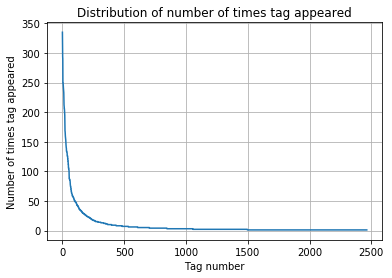

In [56]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

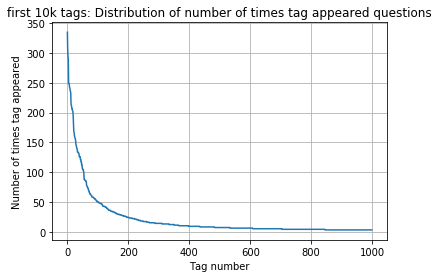

247 [335 234 181 142 126 106  85  70  60  55  50  47  43  39  36  33  31  29
  27  26  24  23  22  20  18  17  17  15  15  14  14  14  13  13  12  12
  11  10  10  10   9   9   9   9   8   8   8   8   8   7   7   7   7   7
   6   6   6   6   6   6   6   5   5   5   5   5   5   5   5   5   5   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   

In [57]:
plt.plot(tag_counts[0:1000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:10]), tag_counts[0:10000:10])

In [58]:
# Store tags count greater than 1K in one list
lst_tags_gt_100 = tag_df[tag_df.Counts>100].Tags
#Print the length of the list
print ('{} Tags are used more than 100 times'.format(len(lst_tags_gt_100)))
# Store tags greater than 100K in one list
lst_tags_gt_200 = tag_df[tag_df.Counts>200].Tags
#Print the length of the list.
print ('{} Tags are used more than 200 times'.format(len(lst_tags_gt_200)))

54 Tags are used more than 100 times
19 Tags are used more than 200 times


# Observations:

There are total 54 tags which are used more than 100 times.19 tags are used more than 200 times.Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

# Tags Per Comapany

In [59]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 2002 datapoints.
[13, 22, 5, 10, 14]


In [60]:
print( "Maximum number of tags per company: %d"%max(tag_quest_count))
print( "Minimum number of tags per company: %d"%min(tag_quest_count))
print( "Avg. number of tags per company: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per company: 119
Minimum number of tags per company: 1
Avg. number of tags per company: 11.927073


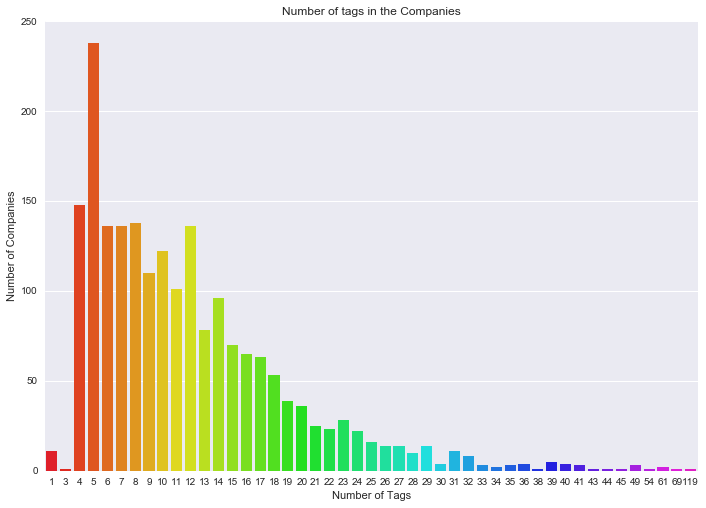

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the Companies")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Companies")
plt.show()

# Observations:

Maximum number of tags per company: 119 ,
Minimum number of tags per company: 1 ,Avg. number of tags per company: 11.92 ,Most of the companies are having 5 tags

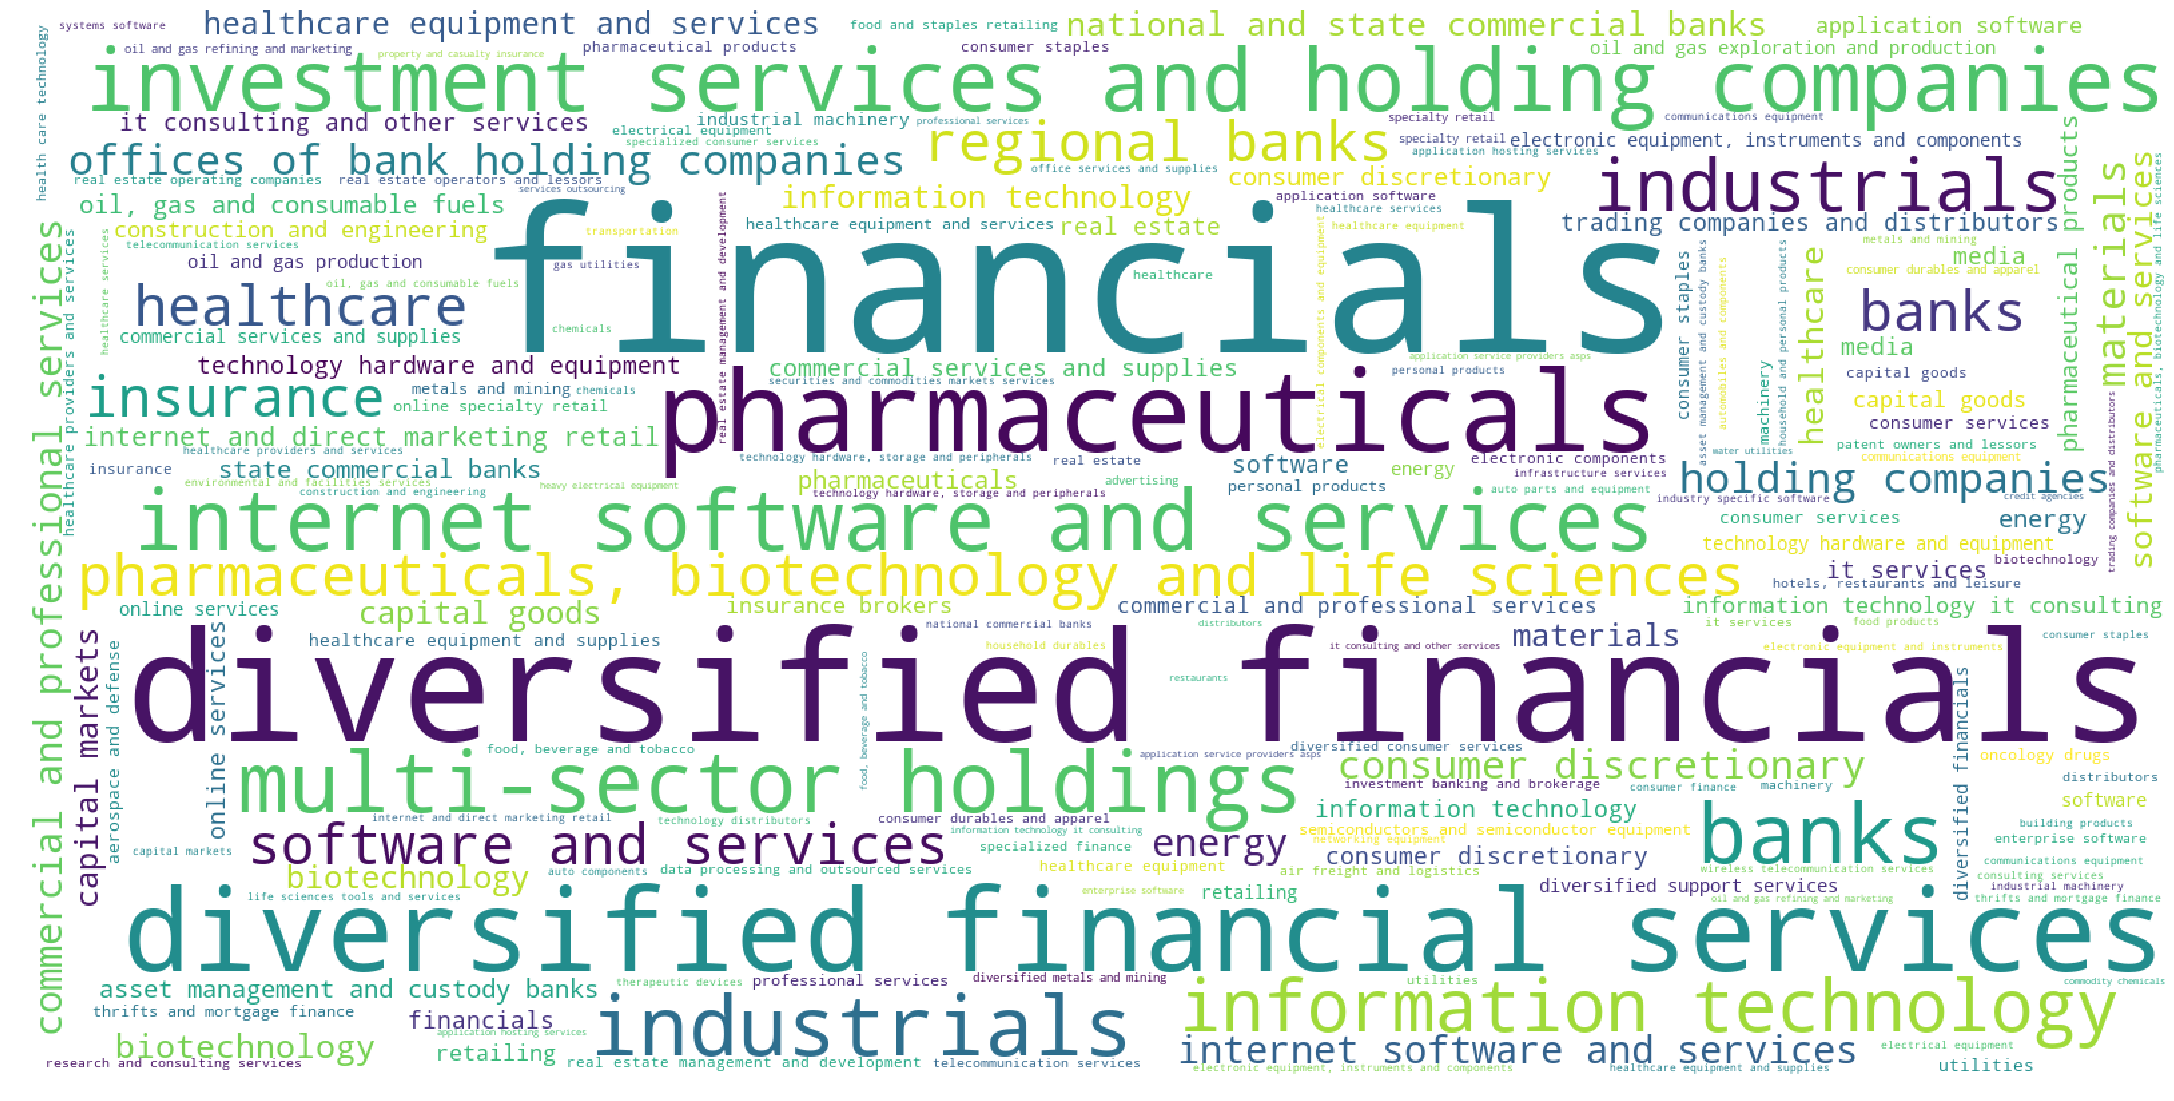

Time taken to run this cell : 0:00:09.102794


In [64]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='white',width=1600,height=800,).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

Observations:
A look at the word cloud shows that "financials", "diversified financials" are some of the most frequent tags.

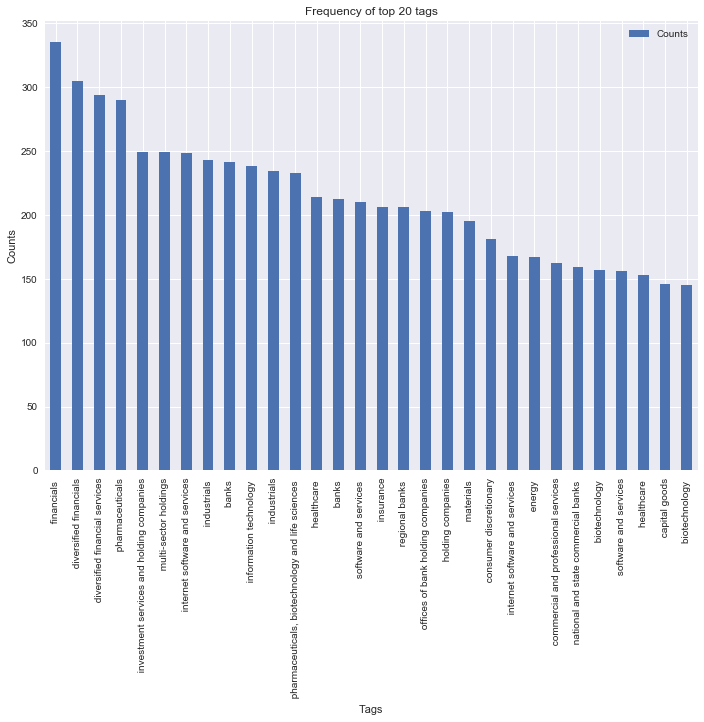

In [65]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

# Cleaning and preprocessing of CompanyDescription(Train Data)
1)Preprocessing 

a)Sample 2002 data points

b)Remove Special characters from description.

c)Remove stop words.

d)Convert all the characters into small letters

e)Use SnowballStemmer to stem the words

In [68]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file,timeout=10)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS companyDescriptionProcessed (BusinessDescription text, tags text);"""
create_database_table("CompanyDescriptionProcessed.db", sql_create_table)

Tables in the databse:
companyDescriptionProcessed


In [69]:
start = datetime.now()
read_db = 'train.db'
write_db = 'CompanyDescriptionProcessed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT CompanyName, BusinessDescription, IndustryClassifications From dataTable ORDER BY RANDOM() ;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM companyDescriptionProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
companyDescriptionProcessed
Cleared All the rows
Time taken to run this cell : 0:00:00.052580


In [111]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
len_pre=0
len_post=0
description_proccesed = 0
for row in reader:

    CompanyName, BusinessDescription, IndustryClassifications = row[0], row[1], row[2]

    x = len(BusinessDescription)
    len_pre+=x

    BusinessDescription=BusinessDescription.encode('utf-8')

    BusinessDescription=str(BusinessDescription)
    BusinessDescription=re.sub(r'[^A-Za-z]+',' ',BusinessDescription)
    words=word_tokenize(str(BusinessDescription.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    businessDescription=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1))

    len_post+=len(businessDescription)
    tup = (businessDescription,IndustryClassifications)
    description_proccesed += 1
    writer.execute("insert into companyDescriptionProcessed(BusinessDescription,tags) values (?,?)",tup)

no_dup_avg_len_pre=(len_pre*1.0)/description_proccesed
no_dup_avg_len_post=(len_post*1.0)/description_proccesed

print( "Avg. length of description before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of description after processing: %d"%no_dup_avg_len_post)

print("Time taken to run this cell :", datetime.now() - start)

ProgrammingError: Cannot operate on a closed database.

In [108]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [110]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT BusinessDescription From companyDescriptionProcessed LIMIT 10")
        print("Descrition after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Descrition after preprocessed


In [94]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT tags From companyDescriptionProcessed LIMIT 10")
        print("Tags: ")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Tags: 


In [95]:
write_db = 'CompanyDescriptionProcessed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT BusinessDescription, tags FROM companyDescriptionProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [96]:
preprocessed_data.head()

,BusinessDescription,tags


In [198]:
preprocessed_data['tags'][0]

'Biotechnology ; Biotechnology ; Healthcare ; Pharmaceuticals, Biotechnology and Life Sciences ; Healthcare Equipment; Healthcare Equipment and Services; Healthcare Equipment and Supplies; Medical Testing, Analyzing, and Diagnostic Equipment'

In [199]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 2001
number of dimensions : 2


In [200]:
start = datetime.now()
preprocessed_data["tags"] = preprocessed_data["tags"].apply(lambda text: text.split(";"))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.006553


In [201]:
preprocessed_data['tags']=preprocessed_data['tags'].apply(''.join)

In [202]:
preprocessed_data['BusinessDescription'][1]

'advaxi inc clinic stage biotechnolog compani focus discoveri develop commerci listeria monocytogen lm technolog base immunotherapi unit state develop axalimogen filolisbac adx dual lm llo immunotherapi product candid treatment human papilloma virus associ cancer includ cervic head neck cancer compani also develop axalimogen filolisbac treatment anal cancer adx psa lm llo immunotherapi product candid design target prostat specif antigen associ prostat cancer adx neo individu lm technolog antigen deliveri product candid design creat individu therapi activ patient xe immun system respond multipl mutat neoantigen addit develop adx hot generat potent anti cancer immun adx lm technolog antigen deliveri product candid design target express solid tumor includ human canin osteosarcoma compani collabor licens agreement bristol myer squibb compani amgen inc sella life scienc group merck co inc medimmun astrazeneca plc especifico stendhal sa de cv aratana therapeut inc global biopharma inc advaxi

In [203]:
preprocessed_data['tags'][1]

'Biotechnology  Biotechnology  Healthcare  Pharmaceuticals, Biotechnology and Life Sciences  Oncology Drugs Pharmaceutical Products Pharmaceuticals Pharmaceuticals Veterinary Drugs'

In [204]:
preprocessed_data.head()

,BusinessDescription,tags
0,avant diagnost inc diagnost compani focus comm...,Biotechnology Biotechnology Healthcare Phar...
1,advaxi inc clinic stage biotechnolog compani f...,Biotechnology Biotechnology Healthcare Phar...
2,brookdal senior live inc own oper senior live ...,Assisted Living Facilities and Services Healt...
3,bonanza creek energi inc engag explor develop ...,Energy Energy Oil and Gas Exploration and Pr...
4,communiti capit bancshar inc oper hold compani...,Banks Banks Financials National and State C...


# Loading and preprocessing test data

In [205]:
df_test =pd.read_excel('Company_ Business Description.xlsx', iterator=True, encoding='utf-8')
df_test = df_test.drop(df_test.columns[df_test.columns.str.contains('unnamed',case = False)],axis = 1)
df_test['BusinessDescription_test']=df_test['Business Description']
df_test.head()

,Company Name,Exchange:Ticker,Company Type,Company Status,Geographic Locations,Business Description,Security Tickers,BusinessDescription_test
0,"024 Pharma, Inc. (OTCPK:EEIG)",OTCPK:EEIG,Public Company,Operating,United States of America (Primary),"024 Pharma, Inc. provides healthcare products ...",OTCPK:EEIG,"024 Pharma, Inc. provides healthcare products ..."
1,"1-800-FLOWERS.COM, Inc. (NasdaqGS:FLWS)",NasdaqGS:FLWS,Public Company,Operating,United States of America (Primary),"1-800-Flowers.com, Inc., together with its sub...",NasdaqGS:FLWS; DB:FWC,"1-800-Flowers.com, Inc., together with its sub..."
2,12 Retech Corporation (OTCPK:RETC),OTCPK:RETC,Public Company,Operating,United States of America (Primary),"12 Retech Corporation, through its subsidiarie...",OTCPK:RETC,"12 Retech Corporation, through its subsidiarie..."
3,"1347 Property Insurance Holdings, Inc. (Nasdaq...",NasdaqGM:PIH,Public Company,Operating,United States of America (Primary),"1347 Property Insurance Holdings, Inc., throug...",NasdaqGM:PIH,"1347 Property Insurance Holdings, Inc., throug..."
4,1847 Holdings LLC (OTCPK:EFSH),OTCPK:EFSH,Public Company,Operating,United States of America (Primary),"1847 Holdings LLC, through its subsidiaries, p...",OTCPK:EFSH,"1847 Holdings LLC, through its subsidiaries, p..."


In [206]:
if not os.path.isfile('data_test.db'):
    disk_engine = create_engine('sqlite:///data_test.db')
    df_test.to_sql(name='data_test_table', con=disk_engine)

In [207]:
if os.path.isfile('data_test.db'):
    start = datetime.now()
    con = sqlite3.connect('data_test.db')
    num_rows = pd.read_sql_query("""SELECT * FROM data_test_table""", con)
    #print(num_rows)
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Run the above cell to generate db file")

Time taken to count the number of rows : 0:00:00.106343


In [208]:
sql_create_table = """CREATE TABLE IF NOT EXISTS DescriptionProcessed_Test (BusinessDescription_test text);"""
create_database_table("DescriptionProcessed_Test.db", sql_create_table)

Tables in the databse:
DescriptionProcessed_Test


In [209]:
start = datetime.now()
read_db = 'data_test.db'
write_db = 'DescriptionProcessed_Test.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT BusinessDescription_test From data_test_table ORDER BY RANDOM() ;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM DescriptionProcessed_Test WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
DescriptionProcessed_Test
Cleared All the rows
Time taken to run this cell : 0:00:00.562890


In [210]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
len_pre=0
len_post=0
description_proccesed = 0
for row in reader:

    BusinessDescription = row[0]

    x = len(BusinessDescription)
    len_pre+=x

    BusinessDescription=BusinessDescription.encode('utf-8')

    BusinessDescription=str(BusinessDescription)
    BusinessDescription=re.sub(r'[^A-Za-z]+',' ',BusinessDescription)
    words=word_tokenize(str(BusinessDescription.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    businessDescription=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1))

    len_post+=len(businessDescription)
    tup = (businessDescription,)
    description_proccesed += 1
    writer.execute("insert into DescriptionProcessed_Test(BusinessDescription_test) values (?)",tup)

no_dup_avg_len_pre=(len_pre*1.0)/description_proccesed
no_dup_avg_len_post=(len_post*1.0)/description_proccesed

print( "Avg. length of description before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of description after processing: %d"%no_dup_avg_len_post)

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of description before processing: 949
Avg. length of description after processing: 637
Time taken to run this cell : 0:00:18.886277


In [211]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [212]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT BusinessDescription_test From DescriptionProcessed_Test LIMIT 10")
        print("Descrition after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Descrition after preprocessed
('nextera energi inc subsidiari generat transmit distribut sell electr power retail wholesal custom north america compani generat electr wind solar nuclear natur gas fire facil also provid risk manag servic relat power gas consumpt februari compani oper approxim megawatt net generat capac decemb serv approxim million peopl approxim million custom account east lower west coast florida approxim circuit mile transmiss distribut line approxim substat compani former known fpl group inc chang name nextera energi inc nextera energi inc found headquart juno beach florida',)
----------------------------------------------------------------------------------------------------
('differenti brand group inc engag design develop sale licens apparel product accessori robert graham brand name worldwid oper wholesal consum direct segment compani xe product line includ men xe sport shirt knit sweater polo shirt denim jean bottom short sport coat outerwear swimwear shoe belt 

In [213]:
write_db = 'DescriptionProcessed_Test.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data_test = pd.read_sql_query("""SELECT BusinessDescription_test FROM DescriptionProcessed_Test""", conn_r)
conn_r.commit()
conn_r.close()

In [214]:
preprocessed_data_test.head()

,BusinessDescription_test
0,good game inc oper tournament game platform on...
1,nextera energi inc subsidiari generat transmit...
2,differenti brand group inc engag design develo...
3,electron system technolog inc busi esteem wire...
4,everock inc provid sandwich spread veget dip u...


In [215]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [216]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [217]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(1, total_tags, 1):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [218]:
total_tags

1617

In [220]:
multilabel_yx = tags_to_choose(369)
print("number of questions that are not covered :", questions_explained_fn(369),"out of ", total_qs)

number of questions that are not covered : 0 out of  2001


In [221]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 1617
number of tags taken : 369 ( 22.820037105751393 %)


In [233]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_cv=preprocessed_data.tail(total_size - train_size)
x_test=preprocessed_data_test
#print(x_test)
y_train = multilabel_yx[0:train_size,:]
y_cv = multilabel_yx[train_size:total_size,:]

In [235]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in cross validation data :", y_cv.shape)

Number of data points in train data : (1600, 369)
Number of data points in cross validation data : (401, 369)


In [234]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=3000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['BusinessDescription'])
x_cv_multilabel = vectorizer.transform(x_cv['BusinessDescription'])
x_test_multilabel = vectorizer.transform(x_test['BusinessDescription_test'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:03.150020


In [236]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of cross validation data X:",x_cv_multilabel.shape,"Y:",y_cv.shape)
print("Dimensions of test data X:",x_test_multilabel.shape)

Dimensions of train data X: (1600, 3000) Y : (1600, 369)
Dimensions of cross validation data X: (401, 3000) Y: (401, 369)
Dimensions of test data X: (8424, 3000)


In [242]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_cv_multilabel)
test_predictions = classifier.predict(x_test_multilabel)
